# Active-learning tutorial: Using committee MACE models to study protonated water clusters

1. Load all the modules
2. read the training pool 
3. select random training set of 25 structure from the pool (can be done with np.rand) --> latter exclude these from the pool
4. Train a committee (just to check we can train 2)
5. predict on the training pool and sort max energy error
6. Then we repeat in a for loop.

## To Do 

- for loop everywhere
- avoid using scripts for MACE
- fix E0s

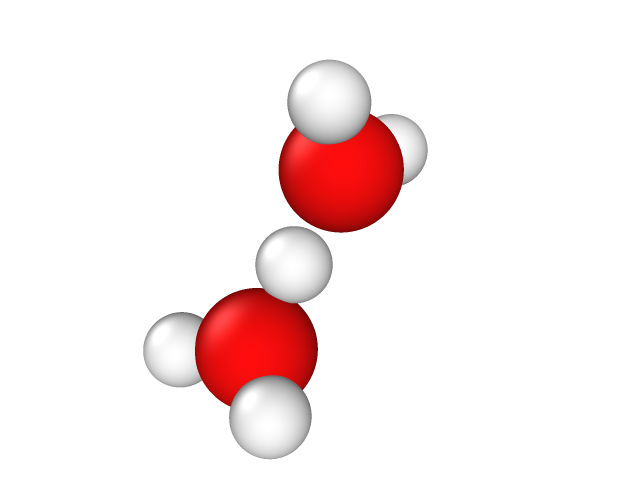

In [1]:
from IPython.display import Image, display
display(Image(filename='../initial-datasets/zundel/zundel.png'))

## Import modules

In [55]:
import os, sys
import multiprocessing
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

from ase.io import read, write                                      # read and write structures
from ase.visualize import view                                      # visualize structures (optional)
from mace.cli.run_train import main as mace_run_train_main          # train a MACE model
from mace.cli.eval_configs import main as mace_eval_configs_main    # evaluate a MACE model

np.random.seed(0)

# import warnings
# import logging
# from contextlib import redirect_stdout, redirect_stderr

In [3]:
plt.style.use('notebook.mplstyle')

In [4]:
# definition of some helper functions
def extxyz2energy(file:str,keyword:str="MACE_energy"):
    """Extracts the energy values from an extxyz file and returns a numpy array
    """
    atoms = read(file, index=':')
    data = np.zeros(len(atoms),dtype=float)
    for n,atom in enumerate(atoms):
        data[n] = atom.info[keyword]
    return data

def train_mace(config:str):
    """Train a MACE model using the provided configuration file.
    """
    sys.argv = ["program", "--config", config]
    mace_run_train_main()
    
def eval_mace(model:str,infile:str,outfile:str):
    """Evaluate a MACE model.
    """
    sys.argv = ["program", "--config", infile,"--output",outfile,"--model",model]
    mace_eval_configs_main()

def retrain_mace(config:str):
    """Train a MACE model using the provided configuration file.
    """
    sys.argv = ["program", "--config", config]
    mace_run_train_main()

In [5]:
os.makedirs('config', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('structures', exist_ok=True)
# os.makedirs('log', exist_ok=True)
# os.makedirs('chk', exist_ok=True)
# os.makedirs('results', exist_ok=True)

In [25]:
n_init_train = 20
n_test = 50  
n_committee = 4
parallel = True

## Select initial training structures

In [7]:
# Read the all the structures from file
structures = read('../initial-datasets/zundel/train.extxyz', index=':')
print(f'Total number of structures: {len(structures)}')
# view(structures)  # Opens an interactive GUI window to visualize the structures

Total number of structures: 10001


In [53]:
# Create the initial training and test sets
selected_indices = np.random.choice(len(structures), size=(n_init_train + n_test), replace=False)
remaining_candidate_idcs = np.delete(np.arange(len(structures)), selected_indices)

indices_train = selected_indices[:n_init_train]
indices_test = selected_indices[n_init_train:]
assert len(indices_train) == n_init_train
assert len(indices_test) == n_test

print(f'\nSelected indices for training: {indices_train}')
print(f'\nSelected indices for test: {indices_test}')

initial_training_set = [structures[i] for i in indices_train]
test_set = [structures[i] for i in indices_test]
remaining_structures = [structures[i] for i in remaining_candidate_idcs]

print(f"\nSaving the initial training set to 'structures/init.train.extxyz'")
write('structures/init.train.extxyz', initial_training_set, format='extxyz')

print(f"\nSaving the test set to 'structures/test.extxyz'")
write('structures/test.extxyz', test_set, format='extxyz')

print(f"\nSaving the remaining structures to 'structures/remaining.extxyz'")
write('structures/remaining.extxyz', remaining_structures, format='extxyz')


Selected indices for training: [7467 5920 6076 8203 6264 1926 3420 9754 6145 5604 3166 1529 5090  448
  429 8142 1242 1015 9788 5571]

Selected indices for test: [6979 8065 2375 6777 1305 9110 4388 6507 7321 4000 8738 5588 2152 6680
 7489 5671 2619 7058   39 2196 8679 3896 3143 3655 1192 6064 1306 2866
 3558 9976 1104 4759 7439 6547 4473 9087 3540 7417 3952 4246 3206 4049
 8256 5517  959 3019 9974 5098 8962  974]

Saving the initial training set to 'structures/init.train.extxyz'

Saving the test set to 'structures/test.extxyz'

Saving the remaining structures to 'structures/remaining.extxyz'


## Initial Training

Hyperparameters for the committee members

In [119]:
# Define different values for each config
os.makedirs('config', exist_ok=True)
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 100

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"
model_dir: "models"
log_dir: "log"
checkpoints_dir: "checkpoints"
results_dir: "results"
train_file: "structures/init.train.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
E0s: "average" # to be fixed
device: cpu
swa: true
seed: {seeds[i]}
restart_latest: True
"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote config/config.0.yml
Wrote config/config.1.yml
Wrote config/config.2.yml
Wrote config/config.3.yml


In [120]:
# train a committee of MACE models
os.makedirs('models', exist_ok=True)
if parallel:
    def train_single_model(n):
        config_path = f"config/config.{n}.yml"
        # with open(os.devnull, 'w') as fnull:
        #     with redirect_stdout(fnull), redirect_stderr(fnull):
        train_mace(config_path)
            
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(train_single_model, range(n_committee))
else:    
    for n in range(n_committee):
        train_mace(f"config/config.{n}.yml")
        
# it should take around 25s

INFO:root:===========VERIFYING SETTINGS===========
INFO:root:===========VERIFYING SETTINGS===========
INFO:root:===========VERIFYING SETTINGS===========
INFO:root:===========VERIFYING SETTINGS===========


2025-05-15 18:29:26.003 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.001 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.003 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:25.999 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.003 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.003 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.001 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:25.999 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:25.999 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.003 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.001 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.003 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:25.999 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.001 INFO: ===========VERIFYING SETTINGS===========
2025-0

INFO:root:MACE version: 0.3.13


2025-05-15 18:29:25.999 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.001 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.031 INFO: MACE version: 0.3.13


INFO:root:MACE version: 0.3.13


2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.001 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:29:26.031 INFO: MACE version: 0.3.13
2025-05-15 18:29:25.999 INFO: ===========VERIFYING SETTINGS===========


INFO:root:MACE version: 0.3.13
INFO:root:MACE version: 0.3.13


2025-05-15 18:29:26.031 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.034 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.034 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.035 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.031 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.031 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.035 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.031 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.035 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.034 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.034 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.031 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.034 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.035 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.034 INFO: M

DEBUG:root:Configuration: Namespace(config='config/config.2.yml', name='mace.com=2', seed=650550996, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='structures/init.train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None,

2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.035 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.035 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.035 INFO: MACE version: 0.3.13


INFO:root:Using CPU


2025-05-15 18:29:26.034 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.055 INFO: Using CPU
2025-05-15 18:29:26.035 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.033 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.055 INFO: Using CPU
2025-05-15 18:29:26.034 INFO: MACE version: 0.3.13
2025-05-15 18:29:26.034 INFO: MACE version: 0.3.13


DEBUG:root:Configuration: Namespace(config='config/config.0.yml', name='mace.com=0', seed=3502075237, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='structures/init.train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None

2025-05-15 18:29:26.055 INFO: Using CPU


DEBUG:root:Configuration: Namespace(config='config/config.3.yml', name='mace.com=3', seed=1336484946, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='structures/init.train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None

2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU


INFO:root:Using CPU
INFO:root:Using CPU


2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.055 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.062 INFO: Using CPU
2025-05-15 18:29:26.055 INFO: Using CPU
2025-05-15 18:29:26.062 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.055 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.062 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.062 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.055 INFO: Using CPU
2025-05-15 18:29:26.062 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.055 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.062 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)


2025-05-15 18:29:26.055 INFO: Using CPU
2025-05-15 18:29:26.060 INFO: Using CPU


DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)
INFO:root:===========LOADING INPUT DATA===========
DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)


2025-05-15 18:29:26.091 INFO: ===========LOADING INPUT DATA===========


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)


2025-05-15 18:29:26.091 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.091 INFO: ===========LOADING INPUT DATA===========


DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:29:26.101 INFO: ===========LOADING INPUT DATA===========


DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d


2025-05-15 18:29:26.101 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.101 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.101 INFO: ===========LOADING INPUT DATA===========


INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:29:26.101 INFO: ===========LOADING INPUT DATA===========


INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:29:26.091 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.101 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.101 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.091 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.101 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.091 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.091 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-0

INFO:root:Using heads: ['Default']
INFO:root:Using heads: ['Default']


2025-05-15 18:29:26.122 INFO: Using heads: ['Default']
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.121 INFO: Using heads: ['Default']
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.122 INFO: Using heads: ['Default']
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.121 INFO: Using heads: ['Default']
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.121 INFO: Using heads: ['Default']
2025-05-15 18:29:26.122 INFO: Using heads: ['Default']
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.103 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:29:26.122 INFO: Using heads: ['Default']
2025-05-15 18:29:26.122 INFO: Using heads: ['De

INFO:root:Using heads: ['Default']
INFO:root:Using heads: ['Default']


2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.121 INFO: Using heads: ['Default']
2025-05-15 18:29:26.122 INFO: Using heads: ['Default']
2025-05-15 18:29:26.128 INFO: Using heads: ['Default']
2025-05-15 18:29:26.121 INFO: Using heads: ['Default']
2025-05-15 18:29:26.122 INFO: Using heads: ['Default']
2025-05-15 18:29:26.128 INFO: Using heads: ['Default']
2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.122 INFO: Using heads: ['Default']
2025-05-15 18:29:26.121 INFO: Using heads: ['Default']
2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.121 INFO: Using heads: ['Default']
2025-05-15 18:29:26.128 INFO: Using heads: ['Default']
2025-05-15 18:29:26.122 INFO: Using heads: ['Default']
2025-05-15 18:29:26.121 INFO: Using heads: ['Default']
2025-05-15 18:29:26.122 INFO: Using heads: ['Default']
2025-05-15 18:29:26.128 INFO: Using heads: ['Default']
2025-05-15 18:29:26.128 INFO: Using heads: ['Default']
2025-05-15

INFO:root:Using the key specifications to parse data:


2025-05-15 18:29:26.128 INFO: Using heads: ['Default']
2025-05-15 18:29:26.121 INFO: Using heads: ['Default']
2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.128 INFO: Using heads: ['Default']


INFO:root:Using the key specifications to parse data:


2025-05-15 18:29:26.128 INFO: Using heads: ['Default']
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.128 INFO: Using heads: ['Default']
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.128 INFO: Using heads: ['Default']
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:


INFO:root:Using the key specifications to parse data:


2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.151 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.151 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.129 INFO: Using heads: ['Default']
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.151 INFO: Using the 

INFO:root:Using the key specifications to parse data:


2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.151 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.156 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.151 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.145 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.156 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.147 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.151 INFO: Using th

INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:29:26.151 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.168 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.156 INFO: Using the key specifications to parse data:


INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:29:26.168 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.151 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.156 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.168 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.168 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.156 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.168 INFO: Default: KeySpecificat

INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:29:26.168 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.168 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.156 INFO: Using the key specifications to parse data:
2025-05-15 18:29:26.168 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.174 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces':

INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:29:26.174 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.168 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.179 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.174 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.168 INFO: De

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:29:26.179 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


INFO:root:=============    Processing head Default     ===========


2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.174 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.174 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.179 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.179 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress':

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:29:26.179 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.196 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.179 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ======

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.196 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.196 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.191 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============

DEBUG:root:Loading training file: structures/init.train.extxyz


2025-05-15 18:29:26.196 INFO: =============    Processing head Default     ===========


DEBUG:root:Loading training file: structures/init.train.extxyz


2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.196 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.196 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.196 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========


DEBUG:root:Loading training file: structures/init.train.extxyz


2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========
2025-05-15 18:29:26.200 INFO: =============    Processing head Default     ===========


DEBUG:root:Loading training file: structures/init.train.extxyz
INFO:root:Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
INFO:root:Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:29:26.239 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


INFO:root:Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:29:26.239 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.239 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


INFO:root:Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:29:26.237 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.239 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.237 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.237 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.245 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.239 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.237 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.239 INF

INFO:root:Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:29:26.237 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.237 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.265 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


INFO:root:Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:29:26.245 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.265 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.237 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.267 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.245 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.237 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.265 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.2

INFO:root:Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:29:26.267 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.265 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


INFO:root:Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:29:26.269 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.269 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.267 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.265 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.270 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.267 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.265 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18

INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:29:26.267 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:29:26.270 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.288 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.267 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.289 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.270 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.289 INFO: No validation set provided, splitting training data instead.


INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:29:26.288 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.289 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.270 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.291 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.288 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.270 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.289 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.291 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.270 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:29:26.288 INFO: N

INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:29:26.288 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.289 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.294 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.288 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.291 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.294 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.289 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.294 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.288 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.291 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.288 INFO: No validation set provided, splitting training data instead.

INFO:root:Using random 10% of training set for validation with following indices: [17, 13]


2025-05-15 18:29:26.291 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.294 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.291 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.289 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.294 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.289 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.291 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.310 INFO: Using random 10% of training set for validation with following indices: [17, 13]
2025-05-15 18:29:26.310 INFO: Using random 10% of training set for validation with following indices: [17, 13]
2025-05-15 18:29:26.291 INFO: No validation set provided, splitting training data instead.


INFO:root:Using random 10% of training set for validation with following indices: [10, 11]


2025-05-15 18:29:26.310 INFO: Using random 10% of training set for validation with following indices: [17, 13]
2025-05-15 18:29:26.294 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:29:26.310 INFO: Using random 10% of training set for validation with following indices: [17, 13]
2025-05-15 18:29:26.312 INFO: Using random 10% of training set for validation with following indices: [10, 11]


INFO:root:Using random 10% of training set for validation with following indices: [0, 10]


2025-05-15 18:29:26.310 INFO: Using random 10% of training set for validation with following indices: [17, 13]


INFO:root:Using random 10% of training set for validation with following indices: [13, 15]


2025-05-15 18:29:26.314 INFO: Using random 10% of training set for validation with following indices: [0, 10]
2025-05-15 18:29:26.312 INFO: Using random 10% of training set for validation with following indices: [10, 11]
2025-05-15 18:29:26.314 INFO: Using random 10% of training set for validation with following indices: [0, 10]
2025-05-15 18:29:26.310 INFO: Using random 10% of training set for validation with following indices: [17, 13]
2025-05-15 18:29:26.312 INFO: Using random 10% of training set for validation with following indices: [10, 11]
2025-05-15 18:29:26.314 INFO: Using random 10% of training set for validation with following indices: [13, 15]
2025-05-15 18:29:26.314 INFO: Using random 10% of training set for validation with following indices: [0, 10]
2025-05-15 18:29:26.310 INFO: Using random 10% of training set for validation with following indices: [17, 13]
2025-05-15 18:29:26.312 INFO: Using random 10% of training set for validation with following indices: [10, 11]
2025

INFO:root:Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
INFO:root:Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]


2025-05-15 18:29:26.334 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.314 INFO: Using random 10% of training set for validation with following indices: [13, 15]


INFO:root:Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]


2025-05-15 18:29:26.332 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.334 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.332 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.334 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.334 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.314 INFO: Using random 10% of training set for validation with following indices: [13, 15]
2025-05-15 18:29:26.332 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2

INFO:root:Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]


2025-05-15 18:29:26.334 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.332 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.334 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.342 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.332 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.342 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.334 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0

INFO:root:Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
INFO:root:Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]


2025-05-15 18:29:26.332 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.342 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.332 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.342 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, h

INFO:root:Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]


2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.342 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.342 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.358 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.342 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, 

INFO:root:Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]


2025-05-15 18:29:26.358 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.366 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.366 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, hea

INFO:root:Total number of configurations: train=18, valid=2, tests=[],


2025-05-15 18:29:26.366 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.358 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.376 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.366 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.358 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.376 INF

INFO:root:Total number of configurations: train=18, valid=2, tests=[],


2025-05-15 18:29:26.366 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.356 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.382 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.376 INFO: Total number of configurations: train=18, valid=2, tests=[],


INFO:root:Total number of configurations: train=18, valid=2, tests=[],


2025-05-15 18:29:26.366 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.382 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.376 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.384 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.366 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:29:26.382 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.384 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.376 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.384 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.376 INFO: Total number of configurations: train=1

INFO:root:Total number of configurations: train=18, valid=2, tests=[],


2025-05-15 18:29:26.376 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.384 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.382 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.390 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.384 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.376 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.382 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.382 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.390 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.384 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.390 INFO: Total number of configurations: train=18, valid=2, tests=[],

2025-05-15 18:29:26.390 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.382 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.384 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.399 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.390 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.384 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.382 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.399 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.390 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.384 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.382 INFO: Total number of configur

2025-05-15 18:29:26.384 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.390 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.405 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.399 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.405 WARNING: Validation batch size (10) is larger than the number of validation data (2)


2025-05-15 18:29:26.390 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.399 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.407 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.405 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.390 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.399 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.405 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.407 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.390 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:29:26.399 WARNING: Validation batch size (10) is larger tha

2025-05-15 18:29:26.405 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.407 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.415 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.405 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.405 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.399 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.415 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.405 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.399 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:29:26.415 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.415 WARNING: Validation batch size (10) is larger than the number of validation data (2)


INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:29:26.426 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.407 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.415 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.407 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.427 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.426 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.427 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.415 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.407 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.427 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.407 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.426 INFO: Atomic Numbers used: [1, 8

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:29:26.426 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.415 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.427 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.427 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.426 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.415 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.426 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.426 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.415 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:29:26.426 INFO: Atomi

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.427 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.440 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.427 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.426 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.440 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.427 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.426 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.427 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.440 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.426 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.427 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:

INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:29:26.440 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.431 INFO: Atomic Numbers used: [1, 8]


INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:29:26.449 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument


INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:29:26.440 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.449 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.450 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.451 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.449 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.451 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.450 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.440 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:29:26.449 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.450 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argum

INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:29:26.451 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.450 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.449 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.463 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.463 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.449 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.450 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.463 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.451 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:29:26.451 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.450 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.463 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.450 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.451 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.471 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.451 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.450 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.471 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.471 INFO: Com

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:29:26.471 INFO: Computing average Atomic Energies using least squares regression


INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.471 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.463 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.471 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.463 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.471 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.471 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:2

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:29:26.471 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.471 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.483 INFO: Computing average At

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.66548345972917, 8: -15.46619338389166}


2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression


INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.665245224771134, 8: -15.466098089908446}


2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.497 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665245224771134, 8: -15.466098089908446}
2025-05-15 18:29:26.495 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.66548345972917, 8: -15.46619338389166}
2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.474 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.497 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665245224771134, 8: -15.466098089908446}
2025-05-15 18:29:26.495 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.66548345972917, 8: -15.46619338389166}
2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.474 I

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.665897593161745, 8: -15.46635903726469}


2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.497 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665245224771134, 8: -15.466098089908446}
2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.495 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.66548345972917, 8: -15.46619338389166}
2025-05-15 18:29:26.505 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665897593161745, 8: -15.46635903726469}
2025-05-15 18:29:26.497 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665245224771134, 8: -15.466098089908446}
2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:29:26.495 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.66548345972917, 8: -15.46619338389166}
2025-05-15 18:29:26.483 INFO: Computing average Atomic Energies using least squares regres

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.666407960485834, 8: -15.466563184194325}


2025-05-15 18:29:26.495 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.66548345972917, 8: -15.46619338389166}
2025-05-15 18:29:26.497 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665245224771134, 8: -15.466098089908446}
2025-05-15 18:29:26.495 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.66548345972917, 8: -15.46619338389166}
2025-05-15 18:29:26.497 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665245224771134, 8: -15.466098089908446}
2025-05-15 18:29:26.505 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665897593161745, 8: -15.46635903726469}
2025-05-15 18:29:26.512 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.666407960485834, 8: -15.466563184194325}
2025-05-15 18:29:26.497 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665245224771134, 8: -15.466098089908446}
2025-05-15 18:29:26.495 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.66548345972917, 8: -15.46619338389166}

INFO:root:Processing datasets for head 'Default'


2025-05-15 18:29:26.495 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.66548345972917, 8: -15.46619338389166}
2025-05-15 18:29:26.505 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665897593161745, 8: -15.46635903726469}


INFO:root:Processing datasets for head 'Default'


2025-05-15 18:29:26.522 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.512 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.666407960485834, 8: -15.466563184194325}
2025-05-15 18:29:26.505 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665897593161745, 8: -15.46635903726469}
2025-05-15 18:29:26.523 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.522 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.505 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.665897593161745, 8: -15.46635903726469}
2025-05-15 18:29:26.512 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.666407960485834, 8: -15.466563184194325}
2025-05-15 18:29:26.522 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.523 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.512 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.666407960485834, 8: -15.466563184194325}
2025-05-15 18:29:26.522 INF

INFO:root:Processing datasets for head 'Default'


2025-05-15 18:29:26.522 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'


INFO:root:Processing datasets for head 'Default'


2025-05-15 18:29:26.523 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.523 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.522 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.523 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.522 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.523 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.522 INFO: Proc

DEBUG:root:Successfully loaded dataset from ASE files: ['structures/init.train.extxyz']


2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'


INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'


DEBUG:root:Successfully loaded dataset from ASE files: ['structures/init.train.extxyz']
DEBUG:root:Successfully loaded dataset from ASE files: ['structures/init.train.extxyz']


2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'


INFO:root:Combining 1 list datasets for head 'Default'
INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.536 INFO: Processing datasets for head 'Default'
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.591 INFO: Combining 1 l

INFO:root:Head 'Default' training dataset size: 18
DEBUG:root:Successfully loaded dataset from ASE files: ['structures/init.train.extxyz']


2025-05-15 18:29:26.616 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.616 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'


INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:29:26.616 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.619 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.616 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.619 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.616 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.591 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.569 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.619 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.616 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.591 INFO: Combining 1

INFO:root:Head 'Default' training dataset size: 18


2025-05-15 18:29:26.619 INFO: Combining 1 list datasets for head 'Default'


INFO:root:Head 'Default' training dataset size: 18


2025-05-15 18:29:26.616 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.619 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.616 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.619 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.619 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.616 INFO: Head 'Default' training dataset siz

INFO:root:Head 'Default' training dataset size: 18


2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.644 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.644 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.644 INFO: Head 'Default' training dataset size: 18


INFO:root:Computing average number of neighbors


2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.645 INFO: Computing average number of neighbors
2025-05-15 18:29:26.644 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.645 INFO: Computing average number of neighbors
2025-05-15 18:29:26.644 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.645 INFO: Computing average number of neighbors
2025-05-15 18:29:26.644 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.644 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.645 INFO: Computing average number of neighbors
2025-05-15 18:29:26.631 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:2

INFO:root:Computing average number of neighbors
INFO:root:Computing average number of neighbors


2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.644 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.645 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.644 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.645 INFO: Computing average number of neighbors
2025-05-15 18:29:26.644 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.645 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing

INFO:root:Computing average number of neighbors


2025-05-15 18:29:26.645 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average number of neighbors
2025-05-15 18:29:26.669 INFO: Computing average 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Average number of neighbors: 5.982142857142857


2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors


INFO:root:Average number of neighbors: 5.982142857142857


2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.660 INFO: Computing average number of neighbors
2025-05-15 18:29:26.660 INFO: Computing average numbe

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857


INFO:root:Average number of neighbors: 5.982142857142857


2025-05-15 18:29:26.705 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857


INFO:root:Average number of neighbors: 5.982142857142857


2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.712 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.712 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.705 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.705 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.712 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.684 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.712 INFO: Average number of neighbors: 5.982142857142857


INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.712 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.716 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.705 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.712 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.705 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.716 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.712 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.705 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.716 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.690 INFO: Average number of neighbors: 5.98214285714

INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:29:26.712 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.705 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.716 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.712 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.729 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.705 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.705 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.712 INFO: Average number of neighbors: 5.982142857142857
2025-05-15 18:29:26.729 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.716 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.729 INFO: During training the following quantities will be reported: energy, forces


INFO:root:During training the following quantities will be reported: energy, forces
INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.729 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.716 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.729 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.716 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.729 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.716 INFO: During training the following quan

INFO:root:===========MODEL DETAILS===========


2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.729 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.729 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.729 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.741 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, force

INFO:root:===========MODEL DETAILS===========


2025-05-15 18:29:26.729 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.741 INFO: ===========MODEL DETAILS===========


INFO:root:===========MODEL DETAILS===========


2025-05-15 18:29:26.741 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.741 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.732 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:29:26.755 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.741 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.755 INFO: ===========MODEL DETAILS===========


INFO:root:===========MODEL DETAILS===========


2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.755 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.755 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.755 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.741 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.755 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.741 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.741 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15

INFO:root:Building model


2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.755 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.773 INFO: Building model


INFO:root:Building model


2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.754 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.773 INFO: Building model
2025

INFO:root:Building model


2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.757 INFO: ===========MODEL DETAILS===========
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.773 INFO: Building model


INFO:root:Building model


2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.773 INFO: Building model
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15

INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.815 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.780 INFO: Building model
2025-05-15 18:29:26.815 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.804 INFO: Building model


INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.815 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.817 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.793 INFO: Building model
2025-05-15 18:29:26.815 INFO: Message passing with 16 channels and max_L=0 (16x0e)


INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.815 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.817 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.815 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.817 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.815 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.804 INFO: Building model
2025-05-15 18:29:26.815 INFO: Message passing with 16 channels and max_L=

INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.817 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.815 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.830 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.817 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.815 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.830 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.817 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:29:26.830 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.817 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.830 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.840 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.821 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.830 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.840 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:29:26.817 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.830 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.843 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.830 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.817 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.817 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.840 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.843 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.830 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.840 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:29:26.840 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.830 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.847 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.843 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.840 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.847 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.830 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:29:26.843 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.843 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical h

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:29:26.840 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.843 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.847 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.843 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.847 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.851 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.843 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.847 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.840 

INFO:root:8 radial and 5 basis functions


2025-05-15 18:29:26.851 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.862 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.843 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.847 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.851 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.862 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.847 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.843 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


INFO:root:8 radial and 5 basis functions


2025-05-15 18:29:26.862 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.847 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.862 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.851 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.847 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.862 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.851 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.847 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.851 INFO: 2 layers, each with correlation order: 1 (body order: 2

INFO:root:8 radial and 5 basis functions


2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.851 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.851 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.862 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.851 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.851 INFO: 2 layers, each with correlation order: 1 (body order: 2

INFO:root:8 radial and 5 basis functions


2025-05-15 18:29:26.862 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.862 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.876 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.876 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.862 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.862 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.876 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.865 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.862 

INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions


INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:29:26.876 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.888 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.888 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.887 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.888 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.887 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.870 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.876 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.887 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.888 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.876 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.870

INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:29:26.887 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.876 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.897 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.887 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.897 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.876 INFO: 8 radial and 5 basis functions
2025-05-15 18:29:26.887 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.887 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.888 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.897 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.887 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.897 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.887 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.897 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.888 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.887 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.888 INFO: Radial cut

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:29:26.897 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.888 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.897 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.888 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.897 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.888 INFO: Radial cutoff: 4.0 A (total receptive 

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:29:26.897 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.897 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.897 INFO

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.917 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.917 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.899 INFO: Radial cutoff: 4.0 A (total receptive fi

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.917 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.922 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.922 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.917 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.922 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.909 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.917 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29

INFO:root:Hidden irreps: 16x0e


2025-05-15 18:29:26.922 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.913 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.917 INFO: Distance transform for radial basis functions: None


INFO:root:Hidden irreps: 16x0e


2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.917 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.922 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.917 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.922 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.922 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.917 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.917 INFO: Distance transform 

INFO:root:Hidden irreps: 16x0e


2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.943 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.922 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.943 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.922 INFO: Distance transform for radial basis functions: None
2025-05-15 18:29:26.943 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e


INFO:root:Hidden irreps: 16x0e


2025-05-15 18:29:26.943 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.943 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.946 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.943 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.946 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.946 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.943 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.933 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.946 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.934 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.943 INFO: H

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


2025-05-15 18:29:26.946 INFO: Hidden irreps: 16x0e


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


2025-05-15 18:29:26.943 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.946 INFO: Hidden irreps: 16x0e
2025-05-15 18:29:26.946 INFO: Hidden irreps: 16x0e


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


2025-05-15 18:29:26.943 INFO: Hidden irreps: 16x0e


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2025-05-15 18:29:29.144 INFO: 
2025-05-15 18:29:29.144 INFO: 
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.164 INFO: ===========TRAINING===========
2025-05-15 18:29:29.144 INFO: 


INFO:root:Started training, reporting errors on validation set


2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.144 INFO: 
2025-05-15 18:29:29.144 INFO: 
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.144 INFO: 
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.144 INFO: 
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.144 INFO: 
2025-05-15 18:29:29.144 INFO: 
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.144 INFO: 
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29

INFO:root:===========TRAINING===========


2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.207 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.181 INFO: 
2025-05-15 18:29:29.253 INFO: ===========T

INFO:root:Loss metrics on validation set


2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.294 INFO: Loss metrics on validation set


INFO:root:===========TRAINING===========
INFO:root:Initial: head: Default, loss=24.87677441, RMSE_E_per_atom=   17.63 meV, RMSE_F=  705.36 meV / A


2025-05-15 18:29:29.294 INFO: Loss metrics on validation set
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.293 INFO: Initial: head: Default, loss=24.87677441, RMSE_E_per_atom=   17.63 meV, RMSE_F=  705.36 meV / A
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.294 INFO: Loss metrics on validation set
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.294 INFO: Loss metrics on validation set
2025-05-15 18:29:29.294 INFO: Loss metrics on validation set
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.293 INFO: Initial: head: Default, loss=24.87677441, RMSE_E_pe

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.293 INFO: Initial: head: Default, loss=24.87677441, RMSE_E_per_atom=   17.63 meV, RMSE_F=  705.36 meV / A
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.293 INFO: Initial: head: Default, loss=24.87677441, RMSE_E_per_atom=   17.63 meV, RMSE_F=  705.36 meV / A
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.293 INFO: Initial: head: Default, loss=24.87677441, RMSE_E_per_atom=   17.63 meV, RMSE_F=  705.36 meV / A
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========
2025-05-15 18:29:29.253 INFO: ===========TRAINING===========


INFO:root:Started training, reporting errors on validation set


2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.368 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.293 INFO: Initial: head: Default, loss=24.87677441, RMSE_E_per_atom=   17.63 meV, RMSE_F=  705.36 meV / A
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.293 INFO: Initial: head: Default, loss=24.87677441, RMSE_E_per_atom=   17.63 meV, RMSE_F=  705.36 meV / A
2025-05-15 18:29:29.368 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.293 INFO: Initial: head: Default, loss=24.87677441, RMSE_E_per_atom=   17.63 meV, RMSE_F=  705.36 meV / A
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.368 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05-15 18:29:29.295 INFO: ===========TRAINING===========
2025-05

INFO:root:Started training, reporting errors on validation set


2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.368 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.368 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.368 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.368 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.368 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025

INFO:root:Loss metrics on validation set


2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.425 INFO: Started training, reporting errors on validation set
2025-05-1

INFO:root:Loss metrics on validation set


2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set
2025-05-15 18:29:29.470 INFO: Loss metrics on validation set


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 INFO: Loss metrics on validation set
2025-05-15 18:29:29.519 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Initial: head: Default, loss=15.11956459, RMSE_E_per_atom=   18.64 meV, RMSE_F=  549.90 meV / A


2025-05-15 18:29:29.729 INFO: Initial: head: Default, loss=15.11956459, RMSE_E_per_atom=   18.64 meV, RMSE_F=  549.90 meV / A
2025-05-15 18:29:29.729 INFO: Initial: head: Default, loss=15.11956459, RMSE_E_per_atom=   18.64 meV, RMSE_F=  549.90 meV / A
2025-05-15 18:29:29.729 INFO: Initial: head: Default, loss=15.11956459, RMSE_E_per_atom=   18.64 meV, RMSE_F=  549.90 meV / A
2025-05-15 18:29:29.729 INFO: Initial: head: Default, loss=15.11956459, RMSE_E_per_atom=   18.64 meV, RMSE_F=  549.90 meV / A
2025-05-15 18:29:29.729 INFO: Initial: head: Default, loss=15.11956459, RMSE_E_per_atom=   18.64 meV, RMSE_F=  549.90 meV / A
2025-05-15 18:29:29.729 INFO: Initial: head: Default, loss=15.11956459, RMSE_E_per_atom=   18.64 meV, RMSE_F=  549.90 meV / A
2025-05-15 18:29:29.729 INFO: Initial: head: Default, loss=15.11956459, RMSE_E_per_atom=   18.64 meV, RMSE_F=  549.90 meV / A
2025-05-15 18:29:29.729 INFO: Initial: head: Default, loss=15.11956459, RMSE_E_per_atom=   18.64 meV, RMSE_F=  549.90 

INFO:root:Initial: head: Default, loss=20.72257885, RMSE_E_per_atom=   21.07 meV, RMSE_F=  643.78 meV / A


2025-05-15 18:29:30.047 INFO: Initial: head: Default, loss=20.72257885, RMSE_E_per_atom=   21.07 meV, RMSE_F=  643.78 meV / A
2025-05-15 18:29:30.047 INFO: Initial: head: Default, loss=20.72257885, RMSE_E_per_atom=   21.07 meV, RMSE_F=  643.78 meV / A
2025-05-15 18:29:30.047 INFO: Initial: head: Default, loss=20.72257885, RMSE_E_per_atom=   21.07 meV, RMSE_F=  643.78 meV / A
2025-05-15 18:29:30.047 INFO: Initial: head: Default, loss=20.72257885, RMSE_E_per_atom=   21.07 meV, RMSE_F=  643.78 meV / A


INFO:root:Initial: head: Default, loss=33.50915853, RMSE_E_per_atom=    3.34 meV, RMSE_F=  818.65 meV / A


2025-05-15 18:29:30.047 INFO: Initial: head: Default, loss=20.72257885, RMSE_E_per_atom=   21.07 meV, RMSE_F=  643.78 meV / A
2025-05-15 18:29:30.090 INFO: Initial: head: Default, loss=33.50915853, RMSE_E_per_atom=    3.34 meV, RMSE_F=  818.65 meV / A
2025-05-15 18:29:30.047 INFO: Initial: head: Default, loss=20.72257885, RMSE_E_per_atom=   21.07 meV, RMSE_F=  643.78 meV / A
2025-05-15 18:29:30.047 INFO: Initial: head: Default, loss=20.72257885, RMSE_E_per_atom=   21.07 meV, RMSE_F=  643.78 meV / A
2025-05-15 18:29:30.047 INFO: Initial: head: Default, loss=20.72257885, RMSE_E_per_atom=   21.07 meV, RMSE_F=  643.78 meV / A
2025-05-15 18:29:30.090 INFO: Initial: head: Default, loss=33.50915853, RMSE_E_per_atom=    3.34 meV, RMSE_F=  818.65 meV / A
2025-05-15 18:29:30.090 INFO: Initial: head: Default, loss=33.50915853, RMSE_E_per_atom=    3.34 meV, RMSE_F=  818.65 meV / A
2025-05-15 18:29:30.047 INFO: Initial: head: Default, loss=20.72257885, RMSE_E_per_atom=   21.07 meV, RMSE_F=  643.78 

INFO:root:Epoch 0: head: Default, loss=23.51036927, RMSE_E_per_atom=  128.32 meV, RMSE_F=  685.60 meV / A


2025-05-15 18:29:30.657 INFO: Epoch 0: head: Default, loss=23.51036927, RMSE_E_per_atom=  128.32 meV, RMSE_F=  685.60 meV / A
2025-05-15 18:29:30.657 INFO: Epoch 0: head: Default, loss=23.51036927, RMSE_E_per_atom=  128.32 meV, RMSE_F=  685.60 meV / A
2025-05-15 18:29:30.657 INFO: Epoch 0: head: Default, loss=23.51036927, RMSE_E_per_atom=  128.32 meV, RMSE_F=  685.60 meV / A
2025-05-15 18:29:30.657 INFO: Epoch 0: head: Default, loss=23.51036927, RMSE_E_per_atom=  128.32 meV, RMSE_F=  685.60 meV / A
2025-05-15 18:29:30.657 INFO: Epoch 0: head: Default, loss=23.51036927, RMSE_E_per_atom=  128.32 meV, RMSE_F=  685.60 meV / A
2025-05-15 18:29:30.657 INFO: Epoch 0: head: Default, loss=23.51036927, RMSE_E_per_atom=  128.32 meV, RMSE_F=  685.60 meV / A
2025-05-15 18:29:30.657 INFO: Epoch 0: head: Default, loss=23.51036927, RMSE_E_per_atom=  128.32 meV, RMSE_F=  685.60 meV / A
2025-05-15 18:29:30.657 INFO: Epoch 0: head: Default, loss=23.51036927, RMSE_E_per_atom=  128.32 meV, RMSE_F=  685.60 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-0.pt
INFO:root:Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A


2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A
2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A
2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A
2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A
2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A
2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A
2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A
2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 

INFO:root:Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A


2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A
2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A
2025-05-15 18:29:31.277 INFO: Epoch 0: head: Default, loss=16.59527283, RMSE_E_per_atom=   43.98 meV, RMSE_F=  576.10 meV / A
2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A
2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A
2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A
2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A
2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 

INFO:root:Epoch 0: head: Default, loss=16.62982849, RMSE_E_per_atom=   66.07 meV, RMSE_F=  576.67 meV / A


2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-0.pt


2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A
2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A
2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A
2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A
2025-05-15 18:29:31.596 INFO: Epoch 0: head: Default, loss=16.62982849, RMSE_E_per_atom=   66.07 meV, RMSE_F=  576.67 meV / A
2025-05-15 18:29:31.596 INFO: Epoch 0: head: Default, loss=16.62982849, RMSE_E_per_atom=   66.07 meV, RMSE_F=  576.67 meV / A
2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 meV / A
2025-05-15 18:29:31.540 INFO: Epoch 1: head: Default, loss=16.81841210, RMSE_E_per_atom=  301.17 meV, RMSE_F=  579.19 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-0.pt


2025-05-15 18:29:31.596 INFO: Epoch 0: head: Default, loss=16.62982849, RMSE_E_per_atom=   66.07 meV, RMSE_F=  576.67 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-1.pt


2025-05-15 18:29:31.596 INFO: Epoch 0: head: Default, loss=16.62982849, RMSE_E_per_atom=   66.07 meV, RMSE_F=  576.67 meV / A


INFO:root:Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A


2025-05-15 18:29:31.596 INFO: Epoch 0: head: Default, loss=16.62982849, RMSE_E_per_atom=   66.07 meV, RMSE_F=  576.67 meV / A
2025-05-15 18:29:31.596 INFO: Epoch 0: head: Default, loss=16.62982849, RMSE_E_per_atom=   66.07 meV, RMSE_F=  576.67 meV / A
2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A
2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A
2025-05-15 18:29:31.596 INFO: Epoch 0: head: Default, loss=16.62982849, RMSE_E_per_atom=   66.07 meV, RMSE_F=  576.67 meV / A
2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A
2025-05-15 18:29:31.596 INFO: Epoch 0: head: Default, loss=16.62982849, RMSE_E_per_atom=   66.07 meV, RMSE_F=  576.67 meV / A
2025-05-15 18:29:31.596 INFO: Epoch 0: head: Default, loss=16.62982849, RMSE_E_per_atom=   66.07 meV, RMSE_F=  576.67 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-0.pt


2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A
2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A
2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A
2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A
2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A
2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A
2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 meV / A
2025-05-15 18:29:31.708 INFO: Epoch 0: head: Default, loss=29.27304386, RMSE_E_per_atom=   48.86 meV, RMSE_F=  765.14 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-0.pt
INFO:root:Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A


2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A


INFO:root:Epoch 2: head: Default, loss=10.90948568, RMSE_E_per_atom=  426.47 meV, RMSE_F=  465.16 meV / A


2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.490 INFO: Epoch 2: head: Default, loss=10.90948568, RMSE_E_per_atom=  426.47 meV, RMSE_F=  465.16 meV / A
2025-05-15 18:29:32.490 INFO: Epoch 2: head: Default, loss=10.90948568, RMSE_E_per_atom=  426.47 meV, RMSE_F=  465.16 meV / A
2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.490 INFO: Epoch 2: head: Default, loss=10.90948568, RMSE_E_per_atom=  426.47 meV, RMSE_F=  465.16 meV / A
2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 

INFO:root:Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A


2025-05-15 18:29:32.565 INFO: Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A
2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.490 INFO: Epoch 2: head: Default, loss=10.90948568, RMSE_E_per_atom=  426.47 meV, RMSE_F=  465.16 meV / A
2025-05-15 18:29:32.490 INFO: Epoch 2: head: Default, loss=10.90948568, RMSE_E_per_atom=  426.47 meV, RMSE_F=  465.16 meV / A
2025-05-15 18:29:32.490 INFO: Epoch 2: head: Default, loss=10.90948568, RMSE_E_per_atom=  426.47 meV, RMSE_F=  465.16 meV / A
2025-05-15 18:29:32.490 INFO: Epoch 2: head: Default, loss=10.90948568, RMSE_E_per_atom=  426.47 meV, RMSE_F=  465.16 meV / A
2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.490 INFO: Epoch 2: head: Default, loss=10.90948568, RMSE_E_per_atom=  426.47 meV, RMSE_F=  465.16 

INFO:root:Epoch 1: head: Default, loss=25.75013511, RMSE_E_per_atom=  124.58 meV, RMSE_F=  717.53 meV / A


2025-05-15 18:29:32.565 INFO: Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-1.pt


2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-2.pt


2025-05-15 18:29:32.383 INFO: Epoch 1: head: Default, loss=13.30651933, RMSE_E_per_atom=  140.12 meV, RMSE_F=  515.69 meV / A
2025-05-15 18:29:32.633 INFO: Epoch 1: head: Default, loss=25.75013511, RMSE_E_per_atom=  124.58 meV, RMSE_F=  717.53 meV / A
2025-05-15 18:29:32.633 INFO: Epoch 1: head: Default, loss=25.75013511, RMSE_E_per_atom=  124.58 meV, RMSE_F=  717.53 meV / A
2025-05-15 18:29:32.565 INFO: Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-0.pt


2025-05-15 18:29:32.633 INFO: Epoch 1: head: Default, loss=25.75013511, RMSE_E_per_atom=  124.58 meV, RMSE_F=  717.53 meV / A
2025-05-15 18:29:32.633 INFO: Epoch 1: head: Default, loss=25.75013511, RMSE_E_per_atom=  124.58 meV, RMSE_F=  717.53 meV / A
2025-05-15 18:29:32.565 INFO: Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A
2025-05-15 18:29:32.565 INFO: Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-1.pt


2025-05-15 18:29:32.565 INFO: Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A
2025-05-15 18:29:32.565 INFO: Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A
2025-05-15 18:29:32.565 INFO: Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A
2025-05-15 18:29:32.565 INFO: Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A
2025-05-15 18:29:32.565 INFO: Epoch 1: head: Default, loss=15.53059128, RMSE_E_per_atom=  180.29 meV, RMSE_F=  557.03 meV / A
2025-05-15 18:29:32.633 INFO: Epoch 1: head: Default, loss=25.75013511, RMSE_E_per_atom=  124.58 meV, RMSE_F=  717.53 meV / A
2025-05-15 18:29:32.633 INFO: Epoch 1: head: Default, loss=25.75013511, RMSE_E_per_atom=  124.58 meV, RMSE_F=  717.53 meV / A
2025-05-15 18:29:32.633 INFO: Epoch 1: head: Default, loss=25.75013511, RMSE_E_per_atom=  124.58 meV, RMSE_F=  717.53 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-0.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-1.pt
DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-0.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-1.pt
INFO:root:Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 meV / A
INFO:root:Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A


2025-05-15 18:29:33.491 INFO: Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 meV / A
2025-05-15 18:29:33.491 INFO: Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 meV / A


INFO:root:Epoch 2: head: Default, loss=12.88592996, RMSE_E_per_atom=  322.48 meV, RMSE_F=  506.63 meV / A


2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.529 INFO: Epoch 2: head: Default, loss=12.88592996, RMSE_E_per_atom=  322.48 meV, RMSE_F=  506.63 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.491 INFO: Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 m

INFO:root:Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A


2025-05-15 18:29:33.491 INFO: Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 meV / A
2025-05-15 18:29:33.491 INFO: Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.491 INFO: Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.529 INFO: Epoch 2: head: Default, loss=12.88592996, RMSE_E_per_atom=  322.48 meV, RMSE_F=  506.63 meV

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-1.pt


2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A
2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.491 INFO: Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 meV / A
2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 m

DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-2.pt


2025-05-15 18:29:33.491 INFO: Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 meV / A
2025-05-15 18:29:33.491 INFO: Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.491 INFO: Epoch 3: head: Default, loss=6.68510611, RMSE_E_per_atom=  797.25 meV, RMSE_F=  356.86 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-2.pt


2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-3.pt


2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.496 INFO: Epoch 2: head: Default, loss=17.13091480, RMSE_E_per_atom=  311.31 meV, RMSE_F=  584.51 meV / A
2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A
2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A
2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A
2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 meV / A
2025-05-15 18:29:33.572 INFO: Epoch 2: head: Default, loss=20.01088454, RMSE_E_per_atom=  239.90 meV, RMSE_F=  632.17 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-1.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-2.pt
INFO:root:Epoch 3: head: Default, loss=8.32628699, RMSE_E_per_atom=  325.83 meV, RMSE_F=  406.77 meV / A


2025-05-15 18:29:34.509 INFO: Epoch 3: head: Default, loss=8.32628699, RMSE_E_per_atom=  325.83 meV, RMSE_F=  406.77 meV / A
2025-05-15 18:29:34.509 INFO: Epoch 3: head: Default, loss=8.32628699, RMSE_E_per_atom=  325.83 meV, RMSE_F=  406.77 meV / A


INFO:root:Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A


2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.509 INFO: Epoch 3: head: Default, loss=8.32628699, RMSE_E_per_atom=  325.83 meV, RMSE_F=  406.77 meV / A
2025-05-15 18:29:34.509 INFO: Epoch 3: head: Default, loss=8.32628699, RMSE_E_per_atom=  325.83 meV, RMSE_F=  406.77 meV / A
2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A


INFO:root:Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A


2025-05-15 18:29:34.509 INFO: Epoch 3: head: Default, loss=8.32628699, RMSE_E_per_atom=  325.83 meV, RMSE_F=  406.77 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A
2025-05-15 18:29:34.509 INFO: Epoch 3: head: Default, loss=8.32628699, RMSE_E_per_atom=  325.83 meV, RMSE_F=  406.77 meV / A
2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A
2025-05-15 18:29:34.509 INFO: Epoch 3: head: Default, loss=8.32628699, RMSE_E_per_atom=  325.83 meV, RMSE_F=  406.77 meV / A
2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / 

INFO:root:Epoch 3: head: Default, loss=12.11684100, RMSE_E_per_atom=  497.24 meV, RMSE_F=  489.76 meV / A


2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.509 INFO: Epoch 3: head: Default, loss=8.32628699, RMSE_E_per_atom=  325.83 meV, RMSE_F=  406.77 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A
2025-05-15 18:29:34.649 INFO: Epoch 3: head: Default, loss=12.11684100, RMSE_E_per_atom=  497.24 meV, RMSE_F=  489.76 meV / A
2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.509 INFO: Epoch 3: head: Default, loss=8.32628699, RMSE_E_per_atom=  325.83 meV, RMSE_F=  406.77 meV / A
2025-05-15 18:29:34.649 INFO: Epoch 3: head: Default, loss=12.11684100, RMSE_E_per_atom=  497.24 meV, RMSE_F=  489.76 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-1.pt


2025-05-15 18:29:34.649 INFO: Epoch 3: head: Default, loss=12.11684100, RMSE_E_per_atom=  497.24 meV, RMSE_F=  489.76 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-3.pt


2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A
2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-2.pt


2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A
2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-3.pt


2025-05-15 18:29:34.594 INFO: Epoch 4: head: Default, loss=4.65753654, RMSE_E_per_atom= 1024.08 meV, RMSE_F=  287.51 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-3.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-4.pt


2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A
2025-05-15 18:29:34.552 INFO: Epoch 3: head: Default, loss=11.77649918, RMSE_E_per_atom=  409.54 meV, RMSE_F=  483.58 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-2.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-3.pt
INFO:root:Epoch 4: head: Default, loss=3.66438877, RMSE_E_per_atom=  459.73 meV, RMSE_F=  266.78 meV / A
INFO:root:Epoch 5: head: Default, loss=4.72946478, RMSE_E_per_atom=  911.91 meV, RMSE_F=  293.72 meV / A


2025-05-15 18:29:35.574 INFO: Epoch 4: head: Default, loss=3.66438877, RMSE_E_per_atom=  459.73 meV, RMSE_F=  266.78 meV / A
2025-05-15 18:29:35.574 INFO: Epoch 4: head: Default, loss=3.66438877, RMSE_E_per_atom=  459.73 meV, RMSE_F=  266.78 meV / A
2025-05-15 18:29:35.600 INFO: Epoch 5: head: Default, loss=4.72946478, RMSE_E_per_atom=  911.91 meV, RMSE_F=  293.72 meV / A
2025-05-15 18:29:35.600 INFO: Epoch 5: head: Default, loss=4.72946478, RMSE_E_per_atom=  911.91 meV, RMSE_F=  293.72 meV / A
2025-05-15 18:29:35.574 INFO: Epoch 4: head: Default, loss=3.66438877, RMSE_E_per_atom=  459.73 meV, RMSE_F=  266.78 meV / A
2025-05-15 18:29:35.600 INFO: Epoch 5: head: Default, loss=4.72946478, RMSE_E_per_atom=  911.91 meV, RMSE_F=  293.72 meV / A
2025-05-15 18:29:35.574 INFO: Epoch 4: head: Default, loss=3.66438877, RMSE_E_per_atom=  459.73 meV, RMSE_F=  266.78 meV / A
2025-05-15 18:29:35.574 INFO: Epoch 4: head: Default, loss=3.66438877, RMSE_E_per_atom=  459.73 meV, RMSE_F=  266.78 meV / A


INFO:root:Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / A


2025-05-15 18:29:35.574 INFO: Epoch 4: head: Default, loss=3.66438877, RMSE_E_per_atom=  459.73 meV, RMSE_F=  266.78 meV / A
2025-05-15 18:29:35.600 INFO: Epoch 5: head: Default, loss=4.72946478, RMSE_E_per_atom=  911.91 meV, RMSE_F=  293.72 meV / A
2025-05-15 18:29:35.574 INFO: Epoch 4: head: Default, loss=3.66438877, RMSE_E_per_atom=  459.73 meV, RMSE_F=  266.78 meV / A
2025-05-15 18:29:35.600 INFO: Epoch 5: head: Default, loss=4.72946478, RMSE_E_per_atom=  911.91 meV, RMSE_F=  293.72 meV / A
2025-05-15 18:29:35.669 INFO: Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / A


INFO:root:Epoch 4: head: Default, loss=11.83104776, RMSE_E_per_atom=  425.28 meV, RMSE_F=  484.57 meV / A


2025-05-15 18:29:35.574 INFO: Epoch 4: head: Default, loss=3.66438877, RMSE_E_per_atom=  459.73 meV, RMSE_F=  266.78 meV / A
2025-05-15 18:29:35.600 INFO: Epoch 5: head: Default, loss=4.72946478, RMSE_E_per_atom=  911.91 meV, RMSE_F=  293.72 meV / A
2025-05-15 18:29:35.684 INFO: Epoch 4: head: Default, loss=11.83104776, RMSE_E_per_atom=  425.28 meV, RMSE_F=  484.57 meV / A
2025-05-15 18:29:35.669 INFO: Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / A
2025-05-15 18:29:35.574 INFO: Epoch 4: head: Default, loss=3.66438877, RMSE_E_per_atom=  459.73 meV, RMSE_F=  266.78 meV / A
2025-05-15 18:29:35.600 INFO: Epoch 5: head: Default, loss=4.72946478, RMSE_E_per_atom=  911.91 meV, RMSE_F=  293.72 meV / A
2025-05-15 18:29:35.684 INFO: Epoch 4: head: Default, loss=11.83104776, RMSE_E_per_atom=  425.28 meV, RMSE_F=  484.57 meV / A
2025-05-15 18:29:35.669 INFO: Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-3.pt


2025-05-15 18:29:35.600 INFO: Epoch 5: head: Default, loss=4.72946478, RMSE_E_per_atom=  911.91 meV, RMSE_F=  293.72 meV / A
2025-05-15 18:29:35.600 INFO: Epoch 5: head: Default, loss=4.72946478, RMSE_E_per_atom=  911.91 meV, RMSE_F=  293.72 meV / A
2025-05-15 18:29:35.669 INFO: Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-4.pt


2025-05-15 18:29:35.684 INFO: Epoch 4: head: Default, loss=11.83104776, RMSE_E_per_atom=  425.28 meV, RMSE_F=  484.57 meV / A
2025-05-15 18:29:35.669 INFO: Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / A
2025-05-15 18:29:35.669 INFO: Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / A
2025-05-15 18:29:35.669 INFO: Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / A
2025-05-15 18:29:35.669 INFO: Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / A
2025-05-15 18:29:35.669 INFO: Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / A
2025-05-15 18:29:35.684 INFO: Epoch 4: head: Default, loss=11.83104776, RMSE_E_per_atom=  425.28 meV, RMSE_F=  484.57 meV / A
2025-05-15 18:29:35.669 INFO: Epoch 4: head: Default, loss=7.17703254, RMSE_E_per_atom=  572.52 meV, RMSE_F=  374.52 meV / 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-3.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-4.pt


2025-05-15 18:29:35.684 INFO: Epoch 4: head: Default, loss=11.83104776, RMSE_E_per_atom=  425.28 meV, RMSE_F=  484.57 meV / A


INFO:root:Epoch 6: head: Default, loss=4.02154398, RMSE_E_per_atom=  663.02 meV, RMSE_F=  275.74 meV / A
INFO:root:Epoch 5: head: Default, loss=9.76552864, RMSE_E_per_atom=  466.68 meV, RMSE_F=  439.47 meV / A
INFO:root:Epoch 5: head: Default, loss=15.35620503, RMSE_E_per_atom=  625.30 meV, RMSE_F=  550.65 meV / A


2025-05-15 18:29:36.710 INFO: Epoch 6: head: Default, loss=4.02154398, RMSE_E_per_atom=  663.02 meV, RMSE_F=  275.74 meV / A


INFO:root:Epoch 5: head: Default, loss=4.62347555, RMSE_E_per_atom=  661.20 meV, RMSE_F=  296.81 meV / A


2025-05-15 18:29:36.714 INFO: Epoch 5: head: Default, loss=9.76552864, RMSE_E_per_atom=  466.68 meV, RMSE_F=  439.47 meV / A
2025-05-15 18:29:36.730 INFO: Epoch 5: head: Default, loss=15.35620503, RMSE_E_per_atom=  625.30 meV, RMSE_F=  550.65 meV / A
2025-05-15 18:29:36.710 INFO: Epoch 6: head: Default, loss=4.02154398, RMSE_E_per_atom=  663.02 meV, RMSE_F=  275.74 meV / A
2025-05-15 18:29:36.735 INFO: Epoch 5: head: Default, loss=4.62347555, RMSE_E_per_atom=  661.20 meV, RMSE_F=  296.81 meV / A
2025-05-15 18:29:36.714 INFO: Epoch 5: head: Default, loss=9.76552864, RMSE_E_per_atom=  466.68 meV, RMSE_F=  439.47 meV / A
2025-05-15 18:29:36.730 INFO: Epoch 5: head: Default, loss=15.35620503, RMSE_E_per_atom=  625.30 meV, RMSE_F=  550.65 meV / A
2025-05-15 18:29:36.735 INFO: Epoch 5: head: Default, loss=4.62347555, RMSE_E_per_atom=  661.20 meV, RMSE_F=  296.81 meV / A
2025-05-15 18:29:36.710 INFO: Epoch 6: head: Default, loss=4.02154398, RMSE_E_per_atom=  663.02 meV, RMSE_F=  275.74 meV / 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-4.pt


2025-05-15 18:29:36.730 INFO: Epoch 5: head: Default, loss=15.35620503, RMSE_E_per_atom=  625.30 meV, RMSE_F=  550.65 meV / A
2025-05-15 18:29:36.735 INFO: Epoch 5: head: Default, loss=4.62347555, RMSE_E_per_atom=  661.20 meV, RMSE_F=  296.81 meV / A
2025-05-15 18:29:36.714 INFO: Epoch 5: head: Default, loss=9.76552864, RMSE_E_per_atom=  466.68 meV, RMSE_F=  439.47 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-6.pt
DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-3.pt


2025-05-15 18:29:36.735 INFO: Epoch 5: head: Default, loss=4.62347555, RMSE_E_per_atom=  661.20 meV, RMSE_F=  296.81 meV / A
2025-05-15 18:29:36.735 INFO: Epoch 5: head: Default, loss=4.62347555, RMSE_E_per_atom=  661.20 meV, RMSE_F=  296.81 meV / A
2025-05-15 18:29:36.735 INFO: Epoch 5: head: Default, loss=4.62347555, RMSE_E_per_atom=  661.20 meV, RMSE_F=  296.81 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-4.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-5.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-5.pt
INFO:root:Epoch 6: head: Default, loss=3.26715333, RMSE_E_per_atom=  728.92 meV, RMSE_F=  245.01 meV / A
INFO:root:Epoch 7: head: Default, loss=4.53132594, RMSE_E_per_atom=  560.74 meV, RMSE_F=  295.77 meV / A


2025-05-15 18:29:37.703 INFO: Epoch 6: head: Default, loss=3.26715333, RMSE_E_per_atom=  728.92 meV, RMSE_F=  245.01 meV / A


INFO:root:Epoch 6: head: Default, loss=4.99078197, RMSE_E_per_atom=  556.33 meV, RMSE_F=  311.00 meV / A


2025-05-15 18:29:37.715 INFO: Epoch 7: head: Default, loss=4.53132594, RMSE_E_per_atom=  560.74 meV, RMSE_F=  295.77 meV / A
2025-05-15 18:29:37.703 INFO: Epoch 6: head: Default, loss=3.26715333, RMSE_E_per_atom=  728.92 meV, RMSE_F=  245.01 meV / A
2025-05-15 18:29:37.731 INFO: Epoch 6: head: Default, loss=4.99078197, RMSE_E_per_atom=  556.33 meV, RMSE_F=  311.00 meV / A
2025-05-15 18:29:37.715 INFO: Epoch 7: head: Default, loss=4.53132594, RMSE_E_per_atom=  560.74 meV, RMSE_F=  295.77 meV / A


INFO:root:Epoch 6: head: Default, loss=8.30821154, RMSE_E_per_atom=  547.17 meV, RMSE_F=  403.94 meV / A


2025-05-15 18:29:37.703 INFO: Epoch 6: head: Default, loss=3.26715333, RMSE_E_per_atom=  728.92 meV, RMSE_F=  245.01 meV / A
2025-05-15 18:29:37.731 INFO: Epoch 6: head: Default, loss=4.99078197, RMSE_E_per_atom=  556.33 meV, RMSE_F=  311.00 meV / A
2025-05-15 18:29:37.715 INFO: Epoch 7: head: Default, loss=4.53132594, RMSE_E_per_atom=  560.74 meV, RMSE_F=  295.77 meV / A
2025-05-15 18:29:37.745 INFO: Epoch 6: head: Default, loss=8.30821154, RMSE_E_per_atom=  547.17 meV, RMSE_F=  403.94 meV / A
2025-05-15 18:29:37.703 INFO: Epoch 6: head: Default, loss=3.26715333, RMSE_E_per_atom=  728.92 meV, RMSE_F=  245.01 meV / A
2025-05-15 18:29:37.731 INFO: Epoch 6: head: Default, loss=4.99078197, RMSE_E_per_atom=  556.33 meV, RMSE_F=  311.00 meV / A
2025-05-15 18:29:37.715 INFO: Epoch 7: head: Default, loss=4.53132594, RMSE_E_per_atom=  560.74 meV, RMSE_F=  295.77 meV / A
2025-05-15 18:29:37.745 INFO: Epoch 6: head: Default, loss=8.30821154, RMSE_E_per_atom=  547.17 meV, RMSE_F=  403.94 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-5.pt


2025-05-15 18:29:37.745 INFO: Epoch 6: head: Default, loss=8.30821154, RMSE_E_per_atom=  547.17 meV, RMSE_F=  403.94 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-5.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-6.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-6.pt
INFO:root:Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A


2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A


INFO:root:Epoch 8: head: Default, loss=3.27249971, RMSE_E_per_atom=  636.61 meV, RMSE_F=  247.78 meV / A


2025-05-15 18:29:38.665 INFO: Epoch 8: head: Default, loss=3.27249971, RMSE_E_per_atom=  636.61 meV, RMSE_F=  247.78 meV / A
2025-05-15 18:29:38.665 INFO: Epoch 8: head: Default, loss=3.27249971, RMSE_E_per_atom=  636.61 meV, RMSE_F=  247.78 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.665 INFO: Epoch 8: head: Default, loss=3.27249971, RMSE_E_per_atom=  636.61 meV, RMSE_F=  247.78 meV / A


INFO:root:Epoch 7: head: Default, loss=5.88873133, RMSE_E_per_atom=  610.40 meV, RMSE_F=  337.71 meV / A


2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.665 INFO: Epoch 8: head: Default, loss=3.27249971, RMSE_E_per_atom=  636.61 meV, RMSE_F=  247.78 meV / A
2025-05-15 18:29:38.665 INFO: Epoch 8: head: Default, loss=3.27249971, RMSE_E_per_atom=  636.61 meV, RMSE_F=  247.78 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A


INFO:root:Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A


2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.618 INFO: Epoch 7: head: Default, loss=4.84809327, RMSE_E_per_atom=  389.37 meV, RMSE_F=  308.94 meV / A
2025-05-15 18:29:38.665 INFO: Epoch 8: head: Default, loss=3.27249971, RMSE_E_per_atom=  636.61 meV, RMSE_F=  247.78 meV / A
2025-05-15 18:29:38.665 INFO: Epoch 8: head: Default, loss=3.27249971, RMSE_E_per_atom=  636.61 meV, RMSE_F=  247.78 meV / A
2025-05-15 18:29:38.665 INFO: Epoch 8: head: Default, loss=3.27249971, RMSE_E_per_atom=  636.61 meV, RMSE_F=  247.78 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-6.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-8.pt


2025-05-15 18:29:38.706 INFO: Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A
2025-05-15 18:29:38.706 INFO: Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A
2025-05-15 18:29:38.698 INFO: Epoch 7: head: Default, loss=5.88873133, RMSE_E_per_atom=  610.40 meV, RMSE_F=  337.71 meV / A
2025-05-15 18:29:38.706 INFO: Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A
2025-05-15 18:29:38.698 INFO: Epoch 7: head: Default, loss=5.88873133, RMSE_E_per_atom=  610.40 meV, RMSE_F=  337.71 meV / A
2025-05-15 18:29:38.706 INFO: Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A
2025-05-15 18:29:38.706 INFO: Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A
2025-05-15 18:29:38.706 INFO: Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-6.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-7.pt


2025-05-15 18:29:38.706 INFO: Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A
2025-05-15 18:29:38.706 INFO: Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A
2025-05-15 18:29:38.706 INFO: Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A
2025-05-15 18:29:38.706 INFO: Epoch 7: head: Default, loss=3.79745619, RMSE_E_per_atom=  660.79 meV, RMSE_F=  267.55 meV / A


INFO:root:Epoch 8: head: Default, loss=4.62129008, RMSE_E_per_atom=  422.02 meV, RMSE_F=  301.07 meV / A


2025-05-15 18:29:39.506 INFO: Epoch 8: head: Default, loss=4.62129008, RMSE_E_per_atom=  422.02 meV, RMSE_F=  301.07 meV / A


INFO:root:Epoch 9: head: Default, loss=3.09023071, RMSE_E_per_atom=  758.46 meV, RMSE_F=  236.75 meV / A


2025-05-15 18:29:39.506 INFO: Epoch 8: head: Default, loss=4.62129008, RMSE_E_per_atom=  422.02 meV, RMSE_F=  301.07 meV / A


INFO:root:Epoch 8: head: Default, loss=4.74910682, RMSE_E_per_atom=  583.13 meV, RMSE_F=  302.62 meV / A


2025-05-15 18:29:39.525 INFO: Epoch 9: head: Default, loss=3.09023071, RMSE_E_per_atom=  758.46 meV, RMSE_F=  236.75 meV / A
2025-05-15 18:29:39.525 INFO: Epoch 9: head: Default, loss=3.09023071, RMSE_E_per_atom=  758.46 meV, RMSE_F=  236.75 meV / A
2025-05-15 18:29:39.506 INFO: Epoch 8: head: Default, loss=4.62129008, RMSE_E_per_atom=  422.02 meV, RMSE_F=  301.07 meV / A
2025-05-15 18:29:39.544 INFO: Epoch 8: head: Default, loss=4.74910682, RMSE_E_per_atom=  583.13 meV, RMSE_F=  302.62 meV / A


INFO:root:Epoch 8: head: Default, loss=8.10427316, RMSE_E_per_atom=  608.98 meV, RMSE_F=  397.97 meV / A


2025-05-15 18:29:39.506 INFO: Epoch 8: head: Default, loss=4.62129008, RMSE_E_per_atom=  422.02 meV, RMSE_F=  301.07 meV / A
2025-05-15 18:29:39.525 INFO: Epoch 9: head: Default, loss=3.09023071, RMSE_E_per_atom=  758.46 meV, RMSE_F=  236.75 meV / A
2025-05-15 18:29:39.563 INFO: Epoch 8: head: Default, loss=8.10427316, RMSE_E_per_atom=  608.98 meV, RMSE_F=  397.97 meV / A
2025-05-15 18:29:39.544 INFO: Epoch 8: head: Default, loss=4.74910682, RMSE_E_per_atom=  583.13 meV, RMSE_F=  302.62 meV / A
2025-05-15 18:29:39.506 INFO: Epoch 8: head: Default, loss=4.62129008, RMSE_E_per_atom=  422.02 meV, RMSE_F=  301.07 meV / A
2025-05-15 18:29:39.525 INFO: Epoch 9: head: Default, loss=3.09023071, RMSE_E_per_atom=  758.46 meV, RMSE_F=  236.75 meV / A
2025-05-15 18:29:39.544 INFO: Epoch 8: head: Default, loss=4.74910682, RMSE_E_per_atom=  583.13 meV, RMSE_F=  302.62 meV / A
2025-05-15 18:29:39.563 INFO: Epoch 8: head: Default, loss=8.10427316, RMSE_E_per_atom=  608.98 meV, RMSE_F=  397.97 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-8.pt


2025-05-15 18:29:39.563 INFO: Epoch 8: head: Default, loss=8.10427316, RMSE_E_per_atom=  608.98 meV, RMSE_F=  397.97 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-9.pt


2025-05-15 18:29:39.563 INFO: Epoch 8: head: Default, loss=8.10427316, RMSE_E_per_atom=  608.98 meV, RMSE_F=  397.97 meV / A
2025-05-15 18:29:39.563 INFO: Epoch 8: head: Default, loss=8.10427316, RMSE_E_per_atom=  608.98 meV, RMSE_F=  397.97 meV / A
2025-05-15 18:29:39.563 INFO: Epoch 8: head: Default, loss=8.10427316, RMSE_E_per_atom=  608.98 meV, RMSE_F=  397.97 meV / A
2025-05-15 18:29:39.563 INFO: Epoch 8: head: Default, loss=8.10427316, RMSE_E_per_atom=  608.98 meV, RMSE_F=  397.97 meV / A


INFO:root:Epoch 10: head: Default, loss=3.45927423, RMSE_E_per_atom=  808.69 meV, RMSE_F=  250.29 meV / A
INFO:root:Epoch 9: head: Default, loss=2.76611208, RMSE_E_per_atom=  662.88 meV, RMSE_F=  225.67 meV / A


2025-05-15 18:29:40.417 INFO: Epoch 9: head: Default, loss=2.76611208, RMSE_E_per_atom=  662.88 meV, RMSE_F=  225.67 meV / A
2025-05-15 18:29:40.418 INFO: Epoch 10: head: Default, loss=3.45927423, RMSE_E_per_atom=  808.69 meV, RMSE_F=  250.29 meV / A


INFO:root:Epoch 9: head: Default, loss=6.95070105, RMSE_E_per_atom=  561.83 meV, RMSE_F=  368.59 meV / A


2025-05-15 18:29:40.417 INFO: Epoch 9: head: Default, loss=2.76611208, RMSE_E_per_atom=  662.88 meV, RMSE_F=  225.67 meV / A
2025-05-15 18:29:40.418 INFO: Epoch 10: head: Default, loss=3.45927423, RMSE_E_per_atom=  808.69 meV, RMSE_F=  250.29 meV / A
2025-05-15 18:29:40.417 INFO: Epoch 9: head: Default, loss=2.76611208, RMSE_E_per_atom=  662.88 meV, RMSE_F=  225.67 meV / A
2025-05-15 18:29:40.442 INFO: Epoch 9: head: Default, loss=6.95070105, RMSE_E_per_atom=  561.83 meV, RMSE_F=  368.59 meV / A


INFO:root:Epoch 9: head: Default, loss=7.98605796, RMSE_E_per_atom=  469.87 meV, RMSE_F=  396.88 meV / A


2025-05-15 18:29:40.418 INFO: Epoch 10: head: Default, loss=3.45927423, RMSE_E_per_atom=  808.69 meV, RMSE_F=  250.29 meV / A
2025-05-15 18:29:40.417 INFO: Epoch 9: head: Default, loss=2.76611208, RMSE_E_per_atom=  662.88 meV, RMSE_F=  225.67 meV / A
2025-05-15 18:29:40.442 INFO: Epoch 9: head: Default, loss=6.95070105, RMSE_E_per_atom=  561.83 meV, RMSE_F=  368.59 meV / A
2025-05-15 18:29:40.459 INFO: Epoch 9: head: Default, loss=7.98605796, RMSE_E_per_atom=  469.87 meV, RMSE_F=  396.88 meV / A
2025-05-15 18:29:40.418 INFO: Epoch 10: head: Default, loss=3.45927423, RMSE_E_per_atom=  808.69 meV, RMSE_F=  250.29 meV / A
2025-05-15 18:29:40.417 INFO: Epoch 9: head: Default, loss=2.76611208, RMSE_E_per_atom=  662.88 meV, RMSE_F=  225.67 meV / A
2025-05-15 18:29:40.442 INFO: Epoch 9: head: Default, loss=6.95070105, RMSE_E_per_atom=  561.83 meV, RMSE_F=  368.59 meV / A
2025-05-15 18:29:40.459 INFO: Epoch 9: head: Default, loss=7.98605796, RMSE_E_per_atom=  469.87 meV, RMSE_F=  396.88 meV / 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-6.pt


2025-05-15 18:29:40.442 INFO: Epoch 9: head: Default, loss=6.95070105, RMSE_E_per_atom=  561.83 meV, RMSE_F=  368.59 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-9.pt


2025-05-15 18:29:40.459 INFO: Epoch 9: head: Default, loss=7.98605796, RMSE_E_per_atom=  469.87 meV, RMSE_F=  396.88 meV / A
2025-05-15 18:29:40.459 INFO: Epoch 9: head: Default, loss=7.98605796, RMSE_E_per_atom=  469.87 meV, RMSE_F=  396.88 meV / A


INFO:root:Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
INFO:root:Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A


2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A


INFO:root:Epoch 10: head: Default, loss=3.21247568, RMSE_E_per_atom=  543.14 meV, RMSE_F=  247.59 meV / A


2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A
2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A
2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A


INFO:root:Epoch 10: head: Default, loss=2.77421935, RMSE_E_per_atom=  707.25 meV, RMSE_F=  224.68 meV / A


2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.292 INFO: Epoch 11: head: Default, loss=2.73912032, RMSE_E_per_atom=  738.17 meV, RMSE_F=  222.11 meV / A
2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-9.pt


2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A
2025-05-15 18:29:41.333 INFO: Epoch 10: head: Default, loss=2.77421935, RMSE_E_per_atom=  707.25 meV, RMSE_F=  224.68 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-11.pt


2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A
2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A
2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A
2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A
2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A
2025-05-15 18:29:41.333 INFO: Epoch 10: head: Default, loss=2.77421935, RMSE_E_per_atom=  707.25 meV, RMSE_F=  224.68 meV / A
2025-05-15 18:29:41.284 INFO: Epoch 10: head: Default, loss=4.18274173, RMSE_E_per_atom=  534.44 meV, RMSE_F=  284.25 meV / A
2025-05-15 18:29:41.333 INFO: Epoch 10: head: Default, loss=2.77421935, RMSE_E_per_atom=  707.25 meV, RMSE_F=  224.68 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-7.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-10.pt
INFO:root:Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A


2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 

INFO:root:Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A


2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 

INFO:root:Epoch 11: head: Default, loss=4.17901811, RMSE_E_per_atom=  655.36 meV, RMSE_F=  281.58 meV / A


2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.009 INFO: Epoch 11: head: Default, loss=3.22121392, RMSE_E_per_atom=  546.03 meV, RMSE_F=  247.88 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-4.pt


2025-05-15 18:29:42.216 INFO: Epoch 11: head: Default, loss=4.17901811, RMSE_E_per_atom=  655.36 meV, RMSE_F=  281.58 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-11.pt


2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.216 INFO: Epoch 11: head: Default, loss=4.17901811, RMSE_E_per_atom=  655.36 meV, RMSE_F=  281.58 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A


INFO:root:Epoch 11: head: Default, loss=3.85409055, RMSE_E_per_atom=  583.29 meV, RMSE_F=  271.44 meV / A


2025-05-15 18:29:42.268 INFO: Epoch 11: head: Default, loss=3.85409055, RMSE_E_per_atom=  583.29 meV, RMSE_F=  271.44 meV / A
2025-05-15 18:29:42.216 INFO: Epoch 11: head: Default, loss=4.17901811, RMSE_E_per_atom=  655.36 meV, RMSE_F=  281.58 meV / A
2025-05-15 18:29:42.268 INFO: Epoch 11: head: Default, loss=3.85409055, RMSE_E_per_atom=  583.29 meV, RMSE_F=  271.44 meV / A
2025-05-15 18:29:42.216 INFO: Epoch 11: head: Default, loss=4.17901811, RMSE_E_per_atom=  655.36 meV, RMSE_F=  281.58 meV / A
2025-05-15 18:29:42.153 INFO: Epoch 12: head: Default, loss=3.72423961, RMSE_E_per_atom=  711.07 meV, RMSE_F=  263.49 meV / A
2025-05-15 18:29:42.268 INFO: Epoch 11: head: Default, loss=3.85409055, RMSE_E_per_atom=  583.29 meV, RMSE_F=  271.44 meV / A
2025-05-15 18:29:42.268 INFO: Epoch 11: head: Default, loss=3.85409055, RMSE_E_per_atom=  583.29 meV, RMSE_F=  271.44 meV / A
2025-05-15 18:29:42.268 INFO: Epoch 11: head: Default, loss=3.85409055, RMSE_E_per_atom=  583.29 meV, RMSE_F=  271.44 

INFO:root:Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 meV / A


2025-05-15 18:29:42.919 INFO: Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 meV / A
2025-05-15 18:29:42.919 INFO: Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 meV / A
2025-05-15 18:29:42.919 INFO: Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 meV / A
2025-05-15 18:29:42.919 INFO: Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 meV / A
2025-05-15 18:29:42.919 INFO: Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 meV / A
2025-05-15 18:29:42.919 INFO: Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 meV / A
2025-05-15 18:29:42.919 INFO: Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 meV / A
2025-05-15 18:29:42.919 INFO: Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 

INFO:root:Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A


2025-05-15 18:29:42.919 INFO: Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:42.919 INFO: Epoch 12: head: Default, loss=5.59221235, RMSE_E_per_atom=  603.09 meV, RMSE_F=  328.95 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 

INFO:root:Epoch 12: head: Default, loss=3.14097668, RMSE_E_per_atom=  653.02 meV, RMSE_F=  241.98 meV / A


2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:43.068 INFO: Epoch 13: head: Default, loss=3.83113603, RMSE_E_per_atom=  637.77 meV, RMSE_F=  269.36 meV / A
2025-05-15 18:29:43.146 INFO: Epoch 12: head: Default, loss=3.14097668, RMSE_E_per_atom=  653.02 meV, RMSE_F=  241.98 meV / A
2025-05-15 18:29:43.146 INFO: Epoch 12: head: Default, loss=3.14097668, RMSE_E_per_atom=  653.02 meV, RMSE_F=  241.98 

INFO:root:Epoch 12: head: Default, loss=2.98254681, RMSE_E_per_atom=  659.17 meV, RMSE_F=  235.17 meV / A


2025-05-15 18:29:43.146 INFO: Epoch 12: head: Default, loss=3.14097668, RMSE_E_per_atom=  653.02 meV, RMSE_F=  241.98 meV / A
2025-05-15 18:29:43.201 INFO: Epoch 12: head: Default, loss=2.98254681, RMSE_E_per_atom=  659.17 meV, RMSE_F=  235.17 meV / A
2025-05-15 18:29:43.146 INFO: Epoch 12: head: Default, loss=3.14097668, RMSE_E_per_atom=  653.02 meV, RMSE_F=  241.98 meV / A
2025-05-15 18:29:43.146 INFO: Epoch 12: head: Default, loss=3.14097668, RMSE_E_per_atom=  653.02 meV, RMSE_F=  241.98 meV / A
2025-05-15 18:29:43.146 INFO: Epoch 12: head: Default, loss=3.14097668, RMSE_E_per_atom=  653.02 meV, RMSE_F=  241.98 meV / A
2025-05-15 18:29:43.201 INFO: Epoch 12: head: Default, loss=2.98254681, RMSE_E_per_atom=  659.17 meV, RMSE_F=  235.17 meV / A
2025-05-15 18:29:43.146 INFO: Epoch 12: head: Default, loss=3.14097668, RMSE_E_per_atom=  653.02 meV, RMSE_F=  241.98 meV / A
2025-05-15 18:29:43.146 INFO: Epoch 12: head: Default, loss=3.14097668, RMSE_E_per_atom=  653.02 meV, RMSE_F=  241.98 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-10.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-12.pt
INFO:root:Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A


2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A


INFO:root:Epoch 13: head: Default, loss=2.37150944, RMSE_E_per_atom=  708.16 meV, RMSE_F=  205.95 meV / A


2025-05-15 18:29:43.967 INFO: Epoch 13: head: Default, loss=2.37150944, RMSE_E_per_atom=  708.16 meV, RMSE_F=  205.95 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 

INFO:root:Epoch 13: head: Default, loss=4.18939747, RMSE_E_per_atom=  596.73 meV, RMSE_F=  283.24 meV / A


2025-05-15 18:29:43.967 INFO: Epoch 13: head: Default, loss=2.37150944, RMSE_E_per_atom=  708.16 meV, RMSE_F=  205.95 meV / A
2025-05-15 18:29:43.967 INFO: Epoch 13: head: Default, loss=2.37150944, RMSE_E_per_atom=  708.16 meV, RMSE_F=  205.95 meV / A
2025-05-15 18:29:44.033 INFO: Epoch 13: head: Default, loss=4.18939747, RMSE_E_per_atom=  596.73 meV, RMSE_F=  283.24 meV / A
2025-05-15 18:29:43.967 INFO: Epoch 13: head: Default, loss=2.37150944, RMSE_E_per_atom=  708.16 meV, RMSE_F=  205.95 meV / A
2025-05-15 18:29:44.033 INFO: Epoch 13: head: Default, loss=4.18939747, RMSE_E_per_atom=  596.73 meV, RMSE_F=  283.24 meV / A
2025-05-15 18:29:43.967 INFO: Epoch 13: head: Default, loss=2.37150944, RMSE_E_per_atom=  708.16 meV, RMSE_F=  205.95 meV / A
2025-05-15 18:29:43.849 INFO: Epoch 14: head: Default, loss=4.23342726, RMSE_E_per_atom=  659.67 meV, RMSE_F=  283.40 meV / A
2025-05-15 18:29:44.033 INFO: Epoch 13: head: Default, loss=4.18939747, RMSE_E_per_atom=  596.73 meV, RMSE_F=  283.24 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-9.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-13.pt
INFO:root:Epoch 13: head: Default, loss=7.16095030, RMSE_E_per_atom=  652.27 meV, RMSE_F=  372.78 meV / A


2025-05-15 18:29:44.428 INFO: Epoch 13: head: Default, loss=7.16095030, RMSE_E_per_atom=  652.27 meV, RMSE_F=  372.78 meV / A
2025-05-15 18:29:44.428 INFO: Epoch 13: head: Default, loss=7.16095030, RMSE_E_per_atom=  652.27 meV, RMSE_F=  372.78 meV / A
2025-05-15 18:29:44.428 INFO: Epoch 13: head: Default, loss=7.16095030, RMSE_E_per_atom=  652.27 meV, RMSE_F=  372.78 meV / A
2025-05-15 18:29:44.428 INFO: Epoch 13: head: Default, loss=7.16095030, RMSE_E_per_atom=  652.27 meV, RMSE_F=  372.78 meV / A
2025-05-15 18:29:44.428 INFO: Epoch 13: head: Default, loss=7.16095030, RMSE_E_per_atom=  652.27 meV, RMSE_F=  372.78 meV / A
2025-05-15 18:29:44.428 INFO: Epoch 13: head: Default, loss=7.16095030, RMSE_E_per_atom=  652.27 meV, RMSE_F=  372.78 meV / A
2025-05-15 18:29:44.428 INFO: Epoch 13: head: Default, loss=7.16095030, RMSE_E_per_atom=  652.27 meV, RMSE_F=  372.78 meV / A
2025-05-15 18:29:44.428 INFO: Epoch 13: head: Default, loss=7.16095030, RMSE_E_per_atom=  652.27 meV, RMSE_F=  372.78 

INFO:root:Epoch 14: head: Default, loss=3.48122387, RMSE_E_per_atom=  656.43 meV, RMSE_F=  255.57 meV / A


2025-05-15 18:29:44.832 INFO: Epoch 14: head: Default, loss=3.48122387, RMSE_E_per_atom=  656.43 meV, RMSE_F=  255.57 meV / A
2025-05-15 18:29:44.832 INFO: Epoch 14: head: Default, loss=3.48122387, RMSE_E_per_atom=  656.43 meV, RMSE_F=  255.57 meV / A


INFO:root:Epoch 15: head: Default, loss=2.20834775, RMSE_E_per_atom=  649.77 meV, RMSE_F=  199.86 meV / A


2025-05-15 18:29:44.832 INFO: Epoch 14: head: Default, loss=3.48122387, RMSE_E_per_atom=  656.43 meV, RMSE_F=  255.57 meV / A
2025-05-15 18:29:44.887 INFO: Epoch 15: head: Default, loss=2.20834775, RMSE_E_per_atom=  649.77 meV, RMSE_F=  199.86 meV / A
2025-05-15 18:29:44.832 INFO: Epoch 14: head: Default, loss=3.48122387, RMSE_E_per_atom=  656.43 meV, RMSE_F=  255.57 meV / A
2025-05-15 18:29:44.887 INFO: Epoch 15: head: Default, loss=2.20834775, RMSE_E_per_atom=  649.77 meV, RMSE_F=  199.86 meV / A
2025-05-15 18:29:44.832 INFO: Epoch 14: head: Default, loss=3.48122387, RMSE_E_per_atom=  656.43 meV, RMSE_F=  255.57 meV / A
2025-05-15 18:29:44.887 INFO: Epoch 15: head: Default, loss=2.20834775, RMSE_E_per_atom=  649.77 meV, RMSE_F=  199.86 meV / A
2025-05-15 18:29:44.832 INFO: Epoch 14: head: Default, loss=3.48122387, RMSE_E_per_atom=  656.43 meV, RMSE_F=  255.57 meV / A
2025-05-15 18:29:44.887 INFO: Epoch 15: head: Default, loss=2.20834775, RMSE_E_per_atom=  649.77 meV, RMSE_F=  199.86 

INFO:root:Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 meV / A


2025-05-15 18:29:44.832 INFO: Epoch 14: head: Default, loss=3.48122387, RMSE_E_per_atom=  656.43 meV, RMSE_F=  255.57 meV / A
2025-05-15 18:29:44.887 INFO: Epoch 15: head: Default, loss=2.20834775, RMSE_E_per_atom=  649.77 meV, RMSE_F=  199.86 meV / A
2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 meV / A
2025-05-15 18:29:44.832 INFO: Epoch 14: head: Default, loss=3.48122387, RMSE_E_per_atom=  656.43 meV, RMSE_F=  255.57 meV / A
2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 meV / A
2025-05-15 18:29:44.832 INFO: Epoch 14: head: Default, loss=3.48122387, RMSE_E_per_atom=  656.43 meV, RMSE_F=  255.57 meV / A
2025-05-15 18:29:44.887 INFO: Epoch 15: head: Default, loss=2.20834775, RMSE_E_per_atom=  649.77 meV, RMSE_F=  199.86 meV / A
2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-11.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-15.pt


2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 meV / A
2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 meV / A
2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 meV / A
2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 meV / A
2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 meV / A
2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 meV / A
2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 meV / A
2025-05-15 18:29:44.947 INFO: Epoch 14: head: Default, loss=2.98116707, RMSE_E_per_atom=  482.81 meV, RMSE_F=  239.36 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-11.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-14.pt
INFO:root:Epoch 14: head: Default, loss=2.40344427, RMSE_E_per_atom=  572.19 meV, RMSE_F=  211.65 meV / A


2025-05-15 18:29:45.313 INFO: Epoch 14: head: Default, loss=2.40344427, RMSE_E_per_atom=  572.19 meV, RMSE_F=  211.65 meV / A
2025-05-15 18:29:45.313 INFO: Epoch 14: head: Default, loss=2.40344427, RMSE_E_per_atom=  572.19 meV, RMSE_F=  211.65 meV / A
2025-05-15 18:29:45.313 INFO: Epoch 14: head: Default, loss=2.40344427, RMSE_E_per_atom=  572.19 meV, RMSE_F=  211.65 meV / A
2025-05-15 18:29:45.313 INFO: Epoch 14: head: Default, loss=2.40344427, RMSE_E_per_atom=  572.19 meV, RMSE_F=  211.65 meV / A
2025-05-15 18:29:45.313 INFO: Epoch 14: head: Default, loss=2.40344427, RMSE_E_per_atom=  572.19 meV, RMSE_F=  211.65 meV / A
2025-05-15 18:29:45.313 INFO: Epoch 14: head: Default, loss=2.40344427, RMSE_E_per_atom=  572.19 meV, RMSE_F=  211.65 meV / A
2025-05-15 18:29:45.313 INFO: Epoch 14: head: Default, loss=2.40344427, RMSE_E_per_atom=  572.19 meV, RMSE_F=  211.65 meV / A
2025-05-15 18:29:45.313 INFO: Epoch 14: head: Default, loss=2.40344427, RMSE_E_per_atom=  572.19 meV, RMSE_F=  211.65 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-12.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-14.pt
INFO:root:Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A


2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A
2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A
2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A
2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A
2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A
2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A
2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A


INFO:root:Epoch 15: head: Default, loss=2.53499721, RMSE_E_per_atom=  550.73 meV, RMSE_F=  218.33 meV / A
INFO:root:Epoch 16: head: Default, loss=9.58912874, RMSE_E_per_atom=  679.52 meV, RMSE_F=  432.63 meV / A


2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A
2025-05-15 18:29:46.156 INFO: Epoch 15: head: Default, loss=2.53499721, RMSE_E_per_atom=  550.73 meV, RMSE_F=  218.33 meV / A
2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A
2025-05-15 18:29:46.156 INFO: Epoch 16: head: Default, loss=9.58912874, RMSE_E_per_atom=  679.52 meV, RMSE_F=  432.63 meV / A
2025-05-15 18:29:46.156 INFO: Epoch 15: head: Default, loss=2.53499721, RMSE_E_per_atom=  550.73 meV, RMSE_F=  218.33 meV / A
2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 meV / A
2025-05-15 18:29:46.156 INFO: Epoch 16: head: Default, loss=9.58912874, RMSE_E_per_atom=  679.52 meV, RMSE_F=  432.63 meV / A
2025-05-15 18:29:46.020 INFO: Epoch 15: head: Default, loss=3.02516664, RMSE_E_per_atom=  620.64 meV, RMSE_F=  238.02 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-14.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-15.pt
INFO:root:Epoch 15: head: Default, loss=2.54856939, RMSE_E_per_atom=  587.27 meV, RMSE_F=  218.00 meV / A


2025-05-15 18:29:46.603 INFO: Epoch 15: head: Default, loss=2.54856939, RMSE_E_per_atom=  587.27 meV, RMSE_F=  218.00 meV / A
2025-05-15 18:29:46.603 INFO: Epoch 15: head: Default, loss=2.54856939, RMSE_E_per_atom=  587.27 meV, RMSE_F=  218.00 meV / A
2025-05-15 18:29:46.603 INFO: Epoch 15: head: Default, loss=2.54856939, RMSE_E_per_atom=  587.27 meV, RMSE_F=  218.00 meV / A
2025-05-15 18:29:46.603 INFO: Epoch 15: head: Default, loss=2.54856939, RMSE_E_per_atom=  587.27 meV, RMSE_F=  218.00 meV / A
2025-05-15 18:29:46.603 INFO: Epoch 15: head: Default, loss=2.54856939, RMSE_E_per_atom=  587.27 meV, RMSE_F=  218.00 meV / A
2025-05-15 18:29:46.603 INFO: Epoch 15: head: Default, loss=2.54856939, RMSE_E_per_atom=  587.27 meV, RMSE_F=  218.00 meV / A
2025-05-15 18:29:46.603 INFO: Epoch 15: head: Default, loss=2.54856939, RMSE_E_per_atom=  587.27 meV, RMSE_F=  218.00 meV / A
2025-05-15 18:29:46.603 INFO: Epoch 15: head: Default, loss=2.54856939, RMSE_E_per_atom=  587.27 meV, RMSE_F=  218.00 

INFO:root:Epoch 17: head: Default, loss=4.91186827, RMSE_E_per_atom=  656.78 meV, RMSE_F=  306.47 meV / A
INFO:root:Epoch 16: head: Default, loss=2.35202247, RMSE_E_per_atom=  655.21 meV, RMSE_F=  206.75 meV / A


2025-05-15 18:29:47.042 INFO: Epoch 17: head: Default, loss=4.91186827, RMSE_E_per_atom=  656.78 meV, RMSE_F=  306.47 meV / A
2025-05-15 18:29:47.060 INFO: Epoch 16: head: Default, loss=2.35202247, RMSE_E_per_atom=  655.21 meV, RMSE_F=  206.75 meV / A
2025-05-15 18:29:47.042 INFO: Epoch 17: head: Default, loss=4.91186827, RMSE_E_per_atom=  656.78 meV, RMSE_F=  306.47 meV / A
2025-05-15 18:29:47.060 INFO: Epoch 16: head: Default, loss=2.35202247, RMSE_E_per_atom=  655.21 meV, RMSE_F=  206.75 meV / A
2025-05-15 18:29:47.042 INFO: Epoch 17: head: Default, loss=4.91186827, RMSE_E_per_atom=  656.78 meV, RMSE_F=  306.47 meV / A


INFO:root:Epoch 16: head: Default, loss=4.25237194, RMSE_E_per_atom=  654.15 meV, RMSE_F=  284.20 meV / A


2025-05-15 18:29:47.042 INFO: Epoch 17: head: Default, loss=4.91186827, RMSE_E_per_atom=  656.78 meV, RMSE_F=  306.47 meV / A
2025-05-15 18:29:47.094 INFO: Epoch 16: head: Default, loss=4.25237194, RMSE_E_per_atom=  654.15 meV, RMSE_F=  284.20 meV / A
2025-05-15 18:29:47.060 INFO: Epoch 16: head: Default, loss=2.35202247, RMSE_E_per_atom=  655.21 meV, RMSE_F=  206.75 meV / A
2025-05-15 18:29:47.042 INFO: Epoch 17: head: Default, loss=4.91186827, RMSE_E_per_atom=  656.78 meV, RMSE_F=  306.47 meV / A
2025-05-15 18:29:47.060 INFO: Epoch 16: head: Default, loss=2.35202247, RMSE_E_per_atom=  655.21 meV, RMSE_F=  206.75 meV / A
2025-05-15 18:29:47.042 INFO: Epoch 17: head: Default, loss=4.91186827, RMSE_E_per_atom=  656.78 meV, RMSE_F=  306.47 meV / A
2025-05-15 18:29:47.094 INFO: Epoch 16: head: Default, loss=4.25237194, RMSE_E_per_atom=  654.15 meV, RMSE_F=  284.20 meV / A
2025-05-15 18:29:47.042 INFO: Epoch 17: head: Default, loss=4.91186827, RMSE_E_per_atom=  656.78 meV, RMSE_F=  306.47 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-13.pt


2025-05-15 18:29:47.094 INFO: Epoch 16: head: Default, loss=4.25237194, RMSE_E_per_atom=  654.15 meV, RMSE_F=  284.20 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-16.pt


2025-05-15 18:29:47.094 INFO: Epoch 16: head: Default, loss=4.25237194, RMSE_E_per_atom=  654.15 meV, RMSE_F=  284.20 meV / A
2025-05-15 18:29:47.094 INFO: Epoch 16: head: Default, loss=4.25237194, RMSE_E_per_atom=  654.15 meV, RMSE_F=  284.20 meV / A


INFO:root:Epoch 16: head: Default, loss=3.41246944, RMSE_E_per_atom=  626.88 meV, RMSE_F=  253.61 meV / A


2025-05-15 18:29:47.607 INFO: Epoch 16: head: Default, loss=3.41246944, RMSE_E_per_atom=  626.88 meV, RMSE_F=  253.61 meV / A
2025-05-15 18:29:47.607 INFO: Epoch 16: head: Default, loss=3.41246944, RMSE_E_per_atom=  626.88 meV, RMSE_F=  253.61 meV / A
2025-05-15 18:29:47.607 INFO: Epoch 16: head: Default, loss=3.41246944, RMSE_E_per_atom=  626.88 meV, RMSE_F=  253.61 meV / A
2025-05-15 18:29:47.607 INFO: Epoch 16: head: Default, loss=3.41246944, RMSE_E_per_atom=  626.88 meV, RMSE_F=  253.61 meV / A
2025-05-15 18:29:47.607 INFO: Epoch 16: head: Default, loss=3.41246944, RMSE_E_per_atom=  626.88 meV, RMSE_F=  253.61 meV / A
2025-05-15 18:29:47.607 INFO: Epoch 16: head: Default, loss=3.41246944, RMSE_E_per_atom=  626.88 meV, RMSE_F=  253.61 meV / A
2025-05-15 18:29:47.607 INFO: Epoch 16: head: Default, loss=3.41246944, RMSE_E_per_atom=  626.88 meV, RMSE_F=  253.61 meV / A
2025-05-15 18:29:47.607 INFO: Epoch 16: head: Default, loss=3.41246944, RMSE_E_per_atom=  626.88 meV, RMSE_F=  253.61 

INFO:root:Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A


2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 

INFO:root:Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 meV / A


2025-05-15 18:29:48.036 INFO: Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:48.036 INFO: Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 meV / A
2025-05-15 18:29:48.036 INFO: Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:48.036 INFO: Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 

INFO:root:Epoch 17: head: Default, loss=3.62004074, RMSE_E_per_atom=  639.12 meV, RMSE_F=  261.37 meV / A


2025-05-15 18:29:48.036 INFO: Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 meV / A
2025-05-15 18:29:48.036 INFO: Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 meV / A
2025-05-15 18:29:48.036 INFO: Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 meV / A
2025-05-15 18:29:48.036 INFO: Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 meV / A
2025-05-15 18:29:48.036 INFO: Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 meV / A
2025-05-15 18:29:48.036 INFO: Epoch 17: head: Default, loss=3.08446076, RMSE_E_per_atom=  638.89 meV, RMSE_F=  240.02 meV / A
2025-05-15 18:29:47.924 INFO: Epoch 18: head: Default, loss=6.64780118, RMSE_E_per_atom=  618.16 meV, RMSE_F=  359.35 

INFO:root:Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A


2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 

INFO:root:Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A


2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.659 INFO: Epoch 17: head: Default, loss=2.43775113, RMSE_E_per_atom=  623.17 meV, RMSE_F=  211.83 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 

INFO:root:Epoch 18: head: Default, loss=3.25456471, RMSE_E_per_atom=  616.64 meV, RMSE_F=  247.57 meV / A


2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.936 INFO: Epoch 18: head: Default, loss=3.25456471, RMSE_E_per_atom=  616.64 meV, RMSE_F=  247.57 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 

INFO:root:Epoch 18: head: Default, loss=4.70561008, RMSE_E_per_atom=  561.80 meV, RMSE_F=  301.59 meV / A


2025-05-15 18:29:48.953 INFO: Epoch 18: head: Default, loss=4.70561008, RMSE_E_per_atom=  561.80 meV, RMSE_F=  301.59 meV / A
2025-05-15 18:29:48.953 INFO: Epoch 18: head: Default, loss=4.70561008, RMSE_E_per_atom=  561.80 meV, RMSE_F=  301.59 meV / A
2025-05-15 18:29:48.953 INFO: Epoch 18: head: Default, loss=4.70561008, RMSE_E_per_atom=  561.80 meV, RMSE_F=  301.59 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.936 INFO: Epoch 18: head: Default, loss=3.25456471, RMSE_E_per_atom=  616.64 meV, RMSE_F=  247.57 meV / A
2025-05-15 18:29:48.846 INFO: Epoch 19: head: Default, loss=3.53127155, RMSE_E_per_atom=  676.26 meV, RMSE_F=  257.01 meV / A
2025-05-15 18:29:48.953 INFO: Epoch 18: head: Default, loss=4.70561008, RMSE_E_per_atom=  561.80 meV, RMSE_F=  301.59 

INFO:root:Epoch 20: head: Default, loss=2.18968385, RMSE_E_per_atom=  685.49 meV, RMSE_F=  197.72 meV / A
INFO:root:Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A


2025-05-15 18:29:49.663 INFO: Epoch 20: head: Default, loss=2.18968385, RMSE_E_per_atom=  685.49 meV, RMSE_F=  197.72 meV / A
2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A
2025-05-15 18:29:49.663 INFO: Epoch 20: head: Default, loss=2.18968385, RMSE_E_per_atom=  685.49 meV, RMSE_F=  197.72 meV / A
2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A
2025-05-15 18:29:49.663 INFO: Epoch 20: head: Default, loss=2.18968385, RMSE_E_per_atom=  685.49 meV, RMSE_F=  197.72 meV / A
2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A
2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A
2025-05-15 18:29:49.663 INFO: Epoch 20: head: Default, loss=2.18968385, RMSE_E_per_atom=  685.49 meV, RMSE_F=  197.72 

INFO:root:Epoch 19: head: Default, loss=6.11776431, RMSE_E_per_atom=  602.47 meV, RMSE_F=  344.57 meV / A


2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A
2025-05-15 18:29:49.840 INFO: Epoch 19: head: Default, loss=6.11776431, RMSE_E_per_atom=  602.47 meV, RMSE_F=  344.57 meV / A
2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A
2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A
2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A
2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A
2025-05-15 18:29:49.663 INFO: Epoch 20: head: Default, loss=2.18968385, RMSE_E_per_atom=  685.49 meV, RMSE_F=  197.72 meV / A
2025-05-15 18:29:49.840 INFO: Epoch 19: head: Default, loss=6.11776431, RMSE_E_per_atom=  602.47 meV, RMSE_F=  344.57 

INFO:root:Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A


2025-05-15 18:29:49.663 INFO: Epoch 20: head: Default, loss=2.18968385, RMSE_E_per_atom=  685.49 meV, RMSE_F=  197.72 meV / A
2025-05-15 18:29:49.858 INFO: Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A
2025-05-15 18:29:49.663 INFO: Epoch 20: head: Default, loss=2.18968385, RMSE_E_per_atom=  685.49 meV, RMSE_F=  197.72 meV / A
2025-05-15 18:29:49.858 INFO: Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A
2025-05-15 18:29:49.663 INFO: Epoch 20: head: Default, loss=2.18968385, RMSE_E_per_atom=  685.49 meV, RMSE_F=  197.72 meV / A
2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 meV / A
2025-05-15 18:29:49.858 INFO: Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A
2025-05-15 18:29:49.683 INFO: Epoch 18: head: Default, loss=2.54127604, RMSE_E_per_atom=  523.78 meV, RMSE_F=  219.28 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-15.pt


2025-05-15 18:29:49.840 INFO: Epoch 19: head: Default, loss=6.11776431, RMSE_E_per_atom=  602.47 meV, RMSE_F=  344.57 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-20.pt


2025-05-15 18:29:49.858 INFO: Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A
2025-05-15 18:29:49.858 INFO: Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A
2025-05-15 18:29:49.858 INFO: Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A
2025-05-15 18:29:49.858 INFO: Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A
2025-05-15 18:29:49.858 INFO: Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A
2025-05-15 18:29:49.858 INFO: Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A
2025-05-15 18:29:49.858 INFO: Epoch 19: head: Default, loss=3.60168549, RMSE_E_per_atom=  541.39 meV, RMSE_F=  262.87 meV / A
2025-05-15 18:29:49.840 INFO: Epoch 19: head: Default, loss=6.11776431, RMSE_E_per_atom=  602.47 meV, RMSE_F=  344.57 

INFO:root:Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A


2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A


INFO:root:Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 meV / A


2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.643 INFO: Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.643 INFO: Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.643 INFO: Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.643 INFO: Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 

INFO:root:Epoch 20: head: Default, loss=4.42808449, RMSE_E_per_atom=  542.60 meV, RMSE_F=  292.60 meV / A


2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.643 INFO: Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 meV / A
2025-05-15 18:29:50.643 INFO: Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 meV / A
2025-05-15 18:29:50.643 INFO: Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.709 INFO: Epoch 20: head: Default, loss=4.42808449, RMSE_E_per_atom=  542.60 meV, RMSE_F=  292.60 

INFO:root:Epoch 20: head: Default, loss=2.74362383, RMSE_E_per_atom=  577.96 meV, RMSE_F=  227.01 meV / A


2025-05-15 18:29:50.643 INFO: Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 meV / A
2025-05-15 18:29:50.709 INFO: Epoch 20: head: Default, loss=4.42808449, RMSE_E_per_atom=  542.60 meV, RMSE_F=  292.60 meV / A
2025-05-15 18:29:50.709 INFO: Epoch 20: head: Default, loss=4.42808449, RMSE_E_per_atom=  542.60 meV, RMSE_F=  292.60 meV / A
2025-05-15 18:29:50.643 INFO: Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.731 INFO: Epoch 20: head: Default, loss=2.74362383, RMSE_E_per_atom=  577.96 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 meV / A
2025-05-15 18:29:50.533 INFO: Epoch 19: head: Default, loss=2.22486954, RMSE_E_per_atom=  528.80 meV, RMSE_F=  204.21 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-14.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-19.pt


2025-05-15 18:29:50.709 INFO: Epoch 20: head: Default, loss=4.42808449, RMSE_E_per_atom=  542.60 meV, RMSE_F=  292.60 meV / A
2025-05-15 18:29:50.731 INFO: Epoch 20: head: Default, loss=2.74362383, RMSE_E_per_atom=  577.96 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:29:50.731 INFO: Epoch 20: head: Default, loss=2.74362383, RMSE_E_per_atom=  577.96 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:29:50.709 INFO: Epoch 20: head: Default, loss=4.42808449, RMSE_E_per_atom=  542.60 meV, RMSE_F=  292.60 meV / A
2025-05-15 18:29:50.709 INFO: Epoch 20: head: Default, loss=4.42808449, RMSE_E_per_atom=  542.60 meV, RMSE_F=  292.60 meV / A
2025-05-15 18:29:50.731 INFO: Epoch 20: head: Default, loss=2.74362383, RMSE_E_per_atom=  577.96 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:29:50.731 INFO: Epoch 20: head: Default, loss=2.74362383, RMSE_E_per_atom=  577.96 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:29:50.643 INFO: Epoch 21: head: Default, loss=3.95876860, RMSE_E_per_atom=  667.81 meV, RMSE_F=  273.34 

INFO:root:Epoch 22: head: Default, loss=2.91662461, RMSE_E_per_atom=  699.54 meV, RMSE_F=  231.17 meV / A


2025-05-15 18:29:51.494 INFO: Epoch 22: head: Default, loss=2.91662461, RMSE_E_per_atom=  699.54 meV, RMSE_F=  231.17 meV / A


INFO:root:Epoch 20: head: Default, loss=2.72643745, RMSE_E_per_atom=  535.48 meV, RMSE_F=  227.29 meV / A


2025-05-15 18:29:51.494 INFO: Epoch 22: head: Default, loss=2.91662461, RMSE_E_per_atom=  699.54 meV, RMSE_F=  231.17 meV / A
2025-05-15 18:29:51.521 INFO: Epoch 20: head: Default, loss=2.72643745, RMSE_E_per_atom=  535.48 meV, RMSE_F=  227.29 meV / A
2025-05-15 18:29:51.494 INFO: Epoch 22: head: Default, loss=2.91662461, RMSE_E_per_atom=  699.54 meV, RMSE_F=  231.17 meV / A
2025-05-15 18:29:51.521 INFO: Epoch 20: head: Default, loss=2.72643745, RMSE_E_per_atom=  535.48 meV, RMSE_F=  227.29 meV / A
2025-05-15 18:29:51.494 INFO: Epoch 22: head: Default, loss=2.91662461, RMSE_E_per_atom=  699.54 meV, RMSE_F=  231.17 meV / A
2025-05-15 18:29:51.521 INFO: Epoch 20: head: Default, loss=2.72643745, RMSE_E_per_atom=  535.48 meV, RMSE_F=  227.29 meV / A


INFO:root:Epoch 21: head: Default, loss=3.71389539, RMSE_E_per_atom=  590.59 meV, RMSE_F=  266.06 meV / A


2025-05-15 18:29:51.494 INFO: Epoch 22: head: Default, loss=2.91662461, RMSE_E_per_atom=  699.54 meV, RMSE_F=  231.17 meV / A
2025-05-15 18:29:51.521 INFO: Epoch 20: head: Default, loss=2.72643745, RMSE_E_per_atom=  535.48 meV, RMSE_F=  227.29 meV / A
2025-05-15 18:29:51.573 INFO: Epoch 21: head: Default, loss=3.71389539, RMSE_E_per_atom=  590.59 meV, RMSE_F=  266.06 meV / A
2025-05-15 18:29:51.494 INFO: Epoch 22: head: Default, loss=2.91662461, RMSE_E_per_atom=  699.54 meV, RMSE_F=  231.17 meV / A


INFO:root:Epoch 21: head: Default, loss=2.59304628, RMSE_E_per_atom=  656.75 meV, RMSE_F=  218.05 meV / A


2025-05-15 18:29:51.521 INFO: Epoch 20: head: Default, loss=2.72643745, RMSE_E_per_atom=  535.48 meV, RMSE_F=  227.29 meV / A
2025-05-15 18:29:51.573 INFO: Epoch 21: head: Default, loss=3.71389539, RMSE_E_per_atom=  590.59 meV, RMSE_F=  266.06 meV / A
2025-05-15 18:29:51.494 INFO: Epoch 22: head: Default, loss=2.91662461, RMSE_E_per_atom=  699.54 meV, RMSE_F=  231.17 meV / A
2025-05-15 18:29:51.587 INFO: Epoch 21: head: Default, loss=2.59304628, RMSE_E_per_atom=  656.75 meV, RMSE_F=  218.05 meV / A
2025-05-15 18:29:51.521 INFO: Epoch 20: head: Default, loss=2.72643745, RMSE_E_per_atom=  535.48 meV, RMSE_F=  227.29 meV / A
2025-05-15 18:29:51.494 INFO: Epoch 22: head: Default, loss=2.91662461, RMSE_E_per_atom=  699.54 meV, RMSE_F=  231.17 meV / A
2025-05-15 18:29:51.573 INFO: Epoch 21: head: Default, loss=3.71389539, RMSE_E_per_atom=  590.59 meV, RMSE_F=  266.06 meV / A
2025-05-15 18:29:51.521 INFO: Epoch 20: head: Default, loss=2.72643745, RMSE_E_per_atom=  535.48 meV, RMSE_F=  227.29 

INFO:root:Epoch 21: head: Default, loss=1.77422271, RMSE_E_per_atom=  530.79 meV, RMSE_F=  180.74 meV / A
INFO:root:Epoch 23: head: Default, loss=4.63279751, RMSE_E_per_atom=  622.80 meV, RMSE_F=  297.95 meV / A


2025-05-15 18:29:52.430 INFO: Epoch 21: head: Default, loss=1.77422271, RMSE_E_per_atom=  530.79 meV, RMSE_F=  180.74 meV / A
2025-05-15 18:29:52.437 INFO: Epoch 23: head: Default, loss=4.63279751, RMSE_E_per_atom=  622.80 meV, RMSE_F=  297.95 meV / A
2025-05-15 18:29:52.430 INFO: Epoch 21: head: Default, loss=1.77422271, RMSE_E_per_atom=  530.79 meV, RMSE_F=  180.74 meV / A
2025-05-15 18:29:52.437 INFO: Epoch 23: head: Default, loss=4.63279751, RMSE_E_per_atom=  622.80 meV, RMSE_F=  297.95 meV / A
2025-05-15 18:29:52.430 INFO: Epoch 21: head: Default, loss=1.77422271, RMSE_E_per_atom=  530.79 meV, RMSE_F=  180.74 meV / A
2025-05-15 18:29:52.437 INFO: Epoch 23: head: Default, loss=4.63279751, RMSE_E_per_atom=  622.80 meV, RMSE_F=  297.95 meV / A
2025-05-15 18:29:52.430 INFO: Epoch 21: head: Default, loss=1.77422271, RMSE_E_per_atom=  530.79 meV, RMSE_F=  180.74 meV / A


INFO:root:Epoch 22: head: Default, loss=2.45670887, RMSE_E_per_atom=  676.38 meV, RMSE_F=  211.09 meV / A


2025-05-15 18:29:52.437 INFO: Epoch 23: head: Default, loss=4.63279751, RMSE_E_per_atom=  622.80 meV, RMSE_F=  297.95 meV / A


INFO:root:Epoch 22: head: Default, loss=2.19205329, RMSE_E_per_atom=  607.90 meV, RMSE_F=  200.36 meV / A


2025-05-15 18:29:52.499 INFO: Epoch 22: head: Default, loss=2.45670887, RMSE_E_per_atom=  676.38 meV, RMSE_F=  211.09 meV / A
2025-05-15 18:29:52.437 INFO: Epoch 23: head: Default, loss=4.63279751, RMSE_E_per_atom=  622.80 meV, RMSE_F=  297.95 meV / A
2025-05-15 18:29:52.430 INFO: Epoch 21: head: Default, loss=1.77422271, RMSE_E_per_atom=  530.79 meV, RMSE_F=  180.74 meV / A
2025-05-15 18:29:52.509 INFO: Epoch 22: head: Default, loss=2.19205329, RMSE_E_per_atom=  607.90 meV, RMSE_F=  200.36 meV / A
2025-05-15 18:29:52.437 INFO: Epoch 23: head: Default, loss=4.63279751, RMSE_E_per_atom=  622.80 meV, RMSE_F=  297.95 meV / A
2025-05-15 18:29:52.499 INFO: Epoch 22: head: Default, loss=2.45670887, RMSE_E_per_atom=  676.38 meV, RMSE_F=  211.09 meV / A
2025-05-15 18:29:52.430 INFO: Epoch 21: head: Default, loss=1.77422271, RMSE_E_per_atom=  530.79 meV, RMSE_F=  180.74 meV / A
2025-05-15 18:29:52.509 INFO: Epoch 22: head: Default, loss=2.19205329, RMSE_E_per_atom=  607.90 meV, RMSE_F=  200.36 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-19.pt


2025-05-15 18:29:52.499 INFO: Epoch 22: head: Default, loss=2.45670887, RMSE_E_per_atom=  676.38 meV, RMSE_F=  211.09 meV / A
2025-05-15 18:29:52.509 INFO: Epoch 22: head: Default, loss=2.19205329, RMSE_E_per_atom=  607.90 meV, RMSE_F=  200.36 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-21.pt


2025-05-15 18:29:52.509 INFO: Epoch 22: head: Default, loss=2.19205329, RMSE_E_per_atom=  607.90 meV, RMSE_F=  200.36 meV / A
2025-05-15 18:29:52.509 INFO: Epoch 22: head: Default, loss=2.19205329, RMSE_E_per_atom=  607.90 meV, RMSE_F=  200.36 meV / A
2025-05-15 18:29:52.509 INFO: Epoch 22: head: Default, loss=2.19205329, RMSE_E_per_atom=  607.90 meV, RMSE_F=  200.36 meV / A
2025-05-15 18:29:52.509 INFO: Epoch 22: head: Default, loss=2.19205329, RMSE_E_per_atom=  607.90 meV, RMSE_F=  200.36 meV / A
2025-05-15 18:29:52.509 INFO: Epoch 22: head: Default, loss=2.19205329, RMSE_E_per_atom=  607.90 meV, RMSE_F=  200.36 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-15.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-22.pt
INFO:root:Epoch 23: head: Default, loss=2.50548893, RMSE_E_per_atom=  586.57 meV, RMSE_F=  216.03 meV / A
INFO:root:Epoch 22: head: Default, loss=1.97195858, RMSE_E_per_atom=  454.40 meV, RMSE_F=  193.32 meV / A


2025-05-15 18:29:53.419 INFO: Epoch 22: head: Default, loss=1.97195858, RMSE_E_per_atom=  454.40 meV, RMSE_F=  193.32 meV / A
2025-05-15 18:29:53.419 INFO: Epoch 22: head: Default, loss=1.97195858, RMSE_E_per_atom=  454.40 meV, RMSE_F=  193.32 meV / A
2025-05-15 18:29:53.419 INFO: Epoch 22: head: Default, loss=1.97195858, RMSE_E_per_atom=  454.40 meV, RMSE_F=  193.32 meV / A
2025-05-15 18:29:53.419 INFO: Epoch 22: head: Default, loss=1.97195858, RMSE_E_per_atom=  454.40 meV, RMSE_F=  193.32 meV / A


INFO:root:Epoch 24: head: Default, loss=3.95708824, RMSE_E_per_atom=  656.05 meV, RMSE_F=  273.56 meV / A


2025-05-15 18:29:53.451 INFO: Epoch 24: head: Default, loss=3.95708824, RMSE_E_per_atom=  656.05 meV, RMSE_F=  273.56 meV / A
2025-05-15 18:29:53.437 INFO: Epoch 23: head: Default, loss=2.50548893, RMSE_E_per_atom=  586.57 meV, RMSE_F=  216.03 meV / A
2025-05-15 18:29:53.437 INFO: Epoch 23: head: Default, loss=2.50548893, RMSE_E_per_atom=  586.57 meV, RMSE_F=  216.03 meV / A
2025-05-15 18:29:53.437 INFO: Epoch 23: head: Default, loss=2.50548893, RMSE_E_per_atom=  586.57 meV, RMSE_F=  216.03 meV / A
2025-05-15 18:29:53.437 INFO: Epoch 23: head: Default, loss=2.50548893, RMSE_E_per_atom=  586.57 meV, RMSE_F=  216.03 meV / A
2025-05-15 18:29:53.437 INFO: Epoch 23: head: Default, loss=2.50548893, RMSE_E_per_atom=  586.57 meV, RMSE_F=  216.03 meV / A
2025-05-15 18:29:53.419 INFO: Epoch 22: head: Default, loss=1.97195858, RMSE_E_per_atom=  454.40 meV, RMSE_F=  193.32 meV / A
2025-05-15 18:29:53.451 INFO: Epoch 24: head: Default, loss=3.95708824, RMSE_E_per_atom=  656.05 meV, RMSE_F=  273.56 

INFO:root:Epoch 23: head: Default, loss=2.90683481, RMSE_E_per_atom=  557.70 meV, RMSE_F=  234.58 meV / A


2025-05-15 18:29:53.419 INFO: Epoch 22: head: Default, loss=1.97195858, RMSE_E_per_atom=  454.40 meV, RMSE_F=  193.32 meV / A
2025-05-15 18:29:53.437 INFO: Epoch 23: head: Default, loss=2.50548893, RMSE_E_per_atom=  586.57 meV, RMSE_F=  216.03 meV / A
2025-05-15 18:29:53.437 INFO: Epoch 23: head: Default, loss=2.50548893, RMSE_E_per_atom=  586.57 meV, RMSE_F=  216.03 meV / A
2025-05-15 18:29:53.451 INFO: Epoch 24: head: Default, loss=3.95708824, RMSE_E_per_atom=  656.05 meV, RMSE_F=  273.56 meV / A
2025-05-15 18:29:53.451 INFO: Epoch 24: head: Default, loss=3.95708824, RMSE_E_per_atom=  656.05 meV, RMSE_F=  273.56 meV / A
2025-05-15 18:29:53.529 INFO: Epoch 23: head: Default, loss=2.90683481, RMSE_E_per_atom=  557.70 meV, RMSE_F=  234.58 meV / A
2025-05-15 18:29:53.451 INFO: Epoch 24: head: Default, loss=3.95708824, RMSE_E_per_atom=  656.05 meV, RMSE_F=  273.56 meV / A
2025-05-15 18:29:53.419 INFO: Epoch 22: head: Default, loss=1.97195858, RMSE_E_per_atom=  454.40 meV, RMSE_F=  193.32 

INFO:root:Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A


2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A
2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A
2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A
2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A


INFO:root:Epoch 24: head: Default, loss=3.01490147, RMSE_E_per_atom=  571.60 meV, RMSE_F=  238.81 meV / A


2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A
2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A
2025-05-15 18:29:54.405 INFO: Epoch 24: head: Default, loss=3.01490147, RMSE_E_per_atom=  571.60 meV, RMSE_F=  238.81 meV / A
2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A


INFO:root:Epoch 25: head: Default, loss=3.10109099, RMSE_E_per_atom=  630.60 meV, RMSE_F=  240.93 meV / A


2025-05-15 18:29:54.405 INFO: Epoch 24: head: Default, loss=3.01490147, RMSE_E_per_atom=  571.60 meV, RMSE_F=  238.81 meV / A
2025-05-15 18:29:54.405 INFO: Epoch 24: head: Default, loss=3.01490147, RMSE_E_per_atom=  571.60 meV, RMSE_F=  238.81 meV / A
2025-05-15 18:29:54.429 INFO: Epoch 25: head: Default, loss=3.10109099, RMSE_E_per_atom=  630.60 meV, RMSE_F=  240.93 meV / A
2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A
2025-05-15 18:29:54.429 INFO: Epoch 25: head: Default, loss=3.10109099, RMSE_E_per_atom=  630.60 meV, RMSE_F=  240.93 meV / A
2025-05-15 18:29:54.405 INFO: Epoch 24: head: Default, loss=3.01490147, RMSE_E_per_atom=  571.60 meV, RMSE_F=  238.81 meV / A
2025-05-15 18:29:54.429 INFO: Epoch 25: head: Default, loss=3.10109099, RMSE_E_per_atom=  630.60 meV, RMSE_F=  240.93 meV / A
2025-05-15 18:29:54.429 INFO: Epoch 25: head: Default, loss=3.10109099, RMSE_E_per_atom=  630.60 meV, RMSE_F=  240.93 

INFO:root:Epoch 24: head: Default, loss=3.04133932, RMSE_E_per_atom=  571.15 meV, RMSE_F=  239.93 meV / A


2025-05-15 18:29:54.429 INFO: Epoch 25: head: Default, loss=3.10109099, RMSE_E_per_atom=  630.60 meV, RMSE_F=  240.93 meV / A
2025-05-15 18:29:54.405 INFO: Epoch 24: head: Default, loss=3.01490147, RMSE_E_per_atom=  571.60 meV, RMSE_F=  238.81 meV / A
2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A
2025-05-15 18:29:54.599 INFO: Epoch 24: head: Default, loss=3.04133932, RMSE_E_per_atom=  571.15 meV, RMSE_F=  239.93 meV / A
2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A
2025-05-15 18:29:54.405 INFO: Epoch 24: head: Default, loss=3.01490147, RMSE_E_per_atom=  571.60 meV, RMSE_F=  238.81 meV / A
2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 meV / A
2025-05-15 18:29:54.313 INFO: Epoch 23: head: Default, loss=7.29041143, RMSE_E_per_atom=  416.44 meV, RMSE_F=  379.57 

INFO:root:Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A


2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 

INFO:root:Epoch 25: head: Default, loss=2.47908342, RMSE_E_per_atom=  528.85 meV, RMSE_F=  216.30 meV / A


2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.399 INFO: Epoch 25: head: Default, loss=2.47908342, RMSE_E_per_atom=  528.85 meV, RMSE_F=  216.30 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.399 INFO: Epoch 25: head: Default, loss=2.47908342, RMSE_E_per_atom=  528.85 meV, RMSE_F=  216.30 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A


INFO:root:Epoch 24: head: Default, loss=2.09672988, RMSE_E_per_atom=  444.95 meV, RMSE_F=  199.89 meV / A


2025-05-15 18:29:55.480 INFO: Epoch 24: head: Default, loss=2.09672988, RMSE_E_per_atom=  444.95 meV, RMSE_F=  199.89 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.399 INFO: Epoch 25: head: Default, loss=2.47908342, RMSE_E_per_atom=  528.85 meV, RMSE_F=  216.30 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.480 INFO: Epoch 24: head: Default, loss=2.09672988, RMSE_E_per_atom=  444.95 meV, RMSE_F=  199.89 meV / A
2025-05-15 18:29:55.399 INFO: Epoch 25: head: Default, loss=2.47908342, RMSE_E_per_atom=  528.85 meV, RMSE_F=  216.30 meV / A
2025-05-15 18:29:55.480 INFO: Epoch 24: head: Default, loss=2.09672988, RMSE_E_per_atom=  444.95 meV, RMSE_F=  199.89 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 

INFO:root:Epoch 25: head: Default, loss=3.32955050, RMSE_E_per_atom=  595.76 meV, RMSE_F=  251.08 meV / A


2025-05-15 18:29:55.480 INFO: Epoch 24: head: Default, loss=2.09672988, RMSE_E_per_atom=  444.95 meV, RMSE_F=  199.89 meV / A
2025-05-15 18:29:55.336 INFO: Epoch 26: head: Default, loss=2.61559791, RMSE_E_per_atom=  656.07 meV, RMSE_F=  219.11 meV / A
2025-05-15 18:29:55.480 INFO: Epoch 24: head: Default, loss=2.09672988, RMSE_E_per_atom=  444.95 meV, RMSE_F=  199.89 meV / A
2025-05-15 18:29:55.480 INFO: Epoch 24: head: Default, loss=2.09672988, RMSE_E_per_atom=  444.95 meV, RMSE_F=  199.89 meV / A
2025-05-15 18:29:55.399 INFO: Epoch 25: head: Default, loss=2.47908342, RMSE_E_per_atom=  528.85 meV, RMSE_F=  216.30 meV / A
2025-05-15 18:29:55.480 INFO: Epoch 24: head: Default, loss=2.09672988, RMSE_E_per_atom=  444.95 meV, RMSE_F=  199.89 meV / A
2025-05-15 18:29:55.529 INFO: Epoch 25: head: Default, loss=3.32955050, RMSE_E_per_atom=  595.76 meV, RMSE_F=  251.08 meV / A
2025-05-15 18:29:55.529 INFO: Epoch 25: head: Default, loss=3.32955050, RMSE_E_per_atom=  595.76 meV, RMSE_F=  251.08 

INFO:root:Epoch 27: head: Default, loss=2.28700749, RMSE_E_per_atom=  618.10 meV, RMSE_F=  204.74 meV / A


2025-05-15 18:29:56.024 INFO: Epoch 27: head: Default, loss=2.28700749, RMSE_E_per_atom=  618.10 meV, RMSE_F=  204.74 meV / A
2025-05-15 18:29:56.024 INFO: Epoch 27: head: Default, loss=2.28700749, RMSE_E_per_atom=  618.10 meV, RMSE_F=  204.74 meV / A
2025-05-15 18:29:56.024 INFO: Epoch 27: head: Default, loss=2.28700749, RMSE_E_per_atom=  618.10 meV, RMSE_F=  204.74 meV / A
2025-05-15 18:29:56.024 INFO: Epoch 27: head: Default, loss=2.28700749, RMSE_E_per_atom=  618.10 meV, RMSE_F=  204.74 meV / A
2025-05-15 18:29:56.024 INFO: Epoch 27: head: Default, loss=2.28700749, RMSE_E_per_atom=  618.10 meV, RMSE_F=  204.74 meV / A
2025-05-15 18:29:56.024 INFO: Epoch 27: head: Default, loss=2.28700749, RMSE_E_per_atom=  618.10 meV, RMSE_F=  204.74 meV / A
2025-05-15 18:29:56.024 INFO: Epoch 27: head: Default, loss=2.28700749, RMSE_E_per_atom=  618.10 meV, RMSE_F=  204.74 meV / A
2025-05-15 18:29:56.024 INFO: Epoch 27: head: Default, loss=2.28700749, RMSE_E_per_atom=  618.10 meV, RMSE_F=  204.74 

INFO:root:Epoch 25: head: Default, loss=4.78188647, RMSE_E_per_atom=  473.38 meV, RMSE_F=  305.61 meV / A


2025-05-15 18:29:56.490 INFO: Epoch 25: head: Default, loss=4.78188647, RMSE_E_per_atom=  473.38 meV, RMSE_F=  305.61 meV / A


INFO:root:Epoch 26: head: Default, loss=3.10875463, RMSE_E_per_atom=  553.12 meV, RMSE_F=  243.14 meV / A


2025-05-15 18:29:56.490 INFO: Epoch 25: head: Default, loss=4.78188647, RMSE_E_per_atom=  473.38 meV, RMSE_F=  305.61 meV / A
2025-05-15 18:29:56.508 INFO: Epoch 26: head: Default, loss=3.10875463, RMSE_E_per_atom=  553.12 meV, RMSE_F=  243.14 meV / A
2025-05-15 18:29:56.490 INFO: Epoch 25: head: Default, loss=4.78188647, RMSE_E_per_atom=  473.38 meV, RMSE_F=  305.61 meV / A
2025-05-15 18:29:56.508 INFO: Epoch 26: head: Default, loss=3.10875463, RMSE_E_per_atom=  553.12 meV, RMSE_F=  243.14 meV / A
2025-05-15 18:29:56.490 INFO: Epoch 25: head: Default, loss=4.78188647, RMSE_E_per_atom=  473.38 meV, RMSE_F=  305.61 meV / A
2025-05-15 18:29:56.508 INFO: Epoch 26: head: Default, loss=3.10875463, RMSE_E_per_atom=  553.12 meV, RMSE_F=  243.14 meV / A
2025-05-15 18:29:56.490 INFO: Epoch 25: head: Default, loss=4.78188647, RMSE_E_per_atom=  473.38 meV, RMSE_F=  305.61 meV / A
2025-05-15 18:29:56.508 INFO: Epoch 26: head: Default, loss=3.10875463, RMSE_E_per_atom=  553.12 meV, RMSE_F=  243.14 

INFO:root:Epoch 26: head: Default, loss=3.03265101, RMSE_E_per_atom=  564.40 meV, RMSE_F=  239.72 meV / A


2025-05-15 18:29:56.490 INFO: Epoch 25: head: Default, loss=4.78188647, RMSE_E_per_atom=  473.38 meV, RMSE_F=  305.61 meV / A
2025-05-15 18:29:56.576 INFO: Epoch 26: head: Default, loss=3.03265101, RMSE_E_per_atom=  564.40 meV, RMSE_F=  239.72 meV / A
2025-05-15 18:29:56.508 INFO: Epoch 26: head: Default, loss=3.10875463, RMSE_E_per_atom=  553.12 meV, RMSE_F=  243.14 meV / A
2025-05-15 18:29:56.490 INFO: Epoch 25: head: Default, loss=4.78188647, RMSE_E_per_atom=  473.38 meV, RMSE_F=  305.61 meV / A
2025-05-15 18:29:56.576 INFO: Epoch 26: head: Default, loss=3.03265101, RMSE_E_per_atom=  564.40 meV, RMSE_F=  239.72 meV / A
2025-05-15 18:29:56.508 INFO: Epoch 26: head: Default, loss=3.10875463, RMSE_E_per_atom=  553.12 meV, RMSE_F=  243.14 meV / A
2025-05-15 18:29:56.490 INFO: Epoch 25: head: Default, loss=4.78188647, RMSE_E_per_atom=  473.38 meV, RMSE_F=  305.61 meV / A
2025-05-15 18:29:56.576 INFO: Epoch 26: head: Default, loss=3.03265101, RMSE_E_per_atom=  564.40 meV, RMSE_F=  239.72 

INFO:root:Epoch 28: head: Default, loss=1.95173565, RMSE_E_per_atom=  648.45 meV, RMSE_F=  186.63 meV / A


2025-05-15 18:29:57.112 INFO: Epoch 28: head: Default, loss=1.95173565, RMSE_E_per_atom=  648.45 meV, RMSE_F=  186.63 meV / A
2025-05-15 18:29:57.112 INFO: Epoch 28: head: Default, loss=1.95173565, RMSE_E_per_atom=  648.45 meV, RMSE_F=  186.63 meV / A
2025-05-15 18:29:57.112 INFO: Epoch 28: head: Default, loss=1.95173565, RMSE_E_per_atom=  648.45 meV, RMSE_F=  186.63 meV / A
2025-05-15 18:29:57.112 INFO: Epoch 28: head: Default, loss=1.95173565, RMSE_E_per_atom=  648.45 meV, RMSE_F=  186.63 meV / A
2025-05-15 18:29:57.112 INFO: Epoch 28: head: Default, loss=1.95173565, RMSE_E_per_atom=  648.45 meV, RMSE_F=  186.63 meV / A
2025-05-15 18:29:57.112 INFO: Epoch 28: head: Default, loss=1.95173565, RMSE_E_per_atom=  648.45 meV, RMSE_F=  186.63 meV / A
2025-05-15 18:29:57.112 INFO: Epoch 28: head: Default, loss=1.95173565, RMSE_E_per_atom=  648.45 meV, RMSE_F=  186.63 meV / A
2025-05-15 18:29:57.112 INFO: Epoch 28: head: Default, loss=1.95173565, RMSE_E_per_atom=  648.45 meV, RMSE_F=  186.63 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-20.pt
INFO:root:Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A


2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-28.pt


2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 

INFO:root:Epoch 27: head: Default, loss=3.38286161, RMSE_E_per_atom=  560.72 meV, RMSE_F=  253.99 meV / A


2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.533 INFO: Epoch 27: head: Default, loss=3.38286161, RMSE_E_per_atom=  560.72 meV, RMSE_F=  253.99 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.533 INFO: Epoch 27: head: Default, loss=3.38286161, RMSE_E_per_atom=  560.72 meV, RMSE_F=  253.99 meV / A
2025-05-15 18:29:57.533 INFO: Epoch 27: head: Default, loss=3.38286161, RMSE_E_per_atom=  560.72 meV, RMSE_F=  253.99 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 

INFO:root:Epoch 27: head: Default, loss=2.43170234, RMSE_E_per_atom=  599.75 meV, RMSE_F=  212.22 meV / A


2025-05-15 18:29:57.533 INFO: Epoch 27: head: Default, loss=3.38286161, RMSE_E_per_atom=  560.72 meV, RMSE_F=  253.99 meV / A
2025-05-15 18:29:57.602 INFO: Epoch 27: head: Default, loss=2.43170234, RMSE_E_per_atom=  599.75 meV, RMSE_F=  212.22 meV / A
2025-05-15 18:29:57.602 INFO: Epoch 27: head: Default, loss=2.43170234, RMSE_E_per_atom=  599.75 meV, RMSE_F=  212.22 meV / A
2025-05-15 18:29:57.533 INFO: Epoch 27: head: Default, loss=3.38286161, RMSE_E_per_atom=  560.72 meV, RMSE_F=  253.99 meV / A
2025-05-15 18:29:57.533 INFO: Epoch 27: head: Default, loss=3.38286161, RMSE_E_per_atom=  560.72 meV, RMSE_F=  253.99 meV / A
2025-05-15 18:29:57.533 INFO: Epoch 27: head: Default, loss=3.38286161, RMSE_E_per_atom=  560.72 meV, RMSE_F=  253.99 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 meV / A
2025-05-15 18:29:57.404 INFO: Epoch 26: head: Default, loss=2.89641687, RMSE_E_per_atom=  416.68 meV, RMSE_F=  237.05 

INFO:root:Epoch 29: head: Default, loss=2.12077087, RMSE_E_per_atom=  588.99 meV, RMSE_F=  197.35 meV / A


2025-05-15 18:29:58.058 INFO: Epoch 29: head: Default, loss=2.12077087, RMSE_E_per_atom=  588.99 meV, RMSE_F=  197.35 meV / A
2025-05-15 18:29:58.058 INFO: Epoch 29: head: Default, loss=2.12077087, RMSE_E_per_atom=  588.99 meV, RMSE_F=  197.35 meV / A
2025-05-15 18:29:58.058 INFO: Epoch 29: head: Default, loss=2.12077087, RMSE_E_per_atom=  588.99 meV, RMSE_F=  197.35 meV / A
2025-05-15 18:29:58.058 INFO: Epoch 29: head: Default, loss=2.12077087, RMSE_E_per_atom=  588.99 meV, RMSE_F=  197.35 meV / A
2025-05-15 18:29:58.058 INFO: Epoch 29: head: Default, loss=2.12077087, RMSE_E_per_atom=  588.99 meV, RMSE_F=  197.35 meV / A
2025-05-15 18:29:58.058 INFO: Epoch 29: head: Default, loss=2.12077087, RMSE_E_per_atom=  588.99 meV, RMSE_F=  197.35 meV / A
2025-05-15 18:29:58.058 INFO: Epoch 29: head: Default, loss=2.12077087, RMSE_E_per_atom=  588.99 meV, RMSE_F=  197.35 meV / A
2025-05-15 18:29:58.058 INFO: Epoch 29: head: Default, loss=2.12077087, RMSE_E_per_atom=  588.99 meV, RMSE_F=  197.35 

INFO:root:Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A


2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A
2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A
2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A
2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A
2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A
2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A
2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A
2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 

INFO:root:Epoch 28: head: Default, loss=2.71772017, RMSE_E_per_atom=  583.15 meV, RMSE_F=  225.73 meV / A


2025-05-15 18:29:58.600 INFO: Epoch 28: head: Default, loss=2.71772017, RMSE_E_per_atom=  583.15 meV, RMSE_F=  225.73 meV / A
2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A
2025-05-15 18:29:58.600 INFO: Epoch 28: head: Default, loss=2.71772017, RMSE_E_per_atom=  583.15 meV, RMSE_F=  225.73 meV / A
2025-05-15 18:29:58.600 INFO: Epoch 28: head: Default, loss=2.71772017, RMSE_E_per_atom=  583.15 meV, RMSE_F=  225.73 meV / A
2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A
2025-05-15 18:29:58.377 INFO: Epoch 27: head: Default, loss=5.96960511, RMSE_E_per_atom=  490.07 meV, RMSE_F=  342.04 meV / A
2025-05-15 18:29:58.600 INFO: Epoch 28: head: Default, loss=2.71772017, RMSE_E_per_atom=  583.15 meV, RMSE_F=  225.73 meV / A
2025-05-15 18:29:58.600 INFO: Epoch 28: head: Default, loss=2.71772017, RMSE_E_per_atom=  583.15 meV, RMSE_F=  225.73 

INFO:root:Epoch 28: head: Default, loss=3.65892358, RMSE_E_per_atom=  459.76 meV, RMSE_F=  266.58 meV / A


2025-05-15 18:29:58.636 INFO: Epoch 28: head: Default, loss=3.65892358, RMSE_E_per_atom=  459.76 meV, RMSE_F=  266.58 meV / A
2025-05-15 18:29:58.636 INFO: Epoch 28: head: Default, loss=3.65892358, RMSE_E_per_atom=  459.76 meV, RMSE_F=  266.58 meV / A
2025-05-15 18:29:58.600 INFO: Epoch 28: head: Default, loss=2.71772017, RMSE_E_per_atom=  583.15 meV, RMSE_F=  225.73 meV / A
2025-05-15 18:29:58.600 INFO: Epoch 28: head: Default, loss=2.71772017, RMSE_E_per_atom=  583.15 meV, RMSE_F=  225.73 meV / A
2025-05-15 18:29:58.636 INFO: Epoch 28: head: Default, loss=3.65892358, RMSE_E_per_atom=  459.76 meV, RMSE_F=  266.58 meV / A
2025-05-15 18:29:58.600 INFO: Epoch 28: head: Default, loss=2.71772017, RMSE_E_per_atom=  583.15 meV, RMSE_F=  225.73 meV / A
2025-05-15 18:29:58.600 INFO: Epoch 28: head: Default, loss=2.71772017, RMSE_E_per_atom=  583.15 meV, RMSE_F=  225.73 meV / A
2025-05-15 18:29:58.636 INFO: Epoch 28: head: Default, loss=3.65892358, RMSE_E_per_atom=  459.76 meV, RMSE_F=  266.58 

INFO:root:Epoch 30: head: Default, loss=2.02344633, RMSE_E_per_atom=  622.83 meV, RMSE_F=  191.28 meV / A


2025-05-15 18:29:58.871 INFO: Epoch 30: head: Default, loss=2.02344633, RMSE_E_per_atom=  622.83 meV, RMSE_F=  191.28 meV / A
2025-05-15 18:29:58.636 INFO: Epoch 28: head: Default, loss=3.65892358, RMSE_E_per_atom=  459.76 meV, RMSE_F=  266.58 meV / A
2025-05-15 18:29:58.636 INFO: Epoch 28: head: Default, loss=3.65892358, RMSE_E_per_atom=  459.76 meV, RMSE_F=  266.58 meV / A
2025-05-15 18:29:58.871 INFO: Epoch 30: head: Default, loss=2.02344633, RMSE_E_per_atom=  622.83 meV, RMSE_F=  191.28 meV / A
2025-05-15 18:29:58.871 INFO: Epoch 30: head: Default, loss=2.02344633, RMSE_E_per_atom=  622.83 meV, RMSE_F=  191.28 meV / A
2025-05-15 18:29:58.871 INFO: Epoch 30: head: Default, loss=2.02344633, RMSE_E_per_atom=  622.83 meV, RMSE_F=  191.28 meV / A
2025-05-15 18:29:58.636 INFO: Epoch 28: head: Default, loss=3.65892358, RMSE_E_per_atom=  459.76 meV, RMSE_F=  266.58 meV / A
2025-05-15 18:29:58.871 INFO: Epoch 30: head: Default, loss=2.02344633, RMSE_E_per_atom=  622.83 meV, RMSE_F=  191.28 

INFO:root:Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A


2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 

INFO:root:Epoch 29: head: Default, loss=3.19162742, RMSE_E_per_atom=  516.87 meV, RMSE_F=  247.31 meV / A


2025-05-15 18:29:59.564 INFO: Epoch 29: head: Default, loss=3.19162742, RMSE_E_per_atom=  516.87 meV, RMSE_F=  247.31 meV / A
2025-05-15 18:29:59.564 INFO: Epoch 29: head: Default, loss=3.19162742, RMSE_E_per_atom=  516.87 meV, RMSE_F=  247.31 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 meV / A
2025-05-15 18:29:59.374 INFO: Epoch 28: head: Default, loss=2.63614406, RMSE_E_per_atom=  447.76 meV, RMSE_F=  225.21 

INFO:root:Epoch 29: head: Default, loss=3.96336266, RMSE_E_per_atom=  510.03 meV, RMSE_F=  276.89 meV / A


2025-05-15 18:29:59.564 INFO: Epoch 29: head: Default, loss=3.19162742, RMSE_E_per_atom=  516.87 meV, RMSE_F=  247.31 meV / A
2025-05-15 18:29:59.671 INFO: Epoch 29: head: Default, loss=3.96336266, RMSE_E_per_atom=  510.03 meV, RMSE_F=  276.89 meV / A
2025-05-15 18:29:59.564 INFO: Epoch 29: head: Default, loss=3.19162742, RMSE_E_per_atom=  516.87 meV, RMSE_F=  247.31 meV / A
2025-05-15 18:29:59.671 INFO: Epoch 29: head: Default, loss=3.96336266, RMSE_E_per_atom=  510.03 meV, RMSE_F=  276.89 meV / A
2025-05-15 18:29:59.564 INFO: Epoch 29: head: Default, loss=3.19162742, RMSE_E_per_atom=  516.87 meV, RMSE_F=  247.31 meV / A
2025-05-15 18:29:59.564 INFO: Epoch 29: head: Default, loss=3.19162742, RMSE_E_per_atom=  516.87 meV, RMSE_F=  247.31 meV / A
2025-05-15 18:29:59.671 INFO: Epoch 29: head: Default, loss=3.96336266, RMSE_E_per_atom=  510.03 meV, RMSE_F=  276.89 meV / A
2025-05-15 18:29:59.564 INFO: Epoch 29: head: Default, loss=3.19162742, RMSE_E_per_atom=  516.87 meV, RMSE_F=  247.31 

INFO:root:Epoch 31: head: Default, loss=1.93726366, RMSE_E_per_atom=  656.10 meV, RMSE_F=  185.58 meV / A


2025-05-15 18:29:59.564 INFO: Epoch 29: head: Default, loss=3.19162742, RMSE_E_per_atom=  516.87 meV, RMSE_F=  247.31 meV / A
2025-05-15 18:29:59.801 INFO: Epoch 31: head: Default, loss=1.93726366, RMSE_E_per_atom=  656.10 meV, RMSE_F=  185.58 meV / A
2025-05-15 18:29:59.801 INFO: Epoch 31: head: Default, loss=1.93726366, RMSE_E_per_atom=  656.10 meV, RMSE_F=  185.58 meV / A
2025-05-15 18:29:59.564 INFO: Epoch 29: head: Default, loss=3.19162742, RMSE_E_per_atom=  516.87 meV, RMSE_F=  247.31 meV / A
2025-05-15 18:29:59.671 INFO: Epoch 29: head: Default, loss=3.96336266, RMSE_E_per_atom=  510.03 meV, RMSE_F=  276.89 meV / A
2025-05-15 18:29:59.671 INFO: Epoch 29: head: Default, loss=3.96336266, RMSE_E_per_atom=  510.03 meV, RMSE_F=  276.89 meV / A
2025-05-15 18:29:59.671 INFO: Epoch 29: head: Default, loss=3.96336266, RMSE_E_per_atom=  510.03 meV, RMSE_F=  276.89 meV / A
2025-05-15 18:29:59.671 INFO: Epoch 29: head: Default, loss=3.96336266, RMSE_E_per_atom=  510.03 meV, RMSE_F=  276.89 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-28.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-31.pt
INFO:root:Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A


2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 

INFO:root:Epoch 30: head: Default, loss=7.40607511, RMSE_E_per_atom=  524.07 meV, RMSE_F=  381.28 meV / A


2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.555 INFO: Epoch 30: head: Default, loss=7.40607511, RMSE_E_per_atom=  524.07 meV, RMSE_F=  381.28 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.555 INFO: Epoch 30: head: Default, loss=7.40607511, RMSE_E_per_atom=  524.07 meV, RMSE_F=  381.28 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 

INFO:root:Epoch 30: head: Default, loss=2.55530633, RMSE_E_per_atom=  574.12 meV, RMSE_F=  218.65 meV / A


2025-05-15 18:30:00.555 INFO: Epoch 30: head: Default, loss=7.40607511, RMSE_E_per_atom=  524.07 meV, RMSE_F=  381.28 meV / A
2025-05-15 18:30:00.596 INFO: Epoch 30: head: Default, loss=2.55530633, RMSE_E_per_atom=  574.12 meV, RMSE_F=  218.65 meV / A
2025-05-15 18:30:00.596 INFO: Epoch 30: head: Default, loss=2.55530633, RMSE_E_per_atom=  574.12 meV, RMSE_F=  218.65 meV / A
2025-05-15 18:30:00.555 INFO: Epoch 30: head: Default, loss=7.40607511, RMSE_E_per_atom=  524.07 meV, RMSE_F=  381.28 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 meV / A
2025-05-15 18:30:00.555 INFO: Epoch 30: head: Default, loss=7.40607511, RMSE_E_per_atom=  524.07 meV, RMSE_F=  381.28 meV / A
2025-05-15 18:30:00.596 INFO: Epoch 30: head: Default, loss=2.55530633, RMSE_E_per_atom=  574.12 meV, RMSE_F=  218.65 meV / A
2025-05-15 18:30:00.370 INFO: Epoch 29: head: Default, loss=2.56440903, RMSE_E_per_atom=  479.88 meV, RMSE_F=  221.33 

INFO:root:Epoch 32: head: Default, loss=2.57333773, RMSE_E_per_atom=  588.48 meV, RMSE_F=  219.10 meV / A


2025-05-15 18:30:00.964 INFO: Epoch 32: head: Default, loss=2.57333773, RMSE_E_per_atom=  588.48 meV, RMSE_F=  219.10 meV / A
2025-05-15 18:30:00.964 INFO: Epoch 32: head: Default, loss=2.57333773, RMSE_E_per_atom=  588.48 meV, RMSE_F=  219.10 meV / A
2025-05-15 18:30:00.964 INFO: Epoch 32: head: Default, loss=2.57333773, RMSE_E_per_atom=  588.48 meV, RMSE_F=  219.10 meV / A
2025-05-15 18:30:00.964 INFO: Epoch 32: head: Default, loss=2.57333773, RMSE_E_per_atom=  588.48 meV, RMSE_F=  219.10 meV / A
2025-05-15 18:30:00.964 INFO: Epoch 32: head: Default, loss=2.57333773, RMSE_E_per_atom=  588.48 meV, RMSE_F=  219.10 meV / A
2025-05-15 18:30:00.964 INFO: Epoch 32: head: Default, loss=2.57333773, RMSE_E_per_atom=  588.48 meV, RMSE_F=  219.10 meV / A
2025-05-15 18:30:00.964 INFO: Epoch 32: head: Default, loss=2.57333773, RMSE_E_per_atom=  588.48 meV, RMSE_F=  219.10 meV / A
2025-05-15 18:30:00.964 INFO: Epoch 32: head: Default, loss=2.57333773, RMSE_E_per_atom=  588.48 meV, RMSE_F=  219.10 

INFO:root:Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A


2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 

INFO:root:Epoch 31: head: Default, loss=2.18534684, RMSE_E_per_atom=  532.05 meV, RMSE_F=  202.18 meV / A


2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.494 INFO: Epoch 31: head: Default, loss=2.18534684, RMSE_E_per_atom=  532.05 meV, RMSE_F=  202.18 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.494 INFO: Epoch 31: head: Default, loss=2.18534684, RMSE_E_per_atom=  532.05 meV, RMSE_F=  202.18 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.494 INFO: Epoch 31: head: Default, loss=2.18534684, RMSE_E_per_atom=  532.05 meV, RMSE_F=  202.18 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A


INFO:root:Epoch 31: head: Default, loss=3.41925891, RMSE_E_per_atom=  608.75 meV, RMSE_F=  254.32 meV / A


2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.540 INFO: Epoch 31: head: Default, loss=3.41925891, RMSE_E_per_atom=  608.75 meV, RMSE_F=  254.32 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.540 INFO: Epoch 31: head: Default, loss=3.41925891, RMSE_E_per_atom=  608.75 meV, RMSE_F=  254.32 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.363 INFO: Epoch 30: head: Default, loss=1.46446816, RMSE_E_per_atom=  458.28 meV, RMSE_F=  164.89 meV / A
2025-05-15 18:30:01.494 INFO: Epoch 31: head: Default, loss=2.18534684, RMSE_E_per_atom=  532.05 meV, RMSE_F=  202.18 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-21.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-30.pt


2025-05-15 18:30:01.494 INFO: Epoch 31: head: Default, loss=2.18534684, RMSE_E_per_atom=  532.05 meV, RMSE_F=  202.18 meV / A
2025-05-15 18:30:01.540 INFO: Epoch 31: head: Default, loss=3.41925891, RMSE_E_per_atom=  608.75 meV, RMSE_F=  254.32 meV / A
2025-05-15 18:30:01.494 INFO: Epoch 31: head: Default, loss=2.18534684, RMSE_E_per_atom=  532.05 meV, RMSE_F=  202.18 meV / A
2025-05-15 18:30:01.494 INFO: Epoch 31: head: Default, loss=2.18534684, RMSE_E_per_atom=  532.05 meV, RMSE_F=  202.18 meV / A
2025-05-15 18:30:01.494 INFO: Epoch 31: head: Default, loss=2.18534684, RMSE_E_per_atom=  532.05 meV, RMSE_F=  202.18 meV / A
2025-05-15 18:30:01.540 INFO: Epoch 31: head: Default, loss=3.41925891, RMSE_E_per_atom=  608.75 meV, RMSE_F=  254.32 meV / A
2025-05-15 18:30:01.540 INFO: Epoch 31: head: Default, loss=3.41925891, RMSE_E_per_atom=  608.75 meV, RMSE_F=  254.32 meV / A
2025-05-15 18:30:01.494 INFO: Epoch 31: head: Default, loss=2.18534684, RMSE_E_per_atom=  532.05 meV, RMSE_F=  202.18 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-22.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-31.pt


2025-05-15 18:30:01.540 INFO: Epoch 31: head: Default, loss=3.41925891, RMSE_E_per_atom=  608.75 meV, RMSE_F=  254.32 meV / A
2025-05-15 18:30:01.540 INFO: Epoch 31: head: Default, loss=3.41925891, RMSE_E_per_atom=  608.75 meV, RMSE_F=  254.32 meV / A
2025-05-15 18:30:01.540 INFO: Epoch 31: head: Default, loss=3.41925891, RMSE_E_per_atom=  608.75 meV, RMSE_F=  254.32 meV / A


INFO:root:Epoch 33: head: Default, loss=2.79108098, RMSE_E_per_atom=  569.22 meV, RMSE_F=  229.31 meV / A


2025-05-15 18:30:02.066 INFO: Epoch 33: head: Default, loss=2.79108098, RMSE_E_per_atom=  569.22 meV, RMSE_F=  229.31 meV / A
2025-05-15 18:30:02.066 INFO: Epoch 33: head: Default, loss=2.79108098, RMSE_E_per_atom=  569.22 meV, RMSE_F=  229.31 meV / A
2025-05-15 18:30:02.066 INFO: Epoch 33: head: Default, loss=2.79108098, RMSE_E_per_atom=  569.22 meV, RMSE_F=  229.31 meV / A
2025-05-15 18:30:02.066 INFO: Epoch 33: head: Default, loss=2.79108098, RMSE_E_per_atom=  569.22 meV, RMSE_F=  229.31 meV / A
2025-05-15 18:30:02.066 INFO: Epoch 33: head: Default, loss=2.79108098, RMSE_E_per_atom=  569.22 meV, RMSE_F=  229.31 meV / A
2025-05-15 18:30:02.066 INFO: Epoch 33: head: Default, loss=2.79108098, RMSE_E_per_atom=  569.22 meV, RMSE_F=  229.31 meV / A
2025-05-15 18:30:02.066 INFO: Epoch 33: head: Default, loss=2.79108098, RMSE_E_per_atom=  569.22 meV, RMSE_F=  229.31 meV / A
2025-05-15 18:30:02.066 INFO: Epoch 33: head: Default, loss=2.79108098, RMSE_E_per_atom=  569.22 meV, RMSE_F=  229.31 

INFO:root:Epoch 32: head: Default, loss=2.41418654, RMSE_E_per_atom=  560.61 meV, RMSE_F=  212.46 meV / A


2025-05-15 18:30:02.595 INFO: Epoch 32: head: Default, loss=2.41418654, RMSE_E_per_atom=  560.61 meV, RMSE_F=  212.46 meV / A
2025-05-15 18:30:02.595 INFO: Epoch 32: head: Default, loss=2.41418654, RMSE_E_per_atom=  560.61 meV, RMSE_F=  212.46 meV / A
2025-05-15 18:30:02.595 INFO: Epoch 32: head: Default, loss=2.41418654, RMSE_E_per_atom=  560.61 meV, RMSE_F=  212.46 meV / A
2025-05-15 18:30:02.595 INFO: Epoch 32: head: Default, loss=2.41418654, RMSE_E_per_atom=  560.61 meV, RMSE_F=  212.46 meV / A


INFO:root:Epoch 31: head: Default, loss=1.21929331, RMSE_E_per_atom=  439.96 meV, RMSE_F=  149.83 meV / A


2025-05-15 18:30:02.630 INFO: Epoch 31: head: Default, loss=1.21929331, RMSE_E_per_atom=  439.96 meV, RMSE_F=  149.83 meV / A
2025-05-15 18:30:02.630 INFO: Epoch 31: head: Default, loss=1.21929331, RMSE_E_per_atom=  439.96 meV, RMSE_F=  149.83 meV / A
2025-05-15 18:30:02.630 INFO: Epoch 31: head: Default, loss=1.21929331, RMSE_E_per_atom=  439.96 meV, RMSE_F=  149.83 meV / A
2025-05-15 18:30:02.630 INFO: Epoch 31: head: Default, loss=1.21929331, RMSE_E_per_atom=  439.96 meV, RMSE_F=  149.83 meV / A
2025-05-15 18:30:02.595 INFO: Epoch 32: head: Default, loss=2.41418654, RMSE_E_per_atom=  560.61 meV, RMSE_F=  212.46 meV / A
2025-05-15 18:30:02.630 INFO: Epoch 31: head: Default, loss=1.21929331, RMSE_E_per_atom=  439.96 meV, RMSE_F=  149.83 meV / A
2025-05-15 18:30:02.595 INFO: Epoch 32: head: Default, loss=2.41418654, RMSE_E_per_atom=  560.61 meV, RMSE_F=  212.46 meV / A
2025-05-15 18:30:02.630 INFO: Epoch 31: head: Default, loss=1.21929331, RMSE_E_per_atom=  439.96 meV, RMSE_F=  149.83 

INFO:root:Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 meV / A


2025-05-15 18:30:02.630 INFO: Epoch 31: head: Default, loss=1.21929331, RMSE_E_per_atom=  439.96 meV, RMSE_F=  149.83 meV / A
2025-05-15 18:30:02.693 INFO: Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 meV / A
2025-05-15 18:30:02.630 INFO: Epoch 31: head: Default, loss=1.21929331, RMSE_E_per_atom=  439.96 meV, RMSE_F=  149.83 meV / A
2025-05-15 18:30:02.595 INFO: Epoch 32: head: Default, loss=2.41418654, RMSE_E_per_atom=  560.61 meV, RMSE_F=  212.46 meV / A
2025-05-15 18:30:02.595 INFO: Epoch 32: head: Default, loss=2.41418654, RMSE_E_per_atom=  560.61 meV, RMSE_F=  212.46 meV / A
2025-05-15 18:30:02.630 INFO: Epoch 31: head: Default, loss=1.21929331, RMSE_E_per_atom=  439.96 meV, RMSE_F=  149.83 meV / A
2025-05-15 18:30:02.693 INFO: Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 meV / A
2025-05-15 18:30:02.693 INFO: Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-30.pt


2025-05-15 18:30:02.693 INFO: Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 meV / A
2025-05-15 18:30:02.693 INFO: Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-31.pt


2025-05-15 18:30:02.693 INFO: Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 meV / A
2025-05-15 18:30:02.693 INFO: Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 meV / A
2025-05-15 18:30:02.693 INFO: Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 meV / A
2025-05-15 18:30:02.693 INFO: Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 meV / A
2025-05-15 18:30:02.693 INFO: Epoch 32: head: Default, loss=6.82686701, RMSE_E_per_atom=  489.45 meV, RMSE_F=  366.25 meV / A


INFO:root:Epoch 34: head: Default, loss=5.84893919, RMSE_E_per_atom=  548.68 meV, RMSE_F=  337.59 meV / A


2025-05-15 18:30:03.305 INFO: Epoch 34: head: Default, loss=5.84893919, RMSE_E_per_atom=  548.68 meV, RMSE_F=  337.59 meV / A
2025-05-15 18:30:03.305 INFO: Epoch 34: head: Default, loss=5.84893919, RMSE_E_per_atom=  548.68 meV, RMSE_F=  337.59 meV / A
2025-05-15 18:30:03.305 INFO: Epoch 34: head: Default, loss=5.84893919, RMSE_E_per_atom=  548.68 meV, RMSE_F=  337.59 meV / A
2025-05-15 18:30:03.305 INFO: Epoch 34: head: Default, loss=5.84893919, RMSE_E_per_atom=  548.68 meV, RMSE_F=  337.59 meV / A
2025-05-15 18:30:03.305 INFO: Epoch 34: head: Default, loss=5.84893919, RMSE_E_per_atom=  548.68 meV, RMSE_F=  337.59 meV / A
2025-05-15 18:30:03.305 INFO: Epoch 34: head: Default, loss=5.84893919, RMSE_E_per_atom=  548.68 meV, RMSE_F=  337.59 meV / A
2025-05-15 18:30:03.305 INFO: Epoch 34: head: Default, loss=5.84893919, RMSE_E_per_atom=  548.68 meV, RMSE_F=  337.59 meV / A
2025-05-15 18:30:03.305 INFO: Epoch 34: head: Default, loss=5.84893919, RMSE_E_per_atom=  548.68 meV, RMSE_F=  337.59 

INFO:root:Epoch 32: head: Default, loss=1.82329246, RMSE_E_per_atom=  453.41 meV, RMSE_F=  185.50 meV / A


2025-05-15 18:30:03.500 INFO: Epoch 32: head: Default, loss=1.82329246, RMSE_E_per_atom=  453.41 meV, RMSE_F=  185.50 meV / A
2025-05-15 18:30:03.500 INFO: Epoch 32: head: Default, loss=1.82329246, RMSE_E_per_atom=  453.41 meV, RMSE_F=  185.50 meV / A
2025-05-15 18:30:03.500 INFO: Epoch 32: head: Default, loss=1.82329246, RMSE_E_per_atom=  453.41 meV, RMSE_F=  185.50 meV / A
2025-05-15 18:30:03.500 INFO: Epoch 32: head: Default, loss=1.82329246, RMSE_E_per_atom=  453.41 meV, RMSE_F=  185.50 meV / A
2025-05-15 18:30:03.500 INFO: Epoch 32: head: Default, loss=1.82329246, RMSE_E_per_atom=  453.41 meV, RMSE_F=  185.50 meV / A
2025-05-15 18:30:03.500 INFO: Epoch 32: head: Default, loss=1.82329246, RMSE_E_per_atom=  453.41 meV, RMSE_F=  185.50 meV / A
2025-05-15 18:30:03.500 INFO: Epoch 32: head: Default, loss=1.82329246, RMSE_E_per_atom=  453.41 meV, RMSE_F=  185.50 meV / A
2025-05-15 18:30:03.500 INFO: Epoch 32: head: Default, loss=1.82329246, RMSE_E_per_atom=  453.41 meV, RMSE_F=  185.50 

INFO:root:Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A


2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 

INFO:root:Epoch 33: head: Default, loss=3.54606160, RMSE_E_per_atom=  503.26 meV, RMSE_F=  261.51 meV / A


2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 meV / A
2025-05-15 18:30:03.792 INFO: Epoch 33: head: Default, loss=3.29296844, RMSE_E_per_atom=  464.10 meV, RMSE_F=  252.40 

INFO:root:Epoch 35: head: Default, loss=3.88099515, RMSE_E_per_atom=  534.92 meV, RMSE_F=  273.42 meV / A


2025-05-15 18:30:04.293 INFO: Epoch 35: head: Default, loss=3.88099515, RMSE_E_per_atom=  534.92 meV, RMSE_F=  273.42 meV / A
2025-05-15 18:30:04.293 INFO: Epoch 35: head: Default, loss=3.88099515, RMSE_E_per_atom=  534.92 meV, RMSE_F=  273.42 meV / A
2025-05-15 18:30:04.293 INFO: Epoch 35: head: Default, loss=3.88099515, RMSE_E_per_atom=  534.92 meV, RMSE_F=  273.42 meV / A
2025-05-15 18:30:04.293 INFO: Epoch 35: head: Default, loss=3.88099515, RMSE_E_per_atom=  534.92 meV, RMSE_F=  273.42 meV / A
2025-05-15 18:30:04.293 INFO: Epoch 35: head: Default, loss=3.88099515, RMSE_E_per_atom=  534.92 meV, RMSE_F=  273.42 meV / A
2025-05-15 18:30:04.293 INFO: Epoch 35: head: Default, loss=3.88099515, RMSE_E_per_atom=  534.92 meV, RMSE_F=  273.42 meV / A
2025-05-15 18:30:04.293 INFO: Epoch 35: head: Default, loss=3.88099515, RMSE_E_per_atom=  534.92 meV, RMSE_F=  273.42 meV / A
2025-05-15 18:30:04.293 INFO: Epoch 35: head: Default, loss=3.88099515, RMSE_E_per_atom=  534.92 meV, RMSE_F=  273.42 

INFO:root:Epoch 33: head: Default, loss=1.22025383, RMSE_E_per_atom=  401.29 meV, RMSE_F=  150.98 meV / A


2025-05-15 18:30:04.382 INFO: Epoch 33: head: Default, loss=1.22025383, RMSE_E_per_atom=  401.29 meV, RMSE_F=  150.98 meV / A
2025-05-15 18:30:04.382 INFO: Epoch 33: head: Default, loss=1.22025383, RMSE_E_per_atom=  401.29 meV, RMSE_F=  150.98 meV / A
2025-05-15 18:30:04.382 INFO: Epoch 33: head: Default, loss=1.22025383, RMSE_E_per_atom=  401.29 meV, RMSE_F=  150.98 meV / A
2025-05-15 18:30:04.382 INFO: Epoch 33: head: Default, loss=1.22025383, RMSE_E_per_atom=  401.29 meV, RMSE_F=  150.98 meV / A
2025-05-15 18:30:04.382 INFO: Epoch 33: head: Default, loss=1.22025383, RMSE_E_per_atom=  401.29 meV, RMSE_F=  150.98 meV / A
2025-05-15 18:30:04.382 INFO: Epoch 33: head: Default, loss=1.22025383, RMSE_E_per_atom=  401.29 meV, RMSE_F=  150.98 meV / A
2025-05-15 18:30:04.382 INFO: Epoch 33: head: Default, loss=1.22025383, RMSE_E_per_atom=  401.29 meV, RMSE_F=  150.98 meV / A
2025-05-15 18:30:04.382 INFO: Epoch 33: head: Default, loss=1.22025383, RMSE_E_per_atom=  401.29 meV, RMSE_F=  150.98 

INFO:root:Epoch 34: head: Default, loss=2.13117608, RMSE_E_per_atom=  556.03 meV, RMSE_F=  198.83 meV / A


2025-05-15 18:30:04.670 INFO: Epoch 34: head: Default, loss=2.13117608, RMSE_E_per_atom=  556.03 meV, RMSE_F=  198.83 meV / A
2025-05-15 18:30:04.670 INFO: Epoch 34: head: Default, loss=2.13117608, RMSE_E_per_atom=  556.03 meV, RMSE_F=  198.83 meV / A
2025-05-15 18:30:04.670 INFO: Epoch 34: head: Default, loss=2.13117608, RMSE_E_per_atom=  556.03 meV, RMSE_F=  198.83 meV / A
2025-05-15 18:30:04.670 INFO: Epoch 34: head: Default, loss=2.13117608, RMSE_E_per_atom=  556.03 meV, RMSE_F=  198.83 meV / A
2025-05-15 18:30:04.670 INFO: Epoch 34: head: Default, loss=2.13117608, RMSE_E_per_atom=  556.03 meV, RMSE_F=  198.83 meV / A
2025-05-15 18:30:04.670 INFO: Epoch 34: head: Default, loss=2.13117608, RMSE_E_per_atom=  556.03 meV, RMSE_F=  198.83 meV / A
2025-05-15 18:30:04.670 INFO: Epoch 34: head: Default, loss=2.13117608, RMSE_E_per_atom=  556.03 meV, RMSE_F=  198.83 meV / A
2025-05-15 18:30:04.670 INFO: Epoch 34: head: Default, loss=2.13117608, RMSE_E_per_atom=  556.03 meV, RMSE_F=  198.83 

INFO:root:Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A


2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A
2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A
2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A
2025-05-15 18:30:04.670 INFO: Epoch 34: head: Default, loss=2.13117608, RMSE_E_per_atom=  556.03 meV, RMSE_F=  198.83 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-16.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-34.pt


2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A
2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A
2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A
2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A
2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A
2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A
2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 meV / A
2025-05-15 18:30:04.789 INFO: Epoch 34: head: Default, loss=4.25980172, RMSE_E_per_atom=  486.79 meV, RMSE_F=  287.80 

INFO:root:Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A


2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A
2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A
2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A
2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A


INFO:root:Epoch 34: head: Default, loss=1.24834150, RMSE_E_per_atom=  349.05 meV, RMSE_F=  154.11 meV / A


2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A
2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A
2025-05-15 18:30:05.277 INFO: Epoch 34: head: Default, loss=1.24834150, RMSE_E_per_atom=  349.05 meV, RMSE_F=  154.11 meV / A
2025-05-15 18:30:05.277 INFO: Epoch 34: head: Default, loss=1.24834150, RMSE_E_per_atom=  349.05 meV, RMSE_F=  154.11 meV / A
2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A
2025-05-15 18:30:05.277 INFO: Epoch 34: head: Default, loss=1.24834150, RMSE_E_per_atom=  349.05 meV, RMSE_F=  154.11 meV / A
2025-05-15 18:30:05.277 INFO: Epoch 34: head: Default, loss=1.24834150, RMSE_E_per_atom=  349.05 meV, RMSE_F=  154.11 meV / A
2025-05-15 18:30:05.277 INFO: Epoch 34: head: Default, loss=1.24834150, RMSE_E_per_atom=  349.05 meV, RMSE_F=  154.11 

INFO:root:Epoch 35: head: Default, loss=2.07617570, RMSE_E_per_atom=  525.86 meV, RMSE_F=  196.87 meV / A


2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A
2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A
2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A
2025-05-15 18:30:05.478 INFO: Epoch 35: head: Default, loss=2.07617570, RMSE_E_per_atom=  525.86 meV, RMSE_F=  196.87 meV / A
2025-05-15 18:30:05.193 INFO: Epoch 36: head: Default, loss=3.59620402, RMSE_E_per_atom=  551.26 meV, RMSE_F=  262.46 meV / A
2025-05-15 18:30:05.478 INFO: Epoch 35: head: Default, loss=2.07617570, RMSE_E_per_atom=  525.86 meV, RMSE_F=  196.87 meV / A
2025-05-15 18:30:05.478 INFO: Epoch 35: head: Default, loss=2.07617570, RMSE_E_per_atom=  525.86 meV, RMSE_F=  196.87 meV / A
2025-05-15 18:30:05.478 INFO: Epoch 35: head: Default, loss=2.07617570, RMSE_E_per_atom=  525.86 meV, RMSE_F=  196.87 

INFO:root:Epoch 35: head: Default, loss=3.04785179, RMSE_E_per_atom=  522.46 meV, RMSE_F=  241.30 meV / A


2025-05-15 18:30:05.478 INFO: Epoch 35: head: Default, loss=2.07617570, RMSE_E_per_atom=  525.86 meV, RMSE_F=  196.87 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-34.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-35.pt


2025-05-15 18:30:05.760 INFO: Epoch 35: head: Default, loss=3.04785179, RMSE_E_per_atom=  522.46 meV, RMSE_F=  241.30 meV / A
2025-05-15 18:30:05.760 INFO: Epoch 35: head: Default, loss=3.04785179, RMSE_E_per_atom=  522.46 meV, RMSE_F=  241.30 meV / A
2025-05-15 18:30:05.760 INFO: Epoch 35: head: Default, loss=3.04785179, RMSE_E_per_atom=  522.46 meV, RMSE_F=  241.30 meV / A
2025-05-15 18:30:05.760 INFO: Epoch 35: head: Default, loss=3.04785179, RMSE_E_per_atom=  522.46 meV, RMSE_F=  241.30 meV / A
2025-05-15 18:30:05.760 INFO: Epoch 35: head: Default, loss=3.04785179, RMSE_E_per_atom=  522.46 meV, RMSE_F=  241.30 meV / A
2025-05-15 18:30:05.760 INFO: Epoch 35: head: Default, loss=3.04785179, RMSE_E_per_atom=  522.46 meV, RMSE_F=  241.30 meV / A
2025-05-15 18:30:05.760 INFO: Epoch 35: head: Default, loss=3.04785179, RMSE_E_per_atom=  522.46 meV, RMSE_F=  241.30 meV / A
2025-05-15 18:30:05.760 INFO: Epoch 35: head: Default, loss=3.04785179, RMSE_E_per_atom=  522.46 meV, RMSE_F=  241.30 

INFO:root:Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 meV / A


2025-05-15 18:30:05.970 INFO: Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 meV / A
2025-05-15 18:30:05.970 INFO: Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 meV / A
2025-05-15 18:30:05.970 INFO: Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 meV / A
2025-05-15 18:30:05.970 INFO: Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 meV / A
2025-05-15 18:30:05.970 INFO: Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 meV / A
2025-05-15 18:30:05.970 INFO: Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 meV / A
2025-05-15 18:30:05.970 INFO: Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 meV / A
2025-05-15 18:30:05.970 INFO: Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 

INFO:root:Epoch 37: head: Default, loss=2.08460379, RMSE_E_per_atom=  556.68 meV, RMSE_F=  196.45 meV / A


2025-05-15 18:30:05.970 INFO: Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 meV / A
2025-05-15 18:30:06.174 INFO: Epoch 37: head: Default, loss=2.08460379, RMSE_E_per_atom=  556.68 meV, RMSE_F=  196.45 meV / A
2025-05-15 18:30:06.174 INFO: Epoch 37: head: Default, loss=2.08460379, RMSE_E_per_atom=  556.68 meV, RMSE_F=  196.45 meV / A
2025-05-15 18:30:06.174 INFO: Epoch 37: head: Default, loss=2.08460379, RMSE_E_per_atom=  556.68 meV, RMSE_F=  196.45 meV / A
2025-05-15 18:30:06.174 INFO: Epoch 37: head: Default, loss=2.08460379, RMSE_E_per_atom=  556.68 meV, RMSE_F=  196.45 meV / A
2025-05-15 18:30:05.970 INFO: Epoch 35: head: Default, loss=2.37614569, RMSE_E_per_atom=  383.95 meV, RMSE_F=  214.59 meV / A
2025-05-15 18:30:06.174 INFO: Epoch 37: head: Default, loss=2.08460379, RMSE_E_per_atom=  556.68 meV, RMSE_F=  196.45 meV / A
2025-05-15 18:30:06.174 INFO: Epoch 37: head: Default, loss=2.08460379, RMSE_E_per_atom=  556.68 meV, RMSE_F=  196.45 

INFO:root:Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 meV / A


2025-05-15 18:30:06.494 INFO: Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 meV / A
2025-05-15 18:30:06.494 INFO: Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 meV / A
2025-05-15 18:30:06.494 INFO: Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 meV / A
2025-05-15 18:30:06.494 INFO: Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 meV / A
2025-05-15 18:30:06.494 INFO: Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 meV / A
2025-05-15 18:30:06.494 INFO: Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 meV / A
2025-05-15 18:30:06.494 INFO: Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 meV / A
2025-05-15 18:30:06.494 INFO: Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 

INFO:root:Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 meV / A


2025-05-15 18:30:06.494 INFO: Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 meV / A
2025-05-15 18:30:06.494 INFO: Epoch 36: head: Default, loss=4.52452290, RMSE_E_per_atom=  447.29 meV, RMSE_F=  297.47 meV / A
2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 meV / A
2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 meV / A
2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 meV / A
2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 meV / A
2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 meV / A
2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 

INFO:root:Epoch 36: head: Default, loss=1.49524758, RMSE_E_per_atom=  363.14 meV, RMSE_F=  169.07 meV / A


2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 meV / A
2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 meV / A
2025-05-15 18:30:06.941 INFO: Epoch 36: head: Default, loss=1.49524758, RMSE_E_per_atom=  363.14 meV, RMSE_F=  169.07 meV / A
2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 meV / A
2025-05-15 18:30:06.941 INFO: Epoch 36: head: Default, loss=1.49524758, RMSE_E_per_atom=  363.14 meV, RMSE_F=  169.07 meV / A
2025-05-15 18:30:06.941 INFO: Epoch 36: head: Default, loss=1.49524758, RMSE_E_per_atom=  363.14 meV, RMSE_F=  169.07 meV / A
2025-05-15 18:30:06.941 INFO: Epoch 36: head: Default, loss=1.49524758, RMSE_E_per_atom=  363.14 meV, RMSE_F=  169.07 meV / A
2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 

INFO:root:Epoch 38: head: Default, loss=3.42589949, RMSE_E_per_atom=  545.64 meV, RMSE_F=  256.01 meV / A


2025-05-15 18:30:07.028 INFO: Epoch 38: head: Default, loss=3.42589949, RMSE_E_per_atom=  545.64 meV, RMSE_F=  256.01 meV / A
2025-05-15 18:30:07.028 INFO: Epoch 38: head: Default, loss=3.42589949, RMSE_E_per_atom=  545.64 meV, RMSE_F=  256.01 meV / A
2025-05-15 18:30:06.941 INFO: Epoch 36: head: Default, loss=1.49524758, RMSE_E_per_atom=  363.14 meV, RMSE_F=  169.07 meV / A
2025-05-15 18:30:06.941 INFO: Epoch 36: head: Default, loss=1.49524758, RMSE_E_per_atom=  363.14 meV, RMSE_F=  169.07 meV / A
2025-05-15 18:30:06.753 INFO: Epoch 36: head: Default, loss=3.02168681, RMSE_E_per_atom=  482.08 meV, RMSE_F=  241.06 meV / A
2025-05-15 18:30:06.941 INFO: Epoch 36: head: Default, loss=1.49524758, RMSE_E_per_atom=  363.14 meV, RMSE_F=  169.07 meV / A
2025-05-15 18:30:07.028 INFO: Epoch 38: head: Default, loss=3.42589949, RMSE_E_per_atom=  545.64 meV, RMSE_F=  256.01 meV / A
2025-05-15 18:30:07.028 INFO: Epoch 38: head: Default, loss=3.42589949, RMSE_E_per_atom=  545.64 meV, RMSE_F=  256.01 

INFO:root:Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 meV / A


2025-05-15 18:30:07.512 INFO: Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 meV / A
2025-05-15 18:30:07.512 INFO: Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 meV / A
2025-05-15 18:30:07.512 INFO: Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 meV / A
2025-05-15 18:30:07.512 INFO: Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 meV / A
2025-05-15 18:30:07.512 INFO: Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 meV / A
2025-05-15 18:30:07.512 INFO: Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 meV / A
2025-05-15 18:30:07.512 INFO: Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 meV / A
2025-05-15 18:30:07.512 INFO: Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 

INFO:root:Epoch 37: head: Default, loss=2.14590478, RMSE_E_per_atom=  492.70 meV, RMSE_F=  201.22 meV / A


2025-05-15 18:30:07.728 INFO: Epoch 37: head: Default, loss=2.14590478, RMSE_E_per_atom=  492.70 meV, RMSE_F=  201.22 meV / A
2025-05-15 18:30:07.728 INFO: Epoch 37: head: Default, loss=2.14590478, RMSE_E_per_atom=  492.70 meV, RMSE_F=  201.22 meV / A
2025-05-15 18:30:07.728 INFO: Epoch 37: head: Default, loss=2.14590478, RMSE_E_per_atom=  492.70 meV, RMSE_F=  201.22 meV / A
2025-05-15 18:30:07.512 INFO: Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 meV / A
2025-05-15 18:30:07.512 INFO: Epoch 37: head: Default, loss=3.63481175, RMSE_E_per_atom=  442.92 meV, RMSE_F=  265.96 meV / A
2025-05-15 18:30:07.728 INFO: Epoch 37: head: Default, loss=2.14590478, RMSE_E_per_atom=  492.70 meV, RMSE_F=  201.22 meV / A
2025-05-15 18:30:07.728 INFO: Epoch 37: head: Default, loss=2.14590478, RMSE_E_per_atom=  492.70 meV, RMSE_F=  201.22 meV / A
2025-05-15 18:30:07.728 INFO: Epoch 37: head: Default, loss=2.14590478, RMSE_E_per_atom=  492.70 meV, RMSE_F=  201.22 

INFO:root:Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 meV / A


2025-05-15 18:30:07.728 INFO: Epoch 37: head: Default, loss=2.14590478, RMSE_E_per_atom=  492.70 meV, RMSE_F=  201.22 meV / A
2025-05-15 18:30:07.728 INFO: Epoch 37: head: Default, loss=2.14590478, RMSE_E_per_atom=  492.70 meV, RMSE_F=  201.22 meV / A
2025-05-15 18:30:07.894 INFO: Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-31.pt


2025-05-15 18:30:07.894 INFO: Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 meV / A
2025-05-15 18:30:07.894 INFO: Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 meV / A
2025-05-15 18:30:07.894 INFO: Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 meV / A
2025-05-15 18:30:07.894 INFO: Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-37.pt
INFO:root:Epoch 37: head: Default, loss=0.92080506, RMSE_E_per_atom=  332.15 meV, RMSE_F=  131.58 meV / A


2025-05-15 18:30:07.894 INFO: Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 meV / A
2025-05-15 18:30:07.939 INFO: Epoch 37: head: Default, loss=0.92080506, RMSE_E_per_atom=  332.15 meV, RMSE_F=  131.58 meV / A
2025-05-15 18:30:07.894 INFO: Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 meV / A
2025-05-15 18:30:07.939 INFO: Epoch 37: head: Default, loss=0.92080506, RMSE_E_per_atom=  332.15 meV, RMSE_F=  131.58 meV / A
2025-05-15 18:30:07.894 INFO: Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 meV / A
2025-05-15 18:30:07.939 INFO: Epoch 37: head: Default, loss=0.92080506, RMSE_E_per_atom=  332.15 meV, RMSE_F=  131.58 meV / A
2025-05-15 18:30:07.894 INFO: Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 meV / A
2025-05-15 18:30:07.894 INFO: Epoch 39: head: Default, loss=2.17645282, RMSE_E_per_atom=  480.11 meV, RMSE_F=  203.04 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-31.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-37.pt
INFO:root:Epoch 38: head: Default, loss=4.36272788, RMSE_E_per_atom=  457.64 meV, RMSE_F=  291.82 meV / A


2025-05-15 18:30:08.496 INFO: Epoch 38: head: Default, loss=4.36272788, RMSE_E_per_atom=  457.64 meV, RMSE_F=  291.82 meV / A
2025-05-15 18:30:08.496 INFO: Epoch 38: head: Default, loss=4.36272788, RMSE_E_per_atom=  457.64 meV, RMSE_F=  291.82 meV / A
2025-05-15 18:30:08.496 INFO: Epoch 38: head: Default, loss=4.36272788, RMSE_E_per_atom=  457.64 meV, RMSE_F=  291.82 meV / A
2025-05-15 18:30:08.496 INFO: Epoch 38: head: Default, loss=4.36272788, RMSE_E_per_atom=  457.64 meV, RMSE_F=  291.82 meV / A
2025-05-15 18:30:08.496 INFO: Epoch 38: head: Default, loss=4.36272788, RMSE_E_per_atom=  457.64 meV, RMSE_F=  291.82 meV / A
2025-05-15 18:30:08.496 INFO: Epoch 38: head: Default, loss=4.36272788, RMSE_E_per_atom=  457.64 meV, RMSE_F=  291.82 meV / A
2025-05-15 18:30:08.496 INFO: Epoch 38: head: Default, loss=4.36272788, RMSE_E_per_atom=  457.64 meV, RMSE_F=  291.82 meV / A
2025-05-15 18:30:08.496 INFO: Epoch 38: head: Default, loss=4.36272788, RMSE_E_per_atom=  457.64 meV, RMSE_F=  291.82 

INFO:root:Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A


2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A
2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A
2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A
2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A
2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A


INFO:root:Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A


2025-05-15 18:30:08.798 INFO: Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A
2025-05-15 18:30:08.798 INFO: Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A
2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A
2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A
2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A
2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A
2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 meV / A
2025-05-15 18:30:08.678 INFO: Epoch 38: head: Default, loss=1.63835152, RMSE_E_per_atom=  508.23 meV, RMSE_F=  173.74 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-37.pt


2025-05-15 18:30:08.798 INFO: Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-38.pt


2025-05-15 18:30:08.798 INFO: Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A
2025-05-15 18:30:08.798 INFO: Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A
2025-05-15 18:30:08.798 INFO: Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A
2025-05-15 18:30:08.798 INFO: Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A
2025-05-15 18:30:08.798 INFO: Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A
2025-05-15 18:30:08.798 INFO: Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A
2025-05-15 18:30:08.798 INFO: Epoch 40: head: Default, loss=1.61302153, RMSE_E_per_atom=  515.51 meV, RMSE_F=  172.05 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-31.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-40.pt
INFO:root:Epoch 38: head: Default, loss=1.04101170, RMSE_E_per_atom=  343.35 meV, RMSE_F=  140.15 meV / A


2025-05-15 18:30:08.972 INFO: Epoch 38: head: Default, loss=1.04101170, RMSE_E_per_atom=  343.35 meV, RMSE_F=  140.15 meV / A
2025-05-15 18:30:08.972 INFO: Epoch 38: head: Default, loss=1.04101170, RMSE_E_per_atom=  343.35 meV, RMSE_F=  140.15 meV / A
2025-05-15 18:30:08.972 INFO: Epoch 38: head: Default, loss=1.04101170, RMSE_E_per_atom=  343.35 meV, RMSE_F=  140.15 meV / A
2025-05-15 18:30:08.972 INFO: Epoch 38: head: Default, loss=1.04101170, RMSE_E_per_atom=  343.35 meV, RMSE_F=  140.15 meV / A
2025-05-15 18:30:08.972 INFO: Epoch 38: head: Default, loss=1.04101170, RMSE_E_per_atom=  343.35 meV, RMSE_F=  140.15 meV / A
2025-05-15 18:30:08.972 INFO: Epoch 38: head: Default, loss=1.04101170, RMSE_E_per_atom=  343.35 meV, RMSE_F=  140.15 meV / A
2025-05-15 18:30:08.972 INFO: Epoch 38: head: Default, loss=1.04101170, RMSE_E_per_atom=  343.35 meV, RMSE_F=  140.15 meV / A
2025-05-15 18:30:08.972 INFO: Epoch 38: head: Default, loss=1.04101170, RMSE_E_per_atom=  343.35 meV, RMSE_F=  140.15 

INFO:root:Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A


2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A
2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A
2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A
2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A
2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A
2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A
2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A
2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 

INFO:root:Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A


2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A
2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A
2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A
2025-05-15 18:30:09.460 INFO: Epoch 39: head: Default, loss=5.21252942, RMSE_E_per_atom=  475.46 meV, RMSE_F=  319.36 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 

INFO:root:Epoch 41: head: Default, loss=2.21204472, RMSE_E_per_atom=  514.42 meV, RMSE_F=  203.95 meV / A


2025-05-15 18:30:09.732 INFO: Epoch 41: head: Default, loss=2.21204472, RMSE_E_per_atom=  514.42 meV, RMSE_F=  203.95 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A
2025-05-15 18:30:09.732 INFO: Epoch 41: head: Default, loss=2.21204472, RMSE_E_per_atom=  514.42 meV, RMSE_F=  203.95 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A
2025-05-15 18:30:09.732 INFO: Epoch 41: head: Default, loss=2.21204472, RMSE_E_per_atom=  514.42 meV, RMSE_F=  203.95 meV / A
2025-05-15 18:30:09.732 INFO: Epoch 41: head: Default, loss=2.21204472, RMSE_E_per_atom=  514.42 meV, RMSE_F=  203.95 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 

INFO:root:Epoch 39: head: Default, loss=1.91081086, RMSE_E_per_atom=  300.25 meV, RMSE_F=  193.17 meV / A


2025-05-15 18:30:09.837 INFO: Epoch 39: head: Default, loss=1.91081086, RMSE_E_per_atom=  300.25 meV, RMSE_F=  193.17 meV / A
2025-05-15 18:30:09.732 INFO: Epoch 41: head: Default, loss=2.21204472, RMSE_E_per_atom=  514.42 meV, RMSE_F=  203.95 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A
2025-05-15 18:30:09.664 INFO: Epoch 39: head: Default, loss=2.20633241, RMSE_E_per_atom=  502.75 meV, RMSE_F=  203.96 meV / A
2025-05-15 18:30:09.732 INFO: Epoch 41: head: Default, loss=2.21204472, RMSE_E_per_atom=  514.42 meV, RMSE_F=  203.95 meV / A
2025-05-15 18:30:09.732 INFO: Epoch 41: head: Default, loss=2.21204472, RMSE_E_per_atom=  514.42 meV, RMSE_F=  203.95 meV / A
2025-05-15 18:30:09.732 INFO: Epoch 41: head: Default, loss=2.21204472, RMSE_E_per_atom=  514.42 meV, RMSE_F=  203.95 

INFO:root:Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A


2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 

INFO:root:Epoch 42: head: Default, loss=1.65796893, RMSE_E_per_atom=  516.57 meV, RMSE_F=  174.62 meV / A
INFO:root:Epoch 40: head: Default, loss=1.63751294, RMSE_E_per_atom=  515.05 meV, RMSE_F=  173.49 meV / A


2025-05-15 18:30:10.567 INFO: Epoch 40: head: Default, loss=1.63751294, RMSE_E_per_atom=  515.05 meV, RMSE_F=  173.49 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.567 INFO: Epoch 40: head: Default, loss=1.63751294, RMSE_E_per_atom=  515.05 meV, RMSE_F=  173.49 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.413 INFO: Epoch 40: head: Default, loss=4.93317355, RMSE_E_per_atom=  483.10 meV, RMSE_F=  310.37 meV / A
2025-05-15 18:30:10.596 INFO: Epoch 42: head: Default, loss=1.65796893, RMSE_E_per_atom=  516.57 meV, RMSE_F=  174.62 

INFO:root:Epoch 40: head: Default, loss=1.15680917, RMSE_E_per_atom=  335.80 meV, RMSE_F=  148.35 meV / A


2025-05-15 18:30:10.567 INFO: Epoch 40: head: Default, loss=1.63751294, RMSE_E_per_atom=  515.05 meV, RMSE_F=  173.49 meV / A
2025-05-15 18:30:10.567 INFO: Epoch 40: head: Default, loss=1.63751294, RMSE_E_per_atom=  515.05 meV, RMSE_F=  173.49 meV / A
2025-05-15 18:30:10.631 INFO: Epoch 40: head: Default, loss=1.15680917, RMSE_E_per_atom=  335.80 meV, RMSE_F=  148.35 meV / A
2025-05-15 18:30:10.567 INFO: Epoch 40: head: Default, loss=1.63751294, RMSE_E_per_atom=  515.05 meV, RMSE_F=  173.49 meV / A
2025-05-15 18:30:10.567 INFO: Epoch 40: head: Default, loss=1.63751294, RMSE_E_per_atom=  515.05 meV, RMSE_F=  173.49 meV / A
2025-05-15 18:30:10.567 INFO: Epoch 40: head: Default, loss=1.63751294, RMSE_E_per_atom=  515.05 meV, RMSE_F=  173.49 meV / A
2025-05-15 18:30:10.567 INFO: Epoch 40: head: Default, loss=1.63751294, RMSE_E_per_atom=  515.05 meV, RMSE_F=  173.49 meV / A
2025-05-15 18:30:10.567 INFO: Epoch 40: head: Default, loss=1.63751294, RMSE_E_per_atom=  515.05 meV, RMSE_F=  173.49 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-38.pt


2025-05-15 18:30:10.596 INFO: Epoch 42: head: Default, loss=1.65796893, RMSE_E_per_atom=  516.57 meV, RMSE_F=  174.62 meV / A
2025-05-15 18:30:10.596 INFO: Epoch 42: head: Default, loss=1.65796893, RMSE_E_per_atom=  516.57 meV, RMSE_F=  174.62 meV / A
2025-05-15 18:30:10.631 INFO: Epoch 40: head: Default, loss=1.15680917, RMSE_E_per_atom=  335.80 meV, RMSE_F=  148.35 meV / A
2025-05-15 18:30:10.631 INFO: Epoch 40: head: Default, loss=1.15680917, RMSE_E_per_atom=  335.80 meV, RMSE_F=  148.35 meV / A
2025-05-15 18:30:10.631 INFO: Epoch 40: head: Default, loss=1.15680917, RMSE_E_per_atom=  335.80 meV, RMSE_F=  148.35 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-40.pt


2025-05-15 18:30:10.596 INFO: Epoch 42: head: Default, loss=1.65796893, RMSE_E_per_atom=  516.57 meV, RMSE_F=  174.62 meV / A
2025-05-15 18:30:10.596 INFO: Epoch 42: head: Default, loss=1.65796893, RMSE_E_per_atom=  516.57 meV, RMSE_F=  174.62 meV / A
2025-05-15 18:30:10.631 INFO: Epoch 40: head: Default, loss=1.15680917, RMSE_E_per_atom=  335.80 meV, RMSE_F=  148.35 meV / A
2025-05-15 18:30:10.596 INFO: Epoch 42: head: Default, loss=1.65796893, RMSE_E_per_atom=  516.57 meV, RMSE_F=  174.62 meV / A
2025-05-15 18:30:10.631 INFO: Epoch 40: head: Default, loss=1.15680917, RMSE_E_per_atom=  335.80 meV, RMSE_F=  148.35 meV / A
2025-05-15 18:30:10.631 INFO: Epoch 40: head: Default, loss=1.15680917, RMSE_E_per_atom=  335.80 meV, RMSE_F=  148.35 meV / A
2025-05-15 18:30:10.596 INFO: Epoch 42: head: Default, loss=1.65796893, RMSE_E_per_atom=  516.57 meV, RMSE_F=  174.62 meV / A
2025-05-15 18:30:10.596 INFO: Epoch 42: head: Default, loss=1.65796893, RMSE_E_per_atom=  516.57 meV, RMSE_F=  174.62 

INFO:root:Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A


2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 

INFO:root:Epoch 41: head: Default, loss=2.69892384, RMSE_E_per_atom=  497.88 meV, RMSE_F=  226.94 meV / A


2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.453 INFO: Epoch 41: head: Default, loss=2.69892384, RMSE_E_per_atom=  497.88 meV, RMSE_F=  226.94 meV / A


INFO:root:Epoch 41: head: Default, loss=0.96368768, RMSE_E_per_atom=  336.17 meV, RMSE_F=  134.70 meV / A


2025-05-15 18:30:11.493 INFO: Epoch 41: head: Default, loss=0.96368768, RMSE_E_per_atom=  336.17 meV, RMSE_F=  134.70 meV / A
2025-05-15 18:30:11.493 INFO: Epoch 41: head: Default, loss=0.96368768, RMSE_E_per_atom=  336.17 meV, RMSE_F=  134.70 meV / A
2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.493 INFO: Epoch 41: head: Default, loss=0.96368768, RMSE_E_per_atom=  336.17 meV, RMSE_F=  134.70 meV / A
2025-05-15 18:30:11.453 INFO: Epoch 41: head: Default, loss=2.69892384, RMSE_E_per_atom=  497.88 meV, RMSE_F=  226.94 meV / A
2025-05-15 18:30:11.453 INFO: Epoch 41: head: Default, loss=2.69892384, RMSE_E_per_atom=  497.88 meV, RMSE_F=  226.94 meV / A
2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.453 INFO: Epoch 41: head: Default, loss=2.69892384, RMSE_E_per_atom=  497.88 meV, RMSE_F=  226.94 

INFO:root:Epoch 43: head: Default, loss=2.11363070, RMSE_E_per_atom=  482.80 meV, RMSE_F=  199.85 meV / A


2025-05-15 18:30:11.533 INFO: Epoch 43: head: Default, loss=2.11363070, RMSE_E_per_atom=  482.80 meV, RMSE_F=  199.85 meV / A
2025-05-15 18:30:11.493 INFO: Epoch 41: head: Default, loss=0.96368768, RMSE_E_per_atom=  336.17 meV, RMSE_F=  134.70 meV / A
2025-05-15 18:30:11.343 INFO: Epoch 41: head: Default, loss=2.96922300, RMSE_E_per_atom=  421.93 meV, RMSE_F=  240.01 meV / A
2025-05-15 18:30:11.453 INFO: Epoch 41: head: Default, loss=2.69892384, RMSE_E_per_atom=  497.88 meV, RMSE_F=  226.94 meV / A
2025-05-15 18:30:11.493 INFO: Epoch 41: head: Default, loss=0.96368768, RMSE_E_per_atom=  336.17 meV, RMSE_F=  134.70 meV / A
2025-05-15 18:30:11.533 INFO: Epoch 43: head: Default, loss=2.11363070, RMSE_E_per_atom=  482.80 meV, RMSE_F=  199.85 meV / A
2025-05-15 18:30:11.493 INFO: Epoch 41: head: Default, loss=0.96368768, RMSE_E_per_atom=  336.17 meV, RMSE_F=  134.70 meV / A
2025-05-15 18:30:11.493 INFO: Epoch 41: head: Default, loss=0.96368768, RMSE_E_per_atom=  336.17 meV, RMSE_F=  134.70 

INFO:root:Epoch 42: head: Default, loss=1.96866170, RMSE_E_per_atom=  493.14 meV, RMSE_F=  192.20 meV / A


2025-05-15 18:30:12.313 INFO: Epoch 42: head: Default, loss=1.96866170, RMSE_E_per_atom=  493.14 meV, RMSE_F=  192.20 meV / A


INFO:root:Epoch 42: head: Default, loss=2.57803377, RMSE_E_per_atom=  435.22 meV, RMSE_F=  222.86 meV / A
INFO:root:Epoch 42: head: Default, loss=0.82967759, RMSE_E_per_atom=  313.76 meV, RMSE_F=  124.94 meV / A


2025-05-15 18:30:12.313 INFO: Epoch 42: head: Default, loss=1.96866170, RMSE_E_per_atom=  493.14 meV, RMSE_F=  192.20 meV / A
2025-05-15 18:30:12.346 INFO: Epoch 42: head: Default, loss=2.57803377, RMSE_E_per_atom=  435.22 meV, RMSE_F=  222.86 meV / A
2025-05-15 18:30:12.313 INFO: Epoch 42: head: Default, loss=1.96866170, RMSE_E_per_atom=  493.14 meV, RMSE_F=  192.20 meV / A
2025-05-15 18:30:12.360 INFO: Epoch 42: head: Default, loss=0.82967759, RMSE_E_per_atom=  313.76 meV, RMSE_F=  124.94 meV / A
2025-05-15 18:30:12.346 INFO: Epoch 42: head: Default, loss=2.57803377, RMSE_E_per_atom=  435.22 meV, RMSE_F=  222.86 meV / A
2025-05-15 18:30:12.313 INFO: Epoch 42: head: Default, loss=1.96866170, RMSE_E_per_atom=  493.14 meV, RMSE_F=  192.20 meV / A
2025-05-15 18:30:12.346 INFO: Epoch 42: head: Default, loss=2.57803377, RMSE_E_per_atom=  435.22 meV, RMSE_F=  222.86 meV / A
2025-05-15 18:30:12.360 INFO: Epoch 42: head: Default, loss=0.82967759, RMSE_E_per_atom=  313.76 meV, RMSE_F=  124.94 

INFO:root:Epoch 44: head: Default, loss=1.37490072, RMSE_E_per_atom=  494.31 meV, RMSE_F=  158.29 meV / A


2025-05-15 18:30:12.360 INFO: Epoch 42: head: Default, loss=0.82967759, RMSE_E_per_atom=  313.76 meV, RMSE_F=  124.94 meV / A
2025-05-15 18:30:12.346 INFO: Epoch 42: head: Default, loss=2.57803377, RMSE_E_per_atom=  435.22 meV, RMSE_F=  222.86 meV / A
2025-05-15 18:30:12.313 INFO: Epoch 42: head: Default, loss=1.96866170, RMSE_E_per_atom=  493.14 meV, RMSE_F=  192.20 meV / A
2025-05-15 18:30:12.423 INFO: Epoch 44: head: Default, loss=1.37490072, RMSE_E_per_atom=  494.31 meV, RMSE_F=  158.29 meV / A
2025-05-15 18:30:12.360 INFO: Epoch 42: head: Default, loss=0.82967759, RMSE_E_per_atom=  313.76 meV, RMSE_F=  124.94 meV / A
2025-05-15 18:30:12.346 INFO: Epoch 42: head: Default, loss=2.57803377, RMSE_E_per_atom=  435.22 meV, RMSE_F=  222.86 meV / A
2025-05-15 18:30:12.313 INFO: Epoch 42: head: Default, loss=1.96866170, RMSE_E_per_atom=  493.14 meV, RMSE_F=  192.20 meV / A
2025-05-15 18:30:12.423 INFO: Epoch 44: head: Default, loss=1.37490072, RMSE_E_per_atom=  494.31 meV, RMSE_F=  158.29 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-35.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-42.pt


2025-05-15 18:30:12.346 INFO: Epoch 42: head: Default, loss=2.57803377, RMSE_E_per_atom=  435.22 meV, RMSE_F=  222.86 meV / A
2025-05-15 18:30:12.346 INFO: Epoch 42: head: Default, loss=2.57803377, RMSE_E_per_atom=  435.22 meV, RMSE_F=  222.86 meV / A
2025-05-15 18:30:12.346 INFO: Epoch 42: head: Default, loss=2.57803377, RMSE_E_per_atom=  435.22 meV, RMSE_F=  222.86 meV / A
2025-05-15 18:30:12.360 INFO: Epoch 42: head: Default, loss=0.82967759, RMSE_E_per_atom=  313.76 meV, RMSE_F=  124.94 meV / A
2025-05-15 18:30:12.360 INFO: Epoch 42: head: Default, loss=0.82967759, RMSE_E_per_atom=  313.76 meV, RMSE_F=  124.94 meV / A
2025-05-15 18:30:12.360 INFO: Epoch 42: head: Default, loss=0.82967759, RMSE_E_per_atom=  313.76 meV, RMSE_F=  124.94 meV / A
2025-05-15 18:30:12.360 INFO: Epoch 42: head: Default, loss=0.82967759, RMSE_E_per_atom=  313.76 meV, RMSE_F=  124.94 meV / A
2025-05-15 18:30:12.423 INFO: Epoch 44: head: Default, loss=1.37490072, RMSE_E_per_atom=  494.31 meV, RMSE_F=  158.29 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-37.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-42.pt


2025-05-15 18:30:12.423 INFO: Epoch 44: head: Default, loss=1.37490072, RMSE_E_per_atom=  494.31 meV, RMSE_F=  158.29 meV / A
2025-05-15 18:30:12.423 INFO: Epoch 44: head: Default, loss=1.37490072, RMSE_E_per_atom=  494.31 meV, RMSE_F=  158.29 meV / A
2025-05-15 18:30:12.423 INFO: Epoch 44: head: Default, loss=1.37490072, RMSE_E_per_atom=  494.31 meV, RMSE_F=  158.29 meV / A
2025-05-15 18:30:12.423 INFO: Epoch 44: head: Default, loss=1.37490072, RMSE_E_per_atom=  494.31 meV, RMSE_F=  158.29 meV / A
2025-05-15 18:30:12.423 INFO: Epoch 44: head: Default, loss=1.37490072, RMSE_E_per_atom=  494.31 meV, RMSE_F=  158.29 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-40.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-44.pt
INFO:root:Epoch 43: head: Default, loss=1.81348976, RMSE_E_per_atom=  513.35 meV, RMSE_F=  183.40 meV / A


2025-05-15 18:30:13.244 INFO: Epoch 43: head: Default, loss=1.81348976, RMSE_E_per_atom=  513.35 meV, RMSE_F=  183.40 meV / A
2025-05-15 18:30:13.244 INFO: Epoch 43: head: Default, loss=1.81348976, RMSE_E_per_atom=  513.35 meV, RMSE_F=  183.40 meV / A
2025-05-15 18:30:13.244 INFO: Epoch 43: head: Default, loss=1.81348976, RMSE_E_per_atom=  513.35 meV, RMSE_F=  183.40 meV / A


INFO:root:Epoch 45: head: Default, loss=1.97882356, RMSE_E_per_atom=  473.31 meV, RMSE_F=  193.23 meV / A


2025-05-15 18:30:13.244 INFO: Epoch 43: head: Default, loss=1.81348976, RMSE_E_per_atom=  513.35 meV, RMSE_F=  183.40 meV / A


INFO:root:Epoch 43: head: Default, loss=0.99381983, RMSE_E_per_atom=  347.34 meV, RMSE_F=  136.64 meV / A


2025-05-15 18:30:13.301 INFO: Epoch 45: head: Default, loss=1.97882356, RMSE_E_per_atom=  473.31 meV, RMSE_F=  193.23 meV / A
2025-05-15 18:30:13.244 INFO: Epoch 43: head: Default, loss=1.81348976, RMSE_E_per_atom=  513.35 meV, RMSE_F=  183.40 meV / A
2025-05-15 18:30:13.310 INFO: Epoch 43: head: Default, loss=0.99381983, RMSE_E_per_atom=  347.34 meV, RMSE_F=  136.64 meV / A


INFO:root:Epoch 43: head: Default, loss=2.02132457, RMSE_E_per_atom=  449.01 meV, RMSE_F=  195.99 meV / A


2025-05-15 18:30:13.244 INFO: Epoch 43: head: Default, loss=1.81348976, RMSE_E_per_atom=  513.35 meV, RMSE_F=  183.40 meV / A
2025-05-15 18:30:13.301 INFO: Epoch 45: head: Default, loss=1.97882356, RMSE_E_per_atom=  473.31 meV, RMSE_F=  193.23 meV / A
2025-05-15 18:30:13.310 INFO: Epoch 43: head: Default, loss=0.99381983, RMSE_E_per_atom=  347.34 meV, RMSE_F=  136.64 meV / A
2025-05-15 18:30:13.327 INFO: Epoch 43: head: Default, loss=2.02132457, RMSE_E_per_atom=  449.01 meV, RMSE_F=  195.99 meV / A
2025-05-15 18:30:13.244 INFO: Epoch 43: head: Default, loss=1.81348976, RMSE_E_per_atom=  513.35 meV, RMSE_F=  183.40 meV / A
2025-05-15 18:30:13.301 INFO: Epoch 45: head: Default, loss=1.97882356, RMSE_E_per_atom=  473.31 meV, RMSE_F=  193.23 meV / A
2025-05-15 18:30:13.310 INFO: Epoch 43: head: Default, loss=0.99381983, RMSE_E_per_atom=  347.34 meV, RMSE_F=  136.64 meV / A
2025-05-15 18:30:13.244 INFO: Epoch 43: head: Default, loss=1.81348976, RMSE_E_per_atom=  513.35 meV, RMSE_F=  183.40 

INFO:root:Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A


2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A
2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A
2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A
2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A
2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A
2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A


INFO:root:Epoch 44: head: Default, loss=0.96989595, RMSE_E_per_atom=  308.77 meV, RMSE_F=  135.81 meV / A


2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A


INFO:root:Epoch 44: head: Default, loss=1.40541699, RMSE_E_per_atom=  475.97 meV, RMSE_F=  160.76 meV / A


2025-05-15 18:30:14.260 INFO: Epoch 44: head: Default, loss=0.96989595, RMSE_E_per_atom=  308.77 meV, RMSE_F=  135.81 meV / A
2025-05-15 18:30:14.270 INFO: Epoch 44: head: Default, loss=1.40541699, RMSE_E_per_atom=  475.97 meV, RMSE_F=  160.76 meV / A
2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A
2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A
2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 meV / A
2025-05-15 18:30:14.270 INFO: Epoch 44: head: Default, loss=1.40541699, RMSE_E_per_atom=  475.97 meV, RMSE_F=  160.76 meV / A
2025-05-15 18:30:14.260 INFO: Epoch 44: head: Default, loss=0.96989595, RMSE_E_per_atom=  308.77 meV, RMSE_F=  135.81 meV / A
2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 

INFO:root:Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A


2025-05-15 18:30:14.318 INFO: Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A
2025-05-15 18:30:14.318 INFO: Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A
2025-05-15 18:30:14.318 INFO: Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A
2025-05-15 18:30:14.270 INFO: Epoch 44: head: Default, loss=1.40541699, RMSE_E_per_atom=  475.97 meV, RMSE_F=  160.76 meV / A
2025-05-15 18:30:14.270 INFO: Epoch 44: head: Default, loss=1.40541699, RMSE_E_per_atom=  475.97 meV, RMSE_F=  160.76 meV / A
2025-05-15 18:30:14.270 INFO: Epoch 44: head: Default, loss=1.40541699, RMSE_E_per_atom=  475.97 meV, RMSE_F=  160.76 meV / A
2025-05-15 18:30:14.260 INFO: Epoch 44: head: Default, loss=0.96989595, RMSE_E_per_atom=  308.77 meV, RMSE_F=  135.81 meV / A
2025-05-15 18:30:14.112 INFO: Epoch 44: head: Default, loss=3.07834444, RMSE_E_per_atom=  362.93 meV, RMSE_F=  245.46 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-40.pt


2025-05-15 18:30:14.318 INFO: Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A
2025-05-15 18:30:14.318 INFO: Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-44.pt


2025-05-15 18:30:14.318 INFO: Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A
2025-05-15 18:30:14.318 INFO: Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A
2025-05-15 18:30:14.318 INFO: Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A
2025-05-15 18:30:14.318 INFO: Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A
2025-05-15 18:30:14.318 INFO: Epoch 46: head: Default, loss=1.71776866, RMSE_E_per_atom=  465.86 meV, RMSE_F=  179.40 meV / A
2025-05-15 18:30:14.260 INFO: Epoch 44: head: Default, loss=0.96989595, RMSE_E_per_atom=  308.77 meV, RMSE_F=  135.81 meV / A


INFO:root:Epoch 45: head: Default, loss=1.98911629, RMSE_E_per_atom=  444.73 meV, RMSE_F=  194.43 meV / A


2025-05-15 18:30:15.073 INFO: Epoch 45: head: Default, loss=1.98911629, RMSE_E_per_atom=  444.73 meV, RMSE_F=  194.43 meV / A
2025-05-15 18:30:15.073 INFO: Epoch 45: head: Default, loss=1.98911629, RMSE_E_per_atom=  444.73 meV, RMSE_F=  194.43 meV / A
2025-05-15 18:30:15.073 INFO: Epoch 45: head: Default, loss=1.98911629, RMSE_E_per_atom=  444.73 meV, RMSE_F=  194.43 meV / A


INFO:root:Epoch 45: head: Default, loss=2.07040053, RMSE_E_per_atom=  472.70 meV, RMSE_F=  197.92 meV / A


2025-05-15 18:30:15.073 INFO: Epoch 45: head: Default, loss=1.98911629, RMSE_E_per_atom=  444.73 meV, RMSE_F=  194.43 meV / A
2025-05-15 18:30:15.073 INFO: Epoch 45: head: Default, loss=1.98911629, RMSE_E_per_atom=  444.73 meV, RMSE_F=  194.43 meV / A
2025-05-15 18:30:15.123 INFO: Epoch 45: head: Default, loss=2.07040053, RMSE_E_per_atom=  472.70 meV, RMSE_F=  197.92 meV / A
2025-05-15 18:30:15.123 INFO: Epoch 45: head: Default, loss=2.07040053, RMSE_E_per_atom=  472.70 meV, RMSE_F=  197.92 meV / A


INFO:root:Epoch 45: head: Default, loss=1.14441406, RMSE_E_per_atom=  297.21 meV, RMSE_F=  148.34 meV / A


2025-05-15 18:30:15.128 INFO: Epoch 45: head: Default, loss=1.14441406, RMSE_E_per_atom=  297.21 meV, RMSE_F=  148.34 meV / A
2025-05-15 18:30:15.073 INFO: Epoch 45: head: Default, loss=1.98911629, RMSE_E_per_atom=  444.73 meV, RMSE_F=  194.43 meV / A
2025-05-15 18:30:15.073 INFO: Epoch 45: head: Default, loss=1.98911629, RMSE_E_per_atom=  444.73 meV, RMSE_F=  194.43 meV / A
2025-05-15 18:30:15.073 INFO: Epoch 45: head: Default, loss=1.98911629, RMSE_E_per_atom=  444.73 meV, RMSE_F=  194.43 meV / A
2025-05-15 18:30:15.123 INFO: Epoch 45: head: Default, loss=2.07040053, RMSE_E_per_atom=  472.70 meV, RMSE_F=  197.92 meV / A
2025-05-15 18:30:15.123 INFO: Epoch 45: head: Default, loss=2.07040053, RMSE_E_per_atom=  472.70 meV, RMSE_F=  197.92 meV / A
2025-05-15 18:30:15.123 INFO: Epoch 45: head: Default, loss=2.07040053, RMSE_E_per_atom=  472.70 meV, RMSE_F=  197.92 meV / A
2025-05-15 18:30:15.128 INFO: Epoch 45: head: Default, loss=1.14441406, RMSE_E_per_atom=  297.21 meV, RMSE_F=  148.34 

INFO:root:Epoch 47: head: Default, loss=2.01235954, RMSE_E_per_atom=  425.37 meV, RMSE_F=  196.06 meV / A


2025-05-15 18:30:15.195 INFO: Epoch 47: head: Default, loss=2.01235954, RMSE_E_per_atom=  425.37 meV, RMSE_F=  196.06 meV / A
2025-05-15 18:30:15.123 INFO: Epoch 45: head: Default, loss=2.07040053, RMSE_E_per_atom=  472.70 meV, RMSE_F=  197.92 meV / A
2025-05-15 18:30:15.123 INFO: Epoch 45: head: Default, loss=2.07040053, RMSE_E_per_atom=  472.70 meV, RMSE_F=  197.92 meV / A
2025-05-15 18:30:15.123 INFO: Epoch 45: head: Default, loss=2.07040053, RMSE_E_per_atom=  472.70 meV, RMSE_F=  197.92 meV / A
2025-05-15 18:30:15.128 INFO: Epoch 45: head: Default, loss=1.14441406, RMSE_E_per_atom=  297.21 meV, RMSE_F=  148.34 meV / A
2025-05-15 18:30:15.123 INFO: Epoch 45: head: Default, loss=2.07040053, RMSE_E_per_atom=  472.70 meV, RMSE_F=  197.92 meV / A
2025-05-15 18:30:15.128 INFO: Epoch 45: head: Default, loss=1.14441406, RMSE_E_per_atom=  297.21 meV, RMSE_F=  148.34 meV / A
2025-05-15 18:30:15.073 INFO: Epoch 45: head: Default, loss=1.98911629, RMSE_E_per_atom=  444.73 meV, RMSE_F=  194.43 

INFO:root:Epoch 46: head: Default, loss=0.72349665, RMSE_E_per_atom=  282.71 meV, RMSE_F=  116.92 meV / A
INFO:root:Epoch 46: head: Default, loss=3.14988166, RMSE_E_per_atom=  458.19 meV, RMSE_F=  246.78 meV / A


2025-05-15 18:30:16.011 INFO: Epoch 46: head: Default, loss=0.72349665, RMSE_E_per_atom=  282.71 meV, RMSE_F=  116.92 meV / A


INFO:root:Epoch 46: head: Default, loss=1.67628768, RMSE_E_per_atom=  481.15 meV, RMSE_F=  176.67 meV / A


2025-05-15 18:30:16.017 INFO: Epoch 46: head: Default, loss=3.14988166, RMSE_E_per_atom=  458.19 meV, RMSE_F=  246.78 meV / A
2025-05-15 18:30:16.017 INFO: Epoch 46: head: Default, loss=3.14988166, RMSE_E_per_atom=  458.19 meV, RMSE_F=  246.78 meV / A
2025-05-15 18:30:15.998 INFO: Epoch 46: head: Default, loss=1.67628768, RMSE_E_per_atom=  481.15 meV, RMSE_F=  176.67 meV / A
2025-05-15 18:30:16.017 INFO: Epoch 46: head: Default, loss=3.14988166, RMSE_E_per_atom=  458.19 meV, RMSE_F=  246.78 meV / A
2025-05-15 18:30:15.998 INFO: Epoch 46: head: Default, loss=1.67628768, RMSE_E_per_atom=  481.15 meV, RMSE_F=  176.67 meV / A
2025-05-15 18:30:15.998 INFO: Epoch 46: head: Default, loss=1.67628768, RMSE_E_per_atom=  481.15 meV, RMSE_F=  176.67 meV / A
2025-05-15 18:30:16.011 INFO: Epoch 46: head: Default, loss=0.72349665, RMSE_E_per_atom=  282.71 meV, RMSE_F=  116.92 meV / A
2025-05-15 18:30:15.998 INFO: Epoch 46: head: Default, loss=1.67628768, RMSE_E_per_atom=  481.15 meV, RMSE_F=  176.67 

INFO:root:Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A


2025-05-15 18:30:16.011 INFO: Epoch 46: head: Default, loss=0.72349665, RMSE_E_per_atom=  282.71 meV, RMSE_F=  116.92 meV / A
2025-05-15 18:30:16.011 INFO: Epoch 46: head: Default, loss=0.72349665, RMSE_E_per_atom=  282.71 meV, RMSE_F=  116.92 meV / A
2025-05-15 18:30:15.998 INFO: Epoch 46: head: Default, loss=1.67628768, RMSE_E_per_atom=  481.15 meV, RMSE_F=  176.67 meV / A
2025-05-15 18:30:16.017 INFO: Epoch 46: head: Default, loss=3.14988166, RMSE_E_per_atom=  458.19 meV, RMSE_F=  246.78 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-42.pt


2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-46.pt


2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 meV / A
2025-05-15 18:30:16.107 INFO: Epoch 48: head: Default, loss=1.02705284, RMSE_E_per_atom=  443.69 meV, RMSE_F=  136.28 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-44.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-48.pt
INFO:root:Epoch 47: head: Default, loss=1.44910515, RMSE_E_per_atom=  383.81 meV, RMSE_F=  165.86 meV / A


2025-05-15 18:30:16.845 INFO: Epoch 47: head: Default, loss=1.44910515, RMSE_E_per_atom=  383.81 meV, RMSE_F=  165.86 meV / A


INFO:root:Epoch 47: head: Default, loss=1.97907670, RMSE_E_per_atom=  443.38 meV, RMSE_F=  193.95 meV / A


2025-05-15 18:30:16.877 INFO: Epoch 47: head: Default, loss=1.97907670, RMSE_E_per_atom=  443.38 meV, RMSE_F=  193.95 meV / A
2025-05-15 18:30:16.845 INFO: Epoch 47: head: Default, loss=1.44910515, RMSE_E_per_atom=  383.81 meV, RMSE_F=  165.86 meV / A
2025-05-15 18:30:16.877 INFO: Epoch 47: head: Default, loss=1.97907670, RMSE_E_per_atom=  443.38 meV, RMSE_F=  193.95 meV / A


INFO:root:Epoch 47: head: Default, loss=1.02110608, RMSE_E_per_atom=  296.01 meV, RMSE_F=  139.81 meV / A


2025-05-15 18:30:16.845 INFO: Epoch 47: head: Default, loss=1.44910515, RMSE_E_per_atom=  383.81 meV, RMSE_F=  165.86 meV / A
2025-05-15 18:30:16.884 INFO: Epoch 47: head: Default, loss=1.02110608, RMSE_E_per_atom=  296.01 meV, RMSE_F=  139.81 meV / A
2025-05-15 18:30:16.845 INFO: Epoch 47: head: Default, loss=1.44910515, RMSE_E_per_atom=  383.81 meV, RMSE_F=  165.86 meV / A
2025-05-15 18:30:16.884 INFO: Epoch 47: head: Default, loss=1.02110608, RMSE_E_per_atom=  296.01 meV, RMSE_F=  139.81 meV / A
2025-05-15 18:30:16.884 INFO: Epoch 47: head: Default, loss=1.02110608, RMSE_E_per_atom=  296.01 meV, RMSE_F=  139.81 meV / A
2025-05-15 18:30:16.877 INFO: Epoch 47: head: Default, loss=1.97907670, RMSE_E_per_atom=  443.38 meV, RMSE_F=  193.95 meV / A
2025-05-15 18:30:16.884 INFO: Epoch 47: head: Default, loss=1.02110608, RMSE_E_per_atom=  296.01 meV, RMSE_F=  139.81 meV / A
2025-05-15 18:30:16.877 INFO: Epoch 47: head: Default, loss=1.97907670, RMSE_E_per_atom=  443.38 meV, RMSE_F=  193.95 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-42.pt


2025-05-15 18:30:16.877 INFO: Epoch 47: head: Default, loss=1.97907670, RMSE_E_per_atom=  443.38 meV, RMSE_F=  193.95 meV / A


INFO:root:Epoch 49: head: Default, loss=1.06068064, RMSE_E_per_atom=  427.26 meV, RMSE_F=  139.24 meV / A


2025-05-15 18:30:16.877 INFO: Epoch 47: head: Default, loss=1.97907670, RMSE_E_per_atom=  443.38 meV, RMSE_F=  193.95 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-47.pt


2025-05-15 18:30:17.027 INFO: Epoch 49: head: Default, loss=1.06068064, RMSE_E_per_atom=  427.26 meV, RMSE_F=  139.24 meV / A
2025-05-15 18:30:17.027 INFO: Epoch 49: head: Default, loss=1.06068064, RMSE_E_per_atom=  427.26 meV, RMSE_F=  139.24 meV / A
2025-05-15 18:30:17.027 INFO: Epoch 49: head: Default, loss=1.06068064, RMSE_E_per_atom=  427.26 meV, RMSE_F=  139.24 meV / A
2025-05-15 18:30:16.877 INFO: Epoch 47: head: Default, loss=1.97907670, RMSE_E_per_atom=  443.38 meV, RMSE_F=  193.95 meV / A
2025-05-15 18:30:16.884 INFO: Epoch 47: head: Default, loss=1.02110608, RMSE_E_per_atom=  296.01 meV, RMSE_F=  139.81 meV / A
2025-05-15 18:30:16.884 INFO: Epoch 47: head: Default, loss=1.02110608, RMSE_E_per_atom=  296.01 meV, RMSE_F=  139.81 meV / A
2025-05-15 18:30:16.877 INFO: Epoch 47: head: Default, loss=1.97907670, RMSE_E_per_atom=  443.38 meV, RMSE_F=  193.95 meV / A
2025-05-15 18:30:16.877 INFO: Epoch 47: head: Default, loss=1.97907670, RMSE_E_per_atom=  443.38 meV, RMSE_F=  193.95 

INFO:root:Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A


2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A
2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A
2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A
2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A
2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A


INFO:root:Epoch 48: head: Default, loss=3.43995165, RMSE_E_per_atom=  390.69 meV, RMSE_F=  259.37 meV / A


2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A
2025-05-15 18:30:17.725 INFO: Epoch 48: head: Default, loss=3.43995165, RMSE_E_per_atom=  390.69 meV, RMSE_F=  259.37 meV / A
2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A
2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A
2025-05-15 18:30:17.725 INFO: Epoch 48: head: Default, loss=3.43995165, RMSE_E_per_atom=  390.69 meV, RMSE_F=  259.37 meV / A
2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A
2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A
2025-05-15 18:30:17.725 INFO: Epoch 48: head: Default, loss=3.43995165, RMSE_E_per_atom=  390.69 meV, RMSE_F=  259.37 

INFO:root:Epoch 48: head: Default, loss=1.58506705, RMSE_E_per_atom=  372.26 meV, RMSE_F=  174.11 meV / A


2025-05-15 18:30:17.639 INFO: Epoch 48: head: Default, loss=0.85590654, RMSE_E_per_atom=  272.05 meV, RMSE_F=  127.98 meV / A
2025-05-15 18:30:17.815 INFO: Epoch 48: head: Default, loss=1.58506705, RMSE_E_per_atom=  372.26 meV, RMSE_F=  174.11 meV / A
2025-05-15 18:30:17.815 INFO: Epoch 48: head: Default, loss=1.58506705, RMSE_E_per_atom=  372.26 meV, RMSE_F=  174.11 meV / A
2025-05-15 18:30:17.725 INFO: Epoch 48: head: Default, loss=3.43995165, RMSE_E_per_atom=  390.69 meV, RMSE_F=  259.37 meV / A
2025-05-15 18:30:17.725 INFO: Epoch 48: head: Default, loss=3.43995165, RMSE_E_per_atom=  390.69 meV, RMSE_F=  259.37 meV / A
2025-05-15 18:30:17.725 INFO: Epoch 48: head: Default, loss=3.43995165, RMSE_E_per_atom=  390.69 meV, RMSE_F=  259.37 meV / A
2025-05-15 18:30:17.725 INFO: Epoch 48: head: Default, loss=3.43995165, RMSE_E_per_atom=  390.69 meV, RMSE_F=  259.37 meV / A
2025-05-15 18:30:17.815 INFO: Epoch 48: head: Default, loss=1.58506705, RMSE_E_per_atom=  372.26 meV, RMSE_F=  174.11 

INFO:root:Epoch 50: head: Default, loss=0.72223869, RMSE_E_per_atom=  435.32 meV, RMSE_F=  112.03 meV / A


2025-05-15 18:30:18.134 INFO: Epoch 50: head: Default, loss=0.72223869, RMSE_E_per_atom=  435.32 meV, RMSE_F=  112.03 meV / A
2025-05-15 18:30:18.134 INFO: Epoch 50: head: Default, loss=0.72223869, RMSE_E_per_atom=  435.32 meV, RMSE_F=  112.03 meV / A
2025-05-15 18:30:18.134 INFO: Epoch 50: head: Default, loss=0.72223869, RMSE_E_per_atom=  435.32 meV, RMSE_F=  112.03 meV / A
2025-05-15 18:30:18.134 INFO: Epoch 50: head: Default, loss=0.72223869, RMSE_E_per_atom=  435.32 meV, RMSE_F=  112.03 meV / A
2025-05-15 18:30:18.134 INFO: Epoch 50: head: Default, loss=0.72223869, RMSE_E_per_atom=  435.32 meV, RMSE_F=  112.03 meV / A
2025-05-15 18:30:18.134 INFO: Epoch 50: head: Default, loss=0.72223869, RMSE_E_per_atom=  435.32 meV, RMSE_F=  112.03 meV / A
2025-05-15 18:30:18.134 INFO: Epoch 50: head: Default, loss=0.72223869, RMSE_E_per_atom=  435.32 meV, RMSE_F=  112.03 meV / A
2025-05-15 18:30:18.134 INFO: Epoch 50: head: Default, loss=0.72223869, RMSE_E_per_atom=  435.32 meV, RMSE_F=  112.03 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-48.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-50.pt
INFO:root:Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A


2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 

INFO:root:Epoch 49: head: Default, loss=1.44562348, RMSE_E_per_atom=  368.22 meV, RMSE_F=  166.00 meV / A


2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A


INFO:root:Epoch 49: head: Default, loss=1.80382089, RMSE_E_per_atom=  433.50 meV, RMSE_F=  184.92 meV / A


2025-05-15 18:30:18.844 INFO: Epoch 49: head: Default, loss=1.44562348, RMSE_E_per_atom=  368.22 meV, RMSE_F=  166.00 meV / A
2025-05-15 18:30:18.848 INFO: Epoch 49: head: Default, loss=1.80382089, RMSE_E_per_atom=  433.50 meV, RMSE_F=  184.92 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 meV / A
2025-05-15 18:30:18.848 INFO: Epoch 49: head: Default, loss=1.80382089, RMSE_E_per_atom=  433.50 meV, RMSE_F=  184.92 meV / A
2025-05-15 18:30:18.844 INFO: Epoch 49: head: Default, loss=1.44562348, RMSE_E_per_atom=  368.22 meV, RMSE_F=  166.00 meV / A
2025-05-15 18:30:18.626 INFO: Epoch 49: head: Default, loss=1.27336803, RMSE_E_per_atom=  293.25 meV, RMSE_F=  156.87 

INFO:root:Epoch 51: head: Default, loss=1.06669445, RMSE_E_per_atom=  411.60 meV, RMSE_F=  140.14 meV / A


2025-05-15 18:30:19.316 INFO: Epoch 51: head: Default, loss=1.06669445, RMSE_E_per_atom=  411.60 meV, RMSE_F=  140.14 meV / A
2025-05-15 18:30:19.316 INFO: Epoch 51: head: Default, loss=1.06669445, RMSE_E_per_atom=  411.60 meV, RMSE_F=  140.14 meV / A
2025-05-15 18:30:19.316 INFO: Epoch 51: head: Default, loss=1.06669445, RMSE_E_per_atom=  411.60 meV, RMSE_F=  140.14 meV / A
2025-05-15 18:30:19.316 INFO: Epoch 51: head: Default, loss=1.06669445, RMSE_E_per_atom=  411.60 meV, RMSE_F=  140.14 meV / A
2025-05-15 18:30:19.316 INFO: Epoch 51: head: Default, loss=1.06669445, RMSE_E_per_atom=  411.60 meV, RMSE_F=  140.14 meV / A
2025-05-15 18:30:19.316 INFO: Epoch 51: head: Default, loss=1.06669445, RMSE_E_per_atom=  411.60 meV, RMSE_F=  140.14 meV / A
2025-05-15 18:30:19.316 INFO: Epoch 51: head: Default, loss=1.06669445, RMSE_E_per_atom=  411.60 meV, RMSE_F=  140.14 meV / A
2025-05-15 18:30:19.316 INFO: Epoch 51: head: Default, loss=1.06669445, RMSE_E_per_atom=  411.60 meV, RMSE_F=  140.14 

INFO:root:Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A


2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 

INFO:root:Epoch 50: head: Default, loss=1.08693202, RMSE_E_per_atom=  430.71 meV, RMSE_F=  141.01 meV / A


2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.818 INFO: Epoch 50: head: Default, loss=1.08693202, RMSE_E_per_atom=  430.71 meV, RMSE_F=  141.01 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A


INFO:root:Epoch 50: head: Default, loss=2.37171886, RMSE_E_per_atom=  351.96 meV, RMSE_F=  214.93 meV / A


2025-05-15 18:30:19.818 INFO: Epoch 50: head: Default, loss=1.08693202, RMSE_E_per_atom=  430.71 meV, RMSE_F=  141.01 meV / A
2025-05-15 18:30:19.849 INFO: Epoch 50: head: Default, loss=2.37171886, RMSE_E_per_atom=  351.96 meV, RMSE_F=  214.93 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.849 INFO: Epoch 50: head: Default, loss=2.37171886, RMSE_E_per_atom=  351.96 meV, RMSE_F=  214.93 meV / A
2025-05-15 18:30:19.849 INFO: Epoch 50: head: Default, loss=2.37171886, RMSE_E_per_atom=  351.96 meV, RMSE_F=  214.93 meV / A
2025-05-15 18:30:19.818 INFO: Epoch 50: head: Default, loss=1.08693202, RMSE_E_per_atom=  430.71 meV, RMSE_F=  141.01 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 meV / A
2025-05-15 18:30:19.665 INFO: Epoch 50: head: Default, loss=1.88282721, RMSE_E_per_atom=  284.00 meV, RMSE_F=  191.96 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-44.pt


2025-05-15 18:30:19.849 INFO: Epoch 50: head: Default, loss=2.37171886, RMSE_E_per_atom=  351.96 meV, RMSE_F=  214.93 meV / A
2025-05-15 18:30:19.849 INFO: Epoch 50: head: Default, loss=2.37171886, RMSE_E_per_atom=  351.96 meV, RMSE_F=  214.93 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-50.pt


2025-05-15 18:30:19.849 INFO: Epoch 50: head: Default, loss=2.37171886, RMSE_E_per_atom=  351.96 meV, RMSE_F=  214.93 meV / A


INFO:root:Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A


2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 

INFO:root:Epoch 51: head: Default, loss=0.74931031, RMSE_E_per_atom=  280.03 meV, RMSE_F=  119.17 meV / A


2025-05-15 18:30:20.480 INFO: Epoch 51: head: Default, loss=0.74931031, RMSE_E_per_atom=  280.03 meV, RMSE_F=  119.17 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.480 INFO: Epoch 51: head: Default, loss=0.74931031, RMSE_E_per_atom=  280.03 meV, RMSE_F=  119.17 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.480 INFO: Epoch 51: head: Default, loss=0.74931031, RMSE_E_per_atom=  280.03 meV, RMSE_F=  119.17 meV / A
2025-05-15 18:30:20.325 INFO: Epoch 52: head: Default, loss=1.01526866, RMSE_E_per_atom=  417.06 meV, RMSE_F=  136.26 meV / A
2025-05-15 18:30:20.480 INFO: Epoch 51: head: Default, loss=0.74931031, RMSE_E_per_atom=  280.03 meV, RMSE_F=  119.17 

INFO:root:Epoch 51: head: Default, loss=3.47453983, RMSE_E_per_atom=  444.17 meV, RMSE_F=  259.84 meV / A


2025-05-15 18:30:20.747 INFO: Epoch 51: head: Default, loss=3.47453983, RMSE_E_per_atom=  444.17 meV, RMSE_F=  259.84 meV / A


INFO:root:Epoch 51: head: Default, loss=1.87954636, RMSE_E_per_atom=  329.33 meV, RMSE_F=  191.07 meV / A


2025-05-15 18:30:20.747 INFO: Epoch 51: head: Default, loss=3.47453983, RMSE_E_per_atom=  444.17 meV, RMSE_F=  259.84 meV / A
2025-05-15 18:30:20.747 INFO: Epoch 51: head: Default, loss=3.47453983, RMSE_E_per_atom=  444.17 meV, RMSE_F=  259.84 meV / A
2025-05-15 18:30:20.811 INFO: Epoch 51: head: Default, loss=1.87954636, RMSE_E_per_atom=  329.33 meV, RMSE_F=  191.07 meV / A
2025-05-15 18:30:20.747 INFO: Epoch 51: head: Default, loss=3.47453983, RMSE_E_per_atom=  444.17 meV, RMSE_F=  259.84 meV / A
2025-05-15 18:30:20.811 INFO: Epoch 51: head: Default, loss=1.87954636, RMSE_E_per_atom=  329.33 meV, RMSE_F=  191.07 meV / A
2025-05-15 18:30:20.747 INFO: Epoch 51: head: Default, loss=3.47453983, RMSE_E_per_atom=  444.17 meV, RMSE_F=  259.84 meV / A
2025-05-15 18:30:20.811 INFO: Epoch 51: head: Default, loss=1.87954636, RMSE_E_per_atom=  329.33 meV, RMSE_F=  191.07 meV / A
2025-05-15 18:30:20.747 INFO: Epoch 51: head: Default, loss=3.47453983, RMSE_E_per_atom=  444.17 meV, RMSE_F=  259.84 

INFO:root:Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A


2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 

INFO:root:Epoch 52: head: Default, loss=0.70289984, RMSE_E_per_atom=  278.83 meV, RMSE_F=  115.24 meV / A


2025-05-15 18:30:21.414 INFO: Epoch 52: head: Default, loss=0.70289984, RMSE_E_per_atom=  278.83 meV, RMSE_F=  115.24 meV / A
2025-05-15 18:30:21.414 INFO: Epoch 52: head: Default, loss=0.70289984, RMSE_E_per_atom=  278.83 meV, RMSE_F=  115.24 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.219 INFO: Epoch 53: head: Default, loss=1.17089459, RMSE_E_per_atom=  420.10 meV, RMSE_F=  147.15 meV / A
2025-05-15 18:30:21.414 INFO: Epoch 52: head: Default, loss=0.70289984, RMSE_E_per_atom=  278.83 meV, RMSE_F=  115.24 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-46.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-52.pt
INFO:root:Epoch 52: head: Default, loss=1.73875384, RMSE_E_per_atom=  400.55 meV, RMSE_F=  182.13 meV / A


2025-05-15 18:30:21.699 INFO: Epoch 52: head: Default, loss=1.73875384, RMSE_E_per_atom=  400.55 meV, RMSE_F=  182.13 meV / A
2025-05-15 18:30:21.699 INFO: Epoch 52: head: Default, loss=1.73875384, RMSE_E_per_atom=  400.55 meV, RMSE_F=  182.13 meV / A
2025-05-15 18:30:21.699 INFO: Epoch 52: head: Default, loss=1.73875384, RMSE_E_per_atom=  400.55 meV, RMSE_F=  182.13 meV / A
2025-05-15 18:30:21.699 INFO: Epoch 52: head: Default, loss=1.73875384, RMSE_E_per_atom=  400.55 meV, RMSE_F=  182.13 meV / A


INFO:root:Epoch 52: head: Default, loss=3.05142349, RMSE_E_per_atom=  353.07 meV, RMSE_F=  244.50 meV / A


2025-05-15 18:30:21.699 INFO: Epoch 52: head: Default, loss=1.73875384, RMSE_E_per_atom=  400.55 meV, RMSE_F=  182.13 meV / A
2025-05-15 18:30:21.784 INFO: Epoch 52: head: Default, loss=3.05142349, RMSE_E_per_atom=  353.07 meV, RMSE_F=  244.50 meV / A
2025-05-15 18:30:21.699 INFO: Epoch 52: head: Default, loss=1.73875384, RMSE_E_per_atom=  400.55 meV, RMSE_F=  182.13 meV / A
2025-05-15 18:30:21.699 INFO: Epoch 52: head: Default, loss=1.73875384, RMSE_E_per_atom=  400.55 meV, RMSE_F=  182.13 meV / A
2025-05-15 18:30:21.784 INFO: Epoch 52: head: Default, loss=3.05142349, RMSE_E_per_atom=  353.07 meV, RMSE_F=  244.50 meV / A
2025-05-15 18:30:21.699 INFO: Epoch 52: head: Default, loss=1.73875384, RMSE_E_per_atom=  400.55 meV, RMSE_F=  182.13 meV / A
2025-05-15 18:30:21.784 INFO: Epoch 52: head: Default, loss=3.05142349, RMSE_E_per_atom=  353.07 meV, RMSE_F=  244.50 meV / A
2025-05-15 18:30:21.784 INFO: Epoch 52: head: Default, loss=3.05142349, RMSE_E_per_atom=  353.07 meV, RMSE_F=  244.50 

INFO:root:Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A


2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A


INFO:root:Epoch 53: head: Default, loss=0.97865370, RMSE_E_per_atom=  291.12 meV, RMSE_F=  136.84 meV / A


2025-05-15 18:30:22.223 INFO: Epoch 53: head: Default, loss=0.97865370, RMSE_E_per_atom=  291.12 meV, RMSE_F=  136.84 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.223 INFO: Epoch 53: head: Default, loss=0.97865370, RMSE_E_per_atom=  291.12 meV, RMSE_F=  136.84 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 meV / A
2025-05-15 18:30:22.104 INFO: Epoch 54: head: Default, loss=2.92438652, RMSE_E_per_atom=  374.20 meV, RMSE_F=  238.93 

INFO:root:Epoch 53: head: Default, loss=1.27995708, RMSE_E_per_atom=  337.60 meV, RMSE_F=  156.39 meV / A


2025-05-15 18:30:22.697 INFO: Epoch 53: head: Default, loss=1.27995708, RMSE_E_per_atom=  337.60 meV, RMSE_F=  156.39 meV / A


INFO:root:Epoch 53: head: Default, loss=1.73650898, RMSE_E_per_atom=  418.82 meV, RMSE_F=  181.59 meV / A


2025-05-15 18:30:22.697 INFO: Epoch 53: head: Default, loss=1.27995708, RMSE_E_per_atom=  337.60 meV, RMSE_F=  156.39 meV / A
2025-05-15 18:30:22.722 INFO: Epoch 53: head: Default, loss=1.73650898, RMSE_E_per_atom=  418.82 meV, RMSE_F=  181.59 meV / A
2025-05-15 18:30:22.697 INFO: Epoch 53: head: Default, loss=1.27995708, RMSE_E_per_atom=  337.60 meV, RMSE_F=  156.39 meV / A
2025-05-15 18:30:22.722 INFO: Epoch 53: head: Default, loss=1.73650898, RMSE_E_per_atom=  418.82 meV, RMSE_F=  181.59 meV / A
2025-05-15 18:30:22.697 INFO: Epoch 53: head: Default, loss=1.27995708, RMSE_E_per_atom=  337.60 meV, RMSE_F=  156.39 meV / A
2025-05-15 18:30:22.722 INFO: Epoch 53: head: Default, loss=1.73650898, RMSE_E_per_atom=  418.82 meV, RMSE_F=  181.59 meV / A
2025-05-15 18:30:22.697 INFO: Epoch 53: head: Default, loss=1.27995708, RMSE_E_per_atom=  337.60 meV, RMSE_F=  156.39 meV / A
2025-05-15 18:30:22.722 INFO: Epoch 53: head: Default, loss=1.73650898, RMSE_E_per_atom=  418.82 meV, RMSE_F=  181.59 

INFO:root:Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A


2025-05-15 18:30:22.697 INFO: Epoch 53: head: Default, loss=1.27995708, RMSE_E_per_atom=  337.60 meV, RMSE_F=  156.39 meV / A
2025-05-15 18:30:22.722 INFO: Epoch 53: head: Default, loss=1.73650898, RMSE_E_per_atom=  418.82 meV, RMSE_F=  181.59 meV / A
2025-05-15 18:30:22.722 INFO: Epoch 53: head: Default, loss=1.73650898, RMSE_E_per_atom=  418.82 meV, RMSE_F=  181.59 meV / A
2025-05-15 18:30:22.722 INFO: Epoch 53: head: Default, loss=1.73650898, RMSE_E_per_atom=  418.82 meV, RMSE_F=  181.59 meV / A
2025-05-15 18:30:22.722 INFO: Epoch 53: head: Default, loss=1.73650898, RMSE_E_per_atom=  418.82 meV, RMSE_F=  181.59 meV / A
2025-05-15 18:30:22.722 INFO: Epoch 53: head: Default, loss=1.73650898, RMSE_E_per_atom=  418.82 meV, RMSE_F=  181.59 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-47.pt


2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-53.pt


2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 

INFO:root:Epoch 54: head: Default, loss=0.96501449, RMSE_E_per_atom=  303.84 meV, RMSE_F=  135.56 meV / A


2025-05-15 18:30:23.170 INFO: Epoch 54: head: Default, loss=0.96501449, RMSE_E_per_atom=  303.84 meV, RMSE_F=  135.56 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:23.170 INFO: Epoch 54: head: Default, loss=0.96501449, RMSE_E_per_atom=  303.84 meV, RMSE_F=  135.56 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:23.170 INFO: Epoch 54: head: Default, loss=0.96501449, RMSE_E_per_atom=  303.84 meV, RMSE_F=  135.56 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 meV / A
2025-05-15 18:30:22.931 INFO: Epoch 55: head: Default, loss=1.38779868, RMSE_E_per_atom=  373.63 meV, RMSE_F=  162.36 

INFO:root:Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A


2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 

INFO:root:Epoch 54: head: Default, loss=1.51501683, RMSE_E_per_atom=  298.78 meV, RMSE_F=  171.49 meV / A


2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.692 INFO: Epoch 54: head: Default, loss=1.51501683, RMSE_E_per_atom=  298.78 meV, RMSE_F=  171.49 meV / A
2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.692 INFO: Epoch 54: head: Default, loss=1.51501683, RMSE_E_per_atom=  298.78 meV, RMSE_F=  171.49 meV / A
2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.550 INFO: Epoch 54: head: Default, loss=1.63256158, RMSE_E_per_atom=  436.26 meV, RMSE_F=  175.35 meV / A
2025-05-15 18:30:23.692 INFO: Epoch 54: head: Default, loss=1.51501683, RMSE_E_per_atom=  298.78 meV, RMSE_F=  171.49 meV / A
2025-05-15 18:30:23.692 INFO: Epoch 54: head: Default, loss=1.51501683, RMSE_E_per_atom=  298.78 meV, RMSE_F=  171.49 

INFO:root:Epoch 56: head: Default, loss=1.51545597, RMSE_E_per_atom=  388.07 meV, RMSE_F=  169.71 meV / A


2025-05-15 18:30:23.936 INFO: Epoch 56: head: Default, loss=1.51545597, RMSE_E_per_atom=  388.07 meV, RMSE_F=  169.71 meV / A
2025-05-15 18:30:23.936 INFO: Epoch 56: head: Default, loss=1.51545597, RMSE_E_per_atom=  388.07 meV, RMSE_F=  169.71 meV / A
2025-05-15 18:30:23.692 INFO: Epoch 54: head: Default, loss=1.51501683, RMSE_E_per_atom=  298.78 meV, RMSE_F=  171.49 meV / A
2025-05-15 18:30:23.692 INFO: Epoch 54: head: Default, loss=1.51501683, RMSE_E_per_atom=  298.78 meV, RMSE_F=  171.49 meV / A
2025-05-15 18:30:23.936 INFO: Epoch 56: head: Default, loss=1.51545597, RMSE_E_per_atom=  388.07 meV, RMSE_F=  169.71 meV / A
2025-05-15 18:30:23.936 INFO: Epoch 56: head: Default, loss=1.51545597, RMSE_E_per_atom=  388.07 meV, RMSE_F=  169.71 meV / A
2025-05-15 18:30:23.936 INFO: Epoch 56: head: Default, loss=1.51545597, RMSE_E_per_atom=  388.07 meV, RMSE_F=  169.71 meV / A
2025-05-15 18:30:23.936 INFO: Epoch 56: head: Default, loss=1.51545597, RMSE_E_per_atom=  388.07 meV, RMSE_F=  169.71 

INFO:root:Epoch 55: head: Default, loss=0.67858606, RMSE_E_per_atom=  294.11 meV, RMSE_F=  112.72 meV / A


2025-05-15 18:30:24.174 INFO: Epoch 55: head: Default, loss=0.67858606, RMSE_E_per_atom=  294.11 meV, RMSE_F=  112.72 meV / A
2025-05-15 18:30:24.174 INFO: Epoch 55: head: Default, loss=0.67858606, RMSE_E_per_atom=  294.11 meV, RMSE_F=  112.72 meV / A
2025-05-15 18:30:24.174 INFO: Epoch 55: head: Default, loss=0.67858606, RMSE_E_per_atom=  294.11 meV, RMSE_F=  112.72 meV / A
2025-05-15 18:30:24.174 INFO: Epoch 55: head: Default, loss=0.67858606, RMSE_E_per_atom=  294.11 meV, RMSE_F=  112.72 meV / A
2025-05-15 18:30:24.174 INFO: Epoch 55: head: Default, loss=0.67858606, RMSE_E_per_atom=  294.11 meV, RMSE_F=  112.72 meV / A
2025-05-15 18:30:24.174 INFO: Epoch 55: head: Default, loss=0.67858606, RMSE_E_per_atom=  294.11 meV, RMSE_F=  112.72 meV / A
2025-05-15 18:30:24.174 INFO: Epoch 55: head: Default, loss=0.67858606, RMSE_E_per_atom=  294.11 meV, RMSE_F=  112.72 meV / A
2025-05-15 18:30:24.174 INFO: Epoch 55: head: Default, loss=0.67858606, RMSE_E_per_atom=  294.11 meV, RMSE_F=  112.72 

INFO:root:Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A


2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.174 INFO: Epoch 55: head: Default, loss=0.67858606, RMSE_E_per_atom=  294.11 meV, RMSE_F=  112.72 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-52.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-55.pt


2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 

INFO:root:Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A


2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A
2025-05-15 18:30:24.494 INFO: Epoch 55: head: Default, loss=1.05524985, RMSE_E_per_atom=  402.42 meV, RMSE_F=  139.59 meV / A
2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-50.pt


2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-55.pt


2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A
2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A
2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A
2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A
2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A
2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A
2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 meV / A
2025-05-15 18:30:24.660 INFO: Epoch 55: head: Default, loss=1.05516558, RMSE_E_per_atom=  313.71 meV, RMSE_F=  141.84 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-53.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-55.pt
INFO:root:Epoch 57: head: Default, loss=1.23089604, RMSE_E_per_atom=  398.62 meV, RMSE_F=  151.75 meV / A


2025-05-15 18:30:24.900 INFO: Epoch 57: head: Default, loss=1.23089604, RMSE_E_per_atom=  398.62 meV, RMSE_F=  151.75 meV / A
2025-05-15 18:30:24.900 INFO: Epoch 57: head: Default, loss=1.23089604, RMSE_E_per_atom=  398.62 meV, RMSE_F=  151.75 meV / A
2025-05-15 18:30:24.900 INFO: Epoch 57: head: Default, loss=1.23089604, RMSE_E_per_atom=  398.62 meV, RMSE_F=  151.75 meV / A
2025-05-15 18:30:24.900 INFO: Epoch 57: head: Default, loss=1.23089604, RMSE_E_per_atom=  398.62 meV, RMSE_F=  151.75 meV / A
2025-05-15 18:30:24.900 INFO: Epoch 57: head: Default, loss=1.23089604, RMSE_E_per_atom=  398.62 meV, RMSE_F=  151.75 meV / A
2025-05-15 18:30:24.900 INFO: Epoch 57: head: Default, loss=1.23089604, RMSE_E_per_atom=  398.62 meV, RMSE_F=  151.75 meV / A
2025-05-15 18:30:24.900 INFO: Epoch 57: head: Default, loss=1.23089604, RMSE_E_per_atom=  398.62 meV, RMSE_F=  151.75 meV / A
2025-05-15 18:30:24.900 INFO: Epoch 57: head: Default, loss=1.23089604, RMSE_E_per_atom=  398.62 meV, RMSE_F=  151.75 

INFO:root:Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A


2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A


INFO:root:Epoch 56: head: Default, loss=1.08484849, RMSE_E_per_atom=  371.84 meV, RMSE_F=  142.53 meV / A


2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.484 INFO: Epoch 56: head: Default, loss=1.08484849, RMSE_E_per_atom=  371.84 meV, RMSE_F=  142.53 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.484 INFO: Epoch 56: head: Default, loss=1.08484849, RMSE_E_per_atom=  371.84 meV, RMSE_F=  142.53 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.484 INFO: Epoch 56: head: Default, loss=1.08484849, RMSE_E_per_atom=  371.84 meV, RMSE_F=  142.53 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 

INFO:root:Epoch 56: head: Default, loss=0.90741396, RMSE_E_per_atom=  349.14 meV, RMSE_F=  130.11 meV / A


2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.484 INFO: Epoch 56: head: Default, loss=1.08484849, RMSE_E_per_atom=  371.84 meV, RMSE_F=  142.53 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.564 INFO: Epoch 56: head: Default, loss=0.90741396, RMSE_E_per_atom=  349.14 meV, RMSE_F=  130.11 meV / A
2025-05-15 18:30:25.564 INFO: Epoch 56: head: Default, loss=0.90741396, RMSE_E_per_atom=  349.14 meV, RMSE_F=  130.11 meV / A
2025-05-15 18:30:25.374 INFO: Epoch 56: head: Default, loss=1.44278828, RMSE_E_per_atom=  290.58 meV, RMSE_F=  167.37 meV / A
2025-05-15 18:30:25.484 INFO: Epoch 56: head: Default, loss=1.08484849, RMSE_E_per_atom=  371.84 meV, RMSE_F=  142.53 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-55.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-56.pt
INFO:root:Epoch 58: head: Default, loss=2.54083646, RMSE_E_per_atom=  359.90 meV, RMSE_F=  222.53 meV / A


2025-05-15 18:30:26.036 INFO: Epoch 58: head: Default, loss=2.54083646, RMSE_E_per_atom=  359.90 meV, RMSE_F=  222.53 meV / A
2025-05-15 18:30:26.036 INFO: Epoch 58: head: Default, loss=2.54083646, RMSE_E_per_atom=  359.90 meV, RMSE_F=  222.53 meV / A
2025-05-15 18:30:26.036 INFO: Epoch 58: head: Default, loss=2.54083646, RMSE_E_per_atom=  359.90 meV, RMSE_F=  222.53 meV / A
2025-05-15 18:30:26.036 INFO: Epoch 58: head: Default, loss=2.54083646, RMSE_E_per_atom=  359.90 meV, RMSE_F=  222.53 meV / A
2025-05-15 18:30:26.036 INFO: Epoch 58: head: Default, loss=2.54083646, RMSE_E_per_atom=  359.90 meV, RMSE_F=  222.53 meV / A
2025-05-15 18:30:26.036 INFO: Epoch 58: head: Default, loss=2.54083646, RMSE_E_per_atom=  359.90 meV, RMSE_F=  222.53 meV / A
2025-05-15 18:30:26.036 INFO: Epoch 58: head: Default, loss=2.54083646, RMSE_E_per_atom=  359.90 meV, RMSE_F=  222.53 meV / A
2025-05-15 18:30:26.036 INFO: Epoch 58: head: Default, loss=2.54083646, RMSE_E_per_atom=  359.90 meV, RMSE_F=  222.53 

INFO:root:Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A


2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A
2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A
2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A
2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A
2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A


INFO:root:Epoch 57: head: Default, loss=1.91812064, RMSE_E_per_atom=  328.21 meV, RMSE_F=  193.09 meV / A


2025-05-15 18:30:26.500 INFO: Epoch 57: head: Default, loss=1.91812064, RMSE_E_per_atom=  328.21 meV, RMSE_F=  193.09 meV / A


INFO:root:Epoch 57: head: Default, loss=1.03107070, RMSE_E_per_atom=  420.28 meV, RMSE_F=  137.31 meV / A


2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A
2025-05-15 18:30:26.507 INFO: Epoch 57: head: Default, loss=1.03107070, RMSE_E_per_atom=  420.28 meV, RMSE_F=  137.31 meV / A
2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A
2025-05-15 18:30:26.507 INFO: Epoch 57: head: Default, loss=1.03107070, RMSE_E_per_atom=  420.28 meV, RMSE_F=  137.31 meV / A
2025-05-15 18:30:26.507 INFO: Epoch 57: head: Default, loss=1.03107070, RMSE_E_per_atom=  420.28 meV, RMSE_F=  137.31 meV / A
2025-05-15 18:30:26.507 INFO: Epoch 57: head: Default, loss=1.03107070, RMSE_E_per_atom=  420.28 meV, RMSE_F=  137.31 meV / A
2025-05-15 18:30:26.507 INFO: Epoch 57: head: Default, loss=1.03107070, RMSE_E_per_atom=  420.28 meV, RMSE_F=  137.31 meV / A
2025-05-15 18:30:26.500 INFO: Epoch 57: head: Default, loss=1.91812064, RMSE_E_per_atom=  328.21 meV, RMSE_F=  193.09 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-55.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-57.pt


2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A
2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A
2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A
2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A
2025-05-15 18:30:26.420 INFO: Epoch 57: head: Default, loss=0.66498336, RMSE_E_per_atom=  300.65 meV, RMSE_F=  111.34 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-55.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-57.pt
INFO:root:Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A


2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 

INFO:root:Epoch 59: head: Default, loss=1.55560867, RMSE_E_per_atom=  358.35 meV, RMSE_F=  172.71 meV / A


2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.104 INFO: Epoch 59: head: Default, loss=1.55560867, RMSE_E_per_atom=  358.35 meV, RMSE_F=  172.71 meV / A
2025-05-15 18:30:27.104 INFO: Epoch 59: head: Default, loss=1.55560867, RMSE_E_per_atom=  358.35 meV, RMSE_F=  172.71 meV / A
2025-05-15 18:30:27.104 INFO: Epoch 59: head: Default, loss=1.55560867, RMSE_E_per_atom=  358.35 meV, RMSE_F=  172.71 meV / A
2025-05-15 18:30:27.104 INFO: Epoch 59: head: Default, loss=1.55560867, RMSE_E_per_atom=  358.35 meV, RMSE_F=  172.71 meV / A
2025-05-15 18:30:27.104 INFO: Epoch 59: head: Default, loss=1.55560867, RMSE_E_per_atom=  358.35 meV, RMSE_F=  172.71 meV / A
2025-05-15 18:30:27.104 INFO: Epoch 59: head: Default, loss=1.55560867, RMSE_E_per_atom=  358.35 meV, RMSE_F=  172.71 

INFO:root:Epoch 58: head: Default, loss=1.10050204, RMSE_E_per_atom=  280.88 meV, RMSE_F=  145.67 meV / A


2025-05-15 18:30:27.132 INFO: Epoch 58: head: Default, loss=1.10050204, RMSE_E_per_atom=  280.88 meV, RMSE_F=  145.67 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.005 INFO: Epoch 58: head: Default, loss=1.00360667, RMSE_E_per_atom=  396.19 meV, RMSE_F=  136.02 meV / A
2025-05-15 18:30:27.132 INFO: Epoch 58: head: Default, loss=1.10050204, RMSE_E_per_atom=  280.88 meV, RMSE_F=  145.67 meV / A
2025-05-15 18:30:27.132 INFO: Epoch 58: head: Default, loss=1.10050204, RMSE_E_per_atom=  280.88 meV, RMSE_F=  145.67 meV / A
2025-05-15 18:30:27.132 INFO: Epoch 58: head: Default, loss=1.10050204, RMSE_E_per_atom=  280.88 meV, RMSE_F=  145.67 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-57.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-58.pt
INFO:root:Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 meV / A


2025-05-15 18:30:27.662 INFO: Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 meV / A
2025-05-15 18:30:27.662 INFO: Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 meV / A
2025-05-15 18:30:27.662 INFO: Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 meV / A
2025-05-15 18:30:27.662 INFO: Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 meV / A
2025-05-15 18:30:27.662 INFO: Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 meV / A
2025-05-15 18:30:27.662 INFO: Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 meV / A
2025-05-15 18:30:27.662 INFO: Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 meV / A
2025-05-15 18:30:27.662 INFO: Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 

INFO:root:Epoch 59: head: Default, loss=1.94734399, RMSE_E_per_atom=  375.66 meV, RMSE_F=  193.74 meV / A


2025-05-15 18:30:27.662 INFO: Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 meV / A
2025-05-15 18:30:27.848 INFO: Epoch 59: head: Default, loss=1.94734399, RMSE_E_per_atom=  375.66 meV, RMSE_F=  193.74 meV / A


INFO:root:Epoch 60: head: Default, loss=1.13439902, RMSE_E_per_atom=  404.35 meV, RMSE_F=  145.10 meV / A
INFO:root:Epoch 59: head: Default, loss=4.03879612, RMSE_E_per_atom=  276.34 meV, RMSE_F=  282.86 meV / A


2025-05-15 18:30:27.848 INFO: Epoch 59: head: Default, loss=1.94734399, RMSE_E_per_atom=  375.66 meV, RMSE_F=  193.74 meV / A
2025-05-15 18:30:27.870 INFO: Epoch 59: head: Default, loss=4.03879612, RMSE_E_per_atom=  276.34 meV, RMSE_F=  282.86 meV / A
2025-05-15 18:30:27.848 INFO: Epoch 59: head: Default, loss=1.94734399, RMSE_E_per_atom=  375.66 meV, RMSE_F=  193.74 meV / A
2025-05-15 18:30:27.848 INFO: Epoch 59: head: Default, loss=1.94734399, RMSE_E_per_atom=  375.66 meV, RMSE_F=  193.74 meV / A
2025-05-15 18:30:27.662 INFO: Epoch 58: head: Default, loss=1.11819289, RMSE_E_per_atom=  274.97 meV, RMSE_F=  147.00 meV / A
2025-05-15 18:30:27.870 INFO: Epoch 59: head: Default, loss=4.03879612, RMSE_E_per_atom=  276.34 meV, RMSE_F=  282.86 meV / A
2025-05-15 18:30:27.848 INFO: Epoch 59: head: Default, loss=1.94734399, RMSE_E_per_atom=  375.66 meV, RMSE_F=  193.74 meV / A
2025-05-15 18:30:27.870 INFO: Epoch 59: head: Default, loss=4.03879612, RMSE_E_per_atom=  276.34 meV, RMSE_F=  282.86 

INFO:root:Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 meV / A


2025-05-15 18:30:28.567 INFO: Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 meV / A
2025-05-15 18:30:28.567 INFO: Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 meV / A
2025-05-15 18:30:28.567 INFO: Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 meV / A


INFO:root:Epoch 59: head: Default, loss=1.29040724, RMSE_E_per_atom=  277.37 meV, RMSE_F=  158.24 meV / A


2025-05-15 18:30:28.567 INFO: Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 meV / A
2025-05-15 18:30:28.567 INFO: Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 meV / A
2025-05-15 18:30:28.604 INFO: Epoch 59: head: Default, loss=1.29040724, RMSE_E_per_atom=  277.37 meV, RMSE_F=  158.24 meV / A
2025-05-15 18:30:28.567 INFO: Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 meV / A
2025-05-15 18:30:28.567 INFO: Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 meV / A
2025-05-15 18:30:28.567 INFO: Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 meV / A
2025-05-15 18:30:28.567 INFO: Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 meV / A
2025-05-15 18:30:28.567 INFO: Epoch 60: head: Default, loss=1.65776500, RMSE_E_per_atom=  390.65 meV, RMSE_F=  177.85 

INFO:root:Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 meV / A


2025-05-15 18:30:28.604 INFO: Epoch 59: head: Default, loss=1.29040724, RMSE_E_per_atom=  277.37 meV, RMSE_F=  158.24 meV / A
2025-05-15 18:30:28.604 INFO: Epoch 59: head: Default, loss=1.29040724, RMSE_E_per_atom=  277.37 meV, RMSE_F=  158.24 meV / A
2025-05-15 18:30:28.712 INFO: Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 meV / A
2025-05-15 18:30:28.712 INFO: Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 meV / A
2025-05-15 18:30:28.712 INFO: Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 meV / A
2025-05-15 18:30:28.604 INFO: Epoch 59: head: Default, loss=1.29040724, RMSE_E_per_atom=  277.37 meV, RMSE_F=  158.24 meV / A
2025-05-15 18:30:28.712 INFO: Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 meV / A
2025-05-15 18:30:28.604 INFO: Epoch 59: head: Default, loss=1.29040724, RMSE_E_per_atom=  277.37 meV, RMSE_F=  158.24 

INFO:root:Epoch 61: head: Default, loss=1.27583441, RMSE_E_per_atom=  411.67 meV, RMSE_F=  154.34 meV / A


2025-05-15 18:30:28.712 INFO: Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 meV / A
2025-05-15 18:30:28.712 INFO: Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 meV / A
2025-05-15 18:30:28.604 INFO: Epoch 59: head: Default, loss=1.29040724, RMSE_E_per_atom=  277.37 meV, RMSE_F=  158.24 meV / A
2025-05-15 18:30:28.604 INFO: Epoch 59: head: Default, loss=1.29040724, RMSE_E_per_atom=  277.37 meV, RMSE_F=  158.24 meV / A
2025-05-15 18:30:28.712 INFO: Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 meV / A
2025-05-15 18:30:28.712 INFO: Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 meV / A
2025-05-15 18:30:28.712 INFO: Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 meV / A
2025-05-15 18:30:28.712 INFO: Epoch 60: head: Default, loss=2.75794349, RMSE_E_per_atom=  313.82 meV, RMSE_F=  232.75 

INFO:root:Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A


2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A


INFO:root:Epoch 60: head: Default, loss=0.84313114, RMSE_E_per_atom=  254.69 meV, RMSE_F=  127.33 meV / A


2025-05-15 18:30:29.435 INFO: Epoch 60: head: Default, loss=0.84313114, RMSE_E_per_atom=  254.69 meV, RMSE_F=  127.33 meV / A
2025-05-15 18:30:29.435 INFO: Epoch 60: head: Default, loss=0.84313114, RMSE_E_per_atom=  254.69 meV, RMSE_F=  127.33 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.435 INFO: Epoch 60: head: Default, loss=0.84313114, RMSE_E_per_atom=  254.69 meV, RMSE_F=  127.33 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.435 INFO: Epoch 60: head: Default, loss=0.84313114, RMSE_E_per_atom=  254.69 meV, RMSE_F=  127.33 meV / A
2025-05-15 18:30:29.435 INFO: Epoch 60: head: Default, loss=0.84313114, RMSE_E_per_atom=  254.69 meV, RMSE_F=  127.33 

INFO:root:Epoch 61: head: Default, loss=1.58721542, RMSE_E_per_atom=  312.64 meV, RMSE_F=  175.40 meV / A


2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.522 INFO: Epoch 61: head: Default, loss=1.58721542, RMSE_E_per_atom=  312.64 meV, RMSE_F=  175.40 meV / A
2025-05-15 18:30:29.435 INFO: Epoch 60: head: Default, loss=0.84313114, RMSE_E_per_atom=  254.69 meV, RMSE_F=  127.33 meV / A
2025-05-15 18:30:29.435 INFO: Epoch 60: head: Default, loss=0.84313114, RMSE_E_per_atom=  254.69 meV, RMSE_F=  127.33 meV / A
2025-05-15 18:30:29.435 INFO: Epoch 60: head: Default, loss=0.84313114, RMSE_E_per_atom=  254.69 meV, RMSE_F=  127.33 meV / A
2025-05-15 18:30:29.435 INFO: Epoch 60: head: Default, loss=0.84313114, RMSE_E_per_atom=  254.69 meV, RMSE_F=  127.33 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 meV / A
2025-05-15 18:30:29.387 INFO: Epoch 61: head: Default, loss=1.75732430, RMSE_E_per_atom=  372.73 meV, RMSE_F=  183.73 

INFO:root:Epoch 62: head: Default, loss=1.62296973, RMSE_E_per_atom=  386.48 meV, RMSE_F=  175.97 meV / A


2025-05-15 18:30:29.831 INFO: Epoch 62: head: Default, loss=1.62296973, RMSE_E_per_atom=  386.48 meV, RMSE_F=  175.97 meV / A
2025-05-15 18:30:29.831 INFO: Epoch 62: head: Default, loss=1.62296973, RMSE_E_per_atom=  386.48 meV, RMSE_F=  175.97 meV / A
2025-05-15 18:30:29.831 INFO: Epoch 62: head: Default, loss=1.62296973, RMSE_E_per_atom=  386.48 meV, RMSE_F=  175.97 meV / A
2025-05-15 18:30:29.831 INFO: Epoch 62: head: Default, loss=1.62296973, RMSE_E_per_atom=  386.48 meV, RMSE_F=  175.97 meV / A
2025-05-15 18:30:29.831 INFO: Epoch 62: head: Default, loss=1.62296973, RMSE_E_per_atom=  386.48 meV, RMSE_F=  175.97 meV / A
2025-05-15 18:30:29.831 INFO: Epoch 62: head: Default, loss=1.62296973, RMSE_E_per_atom=  386.48 meV, RMSE_F=  175.97 meV / A
2025-05-15 18:30:29.831 INFO: Epoch 62: head: Default, loss=1.62296973, RMSE_E_per_atom=  386.48 meV, RMSE_F=  175.97 meV / A
2025-05-15 18:30:29.831 INFO: Epoch 62: head: Default, loss=1.62296973, RMSE_E_per_atom=  386.48 meV, RMSE_F=  175.97 

INFO:root:Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A


2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 

INFO:root:Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A


2025-05-15 18:30:30.317 INFO: Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A
2025-05-15 18:30:30.317 INFO: Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A
2025-05-15 18:30:30.317 INFO: Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A
2025-05-15 18:30:30.317 INFO: Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A


INFO:root:Epoch 62: head: Default, loss=0.81477181, RMSE_E_per_atom=  277.09 meV, RMSE_F=  124.61 meV / A


2025-05-15 18:30:30.305 INFO: Epoch 62: head: Default, loss=0.81477181, RMSE_E_per_atom=  277.09 meV, RMSE_F=  124.61 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.317 INFO: Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.317 INFO: Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A
2025-05-15 18:30:30.317 INFO: Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 meV / A
2025-05-15 18:30:30.160 INFO: Epoch 61: head: Default, loss=0.63972087, RMSE_E_per_atom=  273.17 meV, RMSE_F=  109.76 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-57.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-61.pt


2025-05-15 18:30:30.317 INFO: Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A
2025-05-15 18:30:30.305 INFO: Epoch 62: head: Default, loss=0.81477181, RMSE_E_per_atom=  277.09 meV, RMSE_F=  124.61 meV / A
2025-05-15 18:30:30.317 INFO: Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A
2025-05-15 18:30:30.305 INFO: Epoch 62: head: Default, loss=0.81477181, RMSE_E_per_atom=  277.09 meV, RMSE_F=  124.61 meV / A
2025-05-15 18:30:30.317 INFO: Epoch 62: head: Default, loss=2.44348248, RMSE_E_per_atom=  346.32 meV, RMSE_F=  218.34 meV / A
2025-05-15 18:30:30.305 INFO: Epoch 62: head: Default, loss=0.81477181, RMSE_E_per_atom=  277.09 meV, RMSE_F=  124.61 meV / A
2025-05-15 18:30:30.305 INFO: Epoch 62: head: Default, loss=0.81477181, RMSE_E_per_atom=  277.09 meV, RMSE_F=  124.61 meV / A
2025-05-15 18:30:30.305 INFO: Epoch 62: head: Default, loss=0.81477181, RMSE_E_per_atom=  277.09 meV, RMSE_F=  124.61 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-56.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-62.pt
INFO:root:Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A


2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A
2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A
2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A
2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A
2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A
2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A
2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A
2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 

INFO:root:Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A


2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 

INFO:root:Epoch 63: head: Default, loss=1.39017171, RMSE_E_per_atom=  352.43 meV, RMSE_F=  162.98 meV / A


2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 meV / A
2025-05-15 18:30:30.870 INFO: Epoch 63: head: Default, loss=1.87588450, RMSE_E_per_atom=  394.79 meV, RMSE_F=  189.63 meV / A
2025-05-15 18:30:31.084 INFO: Epoch 62: head: Default, loss=0.77460228, RMSE_E_per_atom=  259.93 meV, RMSE_F=  121.72 

INFO:root:Epoch 63: head: Default, loss=1.36282381, RMSE_E_per_atom=  261.54 meV, RMSE_F=  163.01 meV / A


2025-05-15 18:30:31.249 INFO: Epoch 63: head: Default, loss=1.36282381, RMSE_E_per_atom=  261.54 meV, RMSE_F=  163.01 meV / A
2025-05-15 18:30:31.249 INFO: Epoch 63: head: Default, loss=1.36282381, RMSE_E_per_atom=  261.54 meV, RMSE_F=  163.01 meV / A
2025-05-15 18:30:31.148 INFO: Epoch 63: head: Default, loss=1.39017171, RMSE_E_per_atom=  352.43 meV, RMSE_F=  162.98 meV / A
2025-05-15 18:30:31.148 INFO: Epoch 63: head: Default, loss=1.39017171, RMSE_E_per_atom=  352.43 meV, RMSE_F=  162.98 meV / A
2025-05-15 18:30:31.148 INFO: Epoch 63: head: Default, loss=1.39017171, RMSE_E_per_atom=  352.43 meV, RMSE_F=  162.98 meV / A
2025-05-15 18:30:31.249 INFO: Epoch 63: head: Default, loss=1.36282381, RMSE_E_per_atom=  261.54 meV, RMSE_F=  163.01 meV / A
2025-05-15 18:30:31.249 INFO: Epoch 63: head: Default, loss=1.36282381, RMSE_E_per_atom=  261.54 meV, RMSE_F=  163.01 meV / A
2025-05-15 18:30:31.249 INFO: Epoch 63: head: Default, loss=1.36282381, RMSE_E_per_atom=  261.54 meV, RMSE_F=  163.01 

INFO:root:Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A


2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A


INFO:root:Epoch 63: head: Default, loss=0.64084494, RMSE_E_per_atom=  245.56 meV, RMSE_F=  110.52 meV / A


2025-05-15 18:30:31.899 INFO: Epoch 63: head: Default, loss=0.64084494, RMSE_E_per_atom=  245.56 meV, RMSE_F=  110.52 meV / A
2025-05-15 18:30:31.899 INFO: Epoch 63: head: Default, loss=0.64084494, RMSE_E_per_atom=  245.56 meV, RMSE_F=  110.52 meV / A
2025-05-15 18:30:31.899 INFO: Epoch 63: head: Default, loss=0.64084494, RMSE_E_per_atom=  245.56 meV, RMSE_F=  110.52 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.899 INFO: Epoch 63: head: Default, loss=0.64084494, RMSE_E_per_atom=  245.56 meV, RMSE_F=  110.52 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 

INFO:root:Epoch 64: head: Default, loss=1.02730349, RMSE_E_per_atom=  352.25 meV, RMSE_F=  138.94 meV / A


2025-05-15 18:30:31.952 INFO: Epoch 64: head: Default, loss=1.02730349, RMSE_E_per_atom=  352.25 meV, RMSE_F=  138.94 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.952 INFO: Epoch 64: head: Default, loss=1.02730349, RMSE_E_per_atom=  352.25 meV, RMSE_F=  138.94 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.833 INFO: Epoch 64: head: Default, loss=0.76790391, RMSE_E_per_atom=  409.22 meV, RMSE_F=  116.98 meV / A
2025-05-15 18:30:31.899 INFO: Epoch 63: head: Default, loss=0.64084494, RMSE_E_per_atom=  245.56 meV, RMSE_F=  110.52 

INFO:root:Epoch 64: head: Default, loss=1.17018227, RMSE_E_per_atom=  285.89 meV, RMSE_F=  150.29 meV / A


2025-05-15 18:30:32.216 INFO: Epoch 64: head: Default, loss=1.17018227, RMSE_E_per_atom=  285.89 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:32.216 INFO: Epoch 64: head: Default, loss=1.17018227, RMSE_E_per_atom=  285.89 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:32.216 INFO: Epoch 64: head: Default, loss=1.17018227, RMSE_E_per_atom=  285.89 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:32.216 INFO: Epoch 64: head: Default, loss=1.17018227, RMSE_E_per_atom=  285.89 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:32.216 INFO: Epoch 64: head: Default, loss=1.17018227, RMSE_E_per_atom=  285.89 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:32.216 INFO: Epoch 64: head: Default, loss=1.17018227, RMSE_E_per_atom=  285.89 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:32.216 INFO: Epoch 64: head: Default, loss=1.17018227, RMSE_E_per_atom=  285.89 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:32.216 INFO: Epoch 64: head: Default, loss=1.17018227, RMSE_E_per_atom=  285.89 meV, RMSE_F=  150.29 

INFO:root:Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A


2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 

INFO:root:Epoch 65: head: Default, loss=0.81532853, RMSE_E_per_atom=  336.17 meV, RMSE_F=  123.19 meV / A


2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A
2025-05-15 18:30:32.786 INFO: Epoch 65: head: Default, loss=0.81532853, RMSE_E_per_atom=  336.17 meV, RMSE_F=  123.19 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A


INFO:root:Epoch 64: head: Default, loss=0.56307457, RMSE_E_per_atom=  236.71 meV, RMSE_F=  103.45 meV / A


2025-05-15 18:30:32.786 INFO: Epoch 65: head: Default, loss=0.81532853, RMSE_E_per_atom=  336.17 meV, RMSE_F=  123.19 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A
2025-05-15 18:30:32.786 INFO: Epoch 65: head: Default, loss=0.81532853, RMSE_E_per_atom=  336.17 meV, RMSE_F=  123.19 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 meV / A
2025-05-15 18:30:32.824 INFO: Epoch 64: head: Default, loss=0.56307457, RMSE_E_per_atom=  236.71 meV, RMSE_F=  103.45 meV / A
2025-05-15 18:30:32.824 INFO: Epoch 64: head: Default, loss=0.56307457, RMSE_E_per_atom=  236.71 meV, RMSE_F=  103.45 meV / A
2025-05-15 18:30:32.786 INFO: Epoch 65: head: Default, loss=0.81532853, RMSE_E_per_atom=  336.17 meV, RMSE_F=  123.19 meV / A
2025-05-15 18:30:32.636 INFO: Epoch 65: head: Default, loss=1.09956824, RMSE_E_per_atom=  377.80 meV, RMSE_F=  143.40 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-61.pt


2025-05-15 18:30:32.786 INFO: Epoch 65: head: Default, loss=0.81532853, RMSE_E_per_atom=  336.17 meV, RMSE_F=  123.19 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-64.pt
DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-58.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt
INFO:root:Epoch 65: head: Default, loss=1.31973088, RMSE_E_per_atom=  295.36 meV, RMSE_F=  159.76 meV / A


2025-05-15 18:30:33.162 INFO: Epoch 65: head: Default, loss=1.31973088, RMSE_E_per_atom=  295.36 meV, RMSE_F=  159.76 meV / A
2025-05-15 18:30:33.162 INFO: Epoch 65: head: Default, loss=1.31973088, RMSE_E_per_atom=  295.36 meV, RMSE_F=  159.76 meV / A
2025-05-15 18:30:33.162 INFO: Epoch 65: head: Default, loss=1.31973088, RMSE_E_per_atom=  295.36 meV, RMSE_F=  159.76 meV / A
2025-05-15 18:30:33.162 INFO: Epoch 65: head: Default, loss=1.31973088, RMSE_E_per_atom=  295.36 meV, RMSE_F=  159.76 meV / A
2025-05-15 18:30:33.162 INFO: Epoch 65: head: Default, loss=1.31973088, RMSE_E_per_atom=  295.36 meV, RMSE_F=  159.76 meV / A
2025-05-15 18:30:33.162 INFO: Epoch 65: head: Default, loss=1.31973088, RMSE_E_per_atom=  295.36 meV, RMSE_F=  159.76 meV / A
2025-05-15 18:30:33.162 INFO: Epoch 65: head: Default, loss=1.31973088, RMSE_E_per_atom=  295.36 meV, RMSE_F=  159.76 meV / A
2025-05-15 18:30:33.162 INFO: Epoch 65: head: Default, loss=1.31973088, RMSE_E_per_atom=  295.36 meV, RMSE_F=  159.76 

INFO:root:Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A


2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 

INFO:root:Epoch 65: head: Default, loss=0.78276531, RMSE_E_per_atom=  245.96 meV, RMSE_F=  122.68 meV / A


2025-05-15 18:30:33.687 INFO: Epoch 65: head: Default, loss=0.78276531, RMSE_E_per_atom=  245.96 meV, RMSE_F=  122.68 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.687 INFO: Epoch 65: head: Default, loss=0.78276531, RMSE_E_per_atom=  245.96 meV, RMSE_F=  122.68 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.687 INFO: Epoch 65: head: Default, loss=0.78276531, RMSE_E_per_atom=  245.96 meV, RMSE_F=  122.68 meV / A


INFO:root:Epoch 66: head: Default, loss=1.01863007, RMSE_E_per_atom=  332.62 meV, RMSE_F=  138.80 meV / A


2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.687 INFO: Epoch 65: head: Default, loss=0.78276531, RMSE_E_per_atom=  245.96 meV, RMSE_F=  122.68 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.736 INFO: Epoch 66: head: Default, loss=1.01863007, RMSE_E_per_atom=  332.62 meV, RMSE_F=  138.80 meV / A
2025-05-15 18:30:33.736 INFO: Epoch 66: head: Default, loss=1.01863007, RMSE_E_per_atom=  332.62 meV, RMSE_F=  138.80 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 meV / A
2025-05-15 18:30:33.687 INFO: Epoch 65: head: Default, loss=0.78276531, RMSE_E_per_atom=  245.96 meV, RMSE_F=  122.68 meV / A
2025-05-15 18:30:33.561 INFO: Epoch 66: head: Default, loss=0.99069566, RMSE_E_per_atom=  415.13 meV, RMSE_F=  134.50 

INFO:root:Epoch 66: head: Default, loss=0.94836377, RMSE_E_per_atom=  268.49 meV, RMSE_F=  135.08 meV / A


2025-05-15 18:30:34.071 INFO: Epoch 66: head: Default, loss=0.94836377, RMSE_E_per_atom=  268.49 meV, RMSE_F=  135.08 meV / A
2025-05-15 18:30:34.071 INFO: Epoch 66: head: Default, loss=0.94836377, RMSE_E_per_atom=  268.49 meV, RMSE_F=  135.08 meV / A
2025-05-15 18:30:34.071 INFO: Epoch 66: head: Default, loss=0.94836377, RMSE_E_per_atom=  268.49 meV, RMSE_F=  135.08 meV / A
2025-05-15 18:30:34.071 INFO: Epoch 66: head: Default, loss=0.94836377, RMSE_E_per_atom=  268.49 meV, RMSE_F=  135.08 meV / A
2025-05-15 18:30:34.071 INFO: Epoch 66: head: Default, loss=0.94836377, RMSE_E_per_atom=  268.49 meV, RMSE_F=  135.08 meV / A
2025-05-15 18:30:34.071 INFO: Epoch 66: head: Default, loss=0.94836377, RMSE_E_per_atom=  268.49 meV, RMSE_F=  135.08 meV / A
2025-05-15 18:30:34.071 INFO: Epoch 66: head: Default, loss=0.94836377, RMSE_E_per_atom=  268.49 meV, RMSE_F=  135.08 meV / A
2025-05-15 18:30:34.071 INFO: Epoch 66: head: Default, loss=0.94836377, RMSE_E_per_atom=  268.49 meV, RMSE_F=  135.08 

INFO:root:Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A


2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A
2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A
2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A
2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A
2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A
2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A
2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A
2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 

INFO:root:Epoch 67: head: Default, loss=2.92310747, RMSE_E_per_atom=  332.61 meV, RMSE_F=  239.49 meV / A


2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A


INFO:root:Epoch 66: head: Default, loss=0.63045812, RMSE_E_per_atom=  241.83 meV, RMSE_F=  109.66 meV / A


2025-05-15 18:30:34.611 INFO: Epoch 67: head: Default, loss=2.92310747, RMSE_E_per_atom=  332.61 meV, RMSE_F=  239.49 meV / A
2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A
2025-05-15 18:30:34.611 INFO: Epoch 67: head: Default, loss=2.92310747, RMSE_E_per_atom=  332.61 meV, RMSE_F=  239.49 meV / A
2025-05-15 18:30:34.619 INFO: Epoch 66: head: Default, loss=0.63045812, RMSE_E_per_atom=  241.83 meV, RMSE_F=  109.66 meV / A
2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A
2025-05-15 18:30:34.611 INFO: Epoch 67: head: Default, loss=2.92310747, RMSE_E_per_atom=  332.61 meV, RMSE_F=  239.49 meV / A
2025-05-15 18:30:34.496 INFO: Epoch 67: head: Default, loss=1.28720463, RMSE_E_per_atom=  427.39 meV, RMSE_F=  154.65 meV / A
2025-05-15 18:30:34.619 INFO: Epoch 66: head: Default, loss=0.63045812, RMSE_E_per_atom=  241.83 meV, RMSE_F=  109.66 

INFO:root:Epoch 67: head: Default, loss=0.86320019, RMSE_E_per_atom=  266.24 meV, RMSE_F=  128.67 meV / A


2025-05-15 18:30:34.991 INFO: Epoch 67: head: Default, loss=0.86320019, RMSE_E_per_atom=  266.24 meV, RMSE_F=  128.67 meV / A
2025-05-15 18:30:34.991 INFO: Epoch 67: head: Default, loss=0.86320019, RMSE_E_per_atom=  266.24 meV, RMSE_F=  128.67 meV / A
2025-05-15 18:30:34.991 INFO: Epoch 67: head: Default, loss=0.86320019, RMSE_E_per_atom=  266.24 meV, RMSE_F=  128.67 meV / A
2025-05-15 18:30:34.991 INFO: Epoch 67: head: Default, loss=0.86320019, RMSE_E_per_atom=  266.24 meV, RMSE_F=  128.67 meV / A
2025-05-15 18:30:34.991 INFO: Epoch 67: head: Default, loss=0.86320019, RMSE_E_per_atom=  266.24 meV, RMSE_F=  128.67 meV / A
2025-05-15 18:30:34.991 INFO: Epoch 67: head: Default, loss=0.86320019, RMSE_E_per_atom=  266.24 meV, RMSE_F=  128.67 meV / A
2025-05-15 18:30:34.991 INFO: Epoch 67: head: Default, loss=0.86320019, RMSE_E_per_atom=  266.24 meV, RMSE_F=  128.67 meV / A
2025-05-15 18:30:34.991 INFO: Epoch 67: head: Default, loss=0.86320019, RMSE_E_per_atom=  266.24 meV, RMSE_F=  128.67 

INFO:root:Epoch 67: head: Default, loss=0.61419529, RMSE_E_per_atom=  238.29 meV, RMSE_F=  108.24 meV / A


2025-05-15 18:30:35.435 INFO: Epoch 67: head: Default, loss=0.61419529, RMSE_E_per_atom=  238.29 meV, RMSE_F=  108.24 meV / A
2025-05-15 18:30:35.435 INFO: Epoch 67: head: Default, loss=0.61419529, RMSE_E_per_atom=  238.29 meV, RMSE_F=  108.24 meV / A
2025-05-15 18:30:35.435 INFO: Epoch 67: head: Default, loss=0.61419529, RMSE_E_per_atom=  238.29 meV, RMSE_F=  108.24 meV / A
2025-05-15 18:30:35.435 INFO: Epoch 67: head: Default, loss=0.61419529, RMSE_E_per_atom=  238.29 meV, RMSE_F=  108.24 meV / A


INFO:root:Epoch 68: head: Default, loss=2.54218047, RMSE_E_per_atom=  306.91 meV, RMSE_F=  223.39 meV / A
INFO:root:Epoch 68: head: Default, loss=0.79838219, RMSE_E_per_atom=  388.29 meV, RMSE_F=  120.25 meV / A


2025-05-15 18:30:35.490 INFO: Epoch 68: head: Default, loss=0.79838219, RMSE_E_per_atom=  388.29 meV, RMSE_F=  120.25 meV / A
2025-05-15 18:30:35.490 INFO: Epoch 68: head: Default, loss=0.79838219, RMSE_E_per_atom=  388.29 meV, RMSE_F=  120.25 meV / A
2025-05-15 18:30:35.490 INFO: Epoch 68: head: Default, loss=0.79838219, RMSE_E_per_atom=  388.29 meV, RMSE_F=  120.25 meV / A
2025-05-15 18:30:35.435 INFO: Epoch 67: head: Default, loss=0.61419529, RMSE_E_per_atom=  238.29 meV, RMSE_F=  108.24 meV / A
2025-05-15 18:30:35.435 INFO: Epoch 67: head: Default, loss=0.61419529, RMSE_E_per_atom=  238.29 meV, RMSE_F=  108.24 meV / A
2025-05-15 18:30:35.503 INFO: Epoch 68: head: Default, loss=2.54218047, RMSE_E_per_atom=  306.91 meV, RMSE_F=  223.39 meV / A
2025-05-15 18:30:35.503 INFO: Epoch 68: head: Default, loss=2.54218047, RMSE_E_per_atom=  306.91 meV, RMSE_F=  223.39 meV / A
2025-05-15 18:30:35.503 INFO: Epoch 68: head: Default, loss=2.54218047, RMSE_E_per_atom=  306.91 meV, RMSE_F=  223.39 

INFO:root:Epoch 68: head: Default, loss=2.17002899, RMSE_E_per_atom=  281.05 meV, RMSE_F=  206.42 meV / A


2025-05-15 18:30:35.882 INFO: Epoch 68: head: Default, loss=2.17002899, RMSE_E_per_atom=  281.05 meV, RMSE_F=  206.42 meV / A
2025-05-15 18:30:35.882 INFO: Epoch 68: head: Default, loss=2.17002899, RMSE_E_per_atom=  281.05 meV, RMSE_F=  206.42 meV / A
2025-05-15 18:30:35.882 INFO: Epoch 68: head: Default, loss=2.17002899, RMSE_E_per_atom=  281.05 meV, RMSE_F=  206.42 meV / A
2025-05-15 18:30:35.882 INFO: Epoch 68: head: Default, loss=2.17002899, RMSE_E_per_atom=  281.05 meV, RMSE_F=  206.42 meV / A
2025-05-15 18:30:35.882 INFO: Epoch 68: head: Default, loss=2.17002899, RMSE_E_per_atom=  281.05 meV, RMSE_F=  206.42 meV / A
2025-05-15 18:30:35.882 INFO: Epoch 68: head: Default, loss=2.17002899, RMSE_E_per_atom=  281.05 meV, RMSE_F=  206.42 meV / A
2025-05-15 18:30:35.882 INFO: Epoch 68: head: Default, loss=2.17002899, RMSE_E_per_atom=  281.05 meV, RMSE_F=  206.42 meV / A
2025-05-15 18:30:35.882 INFO: Epoch 68: head: Default, loss=2.17002899, RMSE_E_per_atom=  281.05 meV, RMSE_F=  206.42 

INFO:root:Epoch 68: head: Default, loss=0.51902736, RMSE_E_per_atom=  234.13 meV, RMSE_F=   99.16 meV / A


2025-05-15 18:30:36.350 INFO: Epoch 68: head: Default, loss=0.51902736, RMSE_E_per_atom=  234.13 meV, RMSE_F=   99.16 meV / A


INFO:root:Epoch 69: head: Default, loss=3.13648031, RMSE_E_per_atom=  331.18 meV, RMSE_F=  248.26 meV / A


2025-05-15 18:30:36.350 INFO: Epoch 68: head: Default, loss=0.51902736, RMSE_E_per_atom=  234.13 meV, RMSE_F=   99.16 meV / A
2025-05-15 18:30:36.353 INFO: Epoch 69: head: Default, loss=3.13648031, RMSE_E_per_atom=  331.18 meV, RMSE_F=  248.26 meV / A
2025-05-15 18:30:36.350 INFO: Epoch 68: head: Default, loss=0.51902736, RMSE_E_per_atom=  234.13 meV, RMSE_F=   99.16 meV / A
2025-05-15 18:30:36.353 INFO: Epoch 69: head: Default, loss=3.13648031, RMSE_E_per_atom=  331.18 meV, RMSE_F=  248.26 meV / A
2025-05-15 18:30:36.350 INFO: Epoch 68: head: Default, loss=0.51902736, RMSE_E_per_atom=  234.13 meV, RMSE_F=   99.16 meV / A
2025-05-15 18:30:36.350 INFO: Epoch 68: head: Default, loss=0.51902736, RMSE_E_per_atom=  234.13 meV, RMSE_F=   99.16 meV / A
2025-05-15 18:30:36.350 INFO: Epoch 68: head: Default, loss=0.51902736, RMSE_E_per_atom=  234.13 meV, RMSE_F=   99.16 meV / A
2025-05-15 18:30:36.353 INFO: Epoch 69: head: Default, loss=3.13648031, RMSE_E_per_atom=  331.18 meV, RMSE_F=  248.26 

INFO:root:Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A


2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A
2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A
2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A
2025-05-15 18:30:36.350 INFO: Epoch 68: head: Default, loss=0.51902736, RMSE_E_per_atom=  234.13 meV, RMSE_F=   99.16 meV / A
2025-05-15 18:30:36.350 INFO: Epoch 68: head: Default, loss=0.51902736, RMSE_E_per_atom=  234.13 meV, RMSE_F=   99.16 meV / A
2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A
2025-05-15 18:30:36.353 INFO: Epoch 69: head: Default, loss=3.13648031, RMSE_E_per_atom=  331.18 meV, RMSE_F=  248.26 meV / A
2025-05-15 18:30:36.353 INFO: Epoch 69: head: Default, loss=3.13648031, RMSE_E_per_atom=  331.18 meV, RMSE_F=  248.26 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-64.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-68.pt


2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A
2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A
2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A
2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A
2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A
2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A
2025-05-15 18:30:36.403 INFO: Epoch 69: head: Default, loss=0.75441433, RMSE_E_per_atom=  399.21 meV, RMSE_F=  116.17 meV / A


INFO:root:Epoch 69: head: Default, loss=0.48972896, RMSE_E_per_atom=  250.65 meV, RMSE_F=   95.74 meV / A


2025-05-15 18:30:36.891 INFO: Epoch 69: head: Default, loss=0.48972896, RMSE_E_per_atom=  250.65 meV, RMSE_F=   95.74 meV / A
2025-05-15 18:30:36.891 INFO: Epoch 69: head: Default, loss=0.48972896, RMSE_E_per_atom=  250.65 meV, RMSE_F=   95.74 meV / A
2025-05-15 18:30:36.891 INFO: Epoch 69: head: Default, loss=0.48972896, RMSE_E_per_atom=  250.65 meV, RMSE_F=   95.74 meV / A
2025-05-15 18:30:36.891 INFO: Epoch 69: head: Default, loss=0.48972896, RMSE_E_per_atom=  250.65 meV, RMSE_F=   95.74 meV / A
2025-05-15 18:30:36.891 INFO: Epoch 69: head: Default, loss=0.48972896, RMSE_E_per_atom=  250.65 meV, RMSE_F=   95.74 meV / A
2025-05-15 18:30:36.891 INFO: Epoch 69: head: Default, loss=0.48972896, RMSE_E_per_atom=  250.65 meV, RMSE_F=   95.74 meV / A
2025-05-15 18:30:36.891 INFO: Epoch 69: head: Default, loss=0.48972896, RMSE_E_per_atom=  250.65 meV, RMSE_F=   95.74 meV / A
2025-05-15 18:30:36.891 INFO: Epoch 69: head: Default, loss=0.48972896, RMSE_E_per_atom=  250.65 meV, RMSE_F=   95.74 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-62.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
INFO:root:Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 meV / A


2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 meV / A
2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 meV / A
2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 meV / A


INFO:root:Epoch 70: head: Default, loss=3.97271168, RMSE_E_per_atom=  356.70 meV, RMSE_F=  279.61 meV / A


2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 meV / A
2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 meV / A
2025-05-15 18:30:37.401 INFO: Epoch 70: head: Default, loss=3.97271168, RMSE_E_per_atom=  356.70 meV, RMSE_F=  279.61 meV / A
2025-05-15 18:30:37.401 INFO: Epoch 70: head: Default, loss=3.97271168, RMSE_E_per_atom=  356.70 meV, RMSE_F=  279.61 meV / A
2025-05-15 18:30:37.401 INFO: Epoch 70: head: Default, loss=3.97271168, RMSE_E_per_atom=  356.70 meV, RMSE_F=  279.61 meV / A
2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 meV / A
2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 meV / A
2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 

INFO:root:Epoch 70: head: Default, loss=2.82543935, RMSE_E_per_atom=  386.61 meV, RMSE_F=  234.55 meV / A


2025-05-15 18:30:37.401 INFO: Epoch 70: head: Default, loss=3.97271168, RMSE_E_per_atom=  356.70 meV, RMSE_F=  279.61 meV / A
2025-05-15 18:30:37.494 INFO: Epoch 70: head: Default, loss=2.82543935, RMSE_E_per_atom=  386.61 meV, RMSE_F=  234.55 meV / A
2025-05-15 18:30:37.494 INFO: Epoch 70: head: Default, loss=2.82543935, RMSE_E_per_atom=  386.61 meV, RMSE_F=  234.55 meV / A
2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 meV / A
2025-05-15 18:30:37.401 INFO: Epoch 70: head: Default, loss=3.97271168, RMSE_E_per_atom=  356.70 meV, RMSE_F=  279.61 meV / A
2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 meV / A
2025-05-15 18:30:37.401 INFO: Epoch 70: head: Default, loss=3.97271168, RMSE_E_per_atom=  356.70 meV, RMSE_F=  279.61 meV / A
2025-05-15 18:30:37.348 INFO: Epoch 69: head: Default, loss=0.47823138, RMSE_E_per_atom=  237.51 meV, RMSE_F=   94.87 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-68.pt


2025-05-15 18:30:37.494 INFO: Epoch 70: head: Default, loss=2.82543935, RMSE_E_per_atom=  386.61 meV, RMSE_F=  234.55 meV / A
2025-05-15 18:30:37.494 INFO: Epoch 70: head: Default, loss=2.82543935, RMSE_E_per_atom=  386.61 meV, RMSE_F=  234.55 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-69.pt


2025-05-15 18:30:37.494 INFO: Epoch 70: head: Default, loss=2.82543935, RMSE_E_per_atom=  386.61 meV, RMSE_F=  234.55 meV / A
2025-05-15 18:30:37.494 INFO: Epoch 70: head: Default, loss=2.82543935, RMSE_E_per_atom=  386.61 meV, RMSE_F=  234.55 meV / A
2025-05-15 18:30:37.494 INFO: Epoch 70: head: Default, loss=2.82543935, RMSE_E_per_atom=  386.61 meV, RMSE_F=  234.55 meV / A
2025-05-15 18:30:37.494 INFO: Epoch 70: head: Default, loss=2.82543935, RMSE_E_per_atom=  386.61 meV, RMSE_F=  234.55 meV / A


INFO:root:Epoch 70: head: Default, loss=2.39671062, RMSE_E_per_atom=  229.09 meV, RMSE_F=  217.74 meV / A


2025-05-15 18:30:37.770 INFO: Epoch 70: head: Default, loss=2.39671062, RMSE_E_per_atom=  229.09 meV, RMSE_F=  217.74 meV / A
2025-05-15 18:30:37.770 INFO: Epoch 70: head: Default, loss=2.39671062, RMSE_E_per_atom=  229.09 meV, RMSE_F=  217.74 meV / A
2025-05-15 18:30:37.770 INFO: Epoch 70: head: Default, loss=2.39671062, RMSE_E_per_atom=  229.09 meV, RMSE_F=  217.74 meV / A
2025-05-15 18:30:37.770 INFO: Epoch 70: head: Default, loss=2.39671062, RMSE_E_per_atom=  229.09 meV, RMSE_F=  217.74 meV / A
2025-05-15 18:30:37.770 INFO: Epoch 70: head: Default, loss=2.39671062, RMSE_E_per_atom=  229.09 meV, RMSE_F=  217.74 meV / A
2025-05-15 18:30:37.770 INFO: Epoch 70: head: Default, loss=2.39671062, RMSE_E_per_atom=  229.09 meV, RMSE_F=  217.74 meV / A
2025-05-15 18:30:37.770 INFO: Epoch 70: head: Default, loss=2.39671062, RMSE_E_per_atom=  229.09 meV, RMSE_F=  217.74 meV / A
2025-05-15 18:30:37.770 INFO: Epoch 70: head: Default, loss=2.39671062, RMSE_E_per_atom=  229.09 meV, RMSE_F=  217.74 

INFO:root:Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A


2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A
2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A
2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A


INFO:root:Epoch 71: head: Default, loss=1.32789799, RMSE_E_per_atom=  334.99 meV, RMSE_F=  159.49 meV / A


2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A
2025-05-15 18:30:38.291 INFO: Epoch 71: head: Default, loss=1.32789799, RMSE_E_per_atom=  334.99 meV, RMSE_F=  159.49 meV / A
2025-05-15 18:30:38.291 INFO: Epoch 71: head: Default, loss=1.32789799, RMSE_E_per_atom=  334.99 meV, RMSE_F=  159.49 meV / A
2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A
2025-05-15 18:30:38.291 INFO: Epoch 71: head: Default, loss=1.32789799, RMSE_E_per_atom=  334.99 meV, RMSE_F=  159.49 meV / A
2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A
2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A
2025-05-15 18:30:38.291 INFO: Epoch 71: head: Default, loss=1.32789799, RMSE_E_per_atom=  334.99 meV, RMSE_F=  159.49 

INFO:root:Epoch 71: head: Default, loss=0.65618902, RMSE_E_per_atom=  373.05 meV, RMSE_F=  108.31 meV / A


2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A
2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A
2025-05-15 18:30:38.385 INFO: Epoch 71: head: Default, loss=0.65618902, RMSE_E_per_atom=  373.05 meV, RMSE_F=  108.31 meV / A
2025-05-15 18:30:38.291 INFO: Epoch 71: head: Default, loss=1.32789799, RMSE_E_per_atom=  334.99 meV, RMSE_F=  159.49 meV / A
2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A
2025-05-15 18:30:38.385 INFO: Epoch 71: head: Default, loss=0.65618902, RMSE_E_per_atom=  373.05 meV, RMSE_F=  108.31 meV / A
2025-05-15 18:30:38.385 INFO: Epoch 71: head: Default, loss=0.65618902, RMSE_E_per_atom=  373.05 meV, RMSE_F=  108.31 meV / A
2025-05-15 18:30:38.291 INFO: Epoch 71: head: Default, loss=1.32789799, RMSE_E_per_atom=  334.99 meV, RMSE_F=  159.49 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-50.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-71.pt


2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A
2025-05-15 18:30:38.291 INFO: Epoch 71: head: Default, loss=1.32789799, RMSE_E_per_atom=  334.99 meV, RMSE_F=  159.49 meV / A
2025-05-15 18:30:38.291 INFO: Epoch 71: head: Default, loss=1.32789799, RMSE_E_per_atom=  334.99 meV, RMSE_F=  159.49 meV / A
2025-05-15 18:30:38.243 INFO: Epoch 70: head: Default, loss=0.55319831, RMSE_E_per_atom=  221.04 meV, RMSE_F=  102.84 meV / A


INFO:root:Epoch 71: head: Default, loss=1.28269837, RMSE_E_per_atom=  234.56 meV, RMSE_F=  158.44 meV / A


2025-05-15 18:30:38.706 INFO: Epoch 71: head: Default, loss=1.28269837, RMSE_E_per_atom=  234.56 meV, RMSE_F=  158.44 meV / A
2025-05-15 18:30:38.706 INFO: Epoch 71: head: Default, loss=1.28269837, RMSE_E_per_atom=  234.56 meV, RMSE_F=  158.44 meV / A
2025-05-15 18:30:38.706 INFO: Epoch 71: head: Default, loss=1.28269837, RMSE_E_per_atom=  234.56 meV, RMSE_F=  158.44 meV / A
2025-05-15 18:30:38.706 INFO: Epoch 71: head: Default, loss=1.28269837, RMSE_E_per_atom=  234.56 meV, RMSE_F=  158.44 meV / A
2025-05-15 18:30:38.706 INFO: Epoch 71: head: Default, loss=1.28269837, RMSE_E_per_atom=  234.56 meV, RMSE_F=  158.44 meV / A
2025-05-15 18:30:38.706 INFO: Epoch 71: head: Default, loss=1.28269837, RMSE_E_per_atom=  234.56 meV, RMSE_F=  158.44 meV / A
2025-05-15 18:30:38.706 INFO: Epoch 71: head: Default, loss=1.28269837, RMSE_E_per_atom=  234.56 meV, RMSE_F=  158.44 meV / A
2025-05-15 18:30:38.706 INFO: Epoch 71: head: Default, loss=1.28269837, RMSE_E_per_atom=  234.56 meV, RMSE_F=  158.44 

INFO:root:Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 meV / A


2025-05-15 18:30:39.320 INFO: Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 meV / A
2025-05-15 18:30:39.320 INFO: Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 meV / A


INFO:root:Epoch 72: head: Default, loss=2.53479587, RMSE_E_per_atom=  339.63 meV, RMSE_F=  222.58 meV / A


2025-05-15 18:30:39.320 INFO: Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 meV / A
2025-05-15 18:30:39.357 INFO: Epoch 72: head: Default, loss=2.53479587, RMSE_E_per_atom=  339.63 meV, RMSE_F=  222.58 meV / A
2025-05-15 18:30:39.357 INFO: Epoch 72: head: Default, loss=2.53479587, RMSE_E_per_atom=  339.63 meV, RMSE_F=  222.58 meV / A
2025-05-15 18:30:39.320 INFO: Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 meV / A
2025-05-15 18:30:39.357 INFO: Epoch 72: head: Default, loss=2.53479587, RMSE_E_per_atom=  339.63 meV, RMSE_F=  222.58 meV / A
2025-05-15 18:30:39.320 INFO: Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 meV / A


INFO:root:Epoch 72: head: Default, loss=0.66264422, RMSE_E_per_atom=  373.39 meV, RMSE_F=  108.90 meV / A


2025-05-15 18:30:39.357 INFO: Epoch 72: head: Default, loss=2.53479587, RMSE_E_per_atom=  339.63 meV, RMSE_F=  222.58 meV / A
2025-05-15 18:30:39.398 INFO: Epoch 72: head: Default, loss=0.66264422, RMSE_E_per_atom=  373.39 meV, RMSE_F=  108.90 meV / A
2025-05-15 18:30:39.320 INFO: Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 meV / A
2025-05-15 18:30:39.357 INFO: Epoch 72: head: Default, loss=2.53479587, RMSE_E_per_atom=  339.63 meV, RMSE_F=  222.58 meV / A
2025-05-15 18:30:39.320 INFO: Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 meV / A
2025-05-15 18:30:39.398 INFO: Epoch 72: head: Default, loss=0.66264422, RMSE_E_per_atom=  373.39 meV, RMSE_F=  108.90 meV / A
2025-05-15 18:30:39.357 INFO: Epoch 72: head: Default, loss=2.53479587, RMSE_E_per_atom=  339.63 meV, RMSE_F=  222.58 meV / A
2025-05-15 18:30:39.320 INFO: Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 

INFO:root:Epoch 72: head: Default, loss=1.67292278, RMSE_E_per_atom=  259.16 meV, RMSE_F=  181.07 meV / A


2025-05-15 18:30:39.357 INFO: Epoch 72: head: Default, loss=2.53479587, RMSE_E_per_atom=  339.63 meV, RMSE_F=  222.58 meV / A
2025-05-15 18:30:39.320 INFO: Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 meV / A
2025-05-15 18:30:39.398 INFO: Epoch 72: head: Default, loss=0.66264422, RMSE_E_per_atom=  373.39 meV, RMSE_F=  108.90 meV / A
2025-05-15 18:30:39.357 INFO: Epoch 72: head: Default, loss=2.53479587, RMSE_E_per_atom=  339.63 meV, RMSE_F=  222.58 meV / A
2025-05-15 18:30:39.456 INFO: Epoch 72: head: Default, loss=1.67292278, RMSE_E_per_atom=  259.16 meV, RMSE_F=  181.07 meV / A
2025-05-15 18:30:39.320 INFO: Epoch 71: head: Default, loss=0.63561604, RMSE_E_per_atom=  220.92 meV, RMSE_F=  110.56 meV / A
2025-05-15 18:30:39.398 INFO: Epoch 72: head: Default, loss=0.66264422, RMSE_E_per_atom=  373.39 meV, RMSE_F=  108.90 meV / A
2025-05-15 18:30:39.357 INFO: Epoch 72: head: Default, loss=2.53479587, RMSE_E_per_atom=  339.63 meV, RMSE_F=  222.58 

INFO:root:Epoch 73: head: Default, loss=2.95037693, RMSE_E_per_atom=  344.83 meV, RMSE_F=  240.45 meV / A
INFO:root:Epoch 72: head: Default, loss=0.58434191, RMSE_E_per_atom=  221.32 meV, RMSE_F=  105.82 meV / A


2025-05-15 18:30:40.263 INFO: Epoch 73: head: Default, loss=2.95037693, RMSE_E_per_atom=  344.83 meV, RMSE_F=  240.45 meV / A
2025-05-15 18:30:40.267 INFO: Epoch 72: head: Default, loss=0.58434191, RMSE_E_per_atom=  221.32 meV, RMSE_F=  105.82 meV / A


INFO:root:Epoch 73: head: Default, loss=0.91187391, RMSE_E_per_atom=  259.45 meV, RMSE_F=  132.53 meV / A


2025-05-15 18:30:40.263 INFO: Epoch 73: head: Default, loss=2.95037693, RMSE_E_per_atom=  344.83 meV, RMSE_F=  240.45 meV / A


INFO:root:Epoch 73: head: Default, loss=0.91067258, RMSE_E_per_atom=  374.54 meV, RMSE_F=  129.66 meV / A


2025-05-15 18:30:40.267 INFO: Epoch 72: head: Default, loss=0.58434191, RMSE_E_per_atom=  221.32 meV, RMSE_F=  105.82 meV / A
2025-05-15 18:30:40.296 INFO: Epoch 73: head: Default, loss=0.91187391, RMSE_E_per_atom=  259.45 meV, RMSE_F=  132.53 meV / A
2025-05-15 18:30:40.263 INFO: Epoch 73: head: Default, loss=2.95037693, RMSE_E_per_atom=  344.83 meV, RMSE_F=  240.45 meV / A
2025-05-15 18:30:40.298 INFO: Epoch 73: head: Default, loss=0.91067258, RMSE_E_per_atom=  374.54 meV, RMSE_F=  129.66 meV / A
2025-05-15 18:30:40.267 INFO: Epoch 72: head: Default, loss=0.58434191, RMSE_E_per_atom=  221.32 meV, RMSE_F=  105.82 meV / A
2025-05-15 18:30:40.296 INFO: Epoch 73: head: Default, loss=0.91187391, RMSE_E_per_atom=  259.45 meV, RMSE_F=  132.53 meV / A
2025-05-15 18:30:40.263 INFO: Epoch 73: head: Default, loss=2.95037693, RMSE_E_per_atom=  344.83 meV, RMSE_F=  240.45 meV / A
2025-05-15 18:30:40.298 INFO: Epoch 73: head: Default, loss=0.91067258, RMSE_E_per_atom=  374.54 meV, RMSE_F=  129.66 

INFO:root:Epoch 74: head: Default, loss=1.22378945, RMSE_E_per_atom=  335.12 meV, RMSE_F=  152.82 meV / A
INFO:root:Epoch 74: head: Default, loss=1.29749427, RMSE_E_per_atom=  348.40 meV, RMSE_F=  157.28 meV / A
INFO:root:Epoch 73: head: Default, loss=0.87675030, RMSE_E_per_atom=  203.13 meV, RMSE_F=  130.85 meV / A


2025-05-15 18:30:41.167 INFO: Epoch 74: head: Default, loss=1.22378945, RMSE_E_per_atom=  335.12 meV, RMSE_F=  152.82 meV / A
2025-05-15 18:30:41.176 INFO: Epoch 74: head: Default, loss=1.29749427, RMSE_E_per_atom=  348.40 meV, RMSE_F=  157.28 meV / A
2025-05-15 18:30:41.181 INFO: Epoch 73: head: Default, loss=0.87675030, RMSE_E_per_atom=  203.13 meV, RMSE_F=  130.85 meV / A
2025-05-15 18:30:41.176 INFO: Epoch 74: head: Default, loss=1.29749427, RMSE_E_per_atom=  348.40 meV, RMSE_F=  157.28 meV / A
2025-05-15 18:30:41.167 INFO: Epoch 74: head: Default, loss=1.22378945, RMSE_E_per_atom=  335.12 meV, RMSE_F=  152.82 meV / A
2025-05-15 18:30:41.181 INFO: Epoch 73: head: Default, loss=0.87675030, RMSE_E_per_atom=  203.13 meV, RMSE_F=  130.85 meV / A
2025-05-15 18:30:41.167 INFO: Epoch 74: head: Default, loss=1.22378945, RMSE_E_per_atom=  335.12 meV, RMSE_F=  152.82 meV / A
2025-05-15 18:30:41.176 INFO: Epoch 74: head: Default, loss=1.29749427, RMSE_E_per_atom=  348.40 meV, RMSE_F=  157.28 

INFO:root:Epoch 74: head: Default, loss=1.33793002, RMSE_E_per_atom=  250.44 meV, RMSE_F=  161.65 meV / A


2025-05-15 18:30:41.176 INFO: Epoch 74: head: Default, loss=1.29749427, RMSE_E_per_atom=  348.40 meV, RMSE_F=  157.28 meV / A
2025-05-15 18:30:41.181 INFO: Epoch 73: head: Default, loss=0.87675030, RMSE_E_per_atom=  203.13 meV, RMSE_F=  130.85 meV / A
2025-05-15 18:30:41.167 INFO: Epoch 74: head: Default, loss=1.22378945, RMSE_E_per_atom=  335.12 meV, RMSE_F=  152.82 meV / A
2025-05-15 18:30:41.176 INFO: Epoch 74: head: Default, loss=1.29749427, RMSE_E_per_atom=  348.40 meV, RMSE_F=  157.28 meV / A
2025-05-15 18:30:41.238 INFO: Epoch 74: head: Default, loss=1.33793002, RMSE_E_per_atom=  250.44 meV, RMSE_F=  161.65 meV / A
2025-05-15 18:30:41.181 INFO: Epoch 73: head: Default, loss=0.87675030, RMSE_E_per_atom=  203.13 meV, RMSE_F=  130.85 meV / A
2025-05-15 18:30:41.167 INFO: Epoch 74: head: Default, loss=1.22378945, RMSE_E_per_atom=  335.12 meV, RMSE_F=  152.82 meV / A
2025-05-15 18:30:41.176 INFO: Epoch 74: head: Default, loss=1.29749427, RMSE_E_per_atom=  348.40 meV, RMSE_F=  157.28 

INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:30:41.181 INFO: Epoch 73: head: Default, loss=0.87675030, RMSE_E_per_atom=  203.13 meV, RMSE_F=  130.85 meV / A
2025-05-15 18:30:41.176 INFO: Epoch 74: head: Default, loss=1.29749427, RMSE_E_per_atom=  348.40 meV, RMSE_F=  157.28 meV / A
2025-05-15 18:30:41.238 INFO: Epoch 74: head: Default, loss=1.33793002, RMSE_E_per_atom=  250.44 meV, RMSE_F=  161.65 meV / A
2025-05-15 18:30:41.181 INFO: Epoch 73: head: Default, loss=0.87675030, RMSE_E_per_atom=  203.13 meV, RMSE_F=  130.85 meV / A


INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:30:41.362 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.371 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.238 INFO: Epoch 74: head: Default, loss=1.33793002, RMSE_E_per_atom=  250.44 meV, RMSE_F=  161.65 meV / A
2025-05-15 18:30:41.371 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.362 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.238 INFO: Epoch 74: head: Default, loss=1.33793002, RMSE_E_per_atom=  250.44 meV, RMSE_F=  161.65 meV / A
2025-05-15 18:30:41.362 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.238 INFO: Epoch 74: head: Default, loss=1.33793002, RMSE_E_per_atom=  250.44 meV, RMSE_F=  161.65 meV / A
2025-05-15 18:30:41.371 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.371 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.371 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.371 INFO: Changing loss based on S

INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:30:41.408 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.362 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.371 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.408 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.362 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.362 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.362 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.408 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.371 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.362 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.362 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.408 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.371 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:41.408 INFO: Changing loss based on Stage Two Weights
2025-0

INFO:root:Epoch 74: head: Default, loss=0.44467558, RMSE_E_per_atom=  201.00 meV, RMSE_F=   92.14 meV / A


2025-05-15 18:30:42.104 INFO: Epoch 74: head: Default, loss=0.44467558, RMSE_E_per_atom=  201.00 meV, RMSE_F=   92.14 meV / A
2025-05-15 18:30:42.104 INFO: Epoch 74: head: Default, loss=0.44467558, RMSE_E_per_atom=  201.00 meV, RMSE_F=   92.14 meV / A
2025-05-15 18:30:42.104 INFO: Epoch 74: head: Default, loss=0.44467558, RMSE_E_per_atom=  201.00 meV, RMSE_F=   92.14 meV / A


INFO:root:Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A


2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A
2025-05-15 18:30:42.104 INFO: Epoch 74: head: Default, loss=0.44467558, RMSE_E_per_atom=  201.00 meV, RMSE_F=   92.14 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A


INFO:root:Epoch 75: head: Default, loss=53.54712145, RMSE_E_per_atom=  322.06 meV, RMSE_F=  183.60 meV / A


2025-05-15 18:30:42.104 INFO: Epoch 74: head: Default, loss=0.44467558, RMSE_E_per_atom=  201.00 meV, RMSE_F=   92.14 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A
2025-05-15 18:30:42.165 INFO: Epoch 75: head: Default, loss=53.54712145, RMSE_E_per_atom=  322.06 meV, RMSE_F=  183.60 meV / A
2025-05-15 18:30:42.104 INFO: Epoch 74: head: Default, loss=0.44467558, RMSE_E_per_atom=  201.00 meV, RMSE_F=   92.14 meV / A
2025-05-15 18:30:42.104 INFO: Epoch 74: head: Default, loss=0.44467558, RMSE_E_per_atom=  201.00 meV, RMSE_F=   92.14 meV / A
2025-05-15 18:30:42.104 INFO: Epoch 74: head: Default, loss=0.44467558, RMSE_E_per_atom=  201.00 meV, RMSE_F=   92.14 meV / A
2025-05-15 18:30:42.104 INFO: Epoch 74: head: Default, loss=0.44467558, RMSE_E_per_atom=  201.00 meV, RMSE_F=   92.

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-69.pt


2025-05-15 18:30:42.165 INFO: Epoch 75: head: Default, loss=53.54712145, RMSE_E_per_atom=  322.06 meV, RMSE_F=  183.60 meV / A
2025-05-15 18:30:42.165 INFO: Epoch 75: head: Default, loss=53.54712145, RMSE_E_per_atom=  322.06 meV, RMSE_F=  183.60 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt


2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A


INFO:root:Epoch 75: head: Default, loss=50.21115601, RMSE_E_per_atom=  312.63 meV, RMSE_F=  163.93 meV / A


2025-05-15 18:30:42.225 INFO: Epoch 75: head: Default, loss=50.21115601, RMSE_E_per_atom=  312.63 meV, RMSE_F=  163.93 meV / A


INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:30:42.244 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:42.244 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:42.165 INFO: Epoch 75: head: Default, loss=53.54712145, RMSE_E_per_atom=  322.06 meV, RMSE_F=  183.60 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A
2025-05-15 18:30:42.225 INFO: Epoch 75: head: Default, loss=50.21115601, RMSE_E_per_atom=  312.63 meV, RMSE_F=  163.93 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.88 meV, RMSE_F=  185.02 meV / A
2025-05-15 18:30:42.225 INFO: Epoch 75: head: Default, loss=50.21115601, RMSE_E_per_atom=  312.63 meV, RMSE_F=  163.93 meV / A
2025-05-15 18:30:42.156 INFO: Epoch 75: head: Default, loss=26.99733901, RMSE_E_per_atom=  224.8

DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-75_swa.pt


2025-05-15 18:30:42.225 INFO: Epoch 75: head: Default, loss=50.21115601, RMSE_E_per_atom=  312.63 meV, RMSE_F=  163.93 meV / A
2025-05-15 18:30:42.244 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:42.165 INFO: Epoch 75: head: Default, loss=53.54712145, RMSE_E_per_atom=  322.06 meV, RMSE_F=  183.60 meV / A
2025-05-15 18:30:42.165 INFO: Epoch 75: head: Default, loss=53.54712145, RMSE_E_per_atom=  322.06 meV, RMSE_F=  183.60 meV / A
2025-05-15 18:30:42.244 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:42.165 INFO: Epoch 75: head: Default, loss=53.54712145, RMSE_E_per_atom=  322.06 meV, RMSE_F=  183.60 meV / A
2025-05-15 18:30:42.225 INFO: Epoch 75: head: Default, loss=50.21115601, RMSE_E_per_atom=  312.63 meV, RMSE_F=  163.93 meV / A
2025-05-15 18:30:42.244 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:42.244 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:30:42.244 INFO: Changing loss based on Stage Two Weights
2025-05-15

DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-75_swa.pt


2025-05-15 18:30:42.225 INFO: Epoch 75: head: Default, loss=50.21115601, RMSE_E_per_atom=  312.63 meV, RMSE_F=  163.93 meV / A
2025-05-15 18:30:42.225 INFO: Epoch 75: head: Default, loss=50.21115601, RMSE_E_per_atom=  312.63 meV, RMSE_F=  163.93 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-75_swa.pt
INFO:root:Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A


2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A


INFO:root:Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A


2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A
2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F= 

INFO:root:Epoch 76: head: Default, loss=39.54414913, RMSE_E_per_atom=  270.70 meV, RMSE_F=  241.02 meV / A


2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F=   98.41 meV / A
2025-05-15 18:30:43.069 INFO: Epoch 76: head: Default, loss=39.54414913, RMSE_E_per_atom=  270.70 meV, RMSE_F=  241.02 meV / A
2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:43.069 INFO: Epoch 76: head: Default, loss=39.54414913, RMSE_E_per_atom=  270.70 meV, RMSE_F=  241.02 meV / A
2025-05-15 18:30:42.944 INFO: Epoch 75: head: Default, loss=15.09338634, RMSE_E_per_atom=  170.93 meV, RMSE_F= 

INFO:root:Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A


2025-05-15 18:30:43.069 INFO: Epoch 76: head: Default, loss=39.54414913, RMSE_E_per_atom=  270.70 meV, RMSE_F=  241.02 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A
2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:43.069 INFO: Epoch 76: head: Default, loss=39.54414913, RMSE_E_per_atom=  270.70 meV, RMSE_F=  241.02 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A
2025-05-15 18:30:43.069 INFO: Epoch 76: head: Default, loss=39.54414913, RMSE_E_per_atom=  270.70 meV, RMSE_F=  241.02 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F= 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-75_swa.pt


2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A
2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:43.069 INFO: Epoch 76: head: Default, loss=39.54414913, RMSE_E_per_atom=  270.70 meV, RMSE_F=  241.02 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A
2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F=  187.98 meV / A
2025-05-15 18:30:43.009 INFO: Epoch 76: head: Default, loss=16.66783655, RMSE_E_per_atom=  172.63 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-75_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-76_swa.pt


2025-05-15 18:30:43.069 INFO: Epoch 76: head: Default, loss=39.54414913, RMSE_E_per_atom=  270.70 meV, RMSE_F=  241.02 meV / A
2025-05-15 18:30:43.069 INFO: Epoch 76: head: Default, loss=39.54414913, RMSE_E_per_atom=  270.70 meV, RMSE_F=  241.02 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A
2025-05-15 18:30:43.144 INFO: Epoch 76: head: Default, loss=36.87288001, RMSE_E_per_atom=  266.03 meV, RMSE_F=  172.44 meV / A
2025-05-15 18:30:43.069 INFO: Epoch 76: head: Default, loss=39.54414913, RMSE_E_per_atom=  270.70 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-75_swa.pt
DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-75_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-76_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-76_swa.pt
INFO:root:Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A


2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A


INFO:root:Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A


2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:43.971 INFO: Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A


INFO:root:Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A


2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:43.971 INFO: Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A
2025-05-15 18:30:43.971 INFO: Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A
2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A


INFO:root:Epoch 77: head: Default, loss=23.67197497, RMSE_E_per_atom=  209.10 meV, RMSE_F=  190.34 meV / A


2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.971 INFO: Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A
2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:44.018 INFO: Epoch 77: head: Default, loss=23.67197497, RMSE_E_per_atom=  209.10 meV, RMSE_F=  190.34 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.971 INFO: Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A
2025-05-15 18:30:43.876 INFO: Epoch 76: head: Default, loss=6.22701453, RMSE_E_per_atom=  104.71 meV, RMSE_F=  122.03 meV / A
2025-05-15 18:30:44.018 INFO: Epoch 77: head: Default, loss=23.67197497, RMSE_E_per_atom=  209.10 meV, RMSE_F=  190

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-75_swa.pt


2025-05-15 18:30:43.971 INFO: Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-76_swa.pt


2025-05-15 18:30:44.018 INFO: Epoch 77: head: Default, loss=23.67197497, RMSE_E_per_atom=  209.10 meV, RMSE_F=  190.34 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.971 INFO: Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A
2025-05-15 18:30:44.018 INFO: Epoch 77: head: Default, loss=23.67197497, RMSE_E_per_atom=  209.10 meV, RMSE_F=  190.34 meV / A
2025-05-15 18:30:44.018 INFO: Epoch 77: head: Default, loss=23.67197497, RMSE_E_per_atom=  209.10 meV, RMSE_F=  190.34 meV / A
2025-05-15 18:30:44.018 INFO: Epoch 77: head: Default, loss=23.67197497, RMSE_E_per_atom=  209.10 meV, RMSE_F=  190.34 meV / A
2025-05-15 18:30:44.018 INFO: Epoch 77: head: Default, loss=23.67197497, RMSE_E_per_atom=  209.10 meV, RMSE_F=  190.34 meV / A
2025-05-15 18:30:44.018 INFO: Epoch 77: head: Default, loss=23.67197497, RMSE_E_per_atom=  209.10 meV, RMSE_F=  

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-76_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-77_swa.pt


2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 meV / A
2025-05-15 18:30:43.990 INFO: Epoch 77: head: Default, loss=7.76800493, RMSE_E_per_atom=  107.67 meV, RMSE_F=  198.56 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-76_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-77_swa.pt


2025-05-15 18:30:43.971 INFO: Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A
2025-05-15 18:30:43.971 INFO: Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A
2025-05-15 18:30:43.971 INFO: Epoch 77: head: Default, loss=27.26510629, RMSE_E_per_atom=  210.30 meV, RMSE_F=  321.02 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-76_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-77_swa.pt
INFO:root:Epoch 77: head: Default, loss=1.54689919, RMSE_E_per_atom=   13.82 meV, RMSE_F=  170.38 meV / A


2025-05-15 18:30:44.835 INFO: Epoch 77: head: Default, loss=1.54689919, RMSE_E_per_atom=   13.82 meV, RMSE_F=  170.38 meV / A
2025-05-15 18:30:44.835 INFO: Epoch 77: head: Default, loss=1.54689919, RMSE_E_per_atom=   13.82 meV, RMSE_F=  170.38 meV / A


INFO:root:Epoch 78: head: Default, loss=13.58343797, RMSE_E_per_atom=  149.79 meV, RMSE_F=  217.46 meV / A


2025-05-15 18:30:44.884 INFO: Epoch 78: head: Default, loss=13.58343797, RMSE_E_per_atom=  149.79 meV, RMSE_F=  217.46 meV / A
2025-05-15 18:30:44.884 INFO: Epoch 78: head: Default, loss=13.58343797, RMSE_E_per_atom=  149.79 meV, RMSE_F=  217.46 meV / A
2025-05-15 18:30:44.884 INFO: Epoch 78: head: Default, loss=13.58343797, RMSE_E_per_atom=  149.79 meV, RMSE_F=  217.46 meV / A
2025-05-15 18:30:44.835 INFO: Epoch 77: head: Default, loss=1.54689919, RMSE_E_per_atom=   13.82 meV, RMSE_F=  170.38 meV / A
2025-05-15 18:30:44.884 INFO: Epoch 78: head: Default, loss=13.58343797, RMSE_E_per_atom=  149.79 meV, RMSE_F=  217.46 meV / A
2025-05-15 18:30:44.884 INFO: Epoch 78: head: Default, loss=13.58343797, RMSE_E_per_atom=  149.79 meV, RMSE_F=  217.46 meV / A
2025-05-15 18:30:44.835 INFO: Epoch 77: head: Default, loss=1.54689919, RMSE_E_per_atom=   13.82 meV, RMSE_F=  170.38 meV / A


INFO:root:Epoch 78: head: Default, loss=19.78971784, RMSE_E_per_atom=  150.77 meV, RMSE_F=  410.45 meV / A
INFO:root:Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A


2025-05-15 18:30:44.879 INFO: Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A
2025-05-15 18:30:44.879 INFO: Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A
2025-05-15 18:30:44.879 INFO: Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A
2025-05-15 18:30:44.884 INFO: Epoch 78: head: Default, loss=13.58343797, RMSE_E_per_atom=  149.79 meV, RMSE_F=  217.46 meV / A
2025-05-15 18:30:44.884 INFO: Epoch 78: head: Default, loss=13.58343797, RMSE_E_per_atom=  149.79 meV, RMSE_F=  217.46 meV / A
2025-05-15 18:30:44.897 INFO: Epoch 78: head: Default, loss=19.78971784, RMSE_E_per_atom=  150.77 meV, RMSE_F=  410.45 meV / A
2025-05-15 18:30:44.884 INFO: Epoch 78: head: Default, loss=13.58343797, RMSE_E_per_atom=  149.79 meV, RMSE_F=  217.46 meV / A
2025-05-15 18:30:44.884 INFO: Epoch 78: head: Default, loss=13.58343797, RMSE_E_per_atom=  149.79 meV, RMSE_F=  21

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-76_swa.pt
DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-77_swa.pt


2025-05-15 18:30:44.879 INFO: Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A
2025-05-15 18:30:44.879 INFO: Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A
2025-05-15 18:30:44.897 INFO: Epoch 78: head: Default, loss=19.78971784, RMSE_E_per_atom=  150.77 meV, RMSE_F=  410.45 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-77_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-78_swa.pt


2025-05-15 18:30:44.897 INFO: Epoch 78: head: Default, loss=19.78971784, RMSE_E_per_atom=  150.77 meV, RMSE_F=  410.45 meV / A
2025-05-15 18:30:44.897 INFO: Epoch 78: head: Default, loss=19.78971784, RMSE_E_per_atom=  150.77 meV, RMSE_F=  410.45 meV / A
2025-05-15 18:30:44.897 INFO: Epoch 78: head: Default, loss=19.78971784, RMSE_E_per_atom=  150.77 meV, RMSE_F=  410.45 meV / A
2025-05-15 18:30:44.879 INFO: Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A
2025-05-15 18:30:44.879 INFO: Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A
2025-05-15 18:30:44.879 INFO: Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-77_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-78_swa.pt


2025-05-15 18:30:44.879 INFO: Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A
2025-05-15 18:30:44.879 INFO: Epoch 78: head: Default, loss=3.31496078, RMSE_E_per_atom=   37.46 meV, RMSE_F=  228.62 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-77_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-78_swa.pt
INFO:root:Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A


2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A


INFO:root:Epoch 79: head: Default, loss=7.36487592, RMSE_E_per_atom=   92.38 meV, RMSE_F=  248.90 meV / A


2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.793 INFO: Epoch 79: head: Default, loss=7.36487592, RMSE_E_per_atom=   92.38 meV, RMSE_F=  248.90 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.793 INFO: Epoch 79: head: Default, loss=7.36487592, RMSE_E_per_atom=   92.38 meV, RMSE_F=  248.90 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.793 INFO: Epoch 79: head: Default, loss=7.36487592, RMSE_E_per_atom=   92.38 meV, RMSE_F=  248.90 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 

INFO:root:Epoch 79: head: Default, loss=16.78863497, RMSE_E_per_atom=   99.79 meV, RMSE_F=  485.99 meV / A


2025-05-15 18:30:45.793 INFO: Epoch 79: head: Default, loss=7.36487592, RMSE_E_per_atom=   92.38 meV, RMSE_F=  248.90 meV / A
2025-05-15 18:30:45.793 INFO: Epoch 79: head: Default, loss=7.36487592, RMSE_E_per_atom=   92.38 meV, RMSE_F=  248.90 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.793 INFO: Epoch 79: head: Default, loss=7.36487592, RMSE_E_per_atom=   92.38 meV, RMSE_F=  248.90 meV / A
2025-05-15 18:30:45.832 INFO: Epoch 79: head: Default, loss=16.78863497, RMSE_E_per_atom=   99.79 meV, RMSE_F=  485.99 meV / A
2025-05-15 18:30:45.832 INFO: Epoch 79: head: Default, loss=16.78863497, RMSE_E_per_atom=   99.79 meV, RMSE_F=  485.9

INFO:root:Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A


2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.774 INFO: Epoch 78: head: Default, loss=3.52057568, RMSE_E_per_atom=   58.13 meV, RMSE_F=  191.36 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.793 INFO: Epoch 79: head: Default, loss=7.36487592, RMSE_E_per_atom=   92.38 meV, RMSE_F=  248.90 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-78_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-79_swa.pt


2025-05-15 18:30:45.832 INFO: Epoch 79: head: Default, loss=16.78863497, RMSE_E_per_atom=   99.79 meV, RMSE_F=  485.99 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.832 INFO: Epoch 79: head: Default, loss=16.78863497, RMSE_E_per_atom=   99.79 meV, RMSE_F=  485.99 meV / A
2025-05-15 18:30:45.832 INFO: Epoch 79: head: Default, loss=16.78863497, RMSE_E_per_atom=   99.79 meV, RMSE_F=  485.99 meV / A
2025-05-15 18:30:45.832 INFO: Epoch 79: head: Default, loss=16.78863497, RMSE_E_per_atom=   99.79 meV, RMSE_F=  485.99 meV / A
2025-05-15 18:30:45.832 INFO: Epoch 79: head: Default, loss=16.78863497, RMSE_E_per_atom=   99.79 meV, RMSE_F=  485.99 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  24

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-78_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-79_swa.pt


2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 meV / A
2025-05-15 18:30:45.847 INFO: Epoch 79: head: Default, loss=3.32784484, RMSE_E_per_atom=   23.55 meV, RMSE_F=  247.00 

INFO:root:Epoch 80: head: Default, loss=15.11195335, RMSE_E_per_atom=   64.64 meV, RMSE_F=  510.35 meV / A
INFO:root:Epoch 80: head: Default, loss=3.27363854, RMSE_E_per_atom=   41.56 meV, RMSE_F=  219.54 meV / A


2025-05-15 18:30:46.584 INFO: Epoch 80: head: Default, loss=3.27363854, RMSE_E_per_atom=   41.56 meV, RMSE_F=  219.54 meV / A
2025-05-15 18:30:46.584 INFO: Epoch 80: head: Default, loss=3.27363854, RMSE_E_per_atom=   41.56 meV, RMSE_F=  219.54 meV / A
2025-05-15 18:30:46.584 INFO: Epoch 80: head: Default, loss=3.27363854, RMSE_E_per_atom=   41.56 meV, RMSE_F=  219.54 meV / A
2025-05-15 18:30:46.584 INFO: Epoch 80: head: Default, loss=3.27363854, RMSE_E_per_atom=   41.56 meV, RMSE_F=  219.54 meV / A
2025-05-15 18:30:46.584 INFO: Epoch 80: head: Default, loss=3.27363854, RMSE_E_per_atom=   41.56 meV, RMSE_F=  219.54 meV / A
2025-05-15 18:30:46.584 INFO: Epoch 80: head: Default, loss=3.27363854, RMSE_E_per_atom=   41.56 meV, RMSE_F=  219.54 meV / A
2025-05-15 18:30:46.584 INFO: Epoch 80: head: Default, loss=3.27363854, RMSE_E_per_atom=   41.56 meV, RMSE_F=  219.54 meV / A
2025-05-15 18:30:46.584 INFO: Epoch 80: head: Default, loss=3.27363854, RMSE_E_per_atom=   41.56 meV, RMSE_F=  219.54 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-78_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-80_swa.pt


2025-05-15 18:30:46.570 INFO: Epoch 80: head: Default, loss=15.11195335, RMSE_E_per_atom=   64.64 meV, RMSE_F=  510.35 meV / A
2025-05-15 18:30:46.570 INFO: Epoch 80: head: Default, loss=15.11195335, RMSE_E_per_atom=   64.64 meV, RMSE_F=  510.35 meV / A


INFO:root:Epoch 80: head: Default, loss=4.64415924, RMSE_E_per_atom=   40.62 meV, RMSE_F=  276.37 meV / A


2025-05-15 18:30:46.570 INFO: Epoch 80: head: Default, loss=15.11195335, RMSE_E_per_atom=   64.64 meV, RMSE_F=  510.35 meV / A
2025-05-15 18:30:46.709 INFO: Epoch 80: head: Default, loss=4.64415924, RMSE_E_per_atom=   40.62 meV, RMSE_F=  276.37 meV / A
2025-05-15 18:30:46.709 INFO: Epoch 80: head: Default, loss=4.64415924, RMSE_E_per_atom=   40.62 meV, RMSE_F=  276.37 meV / A
2025-05-15 18:30:46.570 INFO: Epoch 80: head: Default, loss=15.11195335, RMSE_E_per_atom=   64.64 meV, RMSE_F=  510.35 meV / A
2025-05-15 18:30:46.709 INFO: Epoch 80: head: Default, loss=4.64415924, RMSE_E_per_atom=   40.62 meV, RMSE_F=  276.37 meV / A
2025-05-15 18:30:46.709 INFO: Epoch 80: head: Default, loss=4.64415924, RMSE_E_per_atom=   40.62 meV, RMSE_F=  276.37 meV / A


INFO:root:Epoch 79: head: Default, loss=3.02225439, RMSE_E_per_atom=   57.26 meV, RMSE_F=  166.32 meV / A


2025-05-15 18:30:46.570 INFO: Epoch 80: head: Default, loss=15.11195335, RMSE_E_per_atom=   64.64 meV, RMSE_F=  510.35 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-79_swa.pt


2025-05-15 18:30:46.709 INFO: Epoch 80: head: Default, loss=4.64415924, RMSE_E_per_atom=   40.62 meV, RMSE_F=  276.37 meV / A
2025-05-15 18:30:46.771 INFO: Epoch 79: head: Default, loss=3.02225439, RMSE_E_per_atom=   57.26 meV, RMSE_F=  166.32 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-80_swa.pt


2025-05-15 18:30:46.709 INFO: Epoch 80: head: Default, loss=4.64415924, RMSE_E_per_atom=   40.62 meV, RMSE_F=  276.37 meV / A
2025-05-15 18:30:46.709 INFO: Epoch 80: head: Default, loss=4.64415924, RMSE_E_per_atom=   40.62 meV, RMSE_F=  276.37 meV / A
2025-05-15 18:30:46.771 INFO: Epoch 79: head: Default, loss=3.02225439, RMSE_E_per_atom=   57.26 meV, RMSE_F=  166.32 meV / A
2025-05-15 18:30:46.771 INFO: Epoch 79: head: Default, loss=3.02225439, RMSE_E_per_atom=   57.26 meV, RMSE_F=  166.32 meV / A
2025-05-15 18:30:46.771 INFO: Epoch 79: head: Default, loss=3.02225439, RMSE_E_per_atom=   57.26 meV, RMSE_F=  166.32 meV / A
2025-05-15 18:30:46.771 INFO: Epoch 79: head: Default, loss=3.02225439, RMSE_E_per_atom=   57.26 meV, RMSE_F=  166.32 meV / A
2025-05-15 18:30:46.771 INFO: Epoch 79: head: Default, loss=3.02225439, RMSE_E_per_atom=   57.26 meV, RMSE_F=  166.32 meV / A
2025-05-15 18:30:46.771 INFO: Epoch 79: head: Default, loss=3.02225439, RMSE_E_per_atom=   57.26 meV, RMSE_F=  166.32 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-79_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-80_swa.pt
INFO:root:Epoch 81: head: Default, loss=1.78046003, RMSE_E_per_atom=   26.31 meV, RMSE_F=  169.37 meV / A


2025-05-15 18:30:47.247 INFO: Epoch 81: head: Default, loss=1.78046003, RMSE_E_per_atom=   26.31 meV, RMSE_F=  169.37 meV / A
2025-05-15 18:30:47.247 INFO: Epoch 81: head: Default, loss=1.78046003, RMSE_E_per_atom=   26.31 meV, RMSE_F=  169.37 meV / A
2025-05-15 18:30:47.247 INFO: Epoch 81: head: Default, loss=1.78046003, RMSE_E_per_atom=   26.31 meV, RMSE_F=  169.37 meV / A
2025-05-15 18:30:47.247 INFO: Epoch 81: head: Default, loss=1.78046003, RMSE_E_per_atom=   26.31 meV, RMSE_F=  169.37 meV / A
2025-05-15 18:30:47.247 INFO: Epoch 81: head: Default, loss=1.78046003, RMSE_E_per_atom=   26.31 meV, RMSE_F=  169.37 meV / A
2025-05-15 18:30:47.247 INFO: Epoch 81: head: Default, loss=1.78046003, RMSE_E_per_atom=   26.31 meV, RMSE_F=  169.37 meV / A
2025-05-15 18:30:47.247 INFO: Epoch 81: head: Default, loss=1.78046003, RMSE_E_per_atom=   26.31 meV, RMSE_F=  169.37 meV / A
2025-05-15 18:30:47.247 INFO: Epoch 81: head: Default, loss=1.78046003, RMSE_E_per_atom=   26.31 meV, RMSE_F=  169.37 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-80_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-81_swa.pt
INFO:root:Epoch 81: head: Default, loss=13.10344300, RMSE_E_per_atom=   45.46 meV, RMSE_F=  491.32 meV / A


2025-05-15 18:30:47.464 INFO: Epoch 81: head: Default, loss=13.10344300, RMSE_E_per_atom=   45.46 meV, RMSE_F=  491.32 meV / A
2025-05-15 18:30:47.464 INFO: Epoch 81: head: Default, loss=13.10344300, RMSE_E_per_atom=   45.46 meV, RMSE_F=  491.32 meV / A
2025-05-15 18:30:47.464 INFO: Epoch 81: head: Default, loss=13.10344300, RMSE_E_per_atom=   45.46 meV, RMSE_F=  491.32 meV / A
2025-05-15 18:30:47.464 INFO: Epoch 81: head: Default, loss=13.10344300, RMSE_E_per_atom=   45.46 meV, RMSE_F=  491.32 meV / A
2025-05-15 18:30:47.464 INFO: Epoch 81: head: Default, loss=13.10344300, RMSE_E_per_atom=   45.46 meV, RMSE_F=  491.32 meV / A
2025-05-15 18:30:47.464 INFO: Epoch 81: head: Default, loss=13.10344300, RMSE_E_per_atom=   45.46 meV, RMSE_F=  491.32 meV / A
2025-05-15 18:30:47.464 INFO: Epoch 81: head: Default, loss=13.10344300, RMSE_E_per_atom=   45.46 meV, RMSE_F=  491.32 meV / A
2025-05-15 18:30:47.464 INFO: Epoch 81: head: Default, loss=13.10344300, RMSE_E_per_atom=   45.46 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-80_swa.pt
INFO:root:Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-81_swa.pt


2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 

INFO:root:Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A


2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.666 INFO: Epoch 80: head: Default, loss=0.88400785, RMSE_E_per_atom=   11.37 meV, RMSE_F=  128.01 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-77_swa.pt


2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-80_swa.pt


2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 meV / A
2025-05-15 18:30:47.810 INFO: Epoch 81: head: Default, loss=4.28685848, RMSE_E_per_atom=    0.79 meV, RMSE_F=  292.80 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-80_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-81_swa.pt
INFO:root:Epoch 82: head: Default, loss=0.80210607, RMSE_E_per_atom=    6.14 meV, RMSE_F=  125.16 meV / A


2025-05-15 18:30:48.164 INFO: Epoch 82: head: Default, loss=0.80210607, RMSE_E_per_atom=    6.14 meV, RMSE_F=  125.16 meV / A
2025-05-15 18:30:48.164 INFO: Epoch 82: head: Default, loss=0.80210607, RMSE_E_per_atom=    6.14 meV, RMSE_F=  125.16 meV / A
2025-05-15 18:30:48.164 INFO: Epoch 82: head: Default, loss=0.80210607, RMSE_E_per_atom=    6.14 meV, RMSE_F=  125.16 meV / A
2025-05-15 18:30:48.164 INFO: Epoch 82: head: Default, loss=0.80210607, RMSE_E_per_atom=    6.14 meV, RMSE_F=  125.16 meV / A
2025-05-15 18:30:48.164 INFO: Epoch 82: head: Default, loss=0.80210607, RMSE_E_per_atom=    6.14 meV, RMSE_F=  125.16 meV / A
2025-05-15 18:30:48.164 INFO: Epoch 82: head: Default, loss=0.80210607, RMSE_E_per_atom=    6.14 meV, RMSE_F=  125.16 meV / A
2025-05-15 18:30:48.164 INFO: Epoch 82: head: Default, loss=0.80210607, RMSE_E_per_atom=    6.14 meV, RMSE_F=  125.16 meV / A
2025-05-15 18:30:48.164 INFO: Epoch 82: head: Default, loss=0.80210607, RMSE_E_per_atom=    6.14 meV, RMSE_F=  125.16 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-81_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-82_swa.pt
INFO:root:Epoch 82: head: Default, loss=10.51791296, RMSE_E_per_atom=   41.38 meV, RMSE_F=  439.59 meV / A


2025-05-15 18:30:48.511 INFO: Epoch 82: head: Default, loss=10.51791296, RMSE_E_per_atom=   41.38 meV, RMSE_F=  439.59 meV / A
2025-05-15 18:30:48.511 INFO: Epoch 82: head: Default, loss=10.51791296, RMSE_E_per_atom=   41.38 meV, RMSE_F=  439.59 meV / A
2025-05-15 18:30:48.511 INFO: Epoch 82: head: Default, loss=10.51791296, RMSE_E_per_atom=   41.38 meV, RMSE_F=  439.59 meV / A
2025-05-15 18:30:48.511 INFO: Epoch 82: head: Default, loss=10.51791296, RMSE_E_per_atom=   41.38 meV, RMSE_F=  439.59 meV / A
2025-05-15 18:30:48.511 INFO: Epoch 82: head: Default, loss=10.51791296, RMSE_E_per_atom=   41.38 meV, RMSE_F=  439.59 meV / A
2025-05-15 18:30:48.511 INFO: Epoch 82: head: Default, loss=10.51791296, RMSE_E_per_atom=   41.38 meV, RMSE_F=  439.59 meV / A


INFO:root:Epoch 81: head: Default, loss=0.94448045, RMSE_E_per_atom=   24.88 meV, RMSE_F=  112.70 meV / A


2025-05-15 18:30:48.606 INFO: Epoch 81: head: Default, loss=0.94448045, RMSE_E_per_atom=   24.88 meV, RMSE_F=  112.70 meV / A
2025-05-15 18:30:48.606 INFO: Epoch 81: head: Default, loss=0.94448045, RMSE_E_per_atom=   24.88 meV, RMSE_F=  112.70 meV / A
2025-05-15 18:30:48.606 INFO: Epoch 81: head: Default, loss=0.94448045, RMSE_E_per_atom=   24.88 meV, RMSE_F=  112.70 meV / A
2025-05-15 18:30:48.511 INFO: Epoch 82: head: Default, loss=10.51791296, RMSE_E_per_atom=   41.38 meV, RMSE_F=  439.59 meV / A
2025-05-15 18:30:48.606 INFO: Epoch 81: head: Default, loss=0.94448045, RMSE_E_per_atom=   24.88 meV, RMSE_F=  112.70 meV / A
2025-05-15 18:30:48.606 INFO: Epoch 81: head: Default, loss=0.94448045, RMSE_E_per_atom=   24.88 meV, RMSE_F=  112.70 meV / A
2025-05-15 18:30:48.606 INFO: Epoch 81: head: Default, loss=0.94448045, RMSE_E_per_atom=   24.88 meV, RMSE_F=  112.70 meV / A
2025-05-15 18:30:48.511 INFO: Epoch 82: head: Default, loss=10.51791296, RMSE_E_per_atom=   41.38 meV, RMSE_F=  439.5

INFO:root:Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-81_swa.pt


2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-82_swa.pt


2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 

INFO:root:Epoch 83: head: Default, loss=0.66680472, RMSE_E_per_atom=   18.61 meV, RMSE_F=   99.36 meV / A


2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.756 INFO: Epoch 82: head: Default, loss=4.48432193, RMSE_E_per_atom=   21.56 meV, RMSE_F=  291.62 meV / A
2025-05-15 18:30:48.998 INFO: Epoch 83: head: Default, loss=0.66680472, RMSE_E_per_atom=   18.61 meV, RMSE_F=   99.36 meV / A
2025-05-15 18:30:48.998 INFO: Epoch 83: head: Default, loss=0.66680472, RMSE_E_per_atom=   18.61 meV, RMSE_F=   99.36 meV / A
2025-05-15 18:30:48.998 INFO: Epoch 83: head: Default, loss=0.66680472, RMSE_E_per_atom=   18.61 meV, RMSE_F=   99.36 meV / A
2025-05-15 18:30:48.998 INFO: Epoch 83: head: Default, loss=0.66680472, RMSE_E_per_atom=   18.61 meV, RMSE_F=   99.36 meV / A
2025-05-15 18:30:48.998 INFO: Epoch 83: head: Default, loss=0.66680472, RMSE_E_per_atom=   18.61 meV, RMSE_F=   99.36 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-82_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-83_swa.pt
INFO:root:Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A


2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A
2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A
2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A
2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A
2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A
2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A
2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A
2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 

INFO:root:Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A


2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A
2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A
2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 meV / A
2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.341 INFO: Epoch 82: head: Default, loss=0.72129773, RMSE_E_per_atom=    8.55 meV, RMSE_F=  117.03 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-80_swa.pt


2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-82_swa.pt


2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A


INFO:root:Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 meV / A


2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 meV / A
2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 meV / A
2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.536 INFO: Epoch 83: head: Default, loss=8.59368222, RMSE_E_per_atom=   42.48 meV, RMSE_F=  392.21 meV / A
2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-82_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-83_swa.pt


2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 meV / A
2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 meV / A
2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 meV / A
2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 meV / A
2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 meV / A
2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 meV / A
2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 meV / A
2025-05-15 18:30:49.689 INFO: Epoch 83: head: Default, loss=4.18104457, RMSE_E_per_atom=   19.37 meV, RMSE_F=  282.61 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-81_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-83_swa.pt
INFO:root:Epoch 84: head: Default, loss=0.40891979, RMSE_E_per_atom=    3.01 meV, RMSE_F=   89.93 meV / A


2025-05-15 18:30:49.892 INFO: Epoch 84: head: Default, loss=0.40891979, RMSE_E_per_atom=    3.01 meV, RMSE_F=   89.93 meV / A
2025-05-15 18:30:49.892 INFO: Epoch 84: head: Default, loss=0.40891979, RMSE_E_per_atom=    3.01 meV, RMSE_F=   89.93 meV / A
2025-05-15 18:30:49.892 INFO: Epoch 84: head: Default, loss=0.40891979, RMSE_E_per_atom=    3.01 meV, RMSE_F=   89.93 meV / A
2025-05-15 18:30:49.892 INFO: Epoch 84: head: Default, loss=0.40891979, RMSE_E_per_atom=    3.01 meV, RMSE_F=   89.93 meV / A
2025-05-15 18:30:49.892 INFO: Epoch 84: head: Default, loss=0.40891979, RMSE_E_per_atom=    3.01 meV, RMSE_F=   89.93 meV / A
2025-05-15 18:30:49.892 INFO: Epoch 84: head: Default, loss=0.40891979, RMSE_E_per_atom=    3.01 meV, RMSE_F=   89.93 meV / A
2025-05-15 18:30:49.892 INFO: Epoch 84: head: Default, loss=0.40891979, RMSE_E_per_atom=    3.01 meV, RMSE_F=   89.93 meV / A
2025-05-15 18:30:49.892 INFO: Epoch 84: head: Default, loss=0.40891979, RMSE_E_per_atom=    3.01 meV, RMSE_F=   89.93 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-1336484946_epoch-83_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
INFO:root:Epoch 83: head: Default, loss=0.75781717, RMSE_E_per_atom=   17.63 meV, RMSE_F=  109.77 meV / A


2025-05-15 18:30:50.415 INFO: Epoch 83: head: Default, loss=0.75781717, RMSE_E_per_atom=   17.63 meV, RMSE_F=  109.77 meV / A
2025-05-15 18:30:50.415 INFO: Epoch 83: head: Default, loss=0.75781717, RMSE_E_per_atom=   17.63 meV, RMSE_F=  109.77 meV / A
2025-05-15 18:30:50.415 INFO: Epoch 83: head: Default, loss=0.75781717, RMSE_E_per_atom=   17.63 meV, RMSE_F=  109.77 meV / A
2025-05-15 18:30:50.415 INFO: Epoch 83: head: Default, loss=0.75781717, RMSE_E_per_atom=   17.63 meV, RMSE_F=  109.77 meV / A
2025-05-15 18:30:50.415 INFO: Epoch 83: head: Default, loss=0.75781717, RMSE_E_per_atom=   17.63 meV, RMSE_F=  109.77 meV / A
2025-05-15 18:30:50.415 INFO: Epoch 83: head: Default, loss=0.75781717, RMSE_E_per_atom=   17.63 meV, RMSE_F=  109.77 meV / A
2025-05-15 18:30:50.415 INFO: Epoch 83: head: Default, loss=0.75781717, RMSE_E_per_atom=   17.63 meV, RMSE_F=  109.77 meV / A
2025-05-15 18:30:50.415 INFO: Epoch 83: head: Default, loss=0.75781717, RMSE_E_per_atom=   17.63 meV, RMSE_F=  109.77 

INFO:root:Epoch 84: head: Default, loss=3.05727007, RMSE_E_per_atom=    1.61 meV, RMSE_F=  247.22 meV / A


2025-05-15 18:30:50.510 INFO: Epoch 84: head: Default, loss=3.05727007, RMSE_E_per_atom=    1.61 meV, RMSE_F=  247.22 meV / A


INFO:root:Epoch 84: head: Default, loss=7.27083529, RMSE_E_per_atom=   43.50 meV, RMSE_F=  355.66 meV / A


2025-05-15 18:30:50.510 INFO: Epoch 84: head: Default, loss=3.05727007, RMSE_E_per_atom=    1.61 meV, RMSE_F=  247.22 meV / A
2025-05-15 18:30:50.415 INFO: Epoch 83: head: Default, loss=0.75781717, RMSE_E_per_atom=   17.63 meV, RMSE_F=  109.77 meV / A
2025-05-15 18:30:50.510 INFO: Epoch 84: head: Default, loss=3.05727007, RMSE_E_per_atom=    1.61 meV, RMSE_F=  247.22 meV / A
2025-05-15 18:30:50.510 INFO: Epoch 84: head: Default, loss=3.05727007, RMSE_E_per_atom=    1.61 meV, RMSE_F=  247.22 meV / A
2025-05-15 18:30:50.483 INFO: Epoch 84: head: Default, loss=7.27083529, RMSE_E_per_atom=   43.50 meV, RMSE_F=  355.66 meV / A
2025-05-15 18:30:50.483 INFO: Epoch 84: head: Default, loss=7.27083529, RMSE_E_per_atom=   43.50 meV, RMSE_F=  355.66 meV / A
2025-05-15 18:30:50.483 INFO: Epoch 84: head: Default, loss=7.27083529, RMSE_E_per_atom=   43.50 meV, RMSE_F=  355.66 meV / A
2025-05-15 18:30:50.483 INFO: Epoch 84: head: Default, loss=7.27083529, RMSE_E_per_atom=   43.50 meV, RMSE_F=  355.66 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-83_swa.pt


2025-05-15 18:30:50.510 INFO: Epoch 84: head: Default, loss=3.05727007, RMSE_E_per_atom=    1.61 meV, RMSE_F=  247.22 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-84_swa.pt
DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-83_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-84_swa.pt
INFO:root:Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A


2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A
2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A
2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A
2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A
2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A
2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A
2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A
2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 

INFO:root:Epoch 84: head: Default, loss=0.58364618, RMSE_E_per_atom=    6.50 meV, RMSE_F=  106.07 meV / A


2025-05-15 18:30:51.138 INFO: Epoch 84: head: Default, loss=0.58364618, RMSE_E_per_atom=    6.50 meV, RMSE_F=  106.07 meV / A
2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A
2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A
2025-05-15 18:30:51.138 INFO: Epoch 84: head: Default, loss=0.58364618, RMSE_E_per_atom=    6.50 meV, RMSE_F=  106.07 meV / A
2025-05-15 18:30:51.138 INFO: Epoch 84: head: Default, loss=0.58364618, RMSE_E_per_atom=    6.50 meV, RMSE_F=  106.07 meV / A
2025-05-15 18:30:50.982 INFO: Epoch 85: head: Default, loss=0.76941756, RMSE_E_per_atom=   21.14 meV, RMSE_F=  104.49 meV / A
2025-05-15 18:30:51.138 INFO: Epoch 84: head: Default, loss=0.58364618, RMSE_E_per_atom=    6.50 meV, RMSE_F=  106.07 meV / A
2025-05-15 18:30:51.138 INFO: Epoch 84: head: Default, loss=0.58364618, RMSE_E_per_atom=    6.50 meV, RMSE_F=  106.07 

INFO:root:Epoch 85: head: Default, loss=6.52547355, RMSE_E_per_atom=   45.57 meV, RMSE_F=  331.27 meV / A
INFO:root:Epoch 85: head: Default, loss=1.98200658, RMSE_E_per_atom=   20.90 meV, RMSE_F=  187.80 meV / A


2025-05-15 18:30:51.345 INFO: Epoch 85: head: Default, loss=6.52547355, RMSE_E_per_atom=   45.57 meV, RMSE_F=  331.27 meV / A
2025-05-15 18:30:51.345 INFO: Epoch 85: head: Default, loss=6.52547355, RMSE_E_per_atom=   45.57 meV, RMSE_F=  331.27 meV / A
2025-05-15 18:30:51.345 INFO: Epoch 85: head: Default, loss=6.52547355, RMSE_E_per_atom=   45.57 meV, RMSE_F=  331.27 meV / A
2025-05-15 18:30:51.345 INFO: Epoch 85: head: Default, loss=6.52547355, RMSE_E_per_atom=   45.57 meV, RMSE_F=  331.27 meV / A
2025-05-15 18:30:51.138 INFO: Epoch 84: head: Default, loss=0.58364618, RMSE_E_per_atom=    6.50 meV, RMSE_F=  106.07 meV / A
2025-05-15 18:30:51.341 INFO: Epoch 85: head: Default, loss=1.98200658, RMSE_E_per_atom=   20.90 meV, RMSE_F=  187.80 meV / A
2025-05-15 18:30:51.341 INFO: Epoch 85: head: Default, loss=1.98200658, RMSE_E_per_atom=   20.90 meV, RMSE_F=  187.80 meV / A
2025-05-15 18:30:51.341 INFO: Epoch 85: head: Default, loss=1.98200658, RMSE_E_per_atom=   20.90 meV, RMSE_F=  187.80 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-82_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-84_swa.pt


2025-05-15 18:30:51.341 INFO: Epoch 85: head: Default, loss=1.98200658, RMSE_E_per_atom=   20.90 meV, RMSE_F=  187.80 meV / A
2025-05-15 18:30:51.345 INFO: Epoch 85: head: Default, loss=6.52547355, RMSE_E_per_atom=   45.57 meV, RMSE_F=  331.27 meV / A
2025-05-15 18:30:51.345 INFO: Epoch 85: head: Default, loss=6.52547355, RMSE_E_per_atom=   45.57 meV, RMSE_F=  331.27 meV / A
2025-05-15 18:30:51.345 INFO: Epoch 85: head: Default, loss=6.52547355, RMSE_E_per_atom=   45.57 meV, RMSE_F=  331.27 meV / A
2025-05-15 18:30:51.341 INFO: Epoch 85: head: Default, loss=1.98200658, RMSE_E_per_atom=   20.90 meV, RMSE_F=  187.80 meV / A
2025-05-15 18:30:51.341 INFO: Epoch 85: head: Default, loss=1.98200658, RMSE_E_per_atom=   20.90 meV, RMSE_F=  187.80 meV / A
2025-05-15 18:30:51.341 INFO: Epoch 85: head: Default, loss=1.98200658, RMSE_E_per_atom=   20.90 meV, RMSE_F=  187.80 meV / A
2025-05-15 18:30:51.341 INFO: Epoch 85: head: Default, loss=1.98200658, RMSE_E_per_atom=   20.90 meV, RMSE_F=  187.80 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-84_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-85_swa.pt


2025-05-15 18:30:51.345 INFO: Epoch 85: head: Default, loss=6.52547355, RMSE_E_per_atom=   45.57 meV, RMSE_F=  331.27 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-84_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-85_swa.pt
INFO:root:Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A


2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A
2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A
2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A
2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A
2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A
2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A


INFO:root:Epoch 85: head: Default, loss=0.56452054, RMSE_E_per_atom=    4.41 meV, RMSE_F=  105.34 meV / A
INFO:root:Epoch 86: head: Default, loss=5.15259371, RMSE_E_per_atom=   46.08 meV, RMSE_F=  286.04 meV / A


2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A
2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A
2025-05-15 18:30:52.201 INFO: Epoch 85: head: Default, loss=0.56452054, RMSE_E_per_atom=    4.41 meV, RMSE_F=  105.34 meV / A
2025-05-15 18:30:52.201 INFO: Epoch 85: head: Default, loss=0.56452054, RMSE_E_per_atom=    4.41 meV, RMSE_F=  105.34 meV / A
2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A
2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A
2025-05-15 18:30:52.109 INFO: Epoch 86: head: Default, loss=0.84380289, RMSE_E_per_atom=   14.69 meV, RMSE_F=  121.32 meV / A
2025-05-15 18:30:52.208 INFO: Epoch 86: head: Default, loss=5.15259371, RMSE_E_per_atom=   46.08 meV, RMSE_F=  286.04 

INFO:root:Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A


2025-05-15 18:30:52.208 INFO: Epoch 86: head: Default, loss=5.15259371, RMSE_E_per_atom=   46.08 meV, RMSE_F=  286.04 meV / A
2025-05-15 18:30:52.201 INFO: Epoch 85: head: Default, loss=0.56452054, RMSE_E_per_atom=    4.41 meV, RMSE_F=  105.34 meV / A
2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:52.208 INFO: Epoch 86: head: Default, loss=5.15259371, RMSE_E_per_atom=   46.08 meV, RMSE_F=  286.04 meV / A
2025-05-15 18:30:52.201 INFO: Epoch 85: head: Default, loss=0.56452054, RMSE_E_per_atom=    4.41 meV, RMSE_F=  105.34 meV / A
2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:52.208 INFO: Epoch 86: head: Default, loss=5.15259371, RMSE_E_per_atom=   46.08 meV, RMSE_F=  286.04 meV / A
2025-05-15 18:30:52.201 INFO: Epoch 85: head: Default, loss=0.56452054, RMSE_E_per_atom=    4.41 meV, RMSE_F=  105.34 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-85_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-86_swa.pt


2025-05-15 18:30:52.201 INFO: Epoch 85: head: Default, loss=0.56452054, RMSE_E_per_atom=    4.41 meV, RMSE_F=  105.34 meV / A
2025-05-15 18:30:52.201 INFO: Epoch 85: head: Default, loss=0.56452054, RMSE_E_per_atom=    4.41 meV, RMSE_F=  105.34 meV / A
2025-05-15 18:30:52.201 INFO: Epoch 85: head: Default, loss=0.56452054, RMSE_E_per_atom=    4.41 meV, RMSE_F=  105.34 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-84_swa.pt


2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-85_swa.pt


2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 meV / A
2025-05-15 18:30:52.329 INFO: Epoch 86: head: Default, loss=1.57439639, RMSE_E_per_atom=   29.84 meV, RMSE_F=  150.29 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-85_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-86_swa.pt
INFO:root:Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A


2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 

INFO:root:Epoch 86: head: Default, loss=0.52490007, RMSE_E_per_atom=   10.38 meV, RMSE_F=   97.06 meV / A


2025-05-15 18:30:53.178 INFO: Epoch 86: head: Default, loss=0.52490007, RMSE_E_per_atom=   10.38 meV, RMSE_F=   97.06 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:53.178 INFO: Epoch 86: head: Default, loss=0.52490007, RMSE_E_per_atom=   10.38 meV, RMSE_F=   97.06 meV / A
2025-05-15 18:30:53.178 INFO: Epoch 86: head: Default, loss=0.52490007, RMSE_E_per_atom=   10.38 meV, RMSE_F=   97.06 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:53.178 INFO: Epoch 86: head: Default, loss=0.52490007, RMSE_E_per_atom=   10.38 meV, RMSE_F=   97.06 meV / A
2025-05-15 18:30:53.178 INFO: Epoch 86: head: Default, loss=0.52490007, RMSE_E_per_atom=   10.38 meV, RMSE_F=   97.06 

INFO:root:Epoch 87: head: Default, loss=0.90676262, RMSE_E_per_atom=   11.55 meV, RMSE_F=  129.62 meV / A


2025-05-15 18:30:53.178 INFO: Epoch 86: head: Default, loss=0.52490007, RMSE_E_per_atom=   10.38 meV, RMSE_F=   97.06 meV / A
2025-05-15 18:30:53.178 INFO: Epoch 86: head: Default, loss=0.52490007, RMSE_E_per_atom=   10.38 meV, RMSE_F=   97.06 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:53.178 INFO: Epoch 86: head: Default, loss=0.52490007, RMSE_E_per_atom=   10.38 meV, RMSE_F=   97.06 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:52.987 INFO: Epoch 87: head: Default, loss=0.70300053, RMSE_E_per_atom=    4.02 meV, RMSE_F=  117.89 meV / A
2025-05-15 18:30:53.178 INFO: Epoch 86: head: Default, loss=0.52490007, RMSE_E_per_atom=   10.38 meV, RMSE_F=   97.06 

INFO:root:Epoch 87: head: Default, loss=3.83153845, RMSE_E_per_atom=   32.06 meV, RMSE_F=  257.59 meV / A


2025-05-15 18:30:53.269 INFO: Epoch 87: head: Default, loss=0.90676262, RMSE_E_per_atom=   11.55 meV, RMSE_F=  129.62 meV / A
2025-05-15 18:30:53.269 INFO: Epoch 87: head: Default, loss=0.90676262, RMSE_E_per_atom=   11.55 meV, RMSE_F=  129.62 meV / A
2025-05-15 18:30:53.269 INFO: Epoch 87: head: Default, loss=0.90676262, RMSE_E_per_atom=   11.55 meV, RMSE_F=  129.62 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-85_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-86_swa.pt


2025-05-15 18:30:53.269 INFO: Epoch 87: head: Default, loss=0.90676262, RMSE_E_per_atom=   11.55 meV, RMSE_F=  129.62 meV / A
2025-05-15 18:30:53.269 INFO: Epoch 87: head: Default, loss=0.90676262, RMSE_E_per_atom=   11.55 meV, RMSE_F=  129.62 meV / A
2025-05-15 18:30:53.269 INFO: Epoch 87: head: Default, loss=0.90676262, RMSE_E_per_atom=   11.55 meV, RMSE_F=  129.62 meV / A
2025-05-15 18:30:53.327 INFO: Epoch 87: head: Default, loss=3.83153845, RMSE_E_per_atom=   32.06 meV, RMSE_F=  257.59 meV / A
2025-05-15 18:30:53.327 INFO: Epoch 87: head: Default, loss=3.83153845, RMSE_E_per_atom=   32.06 meV, RMSE_F=  257.59 meV / A
2025-05-15 18:30:53.269 INFO: Epoch 87: head: Default, loss=0.90676262, RMSE_E_per_atom=   11.55 meV, RMSE_F=  129.62 meV / A
2025-05-15 18:30:53.269 INFO: Epoch 87: head: Default, loss=0.90676262, RMSE_E_per_atom=   11.55 meV, RMSE_F=  129.62 meV / A
2025-05-15 18:30:53.327 INFO: Epoch 87: head: Default, loss=3.83153845, RMSE_E_per_atom=   32.06 meV, RMSE_F=  257.59 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-86_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-87_swa.pt


2025-05-15 18:30:53.327 INFO: Epoch 87: head: Default, loss=3.83153845, RMSE_E_per_atom=   32.06 meV, RMSE_F=  257.59 meV / A
2025-05-15 18:30:53.327 INFO: Epoch 87: head: Default, loss=3.83153845, RMSE_E_per_atom=   32.06 meV, RMSE_F=  257.59 meV / A
2025-05-15 18:30:53.327 INFO: Epoch 87: head: Default, loss=3.83153845, RMSE_E_per_atom=   32.06 meV, RMSE_F=  257.59 meV / A
2025-05-15 18:30:53.327 INFO: Epoch 87: head: Default, loss=3.83153845, RMSE_E_per_atom=   32.06 meV, RMSE_F=  257.59 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-86_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-87_swa.pt
INFO:root:Epoch 88: head: Default, loss=0.60020554, RMSE_E_per_atom=    4.86 meV, RMSE_F=  108.48 meV / A


2025-05-15 18:30:54.057 INFO: Epoch 88: head: Default, loss=0.60020554, RMSE_E_per_atom=    4.86 meV, RMSE_F=  108.48 meV / A


INFO:root:Epoch 87: head: Default, loss=0.44881778, RMSE_E_per_atom=    6.45 meV, RMSE_F=   92.52 meV / A


2025-05-15 18:30:54.057 INFO: Epoch 88: head: Default, loss=0.60020554, RMSE_E_per_atom=    4.86 meV, RMSE_F=  108.48 meV / A
2025-05-15 18:30:54.093 INFO: Epoch 87: head: Default, loss=0.44881778, RMSE_E_per_atom=    6.45 meV, RMSE_F=   92.52 meV / A
2025-05-15 18:30:54.057 INFO: Epoch 88: head: Default, loss=0.60020554, RMSE_E_per_atom=    4.86 meV, RMSE_F=  108.48 meV / A
2025-05-15 18:30:54.093 INFO: Epoch 87: head: Default, loss=0.44881778, RMSE_E_per_atom=    6.45 meV, RMSE_F=   92.52 meV / A
2025-05-15 18:30:54.057 INFO: Epoch 88: head: Default, loss=0.60020554, RMSE_E_per_atom=    4.86 meV, RMSE_F=  108.48 meV / A
2025-05-15 18:30:54.057 INFO: Epoch 88: head: Default, loss=0.60020554, RMSE_E_per_atom=    4.86 meV, RMSE_F=  108.48 meV / A
2025-05-15 18:30:54.093 INFO: Epoch 87: head: Default, loss=0.44881778, RMSE_E_per_atom=    6.45 meV, RMSE_F=   92.52 meV / A
2025-05-15 18:30:54.057 INFO: Epoch 88: head: Default, loss=0.60020554, RMSE_E_per_atom=    4.86 meV, RMSE_F=  108.48 

INFO:root:Epoch 88: head: Default, loss=0.85516880, RMSE_E_per_atom=   13.20 meV, RMSE_F=  123.94 meV / A


2025-05-15 18:30:54.093 INFO: Epoch 87: head: Default, loss=0.44881778, RMSE_E_per_atom=    6.45 meV, RMSE_F=   92.52 meV / A
2025-05-15 18:30:54.231 INFO: Epoch 88: head: Default, loss=0.85516880, RMSE_E_per_atom=   13.20 meV, RMSE_F=  123.94 meV / A
2025-05-15 18:30:54.093 INFO: Epoch 87: head: Default, loss=0.44881778, RMSE_E_per_atom=    6.45 meV, RMSE_F=   92.52 meV / A
2025-05-15 18:30:54.231 INFO: Epoch 88: head: Default, loss=0.85516880, RMSE_E_per_atom=   13.20 meV, RMSE_F=  123.94 meV / A
2025-05-15 18:30:54.057 INFO: Epoch 88: head: Default, loss=0.60020554, RMSE_E_per_atom=    4.86 meV, RMSE_F=  108.48 meV / A
2025-05-15 18:30:54.231 INFO: Epoch 88: head: Default, loss=0.85516880, RMSE_E_per_atom=   13.20 meV, RMSE_F=  123.94 meV / A
2025-05-15 18:30:54.057 INFO: Epoch 88: head: Default, loss=0.60020554, RMSE_E_per_atom=    4.86 meV, RMSE_F=  108.48 meV / A
2025-05-15 18:30:54.057 INFO: Epoch 88: head: Default, loss=0.60020554, RMSE_E_per_atom=    4.86 meV, RMSE_F=  108.48 

INFO:root:Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A


2025-05-15 18:30:54.231 INFO: Epoch 88: head: Default, loss=0.85516880, RMSE_E_per_atom=   13.20 meV, RMSE_F=  123.94 meV / A
2025-05-15 18:30:54.231 INFO: Epoch 88: head: Default, loss=0.85516880, RMSE_E_per_atom=   13.20 meV, RMSE_F=  123.94 meV / A
2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A
2025-05-15 18:30:54.093 INFO: Epoch 87: head: Default, loss=0.44881778, RMSE_E_per_atom=    6.45 meV, RMSE_F=   92.52 meV / A
2025-05-15 18:30:54.231 INFO: Epoch 88: head: Default, loss=0.85516880, RMSE_E_per_atom=   13.20 meV, RMSE_F=  123.94 meV / A
2025-05-15 18:30:54.231 INFO: Epoch 88: head: Default, loss=0.85516880, RMSE_E_per_atom=   13.20 meV, RMSE_F=  123.94 meV / A
2025-05-15 18:30:54.093 INFO: Epoch 87: head: Default, loss=0.44881778, RMSE_E_per_atom=    6.45 meV, RMSE_F=   92.52 meV / A
2025-05-15 18:30:54.231 INFO: Epoch 88: head: Default, loss=0.85516880, RMSE_E_per_atom=   13.20 meV, RMSE_F=  123.94 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-86_swa.pt


2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-87_swa.pt
DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-87_swa.pt


2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-88_swa.pt


2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A
2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A
2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A
2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A
2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A
2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A
2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 meV / A
2025-05-15 18:30:54.258 INFO: Epoch 88: head: Default, loss=3.46153916, RMSE_E_per_atom=   12.53 meV, RMSE_F=  260.12 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-87_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-88_swa.pt
INFO:root:Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A


2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 

INFO:root:Epoch 88: head: Default, loss=0.46021638, RMSE_E_per_atom=    5.35 meV, RMSE_F=   94.44 meV / A


2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:55.118 INFO: Epoch 88: head: Default, loss=0.46021638, RMSE_E_per_atom=    5.35 meV, RMSE_F=   94.44 meV / A


INFO:root:Epoch 89: head: Default, loss=0.87254549, RMSE_E_per_atom=    9.71 meV, RMSE_F=  128.48 meV / A


2025-05-15 18:30:55.118 INFO: Epoch 88: head: Default, loss=0.46021638, RMSE_E_per_atom=    5.35 meV, RMSE_F=   94.44 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:54.927 INFO: Epoch 89: head: Default, loss=0.66575688, RMSE_E_per_atom=   12.67 meV, RMSE_F=  108.22 meV / A
2025-05-15 18:30:55.118 INFO: Epoch 88: head: Default, loss=0.46021638, RMSE_E_per_atom=    5.35 meV, RMSE_F=   94.44 meV / A
2025-05-15 18:30:55.122 INFO: Epoch 89: head: Default, loss=0.87254549, RMSE_E_per_atom=    9.71 meV, RMSE_F=  128.48 meV / A
2025-05-15 18:30:55.118 INFO: Epoch 88: head: Default, loss=0.46021638, RMSE_E_per_atom=    5.35 meV, RMSE_F=   94.44 meV / A
2025-05-15 18:30:55.118 INFO: Epoch 88: head: Default, loss=0.46021638, RMSE_E_per_atom=    5.35 meV, RMSE_F=   94.44 meV / A
2025-05-15 18:30:55.118 INFO: Epoch 88: head: Default, loss=0.46021638, RMSE_E_per_atom=    5.35 meV, RMSE_F=   94.44 

INFO:root:Epoch 89: head: Default, loss=3.64479411, RMSE_E_per_atom=    7.80 meV, RMSE_F=  268.86 meV / A


2025-05-15 18:30:55.307 INFO: Epoch 89: head: Default, loss=3.64479411, RMSE_E_per_atom=    7.80 meV, RMSE_F=  268.86 meV / A
2025-05-15 18:30:55.307 INFO: Epoch 89: head: Default, loss=3.64479411, RMSE_E_per_atom=    7.80 meV, RMSE_F=  268.86 meV / A
2025-05-15 18:30:55.122 INFO: Epoch 89: head: Default, loss=0.87254549, RMSE_E_per_atom=    9.71 meV, RMSE_F=  128.48 meV / A
2025-05-15 18:30:55.122 INFO: Epoch 89: head: Default, loss=0.87254549, RMSE_E_per_atom=    9.71 meV, RMSE_F=  128.48 meV / A
2025-05-15 18:30:55.122 INFO: Epoch 89: head: Default, loss=0.87254549, RMSE_E_per_atom=    9.71 meV, RMSE_F=  128.48 meV / A
2025-05-15 18:30:55.122 INFO: Epoch 89: head: Default, loss=0.87254549, RMSE_E_per_atom=    9.71 meV, RMSE_F=  128.48 meV / A
2025-05-15 18:30:55.307 INFO: Epoch 89: head: Default, loss=3.64479411, RMSE_E_per_atom=    7.80 meV, RMSE_F=  268.86 meV / A
2025-05-15 18:30:55.307 INFO: Epoch 89: head: Default, loss=3.64479411, RMSE_E_per_atom=    7.80 meV, RMSE_F=  268.86 

INFO:root:Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A


2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 

INFO:root:Epoch 89: head: Default, loss=0.44390145, RMSE_E_per_atom=    8.72 meV, RMSE_F=   90.10 meV / A


2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A


INFO:root:Epoch 90: head: Default, loss=0.75965613, RMSE_E_per_atom=    3.48 meV, RMSE_F=  122.77 meV / A


2025-05-15 18:30:56.015 INFO: Epoch 90: head: Default, loss=0.75965613, RMSE_E_per_atom=    3.48 meV, RMSE_F=  122.77 meV / A
2025-05-15 18:30:55.993 INFO: Epoch 89: head: Default, loss=0.44390145, RMSE_E_per_atom=    8.72 meV, RMSE_F=   90.10 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:56.015 INFO: Epoch 90: head: Default, loss=0.75965613, RMSE_E_per_atom=    3.48 meV, RMSE_F=  122.77 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.807 INFO: Epoch 90: head: Default, loss=0.70507966, RMSE_E_per_atom=    9.52 meV, RMSE_F=  114.87 meV / A
2025-05-15 18:30:55.993 INFO: Epoch 89: head: Default, loss=0.44390145, RMSE_E_per_atom=    8.72 meV, RMSE_F=   90.10 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-650550996_epoch-87_swa.pt


2025-05-15 18:30:56.015 INFO: Epoch 90: head: Default, loss=0.75965613, RMSE_E_per_atom=    3.48 meV, RMSE_F=  122.77 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt


2025-05-15 18:30:56.015 INFO: Epoch 90: head: Default, loss=0.75965613, RMSE_E_per_atom=    3.48 meV, RMSE_F=  122.77 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-88_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-90_swa.pt
INFO:root:Epoch 90: head: Default, loss=3.03843743, RMSE_E_per_atom=   16.48 meV, RMSE_F=  240.94 meV / A


2025-05-15 18:30:56.308 INFO: Epoch 90: head: Default, loss=3.03843743, RMSE_E_per_atom=   16.48 meV, RMSE_F=  240.94 meV / A
2025-05-15 18:30:56.308 INFO: Epoch 90: head: Default, loss=3.03843743, RMSE_E_per_atom=   16.48 meV, RMSE_F=  240.94 meV / A
2025-05-15 18:30:56.308 INFO: Epoch 90: head: Default, loss=3.03843743, RMSE_E_per_atom=   16.48 meV, RMSE_F=  240.94 meV / A
2025-05-15 18:30:56.308 INFO: Epoch 90: head: Default, loss=3.03843743, RMSE_E_per_atom=   16.48 meV, RMSE_F=  240.94 meV / A
2025-05-15 18:30:56.308 INFO: Epoch 90: head: Default, loss=3.03843743, RMSE_E_per_atom=   16.48 meV, RMSE_F=  240.94 meV / A
2025-05-15 18:30:56.308 INFO: Epoch 90: head: Default, loss=3.03843743, RMSE_E_per_atom=   16.48 meV, RMSE_F=  240.94 meV / A
2025-05-15 18:30:56.308 INFO: Epoch 90: head: Default, loss=3.03843743, RMSE_E_per_atom=   16.48 meV, RMSE_F=  240.94 meV / A
2025-05-15 18:30:56.308 INFO: Epoch 90: head: Default, loss=3.03843743, RMSE_E_per_atom=   16.48 meV, RMSE_F=  240.94 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-88_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-90_swa.pt
INFO:root:Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A


2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A
2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A
2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A
2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A
2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A
2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A
2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A
2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 

INFO:root:Epoch 90: head: Default, loss=0.49500830, RMSE_E_per_atom=    6.13 meV, RMSE_F=   97.59 meV / A


2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A
2025-05-15 18:30:56.922 INFO: Epoch 90: head: Default, loss=0.49500830, RMSE_E_per_atom=    6.13 meV, RMSE_F=   97.59 meV / A
2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A


INFO:root:Epoch 91: head: Default, loss=0.90498196, RMSE_E_per_atom=   11.57 meV, RMSE_F=  129.47 meV / A


2025-05-15 18:30:56.937 INFO: Epoch 91: head: Default, loss=0.90498196, RMSE_E_per_atom=   11.57 meV, RMSE_F=  129.47 meV / A
2025-05-15 18:30:56.922 INFO: Epoch 90: head: Default, loss=0.49500830, RMSE_E_per_atom=    6.13 meV, RMSE_F=   97.59 meV / A
2025-05-15 18:30:56.937 INFO: Epoch 91: head: Default, loss=0.90498196, RMSE_E_per_atom=   11.57 meV, RMSE_F=  129.47 meV / A
2025-05-15 18:30:56.937 INFO: Epoch 91: head: Default, loss=0.90498196, RMSE_E_per_atom=   11.57 meV, RMSE_F=  129.47 meV / A
2025-05-15 18:30:56.937 INFO: Epoch 91: head: Default, loss=0.90498196, RMSE_E_per_atom=   11.57 meV, RMSE_F=  129.47 meV / A
2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A
2025-05-15 18:30:56.755 INFO: Epoch 91: head: Default, loss=0.55126425, RMSE_E_per_atom=    3.95 meV, RMSE_F=  104.26 meV / A
2025-05-15 18:30:56.922 INFO: Epoch 90: head: Default, loss=0.49500830, RMSE_E_per_atom=    6.13 meV, RMSE_F=   97.59 

INFO:root:Epoch 91: head: Default, loss=2.51796693, RMSE_E_per_atom=   15.09 meV, RMSE_F=  219.27 meV / A


2025-05-15 18:30:57.376 INFO: Epoch 91: head: Default, loss=2.51796693, RMSE_E_per_atom=   15.09 meV, RMSE_F=  219.27 meV / A
2025-05-15 18:30:57.376 INFO: Epoch 91: head: Default, loss=2.51796693, RMSE_E_per_atom=   15.09 meV, RMSE_F=  219.27 meV / A
2025-05-15 18:30:57.376 INFO: Epoch 91: head: Default, loss=2.51796693, RMSE_E_per_atom=   15.09 meV, RMSE_F=  219.27 meV / A
2025-05-15 18:30:57.376 INFO: Epoch 91: head: Default, loss=2.51796693, RMSE_E_per_atom=   15.09 meV, RMSE_F=  219.27 meV / A
2025-05-15 18:30:57.376 INFO: Epoch 91: head: Default, loss=2.51796693, RMSE_E_per_atom=   15.09 meV, RMSE_F=  219.27 meV / A
2025-05-15 18:30:57.376 INFO: Epoch 91: head: Default, loss=2.51796693, RMSE_E_per_atom=   15.09 meV, RMSE_F=  219.27 meV / A
2025-05-15 18:30:57.376 INFO: Epoch 91: head: Default, loss=2.51796693, RMSE_E_per_atom=   15.09 meV, RMSE_F=  219.27 meV / A
2025-05-15 18:30:57.376 INFO: Epoch 91: head: Default, loss=2.51796693, RMSE_E_per_atom=   15.09 meV, RMSE_F=  219.27 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-90_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-91_swa.pt
INFO:root:Epoch 91: head: Default, loss=0.47083809, RMSE_E_per_atom=    6.53 meV, RMSE_F=   94.81 meV / A


2025-05-15 18:30:57.790 INFO: Epoch 91: head: Default, loss=0.47083809, RMSE_E_per_atom=    6.53 meV, RMSE_F=   94.81 meV / A
2025-05-15 18:30:57.790 INFO: Epoch 91: head: Default, loss=0.47083809, RMSE_E_per_atom=    6.53 meV, RMSE_F=   94.81 meV / A


INFO:root:Epoch 92: head: Default, loss=0.66092941, RMSE_E_per_atom=    5.53 meV, RMSE_F=  113.63 meV / A


2025-05-15 18:30:57.798 INFO: Epoch 92: head: Default, loss=0.66092941, RMSE_E_per_atom=    5.53 meV, RMSE_F=  113.63 meV / A
2025-05-15 18:30:57.798 INFO: Epoch 92: head: Default, loss=0.66092941, RMSE_E_per_atom=    5.53 meV, RMSE_F=  113.63 meV / A
2025-05-15 18:30:57.790 INFO: Epoch 91: head: Default, loss=0.47083809, RMSE_E_per_atom=    6.53 meV, RMSE_F=   94.81 meV / A
2025-05-15 18:30:57.790 INFO: Epoch 91: head: Default, loss=0.47083809, RMSE_E_per_atom=    6.53 meV, RMSE_F=   94.81 meV / A
2025-05-15 18:30:57.798 INFO: Epoch 92: head: Default, loss=0.66092941, RMSE_E_per_atom=    5.53 meV, RMSE_F=  113.63 meV / A
2025-05-15 18:30:57.798 INFO: Epoch 92: head: Default, loss=0.66092941, RMSE_E_per_atom=    5.53 meV, RMSE_F=  113.63 meV / A
2025-05-15 18:30:57.790 INFO: Epoch 91: head: Default, loss=0.47083809, RMSE_E_per_atom=    6.53 meV, RMSE_F=   94.81 meV / A


INFO:root:Epoch 92: head: Default, loss=0.78310450, RMSE_E_per_atom=    2.71 meV, RMSE_F=  124.86 meV / A


2025-05-15 18:30:57.798 INFO: Epoch 92: head: Default, loss=0.66092941, RMSE_E_per_atom=    5.53 meV, RMSE_F=  113.63 meV / A
2025-05-15 18:30:57.790 INFO: Epoch 91: head: Default, loss=0.47083809, RMSE_E_per_atom=    6.53 meV, RMSE_F=   94.81 meV / A
2025-05-15 18:30:57.853 INFO: Epoch 92: head: Default, loss=0.78310450, RMSE_E_per_atom=    2.71 meV, RMSE_F=  124.86 meV / A
2025-05-15 18:30:57.853 INFO: Epoch 92: head: Default, loss=0.78310450, RMSE_E_per_atom=    2.71 meV, RMSE_F=  124.86 meV / A
2025-05-15 18:30:57.853 INFO: Epoch 92: head: Default, loss=0.78310450, RMSE_E_per_atom=    2.71 meV, RMSE_F=  124.86 meV / A
2025-05-15 18:30:57.798 INFO: Epoch 92: head: Default, loss=0.66092941, RMSE_E_per_atom=    5.53 meV, RMSE_F=  113.63 meV / A
2025-05-15 18:30:57.798 INFO: Epoch 92: head: Default, loss=0.66092941, RMSE_E_per_atom=    5.53 meV, RMSE_F=  113.63 meV / A
2025-05-15 18:30:57.853 INFO: Epoch 92: head: Default, loss=0.78310450, RMSE_E_per_atom=    2.71 meV, RMSE_F=  124.86 

INFO:root:Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A


2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 

INFO:root:Epoch 92: head: Default, loss=0.53706865, RMSE_E_per_atom=    7.95 meV, RMSE_F=  100.55 meV / A


2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.682 INFO: Epoch 92: head: Default, loss=0.53706865, RMSE_E_per_atom=    7.95 meV, RMSE_F=  100.55 meV / A
2025-05-15 18:30:58.682 INFO: Epoch 92: head: Default, loss=0.53706865, RMSE_E_per_atom=    7.95 meV, RMSE_F=  100.55 meV / A
2025-05-15 18:30:58.682 INFO: Epoch 92: head: Default, loss=0.53706865, RMSE_E_per_atom=    7.95 meV, RMSE_F=  100.55 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A


INFO:root:Epoch 93: head: Default, loss=0.76971377, RMSE_E_per_atom=    7.71 meV, RMSE_F=  121.65 meV / A


2025-05-15 18:30:58.682 INFO: Epoch 92: head: Default, loss=0.53706865, RMSE_E_per_atom=    7.95 meV, RMSE_F=  100.55 meV / A
2025-05-15 18:30:58.682 INFO: Epoch 92: head: Default, loss=0.53706865, RMSE_E_per_atom=    7.95 meV, RMSE_F=  100.55 meV / A
2025-05-15 18:30:58.682 INFO: Epoch 92: head: Default, loss=0.53706865, RMSE_E_per_atom=    7.95 meV, RMSE_F=  100.55 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.485 INFO: Epoch 92: head: Default, loss=2.52565619, RMSE_E_per_atom=    3.54 meV, RMSE_F=  224.47 meV / A
2025-05-15 18:30:58.682 INFO: Epoch 92: head: Default, loss=0.53706865, RMSE_E_per_atom=    7.95 meV, RMSE_F=  100.55 meV / A
2025-05-15 18:30:58.682 INFO: Epoch 92: head: Default, loss=0.53706865, RMSE_E_per_atom=    7.95 meV, RMSE_F=  100.55 

INFO:root:Epoch 93: head: Default, loss=0.66157309, RMSE_E_per_atom=    6.42 meV, RMSE_F=  113.22 meV / A


2025-05-15 18:30:58.827 INFO: Epoch 93: head: Default, loss=0.66157309, RMSE_E_per_atom=    6.42 meV, RMSE_F=  113.22 meV / A
2025-05-15 18:30:58.706 INFO: Epoch 93: head: Default, loss=0.76971377, RMSE_E_per_atom=    7.71 meV, RMSE_F=  121.65 meV / A
2025-05-15 18:30:58.706 INFO: Epoch 93: head: Default, loss=0.76971377, RMSE_E_per_atom=    7.71 meV, RMSE_F=  121.65 meV / A
2025-05-15 18:30:58.827 INFO: Epoch 93: head: Default, loss=0.66157309, RMSE_E_per_atom=    6.42 meV, RMSE_F=  113.22 meV / A
2025-05-15 18:30:58.706 INFO: Epoch 93: head: Default, loss=0.76971377, RMSE_E_per_atom=    7.71 meV, RMSE_F=  121.65 meV / A
2025-05-15 18:30:58.706 INFO: Epoch 93: head: Default, loss=0.76971377, RMSE_E_per_atom=    7.71 meV, RMSE_F=  121.65 meV / A
2025-05-15 18:30:58.827 INFO: Epoch 93: head: Default, loss=0.66157309, RMSE_E_per_atom=    6.42 meV, RMSE_F=  113.22 meV / A
2025-05-15 18:30:58.827 INFO: Epoch 93: head: Default, loss=0.66157309, RMSE_E_per_atom=    6.42 meV, RMSE_F=  113.22 

INFO:root:Epoch 93: head: Default, loss=0.47675342, RMSE_E_per_atom=    6.31 meV, RMSE_F=   95.59 meV / A


2025-05-15 18:30:59.457 INFO: Epoch 93: head: Default, loss=0.47675342, RMSE_E_per_atom=    6.31 meV, RMSE_F=   95.59 meV / A


INFO:root:Epoch 93: head: Default, loss=1.95472038, RMSE_E_per_atom=    6.50 meV, RMSE_F=  196.65 meV / A


2025-05-15 18:30:59.457 INFO: Epoch 93: head: Default, loss=0.47675342, RMSE_E_per_atom=    6.31 meV, RMSE_F=   95.59 meV / A
2025-05-15 18:30:59.482 INFO: Epoch 93: head: Default, loss=1.95472038, RMSE_E_per_atom=    6.50 meV, RMSE_F=  196.65 meV / A
2025-05-15 18:30:59.457 INFO: Epoch 93: head: Default, loss=0.47675342, RMSE_E_per_atom=    6.31 meV, RMSE_F=   95.59 meV / A
2025-05-15 18:30:59.482 INFO: Epoch 93: head: Default, loss=1.95472038, RMSE_E_per_atom=    6.50 meV, RMSE_F=  196.65 meV / A
2025-05-15 18:30:59.457 INFO: Epoch 93: head: Default, loss=0.47675342, RMSE_E_per_atom=    6.31 meV, RMSE_F=   95.59 meV / A
2025-05-15 18:30:59.482 INFO: Epoch 93: head: Default, loss=1.95472038, RMSE_E_per_atom=    6.50 meV, RMSE_F=  196.65 meV / A
2025-05-15 18:30:59.457 INFO: Epoch 93: head: Default, loss=0.47675342, RMSE_E_per_atom=    6.31 meV, RMSE_F=   95.59 meV / A
2025-05-15 18:30:59.482 INFO: Epoch 93: head: Default, loss=1.95472038, RMSE_E_per_atom=    6.50 meV, RMSE_F=  196.65 

INFO:root:Epoch 94: head: Default, loss=0.68643955, RMSE_E_per_atom=    1.04 meV, RMSE_F=  117.12 meV / A


2025-05-15 18:30:59.457 INFO: Epoch 93: head: Default, loss=0.47675342, RMSE_E_per_atom=    6.31 meV, RMSE_F=   95.59 meV / A
2025-05-15 18:30:59.457 INFO: Epoch 93: head: Default, loss=0.47675342, RMSE_E_per_atom=    6.31 meV, RMSE_F=   95.59 meV / A
2025-05-15 18:30:59.482 INFO: Epoch 93: head: Default, loss=1.95472038, RMSE_E_per_atom=    6.50 meV, RMSE_F=  196.65 meV / A
2025-05-15 18:30:59.656 INFO: Epoch 94: head: Default, loss=0.68643955, RMSE_E_per_atom=    1.04 meV, RMSE_F=  117.12 meV / A
2025-05-15 18:30:59.482 INFO: Epoch 93: head: Default, loss=1.95472038, RMSE_E_per_atom=    6.50 meV, RMSE_F=  196.65 meV / A
2025-05-15 18:30:59.656 INFO: Epoch 94: head: Default, loss=0.68643955, RMSE_E_per_atom=    1.04 meV, RMSE_F=  117.12 meV / A
2025-05-15 18:30:59.457 INFO: Epoch 93: head: Default, loss=0.47675342, RMSE_E_per_atom=    6.31 meV, RMSE_F=   95.59 meV / A
2025-05-15 18:30:59.656 INFO: Epoch 94: head: Default, loss=0.68643955, RMSE_E_per_atom=    1.04 meV, RMSE_F=  117.12 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-91_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-93_swa.pt


2025-05-15 18:30:59.656 INFO: Epoch 94: head: Default, loss=0.68643955, RMSE_E_per_atom=    1.04 meV, RMSE_F=  117.12 meV / A
2025-05-15 18:30:59.656 INFO: Epoch 94: head: Default, loss=0.68643955, RMSE_E_per_atom=    1.04 meV, RMSE_F=  117.12 meV / A
2025-05-15 18:30:59.656 INFO: Epoch 94: head: Default, loss=0.68643955, RMSE_E_per_atom=    1.04 meV, RMSE_F=  117.12 meV / A
2025-05-15 18:30:59.656 INFO: Epoch 94: head: Default, loss=0.68643955, RMSE_E_per_atom=    1.04 meV, RMSE_F=  117.12 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-90_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-94_swa.pt
INFO:root:Epoch 94: head: Default, loss=0.63010920, RMSE_E_per_atom=    6.05 meV, RMSE_F=  110.61 meV / A


2025-05-15 18:30:59.802 INFO: Epoch 94: head: Default, loss=0.63010920, RMSE_E_per_atom=    6.05 meV, RMSE_F=  110.61 meV / A
2025-05-15 18:30:59.802 INFO: Epoch 94: head: Default, loss=0.63010920, RMSE_E_per_atom=    6.05 meV, RMSE_F=  110.61 meV / A
2025-05-15 18:30:59.802 INFO: Epoch 94: head: Default, loss=0.63010920, RMSE_E_per_atom=    6.05 meV, RMSE_F=  110.61 meV / A
2025-05-15 18:30:59.802 INFO: Epoch 94: head: Default, loss=0.63010920, RMSE_E_per_atom=    6.05 meV, RMSE_F=  110.61 meV / A
2025-05-15 18:30:59.802 INFO: Epoch 94: head: Default, loss=0.63010920, RMSE_E_per_atom=    6.05 meV, RMSE_F=  110.61 meV / A
2025-05-15 18:30:59.802 INFO: Epoch 94: head: Default, loss=0.63010920, RMSE_E_per_atom=    6.05 meV, RMSE_F=  110.61 meV / A
2025-05-15 18:30:59.802 INFO: Epoch 94: head: Default, loss=0.63010920, RMSE_E_per_atom=    6.05 meV, RMSE_F=  110.61 meV / A
2025-05-15 18:30:59.802 INFO: Epoch 94: head: Default, loss=0.63010920, RMSE_E_per_atom=    6.05 meV, RMSE_F=  110.61 

INFO:root:Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 meV / A


2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 meV / A
2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 meV / A
2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 meV / A
2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 meV / A


INFO:root:Epoch 94: head: Default, loss=1.93625241, RMSE_E_per_atom=   15.01 meV, RMSE_F=  190.98 meV / A


2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 meV / A
2025-05-15 18:31:00.499 INFO: Epoch 94: head: Default, loss=1.93625241, RMSE_E_per_atom=   15.01 meV, RMSE_F=  190.98 meV / A
2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 meV / A
2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 meV / A
2025-05-15 18:31:00.499 INFO: Epoch 94: head: Default, loss=1.93625241, RMSE_E_per_atom=   15.01 meV, RMSE_F=  190.98 meV / A
2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 meV / A
2025-05-15 18:31:00.499 INFO: Epoch 94: head: Default, loss=1.93625241, RMSE_E_per_atom=   15.01 meV, RMSE_F=  190.98 meV / A
2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 

INFO:root:Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A


2025-05-15 18:31:00.499 INFO: Epoch 94: head: Default, loss=1.93625241, RMSE_E_per_atom=   15.01 meV, RMSE_F=  190.98 meV / A
2025-05-15 18:31:00.499 INFO: Epoch 94: head: Default, loss=1.93625241, RMSE_E_per_atom=   15.01 meV, RMSE_F=  190.98 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A
2025-05-15 18:31:00.499 INFO: Epoch 94: head: Default, loss=1.93625241, RMSE_E_per_atom=   15.01 meV, RMSE_F=  190.98 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 

INFO:root:Epoch 95: head: Default, loss=0.62955990, RMSE_E_per_atom=    6.91 meV, RMSE_F=  110.06 meV / A


2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A
2025-05-15 18:31:00.499 INFO: Epoch 94: head: Default, loss=1.93625241, RMSE_E_per_atom=   15.01 meV, RMSE_F=  190.98 meV / A
2025-05-15 18:31:00.652 INFO: Epoch 95: head: Default, loss=0.62955990, RMSE_E_per_atom=    6.91 meV, RMSE_F=  110.06 meV / A
2025-05-15 18:31:00.652 INFO: Epoch 95: head: Default, loss=0.62955990, RMSE_E_per_atom=    6.91 meV, RMSE_F=  110.06 meV / A
2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 meV / A
2025-05-15 18:31:00.418 INFO: Epoch 94: head: Default, loss=0.45166797, RMSE_E_per_atom=    5.79 meV, RMSE_F=   93.27 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-93_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-94_swa.pt


2025-05-15 18:31:00.652 INFO: Epoch 95: head: Default, loss=0.62955990, RMSE_E_per_atom=    6.91 meV, RMSE_F=  110.06 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 meV / A
2025-05-15 18:31:00.652 INFO: Epoch 95: head: Default, loss=0.62955990, RMSE_E_per_atom=    6.91 meV, RMSE_F=  110.06 meV / A
2025-05-15 18:31:00.652 INFO: Epoch 95: head: Default, loss=0.62955990, RMSE_E_per_atom=    6.91 meV, RMSE_F=  110.06 meV / A
2025-05-15 18:31:00.652 INFO: Epoch 95: head: Default, loss=0.62955990, RMSE_E_per_atom=    6.91 meV, RMSE_F=  110.06 meV / A
2025-05-15 18:31:00.600 INFO: Epoch 95: head: Default, loss=0.69363046, RMSE_E_per_atom=    9.06 meV, RMSE_F=  114.24 

INFO:root:Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A


2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A


INFO:root:Epoch 96: head: Default, loss=0.60690956, RMSE_E_per_atom=    7.14 meV, RMSE_F=  107.83 meV / A


2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.501 INFO: Epoch 96: head: Default, loss=0.60690956, RMSE_E_per_atom=    7.14 meV, RMSE_F=  107.83 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.501 INFO: Epoch 96: head: Default, loss=0.60690956, RMSE_E_per_atom=    7.14 meV, RMSE_F=  107.83 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A


INFO:root:Epoch 96: head: Default, loss=0.63459546, RMSE_E_per_atom=    3.56 meV, RMSE_F=  112.09 meV / A


2025-05-15 18:31:01.501 INFO: Epoch 96: head: Default, loss=0.60690956, RMSE_E_per_atom=    7.14 meV, RMSE_F=  107.83 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.536 INFO: Epoch 96: head: Default, loss=0.63459546, RMSE_E_per_atom=    3.56 meV, RMSE_F=  112.09 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.536 INFO: Epoch 96: head: Default, loss=0.63459546, RMSE_E_per_atom=    3.56 meV, RMSE_F=  112.09 meV / A


INFO:root:Epoch 95: head: Default, loss=1.90762177, RMSE_E_per_atom=   13.04 meV, RMSE_F=  190.92 meV / A


2025-05-15 18:31:01.501 INFO: Epoch 96: head: Default, loss=0.60690956, RMSE_E_per_atom=    7.14 meV, RMSE_F=  107.83 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.555 INFO: Epoch 95: head: Default, loss=1.90762177, RMSE_E_per_atom=   13.04 meV, RMSE_F=  190.92 meV / A
2025-05-15 18:31:01.501 INFO: Epoch 96: head: Default, loss=0.60690956, RMSE_E_per_atom=    7.14 meV, RMSE_F=  107.83 meV / A
2025-05-15 18:31:01.536 INFO: Epoch 96: head: Default, loss=0.63459546, RMSE_E_per_atom=    3.56 meV, RMSE_F=  112.09 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.377 INFO: Epoch 95: head: Default, loss=0.47515106, RMSE_E_per_atom=    8.68 meV, RMSE_F=   93.54 meV / A
2025-05-15 18:31:01.555 INFO: Epoch 95: head: Default, loss=1.90762177, RMSE_E_per_atom=   13.04 meV, RMSE_F=  190.92 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-94_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-96_swa.pt
DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-94_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-95_swa.pt
INFO:root:Epoch 97: head: Default, loss=0.63447428, RMSE_E_per_atom=    2.82 meV, RMSE_F=  112.29 meV / A
INFO:root:Epoch 97: head: Default, loss=0.77250005, RMSE_E_per_atom=    7.07 meV, RMSE_F=  122.27 meV / A
INFO:root:Epoch 96: head: Default, loss=0.46946169, RMSE_E_per_atom=    6.05 meV, RMSE_F=   94.99 meV / A


2025-05-15 18:31:02.490 INFO: Epoch 97: head: Default, loss=0.63447428, RMSE_E_per_atom=    2.82 meV, RMSE_F=  112.29 meV / A
2025-05-15 18:31:02.494 INFO: Epoch 97: head: Default, loss=0.77250005, RMSE_E_per_atom=    7.07 meV, RMSE_F=  122.27 meV / A
2025-05-15 18:31:02.490 INFO: Epoch 97: head: Default, loss=0.63447428, RMSE_E_per_atom=    2.82 meV, RMSE_F=  112.29 meV / A
2025-05-15 18:31:02.502 INFO: Epoch 96: head: Default, loss=0.46946169, RMSE_E_per_atom=    6.05 meV, RMSE_F=   94.99 meV / A
2025-05-15 18:31:02.494 INFO: Epoch 97: head: Default, loss=0.77250005, RMSE_E_per_atom=    7.07 meV, RMSE_F=  122.27 meV / A
2025-05-15 18:31:02.490 INFO: Epoch 97: head: Default, loss=0.63447428, RMSE_E_per_atom=    2.82 meV, RMSE_F=  112.29 meV / A
2025-05-15 18:31:02.502 INFO: Epoch 96: head: Default, loss=0.46946169, RMSE_E_per_atom=    6.05 meV, RMSE_F=   94.99 meV / A
2025-05-15 18:31:02.494 INFO: Epoch 97: head: Default, loss=0.77250005, RMSE_E_per_atom=    7.07 meV, RMSE_F=  122.27 

INFO:root:Epoch 96: head: Default, loss=1.92268693, RMSE_E_per_atom=    6.11 meV, RMSE_F=  195.14 meV / A


2025-05-15 18:31:02.494 INFO: Epoch 97: head: Default, loss=0.77250005, RMSE_E_per_atom=    7.07 meV, RMSE_F=  122.27 meV / A
2025-05-15 18:31:02.502 INFO: Epoch 96: head: Default, loss=0.46946169, RMSE_E_per_atom=    6.05 meV, RMSE_F=   94.99 meV / A
2025-05-15 18:31:02.490 INFO: Epoch 97: head: Default, loss=0.63447428, RMSE_E_per_atom=    2.82 meV, RMSE_F=  112.29 meV / A
2025-05-15 18:31:02.550 INFO: Epoch 96: head: Default, loss=1.92268693, RMSE_E_per_atom=    6.11 meV, RMSE_F=  195.14 meV / A
2025-05-15 18:31:02.494 INFO: Epoch 97: head: Default, loss=0.77250005, RMSE_E_per_atom=    7.07 meV, RMSE_F=  122.27 meV / A
2025-05-15 18:31:02.490 INFO: Epoch 97: head: Default, loss=0.63447428, RMSE_E_per_atom=    2.82 meV, RMSE_F=  112.29 meV / A
2025-05-15 18:31:02.502 INFO: Epoch 96: head: Default, loss=0.46946169, RMSE_E_per_atom=    6.05 meV, RMSE_F=   94.99 meV / A
2025-05-15 18:31:02.550 INFO: Epoch 96: head: Default, loss=1.92268693, RMSE_E_per_atom=    6.11 meV, RMSE_F=  195.14 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-96_swa.pt


2025-05-15 18:31:02.550 INFO: Epoch 96: head: Default, loss=1.92268693, RMSE_E_per_atom=    6.11 meV, RMSE_F=  195.14 meV / A
2025-05-15 18:31:02.550 INFO: Epoch 96: head: Default, loss=1.92268693, RMSE_E_per_atom=    6.11 meV, RMSE_F=  195.14 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-97_swa.pt


2025-05-15 18:31:02.550 INFO: Epoch 96: head: Default, loss=1.92268693, RMSE_E_per_atom=    6.11 meV, RMSE_F=  195.14 meV / A
2025-05-15 18:31:02.550 INFO: Epoch 96: head: Default, loss=1.92268693, RMSE_E_per_atom=    6.11 meV, RMSE_F=  195.14 meV / A


INFO:root:Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
INFO:root:Epoch 98: head: Default, loss=0.67709880, RMSE_E_per_atom=    6.87 meV, RMSE_F=  114.33 meV / A
INFO:root:Epoch 97: head: Default, loss=1.43777597, RMSE_E_per_atom=    7.66 meV, RMSE_F=  167.84 meV / A


2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.450 INFO: Epoch 97: head: Default, loss=1.43777597, RMSE_E_per_atom=    7.66 meV, RMSE_F=  167.84 meV / A
2025-05-15 18:31:03.440 INFO: Epoch 98: head: Default, loss=0.67709880, RMSE_E_per_atom=    6.87 meV, RMSE_F=  114.33 meV / A
2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.450 INFO: Epoch 97: head: Default, loss=1.43777597, RMSE_E_per_atom=    7.66 meV, RMSE_F=  167.84 meV / A
2025-05-15 18:31:03.440 INFO: Epoch 98: head: Default, loss=0.67709880, RMSE_E_per_atom=    6.87 meV, RMSE_F=  114.33 meV / A
2025-05-15 18:31:03.450 INFO: Epoch 97: head: Default, loss=1.43777597, RMSE_E_per_atom=    7.66 meV, RMSE_F=  167.84 

INFO:root:Epoch 98: head: Default, loss=0.60861628, RMSE_E_per_atom=    1.01 meV, RMSE_F=  110.28 meV / A


2025-05-15 18:31:03.440 INFO: Epoch 98: head: Default, loss=0.67709880, RMSE_E_per_atom=    6.87 meV, RMSE_F=  114.33 meV / A
2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.450 INFO: Epoch 97: head: Default, loss=1.43777597, RMSE_E_per_atom=    7.66 meV, RMSE_F=  167.84 meV / A
2025-05-15 18:31:03.450 INFO: Epoch 97: head: Default, loss=1.43777597, RMSE_E_per_atom=    7.66 meV, RMSE_F=  167.84 meV / A
2025-05-15 18:31:03.450 INFO: Epoch 97: head: Default, loss=1.43777597, RMSE_E_per_atom=    7.66 meV, RMSE_F=  167.84 meV / A
2025-05-15 18:31:03.450 INFO: Epoch 97: head: Default, loss=1.43777597, RMSE_E_per_atom=    7.66 meV, RMSE_F=  167.84 meV / A
2025-05-15 18:31:03.486 INFO: Epoch 98: head: Default, loss=0.60861628, RMSE_E_per_atom=    1.01 meV, RMSE_F=  110.28 meV / A
2025-05-15 18:31:03.440 INFO: Epoch 98: head: Default, loss=0.67709880, RMSE_E_per_atom=    6.87 meV, RMSE_F=  114.33 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-95_swa.pt


2025-05-15 18:31:03.440 INFO: Epoch 98: head: Default, loss=0.67709880, RMSE_E_per_atom=    6.87 meV, RMSE_F=  114.33 meV / A
2025-05-15 18:31:03.486 INFO: Epoch 98: head: Default, loss=0.60861628, RMSE_E_per_atom=    1.01 meV, RMSE_F=  110.28 meV / A
2025-05-15 18:31:03.440 INFO: Epoch 98: head: Default, loss=0.67709880, RMSE_E_per_atom=    6.87 meV, RMSE_F=  114.33 meV / A
2025-05-15 18:31:03.486 INFO: Epoch 98: head: Default, loss=0.60861628, RMSE_E_per_atom=    1.01 meV, RMSE_F=  110.28 meV / A
2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.440 INFO: Epoch 98: head: Default, loss=0.67709880, RMSE_E_per_atom=    6.87 meV, RMSE_F=  114.33 meV / A
2025-05-15 18:31:03.486 INFO: Epoch 98: head: Default, loss=0.60861628, RMSE_E_per_atom=    1.01 meV, RMSE_F=  110.28 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-97_swa.pt


2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.440 INFO: Epoch 98: head: Default, loss=0.67709880, RMSE_E_per_atom=    6.87 meV, RMSE_F=  114.33 meV / A
2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.486 INFO: Epoch 98: head: Default, loss=0.60861628, RMSE_E_per_atom=    1.01 meV, RMSE_F=  110.28 meV / A
2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.486 INFO: Epoch 98: head: Default, loss=0.60861628, RMSE_E_per_atom=    1.01 meV, RMSE_F=  110.28 meV / A
2025-05-15 18:31:03.486 INFO: Epoch 98: head: Default, loss=0.60861628, RMSE_E_per_atom=    1.01 meV, RMSE_F=  110.28 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-97_swa.pt


2025-05-15 18:31:03.440 INFO: Epoch 98: head: Default, loss=0.67709880, RMSE_E_per_atom=    6.87 meV, RMSE_F=  114.33 meV / A
2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A


DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-98_swa.pt


2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A
2025-05-15 18:31:03.428 INFO: Epoch 97: head: Default, loss=0.47886772, RMSE_E_per_atom=    6.17 meV, RMSE_F=   95.90 meV / A


INFO:root:Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A


2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A
2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A
2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A


INFO:root:Epoch 99: head: Default, loss=0.64095114, RMSE_E_per_atom=    6.46 meV, RMSE_F=  111.37 meV / A
INFO:root:Epoch 99: head: Default, loss=0.57765336, RMSE_E_per_atom=    2.47 meV, RMSE_F=  107.20 meV / A


2025-05-15 18:31:04.388 INFO: Epoch 99: head: Default, loss=0.57765336, RMSE_E_per_atom=    2.47 meV, RMSE_F=  107.20 meV / A
2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A
2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A
2025-05-15 18:31:04.372 INFO: Epoch 99: head: Default, loss=0.64095114, RMSE_E_per_atom=    6.46 meV, RMSE_F=  111.37 meV / A
2025-05-15 18:31:04.388 INFO: Epoch 99: head: Default, loss=0.57765336, RMSE_E_per_atom=    2.47 meV, RMSE_F=  107.20 meV / A
2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A
2025-05-15 18:31:04.372 INFO: Epoch 99: head: Default, loss=0.64095114, RMSE_E_per_atom=    6.46 meV, RMSE_F=  111.37 meV / A
2025-05-15 18:31:04.372 INFO: Epoch 99: head: Default, loss=0.64095114, RMSE_E_per_atom=    6.46 meV, RMSE_F=  111.37 

INFO:root:Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A


2025-05-15 18:31:04.372 INFO: Epoch 99: head: Default, loss=0.64095114, RMSE_E_per_atom=    6.46 meV, RMSE_F=  111.37 meV / A
2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A
2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A
2025-05-15 18:31:04.372 INFO: Epoch 99: head: Default, loss=0.64095114, RMSE_E_per_atom=    6.46 meV, RMSE_F=  111.37 meV / A
2025-05-15 18:31:04.372 INFO: Epoch 99: head: Default, loss=0.64095114, RMSE_E_per_atom=    6.46 meV, RMSE_F=  111.37 meV / A
2025-05-15 18:31:04.372 INFO: Epoch 99: head: Default, loss=0.64095114, RMSE_E_per_atom=    6.46 meV, RMSE_F=  111.37 meV / A
2025-05-15 18:31:04.372 INFO: Epoch 99: head: Default, loss=0.64095114, RMSE_E_per_atom=    6.46 meV, RMSE_F=  111.37 meV / A
2025-05-15 18:31:04.372 INFO: Epoch 99: head: Default, loss=0.64095114, RMSE_E_per_atom=    6.46 meV, RMSE_F=  111.37 

INFO:root:Training complete


2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.388 INFO: Epoch 99: head: Default, loss=0.57765336, RMSE_E_per_atom=    2.47 meV, RMSE_F=  107.20 meV / A
2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A
2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A
2025-05-15 18:31:04.325 INFO: Epoch 98: head: Default, loss=1.39540828, RMSE_E_per_atom=    3.71 meV, RMSE_F=  166.65 meV / A
2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A


DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-3502075237_epoch-97_swa.pt


2025-05-15 18:31:04.388 INFO: Epoch 99: head: Default, loss=0.57765336, RMSE_E_per_atom=    2.47 meV, RMSE_F=  107.20 meV / A
2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.388 INFO: Epoch 99: head: Default, loss=0.57765336, RMSE_E_per_atom=    2.47 meV, RMSE_F=  107.20 meV / A
2025-05-15 18:31:04.388 INFO: Epoch 99: head: Default, loss=0.57765336, RMSE_E_per_atom=    2.47 meV, RMSE_F=  107.20 meV / A
2025-05-15 18:31:04.489 INFO: Training complete


DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-98_swa.pt


2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-1005489937_epoch-98_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt


2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A


INFO:root:Training complete


2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.489 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.489 INFO: Training complet

INFO:root:


2025-05-15 18:31:04.417 INFO: Epoch 98: head: Default, loss=0.49660852, RMSE_E_per_atom=    6.69 meV, RMSE_F=   97.39 meV / A
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.560 INFO: Training complete
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 


INFO:root:


2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.595 INFO: 
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.634 INFO: 


INFO:root:===========RESULTS===========


2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.634 INFO: 
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.634 INFO: 

INFO:root:===========RESULTS===========


2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.666 INFO: ===========RESULTS===========
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========


INFO:root:Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt


2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.715 INFO: ===========RESULTS===========
2025-05-15 18:31:04.

INFO:root:Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt


2025-05-15 18:31:04.763 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt
2025-05-15 18:31:04.763 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt
2025-05-15 18:31:04.763 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt
2025-05-15 18:31:04.763 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt
2025-05-15 18:31:04.763 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt
2025-05-15 18:31:04.763 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt
2025-05-15 18:31:04.763 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt
2025-05-15 18:31:04.763 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt
2025-05-15 18:31:04.763 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-65.pt
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage one model from epoch 65 for evaluation


2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation
2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.730 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-69.pt
2025-05-15 18:31:04.730 INFO: Loading checkpoint: chec

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation
2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation


INFO:root:Loaded Stage one model from epoch 69 for evaluation


2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation
2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31:04.847 INFO: Loaded Stage one model from epoch 69 for evaluation
2025-05-15 18:31

INFO:root:Saving model to checkpoints/mace.com=3_run-1336484946.model


2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation
2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation
2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation
2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation
2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:04.813 INFO: Loaded Stage one model from epoch 65 for evaluation
2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:04.886 INFO: Saving model to chec

INFO:root:Saving model to checkpoints/mace.com=1_run-1005489937.model


2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:04.886 INFO: Saving model to checkpoints/mace.com=3_run-1336484946.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model


INFO:root:Epoch 99: head: Default, loss=0.48568523, RMSE_E_per_atom=    8.69 meV, RMSE_F=   94.65 meV / A


2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15 18:31:05.017 INFO: Saving model to checkpoints/mace.com=1_run-1005489937.model
2025-05-15

INFO:root:Epoch 99: head: Default, loss=1.58108883, RMSE_E_per_atom=    4.86 meV, RMSE_F=  177.16 meV / A


2025-05-15 18:31:05.085 INFO: Epoch 99: head: Default, loss=0.48568523, RMSE_E_per_atom=    8.69 meV, RMSE_F=   94.65 meV / A
2025-05-15 18:31:05.174 INFO: Epoch 99: head: Default, loss=1.58108883, RMSE_E_per_atom=    4.86 meV, RMSE_F=  177.16 meV / A
2025-05-15 18:31:05.085 INFO: Epoch 99: head: Default, loss=0.48568523, RMSE_E_per_atom=    8.69 meV, RMSE_F=   94.65 meV / A
2025-05-15 18:31:05.174 INFO: Epoch 99: head: Default, loss=1.58108883, RMSE_E_per_atom=    4.86 meV, RMSE_F=  177.16 meV / A
2025-05-15 18:31:05.085 INFO: Epoch 99: head: Default, loss=0.48568523, RMSE_E_per_atom=    8.69 meV, RMSE_F=   94.65 meV / A
2025-05-15 18:31:05.174 INFO: Epoch 99: head: Default, loss=1.58108883, RMSE_E_per_atom=    4.86 meV, RMSE_F=  177.16 meV / A
2025-05-15 18:31:05.085 INFO: Epoch 99: head: Default, loss=0.48568523, RMSE_E_per_atom=    8.69 meV, RMSE_F=   94.65 meV / A
2025-05-15 18:31:05.174 INFO: Epoch 99: head: Default, loss=1.58108883, RMSE_E_per_atom=    4.86 meV, RMSE_F=  177.16 

INFO:root:Compiling model, saving metadata to models/mace.com=3_compiled.model


2025-05-15 18:31:05.085 INFO: Epoch 99: head: Default, loss=0.48568523, RMSE_E_per_atom=    8.69 meV, RMSE_F=   94.65 meV / A
2025-05-15 18:31:05.174 INFO: Epoch 99: head: Default, loss=1.58108883, RMSE_E_per_atom=    4.86 meV, RMSE_F=  177.16 meV / A


INFO:root:Compiling model, saving metadata to models/mace.com=1_compiled.model


2025-05-15 18:31:05.339 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:31:05.341 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:31:05.341 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:31:05.341 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:31:05.174 INFO: Epoch 99: head: Default, loss=1.58108883, RMSE_E_per_atom=    4.86 meV, RMSE_F=  177.16 meV / A
2025-05-15 18:31:05.085 INFO: Epoch 99: head: Default, loss=0.48568523, RMSE_E_per_atom=    8.69 meV, RMSE_F=   94.65 meV / A
2025-05-15 18:31:05.339 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:31:05.174 INFO: Epoch 99: head: Default, loss=1.58108883, RMSE_E_per_atom=    4.86 meV, RMSE_F=  177.16 meV / A
2025-05-15 18:31:05.339 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:31:05.174 INFO

INFO:root:Training complete
INFO:root:Training complete


2025-05-15 18:31:05.356 INFO: Training complete
2025-05-15 18:31:05.358 INFO: Training complete
2025-05-15 18:31:05.356 INFO: Training complete
2025-05-15 18:31:05.358 INFO: Training complete
2025-05-15 18:31:05.339 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:31:05.341 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:31:05.358 INFO: Training complete
2025-05-15 18:31:05.356 INFO: Training complete
2025-05-15 18:31:05.339 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:31:05.358 INFO: Training complete
2025-05-15 18:31:05.339 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:31:05.341 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:31:05.341 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:31:05.356 INFO: Training complete
2025-05-15 18:31:05.35

INFO:root:


2025-05-15 18:31:05.356 INFO: Training complete
2025-05-15 18:31:05.339 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.341 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:31:05.356 INFO: Training complete
2025-05-15 18:31:05.339 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:31:05.341 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:31:05.356 INFO: Training complete
2025-05-15 18:31:05.341 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:31:05.380 INFO: 


INFO:root:


2025-05-15 18:31:05.341 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.339 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.380 INFO: 
2025-05-15 18:31:05.383 INF

INFO:root:===========RESULTS===========


2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.383 INFO: 
2025-05-15 18:31:05.630 INFO: ===========RESULTS===========
2025-05-15 18:31:05.630 INFO: ===========RESULTS===========
2025-05-15 18:31:05.383 INFO: 


INFO:root:===========RESULTS===========


2025-05-15 18:31:05.630 INFO: ===========RESULTS===========
2025-05-15 18:31:05.630 INFO: ===========RESULTS===========
2025-05-15 18:31:05.675 INFO: ===========RESULTS===========
2025-05-15 18:31:05.675 INFO: ===========RESULTS===========
2025-05-15 18:31:05.630 INFO: ===========RESULTS===========
2025-05-15 18:31:05.675 INFO: ===========RESULTS===========
2025-05-15 18:31:05.630 INFO: ===========RESULTS===========
2025-05-15 18:31:05.675 INFO: ===========RESULTS===========
2025-05-15 18:31:05.675 INFO: ===========RESULTS===========
2025-05-15 18:31:05.630 INFO: ===========RESULTS===========
2025-05-15 18:31:05.675 INFO: ===========RESULTS===========
2025-05-15 18:31:05.630 INFO: ===========RESULTS===========
2025-05-15 18:31:05.675 INFO: ===========RESULTS===========
2025-05-15 18:31:05.675 INFO: ===========RESULTS===========
2025-05-15 18:31:05.630 INFO: ===========RESULTS===========
2025-05-15 18:31:05.675 INFO: ===========RESULTS===========
2025-05-15 18:31:05.630 INFO: ==========

INFO:root:Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
INFO:root:Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-71.pt
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.935 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-71.pt
2025-05-15 18:31:05.949 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.935 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-71.pt
2025-05-15 18:31:05.935 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-71.pt
2025-05-15 18:31:05.949 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.949 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.935 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-71.pt
2025-05-15 18:31:05.935 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-71.pt
2025-05-15 18:31:05.949 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.935 INFO: Loading checkpoint:

INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:31:05.935 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-71.pt
2025-05-15 18:31:05.949 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.949 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.965 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.949 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.949 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.935 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.977 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:05.977 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.977 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.977 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:05.965 INFO: Computing metrics for training, validation, and test sets


INFO:root:Loaded Stage one model from epoch 71 for evaluation


2025-05-15 18:31:05.965 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.977 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.977 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:05.984 INFO: Loaded Stage one model from epoch 71 for evaluation
2025-05-15 18:31:05.931 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-74.pt
2025-05-15 18:31:05.965 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.984 INFO: Loaded Stage one model from epoch 71 for evaluation


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-15 18:31:05.977 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:05.984 INFO: Loaded Stage one model from epoch 71 for evaluation
2025-05-15 18:31:05.965 INFO: Computing metrics for training, validation, and test sets


INFO:root:Loaded Stage one model from epoch 74 for evaluation


2025-05-15 18:31:05.993 INFO: Loaded Stage one model from epoch 74 for evaluation
2025-05-15 18:31:05.984 INFO: Loaded Stage one model from epoch 71 for evaluation
2025-05-15 18:31:05.993 INFO: Loaded Stage one model from epoch 74 for evaluation
2025-05-15 18:31:05.984 INFO: Loaded Stage one model from epoch 71 for evaluation
2025-05-15 18:31:05.984 INFO: Loaded Stage one model from epoch 71 for evaluation
2025-05-15 18:31:05.977 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:05.993 INFO: Loaded Stage one model from epoch 74 for evaluation
2025-05-15 18:31:05.993 INFO: Loaded Stage one model from epoch 74 for evaluation
2025-05-15 18:31:05.977 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:05.965 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.993 INFO: Loaded Stage one model from epoch 74 for evaluation
2025-05-15 18:31:05.984 INFO: Loaded Stage one model from epoch 71 for evaluation
2025-05-15 18:31:05.965 INFO

INFO:root:Evaluating train_Default ...


2025-05-15 18:31:05.984 INFO: Loaded Stage one model from epoch 71 for evaluation
2025-05-15 18:31:06.007 INFO: Evaluating train_Default ...
2025-05-15 18:31:05.965 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:05.993 INFO: Loaded Stage one model from epoch 74 for evaluation
2025-05-15 18:31:05.984 INFO: Loaded Stage one model from epoch 71 for evaluation
2025-05-15 18:31:05.984 INFO: Loaded Stage one model from epoch 71 for evaluation
2025-05-15 18:31:05.993 INFO: Loaded Stage one model from epoch 74 for evaluation
2025-05-15 18:31:06.007 INFO: Evaluating train_Default ...
2025-05-15 18:31:05.993 INFO: Loaded Stage one model from epoch 74 for evaluation
2025-05-15 18:31:05.965 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:06.007 INFO: Evaluating train_Default ...
2025-05-15 18:31:05.993 INFO: Loaded Stage one model from epoch 74 for evaluation
2025-05-15 18:31:06.007 INFO: Evaluating train_Default ...
2025-05-15 18:

INFO:root:Skipping evaluation for heads: ['pt_head']
INFO:root:Saving model to checkpoints/mace.com=0_run-3502075237.model


2025-05-15 18:31:06.007 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.010 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:06.011 INFO: Saving model to checkpoints/mace.com=0_run-3502075237.model
2025-05-15 18:31:06.011 INFO: Saving model to checkpoints/mace.com=0_run-3502075237.model
2025-05-15 18:31:06.010 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:05.993 INFO: Loaded Stage one model from epoch 74 for evaluation
2025-05-15 18:31:06.010 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:06.011 INFO: Saving model to checkpoints/mace.com=0_run-3502075237.model
2025-05-15 18:31:06.011 INFO: Saving model to checkpoints/mace.com=0_run-3502075237.model
2025-05-15 18:31:06.007 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.011 INFO: Saving model to checkpoints/mace.com=0_run-3502075237.model


INFO:root:Saving model to checkpoints/mace.com=2_run-650550996.model


2025-05-15 18:31:06.007 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.014 INFO: Saving model to checkpoints/mace.com=2_run-650550996.model
2025-05-15 18:31:06.010 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:06.011 INFO: Saving model to checkpoints/mace.com=0_run-3502075237.model
2025-05-15 18:31:06.011 INFO: Saving model to checkpoints/mace.com=0_run-3502075237.model
2025-05-15 18:31:06.010 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:06.007 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.010 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:06.014 INFO: Saving model to checkpoints/mace.com=2_run-650550996.model
2025-05-15 18:31:06.011 INFO: Saving model to checkpoints/mace.com=0_run-3502075237.model
2025-05-15 18:31:06.010 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:06.007 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.014 INFO: Saving model to checkpoints/mace.com=2_run-650550996.

INFO:root:Evaluating train_Default ...


2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default ...
2025-05-15 18:31:06.088 INFO: Evaluating train_Default .

INFO:root:Evaluating valid_Default ...


2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...


INFO:root:Evaluating valid_Default ...


2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...


INFO:root:Compiling model, saving metadata to models/mace.com=0_compiled.model


2025-05-15 18:31:06.367 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.367 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...


INFO:root:Compiling model, saving metadata to models/mace.com=2_compiled.model


2025-05-15 18:31:06.367 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.367 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.372 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.367 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:31:06.359 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.367 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:31:06.367 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:31:06.228 INFO: Evaluating valid_Default ...
2025-05-15 18:31:06.359 INFO: Evaluating valid_Defau

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          335.4      |        134.9     |         19.78     |
| valid_Default |          336.2      |        123.2     |         20.74     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:31:06.367 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:31:06.429 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          335.4      |        134.9     |         19.78     |
| valid_Default |          336.2      |        123.2     |         20.74     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:06.367 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:31:06.367 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:31:06.372 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model


INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          255.8      |        134.8     |         19.79     |
| valid_Default |          250.6      |         95.7     |         12.12     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:31:06.372 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:31:06.429 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          335.4      |        134.9     |         19.78     |
| valid_Default |          336.2      |        123.2     |         20.74     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:06.372 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:31:06.429 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+-------

DEBUG:root:Running inference on train_Default dataset


2025-05-15 18:31:06.446 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          255.8      |        134.8     |         19.79     |
| valid_Default |          250.6      |         95.7     |         12.12     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:06.446 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          255.8      |        134.8     |         19.79     |
| valid_Default |          250.6      |         95.7     |         12.12     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:31:07.681 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.681 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.681 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.681 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.681 INFO: Computing metrics for training, validation, and test sets


INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.681 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.681 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.681 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.681 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.681 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:07.681 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:07.792 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']


INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.031 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.031 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.099 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...


INFO:root:Evaluating train_Default ...


2025-05-15 18:31:08.366 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.366 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.366 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.366 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.366 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.366 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.366 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.366 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.298 INFO: Evaluating train_Default ...
2025-05-15 18:31:08.366 INFO: Evaluating train_Default .

INFO:root:Evaluating valid_Default ...


2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...


INFO:root:Evaluating valid_Default ...


2025-05-15 18:31:08.801 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.801 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.801 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.801 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.801 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.801 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.801 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.801 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.801 INFO: Evaluating valid_Default ...
2025-05-15 18:31:08.774 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          206.3      |        119.9     |         17.84     |
| valid_Default |          201.0      |         92.1     |         15.10     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:31:08.896 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          206.3      |        119.9     |         17.84     |
| valid_Default |          201.0      |         92.1     |         15.10     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:08.896 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          206.3      |        119.9     |         17.84     |
| valid_Default |          201.0      |         92.1     |         15.10     |
+------

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          373.1      |        138.1     |         20.99     |
| valid_Default |          373.1      |        108.3     |         14.89     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:31:08.935 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          373.1      |        138.1     |         20.99     |
| valid_Default |          373.1      |        108.3     |         14.89     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:08.896 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          206.3      |        119.9     |         17.84     |
| valid_Default |          201.0      |         92.1     |         15.10     |
+------

DEBUG:root:Running inference on train_Default dataset


2025-05-15 18:31:08.935 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          373.1      |        138.1     |         20.99     |
| valid_Default |          373.1      |        108.3     |         14.89     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:08.935 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          373.1      |        138.1     |         20.99     |
| valid_Default |          373.1      |        108.3     |         14.89     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt


2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/ma

INFO:root:Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt


2025-05-15 18:31:09.591 INFO: Loading checkpoint: checkpoints/mace.com=3_run-1336484946_epoch-84_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt


INFO:root:Loaded Stage two model from epoch 84 for evaluation


2025-05-15 18:31:09.739 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1005489937_epoch-99_swa.pt
2025-05-15 18:31:09.848 INFO: Loaded Stage two model from epoch 84 for evaluation


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-15 18:31:09.848 INFO: Loaded Stage two model from epoch 84 for evaluation
2025-05-15 18:31:09.848 INFO: Loaded Stage two model from epoch 84 for evaluation


INFO:root:Loaded Stage two model from epoch 99 for evaluation


2025-05-15 18:31:09.848 INFO: Loaded Stage two model from epoch 84 for evaluation
2025-05-15 18:31:09.887 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:31:09.848 INFO: Loaded Stage two model from epoch 84 for evaluation
2025-05-15 18:31:09.887 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:31:09.848 INFO: Loaded Stage two model from epoch 84 for evaluation
2025-05-15 18:31:09.887 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:31:09.848 INFO: Loaded Stage two model from epoch 84 for evaluation
2025-05-15 18:31:09.887 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:31:09.848 INFO: Loaded Stage two model from epoch 84 for evaluation
2025-05-15 18:31:09.887 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:31:09.848 INFO: Loaded Stage two model from epoch 84 for evaluation
2025-05-15 18:31:09.887 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:31

INFO:root:Saving model to checkpoints/mace.com=3_run-1336484946_stagetwo.model


2025-05-15 18:31:09.887 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:31:09.936 INFO: Saving model to checkpoints/mace.com=3_run-1336484946_stagetwo.model
2025-05-15 18:31:09.887 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:31:09.936 INFO: Saving model to checkpoints/mace.com=3_run-1336484946_stagetwo.model
2025-05-15 18:31:09.887 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:31:09.936 INFO: Saving model to checkpoints/mace.com=3_run-1336484946_stagetwo.model


INFO:root:Saving model to checkpoints/mace.com=1_run-1005489937_stagetwo.model


2025-05-15 18:31:09.936 INFO: Saving model to checkpoints/mace.com=3_run-1336484946_stagetwo.model
2025-05-15 18:31:09.941 INFO: Saving model to checkpoints/mace.com=1_run-1005489937_stagetwo.model
2025-05-15 18:31:09.936 INFO: Saving model to checkpoints/mace.com=3_run-1336484946_stagetwo.model
2025-05-15 18:31:09.941 INFO: Saving model to checkpoints/mace.com=1_run-1005489937_stagetwo.model
2025-05-15 18:31:09.936 INFO: Saving model to checkpoints/mace.com=3_run-1336484946_stagetwo.model
2025-05-15 18:31:09.941 INFO: Saving model to checkpoints/mace.com=1_run-1005489937_stagetwo.model
2025-05-15 18:31:09.936 INFO: Saving model to checkpoints/mace.com=3_run-1336484946_stagetwo.model
2025-05-15 18:31:09.941 INFO: Saving model to checkpoints/mace.com=1_run-1005489937_stagetwo.model
2025-05-15 18:31:09.936 INFO: Saving model to checkpoints/mace.com=3_run-1336484946_stagetwo.model
2025-05-15 18:31:09.941 INFO: Saving model to checkpoints/mace.com=1_run-1005489937_stagetwo.model
2025-05-15

INFO:root:Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model


2025-05-15 18:31:10.182 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:31:10.182 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:31:10.182 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:31:10.182 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:31:10.182 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:31:10.182 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:31:10.182 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:31:10.182 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:31:10.182 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:31:10.182 INFO: Compiling model, saving m

INFO:root:Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt


2025-05-15 18:31:12.059 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt
2025-05-15 18:31:12.059 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt
2025-05-15 18:31:12.059 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt
2025-05-15 18:31:12.059 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt
2025-05-15 18:31:12.059 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt
2025-05-15 18:31:12.059 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt
2025-05-15 18:31:12.059 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt
2025-05-15 18:31:12.059 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt
2025-05-15 18:31:12.059 INFO: Loading checkpoint: checkpoints/mace.com=2_run-650550996_epoch-89_swa.pt
2025-05-15 18:31:12.059 INFO: Loading checkpoint: checkpoints/mace.com=2_

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage two model from epoch 89 for evaluation


2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31:12.426 INFO: Loaded Stage two model from epoch 89 for evaluation
2025-05-15 18:31

INFO:root:Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model


2025-05-15 18:31:12.730 INFO: Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model
2025-05-15 18:31:12.730 INFO: Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model
2025-05-15 18:31:12.730 INFO: Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model
2025-05-15 18:31:12.730 INFO: Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model
2025-05-15 18:31:12.730 INFO: Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model
2025-05-15 18:31:12.730 INFO: Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model
2025-05-15 18:31:12.730 INFO: Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model
2025-05-15 18:31:12.730 INFO: Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model
2025-05-15 18:31:12.730 INFO: Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model
2025-05-15 18:31:12.730 INFO: Saving model to checkpoints/mace.com=2_run-650550996_stagetwo.model
2025-05-15 18:31:12.

INFO:root:Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model


2025-05-15 18:31:13.194 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:31:13.194 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:31:13.194 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:31:13.194 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:31:13.194 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:31:13.194 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:31:13.194 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:31:13.194 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:31:13.194 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:31:13.194 INFO: Compiling model, saving m

INFO:root:Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model


2025-05-15 18:31:13.555 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:31:13.555 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:31:13.555 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:31:13.555 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:31:13.555 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:31:13.555 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:31:13.555 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:31:13.555 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:31:13.555 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:31:13.555 INFO: Compiling model, saving m

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
INFO:root:Computing metrics for training, validation, and test sets
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.009 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.009 INFO: Computing metrics for training, validation, and test sets


INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.307 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.307 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.307 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.307 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.307 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.307 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation f

INFO:root:Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-98_swa.pt


2025-05-15 18:31:15.304 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-98_swa.pt
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.304 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-98_swa.pt
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.304 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-98_swa.pt
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.304 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-98_swa.pt
2025-05-15 18:31:15.307 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.304 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-98_swa.pt
2025-05-15 18:31:15.307 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.304 INFO: Loading chec

INFO:root:Evaluating train_Default ...


2025-05-15 18:31:15.304 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-98_swa.pt
2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.304 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-98_swa.pt
2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.304 INFO: Loading checkpoint: checkpoints/mace.com=0_run-3502075237_epoch-98_swa.pt
2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:15.291 INFO: Skipping evaluation for heads: ['pt_head']


INFO:root:Evaluating train_Default ...


2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...


INFO:root:Loaded Stage two model from epoch 98 for evaluation


2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.354 INFO: Evaluating train_Default ...


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.350 INFO: Loaded Stage two model from epoch 98 for evaluation
2025-05-15 18:31:15.350 INFO: Loaded Stage two model from epoch 98 for evaluation
2025-05-15 18:31:15.350 INFO: Loaded Stage two model from epoch 98 for evaluation
2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.350 INFO: Loaded Stage two model from epoch 98 for evaluation
2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.350 INFO: Loaded Stage two model from epoch 98 for evaluation
2025-05-15 18:31:15.350 INFO: Loaded Stage two model from epoch 98 for evaluation
2025-05-15 18:31:15.350 INFO: Loaded Stage two model from epoch 98 for evaluation
2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18:31:15.338 INFO: Evaluating train_Default ...
2025-05-15 18

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-15 18:31:15.350 INFO: Loaded Stage two model from epoch 98 for evaluation
2025-05-15 18:31:15.350 INFO: Loaded Stage two model from epoch 98 for evaluation
2025-05-15 18:31:15.350 INFO: Loaded Stage two model from epoch 98 for evaluation


INFO:root:Saving model to checkpoints/mace.com=0_run-3502075237_stagetwo.model
INFO:root:Evaluating valid_Default ...


2025-05-15 18:31:15.532 INFO: Saving model to checkpoints/mace.com=0_run-3502075237_stagetwo.model
2025-05-15 18:31:15.532 INFO: Saving model to checkpoints/mace.com=0_run-3502075237_stagetwo.model
2025-05-15 18:31:15.532 INFO: Saving model to checkpoints/mace.com=0_run-3502075237_stagetwo.model
2025-05-15 18:31:15.527 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.532 INFO: Saving model to checkpoints/mace.com=0_run-3502075237_stagetwo.model
2025-05-15 18:31:15.532 INFO: Saving model to checkpoints/mace.com=0_run-3502075237_stagetwo.model
2025-05-15 18:31:15.532 INFO: Saving model to checkpoints/mace.com=0_run-3502075237_stagetwo.model
2025-05-15 18:31:15.527 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.532 INFO: Saving model to checkpoints/mace.com=0_run-3502075237_stagetwo.model
2025-05-15 18:31:15.527 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.532 INFO: Saving model to checkpoints/mace.com=0_run-3502075237_stagetwo.model
2025-05-15 18:31:15.532 INFO: S

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            8.4      |        146.7     |         21.63     |
| valid_Default |            3.0      |         89.9     |         11.39     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:31:15.657 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            8.4      |        146.7     |         21.63     |
| valid_Default |            3.0      |         89.9     |         11.39     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:15.657 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            8.4      |        146.7     |         21.63     |
| valid_Default |            3.0      |         89.9     |         11.39     |
+------

INFO:root:Evaluating valid_Default ...


2025-05-15 18:31:15.657 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            8.4      |        146.7     |         21.63     |
| valid_Default |            3.0      |         89.9     |         11.39     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:15.657 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            8.4      |        146.7     |         21.63     |
| valid_Default |            3.0      |         89.9     |         11.39     |
+------

DEBUG:root:Running inference on train_Default dataset


2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default ...
2025-05-15 18:31:15.691 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            3.4      |        143.2     |         20.94     |
| valid_Default |            2.5      |        107.2     |         18.05     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:31:15.820 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            3.4      |        143.2     |         20.94     |
| valid_Default |            2.5      |        107.2     |         18.05     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:15.820 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            3.4      |        143.2     |         20.94     |
| valid_Default |            2.5      |        107.2     |         18.05     |
+------

DEBUG:root:Running inference on valid_Default dataset


2025-05-15 18:31:15.820 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            3.4      |        143.2     |         20.94     |
| valid_Default |            2.5      |        107.2     |         18.05     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:15.820 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            3.4      |        143.2     |         20.94     |
| valid_Default |            2.5      |        107.2     |         18.05     |
+------

DEBUG:root:Running inference on train_Default dataset
INFO:root:Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model


2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model


DEBUG:root:Running inference on valid_Default dataset


2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:31:16.079 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:31:16.079 INFO: Compiling model, saving m

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Co

INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.525 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets


INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.923 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.923 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.923 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.923 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.923 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17.835 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:31:17

INFO:root:Evaluating train_Default ...


2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.119 INFO: Evaluating train_Default .

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:31:18.119 INFO: Evaluating train_Default ...


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:31:18.128 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default ...
2025-05-15 18:31:18.216 INFO: Evaluating train_Default .

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Evaluating valid_Default ...


2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...


INFO:root:Evaluating valid_Default ...


2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.609 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.609 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.609 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.609 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.609 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.609 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.609 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.476 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.609 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            5.2      |        167.8     |         24.86     |
| valid_Default |            3.7      |        166.6     |         22.92     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:31:18.609 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.609 INFO: Evaluating valid_Default ...
2025-05-15 18:31:18.777 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            5.2      |        167.8     |         24.86     |
| valid_Default |            3.7      |        166.6     |         22.92     |
+---------------+---------------------+------------------+-------------------+


INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            3.8      |        118.8     |         17.26     |
| valid_Default |            8.7      |         90.1     |         14.76     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:31:18.821 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            3.8      |        118.8     |         17.26     |
| valid_Default |            8.7      |         90.1     |         14.76     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:18.777 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            5.2      |        167.8     |         24.86     |
| valid_Default |            3.7      |        166.6     |         22.92     |
+------

DEBUG:root:Running inference on train_Default dataset
INFO:root:Done


2025-05-15 18:31:18.777 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            5.2      |        167.8     |         24.86     |
| valid_Default |            3.7      |        166.6     |         22.92     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:31:18.777 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            5.2      |        167.8     |         24.86     |
| valid_Default |            3.7      |        166.6     |         22.92     |
+------

DEBUG:root:Running inference on train_Default dataset


2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done
2025-05-15 18:31:19.027 INFO: Done


DEBUG:root:Running inference on valid_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Done


2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done
2025-05-15 18:31:19.303 INFO: Done


INFO:root:Done


2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done


INFO:root:Done


2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.907 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.929 INFO: Done
2025-05-15 18:31:20.

Train a committee of MACE models.

In [58]:
# remove useless files
for filename in os.listdir('log'):
    if filename.endswith('_debug.log'):
        file_path = os.path.join('log', filename)
        os.remove(file_path)
        
for n in range(n_committee):
    
    # models
    filenames = [f"models/mace.com={n}.model",
                 f"models/mace.com={n}_compiled.model",
                 f"models/mace.com={n}_stagetwo.model"]
    for filename in filenames:
        if os.path.exists(filename):
            os.remove(filename)
    
    if os.path.exists(f"models/mace.com={n}_stagetwo_compiled.model"):
        os.rename(f"models/mace.com={n}_stagetwo_compiled.model",f"models/mace.n={n}.model")
    
for filename in os.listdir('results'):
    if filename.endswith('.txt') or filename.endswith('stage_one.png'):
        file_path = os.path.join('results', filename)
        os.remove(file_path)

## Evaluation

In [121]:
for n in tqdm(range(n_committee)):
    eval_mace(f'models/mace.n={n:d}.model', '../initial-datasets/zundel/train.extxyz', f'eval_train_{n:02d}.extxyz')

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Using CPU


2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU
2025-05-15 18:31:22.073 INFO: Using CPU


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/cli/eval_configs.py:78: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(
INFO:root:Using CPU


2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU
2025-05-15 18:31:30.888 INFO: Using CPU


INFO:root:Using CPU


2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU
2025-05-15 18:31:39.119 INFO: Using CPU


INFO:root:Using CPU


2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU
2025-05-15 18:31:47.462 INFO: Using CPU


In [122]:
# read in predicted energies
energies = np.array([extxyz2energy(f'eval_train_{n:02d}.extxyz') for n in tqdm(range(n_committee))])


  0%|          | 0/4 [00:00<?, ?it/s]

In [123]:
avg_energy = energies.mean(axis=0)
disagreement = energies.std(axis=0)

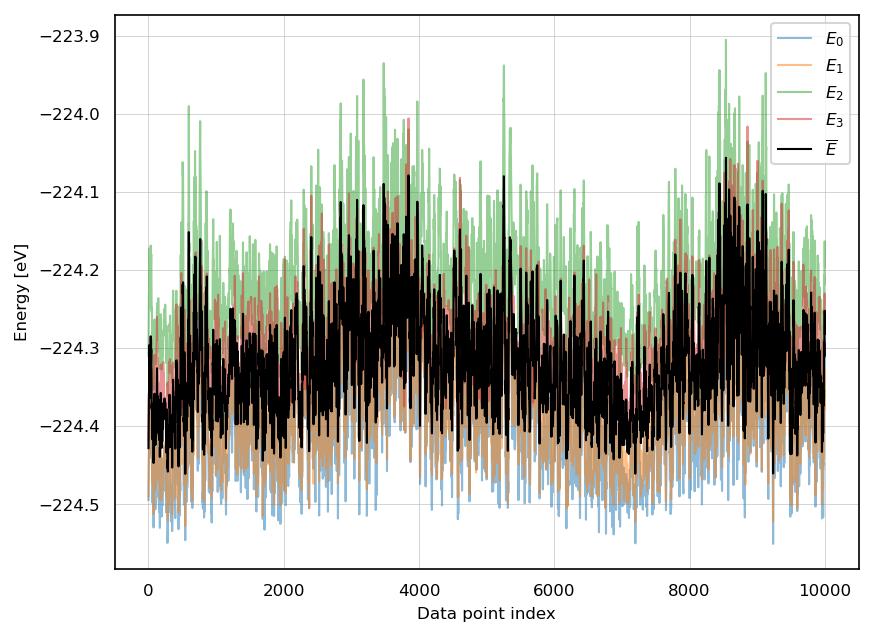

In [124]:
for n, e in enumerate(energies):
    plt.plot(e, label=rf'$E_{n:d}$', alpha=0.5)
plt.plot(avg_energy, label=r'$\overline{E}$', color='k')
plt.legend()
plt.xlabel('Data point index')
plt.ylabel('Energy [eV]');

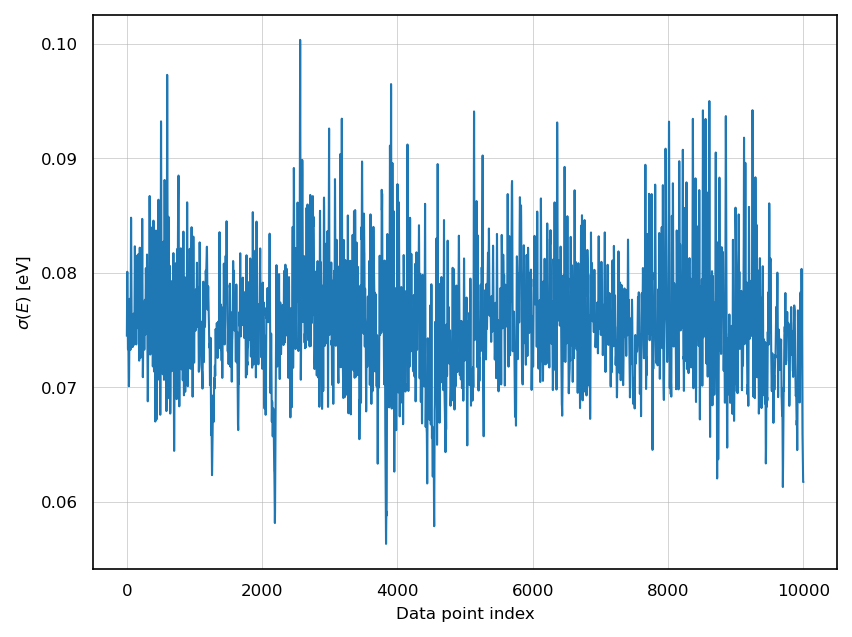

In [125]:
plt.plot(disagreement)
plt.xlabel('Data point index')
plt.ylabel(r'$\sigma(E)$ [eV]');

# Select relevant training data via Query by Committee (QbC)

Some text...

In [115]:
def run_qbc(fns_committee, fn_candidates, fn_train_init, n_iter, n_add_iter=10, recalculate_selected=False, calculator=None):
    """Main QbC loop."""
    # TODO: Add the possibility of attaching a ASE calculator for later when we need to address unlabeled data.
    # TODO: think about striding the candidates to make it more efficient
    # TODO: start from training set size 0?

    print(f'Starting QbC.')
    print(f'{n_iter:d} iterations will be done in total and {n_add_iter:d} will be added every iteration.')

    os.makedirs('QbC', exist_ok=True)

    candidates = read(fn_candidates, index=':')
    training_set = []
    for _ in tqdm(range(n_iter)):

        # predict sigma on all candidates
        print(f'Predicting committee disagreement across the candidate pool.')
        energies = []
        for n, model in enumerate(fns_committee):
            fn_dump = f'QbC/eval_train_{n:02d}.extxyz'
            eval_mace(model, fn_candidates, fn_dump) # Explicit arguments!
            e = extxyz2energy(fn_dump)
            energies.append(e)
        energies = np.array(energies)
        disagreement = energies.std(axis=0)
        avg_disagreement_pool = disagreement.mean()

        # pick the `n_add_iter` highest-disagreement structures
        print(f'Picking {n_add_iter:d} new highest-disagreement data points.')
        idcs_selected = np.argsort(disagreement)[-n_add_iter:]
        print(idcs_selected)
        avg_disagreement_selected = (disagreement[idcs_selected]).mean()
        # TODO: an ASE calculator will come here
        if recalculate_selected:
            assert calculator is not None, 'If a first-principles recalculation of training data is requested, a corresponding ASE calculator must be assigned.'
            print(f'Recalculating ab initio energies and forces for new data points.')
            for structure in candidates[idcs_selected]:
                structure.calc = calculator
                structure.get_potential_energy()
                structure.get_forces()
        #training_set.append([candidates[i] for i in idcs_selected])
        #candidates = np.delete(candidates, idcs_selected)
        # TODO: super ugly, make it better
        for i in idcs_selected:
            training_set.append(candidates[i])
        for i in idcs_selected:
            del candidates[i]

        # dump files with structures
        write('QbC/train.extxyz', training_set, format='extxyz')
        write('QbC/candidates.extxyz', candidates, format='extxyz')

        # retrain the committee with the enriched training set
        print(f'Retraining committee.')
        # TODO: add multiprocessing
        # TODO: add model refinement
        for n in range(len(fns_committee)):
            train_mace(f"config/config.{n}.yml")

        # update the candidate file name
        fn_candidates = 'QbC/candidates.extxyz'

        print(f'Status at the end of this QbC iteration: Disagreement (pool) [eV]    Disagreement (selected) [eV]')
        print(f'                                         {avg_disagreement_pool:06f} {avg_disagreement_selected:06f}')

In [116]:
# Define different values for each config
os.makedirs('config', exist_ok=True)
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 100

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"
model_dir: "models"
log_dir: "log"
checkpoints_dir: "checkpoints"
results_dir: "results"
train_file: "QbC/train.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
E0s: "average" # to be fixed
device: cpu
swa: true
seed: {seeds[i]}
restart_latest: True
"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote config/config.0.yml
Wrote config/config.1.yml
Wrote config/config.2.yml
Wrote config/config.3.yml


In [117]:
fns_committee = [f'models/mace.n={n:d}.model' for n in range(n_committee)]

In [118]:
run_qbc(
    fns_committee=fns_committee,
    fn_candidates='structures/remaining.extxyz',
    fn_train_init='structures/init.train.extxyz',
    n_iter=2
)

Starting QbC.
2 iterations will be done in total and 10 will be added every iteration.


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Using CPU


Predicting committee disagreement across the candidate pool.
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU
2025-05-15 18:26:08.100 INFO: Using CPU


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/cli/eval_configs.py:78: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(
INFO:root:Using CPU


2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU
2025-05-15 18:26:16.594 INFO: Using CPU


INFO:root:Using CPU


2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU
2025-05-15 18:26:24.110 INFO: Using CPU


INFO:root:Using CPU


2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
2025-05-15 18:26:32.434 INFO: Using CPU
Picking 10 new highest-disagreement data points.
[3880  594 3879  592 2544  593 2548 2545 2547 2546]


INFO:root:===========VERIFYING SETTINGS===========


Retraining committee.
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:41.172 INFO: ===========VERIFYING SETTINGS===========


INFO:root:MACE version: 0.3.13


2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13
2025-05-15 18:26:41.174 INFO: MACE version: 0.3.13


DEBUG:root:Configuration: Namespace(config='config/config.0.yml', name='mace.com=0', seed=2696418368, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='QbC/train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None, multi_proc

2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU
2025-05-15 18:26:41.176 INFO: Using CPU


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)
DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:41.182 INFO: ===========LOADING INPUT DATA===========


INFO:root:Using heads: ['Default']


2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']
2025-05-15 18:26:41.184 INFO: Using heads: ['Default']


INFO:root:Using the key specifications to parse data:


2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:
2025-05-15 18:26:41.186 INFO: Using the key specifications to parse data:


INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:26:41.188 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:26:41.188 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:26:41.188 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:26:41.188 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:26:41.188 INFO: De

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:41.190 INFO: =============

DEBUG:root:Loading training file: QbC/train.extxyz
INFO:root:Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]


2025-05-15 18:26:41.195 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.195 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.195 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.195 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.195 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.195 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.195 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.195 INF

INFO:root:Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]


2025-05-15 18:26:41.197 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.197 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.197 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.197 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.197 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.197 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:41.197 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18

INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:41.199 INFO: No validation set provided, splitting training data instead.

INFO:root:Using random 10% of training set for validation with following indices: [0]


2025-05-15 18:26:41.201 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:26:41.201 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:26:41.201 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:26:41.201 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:26:41.201 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:26:41.201 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:26:41.201 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:26:41.201 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:26:41.201 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:26:41.201 INFO: Using random 10%

INFO:root:Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]


2025-05-15 18:26:41.203 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:41.203 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:41.203 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:41.203 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:41.203 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:41.203 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:41.203 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 

INFO:root:Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]


2025-05-15 18:26:41.204 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:41.204 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:41.204 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:41.204 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:41.204 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:41.204 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:41.204 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, hea

INFO:root:Total number of configurations: train=9, valid=1, tests=[],


2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:41.206 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15

2025-05-15 18:26:41.208 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:41.208 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:41.208 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:41.208 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:41.208 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:41.208 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:41.208 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:41.208 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:41.208 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:41

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:41.210 INFO: Atomic Numbers used: [1, 8]


INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:26:41.212 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:41.212 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:41.212 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:41.212 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:41.212 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:41.212 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:41.212 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:41.212 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:41.212 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:26:41.213 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:41.213 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:41.213 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:41.213 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:41.213 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:41.213 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:41.213 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:41.213 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:41.213 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:41.213 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:41.213 INFO: Computing average At

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}


2025-05-15 18:26:41.215 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:26:41.215 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:26:41.215 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:26:41.215 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:26:41.215 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:26:41.215 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:26:41.215 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:26:41.215 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}


INFO:root:Processing datasets for head 'Default'


2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:41.217 INFO: Processing datasets for head 'Default'


DEBUG:root:Successfully loaded dataset from ASE files: ['QbC/train.extxyz']
INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:41.222 INFO: Combining 1 list datasets for head 'Default'


INFO:root:Head 'Default' training dataset size: 9


2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:41.224 INFO: Head 'Default' training dataset size: 9


INFO:root:Computing average number of neighbors


2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors
2025-05-15 18:26:41.226 INFO: Computing average number of neighbors


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Average number of neighbors: 6.0


2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:41.230 INFO: Average number of neighbors: 6.0


INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:26:41.232 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:41.232 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:41.232 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:41.232 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:41.232 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:41.232 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:41.232 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:41.232 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:41.232 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:41.232 INFO: During training the following quan

INFO:root:===========MODEL DETAILS===========


2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:41.234 INFO: ===========MODEL DETAILS===========


INFO:root:Building model


2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model
2025-05-15 18:26:41.238 INFO: Building model


INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:41.240 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:26:41.242 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:41.242 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:41.242 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:41.242 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:41.242 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:41.242 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:41.242 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:41.242 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:41.242 

INFO:root:8 radial and 5 basis functions


2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:41.244 INFO: 8 radial and 5 basis functions


INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:26:41.245 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:41.245 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:41.245 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:41.245 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:41.245 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:41.245 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:41.245 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:41.245 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:41.245 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:41.245 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:41.245 INFO: Radial cut

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:41.247 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26

INFO:root:Hidden irreps: 16x0e


2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:41.249 INFO: Hidden irreps: 16x0e


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472
2025-05-15 18:26:41.627 INFO: Total number of parameters: 25472


INFO:root:


2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 
2025-05-15 18:26:41.630 INFO: 


INFO:root:===========OPTIMIZER INFORMATION===========


2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:41.632 INFO: ===========OPTIMIZER INFORMATION===========


INFO:root:Using ADAM as parameter optimizer


2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:41.634 INFO: Using ADAM as parameter optimizer


INFO:root:Batch size: 4


2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4
2025-05-15 18:26:41.637 INFO: Batch size: 4


INFO:root:Number of gradient updates: 225


2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225
2025-05-15 18:26:41.639 INFO: Number of gradient updates: 225


INFO:root:Learning rate: 0.01, weight decay: 5e-07


2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:41.642 INFO: Learning rate: 0.01, weight decay: 5e-07


INFO:root:WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)


2025-05-15 18:26:41.644 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:41.644 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:41.644 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:41.644 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:41.644 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:41.644 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:41.644 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:41.644 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:41.644 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:41.644 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15

INFO:root:Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001


2025-05-15 18:26:41.647 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:26:41.647 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:26:41.647 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:26:41.647 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:26:41.647 INFO: Stage Two (after 75 epochs) with loss function: WeightedEn

2025-05-15 18:26:41.711 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-2696418368' in 'checkpoints'
2025-05-15 18:26:41.711 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-2696418368' in 'checkpoints'
2025-05-15 18:26:41.711 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-2696418368' in 'checkpoints'
2025-05-15 18:26:41.711 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-2696418368' in 'checkpoints'
2025-05-15 18:26:41.711 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-2696418368' in 'checkpoints'
2025-05-15 18:26:41.711 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-2696418368' in 'checkpoints'
2025-05-15 18:26:41.711 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-2696418368' in 'checkpoints'
2025-05-15 18:26:41.711 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-2696418368' in 'checkpoints'
2025-05-15 18:26:41.711 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-2696418368' in 'checkpoints'
2025-05-15

INFO:root:Using gradient clipping with tolerance=10.000


2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:41.715 INFO: Using gradient clipping with tolerance=10.000


INFO:root:


2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 
2025-05-15 18:26:41.717 INFO: 


INFO:root:===========TRAINING===========


2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========
2025-05-15 18:26:41.720 INFO: ===========TRAINING===========


INFO:root:Started training, reporting errors on validation set


2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:41.723 INFO: Started training, reporting errors on validation set
2025

INFO:root:Loss metrics on validation set


2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set
2025-05-15 18:26:41.725 INFO: Loss metrics on validation set


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Initial: head: Default, loss=123.44525742, RMSE_E_per_atom=   19.63 meV, RMSE_F= 1111.06 meV / A


2025-05-15 18:26:41.785 INFO: Initial: head: Default, loss=123.44525742, RMSE_E_per_atom=   19.63 meV, RMSE_F= 1111.06 meV / A
2025-05-15 18:26:41.785 INFO: Initial: head: Default, loss=123.44525742, RMSE_E_per_atom=   19.63 meV, RMSE_F= 1111.06 meV / A
2025-05-15 18:26:41.785 INFO: Initial: head: Default, loss=123.44525742, RMSE_E_per_atom=   19.63 meV, RMSE_F= 1111.06 meV / A
2025-05-15 18:26:41.785 INFO: Initial: head: Default, loss=123.44525742, RMSE_E_per_atom=   19.63 meV, RMSE_F= 1111.06 meV / A
2025-05-15 18:26:41.785 INFO: Initial: head: Default, loss=123.44525742, RMSE_E_per_atom=   19.63 meV, RMSE_F= 1111.06 meV / A
2025-05-15 18:26:41.785 INFO: Initial: head: Default, loss=123.44525742, RMSE_E_per_atom=   19.63 meV, RMSE_F= 1111.06 meV / A
2025-05-15 18:26:41.785 INFO: Initial: head: Default, loss=123.44525742, RMSE_E_per_atom=   19.63 meV, RMSE_F= 1111.06 meV / A
2025-05-15 18:26:41.785 INFO: Initial: head: Default, loss=123.44525742, RMSE_E_per_atom=   19.63 meV, RMSE_F= 

INFO:root:Epoch 0: head: Default, loss=99.77384707, RMSE_E_per_atom=    8.32 meV, RMSE_F=  998.87 meV / A


2025-05-15 18:26:41.929 INFO: Epoch 0: head: Default, loss=99.77384707, RMSE_E_per_atom=    8.32 meV, RMSE_F=  998.87 meV / A
2025-05-15 18:26:41.929 INFO: Epoch 0: head: Default, loss=99.77384707, RMSE_E_per_atom=    8.32 meV, RMSE_F=  998.87 meV / A
2025-05-15 18:26:41.929 INFO: Epoch 0: head: Default, loss=99.77384707, RMSE_E_per_atom=    8.32 meV, RMSE_F=  998.87 meV / A
2025-05-15 18:26:41.929 INFO: Epoch 0: head: Default, loss=99.77384707, RMSE_E_per_atom=    8.32 meV, RMSE_F=  998.87 meV / A
2025-05-15 18:26:41.929 INFO: Epoch 0: head: Default, loss=99.77384707, RMSE_E_per_atom=    8.32 meV, RMSE_F=  998.87 meV / A
2025-05-15 18:26:41.929 INFO: Epoch 0: head: Default, loss=99.77384707, RMSE_E_per_atom=    8.32 meV, RMSE_F=  998.87 meV / A
2025-05-15 18:26:41.929 INFO: Epoch 0: head: Default, loss=99.77384707, RMSE_E_per_atom=    8.32 meV, RMSE_F=  998.87 meV / A
2025-05-15 18:26:41.929 INFO: Epoch 0: head: Default, loss=99.77384707, RMSE_E_per_atom=    8.32 meV, RMSE_F=  998.87 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-0.pt
INFO:root:Epoch 1: head: Default, loss=91.65991100, RMSE_E_per_atom=   42.45 meV, RMSE_F=  957.38 meV / A


2025-05-15 18:26:41.991 INFO: Epoch 1: head: Default, loss=91.65991100, RMSE_E_per_atom=   42.45 meV, RMSE_F=  957.38 meV / A
2025-05-15 18:26:41.991 INFO: Epoch 1: head: Default, loss=91.65991100, RMSE_E_per_atom=   42.45 meV, RMSE_F=  957.38 meV / A
2025-05-15 18:26:41.991 INFO: Epoch 1: head: Default, loss=91.65991100, RMSE_E_per_atom=   42.45 meV, RMSE_F=  957.38 meV / A
2025-05-15 18:26:41.991 INFO: Epoch 1: head: Default, loss=91.65991100, RMSE_E_per_atom=   42.45 meV, RMSE_F=  957.38 meV / A
2025-05-15 18:26:41.991 INFO: Epoch 1: head: Default, loss=91.65991100, RMSE_E_per_atom=   42.45 meV, RMSE_F=  957.38 meV / A
2025-05-15 18:26:41.991 INFO: Epoch 1: head: Default, loss=91.65991100, RMSE_E_per_atom=   42.45 meV, RMSE_F=  957.38 meV / A
2025-05-15 18:26:41.991 INFO: Epoch 1: head: Default, loss=91.65991100, RMSE_E_per_atom=   42.45 meV, RMSE_F=  957.38 meV / A
2025-05-15 18:26:41.991 INFO: Epoch 1: head: Default, loss=91.65991100, RMSE_E_per_atom=   42.45 meV, RMSE_F=  957.38 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-0.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-1.pt
INFO:root:Epoch 2: head: Default, loss=90.11845100, RMSE_E_per_atom=  121.16 meV, RMSE_F=  949.23 meV / A


2025-05-15 18:26:42.053 INFO: Epoch 2: head: Default, loss=90.11845100, RMSE_E_per_atom=  121.16 meV, RMSE_F=  949.23 meV / A
2025-05-15 18:26:42.053 INFO: Epoch 2: head: Default, loss=90.11845100, RMSE_E_per_atom=  121.16 meV, RMSE_F=  949.23 meV / A
2025-05-15 18:26:42.053 INFO: Epoch 2: head: Default, loss=90.11845100, RMSE_E_per_atom=  121.16 meV, RMSE_F=  949.23 meV / A
2025-05-15 18:26:42.053 INFO: Epoch 2: head: Default, loss=90.11845100, RMSE_E_per_atom=  121.16 meV, RMSE_F=  949.23 meV / A
2025-05-15 18:26:42.053 INFO: Epoch 2: head: Default, loss=90.11845100, RMSE_E_per_atom=  121.16 meV, RMSE_F=  949.23 meV / A
2025-05-15 18:26:42.053 INFO: Epoch 2: head: Default, loss=90.11845100, RMSE_E_per_atom=  121.16 meV, RMSE_F=  949.23 meV / A
2025-05-15 18:26:42.053 INFO: Epoch 2: head: Default, loss=90.11845100, RMSE_E_per_atom=  121.16 meV, RMSE_F=  949.23 meV / A
2025-05-15 18:26:42.053 INFO: Epoch 2: head: Default, loss=90.11845100, RMSE_E_per_atom=  121.16 meV, RMSE_F=  949.23 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-1.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-2.pt
INFO:root:Epoch 3: head: Default, loss=89.70719234, RMSE_E_per_atom=  212.09 meV, RMSE_F=  946.90 meV / A


2025-05-15 18:26:42.118 INFO: Epoch 3: head: Default, loss=89.70719234, RMSE_E_per_atom=  212.09 meV, RMSE_F=  946.90 meV / A
2025-05-15 18:26:42.118 INFO: Epoch 3: head: Default, loss=89.70719234, RMSE_E_per_atom=  212.09 meV, RMSE_F=  946.90 meV / A
2025-05-15 18:26:42.118 INFO: Epoch 3: head: Default, loss=89.70719234, RMSE_E_per_atom=  212.09 meV, RMSE_F=  946.90 meV / A
2025-05-15 18:26:42.118 INFO: Epoch 3: head: Default, loss=89.70719234, RMSE_E_per_atom=  212.09 meV, RMSE_F=  946.90 meV / A
2025-05-15 18:26:42.118 INFO: Epoch 3: head: Default, loss=89.70719234, RMSE_E_per_atom=  212.09 meV, RMSE_F=  946.90 meV / A
2025-05-15 18:26:42.118 INFO: Epoch 3: head: Default, loss=89.70719234, RMSE_E_per_atom=  212.09 meV, RMSE_F=  946.90 meV / A
2025-05-15 18:26:42.118 INFO: Epoch 3: head: Default, loss=89.70719234, RMSE_E_per_atom=  212.09 meV, RMSE_F=  946.90 meV / A
2025-05-15 18:26:42.118 INFO: Epoch 3: head: Default, loss=89.70719234, RMSE_E_per_atom=  212.09 meV, RMSE_F=  946.90 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-2.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-3.pt
INFO:root:Epoch 4: head: Default, loss=87.43058323, RMSE_E_per_atom=  294.99 meV, RMSE_F=  934.58 meV / A


2025-05-15 18:26:42.182 INFO: Epoch 4: head: Default, loss=87.43058323, RMSE_E_per_atom=  294.99 meV, RMSE_F=  934.58 meV / A
2025-05-15 18:26:42.182 INFO: Epoch 4: head: Default, loss=87.43058323, RMSE_E_per_atom=  294.99 meV, RMSE_F=  934.58 meV / A
2025-05-15 18:26:42.182 INFO: Epoch 4: head: Default, loss=87.43058323, RMSE_E_per_atom=  294.99 meV, RMSE_F=  934.58 meV / A
2025-05-15 18:26:42.182 INFO: Epoch 4: head: Default, loss=87.43058323, RMSE_E_per_atom=  294.99 meV, RMSE_F=  934.58 meV / A
2025-05-15 18:26:42.182 INFO: Epoch 4: head: Default, loss=87.43058323, RMSE_E_per_atom=  294.99 meV, RMSE_F=  934.58 meV / A
2025-05-15 18:26:42.182 INFO: Epoch 4: head: Default, loss=87.43058323, RMSE_E_per_atom=  294.99 meV, RMSE_F=  934.58 meV / A
2025-05-15 18:26:42.182 INFO: Epoch 4: head: Default, loss=87.43058323, RMSE_E_per_atom=  294.99 meV, RMSE_F=  934.58 meV / A
2025-05-15 18:26:42.182 INFO: Epoch 4: head: Default, loss=87.43058323, RMSE_E_per_atom=  294.99 meV, RMSE_F=  934.58 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-3.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-4.pt
INFO:root:Epoch 5: head: Default, loss=81.76817739, RMSE_E_per_atom=  367.26 meV, RMSE_F=  903.51 meV / A


2025-05-15 18:26:42.245 INFO: Epoch 5: head: Default, loss=81.76817739, RMSE_E_per_atom=  367.26 meV, RMSE_F=  903.51 meV / A
2025-05-15 18:26:42.245 INFO: Epoch 5: head: Default, loss=81.76817739, RMSE_E_per_atom=  367.26 meV, RMSE_F=  903.51 meV / A
2025-05-15 18:26:42.245 INFO: Epoch 5: head: Default, loss=81.76817739, RMSE_E_per_atom=  367.26 meV, RMSE_F=  903.51 meV / A
2025-05-15 18:26:42.245 INFO: Epoch 5: head: Default, loss=81.76817739, RMSE_E_per_atom=  367.26 meV, RMSE_F=  903.51 meV / A
2025-05-15 18:26:42.245 INFO: Epoch 5: head: Default, loss=81.76817739, RMSE_E_per_atom=  367.26 meV, RMSE_F=  903.51 meV / A
2025-05-15 18:26:42.245 INFO: Epoch 5: head: Default, loss=81.76817739, RMSE_E_per_atom=  367.26 meV, RMSE_F=  903.51 meV / A
2025-05-15 18:26:42.245 INFO: Epoch 5: head: Default, loss=81.76817739, RMSE_E_per_atom=  367.26 meV, RMSE_F=  903.51 meV / A
2025-05-15 18:26:42.245 INFO: Epoch 5: head: Default, loss=81.76817739, RMSE_E_per_atom=  367.26 meV, RMSE_F=  903.51 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-4.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-5.pt
INFO:root:Epoch 6: head: Default, loss=71.79289242, RMSE_E_per_atom=  419.55 meV, RMSE_F=  846.27 meV / A


2025-05-15 18:26:42.308 INFO: Epoch 6: head: Default, loss=71.79289242, RMSE_E_per_atom=  419.55 meV, RMSE_F=  846.27 meV / A
2025-05-15 18:26:42.308 INFO: Epoch 6: head: Default, loss=71.79289242, RMSE_E_per_atom=  419.55 meV, RMSE_F=  846.27 meV / A
2025-05-15 18:26:42.308 INFO: Epoch 6: head: Default, loss=71.79289242, RMSE_E_per_atom=  419.55 meV, RMSE_F=  846.27 meV / A
2025-05-15 18:26:42.308 INFO: Epoch 6: head: Default, loss=71.79289242, RMSE_E_per_atom=  419.55 meV, RMSE_F=  846.27 meV / A
2025-05-15 18:26:42.308 INFO: Epoch 6: head: Default, loss=71.79289242, RMSE_E_per_atom=  419.55 meV, RMSE_F=  846.27 meV / A
2025-05-15 18:26:42.308 INFO: Epoch 6: head: Default, loss=71.79289242, RMSE_E_per_atom=  419.55 meV, RMSE_F=  846.27 meV / A
2025-05-15 18:26:42.308 INFO: Epoch 6: head: Default, loss=71.79289242, RMSE_E_per_atom=  419.55 meV, RMSE_F=  846.27 meV / A
2025-05-15 18:26:42.308 INFO: Epoch 6: head: Default, loss=71.79289242, RMSE_E_per_atom=  419.55 meV, RMSE_F=  846.27 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-5.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-6.pt
INFO:root:Epoch 7: head: Default, loss=58.67574301, RMSE_E_per_atom=  421.74 meV, RMSE_F=  764.84 meV / A


2025-05-15 18:26:42.375 INFO: Epoch 7: head: Default, loss=58.67574301, RMSE_E_per_atom=  421.74 meV, RMSE_F=  764.84 meV / A
2025-05-15 18:26:42.375 INFO: Epoch 7: head: Default, loss=58.67574301, RMSE_E_per_atom=  421.74 meV, RMSE_F=  764.84 meV / A
2025-05-15 18:26:42.375 INFO: Epoch 7: head: Default, loss=58.67574301, RMSE_E_per_atom=  421.74 meV, RMSE_F=  764.84 meV / A
2025-05-15 18:26:42.375 INFO: Epoch 7: head: Default, loss=58.67574301, RMSE_E_per_atom=  421.74 meV, RMSE_F=  764.84 meV / A
2025-05-15 18:26:42.375 INFO: Epoch 7: head: Default, loss=58.67574301, RMSE_E_per_atom=  421.74 meV, RMSE_F=  764.84 meV / A
2025-05-15 18:26:42.375 INFO: Epoch 7: head: Default, loss=58.67574301, RMSE_E_per_atom=  421.74 meV, RMSE_F=  764.84 meV / A
2025-05-15 18:26:42.375 INFO: Epoch 7: head: Default, loss=58.67574301, RMSE_E_per_atom=  421.74 meV, RMSE_F=  764.84 meV / A
2025-05-15 18:26:42.375 INFO: Epoch 7: head: Default, loss=58.67574301, RMSE_E_per_atom=  421.74 meV, RMSE_F=  764.84 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-6.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-7.pt
INFO:root:Epoch 8: head: Default, loss=42.80946764, RMSE_E_per_atom=  477.67 meV, RMSE_F=  652.54 meV / A


2025-05-15 18:26:42.441 INFO: Epoch 8: head: Default, loss=42.80946764, RMSE_E_per_atom=  477.67 meV, RMSE_F=  652.54 meV / A
2025-05-15 18:26:42.441 INFO: Epoch 8: head: Default, loss=42.80946764, RMSE_E_per_atom=  477.67 meV, RMSE_F=  652.54 meV / A
2025-05-15 18:26:42.441 INFO: Epoch 8: head: Default, loss=42.80946764, RMSE_E_per_atom=  477.67 meV, RMSE_F=  652.54 meV / A
2025-05-15 18:26:42.441 INFO: Epoch 8: head: Default, loss=42.80946764, RMSE_E_per_atom=  477.67 meV, RMSE_F=  652.54 meV / A
2025-05-15 18:26:42.441 INFO: Epoch 8: head: Default, loss=42.80946764, RMSE_E_per_atom=  477.67 meV, RMSE_F=  652.54 meV / A
2025-05-15 18:26:42.441 INFO: Epoch 8: head: Default, loss=42.80946764, RMSE_E_per_atom=  477.67 meV, RMSE_F=  652.54 meV / A
2025-05-15 18:26:42.441 INFO: Epoch 8: head: Default, loss=42.80946764, RMSE_E_per_atom=  477.67 meV, RMSE_F=  652.54 meV / A
2025-05-15 18:26:42.441 INFO: Epoch 8: head: Default, loss=42.80946764, RMSE_E_per_atom=  477.67 meV, RMSE_F=  652.54 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-7.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-8.pt
INFO:root:Epoch 9: head: Default, loss=32.44610438, RMSE_E_per_atom=  557.88 meV, RMSE_F=  566.88 meV / A


2025-05-15 18:26:42.506 INFO: Epoch 9: head: Default, loss=32.44610438, RMSE_E_per_atom=  557.88 meV, RMSE_F=  566.88 meV / A
2025-05-15 18:26:42.506 INFO: Epoch 9: head: Default, loss=32.44610438, RMSE_E_per_atom=  557.88 meV, RMSE_F=  566.88 meV / A
2025-05-15 18:26:42.506 INFO: Epoch 9: head: Default, loss=32.44610438, RMSE_E_per_atom=  557.88 meV, RMSE_F=  566.88 meV / A
2025-05-15 18:26:42.506 INFO: Epoch 9: head: Default, loss=32.44610438, RMSE_E_per_atom=  557.88 meV, RMSE_F=  566.88 meV / A
2025-05-15 18:26:42.506 INFO: Epoch 9: head: Default, loss=32.44610438, RMSE_E_per_atom=  557.88 meV, RMSE_F=  566.88 meV / A
2025-05-15 18:26:42.506 INFO: Epoch 9: head: Default, loss=32.44610438, RMSE_E_per_atom=  557.88 meV, RMSE_F=  566.88 meV / A
2025-05-15 18:26:42.506 INFO: Epoch 9: head: Default, loss=32.44610438, RMSE_E_per_atom=  557.88 meV, RMSE_F=  566.88 meV / A
2025-05-15 18:26:42.506 INFO: Epoch 9: head: Default, loss=32.44610438, RMSE_E_per_atom=  557.88 meV, RMSE_F=  566.88 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-8.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-9.pt
INFO:root:Epoch 10: head: Default, loss=21.18963071, RMSE_E_per_atom=  695.43 meV, RMSE_F=  455.04 meV / A


2025-05-15 18:26:42.572 INFO: Epoch 10: head: Default, loss=21.18963071, RMSE_E_per_atom=  695.43 meV, RMSE_F=  455.04 meV / A
2025-05-15 18:26:42.572 INFO: Epoch 10: head: Default, loss=21.18963071, RMSE_E_per_atom=  695.43 meV, RMSE_F=  455.04 meV / A
2025-05-15 18:26:42.572 INFO: Epoch 10: head: Default, loss=21.18963071, RMSE_E_per_atom=  695.43 meV, RMSE_F=  455.04 meV / A
2025-05-15 18:26:42.572 INFO: Epoch 10: head: Default, loss=21.18963071, RMSE_E_per_atom=  695.43 meV, RMSE_F=  455.04 meV / A
2025-05-15 18:26:42.572 INFO: Epoch 10: head: Default, loss=21.18963071, RMSE_E_per_atom=  695.43 meV, RMSE_F=  455.04 meV / A
2025-05-15 18:26:42.572 INFO: Epoch 10: head: Default, loss=21.18963071, RMSE_E_per_atom=  695.43 meV, RMSE_F=  455.04 meV / A
2025-05-15 18:26:42.572 INFO: Epoch 10: head: Default, loss=21.18963071, RMSE_E_per_atom=  695.43 meV, RMSE_F=  455.04 meV / A
2025-05-15 18:26:42.572 INFO: Epoch 10: head: Default, loss=21.18963071, RMSE_E_per_atom=  695.43 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-9.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-10.pt
INFO:root:Epoch 11: head: Default, loss=25.01414086, RMSE_E_per_atom=  771.21 meV, RMSE_F=  494.16 meV / A


2025-05-15 18:26:42.638 INFO: Epoch 11: head: Default, loss=25.01414086, RMSE_E_per_atom=  771.21 meV, RMSE_F=  494.16 meV / A
2025-05-15 18:26:42.638 INFO: Epoch 11: head: Default, loss=25.01414086, RMSE_E_per_atom=  771.21 meV, RMSE_F=  494.16 meV / A
2025-05-15 18:26:42.638 INFO: Epoch 11: head: Default, loss=25.01414086, RMSE_E_per_atom=  771.21 meV, RMSE_F=  494.16 meV / A
2025-05-15 18:26:42.638 INFO: Epoch 11: head: Default, loss=25.01414086, RMSE_E_per_atom=  771.21 meV, RMSE_F=  494.16 meV / A
2025-05-15 18:26:42.638 INFO: Epoch 11: head: Default, loss=25.01414086, RMSE_E_per_atom=  771.21 meV, RMSE_F=  494.16 meV / A
2025-05-15 18:26:42.638 INFO: Epoch 11: head: Default, loss=25.01414086, RMSE_E_per_atom=  771.21 meV, RMSE_F=  494.16 meV / A
2025-05-15 18:26:42.638 INFO: Epoch 11: head: Default, loss=25.01414086, RMSE_E_per_atom=  771.21 meV, RMSE_F=  494.16 meV / A
2025-05-15 18:26:42.638 INFO: Epoch 11: head: Default, loss=25.01414086, RMSE_E_per_atom=  771.21 meV, RMSE_F= 

INFO:root:Epoch 12: head: Default, loss=26.19204755, RMSE_E_per_atom=  698.18 meV, RMSE_F=  507.00 meV / A


2025-05-15 18:26:42.698 INFO: Epoch 12: head: Default, loss=26.19204755, RMSE_E_per_atom=  698.18 meV, RMSE_F=  507.00 meV / A
2025-05-15 18:26:42.698 INFO: Epoch 12: head: Default, loss=26.19204755, RMSE_E_per_atom=  698.18 meV, RMSE_F=  507.00 meV / A
2025-05-15 18:26:42.698 INFO: Epoch 12: head: Default, loss=26.19204755, RMSE_E_per_atom=  698.18 meV, RMSE_F=  507.00 meV / A
2025-05-15 18:26:42.698 INFO: Epoch 12: head: Default, loss=26.19204755, RMSE_E_per_atom=  698.18 meV, RMSE_F=  507.00 meV / A
2025-05-15 18:26:42.698 INFO: Epoch 12: head: Default, loss=26.19204755, RMSE_E_per_atom=  698.18 meV, RMSE_F=  507.00 meV / A
2025-05-15 18:26:42.698 INFO: Epoch 12: head: Default, loss=26.19204755, RMSE_E_per_atom=  698.18 meV, RMSE_F=  507.00 meV / A
2025-05-15 18:26:42.698 INFO: Epoch 12: head: Default, loss=26.19204755, RMSE_E_per_atom=  698.18 meV, RMSE_F=  507.00 meV / A
2025-05-15 18:26:42.698 INFO: Epoch 12: head: Default, loss=26.19204755, RMSE_E_per_atom=  698.18 meV, RMSE_F= 

INFO:root:Epoch 13: head: Default, loss=22.59935403, RMSE_E_per_atom=  584.68 meV, RMSE_F=  471.78 meV / A


2025-05-15 18:26:42.757 INFO: Epoch 13: head: Default, loss=22.59935403, RMSE_E_per_atom=  584.68 meV, RMSE_F=  471.78 meV / A
2025-05-15 18:26:42.757 INFO: Epoch 13: head: Default, loss=22.59935403, RMSE_E_per_atom=  584.68 meV, RMSE_F=  471.78 meV / A
2025-05-15 18:26:42.757 INFO: Epoch 13: head: Default, loss=22.59935403, RMSE_E_per_atom=  584.68 meV, RMSE_F=  471.78 meV / A
2025-05-15 18:26:42.757 INFO: Epoch 13: head: Default, loss=22.59935403, RMSE_E_per_atom=  584.68 meV, RMSE_F=  471.78 meV / A
2025-05-15 18:26:42.757 INFO: Epoch 13: head: Default, loss=22.59935403, RMSE_E_per_atom=  584.68 meV, RMSE_F=  471.78 meV / A
2025-05-15 18:26:42.757 INFO: Epoch 13: head: Default, loss=22.59935403, RMSE_E_per_atom=  584.68 meV, RMSE_F=  471.78 meV / A
2025-05-15 18:26:42.757 INFO: Epoch 13: head: Default, loss=22.59935403, RMSE_E_per_atom=  584.68 meV, RMSE_F=  471.78 meV / A
2025-05-15 18:26:42.757 INFO: Epoch 13: head: Default, loss=22.59935403, RMSE_E_per_atom=  584.68 meV, RMSE_F= 

INFO:root:Epoch 14: head: Default, loss=23.42946814, RMSE_E_per_atom=  555.28 meV, RMSE_F=  480.84 meV / A


2025-05-15 18:26:42.816 INFO: Epoch 14: head: Default, loss=23.42946814, RMSE_E_per_atom=  555.28 meV, RMSE_F=  480.84 meV / A
2025-05-15 18:26:42.816 INFO: Epoch 14: head: Default, loss=23.42946814, RMSE_E_per_atom=  555.28 meV, RMSE_F=  480.84 meV / A
2025-05-15 18:26:42.816 INFO: Epoch 14: head: Default, loss=23.42946814, RMSE_E_per_atom=  555.28 meV, RMSE_F=  480.84 meV / A
2025-05-15 18:26:42.816 INFO: Epoch 14: head: Default, loss=23.42946814, RMSE_E_per_atom=  555.28 meV, RMSE_F=  480.84 meV / A
2025-05-15 18:26:42.816 INFO: Epoch 14: head: Default, loss=23.42946814, RMSE_E_per_atom=  555.28 meV, RMSE_F=  480.84 meV / A
2025-05-15 18:26:42.816 INFO: Epoch 14: head: Default, loss=23.42946814, RMSE_E_per_atom=  555.28 meV, RMSE_F=  480.84 meV / A
2025-05-15 18:26:42.816 INFO: Epoch 14: head: Default, loss=23.42946814, RMSE_E_per_atom=  555.28 meV, RMSE_F=  480.84 meV / A
2025-05-15 18:26:42.816 INFO: Epoch 14: head: Default, loss=23.42946814, RMSE_E_per_atom=  555.28 meV, RMSE_F= 

INFO:root:Epoch 15: head: Default, loss=26.70281089, RMSE_E_per_atom=  600.64 meV, RMSE_F=  513.24 meV / A


2025-05-15 18:26:42.874 INFO: Epoch 15: head: Default, loss=26.70281089, RMSE_E_per_atom=  600.64 meV, RMSE_F=  513.24 meV / A
2025-05-15 18:26:42.874 INFO: Epoch 15: head: Default, loss=26.70281089, RMSE_E_per_atom=  600.64 meV, RMSE_F=  513.24 meV / A
2025-05-15 18:26:42.874 INFO: Epoch 15: head: Default, loss=26.70281089, RMSE_E_per_atom=  600.64 meV, RMSE_F=  513.24 meV / A
2025-05-15 18:26:42.874 INFO: Epoch 15: head: Default, loss=26.70281089, RMSE_E_per_atom=  600.64 meV, RMSE_F=  513.24 meV / A
2025-05-15 18:26:42.874 INFO: Epoch 15: head: Default, loss=26.70281089, RMSE_E_per_atom=  600.64 meV, RMSE_F=  513.24 meV / A
2025-05-15 18:26:42.874 INFO: Epoch 15: head: Default, loss=26.70281089, RMSE_E_per_atom=  600.64 meV, RMSE_F=  513.24 meV / A
2025-05-15 18:26:42.874 INFO: Epoch 15: head: Default, loss=26.70281089, RMSE_E_per_atom=  600.64 meV, RMSE_F=  513.24 meV / A
2025-05-15 18:26:42.874 INFO: Epoch 15: head: Default, loss=26.70281089, RMSE_E_per_atom=  600.64 meV, RMSE_F= 

INFO:root:Epoch 16: head: Default, loss=26.28187443, RMSE_E_per_atom=  646.05 meV, RMSE_F=  508.57 meV / A


2025-05-15 18:26:42.931 INFO: Epoch 16: head: Default, loss=26.28187443, RMSE_E_per_atom=  646.05 meV, RMSE_F=  508.57 meV / A
2025-05-15 18:26:42.931 INFO: Epoch 16: head: Default, loss=26.28187443, RMSE_E_per_atom=  646.05 meV, RMSE_F=  508.57 meV / A
2025-05-15 18:26:42.931 INFO: Epoch 16: head: Default, loss=26.28187443, RMSE_E_per_atom=  646.05 meV, RMSE_F=  508.57 meV / A
2025-05-15 18:26:42.931 INFO: Epoch 16: head: Default, loss=26.28187443, RMSE_E_per_atom=  646.05 meV, RMSE_F=  508.57 meV / A
2025-05-15 18:26:42.931 INFO: Epoch 16: head: Default, loss=26.28187443, RMSE_E_per_atom=  646.05 meV, RMSE_F=  508.57 meV / A
2025-05-15 18:26:42.931 INFO: Epoch 16: head: Default, loss=26.28187443, RMSE_E_per_atom=  646.05 meV, RMSE_F=  508.57 meV / A
2025-05-15 18:26:42.931 INFO: Epoch 16: head: Default, loss=26.28187443, RMSE_E_per_atom=  646.05 meV, RMSE_F=  508.57 meV / A
2025-05-15 18:26:42.931 INFO: Epoch 16: head: Default, loss=26.28187443, RMSE_E_per_atom=  646.05 meV, RMSE_F= 

INFO:root:Epoch 17: head: Default, loss=20.93654432, RMSE_E_per_atom=  647.14 meV, RMSE_F=  452.97 meV / A


2025-05-15 18:26:42.987 INFO: Epoch 17: head: Default, loss=20.93654432, RMSE_E_per_atom=  647.14 meV, RMSE_F=  452.97 meV / A
2025-05-15 18:26:42.987 INFO: Epoch 17: head: Default, loss=20.93654432, RMSE_E_per_atom=  647.14 meV, RMSE_F=  452.97 meV / A
2025-05-15 18:26:42.987 INFO: Epoch 17: head: Default, loss=20.93654432, RMSE_E_per_atom=  647.14 meV, RMSE_F=  452.97 meV / A
2025-05-15 18:26:42.987 INFO: Epoch 17: head: Default, loss=20.93654432, RMSE_E_per_atom=  647.14 meV, RMSE_F=  452.97 meV / A
2025-05-15 18:26:42.987 INFO: Epoch 17: head: Default, loss=20.93654432, RMSE_E_per_atom=  647.14 meV, RMSE_F=  452.97 meV / A
2025-05-15 18:26:42.987 INFO: Epoch 17: head: Default, loss=20.93654432, RMSE_E_per_atom=  647.14 meV, RMSE_F=  452.97 meV / A
2025-05-15 18:26:42.987 INFO: Epoch 17: head: Default, loss=20.93654432, RMSE_E_per_atom=  647.14 meV, RMSE_F=  452.97 meV / A
2025-05-15 18:26:42.987 INFO: Epoch 17: head: Default, loss=20.93654432, RMSE_E_per_atom=  647.14 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-10.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-17.pt
INFO:root:Epoch 18: head: Default, loss=15.29426300, RMSE_E_per_atom=  619.99 meV, RMSE_F=  386.13 meV / A


2025-05-15 18:26:43.052 INFO: Epoch 18: head: Default, loss=15.29426300, RMSE_E_per_atom=  619.99 meV, RMSE_F=  386.13 meV / A
2025-05-15 18:26:43.052 INFO: Epoch 18: head: Default, loss=15.29426300, RMSE_E_per_atom=  619.99 meV, RMSE_F=  386.13 meV / A
2025-05-15 18:26:43.052 INFO: Epoch 18: head: Default, loss=15.29426300, RMSE_E_per_atom=  619.99 meV, RMSE_F=  386.13 meV / A
2025-05-15 18:26:43.052 INFO: Epoch 18: head: Default, loss=15.29426300, RMSE_E_per_atom=  619.99 meV, RMSE_F=  386.13 meV / A
2025-05-15 18:26:43.052 INFO: Epoch 18: head: Default, loss=15.29426300, RMSE_E_per_atom=  619.99 meV, RMSE_F=  386.13 meV / A
2025-05-15 18:26:43.052 INFO: Epoch 18: head: Default, loss=15.29426300, RMSE_E_per_atom=  619.99 meV, RMSE_F=  386.13 meV / A
2025-05-15 18:26:43.052 INFO: Epoch 18: head: Default, loss=15.29426300, RMSE_E_per_atom=  619.99 meV, RMSE_F=  386.13 meV / A
2025-05-15 18:26:43.052 INFO: Epoch 18: head: Default, loss=15.29426300, RMSE_E_per_atom=  619.99 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-17.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-18.pt
INFO:root:Epoch 19: head: Default, loss=15.54438645, RMSE_E_per_atom=  635.81 meV, RMSE_F=  389.10 meV / A


2025-05-15 18:26:43.112 INFO: Epoch 19: head: Default, loss=15.54438645, RMSE_E_per_atom=  635.81 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:26:43.112 INFO: Epoch 19: head: Default, loss=15.54438645, RMSE_E_per_atom=  635.81 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:26:43.112 INFO: Epoch 19: head: Default, loss=15.54438645, RMSE_E_per_atom=  635.81 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:26:43.112 INFO: Epoch 19: head: Default, loss=15.54438645, RMSE_E_per_atom=  635.81 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:26:43.112 INFO: Epoch 19: head: Default, loss=15.54438645, RMSE_E_per_atom=  635.81 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:26:43.112 INFO: Epoch 19: head: Default, loss=15.54438645, RMSE_E_per_atom=  635.81 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:26:43.112 INFO: Epoch 19: head: Default, loss=15.54438645, RMSE_E_per_atom=  635.81 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:26:43.112 INFO: Epoch 19: head: Default, loss=15.54438645, RMSE_E_per_atom=  635.81 meV, RMSE_F= 

INFO:root:Epoch 20: head: Default, loss=18.64720771, RMSE_E_per_atom=  678.14 meV, RMSE_F=  426.47 meV / A


2025-05-15 18:26:43.159 INFO: Epoch 20: head: Default, loss=18.64720771, RMSE_E_per_atom=  678.14 meV, RMSE_F=  426.47 meV / A
2025-05-15 18:26:43.159 INFO: Epoch 20: head: Default, loss=18.64720771, RMSE_E_per_atom=  678.14 meV, RMSE_F=  426.47 meV / A
2025-05-15 18:26:43.159 INFO: Epoch 20: head: Default, loss=18.64720771, RMSE_E_per_atom=  678.14 meV, RMSE_F=  426.47 meV / A
2025-05-15 18:26:43.159 INFO: Epoch 20: head: Default, loss=18.64720771, RMSE_E_per_atom=  678.14 meV, RMSE_F=  426.47 meV / A
2025-05-15 18:26:43.159 INFO: Epoch 20: head: Default, loss=18.64720771, RMSE_E_per_atom=  678.14 meV, RMSE_F=  426.47 meV / A
2025-05-15 18:26:43.159 INFO: Epoch 20: head: Default, loss=18.64720771, RMSE_E_per_atom=  678.14 meV, RMSE_F=  426.47 meV / A
2025-05-15 18:26:43.159 INFO: Epoch 20: head: Default, loss=18.64720771, RMSE_E_per_atom=  678.14 meV, RMSE_F=  426.47 meV / A
2025-05-15 18:26:43.159 INFO: Epoch 20: head: Default, loss=18.64720771, RMSE_E_per_atom=  678.14 meV, RMSE_F= 

INFO:root:Epoch 21: head: Default, loss=17.17643695, RMSE_E_per_atom=  664.13 meV, RMSE_F=  409.09 meV / A


2025-05-15 18:26:43.205 INFO: Epoch 21: head: Default, loss=17.17643695, RMSE_E_per_atom=  664.13 meV, RMSE_F=  409.09 meV / A
2025-05-15 18:26:43.205 INFO: Epoch 21: head: Default, loss=17.17643695, RMSE_E_per_atom=  664.13 meV, RMSE_F=  409.09 meV / A
2025-05-15 18:26:43.205 INFO: Epoch 21: head: Default, loss=17.17643695, RMSE_E_per_atom=  664.13 meV, RMSE_F=  409.09 meV / A
2025-05-15 18:26:43.205 INFO: Epoch 21: head: Default, loss=17.17643695, RMSE_E_per_atom=  664.13 meV, RMSE_F=  409.09 meV / A
2025-05-15 18:26:43.205 INFO: Epoch 21: head: Default, loss=17.17643695, RMSE_E_per_atom=  664.13 meV, RMSE_F=  409.09 meV / A
2025-05-15 18:26:43.205 INFO: Epoch 21: head: Default, loss=17.17643695, RMSE_E_per_atom=  664.13 meV, RMSE_F=  409.09 meV / A
2025-05-15 18:26:43.205 INFO: Epoch 21: head: Default, loss=17.17643695, RMSE_E_per_atom=  664.13 meV, RMSE_F=  409.09 meV / A
2025-05-15 18:26:43.205 INFO: Epoch 21: head: Default, loss=17.17643695, RMSE_E_per_atom=  664.13 meV, RMSE_F= 

INFO:root:Epoch 22: head: Default, loss=13.35012446, RMSE_E_per_atom=  632.35 meV, RMSE_F=  359.86 meV / A


2025-05-15 18:26:43.250 INFO: Epoch 22: head: Default, loss=13.35012446, RMSE_E_per_atom=  632.35 meV, RMSE_F=  359.86 meV / A
2025-05-15 18:26:43.250 INFO: Epoch 22: head: Default, loss=13.35012446, RMSE_E_per_atom=  632.35 meV, RMSE_F=  359.86 meV / A
2025-05-15 18:26:43.250 INFO: Epoch 22: head: Default, loss=13.35012446, RMSE_E_per_atom=  632.35 meV, RMSE_F=  359.86 meV / A
2025-05-15 18:26:43.250 INFO: Epoch 22: head: Default, loss=13.35012446, RMSE_E_per_atom=  632.35 meV, RMSE_F=  359.86 meV / A
2025-05-15 18:26:43.250 INFO: Epoch 22: head: Default, loss=13.35012446, RMSE_E_per_atom=  632.35 meV, RMSE_F=  359.86 meV / A
2025-05-15 18:26:43.250 INFO: Epoch 22: head: Default, loss=13.35012446, RMSE_E_per_atom=  632.35 meV, RMSE_F=  359.86 meV / A
2025-05-15 18:26:43.250 INFO: Epoch 22: head: Default, loss=13.35012446, RMSE_E_per_atom=  632.35 meV, RMSE_F=  359.86 meV / A
2025-05-15 18:26:43.250 INFO: Epoch 22: head: Default, loss=13.35012446, RMSE_E_per_atom=  632.35 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-18.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-22.pt
INFO:root:Epoch 23: head: Default, loss=13.91397012, RMSE_E_per_atom=  599.66 meV, RMSE_F=  368.16 meV / A


2025-05-15 18:26:43.316 INFO: Epoch 23: head: Default, loss=13.91397012, RMSE_E_per_atom=  599.66 meV, RMSE_F=  368.16 meV / A
2025-05-15 18:26:43.316 INFO: Epoch 23: head: Default, loss=13.91397012, RMSE_E_per_atom=  599.66 meV, RMSE_F=  368.16 meV / A
2025-05-15 18:26:43.316 INFO: Epoch 23: head: Default, loss=13.91397012, RMSE_E_per_atom=  599.66 meV, RMSE_F=  368.16 meV / A
2025-05-15 18:26:43.316 INFO: Epoch 23: head: Default, loss=13.91397012, RMSE_E_per_atom=  599.66 meV, RMSE_F=  368.16 meV / A
2025-05-15 18:26:43.316 INFO: Epoch 23: head: Default, loss=13.91397012, RMSE_E_per_atom=  599.66 meV, RMSE_F=  368.16 meV / A
2025-05-15 18:26:43.316 INFO: Epoch 23: head: Default, loss=13.91397012, RMSE_E_per_atom=  599.66 meV, RMSE_F=  368.16 meV / A
2025-05-15 18:26:43.316 INFO: Epoch 23: head: Default, loss=13.91397012, RMSE_E_per_atom=  599.66 meV, RMSE_F=  368.16 meV / A
2025-05-15 18:26:43.316 INFO: Epoch 23: head: Default, loss=13.91397012, RMSE_E_per_atom=  599.66 meV, RMSE_F= 

INFO:root:Epoch 24: head: Default, loss=14.56677882, RMSE_E_per_atom=  600.58 meV, RMSE_F=  376.91 meV / A


2025-05-15 18:26:43.374 INFO: Epoch 24: head: Default, loss=14.56677882, RMSE_E_per_atom=  600.58 meV, RMSE_F=  376.91 meV / A
2025-05-15 18:26:43.374 INFO: Epoch 24: head: Default, loss=14.56677882, RMSE_E_per_atom=  600.58 meV, RMSE_F=  376.91 meV / A
2025-05-15 18:26:43.374 INFO: Epoch 24: head: Default, loss=14.56677882, RMSE_E_per_atom=  600.58 meV, RMSE_F=  376.91 meV / A
2025-05-15 18:26:43.374 INFO: Epoch 24: head: Default, loss=14.56677882, RMSE_E_per_atom=  600.58 meV, RMSE_F=  376.91 meV / A
2025-05-15 18:26:43.374 INFO: Epoch 24: head: Default, loss=14.56677882, RMSE_E_per_atom=  600.58 meV, RMSE_F=  376.91 meV / A
2025-05-15 18:26:43.374 INFO: Epoch 24: head: Default, loss=14.56677882, RMSE_E_per_atom=  600.58 meV, RMSE_F=  376.91 meV / A
2025-05-15 18:26:43.374 INFO: Epoch 24: head: Default, loss=14.56677882, RMSE_E_per_atom=  600.58 meV, RMSE_F=  376.91 meV / A
2025-05-15 18:26:43.374 INFO: Epoch 24: head: Default, loss=14.56677882, RMSE_E_per_atom=  600.58 meV, RMSE_F= 

INFO:root:Epoch 25: head: Default, loss=18.57854618, RMSE_E_per_atom=  607.35 meV, RMSE_F=  426.73 meV / A


2025-05-15 18:26:43.431 INFO: Epoch 25: head: Default, loss=18.57854618, RMSE_E_per_atom=  607.35 meV, RMSE_F=  426.73 meV / A
2025-05-15 18:26:43.431 INFO: Epoch 25: head: Default, loss=18.57854618, RMSE_E_per_atom=  607.35 meV, RMSE_F=  426.73 meV / A
2025-05-15 18:26:43.431 INFO: Epoch 25: head: Default, loss=18.57854618, RMSE_E_per_atom=  607.35 meV, RMSE_F=  426.73 meV / A
2025-05-15 18:26:43.431 INFO: Epoch 25: head: Default, loss=18.57854618, RMSE_E_per_atom=  607.35 meV, RMSE_F=  426.73 meV / A
2025-05-15 18:26:43.431 INFO: Epoch 25: head: Default, loss=18.57854618, RMSE_E_per_atom=  607.35 meV, RMSE_F=  426.73 meV / A
2025-05-15 18:26:43.431 INFO: Epoch 25: head: Default, loss=18.57854618, RMSE_E_per_atom=  607.35 meV, RMSE_F=  426.73 meV / A
2025-05-15 18:26:43.431 INFO: Epoch 25: head: Default, loss=18.57854618, RMSE_E_per_atom=  607.35 meV, RMSE_F=  426.73 meV / A
2025-05-15 18:26:43.431 INFO: Epoch 25: head: Default, loss=18.57854618, RMSE_E_per_atom=  607.35 meV, RMSE_F= 

INFO:root:Epoch 26: head: Default, loss=18.99992901, RMSE_E_per_atom=  616.01 meV, RMSE_F=  431.51 meV / A


2025-05-15 18:26:43.488 INFO: Epoch 26: head: Default, loss=18.99992901, RMSE_E_per_atom=  616.01 meV, RMSE_F=  431.51 meV / A
2025-05-15 18:26:43.488 INFO: Epoch 26: head: Default, loss=18.99992901, RMSE_E_per_atom=  616.01 meV, RMSE_F=  431.51 meV / A
2025-05-15 18:26:43.488 INFO: Epoch 26: head: Default, loss=18.99992901, RMSE_E_per_atom=  616.01 meV, RMSE_F=  431.51 meV / A
2025-05-15 18:26:43.488 INFO: Epoch 26: head: Default, loss=18.99992901, RMSE_E_per_atom=  616.01 meV, RMSE_F=  431.51 meV / A
2025-05-15 18:26:43.488 INFO: Epoch 26: head: Default, loss=18.99992901, RMSE_E_per_atom=  616.01 meV, RMSE_F=  431.51 meV / A
2025-05-15 18:26:43.488 INFO: Epoch 26: head: Default, loss=18.99992901, RMSE_E_per_atom=  616.01 meV, RMSE_F=  431.51 meV / A
2025-05-15 18:26:43.488 INFO: Epoch 26: head: Default, loss=18.99992901, RMSE_E_per_atom=  616.01 meV, RMSE_F=  431.51 meV / A
2025-05-15 18:26:43.488 INFO: Epoch 26: head: Default, loss=18.99992901, RMSE_E_per_atom=  616.01 meV, RMSE_F= 

INFO:root:Epoch 27: head: Default, loss=17.87116310, RMSE_E_per_atom=  599.27 meV, RMSE_F=  418.47 meV / A


2025-05-15 18:26:43.548 INFO: Epoch 27: head: Default, loss=17.87116310, RMSE_E_per_atom=  599.27 meV, RMSE_F=  418.47 meV / A
2025-05-15 18:26:43.548 INFO: Epoch 27: head: Default, loss=17.87116310, RMSE_E_per_atom=  599.27 meV, RMSE_F=  418.47 meV / A
2025-05-15 18:26:43.548 INFO: Epoch 27: head: Default, loss=17.87116310, RMSE_E_per_atom=  599.27 meV, RMSE_F=  418.47 meV / A
2025-05-15 18:26:43.548 INFO: Epoch 27: head: Default, loss=17.87116310, RMSE_E_per_atom=  599.27 meV, RMSE_F=  418.47 meV / A
2025-05-15 18:26:43.548 INFO: Epoch 27: head: Default, loss=17.87116310, RMSE_E_per_atom=  599.27 meV, RMSE_F=  418.47 meV / A
2025-05-15 18:26:43.548 INFO: Epoch 27: head: Default, loss=17.87116310, RMSE_E_per_atom=  599.27 meV, RMSE_F=  418.47 meV / A
2025-05-15 18:26:43.548 INFO: Epoch 27: head: Default, loss=17.87116310, RMSE_E_per_atom=  599.27 meV, RMSE_F=  418.47 meV / A
2025-05-15 18:26:43.548 INFO: Epoch 27: head: Default, loss=17.87116310, RMSE_E_per_atom=  599.27 meV, RMSE_F= 

INFO:root:Epoch 28: head: Default, loss=15.19081264, RMSE_E_per_atom=  576.73 meV, RMSE_F=  385.46 meV / A


2025-05-15 18:26:43.607 INFO: Epoch 28: head: Default, loss=15.19081264, RMSE_E_per_atom=  576.73 meV, RMSE_F=  385.46 meV / A
2025-05-15 18:26:43.607 INFO: Epoch 28: head: Default, loss=15.19081264, RMSE_E_per_atom=  576.73 meV, RMSE_F=  385.46 meV / A
2025-05-15 18:26:43.607 INFO: Epoch 28: head: Default, loss=15.19081264, RMSE_E_per_atom=  576.73 meV, RMSE_F=  385.46 meV / A
2025-05-15 18:26:43.607 INFO: Epoch 28: head: Default, loss=15.19081264, RMSE_E_per_atom=  576.73 meV, RMSE_F=  385.46 meV / A
2025-05-15 18:26:43.607 INFO: Epoch 28: head: Default, loss=15.19081264, RMSE_E_per_atom=  576.73 meV, RMSE_F=  385.46 meV / A
2025-05-15 18:26:43.607 INFO: Epoch 28: head: Default, loss=15.19081264, RMSE_E_per_atom=  576.73 meV, RMSE_F=  385.46 meV / A
2025-05-15 18:26:43.607 INFO: Epoch 28: head: Default, loss=15.19081264, RMSE_E_per_atom=  576.73 meV, RMSE_F=  385.46 meV / A
2025-05-15 18:26:43.607 INFO: Epoch 28: head: Default, loss=15.19081264, RMSE_E_per_atom=  576.73 meV, RMSE_F= 

INFO:root:Epoch 29: head: Default, loss=16.94296773, RMSE_E_per_atom=  576.60 meV, RMSE_F=  407.56 meV / A


2025-05-15 18:26:43.654 INFO: Epoch 29: head: Default, loss=16.94296773, RMSE_E_per_atom=  576.60 meV, RMSE_F=  407.56 meV / A
2025-05-15 18:26:43.654 INFO: Epoch 29: head: Default, loss=16.94296773, RMSE_E_per_atom=  576.60 meV, RMSE_F=  407.56 meV / A
2025-05-15 18:26:43.654 INFO: Epoch 29: head: Default, loss=16.94296773, RMSE_E_per_atom=  576.60 meV, RMSE_F=  407.56 meV / A
2025-05-15 18:26:43.654 INFO: Epoch 29: head: Default, loss=16.94296773, RMSE_E_per_atom=  576.60 meV, RMSE_F=  407.56 meV / A
2025-05-15 18:26:43.654 INFO: Epoch 29: head: Default, loss=16.94296773, RMSE_E_per_atom=  576.60 meV, RMSE_F=  407.56 meV / A
2025-05-15 18:26:43.654 INFO: Epoch 29: head: Default, loss=16.94296773, RMSE_E_per_atom=  576.60 meV, RMSE_F=  407.56 meV / A
2025-05-15 18:26:43.654 INFO: Epoch 29: head: Default, loss=16.94296773, RMSE_E_per_atom=  576.60 meV, RMSE_F=  407.56 meV / A
2025-05-15 18:26:43.654 INFO: Epoch 29: head: Default, loss=16.94296773, RMSE_E_per_atom=  576.60 meV, RMSE_F= 

INFO:root:Epoch 30: head: Default, loss=15.60702786, RMSE_E_per_atom=  558.95 meV, RMSE_F=  391.08 meV / A


2025-05-15 18:26:43.701 INFO: Epoch 30: head: Default, loss=15.60702786, RMSE_E_per_atom=  558.95 meV, RMSE_F=  391.08 meV / A
2025-05-15 18:26:43.701 INFO: Epoch 30: head: Default, loss=15.60702786, RMSE_E_per_atom=  558.95 meV, RMSE_F=  391.08 meV / A
2025-05-15 18:26:43.701 INFO: Epoch 30: head: Default, loss=15.60702786, RMSE_E_per_atom=  558.95 meV, RMSE_F=  391.08 meV / A
2025-05-15 18:26:43.701 INFO: Epoch 30: head: Default, loss=15.60702786, RMSE_E_per_atom=  558.95 meV, RMSE_F=  391.08 meV / A
2025-05-15 18:26:43.701 INFO: Epoch 30: head: Default, loss=15.60702786, RMSE_E_per_atom=  558.95 meV, RMSE_F=  391.08 meV / A
2025-05-15 18:26:43.701 INFO: Epoch 30: head: Default, loss=15.60702786, RMSE_E_per_atom=  558.95 meV, RMSE_F=  391.08 meV / A
2025-05-15 18:26:43.701 INFO: Epoch 30: head: Default, loss=15.60702786, RMSE_E_per_atom=  558.95 meV, RMSE_F=  391.08 meV / A
2025-05-15 18:26:43.701 INFO: Epoch 30: head: Default, loss=15.60702786, RMSE_E_per_atom=  558.95 meV, RMSE_F= 

INFO:root:Epoch 31: head: Default, loss=12.30015000, RMSE_E_per_atom=  569.24 meV, RMSE_F=  346.07 meV / A


2025-05-15 18:26:43.747 INFO: Epoch 31: head: Default, loss=12.30015000, RMSE_E_per_atom=  569.24 meV, RMSE_F=  346.07 meV / A
2025-05-15 18:26:43.747 INFO: Epoch 31: head: Default, loss=12.30015000, RMSE_E_per_atom=  569.24 meV, RMSE_F=  346.07 meV / A
2025-05-15 18:26:43.747 INFO: Epoch 31: head: Default, loss=12.30015000, RMSE_E_per_atom=  569.24 meV, RMSE_F=  346.07 meV / A
2025-05-15 18:26:43.747 INFO: Epoch 31: head: Default, loss=12.30015000, RMSE_E_per_atom=  569.24 meV, RMSE_F=  346.07 meV / A
2025-05-15 18:26:43.747 INFO: Epoch 31: head: Default, loss=12.30015000, RMSE_E_per_atom=  569.24 meV, RMSE_F=  346.07 meV / A
2025-05-15 18:26:43.747 INFO: Epoch 31: head: Default, loss=12.30015000, RMSE_E_per_atom=  569.24 meV, RMSE_F=  346.07 meV / A
2025-05-15 18:26:43.747 INFO: Epoch 31: head: Default, loss=12.30015000, RMSE_E_per_atom=  569.24 meV, RMSE_F=  346.07 meV / A
2025-05-15 18:26:43.747 INFO: Epoch 31: head: Default, loss=12.30015000, RMSE_E_per_atom=  569.24 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-22.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-31.pt
INFO:root:Epoch 32: head: Default, loss=12.17836022, RMSE_E_per_atom=  616.10 meV, RMSE_F=  343.49 meV / A


2025-05-15 18:26:43.797 INFO: Epoch 32: head: Default, loss=12.17836022, RMSE_E_per_atom=  616.10 meV, RMSE_F=  343.49 meV / A
2025-05-15 18:26:43.797 INFO: Epoch 32: head: Default, loss=12.17836022, RMSE_E_per_atom=  616.10 meV, RMSE_F=  343.49 meV / A
2025-05-15 18:26:43.797 INFO: Epoch 32: head: Default, loss=12.17836022, RMSE_E_per_atom=  616.10 meV, RMSE_F=  343.49 meV / A
2025-05-15 18:26:43.797 INFO: Epoch 32: head: Default, loss=12.17836022, RMSE_E_per_atom=  616.10 meV, RMSE_F=  343.49 meV / A
2025-05-15 18:26:43.797 INFO: Epoch 32: head: Default, loss=12.17836022, RMSE_E_per_atom=  616.10 meV, RMSE_F=  343.49 meV / A
2025-05-15 18:26:43.797 INFO: Epoch 32: head: Default, loss=12.17836022, RMSE_E_per_atom=  616.10 meV, RMSE_F=  343.49 meV / A
2025-05-15 18:26:43.797 INFO: Epoch 32: head: Default, loss=12.17836022, RMSE_E_per_atom=  616.10 meV, RMSE_F=  343.49 meV / A
2025-05-15 18:26:43.797 INFO: Epoch 32: head: Default, loss=12.17836022, RMSE_E_per_atom=  616.10 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-31.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-32.pt
INFO:root:Epoch 33: head: Default, loss=13.87872482, RMSE_E_per_atom=  664.66 meV, RMSE_F=  366.56 meV / A


2025-05-15 18:26:43.847 INFO: Epoch 33: head: Default, loss=13.87872482, RMSE_E_per_atom=  664.66 meV, RMSE_F=  366.56 meV / A
2025-05-15 18:26:43.847 INFO: Epoch 33: head: Default, loss=13.87872482, RMSE_E_per_atom=  664.66 meV, RMSE_F=  366.56 meV / A
2025-05-15 18:26:43.847 INFO: Epoch 33: head: Default, loss=13.87872482, RMSE_E_per_atom=  664.66 meV, RMSE_F=  366.56 meV / A
2025-05-15 18:26:43.847 INFO: Epoch 33: head: Default, loss=13.87872482, RMSE_E_per_atom=  664.66 meV, RMSE_F=  366.56 meV / A
2025-05-15 18:26:43.847 INFO: Epoch 33: head: Default, loss=13.87872482, RMSE_E_per_atom=  664.66 meV, RMSE_F=  366.56 meV / A
2025-05-15 18:26:43.847 INFO: Epoch 33: head: Default, loss=13.87872482, RMSE_E_per_atom=  664.66 meV, RMSE_F=  366.56 meV / A
2025-05-15 18:26:43.847 INFO: Epoch 33: head: Default, loss=13.87872482, RMSE_E_per_atom=  664.66 meV, RMSE_F=  366.56 meV / A
2025-05-15 18:26:43.847 INFO: Epoch 33: head: Default, loss=13.87872482, RMSE_E_per_atom=  664.66 meV, RMSE_F= 

INFO:root:Epoch 34: head: Default, loss=10.74248572, RMSE_E_per_atom=  663.34 meV, RMSE_F=  320.97 meV / A


2025-05-15 18:26:43.892 INFO: Epoch 34: head: Default, loss=10.74248572, RMSE_E_per_atom=  663.34 meV, RMSE_F=  320.97 meV / A
2025-05-15 18:26:43.892 INFO: Epoch 34: head: Default, loss=10.74248572, RMSE_E_per_atom=  663.34 meV, RMSE_F=  320.97 meV / A
2025-05-15 18:26:43.892 INFO: Epoch 34: head: Default, loss=10.74248572, RMSE_E_per_atom=  663.34 meV, RMSE_F=  320.97 meV / A
2025-05-15 18:26:43.892 INFO: Epoch 34: head: Default, loss=10.74248572, RMSE_E_per_atom=  663.34 meV, RMSE_F=  320.97 meV / A
2025-05-15 18:26:43.892 INFO: Epoch 34: head: Default, loss=10.74248572, RMSE_E_per_atom=  663.34 meV, RMSE_F=  320.97 meV / A
2025-05-15 18:26:43.892 INFO: Epoch 34: head: Default, loss=10.74248572, RMSE_E_per_atom=  663.34 meV, RMSE_F=  320.97 meV / A
2025-05-15 18:26:43.892 INFO: Epoch 34: head: Default, loss=10.74248572, RMSE_E_per_atom=  663.34 meV, RMSE_F=  320.97 meV / A
2025-05-15 18:26:43.892 INFO: Epoch 34: head: Default, loss=10.74248572, RMSE_E_per_atom=  663.34 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-32.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-34.pt
INFO:root:Epoch 35: head: Default, loss=11.12486736, RMSE_E_per_atom=  610.31 meV, RMSE_F=  327.91 meV / A


2025-05-15 18:26:43.944 INFO: Epoch 35: head: Default, loss=11.12486736, RMSE_E_per_atom=  610.31 meV, RMSE_F=  327.91 meV / A
2025-05-15 18:26:43.944 INFO: Epoch 35: head: Default, loss=11.12486736, RMSE_E_per_atom=  610.31 meV, RMSE_F=  327.91 meV / A
2025-05-15 18:26:43.944 INFO: Epoch 35: head: Default, loss=11.12486736, RMSE_E_per_atom=  610.31 meV, RMSE_F=  327.91 meV / A
2025-05-15 18:26:43.944 INFO: Epoch 35: head: Default, loss=11.12486736, RMSE_E_per_atom=  610.31 meV, RMSE_F=  327.91 meV / A
2025-05-15 18:26:43.944 INFO: Epoch 35: head: Default, loss=11.12486736, RMSE_E_per_atom=  610.31 meV, RMSE_F=  327.91 meV / A
2025-05-15 18:26:43.944 INFO: Epoch 35: head: Default, loss=11.12486736, RMSE_E_per_atom=  610.31 meV, RMSE_F=  327.91 meV / A
2025-05-15 18:26:43.944 INFO: Epoch 35: head: Default, loss=11.12486736, RMSE_E_per_atom=  610.31 meV, RMSE_F=  327.91 meV / A
2025-05-15 18:26:43.944 INFO: Epoch 35: head: Default, loss=11.12486736, RMSE_E_per_atom=  610.31 meV, RMSE_F= 

INFO:root:Epoch 36: head: Default, loss=11.01035042, RMSE_E_per_atom=  584.20 meV, RMSE_F=  326.64 meV / A


2025-05-15 18:26:43.988 INFO: Epoch 36: head: Default, loss=11.01035042, RMSE_E_per_atom=  584.20 meV, RMSE_F=  326.64 meV / A
2025-05-15 18:26:43.988 INFO: Epoch 36: head: Default, loss=11.01035042, RMSE_E_per_atom=  584.20 meV, RMSE_F=  326.64 meV / A
2025-05-15 18:26:43.988 INFO: Epoch 36: head: Default, loss=11.01035042, RMSE_E_per_atom=  584.20 meV, RMSE_F=  326.64 meV / A
2025-05-15 18:26:43.988 INFO: Epoch 36: head: Default, loss=11.01035042, RMSE_E_per_atom=  584.20 meV, RMSE_F=  326.64 meV / A
2025-05-15 18:26:43.988 INFO: Epoch 36: head: Default, loss=11.01035042, RMSE_E_per_atom=  584.20 meV, RMSE_F=  326.64 meV / A
2025-05-15 18:26:43.988 INFO: Epoch 36: head: Default, loss=11.01035042, RMSE_E_per_atom=  584.20 meV, RMSE_F=  326.64 meV / A
2025-05-15 18:26:43.988 INFO: Epoch 36: head: Default, loss=11.01035042, RMSE_E_per_atom=  584.20 meV, RMSE_F=  326.64 meV / A
2025-05-15 18:26:43.988 INFO: Epoch 36: head: Default, loss=11.01035042, RMSE_E_per_atom=  584.20 meV, RMSE_F= 

INFO:root:Epoch 37: head: Default, loss=15.87314291, RMSE_E_per_atom=  577.31 meV, RMSE_F=  394.21 meV / A


2025-05-15 18:26:44.035 INFO: Epoch 37: head: Default, loss=15.87314291, RMSE_E_per_atom=  577.31 meV, RMSE_F=  394.21 meV / A
2025-05-15 18:26:44.035 INFO: Epoch 37: head: Default, loss=15.87314291, RMSE_E_per_atom=  577.31 meV, RMSE_F=  394.21 meV / A
2025-05-15 18:26:44.035 INFO: Epoch 37: head: Default, loss=15.87314291, RMSE_E_per_atom=  577.31 meV, RMSE_F=  394.21 meV / A
2025-05-15 18:26:44.035 INFO: Epoch 37: head: Default, loss=15.87314291, RMSE_E_per_atom=  577.31 meV, RMSE_F=  394.21 meV / A
2025-05-15 18:26:44.035 INFO: Epoch 37: head: Default, loss=15.87314291, RMSE_E_per_atom=  577.31 meV, RMSE_F=  394.21 meV / A
2025-05-15 18:26:44.035 INFO: Epoch 37: head: Default, loss=15.87314291, RMSE_E_per_atom=  577.31 meV, RMSE_F=  394.21 meV / A
2025-05-15 18:26:44.035 INFO: Epoch 37: head: Default, loss=15.87314291, RMSE_E_per_atom=  577.31 meV, RMSE_F=  394.21 meV / A
2025-05-15 18:26:44.035 INFO: Epoch 37: head: Default, loss=15.87314291, RMSE_E_per_atom=  577.31 meV, RMSE_F= 

INFO:root:Epoch 38: head: Default, loss=20.13237064, RMSE_E_per_atom=  578.91 meV, RMSE_F=  444.94 meV / A


2025-05-15 18:26:44.081 INFO: Epoch 38: head: Default, loss=20.13237064, RMSE_E_per_atom=  578.91 meV, RMSE_F=  444.94 meV / A
2025-05-15 18:26:44.081 INFO: Epoch 38: head: Default, loss=20.13237064, RMSE_E_per_atom=  578.91 meV, RMSE_F=  444.94 meV / A
2025-05-15 18:26:44.081 INFO: Epoch 38: head: Default, loss=20.13237064, RMSE_E_per_atom=  578.91 meV, RMSE_F=  444.94 meV / A
2025-05-15 18:26:44.081 INFO: Epoch 38: head: Default, loss=20.13237064, RMSE_E_per_atom=  578.91 meV, RMSE_F=  444.94 meV / A
2025-05-15 18:26:44.081 INFO: Epoch 38: head: Default, loss=20.13237064, RMSE_E_per_atom=  578.91 meV, RMSE_F=  444.94 meV / A
2025-05-15 18:26:44.081 INFO: Epoch 38: head: Default, loss=20.13237064, RMSE_E_per_atom=  578.91 meV, RMSE_F=  444.94 meV / A
2025-05-15 18:26:44.081 INFO: Epoch 38: head: Default, loss=20.13237064, RMSE_E_per_atom=  578.91 meV, RMSE_F=  444.94 meV / A
2025-05-15 18:26:44.081 INFO: Epoch 38: head: Default, loss=20.13237064, RMSE_E_per_atom=  578.91 meV, RMSE_F= 

INFO:root:Epoch 39: head: Default, loss=16.59371673, RMSE_E_per_atom=  562.88 meV, RMSE_F=  403.45 meV / A


2025-05-15 18:26:44.130 INFO: Epoch 39: head: Default, loss=16.59371673, RMSE_E_per_atom=  562.88 meV, RMSE_F=  403.45 meV / A
2025-05-15 18:26:44.130 INFO: Epoch 39: head: Default, loss=16.59371673, RMSE_E_per_atom=  562.88 meV, RMSE_F=  403.45 meV / A
2025-05-15 18:26:44.130 INFO: Epoch 39: head: Default, loss=16.59371673, RMSE_E_per_atom=  562.88 meV, RMSE_F=  403.45 meV / A
2025-05-15 18:26:44.130 INFO: Epoch 39: head: Default, loss=16.59371673, RMSE_E_per_atom=  562.88 meV, RMSE_F=  403.45 meV / A
2025-05-15 18:26:44.130 INFO: Epoch 39: head: Default, loss=16.59371673, RMSE_E_per_atom=  562.88 meV, RMSE_F=  403.45 meV / A
2025-05-15 18:26:44.130 INFO: Epoch 39: head: Default, loss=16.59371673, RMSE_E_per_atom=  562.88 meV, RMSE_F=  403.45 meV / A
2025-05-15 18:26:44.130 INFO: Epoch 39: head: Default, loss=16.59371673, RMSE_E_per_atom=  562.88 meV, RMSE_F=  403.45 meV / A
2025-05-15 18:26:44.130 INFO: Epoch 39: head: Default, loss=16.59371673, RMSE_E_per_atom=  562.88 meV, RMSE_F= 

INFO:root:Epoch 40: head: Default, loss=11.39201007, RMSE_E_per_atom=  539.95 meV, RMSE_F=  333.17 meV / A


2025-05-15 18:26:44.178 INFO: Epoch 40: head: Default, loss=11.39201007, RMSE_E_per_atom=  539.95 meV, RMSE_F=  333.17 meV / A
2025-05-15 18:26:44.178 INFO: Epoch 40: head: Default, loss=11.39201007, RMSE_E_per_atom=  539.95 meV, RMSE_F=  333.17 meV / A
2025-05-15 18:26:44.178 INFO: Epoch 40: head: Default, loss=11.39201007, RMSE_E_per_atom=  539.95 meV, RMSE_F=  333.17 meV / A
2025-05-15 18:26:44.178 INFO: Epoch 40: head: Default, loss=11.39201007, RMSE_E_per_atom=  539.95 meV, RMSE_F=  333.17 meV / A
2025-05-15 18:26:44.178 INFO: Epoch 40: head: Default, loss=11.39201007, RMSE_E_per_atom=  539.95 meV, RMSE_F=  333.17 meV / A
2025-05-15 18:26:44.178 INFO: Epoch 40: head: Default, loss=11.39201007, RMSE_E_per_atom=  539.95 meV, RMSE_F=  333.17 meV / A
2025-05-15 18:26:44.178 INFO: Epoch 40: head: Default, loss=11.39201007, RMSE_E_per_atom=  539.95 meV, RMSE_F=  333.17 meV / A
2025-05-15 18:26:44.178 INFO: Epoch 40: head: Default, loss=11.39201007, RMSE_E_per_atom=  539.95 meV, RMSE_F= 

INFO:root:Epoch 41: head: Default, loss=10.87572098, RMSE_E_per_atom=  543.83 meV, RMSE_F=  325.27 meV / A


2025-05-15 18:26:44.223 INFO: Epoch 41: head: Default, loss=10.87572098, RMSE_E_per_atom=  543.83 meV, RMSE_F=  325.27 meV / A
2025-05-15 18:26:44.223 INFO: Epoch 41: head: Default, loss=10.87572098, RMSE_E_per_atom=  543.83 meV, RMSE_F=  325.27 meV / A
2025-05-15 18:26:44.223 INFO: Epoch 41: head: Default, loss=10.87572098, RMSE_E_per_atom=  543.83 meV, RMSE_F=  325.27 meV / A
2025-05-15 18:26:44.223 INFO: Epoch 41: head: Default, loss=10.87572098, RMSE_E_per_atom=  543.83 meV, RMSE_F=  325.27 meV / A
2025-05-15 18:26:44.223 INFO: Epoch 41: head: Default, loss=10.87572098, RMSE_E_per_atom=  543.83 meV, RMSE_F=  325.27 meV / A
2025-05-15 18:26:44.223 INFO: Epoch 41: head: Default, loss=10.87572098, RMSE_E_per_atom=  543.83 meV, RMSE_F=  325.27 meV / A
2025-05-15 18:26:44.223 INFO: Epoch 41: head: Default, loss=10.87572098, RMSE_E_per_atom=  543.83 meV, RMSE_F=  325.27 meV / A
2025-05-15 18:26:44.223 INFO: Epoch 41: head: Default, loss=10.87572098, RMSE_E_per_atom=  543.83 meV, RMSE_F= 

INFO:root:Epoch 42: head: Default, loss=12.66265757, RMSE_E_per_atom=  562.81 meV, RMSE_F=  351.37 meV / A


2025-05-15 18:26:44.270 INFO: Epoch 42: head: Default, loss=12.66265757, RMSE_E_per_atom=  562.81 meV, RMSE_F=  351.37 meV / A
2025-05-15 18:26:44.270 INFO: Epoch 42: head: Default, loss=12.66265757, RMSE_E_per_atom=  562.81 meV, RMSE_F=  351.37 meV / A
2025-05-15 18:26:44.270 INFO: Epoch 42: head: Default, loss=12.66265757, RMSE_E_per_atom=  562.81 meV, RMSE_F=  351.37 meV / A
2025-05-15 18:26:44.270 INFO: Epoch 42: head: Default, loss=12.66265757, RMSE_E_per_atom=  562.81 meV, RMSE_F=  351.37 meV / A
2025-05-15 18:26:44.270 INFO: Epoch 42: head: Default, loss=12.66265757, RMSE_E_per_atom=  562.81 meV, RMSE_F=  351.37 meV / A
2025-05-15 18:26:44.270 INFO: Epoch 42: head: Default, loss=12.66265757, RMSE_E_per_atom=  562.81 meV, RMSE_F=  351.37 meV / A
2025-05-15 18:26:44.270 INFO: Epoch 42: head: Default, loss=12.66265757, RMSE_E_per_atom=  562.81 meV, RMSE_F=  351.37 meV / A
2025-05-15 18:26:44.270 INFO: Epoch 42: head: Default, loss=12.66265757, RMSE_E_per_atom=  562.81 meV, RMSE_F= 

INFO:root:Epoch 43: head: Default, loss=14.79941188, RMSE_E_per_atom=  575.71 meV, RMSE_F=  380.37 meV / A


2025-05-15 18:26:44.327 INFO: Epoch 43: head: Default, loss=14.79941188, RMSE_E_per_atom=  575.71 meV, RMSE_F=  380.37 meV / A
2025-05-15 18:26:44.327 INFO: Epoch 43: head: Default, loss=14.79941188, RMSE_E_per_atom=  575.71 meV, RMSE_F=  380.37 meV / A
2025-05-15 18:26:44.327 INFO: Epoch 43: head: Default, loss=14.79941188, RMSE_E_per_atom=  575.71 meV, RMSE_F=  380.37 meV / A
2025-05-15 18:26:44.327 INFO: Epoch 43: head: Default, loss=14.79941188, RMSE_E_per_atom=  575.71 meV, RMSE_F=  380.37 meV / A
2025-05-15 18:26:44.327 INFO: Epoch 43: head: Default, loss=14.79941188, RMSE_E_per_atom=  575.71 meV, RMSE_F=  380.37 meV / A
2025-05-15 18:26:44.327 INFO: Epoch 43: head: Default, loss=14.79941188, RMSE_E_per_atom=  575.71 meV, RMSE_F=  380.37 meV / A
2025-05-15 18:26:44.327 INFO: Epoch 43: head: Default, loss=14.79941188, RMSE_E_per_atom=  575.71 meV, RMSE_F=  380.37 meV / A
2025-05-15 18:26:44.327 INFO: Epoch 43: head: Default, loss=14.79941188, RMSE_E_per_atom=  575.71 meV, RMSE_F= 

INFO:root:Epoch 44: head: Default, loss=12.04815034, RMSE_E_per_atom=  581.38 meV, RMSE_F=  342.20 meV / A


2025-05-15 18:26:44.385 INFO: Epoch 44: head: Default, loss=12.04815034, RMSE_E_per_atom=  581.38 meV, RMSE_F=  342.20 meV / A
2025-05-15 18:26:44.385 INFO: Epoch 44: head: Default, loss=12.04815034, RMSE_E_per_atom=  581.38 meV, RMSE_F=  342.20 meV / A
2025-05-15 18:26:44.385 INFO: Epoch 44: head: Default, loss=12.04815034, RMSE_E_per_atom=  581.38 meV, RMSE_F=  342.20 meV / A
2025-05-15 18:26:44.385 INFO: Epoch 44: head: Default, loss=12.04815034, RMSE_E_per_atom=  581.38 meV, RMSE_F=  342.20 meV / A
2025-05-15 18:26:44.385 INFO: Epoch 44: head: Default, loss=12.04815034, RMSE_E_per_atom=  581.38 meV, RMSE_F=  342.20 meV / A
2025-05-15 18:26:44.385 INFO: Epoch 44: head: Default, loss=12.04815034, RMSE_E_per_atom=  581.38 meV, RMSE_F=  342.20 meV / A
2025-05-15 18:26:44.385 INFO: Epoch 44: head: Default, loss=12.04815034, RMSE_E_per_atom=  581.38 meV, RMSE_F=  342.20 meV / A
2025-05-15 18:26:44.385 INFO: Epoch 44: head: Default, loss=12.04815034, RMSE_E_per_atom=  581.38 meV, RMSE_F= 

INFO:root:Epoch 45: head: Default, loss=12.41645207, RMSE_E_per_atom=  579.15 meV, RMSE_F=  347.58 meV / A


2025-05-15 18:26:44.445 INFO: Epoch 45: head: Default, loss=12.41645207, RMSE_E_per_atom=  579.15 meV, RMSE_F=  347.58 meV / A
2025-05-15 18:26:44.445 INFO: Epoch 45: head: Default, loss=12.41645207, RMSE_E_per_atom=  579.15 meV, RMSE_F=  347.58 meV / A
2025-05-15 18:26:44.445 INFO: Epoch 45: head: Default, loss=12.41645207, RMSE_E_per_atom=  579.15 meV, RMSE_F=  347.58 meV / A
2025-05-15 18:26:44.445 INFO: Epoch 45: head: Default, loss=12.41645207, RMSE_E_per_atom=  579.15 meV, RMSE_F=  347.58 meV / A
2025-05-15 18:26:44.445 INFO: Epoch 45: head: Default, loss=12.41645207, RMSE_E_per_atom=  579.15 meV, RMSE_F=  347.58 meV / A
2025-05-15 18:26:44.445 INFO: Epoch 45: head: Default, loss=12.41645207, RMSE_E_per_atom=  579.15 meV, RMSE_F=  347.58 meV / A
2025-05-15 18:26:44.445 INFO: Epoch 45: head: Default, loss=12.41645207, RMSE_E_per_atom=  579.15 meV, RMSE_F=  347.58 meV / A
2025-05-15 18:26:44.445 INFO: Epoch 45: head: Default, loss=12.41645207, RMSE_E_per_atom=  579.15 meV, RMSE_F= 

INFO:root:Epoch 46: head: Default, loss=9.62556051, RMSE_E_per_atom=  565.18 meV, RMSE_F=  305.06 meV / A


2025-05-15 18:26:44.502 INFO: Epoch 46: head: Default, loss=9.62556051, RMSE_E_per_atom=  565.18 meV, RMSE_F=  305.06 meV / A
2025-05-15 18:26:44.502 INFO: Epoch 46: head: Default, loss=9.62556051, RMSE_E_per_atom=  565.18 meV, RMSE_F=  305.06 meV / A
2025-05-15 18:26:44.502 INFO: Epoch 46: head: Default, loss=9.62556051, RMSE_E_per_atom=  565.18 meV, RMSE_F=  305.06 meV / A
2025-05-15 18:26:44.502 INFO: Epoch 46: head: Default, loss=9.62556051, RMSE_E_per_atom=  565.18 meV, RMSE_F=  305.06 meV / A
2025-05-15 18:26:44.502 INFO: Epoch 46: head: Default, loss=9.62556051, RMSE_E_per_atom=  565.18 meV, RMSE_F=  305.06 meV / A
2025-05-15 18:26:44.502 INFO: Epoch 46: head: Default, loss=9.62556051, RMSE_E_per_atom=  565.18 meV, RMSE_F=  305.06 meV / A
2025-05-15 18:26:44.502 INFO: Epoch 46: head: Default, loss=9.62556051, RMSE_E_per_atom=  565.18 meV, RMSE_F=  305.06 meV / A
2025-05-15 18:26:44.502 INFO: Epoch 46: head: Default, loss=9.62556051, RMSE_E_per_atom=  565.18 meV, RMSE_F=  305.06 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-34.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-46.pt
INFO:root:Epoch 47: head: Default, loss=9.06884171, RMSE_E_per_atom=  556.61 meV, RMSE_F=  295.96 meV / A


2025-05-15 18:26:44.563 INFO: Epoch 47: head: Default, loss=9.06884171, RMSE_E_per_atom=  556.61 meV, RMSE_F=  295.96 meV / A
2025-05-15 18:26:44.563 INFO: Epoch 47: head: Default, loss=9.06884171, RMSE_E_per_atom=  556.61 meV, RMSE_F=  295.96 meV / A
2025-05-15 18:26:44.563 INFO: Epoch 47: head: Default, loss=9.06884171, RMSE_E_per_atom=  556.61 meV, RMSE_F=  295.96 meV / A
2025-05-15 18:26:44.563 INFO: Epoch 47: head: Default, loss=9.06884171, RMSE_E_per_atom=  556.61 meV, RMSE_F=  295.96 meV / A
2025-05-15 18:26:44.563 INFO: Epoch 47: head: Default, loss=9.06884171, RMSE_E_per_atom=  556.61 meV, RMSE_F=  295.96 meV / A
2025-05-15 18:26:44.563 INFO: Epoch 47: head: Default, loss=9.06884171, RMSE_E_per_atom=  556.61 meV, RMSE_F=  295.96 meV / A
2025-05-15 18:26:44.563 INFO: Epoch 47: head: Default, loss=9.06884171, RMSE_E_per_atom=  556.61 meV, RMSE_F=  295.96 meV / A
2025-05-15 18:26:44.563 INFO: Epoch 47: head: Default, loss=9.06884171, RMSE_E_per_atom=  556.61 meV, RMSE_F=  295.96 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-46.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-47.pt
INFO:root:Epoch 48: head: Default, loss=12.99633961, RMSE_E_per_atom=  552.53 meV, RMSE_F=  356.24 meV / A


2025-05-15 18:26:44.627 INFO: Epoch 48: head: Default, loss=12.99633961, RMSE_E_per_atom=  552.53 meV, RMSE_F=  356.24 meV / A
2025-05-15 18:26:44.627 INFO: Epoch 48: head: Default, loss=12.99633961, RMSE_E_per_atom=  552.53 meV, RMSE_F=  356.24 meV / A
2025-05-15 18:26:44.627 INFO: Epoch 48: head: Default, loss=12.99633961, RMSE_E_per_atom=  552.53 meV, RMSE_F=  356.24 meV / A
2025-05-15 18:26:44.627 INFO: Epoch 48: head: Default, loss=12.99633961, RMSE_E_per_atom=  552.53 meV, RMSE_F=  356.24 meV / A
2025-05-15 18:26:44.627 INFO: Epoch 48: head: Default, loss=12.99633961, RMSE_E_per_atom=  552.53 meV, RMSE_F=  356.24 meV / A
2025-05-15 18:26:44.627 INFO: Epoch 48: head: Default, loss=12.99633961, RMSE_E_per_atom=  552.53 meV, RMSE_F=  356.24 meV / A
2025-05-15 18:26:44.627 INFO: Epoch 48: head: Default, loss=12.99633961, RMSE_E_per_atom=  552.53 meV, RMSE_F=  356.24 meV / A
2025-05-15 18:26:44.627 INFO: Epoch 48: head: Default, loss=12.99633961, RMSE_E_per_atom=  552.53 meV, RMSE_F= 

INFO:root:Epoch 49: head: Default, loss=9.94966872, RMSE_E_per_atom=  538.77 meV, RMSE_F=  310.80 meV / A


2025-05-15 18:26:44.686 INFO: Epoch 49: head: Default, loss=9.94966872, RMSE_E_per_atom=  538.77 meV, RMSE_F=  310.80 meV / A
2025-05-15 18:26:44.686 INFO: Epoch 49: head: Default, loss=9.94966872, RMSE_E_per_atom=  538.77 meV, RMSE_F=  310.80 meV / A
2025-05-15 18:26:44.686 INFO: Epoch 49: head: Default, loss=9.94966872, RMSE_E_per_atom=  538.77 meV, RMSE_F=  310.80 meV / A
2025-05-15 18:26:44.686 INFO: Epoch 49: head: Default, loss=9.94966872, RMSE_E_per_atom=  538.77 meV, RMSE_F=  310.80 meV / A
2025-05-15 18:26:44.686 INFO: Epoch 49: head: Default, loss=9.94966872, RMSE_E_per_atom=  538.77 meV, RMSE_F=  310.80 meV / A
2025-05-15 18:26:44.686 INFO: Epoch 49: head: Default, loss=9.94966872, RMSE_E_per_atom=  538.77 meV, RMSE_F=  310.80 meV / A
2025-05-15 18:26:44.686 INFO: Epoch 49: head: Default, loss=9.94966872, RMSE_E_per_atom=  538.77 meV, RMSE_F=  310.80 meV / A
2025-05-15 18:26:44.686 INFO: Epoch 49: head: Default, loss=9.94966872, RMSE_E_per_atom=  538.77 meV, RMSE_F=  310.80 

INFO:root:Epoch 50: head: Default, loss=8.94025076, RMSE_E_per_atom=  533.06 meV, RMSE_F=  294.21 meV / A


2025-05-15 18:26:44.743 INFO: Epoch 50: head: Default, loss=8.94025076, RMSE_E_per_atom=  533.06 meV, RMSE_F=  294.21 meV / A
2025-05-15 18:26:44.743 INFO: Epoch 50: head: Default, loss=8.94025076, RMSE_E_per_atom=  533.06 meV, RMSE_F=  294.21 meV / A
2025-05-15 18:26:44.743 INFO: Epoch 50: head: Default, loss=8.94025076, RMSE_E_per_atom=  533.06 meV, RMSE_F=  294.21 meV / A
2025-05-15 18:26:44.743 INFO: Epoch 50: head: Default, loss=8.94025076, RMSE_E_per_atom=  533.06 meV, RMSE_F=  294.21 meV / A
2025-05-15 18:26:44.743 INFO: Epoch 50: head: Default, loss=8.94025076, RMSE_E_per_atom=  533.06 meV, RMSE_F=  294.21 meV / A
2025-05-15 18:26:44.743 INFO: Epoch 50: head: Default, loss=8.94025076, RMSE_E_per_atom=  533.06 meV, RMSE_F=  294.21 meV / A
2025-05-15 18:26:44.743 INFO: Epoch 50: head: Default, loss=8.94025076, RMSE_E_per_atom=  533.06 meV, RMSE_F=  294.21 meV / A
2025-05-15 18:26:44.743 INFO: Epoch 50: head: Default, loss=8.94025076, RMSE_E_per_atom=  533.06 meV, RMSE_F=  294.21 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-47.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-50.pt
INFO:root:Epoch 51: head: Default, loss=12.83237464, RMSE_E_per_atom=  538.66 meV, RMSE_F=  354.15 meV / A


2025-05-15 18:26:44.805 INFO: Epoch 51: head: Default, loss=12.83237464, RMSE_E_per_atom=  538.66 meV, RMSE_F=  354.15 meV / A
2025-05-15 18:26:44.805 INFO: Epoch 51: head: Default, loss=12.83237464, RMSE_E_per_atom=  538.66 meV, RMSE_F=  354.15 meV / A
2025-05-15 18:26:44.805 INFO: Epoch 51: head: Default, loss=12.83237464, RMSE_E_per_atom=  538.66 meV, RMSE_F=  354.15 meV / A
2025-05-15 18:26:44.805 INFO: Epoch 51: head: Default, loss=12.83237464, RMSE_E_per_atom=  538.66 meV, RMSE_F=  354.15 meV / A
2025-05-15 18:26:44.805 INFO: Epoch 51: head: Default, loss=12.83237464, RMSE_E_per_atom=  538.66 meV, RMSE_F=  354.15 meV / A
2025-05-15 18:26:44.805 INFO: Epoch 51: head: Default, loss=12.83237464, RMSE_E_per_atom=  538.66 meV, RMSE_F=  354.15 meV / A
2025-05-15 18:26:44.805 INFO: Epoch 51: head: Default, loss=12.83237464, RMSE_E_per_atom=  538.66 meV, RMSE_F=  354.15 meV / A
2025-05-15 18:26:44.805 INFO: Epoch 51: head: Default, loss=12.83237464, RMSE_E_per_atom=  538.66 meV, RMSE_F= 

INFO:root:Epoch 52: head: Default, loss=9.41115829, RMSE_E_per_atom=  540.52 meV, RMSE_F=  301.98 meV / A


2025-05-15 18:26:44.862 INFO: Epoch 52: head: Default, loss=9.41115829, RMSE_E_per_atom=  540.52 meV, RMSE_F=  301.98 meV / A
2025-05-15 18:26:44.862 INFO: Epoch 52: head: Default, loss=9.41115829, RMSE_E_per_atom=  540.52 meV, RMSE_F=  301.98 meV / A
2025-05-15 18:26:44.862 INFO: Epoch 52: head: Default, loss=9.41115829, RMSE_E_per_atom=  540.52 meV, RMSE_F=  301.98 meV / A
2025-05-15 18:26:44.862 INFO: Epoch 52: head: Default, loss=9.41115829, RMSE_E_per_atom=  540.52 meV, RMSE_F=  301.98 meV / A
2025-05-15 18:26:44.862 INFO: Epoch 52: head: Default, loss=9.41115829, RMSE_E_per_atom=  540.52 meV, RMSE_F=  301.98 meV / A
2025-05-15 18:26:44.862 INFO: Epoch 52: head: Default, loss=9.41115829, RMSE_E_per_atom=  540.52 meV, RMSE_F=  301.98 meV / A
2025-05-15 18:26:44.862 INFO: Epoch 52: head: Default, loss=9.41115829, RMSE_E_per_atom=  540.52 meV, RMSE_F=  301.98 meV / A
2025-05-15 18:26:44.862 INFO: Epoch 52: head: Default, loss=9.41115829, RMSE_E_per_atom=  540.52 meV, RMSE_F=  301.98 

INFO:root:Epoch 53: head: Default, loss=9.46591468, RMSE_E_per_atom=  545.30 meV, RMSE_F=  302.80 meV / A


2025-05-15 18:26:44.906 INFO: Epoch 53: head: Default, loss=9.46591468, RMSE_E_per_atom=  545.30 meV, RMSE_F=  302.80 meV / A
2025-05-15 18:26:44.906 INFO: Epoch 53: head: Default, loss=9.46591468, RMSE_E_per_atom=  545.30 meV, RMSE_F=  302.80 meV / A
2025-05-15 18:26:44.906 INFO: Epoch 53: head: Default, loss=9.46591468, RMSE_E_per_atom=  545.30 meV, RMSE_F=  302.80 meV / A
2025-05-15 18:26:44.906 INFO: Epoch 53: head: Default, loss=9.46591468, RMSE_E_per_atom=  545.30 meV, RMSE_F=  302.80 meV / A
2025-05-15 18:26:44.906 INFO: Epoch 53: head: Default, loss=9.46591468, RMSE_E_per_atom=  545.30 meV, RMSE_F=  302.80 meV / A
2025-05-15 18:26:44.906 INFO: Epoch 53: head: Default, loss=9.46591468, RMSE_E_per_atom=  545.30 meV, RMSE_F=  302.80 meV / A
2025-05-15 18:26:44.906 INFO: Epoch 53: head: Default, loss=9.46591468, RMSE_E_per_atom=  545.30 meV, RMSE_F=  302.80 meV / A
2025-05-15 18:26:44.906 INFO: Epoch 53: head: Default, loss=9.46591468, RMSE_E_per_atom=  545.30 meV, RMSE_F=  302.80 

INFO:root:Epoch 54: head: Default, loss=13.36907098, RMSE_E_per_atom=  542.08 meV, RMSE_F=  361.60 meV / A


2025-05-15 18:26:44.952 INFO: Epoch 54: head: Default, loss=13.36907098, RMSE_E_per_atom=  542.08 meV, RMSE_F=  361.60 meV / A
2025-05-15 18:26:44.952 INFO: Epoch 54: head: Default, loss=13.36907098, RMSE_E_per_atom=  542.08 meV, RMSE_F=  361.60 meV / A
2025-05-15 18:26:44.952 INFO: Epoch 54: head: Default, loss=13.36907098, RMSE_E_per_atom=  542.08 meV, RMSE_F=  361.60 meV / A
2025-05-15 18:26:44.952 INFO: Epoch 54: head: Default, loss=13.36907098, RMSE_E_per_atom=  542.08 meV, RMSE_F=  361.60 meV / A
2025-05-15 18:26:44.952 INFO: Epoch 54: head: Default, loss=13.36907098, RMSE_E_per_atom=  542.08 meV, RMSE_F=  361.60 meV / A
2025-05-15 18:26:44.952 INFO: Epoch 54: head: Default, loss=13.36907098, RMSE_E_per_atom=  542.08 meV, RMSE_F=  361.60 meV / A
2025-05-15 18:26:44.952 INFO: Epoch 54: head: Default, loss=13.36907098, RMSE_E_per_atom=  542.08 meV, RMSE_F=  361.60 meV / A
2025-05-15 18:26:44.952 INFO: Epoch 54: head: Default, loss=13.36907098, RMSE_E_per_atom=  542.08 meV, RMSE_F= 

INFO:root:Epoch 55: head: Default, loss=10.06004662, RMSE_E_per_atom=  529.49 meV, RMSE_F=  312.72 meV / A


2025-05-15 18:26:45.008 INFO: Epoch 55: head: Default, loss=10.06004662, RMSE_E_per_atom=  529.49 meV, RMSE_F=  312.72 meV / A
2025-05-15 18:26:45.008 INFO: Epoch 55: head: Default, loss=10.06004662, RMSE_E_per_atom=  529.49 meV, RMSE_F=  312.72 meV / A
2025-05-15 18:26:45.008 INFO: Epoch 55: head: Default, loss=10.06004662, RMSE_E_per_atom=  529.49 meV, RMSE_F=  312.72 meV / A
2025-05-15 18:26:45.008 INFO: Epoch 55: head: Default, loss=10.06004662, RMSE_E_per_atom=  529.49 meV, RMSE_F=  312.72 meV / A
2025-05-15 18:26:45.008 INFO: Epoch 55: head: Default, loss=10.06004662, RMSE_E_per_atom=  529.49 meV, RMSE_F=  312.72 meV / A
2025-05-15 18:26:45.008 INFO: Epoch 55: head: Default, loss=10.06004662, RMSE_E_per_atom=  529.49 meV, RMSE_F=  312.72 meV / A
2025-05-15 18:26:45.008 INFO: Epoch 55: head: Default, loss=10.06004662, RMSE_E_per_atom=  529.49 meV, RMSE_F=  312.72 meV / A
2025-05-15 18:26:45.008 INFO: Epoch 55: head: Default, loss=10.06004662, RMSE_E_per_atom=  529.49 meV, RMSE_F= 

INFO:root:Epoch 56: head: Default, loss=9.50599740, RMSE_E_per_atom=  522.03 meV, RMSE_F=  303.87 meV / A


2025-05-15 18:26:45.064 INFO: Epoch 56: head: Default, loss=9.50599740, RMSE_E_per_atom=  522.03 meV, RMSE_F=  303.87 meV / A
2025-05-15 18:26:45.064 INFO: Epoch 56: head: Default, loss=9.50599740, RMSE_E_per_atom=  522.03 meV, RMSE_F=  303.87 meV / A
2025-05-15 18:26:45.064 INFO: Epoch 56: head: Default, loss=9.50599740, RMSE_E_per_atom=  522.03 meV, RMSE_F=  303.87 meV / A
2025-05-15 18:26:45.064 INFO: Epoch 56: head: Default, loss=9.50599740, RMSE_E_per_atom=  522.03 meV, RMSE_F=  303.87 meV / A
2025-05-15 18:26:45.064 INFO: Epoch 56: head: Default, loss=9.50599740, RMSE_E_per_atom=  522.03 meV, RMSE_F=  303.87 meV / A
2025-05-15 18:26:45.064 INFO: Epoch 56: head: Default, loss=9.50599740, RMSE_E_per_atom=  522.03 meV, RMSE_F=  303.87 meV / A
2025-05-15 18:26:45.064 INFO: Epoch 56: head: Default, loss=9.50599740, RMSE_E_per_atom=  522.03 meV, RMSE_F=  303.87 meV / A
2025-05-15 18:26:45.064 INFO: Epoch 56: head: Default, loss=9.50599740, RMSE_E_per_atom=  522.03 meV, RMSE_F=  303.87 

INFO:root:Epoch 57: head: Default, loss=12.59581387, RMSE_E_per_atom=  529.39 meV, RMSE_F=  350.94 meV / A


2025-05-15 18:26:45.117 INFO: Epoch 57: head: Default, loss=12.59581387, RMSE_E_per_atom=  529.39 meV, RMSE_F=  350.94 meV / A
2025-05-15 18:26:45.117 INFO: Epoch 57: head: Default, loss=12.59581387, RMSE_E_per_atom=  529.39 meV, RMSE_F=  350.94 meV / A
2025-05-15 18:26:45.117 INFO: Epoch 57: head: Default, loss=12.59581387, RMSE_E_per_atom=  529.39 meV, RMSE_F=  350.94 meV / A
2025-05-15 18:26:45.117 INFO: Epoch 57: head: Default, loss=12.59581387, RMSE_E_per_atom=  529.39 meV, RMSE_F=  350.94 meV / A
2025-05-15 18:26:45.117 INFO: Epoch 57: head: Default, loss=12.59581387, RMSE_E_per_atom=  529.39 meV, RMSE_F=  350.94 meV / A
2025-05-15 18:26:45.117 INFO: Epoch 57: head: Default, loss=12.59581387, RMSE_E_per_atom=  529.39 meV, RMSE_F=  350.94 meV / A
2025-05-15 18:26:45.117 INFO: Epoch 57: head: Default, loss=12.59581387, RMSE_E_per_atom=  529.39 meV, RMSE_F=  350.94 meV / A
2025-05-15 18:26:45.117 INFO: Epoch 57: head: Default, loss=12.59581387, RMSE_E_per_atom=  529.39 meV, RMSE_F= 

INFO:root:Epoch 58: head: Default, loss=10.01971604, RMSE_E_per_atom=  530.93 meV, RMSE_F=  312.05 meV / A


2025-05-15 18:26:45.163 INFO: Epoch 58: head: Default, loss=10.01971604, RMSE_E_per_atom=  530.93 meV, RMSE_F=  312.05 meV / A
2025-05-15 18:26:45.163 INFO: Epoch 58: head: Default, loss=10.01971604, RMSE_E_per_atom=  530.93 meV, RMSE_F=  312.05 meV / A
2025-05-15 18:26:45.163 INFO: Epoch 58: head: Default, loss=10.01971604, RMSE_E_per_atom=  530.93 meV, RMSE_F=  312.05 meV / A
2025-05-15 18:26:45.163 INFO: Epoch 58: head: Default, loss=10.01971604, RMSE_E_per_atom=  530.93 meV, RMSE_F=  312.05 meV / A
2025-05-15 18:26:45.163 INFO: Epoch 58: head: Default, loss=10.01971604, RMSE_E_per_atom=  530.93 meV, RMSE_F=  312.05 meV / A
2025-05-15 18:26:45.163 INFO: Epoch 58: head: Default, loss=10.01971604, RMSE_E_per_atom=  530.93 meV, RMSE_F=  312.05 meV / A
2025-05-15 18:26:45.163 INFO: Epoch 58: head: Default, loss=10.01971604, RMSE_E_per_atom=  530.93 meV, RMSE_F=  312.05 meV / A
2025-05-15 18:26:45.163 INFO: Epoch 58: head: Default, loss=10.01971604, RMSE_E_per_atom=  530.93 meV, RMSE_F= 

INFO:root:Epoch 59: head: Default, loss=8.96665246, RMSE_E_per_atom=  532.44 meV, RMSE_F=  294.67 meV / A


2025-05-15 18:26:45.212 INFO: Epoch 59: head: Default, loss=8.96665246, RMSE_E_per_atom=  532.44 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.212 INFO: Epoch 59: head: Default, loss=8.96665246, RMSE_E_per_atom=  532.44 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.212 INFO: Epoch 59: head: Default, loss=8.96665246, RMSE_E_per_atom=  532.44 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.212 INFO: Epoch 59: head: Default, loss=8.96665246, RMSE_E_per_atom=  532.44 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.212 INFO: Epoch 59: head: Default, loss=8.96665246, RMSE_E_per_atom=  532.44 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.212 INFO: Epoch 59: head: Default, loss=8.96665246, RMSE_E_per_atom=  532.44 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.212 INFO: Epoch 59: head: Default, loss=8.96665246, RMSE_E_per_atom=  532.44 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.212 INFO: Epoch 59: head: Default, loss=8.96665246, RMSE_E_per_atom=  532.44 meV, RMSE_F=  294.67 

INFO:root:Epoch 60: head: Default, loss=11.75671581, RMSE_E_per_atom=  531.31 meV, RMSE_F=  338.74 meV / A


2025-05-15 18:26:45.261 INFO: Epoch 60: head: Default, loss=11.75671581, RMSE_E_per_atom=  531.31 meV, RMSE_F=  338.74 meV / A
2025-05-15 18:26:45.261 INFO: Epoch 60: head: Default, loss=11.75671581, RMSE_E_per_atom=  531.31 meV, RMSE_F=  338.74 meV / A
2025-05-15 18:26:45.261 INFO: Epoch 60: head: Default, loss=11.75671581, RMSE_E_per_atom=  531.31 meV, RMSE_F=  338.74 meV / A
2025-05-15 18:26:45.261 INFO: Epoch 60: head: Default, loss=11.75671581, RMSE_E_per_atom=  531.31 meV, RMSE_F=  338.74 meV / A
2025-05-15 18:26:45.261 INFO: Epoch 60: head: Default, loss=11.75671581, RMSE_E_per_atom=  531.31 meV, RMSE_F=  338.74 meV / A
2025-05-15 18:26:45.261 INFO: Epoch 60: head: Default, loss=11.75671581, RMSE_E_per_atom=  531.31 meV, RMSE_F=  338.74 meV / A
2025-05-15 18:26:45.261 INFO: Epoch 60: head: Default, loss=11.75671581, RMSE_E_per_atom=  531.31 meV, RMSE_F=  338.74 meV / A
2025-05-15 18:26:45.261 INFO: Epoch 60: head: Default, loss=11.75671581, RMSE_E_per_atom=  531.31 meV, RMSE_F= 

INFO:root:Epoch 61: head: Default, loss=8.74944476, RMSE_E_per_atom=  523.39 meV, RMSE_F=  291.13 meV / A


2025-05-15 18:26:45.311 INFO: Epoch 61: head: Default, loss=8.74944476, RMSE_E_per_atom=  523.39 meV, RMSE_F=  291.13 meV / A
2025-05-15 18:26:45.311 INFO: Epoch 61: head: Default, loss=8.74944476, RMSE_E_per_atom=  523.39 meV, RMSE_F=  291.13 meV / A
2025-05-15 18:26:45.311 INFO: Epoch 61: head: Default, loss=8.74944476, RMSE_E_per_atom=  523.39 meV, RMSE_F=  291.13 meV / A
2025-05-15 18:26:45.311 INFO: Epoch 61: head: Default, loss=8.74944476, RMSE_E_per_atom=  523.39 meV, RMSE_F=  291.13 meV / A
2025-05-15 18:26:45.311 INFO: Epoch 61: head: Default, loss=8.74944476, RMSE_E_per_atom=  523.39 meV, RMSE_F=  291.13 meV / A
2025-05-15 18:26:45.311 INFO: Epoch 61: head: Default, loss=8.74944476, RMSE_E_per_atom=  523.39 meV, RMSE_F=  291.13 meV / A
2025-05-15 18:26:45.311 INFO: Epoch 61: head: Default, loss=8.74944476, RMSE_E_per_atom=  523.39 meV, RMSE_F=  291.13 meV / A
2025-05-15 18:26:45.311 INFO: Epoch 61: head: Default, loss=8.74944476, RMSE_E_per_atom=  523.39 meV, RMSE_F=  291.13 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-50.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-61.pt
INFO:root:Epoch 62: head: Default, loss=8.32932764, RMSE_E_per_atom=  519.45 meV, RMSE_F=  283.89 meV / A


2025-05-15 18:26:45.364 INFO: Epoch 62: head: Default, loss=8.32932764, RMSE_E_per_atom=  519.45 meV, RMSE_F=  283.89 meV / A
2025-05-15 18:26:45.364 INFO: Epoch 62: head: Default, loss=8.32932764, RMSE_E_per_atom=  519.45 meV, RMSE_F=  283.89 meV / A
2025-05-15 18:26:45.364 INFO: Epoch 62: head: Default, loss=8.32932764, RMSE_E_per_atom=  519.45 meV, RMSE_F=  283.89 meV / A
2025-05-15 18:26:45.364 INFO: Epoch 62: head: Default, loss=8.32932764, RMSE_E_per_atom=  519.45 meV, RMSE_F=  283.89 meV / A
2025-05-15 18:26:45.364 INFO: Epoch 62: head: Default, loss=8.32932764, RMSE_E_per_atom=  519.45 meV, RMSE_F=  283.89 meV / A
2025-05-15 18:26:45.364 INFO: Epoch 62: head: Default, loss=8.32932764, RMSE_E_per_atom=  519.45 meV, RMSE_F=  283.89 meV / A
2025-05-15 18:26:45.364 INFO: Epoch 62: head: Default, loss=8.32932764, RMSE_E_per_atom=  519.45 meV, RMSE_F=  283.89 meV / A
2025-05-15 18:26:45.364 INFO: Epoch 62: head: Default, loss=8.32932764, RMSE_E_per_atom=  519.45 meV, RMSE_F=  283.89 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-61.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
INFO:root:Epoch 63: head: Default, loss=11.53298853, RMSE_E_per_atom=  508.16 meV, RMSE_F=  335.78 meV / A


2025-05-15 18:26:45.413 INFO: Epoch 63: head: Default, loss=11.53298853, RMSE_E_per_atom=  508.16 meV, RMSE_F=  335.78 meV / A
2025-05-15 18:26:45.413 INFO: Epoch 63: head: Default, loss=11.53298853, RMSE_E_per_atom=  508.16 meV, RMSE_F=  335.78 meV / A
2025-05-15 18:26:45.413 INFO: Epoch 63: head: Default, loss=11.53298853, RMSE_E_per_atom=  508.16 meV, RMSE_F=  335.78 meV / A
2025-05-15 18:26:45.413 INFO: Epoch 63: head: Default, loss=11.53298853, RMSE_E_per_atom=  508.16 meV, RMSE_F=  335.78 meV / A
2025-05-15 18:26:45.413 INFO: Epoch 63: head: Default, loss=11.53298853, RMSE_E_per_atom=  508.16 meV, RMSE_F=  335.78 meV / A
2025-05-15 18:26:45.413 INFO: Epoch 63: head: Default, loss=11.53298853, RMSE_E_per_atom=  508.16 meV, RMSE_F=  335.78 meV / A
2025-05-15 18:26:45.413 INFO: Epoch 63: head: Default, loss=11.53298853, RMSE_E_per_atom=  508.16 meV, RMSE_F=  335.78 meV / A
2025-05-15 18:26:45.413 INFO: Epoch 63: head: Default, loss=11.53298853, RMSE_E_per_atom=  508.16 meV, RMSE_F= 

INFO:root:Epoch 64: head: Default, loss=9.25792300, RMSE_E_per_atom=  495.24 meV, RMSE_F=  300.21 meV / A


2025-05-15 18:26:45.460 INFO: Epoch 64: head: Default, loss=9.25792300, RMSE_E_per_atom=  495.24 meV, RMSE_F=  300.21 meV / A
2025-05-15 18:26:45.460 INFO: Epoch 64: head: Default, loss=9.25792300, RMSE_E_per_atom=  495.24 meV, RMSE_F=  300.21 meV / A
2025-05-15 18:26:45.460 INFO: Epoch 64: head: Default, loss=9.25792300, RMSE_E_per_atom=  495.24 meV, RMSE_F=  300.21 meV / A
2025-05-15 18:26:45.460 INFO: Epoch 64: head: Default, loss=9.25792300, RMSE_E_per_atom=  495.24 meV, RMSE_F=  300.21 meV / A
2025-05-15 18:26:45.460 INFO: Epoch 64: head: Default, loss=9.25792300, RMSE_E_per_atom=  495.24 meV, RMSE_F=  300.21 meV / A
2025-05-15 18:26:45.460 INFO: Epoch 64: head: Default, loss=9.25792300, RMSE_E_per_atom=  495.24 meV, RMSE_F=  300.21 meV / A
2025-05-15 18:26:45.460 INFO: Epoch 64: head: Default, loss=9.25792300, RMSE_E_per_atom=  495.24 meV, RMSE_F=  300.21 meV / A
2025-05-15 18:26:45.460 INFO: Epoch 64: head: Default, loss=9.25792300, RMSE_E_per_atom=  495.24 meV, RMSE_F=  300.21 

INFO:root:Epoch 65: head: Default, loss=8.86200836, RMSE_E_per_atom=  487.59 meV, RMSE_F=  293.67 meV / A


2025-05-15 18:26:45.504 INFO: Epoch 65: head: Default, loss=8.86200836, RMSE_E_per_atom=  487.59 meV, RMSE_F=  293.67 meV / A
2025-05-15 18:26:45.504 INFO: Epoch 65: head: Default, loss=8.86200836, RMSE_E_per_atom=  487.59 meV, RMSE_F=  293.67 meV / A
2025-05-15 18:26:45.504 INFO: Epoch 65: head: Default, loss=8.86200836, RMSE_E_per_atom=  487.59 meV, RMSE_F=  293.67 meV / A
2025-05-15 18:26:45.504 INFO: Epoch 65: head: Default, loss=8.86200836, RMSE_E_per_atom=  487.59 meV, RMSE_F=  293.67 meV / A
2025-05-15 18:26:45.504 INFO: Epoch 65: head: Default, loss=8.86200836, RMSE_E_per_atom=  487.59 meV, RMSE_F=  293.67 meV / A
2025-05-15 18:26:45.504 INFO: Epoch 65: head: Default, loss=8.86200836, RMSE_E_per_atom=  487.59 meV, RMSE_F=  293.67 meV / A
2025-05-15 18:26:45.504 INFO: Epoch 65: head: Default, loss=8.86200836, RMSE_E_per_atom=  487.59 meV, RMSE_F=  293.67 meV / A
2025-05-15 18:26:45.504 INFO: Epoch 65: head: Default, loss=8.86200836, RMSE_E_per_atom=  487.59 meV, RMSE_F=  293.67 

INFO:root:Epoch 66: head: Default, loss=11.06798488, RMSE_E_per_atom=  487.08 meV, RMSE_F=  329.10 meV / A


2025-05-15 18:26:45.551 INFO: Epoch 66: head: Default, loss=11.06798488, RMSE_E_per_atom=  487.08 meV, RMSE_F=  329.10 meV / A
2025-05-15 18:26:45.551 INFO: Epoch 66: head: Default, loss=11.06798488, RMSE_E_per_atom=  487.08 meV, RMSE_F=  329.10 meV / A
2025-05-15 18:26:45.551 INFO: Epoch 66: head: Default, loss=11.06798488, RMSE_E_per_atom=  487.08 meV, RMSE_F=  329.10 meV / A
2025-05-15 18:26:45.551 INFO: Epoch 66: head: Default, loss=11.06798488, RMSE_E_per_atom=  487.08 meV, RMSE_F=  329.10 meV / A
2025-05-15 18:26:45.551 INFO: Epoch 66: head: Default, loss=11.06798488, RMSE_E_per_atom=  487.08 meV, RMSE_F=  329.10 meV / A
2025-05-15 18:26:45.551 INFO: Epoch 66: head: Default, loss=11.06798488, RMSE_E_per_atom=  487.08 meV, RMSE_F=  329.10 meV / A
2025-05-15 18:26:45.551 INFO: Epoch 66: head: Default, loss=11.06798488, RMSE_E_per_atom=  487.08 meV, RMSE_F=  329.10 meV / A
2025-05-15 18:26:45.551 INFO: Epoch 66: head: Default, loss=11.06798488, RMSE_E_per_atom=  487.08 meV, RMSE_F= 

INFO:root:Epoch 67: head: Default, loss=9.65026024, RMSE_E_per_atom=  497.64 meV, RMSE_F=  306.64 meV / A


2025-05-15 18:26:45.597 INFO: Epoch 67: head: Default, loss=9.65026024, RMSE_E_per_atom=  497.64 meV, RMSE_F=  306.64 meV / A
2025-05-15 18:26:45.597 INFO: Epoch 67: head: Default, loss=9.65026024, RMSE_E_per_atom=  497.64 meV, RMSE_F=  306.64 meV / A
2025-05-15 18:26:45.597 INFO: Epoch 67: head: Default, loss=9.65026024, RMSE_E_per_atom=  497.64 meV, RMSE_F=  306.64 meV / A
2025-05-15 18:26:45.597 INFO: Epoch 67: head: Default, loss=9.65026024, RMSE_E_per_atom=  497.64 meV, RMSE_F=  306.64 meV / A
2025-05-15 18:26:45.597 INFO: Epoch 67: head: Default, loss=9.65026024, RMSE_E_per_atom=  497.64 meV, RMSE_F=  306.64 meV / A
2025-05-15 18:26:45.597 INFO: Epoch 67: head: Default, loss=9.65026024, RMSE_E_per_atom=  497.64 meV, RMSE_F=  306.64 meV / A
2025-05-15 18:26:45.597 INFO: Epoch 67: head: Default, loss=9.65026024, RMSE_E_per_atom=  497.64 meV, RMSE_F=  306.64 meV / A
2025-05-15 18:26:45.597 INFO: Epoch 67: head: Default, loss=9.65026024, RMSE_E_per_atom=  497.64 meV, RMSE_F=  306.64 

INFO:root:Epoch 68: head: Default, loss=9.06459557, RMSE_E_per_atom=  506.56 meV, RMSE_F=  296.78 meV / A


2025-05-15 18:26:45.644 INFO: Epoch 68: head: Default, loss=9.06459557, RMSE_E_per_atom=  506.56 meV, RMSE_F=  296.78 meV / A
2025-05-15 18:26:45.644 INFO: Epoch 68: head: Default, loss=9.06459557, RMSE_E_per_atom=  506.56 meV, RMSE_F=  296.78 meV / A
2025-05-15 18:26:45.644 INFO: Epoch 68: head: Default, loss=9.06459557, RMSE_E_per_atom=  506.56 meV, RMSE_F=  296.78 meV / A
2025-05-15 18:26:45.644 INFO: Epoch 68: head: Default, loss=9.06459557, RMSE_E_per_atom=  506.56 meV, RMSE_F=  296.78 meV / A
2025-05-15 18:26:45.644 INFO: Epoch 68: head: Default, loss=9.06459557, RMSE_E_per_atom=  506.56 meV, RMSE_F=  296.78 meV / A
2025-05-15 18:26:45.644 INFO: Epoch 68: head: Default, loss=9.06459557, RMSE_E_per_atom=  506.56 meV, RMSE_F=  296.78 meV / A
2025-05-15 18:26:45.644 INFO: Epoch 68: head: Default, loss=9.06459557, RMSE_E_per_atom=  506.56 meV, RMSE_F=  296.78 meV / A
2025-05-15 18:26:45.644 INFO: Epoch 68: head: Default, loss=9.06459557, RMSE_E_per_atom=  506.56 meV, RMSE_F=  296.78 

INFO:root:Epoch 69: head: Default, loss=10.07872906, RMSE_E_per_atom=  509.07 meV, RMSE_F=  313.36 meV / A


2025-05-15 18:26:45.692 INFO: Epoch 69: head: Default, loss=10.07872906, RMSE_E_per_atom=  509.07 meV, RMSE_F=  313.36 meV / A
2025-05-15 18:26:45.692 INFO: Epoch 69: head: Default, loss=10.07872906, RMSE_E_per_atom=  509.07 meV, RMSE_F=  313.36 meV / A
2025-05-15 18:26:45.692 INFO: Epoch 69: head: Default, loss=10.07872906, RMSE_E_per_atom=  509.07 meV, RMSE_F=  313.36 meV / A
2025-05-15 18:26:45.692 INFO: Epoch 69: head: Default, loss=10.07872906, RMSE_E_per_atom=  509.07 meV, RMSE_F=  313.36 meV / A
2025-05-15 18:26:45.692 INFO: Epoch 69: head: Default, loss=10.07872906, RMSE_E_per_atom=  509.07 meV, RMSE_F=  313.36 meV / A
2025-05-15 18:26:45.692 INFO: Epoch 69: head: Default, loss=10.07872906, RMSE_E_per_atom=  509.07 meV, RMSE_F=  313.36 meV / A
2025-05-15 18:26:45.692 INFO: Epoch 69: head: Default, loss=10.07872906, RMSE_E_per_atom=  509.07 meV, RMSE_F=  313.36 meV / A
2025-05-15 18:26:45.692 INFO: Epoch 69: head: Default, loss=10.07872906, RMSE_E_per_atom=  509.07 meV, RMSE_F= 

INFO:root:Epoch 70: head: Default, loss=9.00796543, RMSE_E_per_atom=  504.15 meV, RMSE_F=  295.87 meV / A


2025-05-15 18:26:45.737 INFO: Epoch 70: head: Default, loss=9.00796543, RMSE_E_per_atom=  504.15 meV, RMSE_F=  295.87 meV / A
2025-05-15 18:26:45.737 INFO: Epoch 70: head: Default, loss=9.00796543, RMSE_E_per_atom=  504.15 meV, RMSE_F=  295.87 meV / A
2025-05-15 18:26:45.737 INFO: Epoch 70: head: Default, loss=9.00796543, RMSE_E_per_atom=  504.15 meV, RMSE_F=  295.87 meV / A
2025-05-15 18:26:45.737 INFO: Epoch 70: head: Default, loss=9.00796543, RMSE_E_per_atom=  504.15 meV, RMSE_F=  295.87 meV / A
2025-05-15 18:26:45.737 INFO: Epoch 70: head: Default, loss=9.00796543, RMSE_E_per_atom=  504.15 meV, RMSE_F=  295.87 meV / A
2025-05-15 18:26:45.737 INFO: Epoch 70: head: Default, loss=9.00796543, RMSE_E_per_atom=  504.15 meV, RMSE_F=  295.87 meV / A
2025-05-15 18:26:45.737 INFO: Epoch 70: head: Default, loss=9.00796543, RMSE_E_per_atom=  504.15 meV, RMSE_F=  295.87 meV / A
2025-05-15 18:26:45.737 INFO: Epoch 70: head: Default, loss=9.00796543, RMSE_E_per_atom=  504.15 meV, RMSE_F=  295.87 

INFO:root:Epoch 71: head: Default, loss=8.46907602, RMSE_E_per_atom=  494.56 meV, RMSE_F=  286.78 meV / A


2025-05-15 18:26:45.793 INFO: Epoch 71: head: Default, loss=8.46907602, RMSE_E_per_atom=  494.56 meV, RMSE_F=  286.78 meV / A
2025-05-15 18:26:45.793 INFO: Epoch 71: head: Default, loss=8.46907602, RMSE_E_per_atom=  494.56 meV, RMSE_F=  286.78 meV / A
2025-05-15 18:26:45.793 INFO: Epoch 71: head: Default, loss=8.46907602, RMSE_E_per_atom=  494.56 meV, RMSE_F=  286.78 meV / A
2025-05-15 18:26:45.793 INFO: Epoch 71: head: Default, loss=8.46907602, RMSE_E_per_atom=  494.56 meV, RMSE_F=  286.78 meV / A
2025-05-15 18:26:45.793 INFO: Epoch 71: head: Default, loss=8.46907602, RMSE_E_per_atom=  494.56 meV, RMSE_F=  286.78 meV / A
2025-05-15 18:26:45.793 INFO: Epoch 71: head: Default, loss=8.46907602, RMSE_E_per_atom=  494.56 meV, RMSE_F=  286.78 meV / A
2025-05-15 18:26:45.793 INFO: Epoch 71: head: Default, loss=8.46907602, RMSE_E_per_atom=  494.56 meV, RMSE_F=  286.78 meV / A
2025-05-15 18:26:45.793 INFO: Epoch 71: head: Default, loss=8.46907602, RMSE_E_per_atom=  494.56 meV, RMSE_F=  286.78 

INFO:root:Epoch 72: head: Default, loss=10.58132448, RMSE_E_per_atom=  481.07 meV, RMSE_F=  321.71 meV / A


2025-05-15 18:26:45.851 INFO: Epoch 72: head: Default, loss=10.58132448, RMSE_E_per_atom=  481.07 meV, RMSE_F=  321.71 meV / A
2025-05-15 18:26:45.851 INFO: Epoch 72: head: Default, loss=10.58132448, RMSE_E_per_atom=  481.07 meV, RMSE_F=  321.71 meV / A
2025-05-15 18:26:45.851 INFO: Epoch 72: head: Default, loss=10.58132448, RMSE_E_per_atom=  481.07 meV, RMSE_F=  321.71 meV / A
2025-05-15 18:26:45.851 INFO: Epoch 72: head: Default, loss=10.58132448, RMSE_E_per_atom=  481.07 meV, RMSE_F=  321.71 meV / A
2025-05-15 18:26:45.851 INFO: Epoch 72: head: Default, loss=10.58132448, RMSE_E_per_atom=  481.07 meV, RMSE_F=  321.71 meV / A
2025-05-15 18:26:45.851 INFO: Epoch 72: head: Default, loss=10.58132448, RMSE_E_per_atom=  481.07 meV, RMSE_F=  321.71 meV / A
2025-05-15 18:26:45.851 INFO: Epoch 72: head: Default, loss=10.58132448, RMSE_E_per_atom=  481.07 meV, RMSE_F=  321.71 meV / A
2025-05-15 18:26:45.851 INFO: Epoch 72: head: Default, loss=10.58132448, RMSE_E_per_atom=  481.07 meV, RMSE_F= 

INFO:root:Epoch 73: head: Default, loss=8.90314476, RMSE_E_per_atom=  469.37 meV, RMSE_F=  294.67 meV / A


2025-05-15 18:26:45.907 INFO: Epoch 73: head: Default, loss=8.90314476, RMSE_E_per_atom=  469.37 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.907 INFO: Epoch 73: head: Default, loss=8.90314476, RMSE_E_per_atom=  469.37 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.907 INFO: Epoch 73: head: Default, loss=8.90314476, RMSE_E_per_atom=  469.37 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.907 INFO: Epoch 73: head: Default, loss=8.90314476, RMSE_E_per_atom=  469.37 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.907 INFO: Epoch 73: head: Default, loss=8.90314476, RMSE_E_per_atom=  469.37 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.907 INFO: Epoch 73: head: Default, loss=8.90314476, RMSE_E_per_atom=  469.37 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.907 INFO: Epoch 73: head: Default, loss=8.90314476, RMSE_E_per_atom=  469.37 meV, RMSE_F=  294.67 meV / A
2025-05-15 18:26:45.907 INFO: Epoch 73: head: Default, loss=8.90314476, RMSE_E_per_atom=  469.37 meV, RMSE_F=  294.67 

INFO:root:Epoch 74: head: Default, loss=8.42026585, RMSE_E_per_atom=  469.20 meV, RMSE_F=  286.36 meV / A


2025-05-15 18:26:45.959 INFO: Epoch 74: head: Default, loss=8.42026585, RMSE_E_per_atom=  469.20 meV, RMSE_F=  286.36 meV / A
2025-05-15 18:26:45.959 INFO: Epoch 74: head: Default, loss=8.42026585, RMSE_E_per_atom=  469.20 meV, RMSE_F=  286.36 meV / A
2025-05-15 18:26:45.959 INFO: Epoch 74: head: Default, loss=8.42026585, RMSE_E_per_atom=  469.20 meV, RMSE_F=  286.36 meV / A
2025-05-15 18:26:45.959 INFO: Epoch 74: head: Default, loss=8.42026585, RMSE_E_per_atom=  469.20 meV, RMSE_F=  286.36 meV / A
2025-05-15 18:26:45.959 INFO: Epoch 74: head: Default, loss=8.42026585, RMSE_E_per_atom=  469.20 meV, RMSE_F=  286.36 meV / A
2025-05-15 18:26:45.959 INFO: Epoch 74: head: Default, loss=8.42026585, RMSE_E_per_atom=  469.20 meV, RMSE_F=  286.36 meV / A
2025-05-15 18:26:45.959 INFO: Epoch 74: head: Default, loss=8.42026585, RMSE_E_per_atom=  469.20 meV, RMSE_F=  286.36 meV / A
2025-05-15 18:26:45.959 INFO: Epoch 74: head: Default, loss=8.42026585, RMSE_E_per_atom=  469.20 meV, RMSE_F=  286.36 

INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:45.961 INFO: Changing loss based on Stage Two Weights


INFO:root:Epoch 75: head: Default, loss=215.51586621, RMSE_E_per_atom=  455.36 meV, RMSE_F=  285.64 meV / A


2025-05-15 18:26:46.014 INFO: Epoch 75: head: Default, loss=215.51586621, RMSE_E_per_atom=  455.36 meV, RMSE_F=  285.64 meV / A
2025-05-15 18:26:46.014 INFO: Epoch 75: head: Default, loss=215.51586621, RMSE_E_per_atom=  455.36 meV, RMSE_F=  285.64 meV / A
2025-05-15 18:26:46.014 INFO: Epoch 75: head: Default, loss=215.51586621, RMSE_E_per_atom=  455.36 meV, RMSE_F=  285.64 meV / A
2025-05-15 18:26:46.014 INFO: Epoch 75: head: Default, loss=215.51586621, RMSE_E_per_atom=  455.36 meV, RMSE_F=  285.64 meV / A
2025-05-15 18:26:46.014 INFO: Epoch 75: head: Default, loss=215.51586621, RMSE_E_per_atom=  455.36 meV, RMSE_F=  285.64 meV / A
2025-05-15 18:26:46.014 INFO: Epoch 75: head: Default, loss=215.51586621, RMSE_E_per_atom=  455.36 meV, RMSE_F=  285.64 meV / A
2025-05-15 18:26:46.014 INFO: Epoch 75: head: Default, loss=215.51586621, RMSE_E_per_atom=  455.36 meV, RMSE_F=  285.64 meV / A
2025-05-15 18:26:46.014 INFO: Epoch 75: head: Default, loss=215.51586621, RMSE_E_per_atom=  455.36 meV, 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-75_swa.pt
INFO:root:Epoch 76: head: Default, loss=191.30987712, RMSE_E_per_atom=  427.68 meV, RMSE_F=  289.81 meV / A


2025-05-15 18:26:46.071 INFO: Epoch 76: head: Default, loss=191.30987712, RMSE_E_per_atom=  427.68 meV, RMSE_F=  289.81 meV / A
2025-05-15 18:26:46.071 INFO: Epoch 76: head: Default, loss=191.30987712, RMSE_E_per_atom=  427.68 meV, RMSE_F=  289.81 meV / A
2025-05-15 18:26:46.071 INFO: Epoch 76: head: Default, loss=191.30987712, RMSE_E_per_atom=  427.68 meV, RMSE_F=  289.81 meV / A
2025-05-15 18:26:46.071 INFO: Epoch 76: head: Default, loss=191.30987712, RMSE_E_per_atom=  427.68 meV, RMSE_F=  289.81 meV / A
2025-05-15 18:26:46.071 INFO: Epoch 76: head: Default, loss=191.30987712, RMSE_E_per_atom=  427.68 meV, RMSE_F=  289.81 meV / A
2025-05-15 18:26:46.071 INFO: Epoch 76: head: Default, loss=191.30987712, RMSE_E_per_atom=  427.68 meV, RMSE_F=  289.81 meV / A
2025-05-15 18:26:46.071 INFO: Epoch 76: head: Default, loss=191.30987712, RMSE_E_per_atom=  427.68 meV, RMSE_F=  289.81 meV / A
2025-05-15 18:26:46.071 INFO: Epoch 76: head: Default, loss=191.30987712, RMSE_E_per_atom=  427.68 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-75_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-76_swa.pt
INFO:root:Epoch 77: head: Default, loss=161.29267613, RMSE_E_per_atom=  390.31 meV, RMSE_F=  299.15 meV / A


2025-05-15 18:26:46.134 INFO: Epoch 77: head: Default, loss=161.29267613, RMSE_E_per_atom=  390.31 meV, RMSE_F=  299.15 meV / A
2025-05-15 18:26:46.134 INFO: Epoch 77: head: Default, loss=161.29267613, RMSE_E_per_atom=  390.31 meV, RMSE_F=  299.15 meV / A
2025-05-15 18:26:46.134 INFO: Epoch 77: head: Default, loss=161.29267613, RMSE_E_per_atom=  390.31 meV, RMSE_F=  299.15 meV / A
2025-05-15 18:26:46.134 INFO: Epoch 77: head: Default, loss=161.29267613, RMSE_E_per_atom=  390.31 meV, RMSE_F=  299.15 meV / A
2025-05-15 18:26:46.134 INFO: Epoch 77: head: Default, loss=161.29267613, RMSE_E_per_atom=  390.31 meV, RMSE_F=  299.15 meV / A
2025-05-15 18:26:46.134 INFO: Epoch 77: head: Default, loss=161.29267613, RMSE_E_per_atom=  390.31 meV, RMSE_F=  299.15 meV / A
2025-05-15 18:26:46.134 INFO: Epoch 77: head: Default, loss=161.29267613, RMSE_E_per_atom=  390.31 meV, RMSE_F=  299.15 meV / A
2025-05-15 18:26:46.134 INFO: Epoch 77: head: Default, loss=161.29267613, RMSE_E_per_atom=  390.31 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-76_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-77_swa.pt
INFO:root:Epoch 78: head: Default, loss=129.90141810, RMSE_E_per_atom=  346.53 meV, RMSE_F=  313.35 meV / A


2025-05-15 18:26:46.191 INFO: Epoch 78: head: Default, loss=129.90141810, RMSE_E_per_atom=  346.53 meV, RMSE_F=  313.35 meV / A
2025-05-15 18:26:46.191 INFO: Epoch 78: head: Default, loss=129.90141810, RMSE_E_per_atom=  346.53 meV, RMSE_F=  313.35 meV / A
2025-05-15 18:26:46.191 INFO: Epoch 78: head: Default, loss=129.90141810, RMSE_E_per_atom=  346.53 meV, RMSE_F=  313.35 meV / A
2025-05-15 18:26:46.191 INFO: Epoch 78: head: Default, loss=129.90141810, RMSE_E_per_atom=  346.53 meV, RMSE_F=  313.35 meV / A
2025-05-15 18:26:46.191 INFO: Epoch 78: head: Default, loss=129.90141810, RMSE_E_per_atom=  346.53 meV, RMSE_F=  313.35 meV / A
2025-05-15 18:26:46.191 INFO: Epoch 78: head: Default, loss=129.90141810, RMSE_E_per_atom=  346.53 meV, RMSE_F=  313.35 meV / A
2025-05-15 18:26:46.191 INFO: Epoch 78: head: Default, loss=129.90141810, RMSE_E_per_atom=  346.53 meV, RMSE_F=  313.35 meV / A
2025-05-15 18:26:46.191 INFO: Epoch 78: head: Default, loss=129.90141810, RMSE_E_per_atom=  346.53 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-77_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-78_swa.pt
INFO:root:Epoch 79: head: Default, loss=100.22242603, RMSE_E_per_atom=  298.71 meV, RMSE_F=  331.56 meV / A


2025-05-15 18:26:46.246 INFO: Epoch 79: head: Default, loss=100.22242603, RMSE_E_per_atom=  298.71 meV, RMSE_F=  331.56 meV / A
2025-05-15 18:26:46.246 INFO: Epoch 79: head: Default, loss=100.22242603, RMSE_E_per_atom=  298.71 meV, RMSE_F=  331.56 meV / A
2025-05-15 18:26:46.246 INFO: Epoch 79: head: Default, loss=100.22242603, RMSE_E_per_atom=  298.71 meV, RMSE_F=  331.56 meV / A
2025-05-15 18:26:46.246 INFO: Epoch 79: head: Default, loss=100.22242603, RMSE_E_per_atom=  298.71 meV, RMSE_F=  331.56 meV / A
2025-05-15 18:26:46.246 INFO: Epoch 79: head: Default, loss=100.22242603, RMSE_E_per_atom=  298.71 meV, RMSE_F=  331.56 meV / A
2025-05-15 18:26:46.246 INFO: Epoch 79: head: Default, loss=100.22242603, RMSE_E_per_atom=  298.71 meV, RMSE_F=  331.56 meV / A
2025-05-15 18:26:46.246 INFO: Epoch 79: head: Default, loss=100.22242603, RMSE_E_per_atom=  298.71 meV, RMSE_F=  331.56 meV / A
2025-05-15 18:26:46.246 INFO: Epoch 79: head: Default, loss=100.22242603, RMSE_E_per_atom=  298.71 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-78_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-79_swa.pt
INFO:root:Epoch 80: head: Default, loss=74.22153453, RMSE_E_per_atom=  248.57 meV, RMSE_F=  352.61 meV / A


2025-05-15 18:26:46.304 INFO: Epoch 80: head: Default, loss=74.22153453, RMSE_E_per_atom=  248.57 meV, RMSE_F=  352.61 meV / A
2025-05-15 18:26:46.304 INFO: Epoch 80: head: Default, loss=74.22153453, RMSE_E_per_atom=  248.57 meV, RMSE_F=  352.61 meV / A
2025-05-15 18:26:46.304 INFO: Epoch 80: head: Default, loss=74.22153453, RMSE_E_per_atom=  248.57 meV, RMSE_F=  352.61 meV / A
2025-05-15 18:26:46.304 INFO: Epoch 80: head: Default, loss=74.22153453, RMSE_E_per_atom=  248.57 meV, RMSE_F=  352.61 meV / A
2025-05-15 18:26:46.304 INFO: Epoch 80: head: Default, loss=74.22153453, RMSE_E_per_atom=  248.57 meV, RMSE_F=  352.61 meV / A
2025-05-15 18:26:46.304 INFO: Epoch 80: head: Default, loss=74.22153453, RMSE_E_per_atom=  248.57 meV, RMSE_F=  352.61 meV / A
2025-05-15 18:26:46.304 INFO: Epoch 80: head: Default, loss=74.22153453, RMSE_E_per_atom=  248.57 meV, RMSE_F=  352.61 meV / A
2025-05-15 18:26:46.304 INFO: Epoch 80: head: Default, loss=74.22153453, RMSE_E_per_atom=  248.57 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-79_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-80_swa.pt
INFO:root:Epoch 81: head: Default, loss=52.88449672, RMSE_E_per_atom=  197.04 meV, RMSE_F=  374.96 meV / A


2025-05-15 18:26:46.362 INFO: Epoch 81: head: Default, loss=52.88449672, RMSE_E_per_atom=  197.04 meV, RMSE_F=  374.96 meV / A
2025-05-15 18:26:46.362 INFO: Epoch 81: head: Default, loss=52.88449672, RMSE_E_per_atom=  197.04 meV, RMSE_F=  374.96 meV / A
2025-05-15 18:26:46.362 INFO: Epoch 81: head: Default, loss=52.88449672, RMSE_E_per_atom=  197.04 meV, RMSE_F=  374.96 meV / A
2025-05-15 18:26:46.362 INFO: Epoch 81: head: Default, loss=52.88449672, RMSE_E_per_atom=  197.04 meV, RMSE_F=  374.96 meV / A
2025-05-15 18:26:46.362 INFO: Epoch 81: head: Default, loss=52.88449672, RMSE_E_per_atom=  197.04 meV, RMSE_F=  374.96 meV / A
2025-05-15 18:26:46.362 INFO: Epoch 81: head: Default, loss=52.88449672, RMSE_E_per_atom=  197.04 meV, RMSE_F=  374.96 meV / A
2025-05-15 18:26:46.362 INFO: Epoch 81: head: Default, loss=52.88449672, RMSE_E_per_atom=  197.04 meV, RMSE_F=  374.96 meV / A
2025-05-15 18:26:46.362 INFO: Epoch 81: head: Default, loss=52.88449672, RMSE_E_per_atom=  197.04 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-80_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-81_swa.pt
INFO:root:Epoch 82: head: Default, loss=36.72898120, RMSE_E_per_atom=  144.75 meV, RMSE_F=  397.21 meV / A


2025-05-15 18:26:46.423 INFO: Epoch 82: head: Default, loss=36.72898120, RMSE_E_per_atom=  144.75 meV, RMSE_F=  397.21 meV / A
2025-05-15 18:26:46.423 INFO: Epoch 82: head: Default, loss=36.72898120, RMSE_E_per_atom=  144.75 meV, RMSE_F=  397.21 meV / A
2025-05-15 18:26:46.423 INFO: Epoch 82: head: Default, loss=36.72898120, RMSE_E_per_atom=  144.75 meV, RMSE_F=  397.21 meV / A
2025-05-15 18:26:46.423 INFO: Epoch 82: head: Default, loss=36.72898120, RMSE_E_per_atom=  144.75 meV, RMSE_F=  397.21 meV / A
2025-05-15 18:26:46.423 INFO: Epoch 82: head: Default, loss=36.72898120, RMSE_E_per_atom=  144.75 meV, RMSE_F=  397.21 meV / A
2025-05-15 18:26:46.423 INFO: Epoch 82: head: Default, loss=36.72898120, RMSE_E_per_atom=  144.75 meV, RMSE_F=  397.21 meV / A
2025-05-15 18:26:46.423 INFO: Epoch 82: head: Default, loss=36.72898120, RMSE_E_per_atom=  144.75 meV, RMSE_F=  397.21 meV / A
2025-05-15 18:26:46.423 INFO: Epoch 82: head: Default, loss=36.72898120, RMSE_E_per_atom=  144.75 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-81_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-82_swa.pt
INFO:root:Epoch 83: head: Default, loss=25.96248253, RMSE_E_per_atom=   92.09 meV, RMSE_F=  418.11 meV / A


2025-05-15 18:26:46.497 INFO: Epoch 83: head: Default, loss=25.96248253, RMSE_E_per_atom=   92.09 meV, RMSE_F=  418.11 meV / A
2025-05-15 18:26:46.497 INFO: Epoch 83: head: Default, loss=25.96248253, RMSE_E_per_atom=   92.09 meV, RMSE_F=  418.11 meV / A
2025-05-15 18:26:46.497 INFO: Epoch 83: head: Default, loss=25.96248253, RMSE_E_per_atom=   92.09 meV, RMSE_F=  418.11 meV / A
2025-05-15 18:26:46.497 INFO: Epoch 83: head: Default, loss=25.96248253, RMSE_E_per_atom=   92.09 meV, RMSE_F=  418.11 meV / A
2025-05-15 18:26:46.497 INFO: Epoch 83: head: Default, loss=25.96248253, RMSE_E_per_atom=   92.09 meV, RMSE_F=  418.11 meV / A
2025-05-15 18:26:46.497 INFO: Epoch 83: head: Default, loss=25.96248253, RMSE_E_per_atom=   92.09 meV, RMSE_F=  418.11 meV / A
2025-05-15 18:26:46.497 INFO: Epoch 83: head: Default, loss=25.96248253, RMSE_E_per_atom=   92.09 meV, RMSE_F=  418.11 meV / A
2025-05-15 18:26:46.497 INFO: Epoch 83: head: Default, loss=25.96248253, RMSE_E_per_atom=   92.09 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-82_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-83_swa.pt
INFO:root:Epoch 84: head: Default, loss=20.54427152, RMSE_E_per_atom=   39.55 meV, RMSE_F=  435.66 meV / A


2025-05-15 18:26:46.564 INFO: Epoch 84: head: Default, loss=20.54427152, RMSE_E_per_atom=   39.55 meV, RMSE_F=  435.66 meV / A
2025-05-15 18:26:46.564 INFO: Epoch 84: head: Default, loss=20.54427152, RMSE_E_per_atom=   39.55 meV, RMSE_F=  435.66 meV / A
2025-05-15 18:26:46.564 INFO: Epoch 84: head: Default, loss=20.54427152, RMSE_E_per_atom=   39.55 meV, RMSE_F=  435.66 meV / A
2025-05-15 18:26:46.564 INFO: Epoch 84: head: Default, loss=20.54427152, RMSE_E_per_atom=   39.55 meV, RMSE_F=  435.66 meV / A
2025-05-15 18:26:46.564 INFO: Epoch 84: head: Default, loss=20.54427152, RMSE_E_per_atom=   39.55 meV, RMSE_F=  435.66 meV / A
2025-05-15 18:26:46.564 INFO: Epoch 84: head: Default, loss=20.54427152, RMSE_E_per_atom=   39.55 meV, RMSE_F=  435.66 meV / A
2025-05-15 18:26:46.564 INFO: Epoch 84: head: Default, loss=20.54427152, RMSE_E_per_atom=   39.55 meV, RMSE_F=  435.66 meV / A
2025-05-15 18:26:46.564 INFO: Epoch 84: head: Default, loss=20.54427152, RMSE_E_per_atom=   39.55 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-83_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-84_swa.pt
INFO:root:Epoch 85: head: Default, loss=20.17545985, RMSE_E_per_atom=    9.10 meV, RMSE_F=  448.25 meV / A


2025-05-15 18:26:46.628 INFO: Epoch 85: head: Default, loss=20.17545985, RMSE_E_per_atom=    9.10 meV, RMSE_F=  448.25 meV / A
2025-05-15 18:26:46.628 INFO: Epoch 85: head: Default, loss=20.17545985, RMSE_E_per_atom=    9.10 meV, RMSE_F=  448.25 meV / A
2025-05-15 18:26:46.628 INFO: Epoch 85: head: Default, loss=20.17545985, RMSE_E_per_atom=    9.10 meV, RMSE_F=  448.25 meV / A
2025-05-15 18:26:46.628 INFO: Epoch 85: head: Default, loss=20.17545985, RMSE_E_per_atom=    9.10 meV, RMSE_F=  448.25 meV / A
2025-05-15 18:26:46.628 INFO: Epoch 85: head: Default, loss=20.17545985, RMSE_E_per_atom=    9.10 meV, RMSE_F=  448.25 meV / A
2025-05-15 18:26:46.628 INFO: Epoch 85: head: Default, loss=20.17545985, RMSE_E_per_atom=    9.10 meV, RMSE_F=  448.25 meV / A
2025-05-15 18:26:46.628 INFO: Epoch 85: head: Default, loss=20.17545985, RMSE_E_per_atom=    9.10 meV, RMSE_F=  448.25 meV / A
2025-05-15 18:26:46.628 INFO: Epoch 85: head: Default, loss=20.17545985, RMSE_E_per_atom=    9.10 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-84_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-85_swa.pt
INFO:root:Epoch 86: head: Default, loss=22.43036594, RMSE_E_per_atom=   42.02 meV, RMSE_F=  454.59 meV / A


2025-05-15 18:26:46.693 INFO: Epoch 86: head: Default, loss=22.43036594, RMSE_E_per_atom=   42.02 meV, RMSE_F=  454.59 meV / A
2025-05-15 18:26:46.693 INFO: Epoch 86: head: Default, loss=22.43036594, RMSE_E_per_atom=   42.02 meV, RMSE_F=  454.59 meV / A
2025-05-15 18:26:46.693 INFO: Epoch 86: head: Default, loss=22.43036594, RMSE_E_per_atom=   42.02 meV, RMSE_F=  454.59 meV / A
2025-05-15 18:26:46.693 INFO: Epoch 86: head: Default, loss=22.43036594, RMSE_E_per_atom=   42.02 meV, RMSE_F=  454.59 meV / A
2025-05-15 18:26:46.693 INFO: Epoch 86: head: Default, loss=22.43036594, RMSE_E_per_atom=   42.02 meV, RMSE_F=  454.59 meV / A
2025-05-15 18:26:46.693 INFO: Epoch 86: head: Default, loss=22.43036594, RMSE_E_per_atom=   42.02 meV, RMSE_F=  454.59 meV / A
2025-05-15 18:26:46.693 INFO: Epoch 86: head: Default, loss=22.43036594, RMSE_E_per_atom=   42.02 meV, RMSE_F=  454.59 meV / A
2025-05-15 18:26:46.693 INFO: Epoch 86: head: Default, loss=22.43036594, RMSE_E_per_atom=   42.02 meV, RMSE_F= 

INFO:root:Epoch 87: head: Default, loss=24.42104750, RMSE_E_per_atom=   58.03 meV, RMSE_F=  458.84 meV / A


2025-05-15 18:26:46.752 INFO: Epoch 87: head: Default, loss=24.42104750, RMSE_E_per_atom=   58.03 meV, RMSE_F=  458.84 meV / A
2025-05-15 18:26:46.752 INFO: Epoch 87: head: Default, loss=24.42104750, RMSE_E_per_atom=   58.03 meV, RMSE_F=  458.84 meV / A
2025-05-15 18:26:46.752 INFO: Epoch 87: head: Default, loss=24.42104750, RMSE_E_per_atom=   58.03 meV, RMSE_F=  458.84 meV / A
2025-05-15 18:26:46.752 INFO: Epoch 87: head: Default, loss=24.42104750, RMSE_E_per_atom=   58.03 meV, RMSE_F=  458.84 meV / A
2025-05-15 18:26:46.752 INFO: Epoch 87: head: Default, loss=24.42104750, RMSE_E_per_atom=   58.03 meV, RMSE_F=  458.84 meV / A
2025-05-15 18:26:46.752 INFO: Epoch 87: head: Default, loss=24.42104750, RMSE_E_per_atom=   58.03 meV, RMSE_F=  458.84 meV / A
2025-05-15 18:26:46.752 INFO: Epoch 87: head: Default, loss=24.42104750, RMSE_E_per_atom=   58.03 meV, RMSE_F=  458.84 meV / A
2025-05-15 18:26:46.752 INFO: Epoch 87: head: Default, loss=24.42104750, RMSE_E_per_atom=   58.03 meV, RMSE_F= 

INFO:root:Epoch 88: head: Default, loss=24.77453218, RMSE_E_per_atom=   59.41 meV, RMSE_F=  460.93 meV / A


2025-05-15 18:26:46.810 INFO: Epoch 88: head: Default, loss=24.77453218, RMSE_E_per_atom=   59.41 meV, RMSE_F=  460.93 meV / A
2025-05-15 18:26:46.810 INFO: Epoch 88: head: Default, loss=24.77453218, RMSE_E_per_atom=   59.41 meV, RMSE_F=  460.93 meV / A
2025-05-15 18:26:46.810 INFO: Epoch 88: head: Default, loss=24.77453218, RMSE_E_per_atom=   59.41 meV, RMSE_F=  460.93 meV / A
2025-05-15 18:26:46.810 INFO: Epoch 88: head: Default, loss=24.77453218, RMSE_E_per_atom=   59.41 meV, RMSE_F=  460.93 meV / A
2025-05-15 18:26:46.810 INFO: Epoch 88: head: Default, loss=24.77453218, RMSE_E_per_atom=   59.41 meV, RMSE_F=  460.93 meV / A
2025-05-15 18:26:46.810 INFO: Epoch 88: head: Default, loss=24.77453218, RMSE_E_per_atom=   59.41 meV, RMSE_F=  460.93 meV / A
2025-05-15 18:26:46.810 INFO: Epoch 88: head: Default, loss=24.77453218, RMSE_E_per_atom=   59.41 meV, RMSE_F=  460.93 meV / A
2025-05-15 18:26:46.810 INFO: Epoch 88: head: Default, loss=24.77453218, RMSE_E_per_atom=   59.41 meV, RMSE_F= 

INFO:root:Epoch 89: head: Default, loss=23.68757532, RMSE_E_per_atom=   48.87 meV, RMSE_F=  461.52 meV / A


2025-05-15 18:26:46.868 INFO: Epoch 89: head: Default, loss=23.68757532, RMSE_E_per_atom=   48.87 meV, RMSE_F=  461.52 meV / A
2025-05-15 18:26:46.868 INFO: Epoch 89: head: Default, loss=23.68757532, RMSE_E_per_atom=   48.87 meV, RMSE_F=  461.52 meV / A
2025-05-15 18:26:46.868 INFO: Epoch 89: head: Default, loss=23.68757532, RMSE_E_per_atom=   48.87 meV, RMSE_F=  461.52 meV / A
2025-05-15 18:26:46.868 INFO: Epoch 89: head: Default, loss=23.68757532, RMSE_E_per_atom=   48.87 meV, RMSE_F=  461.52 meV / A
2025-05-15 18:26:46.868 INFO: Epoch 89: head: Default, loss=23.68757532, RMSE_E_per_atom=   48.87 meV, RMSE_F=  461.52 meV / A
2025-05-15 18:26:46.868 INFO: Epoch 89: head: Default, loss=23.68757532, RMSE_E_per_atom=   48.87 meV, RMSE_F=  461.52 meV / A
2025-05-15 18:26:46.868 INFO: Epoch 89: head: Default, loss=23.68757532, RMSE_E_per_atom=   48.87 meV, RMSE_F=  461.52 meV / A
2025-05-15 18:26:46.868 INFO: Epoch 89: head: Default, loss=23.68757532, RMSE_E_per_atom=   48.87 meV, RMSE_F= 

INFO:root:Epoch 90: head: Default, loss=22.01102424, RMSE_E_per_atom=   29.52 meV, RMSE_F=  459.78 meV / A


2025-05-15 18:26:46.929 INFO: Epoch 90: head: Default, loss=22.01102424, RMSE_E_per_atom=   29.52 meV, RMSE_F=  459.78 meV / A
2025-05-15 18:26:46.929 INFO: Epoch 90: head: Default, loss=22.01102424, RMSE_E_per_atom=   29.52 meV, RMSE_F=  459.78 meV / A
2025-05-15 18:26:46.929 INFO: Epoch 90: head: Default, loss=22.01102424, RMSE_E_per_atom=   29.52 meV, RMSE_F=  459.78 meV / A
2025-05-15 18:26:46.929 INFO: Epoch 90: head: Default, loss=22.01102424, RMSE_E_per_atom=   29.52 meV, RMSE_F=  459.78 meV / A
2025-05-15 18:26:46.929 INFO: Epoch 90: head: Default, loss=22.01102424, RMSE_E_per_atom=   29.52 meV, RMSE_F=  459.78 meV / A
2025-05-15 18:26:46.929 INFO: Epoch 90: head: Default, loss=22.01102424, RMSE_E_per_atom=   29.52 meV, RMSE_F=  459.78 meV / A
2025-05-15 18:26:46.929 INFO: Epoch 90: head: Default, loss=22.01102424, RMSE_E_per_atom=   29.52 meV, RMSE_F=  459.78 meV / A
2025-05-15 18:26:46.929 INFO: Epoch 90: head: Default, loss=22.01102424, RMSE_E_per_atom=   29.52 meV, RMSE_F= 

INFO:root:Epoch 91: head: Default, loss=20.55083732, RMSE_E_per_atom=    4.38 meV, RMSE_F=  453.12 meV / A


2025-05-15 18:26:46.988 INFO: Epoch 91: head: Default, loss=20.55083732, RMSE_E_per_atom=    4.38 meV, RMSE_F=  453.12 meV / A
2025-05-15 18:26:46.988 INFO: Epoch 91: head: Default, loss=20.55083732, RMSE_E_per_atom=    4.38 meV, RMSE_F=  453.12 meV / A
2025-05-15 18:26:46.988 INFO: Epoch 91: head: Default, loss=20.55083732, RMSE_E_per_atom=    4.38 meV, RMSE_F=  453.12 meV / A
2025-05-15 18:26:46.988 INFO: Epoch 91: head: Default, loss=20.55083732, RMSE_E_per_atom=    4.38 meV, RMSE_F=  453.12 meV / A
2025-05-15 18:26:46.988 INFO: Epoch 91: head: Default, loss=20.55083732, RMSE_E_per_atom=    4.38 meV, RMSE_F=  453.12 meV / A
2025-05-15 18:26:46.988 INFO: Epoch 91: head: Default, loss=20.55083732, RMSE_E_per_atom=    4.38 meV, RMSE_F=  453.12 meV / A
2025-05-15 18:26:46.988 INFO: Epoch 91: head: Default, loss=20.55083732, RMSE_E_per_atom=    4.38 meV, RMSE_F=  453.12 meV / A
2025-05-15 18:26:46.988 INFO: Epoch 91: head: Default, loss=20.55083732, RMSE_E_per_atom=    4.38 meV, RMSE_F= 

INFO:root:Epoch 92: head: Default, loss=19.81379764, RMSE_E_per_atom=   21.19 meV, RMSE_F=  440.05 meV / A


2025-05-15 18:26:47.048 INFO: Epoch 92: head: Default, loss=19.81379764, RMSE_E_per_atom=   21.19 meV, RMSE_F=  440.05 meV / A
2025-05-15 18:26:47.048 INFO: Epoch 92: head: Default, loss=19.81379764, RMSE_E_per_atom=   21.19 meV, RMSE_F=  440.05 meV / A
2025-05-15 18:26:47.048 INFO: Epoch 92: head: Default, loss=19.81379764, RMSE_E_per_atom=   21.19 meV, RMSE_F=  440.05 meV / A
2025-05-15 18:26:47.048 INFO: Epoch 92: head: Default, loss=19.81379764, RMSE_E_per_atom=   21.19 meV, RMSE_F=  440.05 meV / A
2025-05-15 18:26:47.048 INFO: Epoch 92: head: Default, loss=19.81379764, RMSE_E_per_atom=   21.19 meV, RMSE_F=  440.05 meV / A
2025-05-15 18:26:47.048 INFO: Epoch 92: head: Default, loss=19.81379764, RMSE_E_per_atom=   21.19 meV, RMSE_F=  440.05 meV / A
2025-05-15 18:26:47.048 INFO: Epoch 92: head: Default, loss=19.81379764, RMSE_E_per_atom=   21.19 meV, RMSE_F=  440.05 meV / A
2025-05-15 18:26:47.048 INFO: Epoch 92: head: Default, loss=19.81379764, RMSE_E_per_atom=   21.19 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-85_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-92_swa.pt
INFO:root:Epoch 93: head: Default, loss=19.37526659, RMSE_E_per_atom=   36.91 meV, RMSE_F=  424.41 meV / A


2025-05-15 18:26:47.117 INFO: Epoch 93: head: Default, loss=19.37526659, RMSE_E_per_atom=   36.91 meV, RMSE_F=  424.41 meV / A
2025-05-15 18:26:47.117 INFO: Epoch 93: head: Default, loss=19.37526659, RMSE_E_per_atom=   36.91 meV, RMSE_F=  424.41 meV / A
2025-05-15 18:26:47.117 INFO: Epoch 93: head: Default, loss=19.37526659, RMSE_E_per_atom=   36.91 meV, RMSE_F=  424.41 meV / A
2025-05-15 18:26:47.117 INFO: Epoch 93: head: Default, loss=19.37526659, RMSE_E_per_atom=   36.91 meV, RMSE_F=  424.41 meV / A
2025-05-15 18:26:47.117 INFO: Epoch 93: head: Default, loss=19.37526659, RMSE_E_per_atom=   36.91 meV, RMSE_F=  424.41 meV / A
2025-05-15 18:26:47.117 INFO: Epoch 93: head: Default, loss=19.37526659, RMSE_E_per_atom=   36.91 meV, RMSE_F=  424.41 meV / A
2025-05-15 18:26:47.117 INFO: Epoch 93: head: Default, loss=19.37526659, RMSE_E_per_atom=   36.91 meV, RMSE_F=  424.41 meV / A
2025-05-15 18:26:47.117 INFO: Epoch 93: head: Default, loss=19.37526659, RMSE_E_per_atom=   36.91 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-92_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-93_swa.pt
INFO:root:Epoch 94: head: Default, loss=18.47438410, RMSE_E_per_atom=   41.79 meV, RMSE_F=  409.00 meV / A


2025-05-15 18:26:47.185 INFO: Epoch 94: head: Default, loss=18.47438410, RMSE_E_per_atom=   41.79 meV, RMSE_F=  409.00 meV / A
2025-05-15 18:26:47.185 INFO: Epoch 94: head: Default, loss=18.47438410, RMSE_E_per_atom=   41.79 meV, RMSE_F=  409.00 meV / A
2025-05-15 18:26:47.185 INFO: Epoch 94: head: Default, loss=18.47438410, RMSE_E_per_atom=   41.79 meV, RMSE_F=  409.00 meV / A
2025-05-15 18:26:47.185 INFO: Epoch 94: head: Default, loss=18.47438410, RMSE_E_per_atom=   41.79 meV, RMSE_F=  409.00 meV / A
2025-05-15 18:26:47.185 INFO: Epoch 94: head: Default, loss=18.47438410, RMSE_E_per_atom=   41.79 meV, RMSE_F=  409.00 meV / A
2025-05-15 18:26:47.185 INFO: Epoch 94: head: Default, loss=18.47438410, RMSE_E_per_atom=   41.79 meV, RMSE_F=  409.00 meV / A
2025-05-15 18:26:47.185 INFO: Epoch 94: head: Default, loss=18.47438410, RMSE_E_per_atom=   41.79 meV, RMSE_F=  409.00 meV / A
2025-05-15 18:26:47.185 INFO: Epoch 94: head: Default, loss=18.47438410, RMSE_E_per_atom=   41.79 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-93_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-94_swa.pt
INFO:root:Epoch 95: head: Default, loss=16.98844378, RMSE_E_per_atom=   35.94 meV, RMSE_F=  396.19 meV / A


2025-05-15 18:26:47.252 INFO: Epoch 95: head: Default, loss=16.98844378, RMSE_E_per_atom=   35.94 meV, RMSE_F=  396.19 meV / A
2025-05-15 18:26:47.252 INFO: Epoch 95: head: Default, loss=16.98844378, RMSE_E_per_atom=   35.94 meV, RMSE_F=  396.19 meV / A
2025-05-15 18:26:47.252 INFO: Epoch 95: head: Default, loss=16.98844378, RMSE_E_per_atom=   35.94 meV, RMSE_F=  396.19 meV / A
2025-05-15 18:26:47.252 INFO: Epoch 95: head: Default, loss=16.98844378, RMSE_E_per_atom=   35.94 meV, RMSE_F=  396.19 meV / A
2025-05-15 18:26:47.252 INFO: Epoch 95: head: Default, loss=16.98844378, RMSE_E_per_atom=   35.94 meV, RMSE_F=  396.19 meV / A
2025-05-15 18:26:47.252 INFO: Epoch 95: head: Default, loss=16.98844378, RMSE_E_per_atom=   35.94 meV, RMSE_F=  396.19 meV / A
2025-05-15 18:26:47.252 INFO: Epoch 95: head: Default, loss=16.98844378, RMSE_E_per_atom=   35.94 meV, RMSE_F=  396.19 meV / A
2025-05-15 18:26:47.252 INFO: Epoch 95: head: Default, loss=16.98844378, RMSE_E_per_atom=   35.94 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-94_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-95_swa.pt
INFO:root:Epoch 96: head: Default, loss=15.33184966, RMSE_E_per_atom=   21.29 meV, RMSE_F=  385.73 meV / A


2025-05-15 18:26:47.322 INFO: Epoch 96: head: Default, loss=15.33184966, RMSE_E_per_atom=   21.29 meV, RMSE_F=  385.73 meV / A
2025-05-15 18:26:47.322 INFO: Epoch 96: head: Default, loss=15.33184966, RMSE_E_per_atom=   21.29 meV, RMSE_F=  385.73 meV / A
2025-05-15 18:26:47.322 INFO: Epoch 96: head: Default, loss=15.33184966, RMSE_E_per_atom=   21.29 meV, RMSE_F=  385.73 meV / A
2025-05-15 18:26:47.322 INFO: Epoch 96: head: Default, loss=15.33184966, RMSE_E_per_atom=   21.29 meV, RMSE_F=  385.73 meV / A
2025-05-15 18:26:47.322 INFO: Epoch 96: head: Default, loss=15.33184966, RMSE_E_per_atom=   21.29 meV, RMSE_F=  385.73 meV / A
2025-05-15 18:26:47.322 INFO: Epoch 96: head: Default, loss=15.33184966, RMSE_E_per_atom=   21.29 meV, RMSE_F=  385.73 meV / A
2025-05-15 18:26:47.322 INFO: Epoch 96: head: Default, loss=15.33184966, RMSE_E_per_atom=   21.29 meV, RMSE_F=  385.73 meV / A
2025-05-15 18:26:47.322 INFO: Epoch 96: head: Default, loss=15.33184966, RMSE_E_per_atom=   21.29 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-95_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-96_swa.pt
INFO:root:Epoch 97: head: Default, loss=14.27567499, RMSE_E_per_atom=    3.93 meV, RMSE_F=  377.63 meV / A


2025-05-15 18:26:47.391 INFO: Epoch 97: head: Default, loss=14.27567499, RMSE_E_per_atom=    3.93 meV, RMSE_F=  377.63 meV / A
2025-05-15 18:26:47.391 INFO: Epoch 97: head: Default, loss=14.27567499, RMSE_E_per_atom=    3.93 meV, RMSE_F=  377.63 meV / A
2025-05-15 18:26:47.391 INFO: Epoch 97: head: Default, loss=14.27567499, RMSE_E_per_atom=    3.93 meV, RMSE_F=  377.63 meV / A
2025-05-15 18:26:47.391 INFO: Epoch 97: head: Default, loss=14.27567499, RMSE_E_per_atom=    3.93 meV, RMSE_F=  377.63 meV / A
2025-05-15 18:26:47.391 INFO: Epoch 97: head: Default, loss=14.27567499, RMSE_E_per_atom=    3.93 meV, RMSE_F=  377.63 meV / A
2025-05-15 18:26:47.391 INFO: Epoch 97: head: Default, loss=14.27567499, RMSE_E_per_atom=    3.93 meV, RMSE_F=  377.63 meV / A
2025-05-15 18:26:47.391 INFO: Epoch 97: head: Default, loss=14.27567499, RMSE_E_per_atom=    3.93 meV, RMSE_F=  377.63 meV / A
2025-05-15 18:26:47.391 INFO: Epoch 97: head: Default, loss=14.27567499, RMSE_E_per_atom=    3.93 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-96_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-97_swa.pt
INFO:root:Epoch 98: head: Default, loss=13.74448906, RMSE_E_per_atom=    6.11 meV, RMSE_F=  370.23 meV / A


2025-05-15 18:26:47.458 INFO: Epoch 98: head: Default, loss=13.74448906, RMSE_E_per_atom=    6.11 meV, RMSE_F=  370.23 meV / A
2025-05-15 18:26:47.458 INFO: Epoch 98: head: Default, loss=13.74448906, RMSE_E_per_atom=    6.11 meV, RMSE_F=  370.23 meV / A
2025-05-15 18:26:47.458 INFO: Epoch 98: head: Default, loss=13.74448906, RMSE_E_per_atom=    6.11 meV, RMSE_F=  370.23 meV / A
2025-05-15 18:26:47.458 INFO: Epoch 98: head: Default, loss=13.74448906, RMSE_E_per_atom=    6.11 meV, RMSE_F=  370.23 meV / A
2025-05-15 18:26:47.458 INFO: Epoch 98: head: Default, loss=13.74448906, RMSE_E_per_atom=    6.11 meV, RMSE_F=  370.23 meV / A
2025-05-15 18:26:47.458 INFO: Epoch 98: head: Default, loss=13.74448906, RMSE_E_per_atom=    6.11 meV, RMSE_F=  370.23 meV / A
2025-05-15 18:26:47.458 INFO: Epoch 98: head: Default, loss=13.74448906, RMSE_E_per_atom=    6.11 meV, RMSE_F=  370.23 meV / A
2025-05-15 18:26:47.458 INFO: Epoch 98: head: Default, loss=13.74448906, RMSE_E_per_atom=    6.11 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-97_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-98_swa.pt
INFO:root:Epoch 99: head: Default, loss=13.46601311, RMSE_E_per_atom=    4.27 meV, RMSE_F=  366.71 meV / A


2025-05-15 18:26:47.514 INFO: Epoch 99: head: Default, loss=13.46601311, RMSE_E_per_atom=    4.27 meV, RMSE_F=  366.71 meV / A
2025-05-15 18:26:47.514 INFO: Epoch 99: head: Default, loss=13.46601311, RMSE_E_per_atom=    4.27 meV, RMSE_F=  366.71 meV / A
2025-05-15 18:26:47.514 INFO: Epoch 99: head: Default, loss=13.46601311, RMSE_E_per_atom=    4.27 meV, RMSE_F=  366.71 meV / A
2025-05-15 18:26:47.514 INFO: Epoch 99: head: Default, loss=13.46601311, RMSE_E_per_atom=    4.27 meV, RMSE_F=  366.71 meV / A
2025-05-15 18:26:47.514 INFO: Epoch 99: head: Default, loss=13.46601311, RMSE_E_per_atom=    4.27 meV, RMSE_F=  366.71 meV / A
2025-05-15 18:26:47.514 INFO: Epoch 99: head: Default, loss=13.46601311, RMSE_E_per_atom=    4.27 meV, RMSE_F=  366.71 meV / A
2025-05-15 18:26:47.514 INFO: Epoch 99: head: Default, loss=13.46601311, RMSE_E_per_atom=    4.27 meV, RMSE_F=  366.71 meV / A
2025-05-15 18:26:47.514 INFO: Epoch 99: head: Default, loss=13.46601311, RMSE_E_per_atom=    4.27 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=0_run-2696418368_epoch-98_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
INFO:root:Training complete


2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete
2025-05-15 18:26:47.522 INFO: Training complete


INFO:root:


2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 
2025-05-15 18:26:47.525 INFO: 


INFO:root:===========RESULTS===========


2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========
2025-05-15 18:26:47.527 INFO: ===========RESULTS===========


INFO:root:Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt


2025-05-15 18:26:47.529 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:26:47.529 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:26:47.529 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:26:47.529 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:26:47.529 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:26:47.529 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:26:47.529 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:26:47.529 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:26:47.529 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:26:47.529 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage one model from epoch 62 for evaluation


2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26:47.537 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:26

INFO:root:Saving model to checkpoints/mace.com=0_run-2696418368.model


2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:26:47.540 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15

INFO:root:Compiling model, saving metadata to models/mace.com=0_compiled.model


2025-05-15 18:26:47.638 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:26:47.638 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:26:47.638 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:26:47.638 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:26:47.638 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:26:47.638 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:26:47.638 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:26:47.638 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:26:47.638 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:26:47.638 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15

INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:48.579 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:48.586 INFO: Skipping evaluation for heads: ['pt_head']


INFO:root:Evaluating train_Default ...


2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...
2025-05-15 18:26:48.588 INFO: Evaluating train_Default ...


INFO:root:Evaluating valid_Default ...


2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...
2025-05-15 18:26:48.606 INFO: Evaluating valid_Default ...


INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          515.6      |        185.5     |         19.84     |
| valid_Default |          519.4      |        283.9     |         25.79     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:26:48.617 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          515.6      |        185.5     |         19.84     |
| valid_Default |          519.4      |        283.9     |         25.79     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:26:48.617 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          515.6      |        185.5     |         19.84     |
| valid_Default |          519.4      |        283.9     |         25.79     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt


2025-05-15 18:26:49.563 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:26:49.563 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:26:49.563 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:26:49.563 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:26:49.563 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:26:49.563 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:26:49.563 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:26:49.563 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:26:49.563 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:26:49.563 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage two model from epoch 99 for evaluation


2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:49.572 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26

INFO:root:Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model


2025-05-15 18:26:49.575 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:26:49.575 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:26:49.575 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:26:49.575 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:26:49.575 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:26:49.575 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:26:49.575 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:26:49.575 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:26:49.575 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:26:49.575 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15

INFO:root:Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model


2025-05-15 18:26:49.682 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:26:49.682 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:26:49.682 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:26:49.682 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:26:49.682 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:26:49.682 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:26:49.682 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:26:49.682 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:26:49.682 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:26:49.682 INFO: Compiling model, saving m

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:50.060 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:50.067 INFO: Skipping evaluation for heads: ['pt_head']


INFO:root:Evaluating train_Default ...


2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...
2025-05-15 18:26:50.070 INFO: Evaluating train_Default ...


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Evaluating valid_Default ...


2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...
2025-05-15 18:26:50.090 INFO: Evaluating valid_Default ...


INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            7.4      |        219.0     |         23.69     |
| valid_Default |            4.3      |        366.7     |         33.31     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:26:50.106 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            7.4      |        219.0     |         23.69     |
| valid_Default |            4.3      |        366.7     |         33.31     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:26:50.106 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            7.4      |        219.0     |         23.69     |
| valid_Default |            4.3      |        366.7     |         33.31     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Done


2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done
2025-05-15 18:26:51.068 INFO: Done


INFO:root:===========VERIFYING SETTINGS===========


2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:26:51.076 INFO: ===========VERIFYING SETTINGS===========


INFO:root:MACE version: 0.3.13


2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13
2025-05-15 18:26:51.079 INFO: MACE version: 0.3.13


DEBUG:root:Configuration: Namespace(config='config/config.1.yml', name='mace.com=1', seed=3896789831, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='QbC/train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None, multi_proc

2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU
2025-05-15 18:26:51.081 INFO: Using CPU


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)
DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:26:51.089 INFO: ===========LOADING INPUT DATA===========


INFO:root:Using heads: ['Default']


2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']
2025-05-15 18:26:51.094 INFO: Using heads: ['Default']


INFO:root:Using the key specifications to parse data:


2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using the key specifications to parse data:
2025-05-15 18:26:51.096 INFO: Using th

INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:26:51.099 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:26:51.099 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:26:51.099 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:26:51.099 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:26:51.099 INFO: De

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============    Processing head Default     ===========
2025-05-15 18:26:51.102 INFO: =============

DEBUG:root:Loading training file: QbC/train.extxyz
INFO:root:Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]


2025-05-15 18:26:51.108 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.108 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.108 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.108 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.108 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.108 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.108 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.108 INF

INFO:root:Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]


2025-05-15 18:26:51.110 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.110 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.110 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.110 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.110 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.110 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:26:51.110 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18

INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:26:51.112 INFO: No validation set provided, splitting training data instead.

INFO:root:Using random 10% of training set for validation with following indices: [4]


2025-05-15 18:26:51.114 INFO: Using random 10% of training set for validation with following indices: [4]
2025-05-15 18:26:51.114 INFO: Using random 10% of training set for validation with following indices: [4]
2025-05-15 18:26:51.114 INFO: Using random 10% of training set for validation with following indices: [4]
2025-05-15 18:26:51.114 INFO: Using random 10% of training set for validation with following indices: [4]
2025-05-15 18:26:51.114 INFO: Using random 10% of training set for validation with following indices: [4]
2025-05-15 18:26:51.114 INFO: Using random 10% of training set for validation with following indices: [4]
2025-05-15 18:26:51.114 INFO: Using random 10% of training set for validation with following indices: [4]
2025-05-15 18:26:51.114 INFO: Using random 10% of training set for validation with following indices: [4]
2025-05-15 18:26:51.114 INFO: Using random 10% of training set for validation with following indices: [4]
2025-05-15 18:26:51.114 INFO: Using random 10%

INFO:root:Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]


2025-05-15 18:26:51.118 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:51.118 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:51.118 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:51.118 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:51.118 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:51.118 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:26:51.118 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 

INFO:root:Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]


2025-05-15 18:26:51.120 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:51.120 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:51.120 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:51.120 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:51.120 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:51.120 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:26:51.120 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, hea

INFO:root:Total number of configurations: train=9, valid=1, tests=[],


2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:26:51.122 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15

2025-05-15 18:26:51.125 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:51.125 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:51.125 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:51.125 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:51.125 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:51.125 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:51.125 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:51.125 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:51.125 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:26:51

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:26:51.127 INFO: Atomic Numbers used: [1, 8]


INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:26:51.129 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:51.129 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:51.129 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:51.129 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:51.129 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:51.129 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:51.129 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:51.129 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:26:51.129 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:26:51.131 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:51.131 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:51.131 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:51.131 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:51.131 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:51.131 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:51.131 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:51.131 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:51.131 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:51.131 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:26:51.131 INFO: Computing average At

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.640828737690875, 8: -15.456331495076348}


2025-05-15 18:26:51.133 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.640828737690875, 8: -15.456331495076348}
2025-05-15 18:26:51.133 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.640828737690875, 8: -15.456331495076348}
2025-05-15 18:26:51.133 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.640828737690875, 8: -15.456331495076348}
2025-05-15 18:26:51.133 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.640828737690875, 8: -15.456331495076348}
2025-05-15 18:26:51.133 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.640828737690875, 8: -15.456331495076348}
2025-05-15 18:26:51.133 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.640828737690875, 8: -15.456331495076348}
2025-05-15 18:26:51.133 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.640828737690875, 8: -15.456331495076348}
2025-05-15 18:26:51.133 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.640828737690875, 8: -15.456331495

INFO:root:Processing datasets for head 'Default'


2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'
2025-05-15 18:26:51.134 INFO: Processing datasets for head 'Default'


DEBUG:root:Successfully loaded dataset from ASE files: ['QbC/train.extxyz']
INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:26:51.139 I

INFO:root:Head 'Default' training dataset size: 9


2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:26:51.142 INFO: Head 'Default' training dataset size: 9


INFO:root:Computing average number of neighbors


2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors
2025-05-15 18:26:51.144 INFO: Computing average number of neighbors


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Average number of neighbors: 6.0


2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0
2025-05-15 18:26:51.148 INFO: Average number of neighbors: 6.0


INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:26:51.150 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:51.150 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:51.150 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:51.150 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:51.150 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:51.150 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:51.150 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:51.150 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:51.150 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:26:51.150 INFO: During training the following quan

INFO:root:===========MODEL DETAILS===========


2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========
2025-05-15 18:26:51.152 INFO: ===========MODEL DETAILS===========


INFO:root:Building model


2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model
2025-05-15 18:26:51.156 INFO: Building model


INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:26:51.158 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:26:51.160 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:51.160 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:51.160 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:51.160 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:51.160 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:51.160 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:51.160 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:51.160 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:26:51.160 

INFO:root:8 radial and 5 basis functions


2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions
2025-05-15 18:26:51.162 INFO: 8 radial and 5 basis functions


INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:26:51.164 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:51.164 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:51.164 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:51.164 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:51.164 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:51.164 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:51.164 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:51.164 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:51.164 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:51.164 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:26:51.164 INFO: Radial cut

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26:51.166 INFO: Distance transform for radial basis functions: None
2025-05-15 18:26

INFO:root:Hidden irreps: 16x0e


2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e
2025-05-15 18:26:51.167 INFO: Hidden irreps: 16x0e


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472
2025-05-15 18:26:51.606 INFO: Total number of parameters: 25472


INFO:root:


2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 
2025-05-15 18:26:51.609 INFO: 


INFO:root:===========OPTIMIZER INFORMATION===========


2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:26:51.611 INFO: ========

INFO:root:Using ADAM as parameter optimizer


2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer
2025-05-15 18:26:51.613 INFO: Using ADAM as parameter optimizer


INFO:root:Batch size: 4


2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4
2025-05-15 18:26:51.616 INFO: Batch size: 4


INFO:root:Number of gradient updates: 225


2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225
2025-05-15 18:26:51.618 INFO: Number of gradient updates: 225


INFO:root:Learning rate: 0.01, weight decay: 5e-07


2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:26:51.620 INFO: Learning rate: 0.01, weight decay: 5e-07


INFO:root:WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)


2025-05-15 18:26:51.623 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:51.623 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:51.623 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:51.623 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:51.623 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:51.623 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:51.623 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:51.623 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:51.623 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:26:51.623 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15

INFO:root:Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001


2025-05-15 18:26:51.626 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:26:51.626 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:26:51.626 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:26:51.626 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:26:51.626 INFO: Stage Two (after 75 epochs) with loss function: WeightedEn

2025-05-15 18:26:51.695 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-3896789831' in 'checkpoints'
2025-05-15 18:26:51.695 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-3896789831' in 'checkpoints'
2025-05-15 18:26:51.695 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-3896789831' in 'checkpoints'
2025-05-15 18:26:51.695 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-3896789831' in 'checkpoints'
2025-05-15 18:26:51.695 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-3896789831' in 'checkpoints'
2025-05-15 18:26:51.695 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-3896789831' in 'checkpoints'
2025-05-15 18:26:51.695 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-3896789831' in 'checkpoints'
2025-05-15 18:26:51.695 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-3896789831' in 'checkpoints'
2025-05-15 18:26:51.695 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-3896789831' in 'checkpoints'
2025-05-15

INFO:root:Using gradient clipping with tolerance=10.000


2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:26:51.698 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 1

INFO:root:


2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 
2025-05-15 18:26:51.700 INFO: 


INFO:root:===========TRAINING===========


2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========
2025-05-15 18:26:51.703 INFO: ===========TRAINING===========


INFO:root:Started training, reporting errors on validation set


2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025-05-15 18:26:51.705 INFO: Started training, reporting errors on validation set
2025

INFO:root:Loss metrics on validation set


2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set
2025-05-15 18:26:51.707 INFO: Loss metrics on validation set


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Initial: head: Default, loss=59.85255789, RMSE_E_per_atom=    3.82 meV, RMSE_F=  773.64 meV / A


2025-05-15 18:26:51.762 INFO: Initial: head: Default, loss=59.85255789, RMSE_E_per_atom=    3.82 meV, RMSE_F=  773.64 meV / A
2025-05-15 18:26:51.762 INFO: Initial: head: Default, loss=59.85255789, RMSE_E_per_atom=    3.82 meV, RMSE_F=  773.64 meV / A
2025-05-15 18:26:51.762 INFO: Initial: head: Default, loss=59.85255789, RMSE_E_per_atom=    3.82 meV, RMSE_F=  773.64 meV / A
2025-05-15 18:26:51.762 INFO: Initial: head: Default, loss=59.85255789, RMSE_E_per_atom=    3.82 meV, RMSE_F=  773.64 meV / A
2025-05-15 18:26:51.762 INFO: Initial: head: Default, loss=59.85255789, RMSE_E_per_atom=    3.82 meV, RMSE_F=  773.64 meV / A
2025-05-15 18:26:51.762 INFO: Initial: head: Default, loss=59.85255789, RMSE_E_per_atom=    3.82 meV, RMSE_F=  773.64 meV / A
2025-05-15 18:26:51.762 INFO: Initial: head: Default, loss=59.85255789, RMSE_E_per_atom=    3.82 meV, RMSE_F=  773.64 meV / A
2025-05-15 18:26:51.762 INFO: Initial: head: Default, loss=59.85255789, RMSE_E_per_atom=    3.82 meV, RMSE_F=  773.64 

INFO:root:Epoch 0: head: Default, loss=42.51548536, RMSE_E_per_atom=   15.48 meV, RMSE_F=  652.04 meV / A


2025-05-15 18:26:51.888 INFO: Epoch 0: head: Default, loss=42.51548536, RMSE_E_per_atom=   15.48 meV, RMSE_F=  652.04 meV / A
2025-05-15 18:26:51.888 INFO: Epoch 0: head: Default, loss=42.51548536, RMSE_E_per_atom=   15.48 meV, RMSE_F=  652.04 meV / A
2025-05-15 18:26:51.888 INFO: Epoch 0: head: Default, loss=42.51548536, RMSE_E_per_atom=   15.48 meV, RMSE_F=  652.04 meV / A
2025-05-15 18:26:51.888 INFO: Epoch 0: head: Default, loss=42.51548536, RMSE_E_per_atom=   15.48 meV, RMSE_F=  652.04 meV / A
2025-05-15 18:26:51.888 INFO: Epoch 0: head: Default, loss=42.51548536, RMSE_E_per_atom=   15.48 meV, RMSE_F=  652.04 meV / A
2025-05-15 18:26:51.888 INFO: Epoch 0: head: Default, loss=42.51548536, RMSE_E_per_atom=   15.48 meV, RMSE_F=  652.04 meV / A
2025-05-15 18:26:51.888 INFO: Epoch 0: head: Default, loss=42.51548536, RMSE_E_per_atom=   15.48 meV, RMSE_F=  652.04 meV / A
2025-05-15 18:26:51.888 INFO: Epoch 0: head: Default, loss=42.51548536, RMSE_E_per_atom=   15.48 meV, RMSE_F=  652.04 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-0.pt
INFO:root:Epoch 1: head: Default, loss=54.68168774, RMSE_E_per_atom=   40.59 meV, RMSE_F=  739.46 meV / A


2025-05-15 18:26:51.948 INFO: Epoch 1: head: Default, loss=54.68168774, RMSE_E_per_atom=   40.59 meV, RMSE_F=  739.46 meV / A
2025-05-15 18:26:51.948 INFO: Epoch 1: head: Default, loss=54.68168774, RMSE_E_per_atom=   40.59 meV, RMSE_F=  739.46 meV / A
2025-05-15 18:26:51.948 INFO: Epoch 1: head: Default, loss=54.68168774, RMSE_E_per_atom=   40.59 meV, RMSE_F=  739.46 meV / A
2025-05-15 18:26:51.948 INFO: Epoch 1: head: Default, loss=54.68168774, RMSE_E_per_atom=   40.59 meV, RMSE_F=  739.46 meV / A
2025-05-15 18:26:51.948 INFO: Epoch 1: head: Default, loss=54.68168774, RMSE_E_per_atom=   40.59 meV, RMSE_F=  739.46 meV / A
2025-05-15 18:26:51.948 INFO: Epoch 1: head: Default, loss=54.68168774, RMSE_E_per_atom=   40.59 meV, RMSE_F=  739.46 meV / A
2025-05-15 18:26:51.948 INFO: Epoch 1: head: Default, loss=54.68168774, RMSE_E_per_atom=   40.59 meV, RMSE_F=  739.46 meV / A
2025-05-15 18:26:51.948 INFO: Epoch 1: head: Default, loss=54.68168774, RMSE_E_per_atom=   40.59 meV, RMSE_F=  739.46 

INFO:root:Epoch 2: head: Default, loss=43.79007348, RMSE_E_per_atom=   63.38 meV, RMSE_F=  661.71 meV / A


2025-05-15 18:26:52.000 INFO: Epoch 2: head: Default, loss=43.79007348, RMSE_E_per_atom=   63.38 meV, RMSE_F=  661.71 meV / A
2025-05-15 18:26:52.000 INFO: Epoch 2: head: Default, loss=43.79007348, RMSE_E_per_atom=   63.38 meV, RMSE_F=  661.71 meV / A
2025-05-15 18:26:52.000 INFO: Epoch 2: head: Default, loss=43.79007348, RMSE_E_per_atom=   63.38 meV, RMSE_F=  661.71 meV / A
2025-05-15 18:26:52.000 INFO: Epoch 2: head: Default, loss=43.79007348, RMSE_E_per_atom=   63.38 meV, RMSE_F=  661.71 meV / A
2025-05-15 18:26:52.000 INFO: Epoch 2: head: Default, loss=43.79007348, RMSE_E_per_atom=   63.38 meV, RMSE_F=  661.71 meV / A
2025-05-15 18:26:52.000 INFO: Epoch 2: head: Default, loss=43.79007348, RMSE_E_per_atom=   63.38 meV, RMSE_F=  661.71 meV / A
2025-05-15 18:26:52.000 INFO: Epoch 2: head: Default, loss=43.79007348, RMSE_E_per_atom=   63.38 meV, RMSE_F=  661.71 meV / A
2025-05-15 18:26:52.000 INFO: Epoch 2: head: Default, loss=43.79007348, RMSE_E_per_atom=   63.38 meV, RMSE_F=  661.71 

INFO:root:Epoch 3: head: Default, loss=32.27457168, RMSE_E_per_atom=   81.29 meV, RMSE_F=  568.05 meV / A


2025-05-15 18:26:52.054 INFO: Epoch 3: head: Default, loss=32.27457168, RMSE_E_per_atom=   81.29 meV, RMSE_F=  568.05 meV / A
2025-05-15 18:26:52.054 INFO: Epoch 3: head: Default, loss=32.27457168, RMSE_E_per_atom=   81.29 meV, RMSE_F=  568.05 meV / A
2025-05-15 18:26:52.054 INFO: Epoch 3: head: Default, loss=32.27457168, RMSE_E_per_atom=   81.29 meV, RMSE_F=  568.05 meV / A
2025-05-15 18:26:52.054 INFO: Epoch 3: head: Default, loss=32.27457168, RMSE_E_per_atom=   81.29 meV, RMSE_F=  568.05 meV / A
2025-05-15 18:26:52.054 INFO: Epoch 3: head: Default, loss=32.27457168, RMSE_E_per_atom=   81.29 meV, RMSE_F=  568.05 meV / A
2025-05-15 18:26:52.054 INFO: Epoch 3: head: Default, loss=32.27457168, RMSE_E_per_atom=   81.29 meV, RMSE_F=  568.05 meV / A
2025-05-15 18:26:52.054 INFO: Epoch 3: head: Default, loss=32.27457168, RMSE_E_per_atom=   81.29 meV, RMSE_F=  568.05 meV / A
2025-05-15 18:26:52.054 INFO: Epoch 3: head: Default, loss=32.27457168, RMSE_E_per_atom=   81.29 meV, RMSE_F=  568.05 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-0.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-3.pt
INFO:root:Epoch 4: head: Default, loss=28.12018890, RMSE_E_per_atom=  115.70 meV, RMSE_F=  530.16 meV / A


2025-05-15 18:26:52.114 INFO: Epoch 4: head: Default, loss=28.12018890, RMSE_E_per_atom=  115.70 meV, RMSE_F=  530.16 meV / A
2025-05-15 18:26:52.114 INFO: Epoch 4: head: Default, loss=28.12018890, RMSE_E_per_atom=  115.70 meV, RMSE_F=  530.16 meV / A
2025-05-15 18:26:52.114 INFO: Epoch 4: head: Default, loss=28.12018890, RMSE_E_per_atom=  115.70 meV, RMSE_F=  530.16 meV / A
2025-05-15 18:26:52.114 INFO: Epoch 4: head: Default, loss=28.12018890, RMSE_E_per_atom=  115.70 meV, RMSE_F=  530.16 meV / A
2025-05-15 18:26:52.114 INFO: Epoch 4: head: Default, loss=28.12018890, RMSE_E_per_atom=  115.70 meV, RMSE_F=  530.16 meV / A
2025-05-15 18:26:52.114 INFO: Epoch 4: head: Default, loss=28.12018890, RMSE_E_per_atom=  115.70 meV, RMSE_F=  530.16 meV / A
2025-05-15 18:26:52.114 INFO: Epoch 4: head: Default, loss=28.12018890, RMSE_E_per_atom=  115.70 meV, RMSE_F=  530.16 meV / A
2025-05-15 18:26:52.114 INFO: Epoch 4: head: Default, loss=28.12018890, RMSE_E_per_atom=  115.70 meV, RMSE_F=  530.16 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-3.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-4.pt
INFO:root:Epoch 5: head: Default, loss=27.19621808, RMSE_E_per_atom=  170.33 meV, RMSE_F=  521.22 meV / A


2025-05-15 18:26:52.173 INFO: Epoch 5: head: Default, loss=27.19621808, RMSE_E_per_atom=  170.33 meV, RMSE_F=  521.22 meV / A
2025-05-15 18:26:52.173 INFO: Epoch 5: head: Default, loss=27.19621808, RMSE_E_per_atom=  170.33 meV, RMSE_F=  521.22 meV / A
2025-05-15 18:26:52.173 INFO: Epoch 5: head: Default, loss=27.19621808, RMSE_E_per_atom=  170.33 meV, RMSE_F=  521.22 meV / A
2025-05-15 18:26:52.173 INFO: Epoch 5: head: Default, loss=27.19621808, RMSE_E_per_atom=  170.33 meV, RMSE_F=  521.22 meV / A
2025-05-15 18:26:52.173 INFO: Epoch 5: head: Default, loss=27.19621808, RMSE_E_per_atom=  170.33 meV, RMSE_F=  521.22 meV / A
2025-05-15 18:26:52.173 INFO: Epoch 5: head: Default, loss=27.19621808, RMSE_E_per_atom=  170.33 meV, RMSE_F=  521.22 meV / A
2025-05-15 18:26:52.173 INFO: Epoch 5: head: Default, loss=27.19621808, RMSE_E_per_atom=  170.33 meV, RMSE_F=  521.22 meV / A
2025-05-15 18:26:52.173 INFO: Epoch 5: head: Default, loss=27.19621808, RMSE_E_per_atom=  170.33 meV, RMSE_F=  521.22 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-4.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-5.pt
INFO:root:Epoch 6: head: Default, loss=24.99854097, RMSE_E_per_atom=  239.66 meV, RMSE_F=  499.41 meV / A


2025-05-15 18:26:52.234 INFO: Epoch 6: head: Default, loss=24.99854097, RMSE_E_per_atom=  239.66 meV, RMSE_F=  499.41 meV / A
2025-05-15 18:26:52.234 INFO: Epoch 6: head: Default, loss=24.99854097, RMSE_E_per_atom=  239.66 meV, RMSE_F=  499.41 meV / A
2025-05-15 18:26:52.234 INFO: Epoch 6: head: Default, loss=24.99854097, RMSE_E_per_atom=  239.66 meV, RMSE_F=  499.41 meV / A
2025-05-15 18:26:52.234 INFO: Epoch 6: head: Default, loss=24.99854097, RMSE_E_per_atom=  239.66 meV, RMSE_F=  499.41 meV / A
2025-05-15 18:26:52.234 INFO: Epoch 6: head: Default, loss=24.99854097, RMSE_E_per_atom=  239.66 meV, RMSE_F=  499.41 meV / A
2025-05-15 18:26:52.234 INFO: Epoch 6: head: Default, loss=24.99854097, RMSE_E_per_atom=  239.66 meV, RMSE_F=  499.41 meV / A
2025-05-15 18:26:52.234 INFO: Epoch 6: head: Default, loss=24.99854097, RMSE_E_per_atom=  239.66 meV, RMSE_F=  499.41 meV / A
2025-05-15 18:26:52.234 INFO: Epoch 6: head: Default, loss=24.99854097, RMSE_E_per_atom=  239.66 meV, RMSE_F=  499.41 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-5.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-6.pt
INFO:root:Epoch 7: head: Default, loss=17.66994349, RMSE_E_per_atom=  287.37 meV, RMSE_F=  419.37 meV / A


2025-05-15 18:26:52.295 INFO: Epoch 7: head: Default, loss=17.66994349, RMSE_E_per_atom=  287.37 meV, RMSE_F=  419.37 meV / A
2025-05-15 18:26:52.295 INFO: Epoch 7: head: Default, loss=17.66994349, RMSE_E_per_atom=  287.37 meV, RMSE_F=  419.37 meV / A
2025-05-15 18:26:52.295 INFO: Epoch 7: head: Default, loss=17.66994349, RMSE_E_per_atom=  287.37 meV, RMSE_F=  419.37 meV / A
2025-05-15 18:26:52.295 INFO: Epoch 7: head: Default, loss=17.66994349, RMSE_E_per_atom=  287.37 meV, RMSE_F=  419.37 meV / A
2025-05-15 18:26:52.295 INFO: Epoch 7: head: Default, loss=17.66994349, RMSE_E_per_atom=  287.37 meV, RMSE_F=  419.37 meV / A
2025-05-15 18:26:52.295 INFO: Epoch 7: head: Default, loss=17.66994349, RMSE_E_per_atom=  287.37 meV, RMSE_F=  419.37 meV / A
2025-05-15 18:26:52.295 INFO: Epoch 7: head: Default, loss=17.66994349, RMSE_E_per_atom=  287.37 meV, RMSE_F=  419.37 meV / A
2025-05-15 18:26:52.295 INFO: Epoch 7: head: Default, loss=17.66994349, RMSE_E_per_atom=  287.37 meV, RMSE_F=  419.37 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-6.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-7.pt
INFO:root:Epoch 8: head: Default, loss=16.38970813, RMSE_E_per_atom=  343.78 meV, RMSE_F=  403.38 meV / A


2025-05-15 18:26:52.355 INFO: Epoch 8: head: Default, loss=16.38970813, RMSE_E_per_atom=  343.78 meV, RMSE_F=  403.38 meV / A
2025-05-15 18:26:52.355 INFO: Epoch 8: head: Default, loss=16.38970813, RMSE_E_per_atom=  343.78 meV, RMSE_F=  403.38 meV / A
2025-05-15 18:26:52.355 INFO: Epoch 8: head: Default, loss=16.38970813, RMSE_E_per_atom=  343.78 meV, RMSE_F=  403.38 meV / A
2025-05-15 18:26:52.355 INFO: Epoch 8: head: Default, loss=16.38970813, RMSE_E_per_atom=  343.78 meV, RMSE_F=  403.38 meV / A
2025-05-15 18:26:52.355 INFO: Epoch 8: head: Default, loss=16.38970813, RMSE_E_per_atom=  343.78 meV, RMSE_F=  403.38 meV / A
2025-05-15 18:26:52.355 INFO: Epoch 8: head: Default, loss=16.38970813, RMSE_E_per_atom=  343.78 meV, RMSE_F=  403.38 meV / A
2025-05-15 18:26:52.355 INFO: Epoch 8: head: Default, loss=16.38970813, RMSE_E_per_atom=  343.78 meV, RMSE_F=  403.38 meV / A
2025-05-15 18:26:52.355 INFO: Epoch 8: head: Default, loss=16.38970813, RMSE_E_per_atom=  343.78 meV, RMSE_F=  403.38 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-7.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-8.pt
INFO:root:Epoch 9: head: Default, loss=15.10735229, RMSE_E_per_atom=  409.75 meV, RMSE_F=  386.52 meV / A


2025-05-15 18:26:52.414 INFO: Epoch 9: head: Default, loss=15.10735229, RMSE_E_per_atom=  409.75 meV, RMSE_F=  386.52 meV / A
2025-05-15 18:26:52.414 INFO: Epoch 9: head: Default, loss=15.10735229, RMSE_E_per_atom=  409.75 meV, RMSE_F=  386.52 meV / A
2025-05-15 18:26:52.414 INFO: Epoch 9: head: Default, loss=15.10735229, RMSE_E_per_atom=  409.75 meV, RMSE_F=  386.52 meV / A
2025-05-15 18:26:52.414 INFO: Epoch 9: head: Default, loss=15.10735229, RMSE_E_per_atom=  409.75 meV, RMSE_F=  386.52 meV / A
2025-05-15 18:26:52.414 INFO: Epoch 9: head: Default, loss=15.10735229, RMSE_E_per_atom=  409.75 meV, RMSE_F=  386.52 meV / A
2025-05-15 18:26:52.414 INFO: Epoch 9: head: Default, loss=15.10735229, RMSE_E_per_atom=  409.75 meV, RMSE_F=  386.52 meV / A
2025-05-15 18:26:52.414 INFO: Epoch 9: head: Default, loss=15.10735229, RMSE_E_per_atom=  409.75 meV, RMSE_F=  386.52 meV / A
2025-05-15 18:26:52.414 INFO: Epoch 9: head: Default, loss=15.10735229, RMSE_E_per_atom=  409.75 meV, RMSE_F=  386.52 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-8.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-9.pt
INFO:root:Epoch 10: head: Default, loss=12.08518193, RMSE_E_per_atom=  458.83 meV, RMSE_F=  344.60 meV / A


2025-05-15 18:26:52.475 INFO: Epoch 10: head: Default, loss=12.08518193, RMSE_E_per_atom=  458.83 meV, RMSE_F=  344.60 meV / A
2025-05-15 18:26:52.475 INFO: Epoch 10: head: Default, loss=12.08518193, RMSE_E_per_atom=  458.83 meV, RMSE_F=  344.60 meV / A
2025-05-15 18:26:52.475 INFO: Epoch 10: head: Default, loss=12.08518193, RMSE_E_per_atom=  458.83 meV, RMSE_F=  344.60 meV / A
2025-05-15 18:26:52.475 INFO: Epoch 10: head: Default, loss=12.08518193, RMSE_E_per_atom=  458.83 meV, RMSE_F=  344.60 meV / A
2025-05-15 18:26:52.475 INFO: Epoch 10: head: Default, loss=12.08518193, RMSE_E_per_atom=  458.83 meV, RMSE_F=  344.60 meV / A
2025-05-15 18:26:52.475 INFO: Epoch 10: head: Default, loss=12.08518193, RMSE_E_per_atom=  458.83 meV, RMSE_F=  344.60 meV / A
2025-05-15 18:26:52.475 INFO: Epoch 10: head: Default, loss=12.08518193, RMSE_E_per_atom=  458.83 meV, RMSE_F=  344.60 meV / A
2025-05-15 18:26:52.475 INFO: Epoch 10: head: Default, loss=12.08518193, RMSE_E_per_atom=  458.83 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-9.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-10.pt
INFO:root:Epoch 11: head: Default, loss=16.04218338, RMSE_E_per_atom=  486.00 meV, RMSE_F=  397.57 meV / A


2025-05-15 18:26:52.534 INFO: Epoch 11: head: Default, loss=16.04218338, RMSE_E_per_atom=  486.00 meV, RMSE_F=  397.57 meV / A
2025-05-15 18:26:52.534 INFO: Epoch 11: head: Default, loss=16.04218338, RMSE_E_per_atom=  486.00 meV, RMSE_F=  397.57 meV / A
2025-05-15 18:26:52.534 INFO: Epoch 11: head: Default, loss=16.04218338, RMSE_E_per_atom=  486.00 meV, RMSE_F=  397.57 meV / A
2025-05-15 18:26:52.534 INFO: Epoch 11: head: Default, loss=16.04218338, RMSE_E_per_atom=  486.00 meV, RMSE_F=  397.57 meV / A
2025-05-15 18:26:52.534 INFO: Epoch 11: head: Default, loss=16.04218338, RMSE_E_per_atom=  486.00 meV, RMSE_F=  397.57 meV / A
2025-05-15 18:26:52.534 INFO: Epoch 11: head: Default, loss=16.04218338, RMSE_E_per_atom=  486.00 meV, RMSE_F=  397.57 meV / A
2025-05-15 18:26:52.534 INFO: Epoch 11: head: Default, loss=16.04218338, RMSE_E_per_atom=  486.00 meV, RMSE_F=  397.57 meV / A
2025-05-15 18:26:52.534 INFO: Epoch 11: head: Default, loss=16.04218338, RMSE_E_per_atom=  486.00 meV, RMSE_F= 

INFO:root:Epoch 12: head: Default, loss=13.06276132, RMSE_E_per_atom=  564.83 meV, RMSE_F=  356.98 meV / A


2025-05-15 18:26:52.586 INFO: Epoch 12: head: Default, loss=13.06276132, RMSE_E_per_atom=  564.83 meV, RMSE_F=  356.98 meV / A
2025-05-15 18:26:52.586 INFO: Epoch 12: head: Default, loss=13.06276132, RMSE_E_per_atom=  564.83 meV, RMSE_F=  356.98 meV / A
2025-05-15 18:26:52.586 INFO: Epoch 12: head: Default, loss=13.06276132, RMSE_E_per_atom=  564.83 meV, RMSE_F=  356.98 meV / A
2025-05-15 18:26:52.586 INFO: Epoch 12: head: Default, loss=13.06276132, RMSE_E_per_atom=  564.83 meV, RMSE_F=  356.98 meV / A
2025-05-15 18:26:52.586 INFO: Epoch 12: head: Default, loss=13.06276132, RMSE_E_per_atom=  564.83 meV, RMSE_F=  356.98 meV / A
2025-05-15 18:26:52.586 INFO: Epoch 12: head: Default, loss=13.06276132, RMSE_E_per_atom=  564.83 meV, RMSE_F=  356.98 meV / A
2025-05-15 18:26:52.586 INFO: Epoch 12: head: Default, loss=13.06276132, RMSE_E_per_atom=  564.83 meV, RMSE_F=  356.98 meV / A
2025-05-15 18:26:52.586 INFO: Epoch 12: head: Default, loss=13.06276132, RMSE_E_per_atom=  564.83 meV, RMSE_F= 

INFO:root:Epoch 13: head: Default, loss=13.84441283, RMSE_E_per_atom=  707.78 meV, RMSE_F=  365.29 meV / A


2025-05-15 18:26:52.641 INFO: Epoch 13: head: Default, loss=13.84441283, RMSE_E_per_atom=  707.78 meV, RMSE_F=  365.29 meV / A
2025-05-15 18:26:52.641 INFO: Epoch 13: head: Default, loss=13.84441283, RMSE_E_per_atom=  707.78 meV, RMSE_F=  365.29 meV / A
2025-05-15 18:26:52.641 INFO: Epoch 13: head: Default, loss=13.84441283, RMSE_E_per_atom=  707.78 meV, RMSE_F=  365.29 meV / A
2025-05-15 18:26:52.641 INFO: Epoch 13: head: Default, loss=13.84441283, RMSE_E_per_atom=  707.78 meV, RMSE_F=  365.29 meV / A
2025-05-15 18:26:52.641 INFO: Epoch 13: head: Default, loss=13.84441283, RMSE_E_per_atom=  707.78 meV, RMSE_F=  365.29 meV / A
2025-05-15 18:26:52.641 INFO: Epoch 13: head: Default, loss=13.84441283, RMSE_E_per_atom=  707.78 meV, RMSE_F=  365.29 meV / A
2025-05-15 18:26:52.641 INFO: Epoch 13: head: Default, loss=13.84441283, RMSE_E_per_atom=  707.78 meV, RMSE_F=  365.29 meV / A
2025-05-15 18:26:52.641 INFO: Epoch 13: head: Default, loss=13.84441283, RMSE_E_per_atom=  707.78 meV, RMSE_F= 

INFO:root:Epoch 14: head: Default, loss=20.83300304, RMSE_E_per_atom=  891.89 meV, RMSE_F=  447.63 meV / A


2025-05-15 18:26:52.695 INFO: Epoch 14: head: Default, loss=20.83300304, RMSE_E_per_atom=  891.89 meV, RMSE_F=  447.63 meV / A
2025-05-15 18:26:52.695 INFO: Epoch 14: head: Default, loss=20.83300304, RMSE_E_per_atom=  891.89 meV, RMSE_F=  447.63 meV / A
2025-05-15 18:26:52.695 INFO: Epoch 14: head: Default, loss=20.83300304, RMSE_E_per_atom=  891.89 meV, RMSE_F=  447.63 meV / A
2025-05-15 18:26:52.695 INFO: Epoch 14: head: Default, loss=20.83300304, RMSE_E_per_atom=  891.89 meV, RMSE_F=  447.63 meV / A
2025-05-15 18:26:52.695 INFO: Epoch 14: head: Default, loss=20.83300304, RMSE_E_per_atom=  891.89 meV, RMSE_F=  447.63 meV / A
2025-05-15 18:26:52.695 INFO: Epoch 14: head: Default, loss=20.83300304, RMSE_E_per_atom=  891.89 meV, RMSE_F=  447.63 meV / A
2025-05-15 18:26:52.695 INFO: Epoch 14: head: Default, loss=20.83300304, RMSE_E_per_atom=  891.89 meV, RMSE_F=  447.63 meV / A
2025-05-15 18:26:52.695 INFO: Epoch 14: head: Default, loss=20.83300304, RMSE_E_per_atom=  891.89 meV, RMSE_F= 

INFO:root:Epoch 15: head: Default, loss=16.14673599, RMSE_E_per_atom= 1012.82 meV, RMSE_F=  388.86 meV / A


2025-05-15 18:26:52.748 INFO: Epoch 15: head: Default, loss=16.14673599, RMSE_E_per_atom= 1012.82 meV, RMSE_F=  388.86 meV / A
2025-05-15 18:26:52.748 INFO: Epoch 15: head: Default, loss=16.14673599, RMSE_E_per_atom= 1012.82 meV, RMSE_F=  388.86 meV / A
2025-05-15 18:26:52.748 INFO: Epoch 15: head: Default, loss=16.14673599, RMSE_E_per_atom= 1012.82 meV, RMSE_F=  388.86 meV / A
2025-05-15 18:26:52.748 INFO: Epoch 15: head: Default, loss=16.14673599, RMSE_E_per_atom= 1012.82 meV, RMSE_F=  388.86 meV / A
2025-05-15 18:26:52.748 INFO: Epoch 15: head: Default, loss=16.14673599, RMSE_E_per_atom= 1012.82 meV, RMSE_F=  388.86 meV / A
2025-05-15 18:26:52.748 INFO: Epoch 15: head: Default, loss=16.14673599, RMSE_E_per_atom= 1012.82 meV, RMSE_F=  388.86 meV / A
2025-05-15 18:26:52.748 INFO: Epoch 15: head: Default, loss=16.14673599, RMSE_E_per_atom= 1012.82 meV, RMSE_F=  388.86 meV / A
2025-05-15 18:26:52.748 INFO: Epoch 15: head: Default, loss=16.14673599, RMSE_E_per_atom= 1012.82 meV, RMSE_F= 

INFO:root:Epoch 16: head: Default, loss=18.11999893, RMSE_E_per_atom=  995.35 meV, RMSE_F=  413.88 meV / A


2025-05-15 18:26:52.803 INFO: Epoch 16: head: Default, loss=18.11999893, RMSE_E_per_atom=  995.35 meV, RMSE_F=  413.88 meV / A
2025-05-15 18:26:52.803 INFO: Epoch 16: head: Default, loss=18.11999893, RMSE_E_per_atom=  995.35 meV, RMSE_F=  413.88 meV / A
2025-05-15 18:26:52.803 INFO: Epoch 16: head: Default, loss=18.11999893, RMSE_E_per_atom=  995.35 meV, RMSE_F=  413.88 meV / A
2025-05-15 18:26:52.803 INFO: Epoch 16: head: Default, loss=18.11999893, RMSE_E_per_atom=  995.35 meV, RMSE_F=  413.88 meV / A
2025-05-15 18:26:52.803 INFO: Epoch 16: head: Default, loss=18.11999893, RMSE_E_per_atom=  995.35 meV, RMSE_F=  413.88 meV / A
2025-05-15 18:26:52.803 INFO: Epoch 16: head: Default, loss=18.11999893, RMSE_E_per_atom=  995.35 meV, RMSE_F=  413.88 meV / A
2025-05-15 18:26:52.803 INFO: Epoch 16: head: Default, loss=18.11999893, RMSE_E_per_atom=  995.35 meV, RMSE_F=  413.88 meV / A
2025-05-15 18:26:52.803 INFO: Epoch 16: head: Default, loss=18.11999893, RMSE_E_per_atom=  995.35 meV, RMSE_F= 

INFO:root:Epoch 17: head: Default, loss=25.69767970, RMSE_E_per_atom=  860.88 meV, RMSE_F=  499.57 meV / A


2025-05-15 18:26:52.858 INFO: Epoch 17: head: Default, loss=25.69767970, RMSE_E_per_atom=  860.88 meV, RMSE_F=  499.57 meV / A
2025-05-15 18:26:52.858 INFO: Epoch 17: head: Default, loss=25.69767970, RMSE_E_per_atom=  860.88 meV, RMSE_F=  499.57 meV / A
2025-05-15 18:26:52.858 INFO: Epoch 17: head: Default, loss=25.69767970, RMSE_E_per_atom=  860.88 meV, RMSE_F=  499.57 meV / A
2025-05-15 18:26:52.858 INFO: Epoch 17: head: Default, loss=25.69767970, RMSE_E_per_atom=  860.88 meV, RMSE_F=  499.57 meV / A
2025-05-15 18:26:52.858 INFO: Epoch 17: head: Default, loss=25.69767970, RMSE_E_per_atom=  860.88 meV, RMSE_F=  499.57 meV / A
2025-05-15 18:26:52.858 INFO: Epoch 17: head: Default, loss=25.69767970, RMSE_E_per_atom=  860.88 meV, RMSE_F=  499.57 meV / A
2025-05-15 18:26:52.858 INFO: Epoch 17: head: Default, loss=25.69767970, RMSE_E_per_atom=  860.88 meV, RMSE_F=  499.57 meV / A
2025-05-15 18:26:52.858 INFO: Epoch 17: head: Default, loss=25.69767970, RMSE_E_per_atom=  860.88 meV, RMSE_F= 

INFO:root:Epoch 18: head: Default, loss=13.72916584, RMSE_E_per_atom=  777.68 meV, RMSE_F=  362.28 meV / A


2025-05-15 18:26:52.911 INFO: Epoch 18: head: Default, loss=13.72916584, RMSE_E_per_atom=  777.68 meV, RMSE_F=  362.28 meV / A
2025-05-15 18:26:52.911 INFO: Epoch 18: head: Default, loss=13.72916584, RMSE_E_per_atom=  777.68 meV, RMSE_F=  362.28 meV / A
2025-05-15 18:26:52.911 INFO: Epoch 18: head: Default, loss=13.72916584, RMSE_E_per_atom=  777.68 meV, RMSE_F=  362.28 meV / A
2025-05-15 18:26:52.911 INFO: Epoch 18: head: Default, loss=13.72916584, RMSE_E_per_atom=  777.68 meV, RMSE_F=  362.28 meV / A
2025-05-15 18:26:52.911 INFO: Epoch 18: head: Default, loss=13.72916584, RMSE_E_per_atom=  777.68 meV, RMSE_F=  362.28 meV / A
2025-05-15 18:26:52.911 INFO: Epoch 18: head: Default, loss=13.72916584, RMSE_E_per_atom=  777.68 meV, RMSE_F=  362.28 meV / A
2025-05-15 18:26:52.911 INFO: Epoch 18: head: Default, loss=13.72916584, RMSE_E_per_atom=  777.68 meV, RMSE_F=  362.28 meV / A
2025-05-15 18:26:52.911 INFO: Epoch 18: head: Default, loss=13.72916584, RMSE_E_per_atom=  777.68 meV, RMSE_F= 

INFO:root:Epoch 19: head: Default, loss=10.73700230, RMSE_E_per_atom=  692.18 meV, RMSE_F=  320.28 meV / A


2025-05-15 18:26:52.965 INFO: Epoch 19: head: Default, loss=10.73700230, RMSE_E_per_atom=  692.18 meV, RMSE_F=  320.28 meV / A
2025-05-15 18:26:52.965 INFO: Epoch 19: head: Default, loss=10.73700230, RMSE_E_per_atom=  692.18 meV, RMSE_F=  320.28 meV / A
2025-05-15 18:26:52.965 INFO: Epoch 19: head: Default, loss=10.73700230, RMSE_E_per_atom=  692.18 meV, RMSE_F=  320.28 meV / A
2025-05-15 18:26:52.965 INFO: Epoch 19: head: Default, loss=10.73700230, RMSE_E_per_atom=  692.18 meV, RMSE_F=  320.28 meV / A
2025-05-15 18:26:52.965 INFO: Epoch 19: head: Default, loss=10.73700230, RMSE_E_per_atom=  692.18 meV, RMSE_F=  320.28 meV / A
2025-05-15 18:26:52.965 INFO: Epoch 19: head: Default, loss=10.73700230, RMSE_E_per_atom=  692.18 meV, RMSE_F=  320.28 meV / A
2025-05-15 18:26:52.965 INFO: Epoch 19: head: Default, loss=10.73700230, RMSE_E_per_atom=  692.18 meV, RMSE_F=  320.28 meV / A
2025-05-15 18:26:52.965 INFO: Epoch 19: head: Default, loss=10.73700230, RMSE_E_per_atom=  692.18 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-10.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-19.pt
INFO:root:Epoch 20: head: Default, loss=11.14316062, RMSE_E_per_atom=  630.82 meV, RMSE_F=  327.80 meV / A


2025-05-15 18:26:53.026 INFO: Epoch 20: head: Default, loss=11.14316062, RMSE_E_per_atom=  630.82 meV, RMSE_F=  327.80 meV / A
2025-05-15 18:26:53.026 INFO: Epoch 20: head: Default, loss=11.14316062, RMSE_E_per_atom=  630.82 meV, RMSE_F=  327.80 meV / A
2025-05-15 18:26:53.026 INFO: Epoch 20: head: Default, loss=11.14316062, RMSE_E_per_atom=  630.82 meV, RMSE_F=  327.80 meV / A
2025-05-15 18:26:53.026 INFO: Epoch 20: head: Default, loss=11.14316062, RMSE_E_per_atom=  630.82 meV, RMSE_F=  327.80 meV / A
2025-05-15 18:26:53.026 INFO: Epoch 20: head: Default, loss=11.14316062, RMSE_E_per_atom=  630.82 meV, RMSE_F=  327.80 meV / A
2025-05-15 18:26:53.026 INFO: Epoch 20: head: Default, loss=11.14316062, RMSE_E_per_atom=  630.82 meV, RMSE_F=  327.80 meV / A
2025-05-15 18:26:53.026 INFO: Epoch 20: head: Default, loss=11.14316062, RMSE_E_per_atom=  630.82 meV, RMSE_F=  327.80 meV / A
2025-05-15 18:26:53.026 INFO: Epoch 20: head: Default, loss=11.14316062, RMSE_E_per_atom=  630.82 meV, RMSE_F= 

INFO:root:Epoch 21: head: Default, loss=9.10471118, RMSE_E_per_atom=  634.01 meV, RMSE_F=  295.00 meV / A


2025-05-15 18:26:53.079 INFO: Epoch 21: head: Default, loss=9.10471118, RMSE_E_per_atom=  634.01 meV, RMSE_F=  295.00 meV / A
2025-05-15 18:26:53.079 INFO: Epoch 21: head: Default, loss=9.10471118, RMSE_E_per_atom=  634.01 meV, RMSE_F=  295.00 meV / A
2025-05-15 18:26:53.079 INFO: Epoch 21: head: Default, loss=9.10471118, RMSE_E_per_atom=  634.01 meV, RMSE_F=  295.00 meV / A
2025-05-15 18:26:53.079 INFO: Epoch 21: head: Default, loss=9.10471118, RMSE_E_per_atom=  634.01 meV, RMSE_F=  295.00 meV / A
2025-05-15 18:26:53.079 INFO: Epoch 21: head: Default, loss=9.10471118, RMSE_E_per_atom=  634.01 meV, RMSE_F=  295.00 meV / A
2025-05-15 18:26:53.079 INFO: Epoch 21: head: Default, loss=9.10471118, RMSE_E_per_atom=  634.01 meV, RMSE_F=  295.00 meV / A
2025-05-15 18:26:53.079 INFO: Epoch 21: head: Default, loss=9.10471118, RMSE_E_per_atom=  634.01 meV, RMSE_F=  295.00 meV / A
2025-05-15 18:26:53.079 INFO: Epoch 21: head: Default, loss=9.10471118, RMSE_E_per_atom=  634.01 meV, RMSE_F=  295.00 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-19.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-21.pt
INFO:root:Epoch 22: head: Default, loss=7.82177430, RMSE_E_per_atom=  635.48 meV, RMSE_F=  272.36 meV / A


2025-05-15 18:26:53.140 INFO: Epoch 22: head: Default, loss=7.82177430, RMSE_E_per_atom=  635.48 meV, RMSE_F=  272.36 meV / A
2025-05-15 18:26:53.140 INFO: Epoch 22: head: Default, loss=7.82177430, RMSE_E_per_atom=  635.48 meV, RMSE_F=  272.36 meV / A
2025-05-15 18:26:53.140 INFO: Epoch 22: head: Default, loss=7.82177430, RMSE_E_per_atom=  635.48 meV, RMSE_F=  272.36 meV / A
2025-05-15 18:26:53.140 INFO: Epoch 22: head: Default, loss=7.82177430, RMSE_E_per_atom=  635.48 meV, RMSE_F=  272.36 meV / A
2025-05-15 18:26:53.140 INFO: Epoch 22: head: Default, loss=7.82177430, RMSE_E_per_atom=  635.48 meV, RMSE_F=  272.36 meV / A
2025-05-15 18:26:53.140 INFO: Epoch 22: head: Default, loss=7.82177430, RMSE_E_per_atom=  635.48 meV, RMSE_F=  272.36 meV / A
2025-05-15 18:26:53.140 INFO: Epoch 22: head: Default, loss=7.82177430, RMSE_E_per_atom=  635.48 meV, RMSE_F=  272.36 meV / A
2025-05-15 18:26:53.140 INFO: Epoch 22: head: Default, loss=7.82177430, RMSE_E_per_atom=  635.48 meV, RMSE_F=  272.36 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-21.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-22.pt
INFO:root:Epoch 23: head: Default, loss=11.44571049, RMSE_E_per_atom=  639.97 meV, RMSE_F=  332.21 meV / A


2025-05-15 18:26:53.201 INFO: Epoch 23: head: Default, loss=11.44571049, RMSE_E_per_atom=  639.97 meV, RMSE_F=  332.21 meV / A
2025-05-15 18:26:53.201 INFO: Epoch 23: head: Default, loss=11.44571049, RMSE_E_per_atom=  639.97 meV, RMSE_F=  332.21 meV / A
2025-05-15 18:26:53.201 INFO: Epoch 23: head: Default, loss=11.44571049, RMSE_E_per_atom=  639.97 meV, RMSE_F=  332.21 meV / A
2025-05-15 18:26:53.201 INFO: Epoch 23: head: Default, loss=11.44571049, RMSE_E_per_atom=  639.97 meV, RMSE_F=  332.21 meV / A
2025-05-15 18:26:53.201 INFO: Epoch 23: head: Default, loss=11.44571049, RMSE_E_per_atom=  639.97 meV, RMSE_F=  332.21 meV / A
2025-05-15 18:26:53.201 INFO: Epoch 23: head: Default, loss=11.44571049, RMSE_E_per_atom=  639.97 meV, RMSE_F=  332.21 meV / A
2025-05-15 18:26:53.201 INFO: Epoch 23: head: Default, loss=11.44571049, RMSE_E_per_atom=  639.97 meV, RMSE_F=  332.21 meV / A
2025-05-15 18:26:53.201 INFO: Epoch 23: head: Default, loss=11.44571049, RMSE_E_per_atom=  639.97 meV, RMSE_F= 

INFO:root:Epoch 24: head: Default, loss=7.89876172, RMSE_E_per_atom=  675.74 meV, RMSE_F=  272.80 meV / A


2025-05-15 18:26:53.255 INFO: Epoch 24: head: Default, loss=7.89876172, RMSE_E_per_atom=  675.74 meV, RMSE_F=  272.80 meV / A
2025-05-15 18:26:53.255 INFO: Epoch 24: head: Default, loss=7.89876172, RMSE_E_per_atom=  675.74 meV, RMSE_F=  272.80 meV / A
2025-05-15 18:26:53.255 INFO: Epoch 24: head: Default, loss=7.89876172, RMSE_E_per_atom=  675.74 meV, RMSE_F=  272.80 meV / A
2025-05-15 18:26:53.255 INFO: Epoch 24: head: Default, loss=7.89876172, RMSE_E_per_atom=  675.74 meV, RMSE_F=  272.80 meV / A
2025-05-15 18:26:53.255 INFO: Epoch 24: head: Default, loss=7.89876172, RMSE_E_per_atom=  675.74 meV, RMSE_F=  272.80 meV / A
2025-05-15 18:26:53.255 INFO: Epoch 24: head: Default, loss=7.89876172, RMSE_E_per_atom=  675.74 meV, RMSE_F=  272.80 meV / A
2025-05-15 18:26:53.255 INFO: Epoch 24: head: Default, loss=7.89876172, RMSE_E_per_atom=  675.74 meV, RMSE_F=  272.80 meV / A
2025-05-15 18:26:53.255 INFO: Epoch 24: head: Default, loss=7.89876172, RMSE_E_per_atom=  675.74 meV, RMSE_F=  272.80 

INFO:root:Epoch 25: head: Default, loss=7.34616215, RMSE_E_per_atom=  700.74 meV, RMSE_F=  261.82 meV / A


2025-05-15 18:26:53.309 INFO: Epoch 25: head: Default, loss=7.34616215, RMSE_E_per_atom=  700.74 meV, RMSE_F=  261.82 meV / A
2025-05-15 18:26:53.309 INFO: Epoch 25: head: Default, loss=7.34616215, RMSE_E_per_atom=  700.74 meV, RMSE_F=  261.82 meV / A
2025-05-15 18:26:53.309 INFO: Epoch 25: head: Default, loss=7.34616215, RMSE_E_per_atom=  700.74 meV, RMSE_F=  261.82 meV / A
2025-05-15 18:26:53.309 INFO: Epoch 25: head: Default, loss=7.34616215, RMSE_E_per_atom=  700.74 meV, RMSE_F=  261.82 meV / A
2025-05-15 18:26:53.309 INFO: Epoch 25: head: Default, loss=7.34616215, RMSE_E_per_atom=  700.74 meV, RMSE_F=  261.82 meV / A
2025-05-15 18:26:53.309 INFO: Epoch 25: head: Default, loss=7.34616215, RMSE_E_per_atom=  700.74 meV, RMSE_F=  261.82 meV / A
2025-05-15 18:26:53.309 INFO: Epoch 25: head: Default, loss=7.34616215, RMSE_E_per_atom=  700.74 meV, RMSE_F=  261.82 meV / A
2025-05-15 18:26:53.309 INFO: Epoch 25: head: Default, loss=7.34616215, RMSE_E_per_atom=  700.74 meV, RMSE_F=  261.82 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-22.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-25.pt
INFO:root:Epoch 26: head: Default, loss=12.54524566, RMSE_E_per_atom=  703.03 meV, RMSE_F=  347.15 meV / A


2025-05-15 18:26:53.372 INFO: Epoch 26: head: Default, loss=12.54524566, RMSE_E_per_atom=  703.03 meV, RMSE_F=  347.15 meV / A
2025-05-15 18:26:53.372 INFO: Epoch 26: head: Default, loss=12.54524566, RMSE_E_per_atom=  703.03 meV, RMSE_F=  347.15 meV / A
2025-05-15 18:26:53.372 INFO: Epoch 26: head: Default, loss=12.54524566, RMSE_E_per_atom=  703.03 meV, RMSE_F=  347.15 meV / A
2025-05-15 18:26:53.372 INFO: Epoch 26: head: Default, loss=12.54524566, RMSE_E_per_atom=  703.03 meV, RMSE_F=  347.15 meV / A
2025-05-15 18:26:53.372 INFO: Epoch 26: head: Default, loss=12.54524566, RMSE_E_per_atom=  703.03 meV, RMSE_F=  347.15 meV / A
2025-05-15 18:26:53.372 INFO: Epoch 26: head: Default, loss=12.54524566, RMSE_E_per_atom=  703.03 meV, RMSE_F=  347.15 meV / A
2025-05-15 18:26:53.372 INFO: Epoch 26: head: Default, loss=12.54524566, RMSE_E_per_atom=  703.03 meV, RMSE_F=  347.15 meV / A
2025-05-15 18:26:53.372 INFO: Epoch 26: head: Default, loss=12.54524566, RMSE_E_per_atom=  703.03 meV, RMSE_F= 

INFO:root:Epoch 27: head: Default, loss=6.77404290, RMSE_E_per_atom=  715.41 meV, RMSE_F=  250.24 meV / A


2025-05-15 18:26:53.426 INFO: Epoch 27: head: Default, loss=6.77404290, RMSE_E_per_atom=  715.41 meV, RMSE_F=  250.24 meV / A
2025-05-15 18:26:53.426 INFO: Epoch 27: head: Default, loss=6.77404290, RMSE_E_per_atom=  715.41 meV, RMSE_F=  250.24 meV / A
2025-05-15 18:26:53.426 INFO: Epoch 27: head: Default, loss=6.77404290, RMSE_E_per_atom=  715.41 meV, RMSE_F=  250.24 meV / A
2025-05-15 18:26:53.426 INFO: Epoch 27: head: Default, loss=6.77404290, RMSE_E_per_atom=  715.41 meV, RMSE_F=  250.24 meV / A
2025-05-15 18:26:53.426 INFO: Epoch 27: head: Default, loss=6.77404290, RMSE_E_per_atom=  715.41 meV, RMSE_F=  250.24 meV / A
2025-05-15 18:26:53.426 INFO: Epoch 27: head: Default, loss=6.77404290, RMSE_E_per_atom=  715.41 meV, RMSE_F=  250.24 meV / A
2025-05-15 18:26:53.426 INFO: Epoch 27: head: Default, loss=6.77404290, RMSE_E_per_atom=  715.41 meV, RMSE_F=  250.24 meV / A
2025-05-15 18:26:53.426 INFO: Epoch 27: head: Default, loss=6.77404290, RMSE_E_per_atom=  715.41 meV, RMSE_F=  250.24 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-25.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-27.pt
INFO:root:Epoch 28: head: Default, loss=7.14229380, RMSE_E_per_atom=  705.97 meV, RMSE_F=  257.76 meV / A


2025-05-15 18:26:53.485 INFO: Epoch 28: head: Default, loss=7.14229380, RMSE_E_per_atom=  705.97 meV, RMSE_F=  257.76 meV / A
2025-05-15 18:26:53.485 INFO: Epoch 28: head: Default, loss=7.14229380, RMSE_E_per_atom=  705.97 meV, RMSE_F=  257.76 meV / A
2025-05-15 18:26:53.485 INFO: Epoch 28: head: Default, loss=7.14229380, RMSE_E_per_atom=  705.97 meV, RMSE_F=  257.76 meV / A
2025-05-15 18:26:53.485 INFO: Epoch 28: head: Default, loss=7.14229380, RMSE_E_per_atom=  705.97 meV, RMSE_F=  257.76 meV / A
2025-05-15 18:26:53.485 INFO: Epoch 28: head: Default, loss=7.14229380, RMSE_E_per_atom=  705.97 meV, RMSE_F=  257.76 meV / A
2025-05-15 18:26:53.485 INFO: Epoch 28: head: Default, loss=7.14229380, RMSE_E_per_atom=  705.97 meV, RMSE_F=  257.76 meV / A
2025-05-15 18:26:53.485 INFO: Epoch 28: head: Default, loss=7.14229380, RMSE_E_per_atom=  705.97 meV, RMSE_F=  257.76 meV / A
2025-05-15 18:26:53.485 INFO: Epoch 28: head: Default, loss=7.14229380, RMSE_E_per_atom=  705.97 meV, RMSE_F=  257.76 

INFO:root:Epoch 29: head: Default, loss=8.78451475, RMSE_E_per_atom=  685.37 meV, RMSE_F=  288.35 meV / A


2025-05-15 18:26:53.539 INFO: Epoch 29: head: Default, loss=8.78451475, RMSE_E_per_atom=  685.37 meV, RMSE_F=  288.35 meV / A
2025-05-15 18:26:53.539 INFO: Epoch 29: head: Default, loss=8.78451475, RMSE_E_per_atom=  685.37 meV, RMSE_F=  288.35 meV / A
2025-05-15 18:26:53.539 INFO: Epoch 29: head: Default, loss=8.78451475, RMSE_E_per_atom=  685.37 meV, RMSE_F=  288.35 meV / A
2025-05-15 18:26:53.539 INFO: Epoch 29: head: Default, loss=8.78451475, RMSE_E_per_atom=  685.37 meV, RMSE_F=  288.35 meV / A
2025-05-15 18:26:53.539 INFO: Epoch 29: head: Default, loss=8.78451475, RMSE_E_per_atom=  685.37 meV, RMSE_F=  288.35 meV / A
2025-05-15 18:26:53.539 INFO: Epoch 29: head: Default, loss=8.78451475, RMSE_E_per_atom=  685.37 meV, RMSE_F=  288.35 meV / A
2025-05-15 18:26:53.539 INFO: Epoch 29: head: Default, loss=8.78451475, RMSE_E_per_atom=  685.37 meV, RMSE_F=  288.35 meV / A
2025-05-15 18:26:53.539 INFO: Epoch 29: head: Default, loss=8.78451475, RMSE_E_per_atom=  685.37 meV, RMSE_F=  288.35 

INFO:root:Epoch 30: head: Default, loss=8.11570749, RMSE_E_per_atom=  687.63 meV, RMSE_F=  276.46 meV / A


2025-05-15 18:26:53.593 INFO: Epoch 30: head: Default, loss=8.11570749, RMSE_E_per_atom=  687.63 meV, RMSE_F=  276.46 meV / A
2025-05-15 18:26:53.593 INFO: Epoch 30: head: Default, loss=8.11570749, RMSE_E_per_atom=  687.63 meV, RMSE_F=  276.46 meV / A
2025-05-15 18:26:53.593 INFO: Epoch 30: head: Default, loss=8.11570749, RMSE_E_per_atom=  687.63 meV, RMSE_F=  276.46 meV / A
2025-05-15 18:26:53.593 INFO: Epoch 30: head: Default, loss=8.11570749, RMSE_E_per_atom=  687.63 meV, RMSE_F=  276.46 meV / A
2025-05-15 18:26:53.593 INFO: Epoch 30: head: Default, loss=8.11570749, RMSE_E_per_atom=  687.63 meV, RMSE_F=  276.46 meV / A
2025-05-15 18:26:53.593 INFO: Epoch 30: head: Default, loss=8.11570749, RMSE_E_per_atom=  687.63 meV, RMSE_F=  276.46 meV / A
2025-05-15 18:26:53.593 INFO: Epoch 30: head: Default, loss=8.11570749, RMSE_E_per_atom=  687.63 meV, RMSE_F=  276.46 meV / A
2025-05-15 18:26:53.593 INFO: Epoch 30: head: Default, loss=8.11570749, RMSE_E_per_atom=  687.63 meV, RMSE_F=  276.46 

INFO:root:Epoch 31: head: Default, loss=6.39442705, RMSE_E_per_atom=  674.81 meV, RMSE_F=  243.70 meV / A


2025-05-15 18:26:53.647 INFO: Epoch 31: head: Default, loss=6.39442705, RMSE_E_per_atom=  674.81 meV, RMSE_F=  243.70 meV / A
2025-05-15 18:26:53.647 INFO: Epoch 31: head: Default, loss=6.39442705, RMSE_E_per_atom=  674.81 meV, RMSE_F=  243.70 meV / A
2025-05-15 18:26:53.647 INFO: Epoch 31: head: Default, loss=6.39442705, RMSE_E_per_atom=  674.81 meV, RMSE_F=  243.70 meV / A
2025-05-15 18:26:53.647 INFO: Epoch 31: head: Default, loss=6.39442705, RMSE_E_per_atom=  674.81 meV, RMSE_F=  243.70 meV / A
2025-05-15 18:26:53.647 INFO: Epoch 31: head: Default, loss=6.39442705, RMSE_E_per_atom=  674.81 meV, RMSE_F=  243.70 meV / A
2025-05-15 18:26:53.647 INFO: Epoch 31: head: Default, loss=6.39442705, RMSE_E_per_atom=  674.81 meV, RMSE_F=  243.70 meV / A
2025-05-15 18:26:53.647 INFO: Epoch 31: head: Default, loss=6.39442705, RMSE_E_per_atom=  674.81 meV, RMSE_F=  243.70 meV / A
2025-05-15 18:26:53.647 INFO: Epoch 31: head: Default, loss=6.39442705, RMSE_E_per_atom=  674.81 meV, RMSE_F=  243.70 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-27.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-31.pt
INFO:root:Epoch 32: head: Default, loss=7.68605240, RMSE_E_per_atom=  652.90 meV, RMSE_F=  269.44 meV / A


2025-05-15 18:26:53.710 INFO: Epoch 32: head: Default, loss=7.68605240, RMSE_E_per_atom=  652.90 meV, RMSE_F=  269.44 meV / A
2025-05-15 18:26:53.710 INFO: Epoch 32: head: Default, loss=7.68605240, RMSE_E_per_atom=  652.90 meV, RMSE_F=  269.44 meV / A
2025-05-15 18:26:53.710 INFO: Epoch 32: head: Default, loss=7.68605240, RMSE_E_per_atom=  652.90 meV, RMSE_F=  269.44 meV / A
2025-05-15 18:26:53.710 INFO: Epoch 32: head: Default, loss=7.68605240, RMSE_E_per_atom=  652.90 meV, RMSE_F=  269.44 meV / A
2025-05-15 18:26:53.710 INFO: Epoch 32: head: Default, loss=7.68605240, RMSE_E_per_atom=  652.90 meV, RMSE_F=  269.44 meV / A
2025-05-15 18:26:53.710 INFO: Epoch 32: head: Default, loss=7.68605240, RMSE_E_per_atom=  652.90 meV, RMSE_F=  269.44 meV / A
2025-05-15 18:26:53.710 INFO: Epoch 32: head: Default, loss=7.68605240, RMSE_E_per_atom=  652.90 meV, RMSE_F=  269.44 meV / A
2025-05-15 18:26:53.710 INFO: Epoch 32: head: Default, loss=7.68605240, RMSE_E_per_atom=  652.90 meV, RMSE_F=  269.44 

INFO:root:Epoch 33: head: Default, loss=4.83516407, RMSE_E_per_atom=  642.01 meV, RMSE_F=  210.31 meV / A


2025-05-15 18:26:53.763 INFO: Epoch 33: head: Default, loss=4.83516407, RMSE_E_per_atom=  642.01 meV, RMSE_F=  210.31 meV / A
2025-05-15 18:26:53.763 INFO: Epoch 33: head: Default, loss=4.83516407, RMSE_E_per_atom=  642.01 meV, RMSE_F=  210.31 meV / A
2025-05-15 18:26:53.763 INFO: Epoch 33: head: Default, loss=4.83516407, RMSE_E_per_atom=  642.01 meV, RMSE_F=  210.31 meV / A
2025-05-15 18:26:53.763 INFO: Epoch 33: head: Default, loss=4.83516407, RMSE_E_per_atom=  642.01 meV, RMSE_F=  210.31 meV / A
2025-05-15 18:26:53.763 INFO: Epoch 33: head: Default, loss=4.83516407, RMSE_E_per_atom=  642.01 meV, RMSE_F=  210.31 meV / A
2025-05-15 18:26:53.763 INFO: Epoch 33: head: Default, loss=4.83516407, RMSE_E_per_atom=  642.01 meV, RMSE_F=  210.31 meV / A
2025-05-15 18:26:53.763 INFO: Epoch 33: head: Default, loss=4.83516407, RMSE_E_per_atom=  642.01 meV, RMSE_F=  210.31 meV / A
2025-05-15 18:26:53.763 INFO: Epoch 33: head: Default, loss=4.83516407, RMSE_E_per_atom=  642.01 meV, RMSE_F=  210.31 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-31.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-33.pt
INFO:root:Epoch 34: head: Default, loss=3.95613569, RMSE_E_per_atom=  612.74 meV, RMSE_F=  189.23 meV / A


2025-05-15 18:26:53.824 INFO: Epoch 34: head: Default, loss=3.95613569, RMSE_E_per_atom=  612.74 meV, RMSE_F=  189.23 meV / A
2025-05-15 18:26:53.824 INFO: Epoch 34: head: Default, loss=3.95613569, RMSE_E_per_atom=  612.74 meV, RMSE_F=  189.23 meV / A
2025-05-15 18:26:53.824 INFO: Epoch 34: head: Default, loss=3.95613569, RMSE_E_per_atom=  612.74 meV, RMSE_F=  189.23 meV / A
2025-05-15 18:26:53.824 INFO: Epoch 34: head: Default, loss=3.95613569, RMSE_E_per_atom=  612.74 meV, RMSE_F=  189.23 meV / A
2025-05-15 18:26:53.824 INFO: Epoch 34: head: Default, loss=3.95613569, RMSE_E_per_atom=  612.74 meV, RMSE_F=  189.23 meV / A
2025-05-15 18:26:53.824 INFO: Epoch 34: head: Default, loss=3.95613569, RMSE_E_per_atom=  612.74 meV, RMSE_F=  189.23 meV / A
2025-05-15 18:26:53.824 INFO: Epoch 34: head: Default, loss=3.95613569, RMSE_E_per_atom=  612.74 meV, RMSE_F=  189.23 meV / A
2025-05-15 18:26:53.824 INFO: Epoch 34: head: Default, loss=3.95613569, RMSE_E_per_atom=  612.74 meV, RMSE_F=  189.23 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-33.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-34.pt
INFO:root:Epoch 35: head: Default, loss=9.23556249, RMSE_E_per_atom=  574.63 meV, RMSE_F=  298.42 meV / A


2025-05-15 18:26:53.886 INFO: Epoch 35: head: Default, loss=9.23556249, RMSE_E_per_atom=  574.63 meV, RMSE_F=  298.42 meV / A
2025-05-15 18:26:53.886 INFO: Epoch 35: head: Default, loss=9.23556249, RMSE_E_per_atom=  574.63 meV, RMSE_F=  298.42 meV / A
2025-05-15 18:26:53.886 INFO: Epoch 35: head: Default, loss=9.23556249, RMSE_E_per_atom=  574.63 meV, RMSE_F=  298.42 meV / A
2025-05-15 18:26:53.886 INFO: Epoch 35: head: Default, loss=9.23556249, RMSE_E_per_atom=  574.63 meV, RMSE_F=  298.42 meV / A
2025-05-15 18:26:53.886 INFO: Epoch 35: head: Default, loss=9.23556249, RMSE_E_per_atom=  574.63 meV, RMSE_F=  298.42 meV / A
2025-05-15 18:26:53.886 INFO: Epoch 35: head: Default, loss=9.23556249, RMSE_E_per_atom=  574.63 meV, RMSE_F=  298.42 meV / A
2025-05-15 18:26:53.886 INFO: Epoch 35: head: Default, loss=9.23556249, RMSE_E_per_atom=  574.63 meV, RMSE_F=  298.42 meV / A
2025-05-15 18:26:53.886 INFO: Epoch 35: head: Default, loss=9.23556249, RMSE_E_per_atom=  574.63 meV, RMSE_F=  298.42 

INFO:root:Epoch 36: head: Default, loss=8.44312260, RMSE_E_per_atom=  566.64 meV, RMSE_F=  284.99 meV / A


2025-05-15 18:26:53.939 INFO: Epoch 36: head: Default, loss=8.44312260, RMSE_E_per_atom=  566.64 meV, RMSE_F=  284.99 meV / A
2025-05-15 18:26:53.939 INFO: Epoch 36: head: Default, loss=8.44312260, RMSE_E_per_atom=  566.64 meV, RMSE_F=  284.99 meV / A
2025-05-15 18:26:53.939 INFO: Epoch 36: head: Default, loss=8.44312260, RMSE_E_per_atom=  566.64 meV, RMSE_F=  284.99 meV / A
2025-05-15 18:26:53.939 INFO: Epoch 36: head: Default, loss=8.44312260, RMSE_E_per_atom=  566.64 meV, RMSE_F=  284.99 meV / A
2025-05-15 18:26:53.939 INFO: Epoch 36: head: Default, loss=8.44312260, RMSE_E_per_atom=  566.64 meV, RMSE_F=  284.99 meV / A
2025-05-15 18:26:53.939 INFO: Epoch 36: head: Default, loss=8.44312260, RMSE_E_per_atom=  566.64 meV, RMSE_F=  284.99 meV / A
2025-05-15 18:26:53.939 INFO: Epoch 36: head: Default, loss=8.44312260, RMSE_E_per_atom=  566.64 meV, RMSE_F=  284.99 meV / A
2025-05-15 18:26:53.939 INFO: Epoch 36: head: Default, loss=8.44312260, RMSE_E_per_atom=  566.64 meV, RMSE_F=  284.99 

INFO:root:Epoch 37: head: Default, loss=5.16077701, RMSE_E_per_atom=  559.37 meV, RMSE_F=  220.18 meV / A


2025-05-15 18:26:53.997 INFO: Epoch 37: head: Default, loss=5.16077701, RMSE_E_per_atom=  559.37 meV, RMSE_F=  220.18 meV / A
2025-05-15 18:26:53.997 INFO: Epoch 37: head: Default, loss=5.16077701, RMSE_E_per_atom=  559.37 meV, RMSE_F=  220.18 meV / A
2025-05-15 18:26:53.997 INFO: Epoch 37: head: Default, loss=5.16077701, RMSE_E_per_atom=  559.37 meV, RMSE_F=  220.18 meV / A
2025-05-15 18:26:53.997 INFO: Epoch 37: head: Default, loss=5.16077701, RMSE_E_per_atom=  559.37 meV, RMSE_F=  220.18 meV / A
2025-05-15 18:26:53.997 INFO: Epoch 37: head: Default, loss=5.16077701, RMSE_E_per_atom=  559.37 meV, RMSE_F=  220.18 meV / A
2025-05-15 18:26:53.997 INFO: Epoch 37: head: Default, loss=5.16077701, RMSE_E_per_atom=  559.37 meV, RMSE_F=  220.18 meV / A
2025-05-15 18:26:53.997 INFO: Epoch 37: head: Default, loss=5.16077701, RMSE_E_per_atom=  559.37 meV, RMSE_F=  220.18 meV / A
2025-05-15 18:26:53.997 INFO: Epoch 37: head: Default, loss=5.16077701, RMSE_E_per_atom=  559.37 meV, RMSE_F=  220.18 

INFO:root:Epoch 38: head: Default, loss=6.44557699, RMSE_E_per_atom=  555.88 meV, RMSE_F=  247.72 meV / A


2025-05-15 18:26:54.054 INFO: Epoch 38: head: Default, loss=6.44557699, RMSE_E_per_atom=  555.88 meV, RMSE_F=  247.72 meV / A
2025-05-15 18:26:54.054 INFO: Epoch 38: head: Default, loss=6.44557699, RMSE_E_per_atom=  555.88 meV, RMSE_F=  247.72 meV / A
2025-05-15 18:26:54.054 INFO: Epoch 38: head: Default, loss=6.44557699, RMSE_E_per_atom=  555.88 meV, RMSE_F=  247.72 meV / A
2025-05-15 18:26:54.054 INFO: Epoch 38: head: Default, loss=6.44557699, RMSE_E_per_atom=  555.88 meV, RMSE_F=  247.72 meV / A
2025-05-15 18:26:54.054 INFO: Epoch 38: head: Default, loss=6.44557699, RMSE_E_per_atom=  555.88 meV, RMSE_F=  247.72 meV / A
2025-05-15 18:26:54.054 INFO: Epoch 38: head: Default, loss=6.44557699, RMSE_E_per_atom=  555.88 meV, RMSE_F=  247.72 meV / A
2025-05-15 18:26:54.054 INFO: Epoch 38: head: Default, loss=6.44557699, RMSE_E_per_atom=  555.88 meV, RMSE_F=  247.72 meV / A
2025-05-15 18:26:54.054 INFO: Epoch 38: head: Default, loss=6.44557699, RMSE_E_per_atom=  555.88 meV, RMSE_F=  247.72 

INFO:root:Epoch 39: head: Default, loss=4.05184937, RMSE_E_per_atom=  570.40 meV, RMSE_F=  193.04 meV / A


2025-05-15 18:26:54.110 INFO: Epoch 39: head: Default, loss=4.05184937, RMSE_E_per_atom=  570.40 meV, RMSE_F=  193.04 meV / A
2025-05-15 18:26:54.110 INFO: Epoch 39: head: Default, loss=4.05184937, RMSE_E_per_atom=  570.40 meV, RMSE_F=  193.04 meV / A
2025-05-15 18:26:54.110 INFO: Epoch 39: head: Default, loss=4.05184937, RMSE_E_per_atom=  570.40 meV, RMSE_F=  193.04 meV / A
2025-05-15 18:26:54.110 INFO: Epoch 39: head: Default, loss=4.05184937, RMSE_E_per_atom=  570.40 meV, RMSE_F=  193.04 meV / A
2025-05-15 18:26:54.110 INFO: Epoch 39: head: Default, loss=4.05184937, RMSE_E_per_atom=  570.40 meV, RMSE_F=  193.04 meV / A
2025-05-15 18:26:54.110 INFO: Epoch 39: head: Default, loss=4.05184937, RMSE_E_per_atom=  570.40 meV, RMSE_F=  193.04 meV / A
2025-05-15 18:26:54.110 INFO: Epoch 39: head: Default, loss=4.05184937, RMSE_E_per_atom=  570.40 meV, RMSE_F=  193.04 meV / A
2025-05-15 18:26:54.110 INFO: Epoch 39: head: Default, loss=4.05184937, RMSE_E_per_atom=  570.40 meV, RMSE_F=  193.04 

INFO:root:Epoch 40: head: Default, loss=4.98049782, RMSE_E_per_atom=  578.91 meV, RMSE_F=  215.53 meV / A


2025-05-15 18:26:54.167 INFO: Epoch 40: head: Default, loss=4.98049782, RMSE_E_per_atom=  578.91 meV, RMSE_F=  215.53 meV / A
2025-05-15 18:26:54.167 INFO: Epoch 40: head: Default, loss=4.98049782, RMSE_E_per_atom=  578.91 meV, RMSE_F=  215.53 meV / A
2025-05-15 18:26:54.167 INFO: Epoch 40: head: Default, loss=4.98049782, RMSE_E_per_atom=  578.91 meV, RMSE_F=  215.53 meV / A
2025-05-15 18:26:54.167 INFO: Epoch 40: head: Default, loss=4.98049782, RMSE_E_per_atom=  578.91 meV, RMSE_F=  215.53 meV / A
2025-05-15 18:26:54.167 INFO: Epoch 40: head: Default, loss=4.98049782, RMSE_E_per_atom=  578.91 meV, RMSE_F=  215.53 meV / A
2025-05-15 18:26:54.167 INFO: Epoch 40: head: Default, loss=4.98049782, RMSE_E_per_atom=  578.91 meV, RMSE_F=  215.53 meV / A
2025-05-15 18:26:54.167 INFO: Epoch 40: head: Default, loss=4.98049782, RMSE_E_per_atom=  578.91 meV, RMSE_F=  215.53 meV / A
2025-05-15 18:26:54.167 INFO: Epoch 40: head: Default, loss=4.98049782, RMSE_E_per_atom=  578.91 meV, RMSE_F=  215.53 

INFO:root:Epoch 41: head: Default, loss=6.86799993, RMSE_E_per_atom=  582.40 meV, RMSE_F=  255.52 meV / A


2025-05-15 18:26:54.222 INFO: Epoch 41: head: Default, loss=6.86799993, RMSE_E_per_atom=  582.40 meV, RMSE_F=  255.52 meV / A
2025-05-15 18:26:54.222 INFO: Epoch 41: head: Default, loss=6.86799993, RMSE_E_per_atom=  582.40 meV, RMSE_F=  255.52 meV / A
2025-05-15 18:26:54.222 INFO: Epoch 41: head: Default, loss=6.86799993, RMSE_E_per_atom=  582.40 meV, RMSE_F=  255.52 meV / A
2025-05-15 18:26:54.222 INFO: Epoch 41: head: Default, loss=6.86799993, RMSE_E_per_atom=  582.40 meV, RMSE_F=  255.52 meV / A
2025-05-15 18:26:54.222 INFO: Epoch 41: head: Default, loss=6.86799993, RMSE_E_per_atom=  582.40 meV, RMSE_F=  255.52 meV / A
2025-05-15 18:26:54.222 INFO: Epoch 41: head: Default, loss=6.86799993, RMSE_E_per_atom=  582.40 meV, RMSE_F=  255.52 meV / A
2025-05-15 18:26:54.222 INFO: Epoch 41: head: Default, loss=6.86799993, RMSE_E_per_atom=  582.40 meV, RMSE_F=  255.52 meV / A
2025-05-15 18:26:54.222 INFO: Epoch 41: head: Default, loss=6.86799993, RMSE_E_per_atom=  582.40 meV, RMSE_F=  255.52 

INFO:root:Epoch 42: head: Default, loss=5.49886506, RMSE_E_per_atom=  591.52 meV, RMSE_F=  226.91 meV / A


2025-05-15 18:26:54.278 INFO: Epoch 42: head: Default, loss=5.49886506, RMSE_E_per_atom=  591.52 meV, RMSE_F=  226.91 meV / A
2025-05-15 18:26:54.278 INFO: Epoch 42: head: Default, loss=5.49886506, RMSE_E_per_atom=  591.52 meV, RMSE_F=  226.91 meV / A
2025-05-15 18:26:54.278 INFO: Epoch 42: head: Default, loss=5.49886506, RMSE_E_per_atom=  591.52 meV, RMSE_F=  226.91 meV / A
2025-05-15 18:26:54.278 INFO: Epoch 42: head: Default, loss=5.49886506, RMSE_E_per_atom=  591.52 meV, RMSE_F=  226.91 meV / A
2025-05-15 18:26:54.278 INFO: Epoch 42: head: Default, loss=5.49886506, RMSE_E_per_atom=  591.52 meV, RMSE_F=  226.91 meV / A
2025-05-15 18:26:54.278 INFO: Epoch 42: head: Default, loss=5.49886506, RMSE_E_per_atom=  591.52 meV, RMSE_F=  226.91 meV / A
2025-05-15 18:26:54.278 INFO: Epoch 42: head: Default, loss=5.49886506, RMSE_E_per_atom=  591.52 meV, RMSE_F=  226.91 meV / A
2025-05-15 18:26:54.278 INFO: Epoch 42: head: Default, loss=5.49886506, RMSE_E_per_atom=  591.52 meV, RMSE_F=  226.91 

INFO:root:Epoch 43: head: Default, loss=4.81803631, RMSE_E_per_atom=  572.34 meV, RMSE_F=  211.91 meV / A


2025-05-15 18:26:54.325 INFO: Epoch 43: head: Default, loss=4.81803631, RMSE_E_per_atom=  572.34 meV, RMSE_F=  211.91 meV / A
2025-05-15 18:26:54.325 INFO: Epoch 43: head: Default, loss=4.81803631, RMSE_E_per_atom=  572.34 meV, RMSE_F=  211.91 meV / A
2025-05-15 18:26:54.325 INFO: Epoch 43: head: Default, loss=4.81803631, RMSE_E_per_atom=  572.34 meV, RMSE_F=  211.91 meV / A
2025-05-15 18:26:54.325 INFO: Epoch 43: head: Default, loss=4.81803631, RMSE_E_per_atom=  572.34 meV, RMSE_F=  211.91 meV / A
2025-05-15 18:26:54.325 INFO: Epoch 43: head: Default, loss=4.81803631, RMSE_E_per_atom=  572.34 meV, RMSE_F=  211.91 meV / A
2025-05-15 18:26:54.325 INFO: Epoch 43: head: Default, loss=4.81803631, RMSE_E_per_atom=  572.34 meV, RMSE_F=  211.91 meV / A
2025-05-15 18:26:54.325 INFO: Epoch 43: head: Default, loss=4.81803631, RMSE_E_per_atom=  572.34 meV, RMSE_F=  211.91 meV / A
2025-05-15 18:26:54.325 INFO: Epoch 43: head: Default, loss=4.81803631, RMSE_E_per_atom=  572.34 meV, RMSE_F=  211.91 

INFO:root:Epoch 44: head: Default, loss=4.68387424, RMSE_E_per_atom=  544.85 meV, RMSE_F=  209.45 meV / A


2025-05-15 18:26:54.367 INFO: Epoch 44: head: Default, loss=4.68387424, RMSE_E_per_atom=  544.85 meV, RMSE_F=  209.45 meV / A
2025-05-15 18:26:54.367 INFO: Epoch 44: head: Default, loss=4.68387424, RMSE_E_per_atom=  544.85 meV, RMSE_F=  209.45 meV / A
2025-05-15 18:26:54.367 INFO: Epoch 44: head: Default, loss=4.68387424, RMSE_E_per_atom=  544.85 meV, RMSE_F=  209.45 meV / A
2025-05-15 18:26:54.367 INFO: Epoch 44: head: Default, loss=4.68387424, RMSE_E_per_atom=  544.85 meV, RMSE_F=  209.45 meV / A
2025-05-15 18:26:54.367 INFO: Epoch 44: head: Default, loss=4.68387424, RMSE_E_per_atom=  544.85 meV, RMSE_F=  209.45 meV / A
2025-05-15 18:26:54.367 INFO: Epoch 44: head: Default, loss=4.68387424, RMSE_E_per_atom=  544.85 meV, RMSE_F=  209.45 meV / A
2025-05-15 18:26:54.367 INFO: Epoch 44: head: Default, loss=4.68387424, RMSE_E_per_atom=  544.85 meV, RMSE_F=  209.45 meV / A
2025-05-15 18:26:54.367 INFO: Epoch 44: head: Default, loss=4.68387424, RMSE_E_per_atom=  544.85 meV, RMSE_F=  209.45 

INFO:root:Epoch 45: head: Default, loss=3.89139608, RMSE_E_per_atom=  549.51 meV, RMSE_F=  189.46 meV / A


2025-05-15 18:26:54.411 INFO: Epoch 45: head: Default, loss=3.89139608, RMSE_E_per_atom=  549.51 meV, RMSE_F=  189.46 meV / A
2025-05-15 18:26:54.411 INFO: Epoch 45: head: Default, loss=3.89139608, RMSE_E_per_atom=  549.51 meV, RMSE_F=  189.46 meV / A
2025-05-15 18:26:54.411 INFO: Epoch 45: head: Default, loss=3.89139608, RMSE_E_per_atom=  549.51 meV, RMSE_F=  189.46 meV / A
2025-05-15 18:26:54.411 INFO: Epoch 45: head: Default, loss=3.89139608, RMSE_E_per_atom=  549.51 meV, RMSE_F=  189.46 meV / A
2025-05-15 18:26:54.411 INFO: Epoch 45: head: Default, loss=3.89139608, RMSE_E_per_atom=  549.51 meV, RMSE_F=  189.46 meV / A
2025-05-15 18:26:54.411 INFO: Epoch 45: head: Default, loss=3.89139608, RMSE_E_per_atom=  549.51 meV, RMSE_F=  189.46 meV / A
2025-05-15 18:26:54.411 INFO: Epoch 45: head: Default, loss=3.89139608, RMSE_E_per_atom=  549.51 meV, RMSE_F=  189.46 meV / A
2025-05-15 18:26:54.411 INFO: Epoch 45: head: Default, loss=3.89139608, RMSE_E_per_atom=  549.51 meV, RMSE_F=  189.46 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-34.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-45.pt
INFO:root:Epoch 46: head: Default, loss=3.86941615, RMSE_E_per_atom=  544.09 meV, RMSE_F=  189.03 meV / A


2025-05-15 18:26:54.459 INFO: Epoch 46: head: Default, loss=3.86941615, RMSE_E_per_atom=  544.09 meV, RMSE_F=  189.03 meV / A
2025-05-15 18:26:54.459 INFO: Epoch 46: head: Default, loss=3.86941615, RMSE_E_per_atom=  544.09 meV, RMSE_F=  189.03 meV / A
2025-05-15 18:26:54.459 INFO: Epoch 46: head: Default, loss=3.86941615, RMSE_E_per_atom=  544.09 meV, RMSE_F=  189.03 meV / A
2025-05-15 18:26:54.459 INFO: Epoch 46: head: Default, loss=3.86941615, RMSE_E_per_atom=  544.09 meV, RMSE_F=  189.03 meV / A
2025-05-15 18:26:54.459 INFO: Epoch 46: head: Default, loss=3.86941615, RMSE_E_per_atom=  544.09 meV, RMSE_F=  189.03 meV / A
2025-05-15 18:26:54.459 INFO: Epoch 46: head: Default, loss=3.86941615, RMSE_E_per_atom=  544.09 meV, RMSE_F=  189.03 meV / A
2025-05-15 18:26:54.459 INFO: Epoch 46: head: Default, loss=3.86941615, RMSE_E_per_atom=  544.09 meV, RMSE_F=  189.03 meV / A
2025-05-15 18:26:54.459 INFO: Epoch 46: head: Default, loss=3.86941615, RMSE_E_per_atom=  544.09 meV, RMSE_F=  189.03 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-45.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-46.pt
INFO:root:Epoch 47: head: Default, loss=4.22343174, RMSE_E_per_atom=  542.37 meV, RMSE_F=  198.22 meV / A


2025-05-15 18:26:54.506 INFO: Epoch 47: head: Default, loss=4.22343174, RMSE_E_per_atom=  542.37 meV, RMSE_F=  198.22 meV / A
2025-05-15 18:26:54.506 INFO: Epoch 47: head: Default, loss=4.22343174, RMSE_E_per_atom=  542.37 meV, RMSE_F=  198.22 meV / A
2025-05-15 18:26:54.506 INFO: Epoch 47: head: Default, loss=4.22343174, RMSE_E_per_atom=  542.37 meV, RMSE_F=  198.22 meV / A
2025-05-15 18:26:54.506 INFO: Epoch 47: head: Default, loss=4.22343174, RMSE_E_per_atom=  542.37 meV, RMSE_F=  198.22 meV / A
2025-05-15 18:26:54.506 INFO: Epoch 47: head: Default, loss=4.22343174, RMSE_E_per_atom=  542.37 meV, RMSE_F=  198.22 meV / A
2025-05-15 18:26:54.506 INFO: Epoch 47: head: Default, loss=4.22343174, RMSE_E_per_atom=  542.37 meV, RMSE_F=  198.22 meV / A
2025-05-15 18:26:54.506 INFO: Epoch 47: head: Default, loss=4.22343174, RMSE_E_per_atom=  542.37 meV, RMSE_F=  198.22 meV / A
2025-05-15 18:26:54.506 INFO: Epoch 47: head: Default, loss=4.22343174, RMSE_E_per_atom=  542.37 meV, RMSE_F=  198.22 

INFO:root:Epoch 48: head: Default, loss=3.01173671, RMSE_E_per_atom=  563.70 meV, RMSE_F=  164.13 meV / A


2025-05-15 18:26:54.548 INFO: Epoch 48: head: Default, loss=3.01173671, RMSE_E_per_atom=  563.70 meV, RMSE_F=  164.13 meV / A
2025-05-15 18:26:54.548 INFO: Epoch 48: head: Default, loss=3.01173671, RMSE_E_per_atom=  563.70 meV, RMSE_F=  164.13 meV / A
2025-05-15 18:26:54.548 INFO: Epoch 48: head: Default, loss=3.01173671, RMSE_E_per_atom=  563.70 meV, RMSE_F=  164.13 meV / A
2025-05-15 18:26:54.548 INFO: Epoch 48: head: Default, loss=3.01173671, RMSE_E_per_atom=  563.70 meV, RMSE_F=  164.13 meV / A
2025-05-15 18:26:54.548 INFO: Epoch 48: head: Default, loss=3.01173671, RMSE_E_per_atom=  563.70 meV, RMSE_F=  164.13 meV / A
2025-05-15 18:26:54.548 INFO: Epoch 48: head: Default, loss=3.01173671, RMSE_E_per_atom=  563.70 meV, RMSE_F=  164.13 meV / A
2025-05-15 18:26:54.548 INFO: Epoch 48: head: Default, loss=3.01173671, RMSE_E_per_atom=  563.70 meV, RMSE_F=  164.13 meV / A
2025-05-15 18:26:54.548 INFO: Epoch 48: head: Default, loss=3.01173671, RMSE_E_per_atom=  563.70 meV, RMSE_F=  164.13 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-46.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-48.pt
INFO:root:Epoch 49: head: Default, loss=4.48045686, RMSE_E_per_atom=  578.59 meV, RMSE_F=  203.61 meV / A


2025-05-15 18:26:54.596 INFO: Epoch 49: head: Default, loss=4.48045686, RMSE_E_per_atom=  578.59 meV, RMSE_F=  203.61 meV / A
2025-05-15 18:26:54.596 INFO: Epoch 49: head: Default, loss=4.48045686, RMSE_E_per_atom=  578.59 meV, RMSE_F=  203.61 meV / A
2025-05-15 18:26:54.596 INFO: Epoch 49: head: Default, loss=4.48045686, RMSE_E_per_atom=  578.59 meV, RMSE_F=  203.61 meV / A
2025-05-15 18:26:54.596 INFO: Epoch 49: head: Default, loss=4.48045686, RMSE_E_per_atom=  578.59 meV, RMSE_F=  203.61 meV / A
2025-05-15 18:26:54.596 INFO: Epoch 49: head: Default, loss=4.48045686, RMSE_E_per_atom=  578.59 meV, RMSE_F=  203.61 meV / A
2025-05-15 18:26:54.596 INFO: Epoch 49: head: Default, loss=4.48045686, RMSE_E_per_atom=  578.59 meV, RMSE_F=  203.61 meV / A
2025-05-15 18:26:54.596 INFO: Epoch 49: head: Default, loss=4.48045686, RMSE_E_per_atom=  578.59 meV, RMSE_F=  203.61 meV / A
2025-05-15 18:26:54.596 INFO: Epoch 49: head: Default, loss=4.48045686, RMSE_E_per_atom=  578.59 meV, RMSE_F=  203.61 

INFO:root:Epoch 50: head: Default, loss=3.17655885, RMSE_E_per_atom=  584.59 meV, RMSE_F=  168.37 meV / A


2025-05-15 18:26:54.638 INFO: Epoch 50: head: Default, loss=3.17655885, RMSE_E_per_atom=  584.59 meV, RMSE_F=  168.37 meV / A
2025-05-15 18:26:54.638 INFO: Epoch 50: head: Default, loss=3.17655885, RMSE_E_per_atom=  584.59 meV, RMSE_F=  168.37 meV / A
2025-05-15 18:26:54.638 INFO: Epoch 50: head: Default, loss=3.17655885, RMSE_E_per_atom=  584.59 meV, RMSE_F=  168.37 meV / A
2025-05-15 18:26:54.638 INFO: Epoch 50: head: Default, loss=3.17655885, RMSE_E_per_atom=  584.59 meV, RMSE_F=  168.37 meV / A
2025-05-15 18:26:54.638 INFO: Epoch 50: head: Default, loss=3.17655885, RMSE_E_per_atom=  584.59 meV, RMSE_F=  168.37 meV / A
2025-05-15 18:26:54.638 INFO: Epoch 50: head: Default, loss=3.17655885, RMSE_E_per_atom=  584.59 meV, RMSE_F=  168.37 meV / A
2025-05-15 18:26:54.638 INFO: Epoch 50: head: Default, loss=3.17655885, RMSE_E_per_atom=  584.59 meV, RMSE_F=  168.37 meV / A
2025-05-15 18:26:54.638 INFO: Epoch 50: head: Default, loss=3.17655885, RMSE_E_per_atom=  584.59 meV, RMSE_F=  168.37 

INFO:root:Epoch 51: head: Default, loss=5.18709282, RMSE_E_per_atom=  559.15 meV, RMSE_F=  220.78 meV / A


2025-05-15 18:26:54.692 INFO: Epoch 51: head: Default, loss=5.18709282, RMSE_E_per_atom=  559.15 meV, RMSE_F=  220.78 meV / A
2025-05-15 18:26:54.692 INFO: Epoch 51: head: Default, loss=5.18709282, RMSE_E_per_atom=  559.15 meV, RMSE_F=  220.78 meV / A
2025-05-15 18:26:54.692 INFO: Epoch 51: head: Default, loss=5.18709282, RMSE_E_per_atom=  559.15 meV, RMSE_F=  220.78 meV / A
2025-05-15 18:26:54.692 INFO: Epoch 51: head: Default, loss=5.18709282, RMSE_E_per_atom=  559.15 meV, RMSE_F=  220.78 meV / A
2025-05-15 18:26:54.692 INFO: Epoch 51: head: Default, loss=5.18709282, RMSE_E_per_atom=  559.15 meV, RMSE_F=  220.78 meV / A
2025-05-15 18:26:54.692 INFO: Epoch 51: head: Default, loss=5.18709282, RMSE_E_per_atom=  559.15 meV, RMSE_F=  220.78 meV / A
2025-05-15 18:26:54.692 INFO: Epoch 51: head: Default, loss=5.18709282, RMSE_E_per_atom=  559.15 meV, RMSE_F=  220.78 meV / A
2025-05-15 18:26:54.692 INFO: Epoch 51: head: Default, loss=5.18709282, RMSE_E_per_atom=  559.15 meV, RMSE_F=  220.78 

INFO:root:Epoch 52: head: Default, loss=2.52900380, RMSE_E_per_atom=  547.35 meV, RMSE_F=  149.31 meV / A


2025-05-15 18:26:54.748 INFO: Epoch 52: head: Default, loss=2.52900380, RMSE_E_per_atom=  547.35 meV, RMSE_F=  149.31 meV / A
2025-05-15 18:26:54.748 INFO: Epoch 52: head: Default, loss=2.52900380, RMSE_E_per_atom=  547.35 meV, RMSE_F=  149.31 meV / A
2025-05-15 18:26:54.748 INFO: Epoch 52: head: Default, loss=2.52900380, RMSE_E_per_atom=  547.35 meV, RMSE_F=  149.31 meV / A
2025-05-15 18:26:54.748 INFO: Epoch 52: head: Default, loss=2.52900380, RMSE_E_per_atom=  547.35 meV, RMSE_F=  149.31 meV / A
2025-05-15 18:26:54.748 INFO: Epoch 52: head: Default, loss=2.52900380, RMSE_E_per_atom=  547.35 meV, RMSE_F=  149.31 meV / A
2025-05-15 18:26:54.748 INFO: Epoch 52: head: Default, loss=2.52900380, RMSE_E_per_atom=  547.35 meV, RMSE_F=  149.31 meV / A
2025-05-15 18:26:54.748 INFO: Epoch 52: head: Default, loss=2.52900380, RMSE_E_per_atom=  547.35 meV, RMSE_F=  149.31 meV / A
2025-05-15 18:26:54.748 INFO: Epoch 52: head: Default, loss=2.52900380, RMSE_E_per_atom=  547.35 meV, RMSE_F=  149.31 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-48.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-52.pt
INFO:root:Epoch 53: head: Default, loss=6.68501144, RMSE_E_per_atom=  556.70 meV, RMSE_F=  252.49 meV / A


2025-05-15 18:26:54.810 INFO: Epoch 53: head: Default, loss=6.68501144, RMSE_E_per_atom=  556.70 meV, RMSE_F=  252.49 meV / A
2025-05-15 18:26:54.810 INFO: Epoch 53: head: Default, loss=6.68501144, RMSE_E_per_atom=  556.70 meV, RMSE_F=  252.49 meV / A
2025-05-15 18:26:54.810 INFO: Epoch 53: head: Default, loss=6.68501144, RMSE_E_per_atom=  556.70 meV, RMSE_F=  252.49 meV / A
2025-05-15 18:26:54.810 INFO: Epoch 53: head: Default, loss=6.68501144, RMSE_E_per_atom=  556.70 meV, RMSE_F=  252.49 meV / A
2025-05-15 18:26:54.810 INFO: Epoch 53: head: Default, loss=6.68501144, RMSE_E_per_atom=  556.70 meV, RMSE_F=  252.49 meV / A
2025-05-15 18:26:54.810 INFO: Epoch 53: head: Default, loss=6.68501144, RMSE_E_per_atom=  556.70 meV, RMSE_F=  252.49 meV / A
2025-05-15 18:26:54.810 INFO: Epoch 53: head: Default, loss=6.68501144, RMSE_E_per_atom=  556.70 meV, RMSE_F=  252.49 meV / A
2025-05-15 18:26:54.810 INFO: Epoch 53: head: Default, loss=6.68501144, RMSE_E_per_atom=  556.70 meV, RMSE_F=  252.49 

INFO:root:Epoch 54: head: Default, loss=3.03204070, RMSE_E_per_atom=  535.92 meV, RMSE_F=  165.68 meV / A


2025-05-15 18:26:54.865 INFO: Epoch 54: head: Default, loss=3.03204070, RMSE_E_per_atom=  535.92 meV, RMSE_F=  165.68 meV / A
2025-05-15 18:26:54.865 INFO: Epoch 54: head: Default, loss=3.03204070, RMSE_E_per_atom=  535.92 meV, RMSE_F=  165.68 meV / A
2025-05-15 18:26:54.865 INFO: Epoch 54: head: Default, loss=3.03204070, RMSE_E_per_atom=  535.92 meV, RMSE_F=  165.68 meV / A
2025-05-15 18:26:54.865 INFO: Epoch 54: head: Default, loss=3.03204070, RMSE_E_per_atom=  535.92 meV, RMSE_F=  165.68 meV / A
2025-05-15 18:26:54.865 INFO: Epoch 54: head: Default, loss=3.03204070, RMSE_E_per_atom=  535.92 meV, RMSE_F=  165.68 meV / A
2025-05-15 18:26:54.865 INFO: Epoch 54: head: Default, loss=3.03204070, RMSE_E_per_atom=  535.92 meV, RMSE_F=  165.68 meV / A
2025-05-15 18:26:54.865 INFO: Epoch 54: head: Default, loss=3.03204070, RMSE_E_per_atom=  535.92 meV, RMSE_F=  165.68 meV / A
2025-05-15 18:26:54.865 INFO: Epoch 54: head: Default, loss=3.03204070, RMSE_E_per_atom=  535.92 meV, RMSE_F=  165.68 

INFO:root:Epoch 55: head: Default, loss=3.45577970, RMSE_E_per_atom=  529.35 meV, RMSE_F=  178.20 meV / A


2025-05-15 18:26:54.921 INFO: Epoch 55: head: Default, loss=3.45577970, RMSE_E_per_atom=  529.35 meV, RMSE_F=  178.20 meV / A
2025-05-15 18:26:54.921 INFO: Epoch 55: head: Default, loss=3.45577970, RMSE_E_per_atom=  529.35 meV, RMSE_F=  178.20 meV / A
2025-05-15 18:26:54.921 INFO: Epoch 55: head: Default, loss=3.45577970, RMSE_E_per_atom=  529.35 meV, RMSE_F=  178.20 meV / A
2025-05-15 18:26:54.921 INFO: Epoch 55: head: Default, loss=3.45577970, RMSE_E_per_atom=  529.35 meV, RMSE_F=  178.20 meV / A
2025-05-15 18:26:54.921 INFO: Epoch 55: head: Default, loss=3.45577970, RMSE_E_per_atom=  529.35 meV, RMSE_F=  178.20 meV / A
2025-05-15 18:26:54.921 INFO: Epoch 55: head: Default, loss=3.45577970, RMSE_E_per_atom=  529.35 meV, RMSE_F=  178.20 meV / A
2025-05-15 18:26:54.921 INFO: Epoch 55: head: Default, loss=3.45577970, RMSE_E_per_atom=  529.35 meV, RMSE_F=  178.20 meV / A
2025-05-15 18:26:54.921 INFO: Epoch 55: head: Default, loss=3.45577970, RMSE_E_per_atom=  529.35 meV, RMSE_F=  178.20 

INFO:root:Epoch 56: head: Default, loss=2.67644181, RMSE_E_per_atom=  534.84 meV, RMSE_F=  154.61 meV / A


2025-05-15 18:26:54.976 INFO: Epoch 56: head: Default, loss=2.67644181, RMSE_E_per_atom=  534.84 meV, RMSE_F=  154.61 meV / A
2025-05-15 18:26:54.976 INFO: Epoch 56: head: Default, loss=2.67644181, RMSE_E_per_atom=  534.84 meV, RMSE_F=  154.61 meV / A
2025-05-15 18:26:54.976 INFO: Epoch 56: head: Default, loss=2.67644181, RMSE_E_per_atom=  534.84 meV, RMSE_F=  154.61 meV / A
2025-05-15 18:26:54.976 INFO: Epoch 56: head: Default, loss=2.67644181, RMSE_E_per_atom=  534.84 meV, RMSE_F=  154.61 meV / A
2025-05-15 18:26:54.976 INFO: Epoch 56: head: Default, loss=2.67644181, RMSE_E_per_atom=  534.84 meV, RMSE_F=  154.61 meV / A
2025-05-15 18:26:54.976 INFO: Epoch 56: head: Default, loss=2.67644181, RMSE_E_per_atom=  534.84 meV, RMSE_F=  154.61 meV / A
2025-05-15 18:26:54.976 INFO: Epoch 56: head: Default, loss=2.67644181, RMSE_E_per_atom=  534.84 meV, RMSE_F=  154.61 meV / A
2025-05-15 18:26:54.976 INFO: Epoch 56: head: Default, loss=2.67644181, RMSE_E_per_atom=  534.84 meV, RMSE_F=  154.61 

INFO:root:Epoch 57: head: Default, loss=3.34252577, RMSE_E_per_atom=  532.37 meV, RMSE_F=  174.90 meV / A


2025-05-15 18:26:55.030 INFO: Epoch 57: head: Default, loss=3.34252577, RMSE_E_per_atom=  532.37 meV, RMSE_F=  174.90 meV / A
2025-05-15 18:26:55.030 INFO: Epoch 57: head: Default, loss=3.34252577, RMSE_E_per_atom=  532.37 meV, RMSE_F=  174.90 meV / A
2025-05-15 18:26:55.030 INFO: Epoch 57: head: Default, loss=3.34252577, RMSE_E_per_atom=  532.37 meV, RMSE_F=  174.90 meV / A
2025-05-15 18:26:55.030 INFO: Epoch 57: head: Default, loss=3.34252577, RMSE_E_per_atom=  532.37 meV, RMSE_F=  174.90 meV / A
2025-05-15 18:26:55.030 INFO: Epoch 57: head: Default, loss=3.34252577, RMSE_E_per_atom=  532.37 meV, RMSE_F=  174.90 meV / A
2025-05-15 18:26:55.030 INFO: Epoch 57: head: Default, loss=3.34252577, RMSE_E_per_atom=  532.37 meV, RMSE_F=  174.90 meV / A
2025-05-15 18:26:55.030 INFO: Epoch 57: head: Default, loss=3.34252577, RMSE_E_per_atom=  532.37 meV, RMSE_F=  174.90 meV / A
2025-05-15 18:26:55.030 INFO: Epoch 57: head: Default, loss=3.34252577, RMSE_E_per_atom=  532.37 meV, RMSE_F=  174.90 

INFO:root:Epoch 58: head: Default, loss=2.68852073, RMSE_E_per_atom=  541.21 meV, RMSE_F=  154.78 meV / A


2025-05-15 18:26:55.088 INFO: Epoch 58: head: Default, loss=2.68852073, RMSE_E_per_atom=  541.21 meV, RMSE_F=  154.78 meV / A
2025-05-15 18:26:55.088 INFO: Epoch 58: head: Default, loss=2.68852073, RMSE_E_per_atom=  541.21 meV, RMSE_F=  154.78 meV / A
2025-05-15 18:26:55.088 INFO: Epoch 58: head: Default, loss=2.68852073, RMSE_E_per_atom=  541.21 meV, RMSE_F=  154.78 meV / A
2025-05-15 18:26:55.088 INFO: Epoch 58: head: Default, loss=2.68852073, RMSE_E_per_atom=  541.21 meV, RMSE_F=  154.78 meV / A
2025-05-15 18:26:55.088 INFO: Epoch 58: head: Default, loss=2.68852073, RMSE_E_per_atom=  541.21 meV, RMSE_F=  154.78 meV / A
2025-05-15 18:26:55.088 INFO: Epoch 58: head: Default, loss=2.68852073, RMSE_E_per_atom=  541.21 meV, RMSE_F=  154.78 meV / A
2025-05-15 18:26:55.088 INFO: Epoch 58: head: Default, loss=2.68852073, RMSE_E_per_atom=  541.21 meV, RMSE_F=  154.78 meV / A
2025-05-15 18:26:55.088 INFO: Epoch 58: head: Default, loss=2.68852073, RMSE_E_per_atom=  541.21 meV, RMSE_F=  154.78 

INFO:root:Epoch 59: head: Default, loss=3.70859742, RMSE_E_per_atom=  531.81 meV, RMSE_F=  185.09 meV / A


2025-05-15 18:26:55.144 INFO: Epoch 59: head: Default, loss=3.70859742, RMSE_E_per_atom=  531.81 meV, RMSE_F=  185.09 meV / A
2025-05-15 18:26:55.144 INFO: Epoch 59: head: Default, loss=3.70859742, RMSE_E_per_atom=  531.81 meV, RMSE_F=  185.09 meV / A
2025-05-15 18:26:55.144 INFO: Epoch 59: head: Default, loss=3.70859742, RMSE_E_per_atom=  531.81 meV, RMSE_F=  185.09 meV / A
2025-05-15 18:26:55.144 INFO: Epoch 59: head: Default, loss=3.70859742, RMSE_E_per_atom=  531.81 meV, RMSE_F=  185.09 meV / A
2025-05-15 18:26:55.144 INFO: Epoch 59: head: Default, loss=3.70859742, RMSE_E_per_atom=  531.81 meV, RMSE_F=  185.09 meV / A
2025-05-15 18:26:55.144 INFO: Epoch 59: head: Default, loss=3.70859742, RMSE_E_per_atom=  531.81 meV, RMSE_F=  185.09 meV / A
2025-05-15 18:26:55.144 INFO: Epoch 59: head: Default, loss=3.70859742, RMSE_E_per_atom=  531.81 meV, RMSE_F=  185.09 meV / A
2025-05-15 18:26:55.144 INFO: Epoch 59: head: Default, loss=3.70859742, RMSE_E_per_atom=  531.81 meV, RMSE_F=  185.09 

INFO:root:Epoch 60: head: Default, loss=3.23522362, RMSE_E_per_atom=  522.79 meV, RMSE_F=  172.10 meV / A


2025-05-15 18:26:55.202 INFO: Epoch 60: head: Default, loss=3.23522362, RMSE_E_per_atom=  522.79 meV, RMSE_F=  172.10 meV / A
2025-05-15 18:26:55.202 INFO: Epoch 60: head: Default, loss=3.23522362, RMSE_E_per_atom=  522.79 meV, RMSE_F=  172.10 meV / A
2025-05-15 18:26:55.202 INFO: Epoch 60: head: Default, loss=3.23522362, RMSE_E_per_atom=  522.79 meV, RMSE_F=  172.10 meV / A
2025-05-15 18:26:55.202 INFO: Epoch 60: head: Default, loss=3.23522362, RMSE_E_per_atom=  522.79 meV, RMSE_F=  172.10 meV / A
2025-05-15 18:26:55.202 INFO: Epoch 60: head: Default, loss=3.23522362, RMSE_E_per_atom=  522.79 meV, RMSE_F=  172.10 meV / A
2025-05-15 18:26:55.202 INFO: Epoch 60: head: Default, loss=3.23522362, RMSE_E_per_atom=  522.79 meV, RMSE_F=  172.10 meV / A
2025-05-15 18:26:55.202 INFO: Epoch 60: head: Default, loss=3.23522362, RMSE_E_per_atom=  522.79 meV, RMSE_F=  172.10 meV / A
2025-05-15 18:26:55.202 INFO: Epoch 60: head: Default, loss=3.23522362, RMSE_E_per_atom=  522.79 meV, RMSE_F=  172.10 

INFO:root:Epoch 61: head: Default, loss=2.09390721, RMSE_E_per_atom=  504.99 meV, RMSE_F=  135.61 meV / A


2025-05-15 18:26:55.256 INFO: Epoch 61: head: Default, loss=2.09390721, RMSE_E_per_atom=  504.99 meV, RMSE_F=  135.61 meV / A
2025-05-15 18:26:55.256 INFO: Epoch 61: head: Default, loss=2.09390721, RMSE_E_per_atom=  504.99 meV, RMSE_F=  135.61 meV / A
2025-05-15 18:26:55.256 INFO: Epoch 61: head: Default, loss=2.09390721, RMSE_E_per_atom=  504.99 meV, RMSE_F=  135.61 meV / A
2025-05-15 18:26:55.256 INFO: Epoch 61: head: Default, loss=2.09390721, RMSE_E_per_atom=  504.99 meV, RMSE_F=  135.61 meV / A
2025-05-15 18:26:55.256 INFO: Epoch 61: head: Default, loss=2.09390721, RMSE_E_per_atom=  504.99 meV, RMSE_F=  135.61 meV / A
2025-05-15 18:26:55.256 INFO: Epoch 61: head: Default, loss=2.09390721, RMSE_E_per_atom=  504.99 meV, RMSE_F=  135.61 meV / A
2025-05-15 18:26:55.256 INFO: Epoch 61: head: Default, loss=2.09390721, RMSE_E_per_atom=  504.99 meV, RMSE_F=  135.61 meV / A
2025-05-15 18:26:55.256 INFO: Epoch 61: head: Default, loss=2.09390721, RMSE_E_per_atom=  504.99 meV, RMSE_F=  135.61 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-52.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-61.pt
INFO:root:Epoch 62: head: Default, loss=5.59691707, RMSE_E_per_atom=  501.98 meV, RMSE_F=  231.19 meV / A


2025-05-15 18:26:55.318 INFO: Epoch 62: head: Default, loss=5.59691707, RMSE_E_per_atom=  501.98 meV, RMSE_F=  231.19 meV / A
2025-05-15 18:26:55.318 INFO: Epoch 62: head: Default, loss=5.59691707, RMSE_E_per_atom=  501.98 meV, RMSE_F=  231.19 meV / A
2025-05-15 18:26:55.318 INFO: Epoch 62: head: Default, loss=5.59691707, RMSE_E_per_atom=  501.98 meV, RMSE_F=  231.19 meV / A
2025-05-15 18:26:55.318 INFO: Epoch 62: head: Default, loss=5.59691707, RMSE_E_per_atom=  501.98 meV, RMSE_F=  231.19 meV / A
2025-05-15 18:26:55.318 INFO: Epoch 62: head: Default, loss=5.59691707, RMSE_E_per_atom=  501.98 meV, RMSE_F=  231.19 meV / A
2025-05-15 18:26:55.318 INFO: Epoch 62: head: Default, loss=5.59691707, RMSE_E_per_atom=  501.98 meV, RMSE_F=  231.19 meV / A
2025-05-15 18:26:55.318 INFO: Epoch 62: head: Default, loss=5.59691707, RMSE_E_per_atom=  501.98 meV, RMSE_F=  231.19 meV / A
2025-05-15 18:26:55.318 INFO: Epoch 62: head: Default, loss=5.59691707, RMSE_E_per_atom=  501.98 meV, RMSE_F=  231.19 

INFO:root:Epoch 63: head: Default, loss=2.48733502, RMSE_E_per_atom=  494.59 meV, RMSE_F=  149.76 meV / A


2025-05-15 18:26:55.372 INFO: Epoch 63: head: Default, loss=2.48733502, RMSE_E_per_atom=  494.59 meV, RMSE_F=  149.76 meV / A
2025-05-15 18:26:55.372 INFO: Epoch 63: head: Default, loss=2.48733502, RMSE_E_per_atom=  494.59 meV, RMSE_F=  149.76 meV / A
2025-05-15 18:26:55.372 INFO: Epoch 63: head: Default, loss=2.48733502, RMSE_E_per_atom=  494.59 meV, RMSE_F=  149.76 meV / A
2025-05-15 18:26:55.372 INFO: Epoch 63: head: Default, loss=2.48733502, RMSE_E_per_atom=  494.59 meV, RMSE_F=  149.76 meV / A
2025-05-15 18:26:55.372 INFO: Epoch 63: head: Default, loss=2.48733502, RMSE_E_per_atom=  494.59 meV, RMSE_F=  149.76 meV / A
2025-05-15 18:26:55.372 INFO: Epoch 63: head: Default, loss=2.48733502, RMSE_E_per_atom=  494.59 meV, RMSE_F=  149.76 meV / A
2025-05-15 18:26:55.372 INFO: Epoch 63: head: Default, loss=2.48733502, RMSE_E_per_atom=  494.59 meV, RMSE_F=  149.76 meV / A
2025-05-15 18:26:55.372 INFO: Epoch 63: head: Default, loss=2.48733502, RMSE_E_per_atom=  494.59 meV, RMSE_F=  149.76 

INFO:root:Epoch 64: head: Default, loss=5.60634033, RMSE_E_per_atom=  498.57 meV, RMSE_F=  231.47 meV / A


2025-05-15 18:26:55.427 INFO: Epoch 64: head: Default, loss=5.60634033, RMSE_E_per_atom=  498.57 meV, RMSE_F=  231.47 meV / A
2025-05-15 18:26:55.427 INFO: Epoch 64: head: Default, loss=5.60634033, RMSE_E_per_atom=  498.57 meV, RMSE_F=  231.47 meV / A
2025-05-15 18:26:55.427 INFO: Epoch 64: head: Default, loss=5.60634033, RMSE_E_per_atom=  498.57 meV, RMSE_F=  231.47 meV / A
2025-05-15 18:26:55.427 INFO: Epoch 64: head: Default, loss=5.60634033, RMSE_E_per_atom=  498.57 meV, RMSE_F=  231.47 meV / A
2025-05-15 18:26:55.427 INFO: Epoch 64: head: Default, loss=5.60634033, RMSE_E_per_atom=  498.57 meV, RMSE_F=  231.47 meV / A
2025-05-15 18:26:55.427 INFO: Epoch 64: head: Default, loss=5.60634033, RMSE_E_per_atom=  498.57 meV, RMSE_F=  231.47 meV / A
2025-05-15 18:26:55.427 INFO: Epoch 64: head: Default, loss=5.60634033, RMSE_E_per_atom=  498.57 meV, RMSE_F=  231.47 meV / A
2025-05-15 18:26:55.427 INFO: Epoch 64: head: Default, loss=5.60634033, RMSE_E_per_atom=  498.57 meV, RMSE_F=  231.47 

INFO:root:Epoch 65: head: Default, loss=1.87960521, RMSE_E_per_atom=  499.40 meV, RMSE_F=  127.68 meV / A


2025-05-15 18:26:55.483 INFO: Epoch 65: head: Default, loss=1.87960521, RMSE_E_per_atom=  499.40 meV, RMSE_F=  127.68 meV / A
2025-05-15 18:26:55.483 INFO: Epoch 65: head: Default, loss=1.87960521, RMSE_E_per_atom=  499.40 meV, RMSE_F=  127.68 meV / A
2025-05-15 18:26:55.483 INFO: Epoch 65: head: Default, loss=1.87960521, RMSE_E_per_atom=  499.40 meV, RMSE_F=  127.68 meV / A
2025-05-15 18:26:55.483 INFO: Epoch 65: head: Default, loss=1.87960521, RMSE_E_per_atom=  499.40 meV, RMSE_F=  127.68 meV / A
2025-05-15 18:26:55.483 INFO: Epoch 65: head: Default, loss=1.87960521, RMSE_E_per_atom=  499.40 meV, RMSE_F=  127.68 meV / A
2025-05-15 18:26:55.483 INFO: Epoch 65: head: Default, loss=1.87960521, RMSE_E_per_atom=  499.40 meV, RMSE_F=  127.68 meV / A
2025-05-15 18:26:55.483 INFO: Epoch 65: head: Default, loss=1.87960521, RMSE_E_per_atom=  499.40 meV, RMSE_F=  127.68 meV / A
2025-05-15 18:26:55.483 INFO: Epoch 65: head: Default, loss=1.87960521, RMSE_E_per_atom=  499.40 meV, RMSE_F=  127.68 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-61.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-65.pt
INFO:root:Epoch 66: head: Default, loss=2.72260346, RMSE_E_per_atom=  487.06 meV, RMSE_F=  157.65 meV / A


2025-05-15 18:26:55.544 INFO: Epoch 66: head: Default, loss=2.72260346, RMSE_E_per_atom=  487.06 meV, RMSE_F=  157.65 meV / A
2025-05-15 18:26:55.544 INFO: Epoch 66: head: Default, loss=2.72260346, RMSE_E_per_atom=  487.06 meV, RMSE_F=  157.65 meV / A
2025-05-15 18:26:55.544 INFO: Epoch 66: head: Default, loss=2.72260346, RMSE_E_per_atom=  487.06 meV, RMSE_F=  157.65 meV / A
2025-05-15 18:26:55.544 INFO: Epoch 66: head: Default, loss=2.72260346, RMSE_E_per_atom=  487.06 meV, RMSE_F=  157.65 meV / A
2025-05-15 18:26:55.544 INFO: Epoch 66: head: Default, loss=2.72260346, RMSE_E_per_atom=  487.06 meV, RMSE_F=  157.65 meV / A
2025-05-15 18:26:55.544 INFO: Epoch 66: head: Default, loss=2.72260346, RMSE_E_per_atom=  487.06 meV, RMSE_F=  157.65 meV / A
2025-05-15 18:26:55.544 INFO: Epoch 66: head: Default, loss=2.72260346, RMSE_E_per_atom=  487.06 meV, RMSE_F=  157.65 meV / A
2025-05-15 18:26:55.544 INFO: Epoch 66: head: Default, loss=2.72260346, RMSE_E_per_atom=  487.06 meV, RMSE_F=  157.65 

INFO:root:Epoch 67: head: Default, loss=2.67853435, RMSE_E_per_atom=  487.24 meV, RMSE_F=  156.24 meV / A


2025-05-15 18:26:55.600 INFO: Epoch 67: head: Default, loss=2.67853435, RMSE_E_per_atom=  487.24 meV, RMSE_F=  156.24 meV / A
2025-05-15 18:26:55.600 INFO: Epoch 67: head: Default, loss=2.67853435, RMSE_E_per_atom=  487.24 meV, RMSE_F=  156.24 meV / A
2025-05-15 18:26:55.600 INFO: Epoch 67: head: Default, loss=2.67853435, RMSE_E_per_atom=  487.24 meV, RMSE_F=  156.24 meV / A
2025-05-15 18:26:55.600 INFO: Epoch 67: head: Default, loss=2.67853435, RMSE_E_per_atom=  487.24 meV, RMSE_F=  156.24 meV / A
2025-05-15 18:26:55.600 INFO: Epoch 67: head: Default, loss=2.67853435, RMSE_E_per_atom=  487.24 meV, RMSE_F=  156.24 meV / A
2025-05-15 18:26:55.600 INFO: Epoch 67: head: Default, loss=2.67853435, RMSE_E_per_atom=  487.24 meV, RMSE_F=  156.24 meV / A
2025-05-15 18:26:55.600 INFO: Epoch 67: head: Default, loss=2.67853435, RMSE_E_per_atom=  487.24 meV, RMSE_F=  156.24 meV / A
2025-05-15 18:26:55.600 INFO: Epoch 67: head: Default, loss=2.67853435, RMSE_E_per_atom=  487.24 meV, RMSE_F=  156.24 

INFO:root:Epoch 68: head: Default, loss=2.25651264, RMSE_E_per_atom=  491.07 meV, RMSE_F=  141.96 meV / A


2025-05-15 18:26:55.655 INFO: Epoch 68: head: Default, loss=2.25651264, RMSE_E_per_atom=  491.07 meV, RMSE_F=  141.96 meV / A
2025-05-15 18:26:55.655 INFO: Epoch 68: head: Default, loss=2.25651264, RMSE_E_per_atom=  491.07 meV, RMSE_F=  141.96 meV / A
2025-05-15 18:26:55.655 INFO: Epoch 68: head: Default, loss=2.25651264, RMSE_E_per_atom=  491.07 meV, RMSE_F=  141.96 meV / A
2025-05-15 18:26:55.655 INFO: Epoch 68: head: Default, loss=2.25651264, RMSE_E_per_atom=  491.07 meV, RMSE_F=  141.96 meV / A
2025-05-15 18:26:55.655 INFO: Epoch 68: head: Default, loss=2.25651264, RMSE_E_per_atom=  491.07 meV, RMSE_F=  141.96 meV / A
2025-05-15 18:26:55.655 INFO: Epoch 68: head: Default, loss=2.25651264, RMSE_E_per_atom=  491.07 meV, RMSE_F=  141.96 meV / A
2025-05-15 18:26:55.655 INFO: Epoch 68: head: Default, loss=2.25651264, RMSE_E_per_atom=  491.07 meV, RMSE_F=  141.96 meV / A
2025-05-15 18:26:55.655 INFO: Epoch 68: head: Default, loss=2.25651264, RMSE_E_per_atom=  491.07 meV, RMSE_F=  141.96 

INFO:root:Epoch 69: head: Default, loss=4.63583295, RMSE_E_per_atom=  501.31 meV, RMSE_F=  209.39 meV / A


2025-05-15 18:26:55.709 INFO: Epoch 69: head: Default, loss=4.63583295, RMSE_E_per_atom=  501.31 meV, RMSE_F=  209.39 meV / A
2025-05-15 18:26:55.709 INFO: Epoch 69: head: Default, loss=4.63583295, RMSE_E_per_atom=  501.31 meV, RMSE_F=  209.39 meV / A
2025-05-15 18:26:55.709 INFO: Epoch 69: head: Default, loss=4.63583295, RMSE_E_per_atom=  501.31 meV, RMSE_F=  209.39 meV / A
2025-05-15 18:26:55.709 INFO: Epoch 69: head: Default, loss=4.63583295, RMSE_E_per_atom=  501.31 meV, RMSE_F=  209.39 meV / A
2025-05-15 18:26:55.709 INFO: Epoch 69: head: Default, loss=4.63583295, RMSE_E_per_atom=  501.31 meV, RMSE_F=  209.39 meV / A
2025-05-15 18:26:55.709 INFO: Epoch 69: head: Default, loss=4.63583295, RMSE_E_per_atom=  501.31 meV, RMSE_F=  209.39 meV / A
2025-05-15 18:26:55.709 INFO: Epoch 69: head: Default, loss=4.63583295, RMSE_E_per_atom=  501.31 meV, RMSE_F=  209.39 meV / A
2025-05-15 18:26:55.709 INFO: Epoch 69: head: Default, loss=4.63583295, RMSE_E_per_atom=  501.31 meV, RMSE_F=  209.39 

INFO:root:Epoch 70: head: Default, loss=1.84994719, RMSE_E_per_atom=  500.86 meV, RMSE_F=  126.46 meV / A


2025-05-15 18:26:55.770 INFO: Epoch 70: head: Default, loss=1.84994719, RMSE_E_per_atom=  500.86 meV, RMSE_F=  126.46 meV / A
2025-05-15 18:26:55.770 INFO: Epoch 70: head: Default, loss=1.84994719, RMSE_E_per_atom=  500.86 meV, RMSE_F=  126.46 meV / A
2025-05-15 18:26:55.770 INFO: Epoch 70: head: Default, loss=1.84994719, RMSE_E_per_atom=  500.86 meV, RMSE_F=  126.46 meV / A
2025-05-15 18:26:55.770 INFO: Epoch 70: head: Default, loss=1.84994719, RMSE_E_per_atom=  500.86 meV, RMSE_F=  126.46 meV / A
2025-05-15 18:26:55.770 INFO: Epoch 70: head: Default, loss=1.84994719, RMSE_E_per_atom=  500.86 meV, RMSE_F=  126.46 meV / A
2025-05-15 18:26:55.770 INFO: Epoch 70: head: Default, loss=1.84994719, RMSE_E_per_atom=  500.86 meV, RMSE_F=  126.46 meV / A
2025-05-15 18:26:55.770 INFO: Epoch 70: head: Default, loss=1.84994719, RMSE_E_per_atom=  500.86 meV, RMSE_F=  126.46 meV / A
2025-05-15 18:26:55.770 INFO: Epoch 70: head: Default, loss=1.84994719, RMSE_E_per_atom=  500.86 meV, RMSE_F=  126.46 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-65.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-70.pt
INFO:root:Epoch 71: head: Default, loss=2.89006511, RMSE_E_per_atom=  495.86 meV, RMSE_F=  162.61 meV / A


2025-05-15 18:26:55.848 INFO: Epoch 71: head: Default, loss=2.89006511, RMSE_E_per_atom=  495.86 meV, RMSE_F=  162.61 meV / A
2025-05-15 18:26:55.848 INFO: Epoch 71: head: Default, loss=2.89006511, RMSE_E_per_atom=  495.86 meV, RMSE_F=  162.61 meV / A
2025-05-15 18:26:55.848 INFO: Epoch 71: head: Default, loss=2.89006511, RMSE_E_per_atom=  495.86 meV, RMSE_F=  162.61 meV / A
2025-05-15 18:26:55.848 INFO: Epoch 71: head: Default, loss=2.89006511, RMSE_E_per_atom=  495.86 meV, RMSE_F=  162.61 meV / A
2025-05-15 18:26:55.848 INFO: Epoch 71: head: Default, loss=2.89006511, RMSE_E_per_atom=  495.86 meV, RMSE_F=  162.61 meV / A
2025-05-15 18:26:55.848 INFO: Epoch 71: head: Default, loss=2.89006511, RMSE_E_per_atom=  495.86 meV, RMSE_F=  162.61 meV / A
2025-05-15 18:26:55.848 INFO: Epoch 71: head: Default, loss=2.89006511, RMSE_E_per_atom=  495.86 meV, RMSE_F=  162.61 meV / A
2025-05-15 18:26:55.848 INFO: Epoch 71: head: Default, loss=2.89006511, RMSE_E_per_atom=  495.86 meV, RMSE_F=  162.61 

INFO:root:Epoch 72: head: Default, loss=1.81874013, RMSE_E_per_atom=  481.78 meV, RMSE_F=  125.96 meV / A


2025-05-15 18:26:55.918 INFO: Epoch 72: head: Default, loss=1.81874013, RMSE_E_per_atom=  481.78 meV, RMSE_F=  125.96 meV / A
2025-05-15 18:26:55.918 INFO: Epoch 72: head: Default, loss=1.81874013, RMSE_E_per_atom=  481.78 meV, RMSE_F=  125.96 meV / A
2025-05-15 18:26:55.918 INFO: Epoch 72: head: Default, loss=1.81874013, RMSE_E_per_atom=  481.78 meV, RMSE_F=  125.96 meV / A
2025-05-15 18:26:55.918 INFO: Epoch 72: head: Default, loss=1.81874013, RMSE_E_per_atom=  481.78 meV, RMSE_F=  125.96 meV / A
2025-05-15 18:26:55.918 INFO: Epoch 72: head: Default, loss=1.81874013, RMSE_E_per_atom=  481.78 meV, RMSE_F=  125.96 meV / A
2025-05-15 18:26:55.918 INFO: Epoch 72: head: Default, loss=1.81874013, RMSE_E_per_atom=  481.78 meV, RMSE_F=  125.96 meV / A
2025-05-15 18:26:55.918 INFO: Epoch 72: head: Default, loss=1.81874013, RMSE_E_per_atom=  481.78 meV, RMSE_F=  125.96 meV / A
2025-05-15 18:26:55.918 INFO: Epoch 72: head: Default, loss=1.81874013, RMSE_E_per_atom=  481.78 meV, RMSE_F=  125.96 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-70.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-72.pt
INFO:root:Epoch 73: head: Default, loss=1.73407816, RMSE_E_per_atom=  460.31 meV, RMSE_F=  123.38 meV / A


2025-05-15 18:26:55.980 INFO: Epoch 73: head: Default, loss=1.73407816, RMSE_E_per_atom=  460.31 meV, RMSE_F=  123.38 meV / A
2025-05-15 18:26:55.980 INFO: Epoch 73: head: Default, loss=1.73407816, RMSE_E_per_atom=  460.31 meV, RMSE_F=  123.38 meV / A
2025-05-15 18:26:55.980 INFO: Epoch 73: head: Default, loss=1.73407816, RMSE_E_per_atom=  460.31 meV, RMSE_F=  123.38 meV / A
2025-05-15 18:26:55.980 INFO: Epoch 73: head: Default, loss=1.73407816, RMSE_E_per_atom=  460.31 meV, RMSE_F=  123.38 meV / A
2025-05-15 18:26:55.980 INFO: Epoch 73: head: Default, loss=1.73407816, RMSE_E_per_atom=  460.31 meV, RMSE_F=  123.38 meV / A
2025-05-15 18:26:55.980 INFO: Epoch 73: head: Default, loss=1.73407816, RMSE_E_per_atom=  460.31 meV, RMSE_F=  123.38 meV / A
2025-05-15 18:26:55.980 INFO: Epoch 73: head: Default, loss=1.73407816, RMSE_E_per_atom=  460.31 meV, RMSE_F=  123.38 meV / A
2025-05-15 18:26:55.980 INFO: Epoch 73: head: Default, loss=1.73407816, RMSE_E_per_atom=  460.31 meV, RMSE_F=  123.38 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-72.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
INFO:root:Epoch 74: head: Default, loss=3.01134732, RMSE_E_per_atom=  450.56 meV, RMSE_F=  167.58 meV / A


2025-05-15 18:26:56.041 INFO: Epoch 74: head: Default, loss=3.01134732, RMSE_E_per_atom=  450.56 meV, RMSE_F=  167.58 meV / A
2025-05-15 18:26:56.041 INFO: Epoch 74: head: Default, loss=3.01134732, RMSE_E_per_atom=  450.56 meV, RMSE_F=  167.58 meV / A
2025-05-15 18:26:56.041 INFO: Epoch 74: head: Default, loss=3.01134732, RMSE_E_per_atom=  450.56 meV, RMSE_F=  167.58 meV / A
2025-05-15 18:26:56.041 INFO: Epoch 74: head: Default, loss=3.01134732, RMSE_E_per_atom=  450.56 meV, RMSE_F=  167.58 meV / A
2025-05-15 18:26:56.041 INFO: Epoch 74: head: Default, loss=3.01134732, RMSE_E_per_atom=  450.56 meV, RMSE_F=  167.58 meV / A
2025-05-15 18:26:56.041 INFO: Epoch 74: head: Default, loss=3.01134732, RMSE_E_per_atom=  450.56 meV, RMSE_F=  167.58 meV / A
2025-05-15 18:26:56.041 INFO: Epoch 74: head: Default, loss=3.01134732, RMSE_E_per_atom=  450.56 meV, RMSE_F=  167.58 meV / A
2025-05-15 18:26:56.041 INFO: Epoch 74: head: Default, loss=3.01134732, RMSE_E_per_atom=  450.56 meV, RMSE_F=  167.58 

INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:26:56.044 INFO: Changing loss based on Stage Two Weights


INFO:root:Epoch 75: head: Default, loss=196.86309445, RMSE_E_per_atom=  440.12 meV, RMSE_F=  177.80 meV / A


2025-05-15 18:26:56.101 INFO: Epoch 75: head: Default, loss=196.86309445, RMSE_E_per_atom=  440.12 meV, RMSE_F=  177.80 meV / A
2025-05-15 18:26:56.101 INFO: Epoch 75: head: Default, loss=196.86309445, RMSE_E_per_atom=  440.12 meV, RMSE_F=  177.80 meV / A
2025-05-15 18:26:56.101 INFO: Epoch 75: head: Default, loss=196.86309445, RMSE_E_per_atom=  440.12 meV, RMSE_F=  177.80 meV / A
2025-05-15 18:26:56.101 INFO: Epoch 75: head: Default, loss=196.86309445, RMSE_E_per_atom=  440.12 meV, RMSE_F=  177.80 meV / A
2025-05-15 18:26:56.101 INFO: Epoch 75: head: Default, loss=196.86309445, RMSE_E_per_atom=  440.12 meV, RMSE_F=  177.80 meV / A
2025-05-15 18:26:56.101 INFO: Epoch 75: head: Default, loss=196.86309445, RMSE_E_per_atom=  440.12 meV, RMSE_F=  177.80 meV / A
2025-05-15 18:26:56.101 INFO: Epoch 75: head: Default, loss=196.86309445, RMSE_E_per_atom=  440.12 meV, RMSE_F=  177.80 meV / A
2025-05-15 18:26:56.101 INFO: Epoch 75: head: Default, loss=196.86309445, RMSE_E_per_atom=  440.12 meV, 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-75_swa.pt
INFO:root:Epoch 76: head: Default, loss=178.76668892, RMSE_E_per_atom=  418.72 meV, RMSE_F=  185.42 meV / A


2025-05-15 18:26:56.163 INFO: Epoch 76: head: Default, loss=178.76668892, RMSE_E_per_atom=  418.72 meV, RMSE_F=  185.42 meV / A
2025-05-15 18:26:56.163 INFO: Epoch 76: head: Default, loss=178.76668892, RMSE_E_per_atom=  418.72 meV, RMSE_F=  185.42 meV / A
2025-05-15 18:26:56.163 INFO: Epoch 76: head: Default, loss=178.76668892, RMSE_E_per_atom=  418.72 meV, RMSE_F=  185.42 meV / A
2025-05-15 18:26:56.163 INFO: Epoch 76: head: Default, loss=178.76668892, RMSE_E_per_atom=  418.72 meV, RMSE_F=  185.42 meV / A
2025-05-15 18:26:56.163 INFO: Epoch 76: head: Default, loss=178.76668892, RMSE_E_per_atom=  418.72 meV, RMSE_F=  185.42 meV / A
2025-05-15 18:26:56.163 INFO: Epoch 76: head: Default, loss=178.76668892, RMSE_E_per_atom=  418.72 meV, RMSE_F=  185.42 meV / A
2025-05-15 18:26:56.163 INFO: Epoch 76: head: Default, loss=178.76668892, RMSE_E_per_atom=  418.72 meV, RMSE_F=  185.42 meV / A
2025-05-15 18:26:56.163 INFO: Epoch 76: head: Default, loss=178.76668892, RMSE_E_per_atom=  418.72 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-75_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-76_swa.pt
INFO:root:Epoch 77: head: Default, loss=155.69003525, RMSE_E_per_atom=  389.92 meV, RMSE_F=  191.07 meV / A


2025-05-15 18:26:56.225 INFO: Epoch 77: head: Default, loss=155.69003525, RMSE_E_per_atom=  389.92 meV, RMSE_F=  191.07 meV / A
2025-05-15 18:26:56.225 INFO: Epoch 77: head: Default, loss=155.69003525, RMSE_E_per_atom=  389.92 meV, RMSE_F=  191.07 meV / A
2025-05-15 18:26:56.225 INFO: Epoch 77: head: Default, loss=155.69003525, RMSE_E_per_atom=  389.92 meV, RMSE_F=  191.07 meV / A
2025-05-15 18:26:56.225 INFO: Epoch 77: head: Default, loss=155.69003525, RMSE_E_per_atom=  389.92 meV, RMSE_F=  191.07 meV / A
2025-05-15 18:26:56.225 INFO: Epoch 77: head: Default, loss=155.69003525, RMSE_E_per_atom=  389.92 meV, RMSE_F=  191.07 meV / A
2025-05-15 18:26:56.225 INFO: Epoch 77: head: Default, loss=155.69003525, RMSE_E_per_atom=  389.92 meV, RMSE_F=  191.07 meV / A
2025-05-15 18:26:56.225 INFO: Epoch 77: head: Default, loss=155.69003525, RMSE_E_per_atom=  389.92 meV, RMSE_F=  191.07 meV / A
2025-05-15 18:26:56.225 INFO: Epoch 77: head: Default, loss=155.69003525, RMSE_E_per_atom=  389.92 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-76_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-77_swa.pt
INFO:root:Epoch 78: head: Default, loss=130.72700959, RMSE_E_per_atom=  356.06 meV, RMSE_F=  198.74 meV / A


2025-05-15 18:26:56.290 INFO: Epoch 78: head: Default, loss=130.72700959, RMSE_E_per_atom=  356.06 meV, RMSE_F=  198.74 meV / A
2025-05-15 18:26:56.290 INFO: Epoch 78: head: Default, loss=130.72700959, RMSE_E_per_atom=  356.06 meV, RMSE_F=  198.74 meV / A
2025-05-15 18:26:56.290 INFO: Epoch 78: head: Default, loss=130.72700959, RMSE_E_per_atom=  356.06 meV, RMSE_F=  198.74 meV / A
2025-05-15 18:26:56.290 INFO: Epoch 78: head: Default, loss=130.72700959, RMSE_E_per_atom=  356.06 meV, RMSE_F=  198.74 meV / A
2025-05-15 18:26:56.290 INFO: Epoch 78: head: Default, loss=130.72700959, RMSE_E_per_atom=  356.06 meV, RMSE_F=  198.74 meV / A
2025-05-15 18:26:56.290 INFO: Epoch 78: head: Default, loss=130.72700959, RMSE_E_per_atom=  356.06 meV, RMSE_F=  198.74 meV / A
2025-05-15 18:26:56.290 INFO: Epoch 78: head: Default, loss=130.72700959, RMSE_E_per_atom=  356.06 meV, RMSE_F=  198.74 meV / A
2025-05-15 18:26:56.290 INFO: Epoch 78: head: Default, loss=130.72700959, RMSE_E_per_atom=  356.06 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-77_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-78_swa.pt
INFO:root:Epoch 79: head: Default, loss=106.23421632, RMSE_E_per_atom=  319.11 meV, RMSE_F=  209.87 meV / A


2025-05-15 18:26:56.354 INFO: Epoch 79: head: Default, loss=106.23421632, RMSE_E_per_atom=  319.11 meV, RMSE_F=  209.87 meV / A
2025-05-15 18:26:56.354 INFO: Epoch 79: head: Default, loss=106.23421632, RMSE_E_per_atom=  319.11 meV, RMSE_F=  209.87 meV / A
2025-05-15 18:26:56.354 INFO: Epoch 79: head: Default, loss=106.23421632, RMSE_E_per_atom=  319.11 meV, RMSE_F=  209.87 meV / A
2025-05-15 18:26:56.354 INFO: Epoch 79: head: Default, loss=106.23421632, RMSE_E_per_atom=  319.11 meV, RMSE_F=  209.87 meV / A
2025-05-15 18:26:56.354 INFO: Epoch 79: head: Default, loss=106.23421632, RMSE_E_per_atom=  319.11 meV, RMSE_F=  209.87 meV / A
2025-05-15 18:26:56.354 INFO: Epoch 79: head: Default, loss=106.23421632, RMSE_E_per_atom=  319.11 meV, RMSE_F=  209.87 meV / A
2025-05-15 18:26:56.354 INFO: Epoch 79: head: Default, loss=106.23421632, RMSE_E_per_atom=  319.11 meV, RMSE_F=  209.87 meV / A
2025-05-15 18:26:56.354 INFO: Epoch 79: head: Default, loss=106.23421632, RMSE_E_per_atom=  319.11 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-78_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-79_swa.pt
INFO:root:Epoch 80: head: Default, loss=83.64798470, RMSE_E_per_atom=  280.34 meV, RMSE_F=  224.94 meV / A


2025-05-15 18:26:56.418 INFO: Epoch 80: head: Default, loss=83.64798470, RMSE_E_per_atom=  280.34 meV, RMSE_F=  224.94 meV / A
2025-05-15 18:26:56.418 INFO: Epoch 80: head: Default, loss=83.64798470, RMSE_E_per_atom=  280.34 meV, RMSE_F=  224.94 meV / A
2025-05-15 18:26:56.418 INFO: Epoch 80: head: Default, loss=83.64798470, RMSE_E_per_atom=  280.34 meV, RMSE_F=  224.94 meV / A
2025-05-15 18:26:56.418 INFO: Epoch 80: head: Default, loss=83.64798470, RMSE_E_per_atom=  280.34 meV, RMSE_F=  224.94 meV / A
2025-05-15 18:26:56.418 INFO: Epoch 80: head: Default, loss=83.64798470, RMSE_E_per_atom=  280.34 meV, RMSE_F=  224.94 meV / A
2025-05-15 18:26:56.418 INFO: Epoch 80: head: Default, loss=83.64798470, RMSE_E_per_atom=  280.34 meV, RMSE_F=  224.94 meV / A
2025-05-15 18:26:56.418 INFO: Epoch 80: head: Default, loss=83.64798470, RMSE_E_per_atom=  280.34 meV, RMSE_F=  224.94 meV / A
2025-05-15 18:26:56.418 INFO: Epoch 80: head: Default, loss=83.64798470, RMSE_E_per_atom=  280.34 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-79_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-80_swa.pt
INFO:root:Epoch 81: head: Default, loss=63.90389554, RMSE_E_per_atom=  240.84 meV, RMSE_F=  242.94 meV / A


2025-05-15 18:26:56.483 INFO: Epoch 81: head: Default, loss=63.90389554, RMSE_E_per_atom=  240.84 meV, RMSE_F=  242.94 meV / A
2025-05-15 18:26:56.483 INFO: Epoch 81: head: Default, loss=63.90389554, RMSE_E_per_atom=  240.84 meV, RMSE_F=  242.94 meV / A
2025-05-15 18:26:56.483 INFO: Epoch 81: head: Default, loss=63.90389554, RMSE_E_per_atom=  240.84 meV, RMSE_F=  242.94 meV / A
2025-05-15 18:26:56.483 INFO: Epoch 81: head: Default, loss=63.90389554, RMSE_E_per_atom=  240.84 meV, RMSE_F=  242.94 meV / A
2025-05-15 18:26:56.483 INFO: Epoch 81: head: Default, loss=63.90389554, RMSE_E_per_atom=  240.84 meV, RMSE_F=  242.94 meV / A
2025-05-15 18:26:56.483 INFO: Epoch 81: head: Default, loss=63.90389554, RMSE_E_per_atom=  240.84 meV, RMSE_F=  242.94 meV / A
2025-05-15 18:26:56.483 INFO: Epoch 81: head: Default, loss=63.90389554, RMSE_E_per_atom=  240.84 meV, RMSE_F=  242.94 meV / A
2025-05-15 18:26:56.483 INFO: Epoch 81: head: Default, loss=63.90389554, RMSE_E_per_atom=  240.84 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-80_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-81_swa.pt
INFO:root:Epoch 82: head: Default, loss=47.35098744, RMSE_E_per_atom=  201.11 meV, RMSE_F=  262.77 meV / A


2025-05-15 18:26:56.549 INFO: Epoch 82: head: Default, loss=47.35098744, RMSE_E_per_atom=  201.11 meV, RMSE_F=  262.77 meV / A
2025-05-15 18:26:56.549 INFO: Epoch 82: head: Default, loss=47.35098744, RMSE_E_per_atom=  201.11 meV, RMSE_F=  262.77 meV / A
2025-05-15 18:26:56.549 INFO: Epoch 82: head: Default, loss=47.35098744, RMSE_E_per_atom=  201.11 meV, RMSE_F=  262.77 meV / A
2025-05-15 18:26:56.549 INFO: Epoch 82: head: Default, loss=47.35098744, RMSE_E_per_atom=  201.11 meV, RMSE_F=  262.77 meV / A
2025-05-15 18:26:56.549 INFO: Epoch 82: head: Default, loss=47.35098744, RMSE_E_per_atom=  201.11 meV, RMSE_F=  262.77 meV / A
2025-05-15 18:26:56.549 INFO: Epoch 82: head: Default, loss=47.35098744, RMSE_E_per_atom=  201.11 meV, RMSE_F=  262.77 meV / A
2025-05-15 18:26:56.549 INFO: Epoch 82: head: Default, loss=47.35098744, RMSE_E_per_atom=  201.11 meV, RMSE_F=  262.77 meV / A
2025-05-15 18:26:56.549 INFO: Epoch 82: head: Default, loss=47.35098744, RMSE_E_per_atom=  201.11 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-81_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-82_swa.pt
INFO:root:Epoch 83: head: Default, loss=34.15924286, RMSE_E_per_atom=  161.63 meV, RMSE_F=  283.45 meV / A


2025-05-15 18:26:56.611 INFO: Epoch 83: head: Default, loss=34.15924286, RMSE_E_per_atom=  161.63 meV, RMSE_F=  283.45 meV / A
2025-05-15 18:26:56.611 INFO: Epoch 83: head: Default, loss=34.15924286, RMSE_E_per_atom=  161.63 meV, RMSE_F=  283.45 meV / A
2025-05-15 18:26:56.611 INFO: Epoch 83: head: Default, loss=34.15924286, RMSE_E_per_atom=  161.63 meV, RMSE_F=  283.45 meV / A
2025-05-15 18:26:56.611 INFO: Epoch 83: head: Default, loss=34.15924286, RMSE_E_per_atom=  161.63 meV, RMSE_F=  283.45 meV / A
2025-05-15 18:26:56.611 INFO: Epoch 83: head: Default, loss=34.15924286, RMSE_E_per_atom=  161.63 meV, RMSE_F=  283.45 meV / A
2025-05-15 18:26:56.611 INFO: Epoch 83: head: Default, loss=34.15924286, RMSE_E_per_atom=  161.63 meV, RMSE_F=  283.45 meV / A
2025-05-15 18:26:56.611 INFO: Epoch 83: head: Default, loss=34.15924286, RMSE_E_per_atom=  161.63 meV, RMSE_F=  283.45 meV / A
2025-05-15 18:26:56.611 INFO: Epoch 83: head: Default, loss=34.15924286, RMSE_E_per_atom=  161.63 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-82_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-83_swa.pt
INFO:root:Epoch 84: head: Default, loss=24.32711708, RMSE_E_per_atom=  122.75 meV, RMSE_F=  304.30 meV / A


2025-05-15 18:26:56.674 INFO: Epoch 84: head: Default, loss=24.32711708, RMSE_E_per_atom=  122.75 meV, RMSE_F=  304.30 meV / A
2025-05-15 18:26:56.674 INFO: Epoch 84: head: Default, loss=24.32711708, RMSE_E_per_atom=  122.75 meV, RMSE_F=  304.30 meV / A
2025-05-15 18:26:56.674 INFO: Epoch 84: head: Default, loss=24.32711708, RMSE_E_per_atom=  122.75 meV, RMSE_F=  304.30 meV / A
2025-05-15 18:26:56.674 INFO: Epoch 84: head: Default, loss=24.32711708, RMSE_E_per_atom=  122.75 meV, RMSE_F=  304.30 meV / A
2025-05-15 18:26:56.674 INFO: Epoch 84: head: Default, loss=24.32711708, RMSE_E_per_atom=  122.75 meV, RMSE_F=  304.30 meV / A
2025-05-15 18:26:56.674 INFO: Epoch 84: head: Default, loss=24.32711708, RMSE_E_per_atom=  122.75 meV, RMSE_F=  304.30 meV / A
2025-05-15 18:26:56.674 INFO: Epoch 84: head: Default, loss=24.32711708, RMSE_E_per_atom=  122.75 meV, RMSE_F=  304.30 meV / A
2025-05-15 18:26:56.674 INFO: Epoch 84: head: Default, loss=24.32711708, RMSE_E_per_atom=  122.75 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-83_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-84_swa.pt
INFO:root:Epoch 85: head: Default, loss=17.92886430, RMSE_E_per_atom=   85.43 meV, RMSE_F=  326.05 meV / A


2025-05-15 18:26:56.737 INFO: Epoch 85: head: Default, loss=17.92886430, RMSE_E_per_atom=   85.43 meV, RMSE_F=  326.05 meV / A
2025-05-15 18:26:56.737 INFO: Epoch 85: head: Default, loss=17.92886430, RMSE_E_per_atom=   85.43 meV, RMSE_F=  326.05 meV / A
2025-05-15 18:26:56.737 INFO: Epoch 85: head: Default, loss=17.92886430, RMSE_E_per_atom=   85.43 meV, RMSE_F=  326.05 meV / A
2025-05-15 18:26:56.737 INFO: Epoch 85: head: Default, loss=17.92886430, RMSE_E_per_atom=   85.43 meV, RMSE_F=  326.05 meV / A
2025-05-15 18:26:56.737 INFO: Epoch 85: head: Default, loss=17.92886430, RMSE_E_per_atom=   85.43 meV, RMSE_F=  326.05 meV / A
2025-05-15 18:26:56.737 INFO: Epoch 85: head: Default, loss=17.92886430, RMSE_E_per_atom=   85.43 meV, RMSE_F=  326.05 meV / A
2025-05-15 18:26:56.737 INFO: Epoch 85: head: Default, loss=17.92886430, RMSE_E_per_atom=   85.43 meV, RMSE_F=  326.05 meV / A
2025-05-15 18:26:56.737 INFO: Epoch 85: head: Default, loss=17.92886430, RMSE_E_per_atom=   85.43 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-84_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-85_swa.pt
INFO:root:Epoch 86: head: Default, loss=14.63107028, RMSE_E_per_atom=   49.99 meV, RMSE_F=  348.30 meV / A


2025-05-15 18:26:56.801 INFO: Epoch 86: head: Default, loss=14.63107028, RMSE_E_per_atom=   49.99 meV, RMSE_F=  348.30 meV / A
2025-05-15 18:26:56.801 INFO: Epoch 86: head: Default, loss=14.63107028, RMSE_E_per_atom=   49.99 meV, RMSE_F=  348.30 meV / A
2025-05-15 18:26:56.801 INFO: Epoch 86: head: Default, loss=14.63107028, RMSE_E_per_atom=   49.99 meV, RMSE_F=  348.30 meV / A
2025-05-15 18:26:56.801 INFO: Epoch 86: head: Default, loss=14.63107028, RMSE_E_per_atom=   49.99 meV, RMSE_F=  348.30 meV / A
2025-05-15 18:26:56.801 INFO: Epoch 86: head: Default, loss=14.63107028, RMSE_E_per_atom=   49.99 meV, RMSE_F=  348.30 meV / A
2025-05-15 18:26:56.801 INFO: Epoch 86: head: Default, loss=14.63107028, RMSE_E_per_atom=   49.99 meV, RMSE_F=  348.30 meV / A
2025-05-15 18:26:56.801 INFO: Epoch 86: head: Default, loss=14.63107028, RMSE_E_per_atom=   49.99 meV, RMSE_F=  348.30 meV / A
2025-05-15 18:26:56.801 INFO: Epoch 86: head: Default, loss=14.63107028, RMSE_E_per_atom=   49.99 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-85_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-86_swa.pt
INFO:root:Epoch 87: head: Default, loss=14.20063797, RMSE_E_per_atom=   20.70 meV, RMSE_F=  371.11 meV / A


2025-05-15 18:26:56.865 INFO: Epoch 87: head: Default, loss=14.20063797, RMSE_E_per_atom=   20.70 meV, RMSE_F=  371.11 meV / A
2025-05-15 18:26:56.865 INFO: Epoch 87: head: Default, loss=14.20063797, RMSE_E_per_atom=   20.70 meV, RMSE_F=  371.11 meV / A
2025-05-15 18:26:56.865 INFO: Epoch 87: head: Default, loss=14.20063797, RMSE_E_per_atom=   20.70 meV, RMSE_F=  371.11 meV / A
2025-05-15 18:26:56.865 INFO: Epoch 87: head: Default, loss=14.20063797, RMSE_E_per_atom=   20.70 meV, RMSE_F=  371.11 meV / A
2025-05-15 18:26:56.865 INFO: Epoch 87: head: Default, loss=14.20063797, RMSE_E_per_atom=   20.70 meV, RMSE_F=  371.11 meV / A
2025-05-15 18:26:56.865 INFO: Epoch 87: head: Default, loss=14.20063797, RMSE_E_per_atom=   20.70 meV, RMSE_F=  371.11 meV / A
2025-05-15 18:26:56.865 INFO: Epoch 87: head: Default, loss=14.20063797, RMSE_E_per_atom=   20.70 meV, RMSE_F=  371.11 meV / A
2025-05-15 18:26:56.865 INFO: Epoch 87: head: Default, loss=14.20063797, RMSE_E_per_atom=   20.70 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-86_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-87_swa.pt
INFO:root:Epoch 88: head: Default, loss=15.03705821, RMSE_E_per_atom=    1.57 meV, RMSE_F=  387.74 meV / A


2025-05-15 18:26:56.930 INFO: Epoch 88: head: Default, loss=15.03705821, RMSE_E_per_atom=    1.57 meV, RMSE_F=  387.74 meV / A
2025-05-15 18:26:56.930 INFO: Epoch 88: head: Default, loss=15.03705821, RMSE_E_per_atom=    1.57 meV, RMSE_F=  387.74 meV / A
2025-05-15 18:26:56.930 INFO: Epoch 88: head: Default, loss=15.03705821, RMSE_E_per_atom=    1.57 meV, RMSE_F=  387.74 meV / A
2025-05-15 18:26:56.930 INFO: Epoch 88: head: Default, loss=15.03705821, RMSE_E_per_atom=    1.57 meV, RMSE_F=  387.74 meV / A
2025-05-15 18:26:56.930 INFO: Epoch 88: head: Default, loss=15.03705821, RMSE_E_per_atom=    1.57 meV, RMSE_F=  387.74 meV / A
2025-05-15 18:26:56.930 INFO: Epoch 88: head: Default, loss=15.03705821, RMSE_E_per_atom=    1.57 meV, RMSE_F=  387.74 meV / A
2025-05-15 18:26:56.930 INFO: Epoch 88: head: Default, loss=15.03705821, RMSE_E_per_atom=    1.57 meV, RMSE_F=  387.74 meV / A
2025-05-15 18:26:56.930 INFO: Epoch 88: head: Default, loss=15.03705821, RMSE_E_per_atom=    1.57 meV, RMSE_F= 

INFO:root:Epoch 89: head: Default, loss=15.51769843, RMSE_E_per_atom=   15.02 meV, RMSE_F=  391.05 meV / A


2025-05-15 18:26:56.984 INFO: Epoch 89: head: Default, loss=15.51769843, RMSE_E_per_atom=   15.02 meV, RMSE_F=  391.05 meV / A
2025-05-15 18:26:56.984 INFO: Epoch 89: head: Default, loss=15.51769843, RMSE_E_per_atom=   15.02 meV, RMSE_F=  391.05 meV / A
2025-05-15 18:26:56.984 INFO: Epoch 89: head: Default, loss=15.51769843, RMSE_E_per_atom=   15.02 meV, RMSE_F=  391.05 meV / A
2025-05-15 18:26:56.984 INFO: Epoch 89: head: Default, loss=15.51769843, RMSE_E_per_atom=   15.02 meV, RMSE_F=  391.05 meV / A
2025-05-15 18:26:56.984 INFO: Epoch 89: head: Default, loss=15.51769843, RMSE_E_per_atom=   15.02 meV, RMSE_F=  391.05 meV / A
2025-05-15 18:26:56.984 INFO: Epoch 89: head: Default, loss=15.51769843, RMSE_E_per_atom=   15.02 meV, RMSE_F=  391.05 meV / A
2025-05-15 18:26:56.984 INFO: Epoch 89: head: Default, loss=15.51769843, RMSE_E_per_atom=   15.02 meV, RMSE_F=  391.05 meV / A
2025-05-15 18:26:56.984 INFO: Epoch 89: head: Default, loss=15.51769843, RMSE_E_per_atom=   15.02 meV, RMSE_F= 

INFO:root:Epoch 90: head: Default, loss=15.10230846, RMSE_E_per_atom=   20.50 meV, RMSE_F=  383.17 meV / A


2025-05-15 18:26:57.041 INFO: Epoch 90: head: Default, loss=15.10230846, RMSE_E_per_atom=   20.50 meV, RMSE_F=  383.17 meV / A
2025-05-15 18:26:57.041 INFO: Epoch 90: head: Default, loss=15.10230846, RMSE_E_per_atom=   20.50 meV, RMSE_F=  383.17 meV / A
2025-05-15 18:26:57.041 INFO: Epoch 90: head: Default, loss=15.10230846, RMSE_E_per_atom=   20.50 meV, RMSE_F=  383.17 meV / A
2025-05-15 18:26:57.041 INFO: Epoch 90: head: Default, loss=15.10230846, RMSE_E_per_atom=   20.50 meV, RMSE_F=  383.17 meV / A
2025-05-15 18:26:57.041 INFO: Epoch 90: head: Default, loss=15.10230846, RMSE_E_per_atom=   20.50 meV, RMSE_F=  383.17 meV / A
2025-05-15 18:26:57.041 INFO: Epoch 90: head: Default, loss=15.10230846, RMSE_E_per_atom=   20.50 meV, RMSE_F=  383.17 meV / A
2025-05-15 18:26:57.041 INFO: Epoch 90: head: Default, loss=15.10230846, RMSE_E_per_atom=   20.50 meV, RMSE_F=  383.17 meV / A
2025-05-15 18:26:57.041 INFO: Epoch 90: head: Default, loss=15.10230846, RMSE_E_per_atom=   20.50 meV, RMSE_F= 

INFO:root:Epoch 91: head: Default, loss=13.82976441, RMSE_E_per_atom=   17.62 meV, RMSE_F=  367.69 meV / A


2025-05-15 18:26:57.098 INFO: Epoch 91: head: Default, loss=13.82976441, RMSE_E_per_atom=   17.62 meV, RMSE_F=  367.69 meV / A
2025-05-15 18:26:57.098 INFO: Epoch 91: head: Default, loss=13.82976441, RMSE_E_per_atom=   17.62 meV, RMSE_F=  367.69 meV / A
2025-05-15 18:26:57.098 INFO: Epoch 91: head: Default, loss=13.82976441, RMSE_E_per_atom=   17.62 meV, RMSE_F=  367.69 meV / A
2025-05-15 18:26:57.098 INFO: Epoch 91: head: Default, loss=13.82976441, RMSE_E_per_atom=   17.62 meV, RMSE_F=  367.69 meV / A
2025-05-15 18:26:57.098 INFO: Epoch 91: head: Default, loss=13.82976441, RMSE_E_per_atom=   17.62 meV, RMSE_F=  367.69 meV / A
2025-05-15 18:26:57.098 INFO: Epoch 91: head: Default, loss=13.82976441, RMSE_E_per_atom=   17.62 meV, RMSE_F=  367.69 meV / A
2025-05-15 18:26:57.098 INFO: Epoch 91: head: Default, loss=13.82976441, RMSE_E_per_atom=   17.62 meV, RMSE_F=  367.69 meV / A
2025-05-15 18:26:57.098 INFO: Epoch 91: head: Default, loss=13.82976441, RMSE_E_per_atom=   17.62 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-87_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-91_swa.pt
INFO:root:Epoch 92: head: Default, loss=12.05427285, RMSE_E_per_atom=    8.96 meV, RMSE_F=  346.04 meV / A


2025-05-15 18:26:57.163 INFO: Epoch 92: head: Default, loss=12.05427285, RMSE_E_per_atom=    8.96 meV, RMSE_F=  346.04 meV / A
2025-05-15 18:26:57.163 INFO: Epoch 92: head: Default, loss=12.05427285, RMSE_E_per_atom=    8.96 meV, RMSE_F=  346.04 meV / A
2025-05-15 18:26:57.163 INFO: Epoch 92: head: Default, loss=12.05427285, RMSE_E_per_atom=    8.96 meV, RMSE_F=  346.04 meV / A
2025-05-15 18:26:57.163 INFO: Epoch 92: head: Default, loss=12.05427285, RMSE_E_per_atom=    8.96 meV, RMSE_F=  346.04 meV / A
2025-05-15 18:26:57.163 INFO: Epoch 92: head: Default, loss=12.05427285, RMSE_E_per_atom=    8.96 meV, RMSE_F=  346.04 meV / A
2025-05-15 18:26:57.163 INFO: Epoch 92: head: Default, loss=12.05427285, RMSE_E_per_atom=    8.96 meV, RMSE_F=  346.04 meV / A
2025-05-15 18:26:57.163 INFO: Epoch 92: head: Default, loss=12.05427285, RMSE_E_per_atom=    8.96 meV, RMSE_F=  346.04 meV / A
2025-05-15 18:26:57.163 INFO: Epoch 92: head: Default, loss=12.05427285, RMSE_E_per_atom=    8.96 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-91_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-92_swa.pt
INFO:root:Epoch 93: head: Default, loss=10.24745062, RMSE_E_per_atom=    2.44 meV, RMSE_F=  320.02 meV / A


2025-05-15 18:26:57.224 INFO: Epoch 93: head: Default, loss=10.24745062, RMSE_E_per_atom=    2.44 meV, RMSE_F=  320.02 meV / A
2025-05-15 18:26:57.224 INFO: Epoch 93: head: Default, loss=10.24745062, RMSE_E_per_atom=    2.44 meV, RMSE_F=  320.02 meV / A
2025-05-15 18:26:57.224 INFO: Epoch 93: head: Default, loss=10.24745062, RMSE_E_per_atom=    2.44 meV, RMSE_F=  320.02 meV / A
2025-05-15 18:26:57.224 INFO: Epoch 93: head: Default, loss=10.24745062, RMSE_E_per_atom=    2.44 meV, RMSE_F=  320.02 meV / A
2025-05-15 18:26:57.224 INFO: Epoch 93: head: Default, loss=10.24745062, RMSE_E_per_atom=    2.44 meV, RMSE_F=  320.02 meV / A
2025-05-15 18:26:57.224 INFO: Epoch 93: head: Default, loss=10.24745062, RMSE_E_per_atom=    2.44 meV, RMSE_F=  320.02 meV / A
2025-05-15 18:26:57.224 INFO: Epoch 93: head: Default, loss=10.24745062, RMSE_E_per_atom=    2.44 meV, RMSE_F=  320.02 meV / A
2025-05-15 18:26:57.224 INFO: Epoch 93: head: Default, loss=10.24745062, RMSE_E_per_atom=    2.44 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-92_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-93_swa.pt
INFO:root:Epoch 94: head: Default, loss=8.65977147, RMSE_E_per_atom=   12.57 meV, RMSE_F=  291.58 meV / A


2025-05-15 18:26:57.289 INFO: Epoch 94: head: Default, loss=8.65977147, RMSE_E_per_atom=   12.57 meV, RMSE_F=  291.58 meV / A
2025-05-15 18:26:57.289 INFO: Epoch 94: head: Default, loss=8.65977147, RMSE_E_per_atom=   12.57 meV, RMSE_F=  291.58 meV / A
2025-05-15 18:26:57.289 INFO: Epoch 94: head: Default, loss=8.65977147, RMSE_E_per_atom=   12.57 meV, RMSE_F=  291.58 meV / A
2025-05-15 18:26:57.289 INFO: Epoch 94: head: Default, loss=8.65977147, RMSE_E_per_atom=   12.57 meV, RMSE_F=  291.58 meV / A
2025-05-15 18:26:57.289 INFO: Epoch 94: head: Default, loss=8.65977147, RMSE_E_per_atom=   12.57 meV, RMSE_F=  291.58 meV / A
2025-05-15 18:26:57.289 INFO: Epoch 94: head: Default, loss=8.65977147, RMSE_E_per_atom=   12.57 meV, RMSE_F=  291.58 meV / A
2025-05-15 18:26:57.289 INFO: Epoch 94: head: Default, loss=8.65977147, RMSE_E_per_atom=   12.57 meV, RMSE_F=  291.58 meV / A
2025-05-15 18:26:57.289 INFO: Epoch 94: head: Default, loss=8.65977147, RMSE_E_per_atom=   12.57 meV, RMSE_F=  291.58 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-93_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-94_swa.pt
INFO:root:Epoch 95: head: Default, loss=7.70228921, RMSE_E_per_atom=   20.81 meV, RMSE_F=  269.61 meV / A


2025-05-15 18:26:57.351 INFO: Epoch 95: head: Default, loss=7.70228921, RMSE_E_per_atom=   20.81 meV, RMSE_F=  269.61 meV / A
2025-05-15 18:26:57.351 INFO: Epoch 95: head: Default, loss=7.70228921, RMSE_E_per_atom=   20.81 meV, RMSE_F=  269.61 meV / A
2025-05-15 18:26:57.351 INFO: Epoch 95: head: Default, loss=7.70228921, RMSE_E_per_atom=   20.81 meV, RMSE_F=  269.61 meV / A
2025-05-15 18:26:57.351 INFO: Epoch 95: head: Default, loss=7.70228921, RMSE_E_per_atom=   20.81 meV, RMSE_F=  269.61 meV / A
2025-05-15 18:26:57.351 INFO: Epoch 95: head: Default, loss=7.70228921, RMSE_E_per_atom=   20.81 meV, RMSE_F=  269.61 meV / A
2025-05-15 18:26:57.351 INFO: Epoch 95: head: Default, loss=7.70228921, RMSE_E_per_atom=   20.81 meV, RMSE_F=  269.61 meV / A
2025-05-15 18:26:57.351 INFO: Epoch 95: head: Default, loss=7.70228921, RMSE_E_per_atom=   20.81 meV, RMSE_F=  269.61 meV / A
2025-05-15 18:26:57.351 INFO: Epoch 95: head: Default, loss=7.70228921, RMSE_E_per_atom=   20.81 meV, RMSE_F=  269.61 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-94_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-95_swa.pt
INFO:root:Epoch 96: head: Default, loss=7.03796790, RMSE_E_per_atom=   25.25 meV, RMSE_F=  252.99 meV / A


2025-05-15 18:26:57.415 INFO: Epoch 96: head: Default, loss=7.03796790, RMSE_E_per_atom=   25.25 meV, RMSE_F=  252.99 meV / A
2025-05-15 18:26:57.415 INFO: Epoch 96: head: Default, loss=7.03796790, RMSE_E_per_atom=   25.25 meV, RMSE_F=  252.99 meV / A
2025-05-15 18:26:57.415 INFO: Epoch 96: head: Default, loss=7.03796790, RMSE_E_per_atom=   25.25 meV, RMSE_F=  252.99 meV / A
2025-05-15 18:26:57.415 INFO: Epoch 96: head: Default, loss=7.03796790, RMSE_E_per_atom=   25.25 meV, RMSE_F=  252.99 meV / A
2025-05-15 18:26:57.415 INFO: Epoch 96: head: Default, loss=7.03796790, RMSE_E_per_atom=   25.25 meV, RMSE_F=  252.99 meV / A
2025-05-15 18:26:57.415 INFO: Epoch 96: head: Default, loss=7.03796790, RMSE_E_per_atom=   25.25 meV, RMSE_F=  252.99 meV / A
2025-05-15 18:26:57.415 INFO: Epoch 96: head: Default, loss=7.03796790, RMSE_E_per_atom=   25.25 meV, RMSE_F=  252.99 meV / A
2025-05-15 18:26:57.415 INFO: Epoch 96: head: Default, loss=7.03796790, RMSE_E_per_atom=   25.25 meV, RMSE_F=  252.99 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-95_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-96_swa.pt
INFO:root:Epoch 97: head: Default, loss=6.49073776, RMSE_E_per_atom=   25.19 meV, RMSE_F=  241.99 meV / A


2025-05-15 18:26:57.478 INFO: Epoch 97: head: Default, loss=6.49073776, RMSE_E_per_atom=   25.19 meV, RMSE_F=  241.99 meV / A
2025-05-15 18:26:57.478 INFO: Epoch 97: head: Default, loss=6.49073776, RMSE_E_per_atom=   25.19 meV, RMSE_F=  241.99 meV / A
2025-05-15 18:26:57.478 INFO: Epoch 97: head: Default, loss=6.49073776, RMSE_E_per_atom=   25.19 meV, RMSE_F=  241.99 meV / A
2025-05-15 18:26:57.478 INFO: Epoch 97: head: Default, loss=6.49073776, RMSE_E_per_atom=   25.19 meV, RMSE_F=  241.99 meV / A
2025-05-15 18:26:57.478 INFO: Epoch 97: head: Default, loss=6.49073776, RMSE_E_per_atom=   25.19 meV, RMSE_F=  241.99 meV / A
2025-05-15 18:26:57.478 INFO: Epoch 97: head: Default, loss=6.49073776, RMSE_E_per_atom=   25.19 meV, RMSE_F=  241.99 meV / A
2025-05-15 18:26:57.478 INFO: Epoch 97: head: Default, loss=6.49073776, RMSE_E_per_atom=   25.19 meV, RMSE_F=  241.99 meV / A
2025-05-15 18:26:57.478 INFO: Epoch 97: head: Default, loss=6.49073776, RMSE_E_per_atom=   25.19 meV, RMSE_F=  241.99 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-96_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-97_swa.pt
INFO:root:Epoch 98: head: Default, loss=6.13673205, RMSE_E_per_atom=   19.96 meV, RMSE_F=  239.55 meV / A


2025-05-15 18:26:57.541 INFO: Epoch 98: head: Default, loss=6.13673205, RMSE_E_per_atom=   19.96 meV, RMSE_F=  239.55 meV / A
2025-05-15 18:26:57.541 INFO: Epoch 98: head: Default, loss=6.13673205, RMSE_E_per_atom=   19.96 meV, RMSE_F=  239.55 meV / A
2025-05-15 18:26:57.541 INFO: Epoch 98: head: Default, loss=6.13673205, RMSE_E_per_atom=   19.96 meV, RMSE_F=  239.55 meV / A
2025-05-15 18:26:57.541 INFO: Epoch 98: head: Default, loss=6.13673205, RMSE_E_per_atom=   19.96 meV, RMSE_F=  239.55 meV / A
2025-05-15 18:26:57.541 INFO: Epoch 98: head: Default, loss=6.13673205, RMSE_E_per_atom=   19.96 meV, RMSE_F=  239.55 meV / A
2025-05-15 18:26:57.541 INFO: Epoch 98: head: Default, loss=6.13673205, RMSE_E_per_atom=   19.96 meV, RMSE_F=  239.55 meV / A
2025-05-15 18:26:57.541 INFO: Epoch 98: head: Default, loss=6.13673205, RMSE_E_per_atom=   19.96 meV, RMSE_F=  239.55 meV / A
2025-05-15 18:26:57.541 INFO: Epoch 98: head: Default, loss=6.13673205, RMSE_E_per_atom=   19.96 meV, RMSE_F=  239.55 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-97_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-98_swa.pt
INFO:root:Epoch 99: head: Default, loss=5.83025322, RMSE_E_per_atom=   12.40 meV, RMSE_F=  238.25 meV / A


2025-05-15 18:26:57.604 INFO: Epoch 99: head: Default, loss=5.83025322, RMSE_E_per_atom=   12.40 meV, RMSE_F=  238.25 meV / A
2025-05-15 18:26:57.604 INFO: Epoch 99: head: Default, loss=5.83025322, RMSE_E_per_atom=   12.40 meV, RMSE_F=  238.25 meV / A
2025-05-15 18:26:57.604 INFO: Epoch 99: head: Default, loss=5.83025322, RMSE_E_per_atom=   12.40 meV, RMSE_F=  238.25 meV / A
2025-05-15 18:26:57.604 INFO: Epoch 99: head: Default, loss=5.83025322, RMSE_E_per_atom=   12.40 meV, RMSE_F=  238.25 meV / A
2025-05-15 18:26:57.604 INFO: Epoch 99: head: Default, loss=5.83025322, RMSE_E_per_atom=   12.40 meV, RMSE_F=  238.25 meV / A
2025-05-15 18:26:57.604 INFO: Epoch 99: head: Default, loss=5.83025322, RMSE_E_per_atom=   12.40 meV, RMSE_F=  238.25 meV / A
2025-05-15 18:26:57.604 INFO: Epoch 99: head: Default, loss=5.83025322, RMSE_E_per_atom=   12.40 meV, RMSE_F=  238.25 meV / A
2025-05-15 18:26:57.604 INFO: Epoch 99: head: Default, loss=5.83025322, RMSE_E_per_atom=   12.40 meV, RMSE_F=  238.25 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=1_run-3896789831_epoch-98_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
INFO:root:Training complete


2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete
2025-05-15 18:26:57.616 INFO: Training complete


INFO:root:


2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 
2025-05-15 18:26:57.619 INFO: 


INFO:root:===========RESULTS===========


2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========
2025-05-15 18:26:57.621 INFO: ===========RESULTS===========


INFO:root:Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt


2025-05-15 18:26:57.624 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:26:57.624 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:26:57.624 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:26:57.624 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:26:57.624 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:26:57.624 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:26:57.624 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:26:57.624 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:26:57.624 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:26:57.624 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage one model from epoch 73 for evaluation


2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26:57.634 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:26

INFO:root:Saving model to checkpoints/mace.com=1_run-3896789831.model


2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:26:57.637 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15

INFO:root:Compiling model, saving metadata to models/mace.com=1_compiled.model


2025-05-15 18:26:57.752 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:26:57.752 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:26:57.752 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:26:57.752 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:26:57.752 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:26:57.752 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:26:57.752 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:26:57.752 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:26:57.752 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:26:57.752 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15

INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:58.132 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:58.139 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...
2025-05-15 18:26:58.142 INFO: Evaluating train_Default ...


INFO:root:Evaluating valid_Default ...


2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...
2025-05-15 18:26:58.163 INFO: Evaluating valid_Default ...


INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          456.9      |        161.7     |         16.53     |
| valid_Default |          460.3      |        123.4     |         16.47     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:26:58.176 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          456.9      |        161.7     |         16.53     |
| valid_Default |          460.3      |        123.4     |         16.47     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:26:58.176 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          456.9      |        161.7     |         16.53     |
| valid_Default |          460.3      |        123.4     |         16.47     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt


2025-05-15 18:26:59.182 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:26:59.182 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:26:59.182 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:26:59.182 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:26:59.182 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:26:59.182 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:26:59.182 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:26:59.182 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:26:59.182 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:26:59.182 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage two model from epoch 99 for evaluation


2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26:59.191 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:26

INFO:root:Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model


2025-05-15 18:26:59.194 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:26:59.194 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:26:59.194 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:26:59.194 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:26:59.194 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:26:59.194 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:26:59.194 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:26:59.194 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:26:59.194 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:26:59.194 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15

INFO:root:Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model


2025-05-15 18:26:59.288 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:26:59.288 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:26:59.288 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:26:59.288 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:26:59.288 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:26:59.288 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:26:59.288 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:26:59.288 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:26:59.288 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:26:59.288 INFO: Compiling model, saving m

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:26:59.665 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:26:59.670 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...
2025-05-15 18:26:59.672 INFO: Evaluating train_Default ...


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Evaluating valid_Default ...


2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...
2025-05-15 18:26:59.693 INFO: Evaluating valid_Default ...


INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           11.7      |        211.1     |         21.82     |
| valid_Default |           12.4      |        238.3     |         31.80     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:26:59.706 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           11.7      |        211.1     |         21.82     |
| valid_Default |           12.4      |        238.3     |         31.80     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:26:59.706 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           11.7      |        211.1     |         21.82     |
| valid_Default |           12.4      |        238.3     |         31.80     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Done


2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done
2025-05-15 18:27:00.808 INFO: Done


INFO:root:===========VERIFYING SETTINGS===========


2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:00.815 INFO: ===========VERIFYING SETTINGS===========
2025-0

INFO:root:MACE version: 0.3.13


2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13
2025-05-15 18:27:00.818 INFO: MACE version: 0.3.13


DEBUG:root:Configuration: Namespace(config='config/config.2.yml', name='mace.com=2', seed=2684024243, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='QbC/train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None, multi_proc

2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU
2025-05-15 18:27:00.820 INFO: Using CPU


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)
DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:00.826 INFO: ===========LOADING INPUT DATA===========
2025-0

INFO:root:Using heads: ['Default']


2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']
2025-05-15 18:27:00.828 INFO: Using heads: ['Default']


INFO:root:Using the key specifications to parse data:


2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using the key specifications to parse data:
2025-05-15 18:27:00.832 INFO: Using th

INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:27:00.835 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:00.835 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:00.835 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:00.835 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:00.835 INFO: De

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:00.838 INFO: =============

DEBUG:root:Loading training file: QbC/train.extxyz
INFO:root:Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]


2025-05-15 18:27:00.844 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.844 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.844 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.844 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.844 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.844 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.844 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.844 INF

INFO:root:Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]


2025-05-15 18:27:00.847 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.847 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.847 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.847 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.847 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.847 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:00.847 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18

INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:00.848 INFO: No validation set provided, splitting training data instead.

INFO:root:Using random 10% of training set for validation with following indices: [3]


2025-05-15 18:27:00.851 INFO: Using random 10% of training set for validation with following indices: [3]
2025-05-15 18:27:00.851 INFO: Using random 10% of training set for validation with following indices: [3]
2025-05-15 18:27:00.851 INFO: Using random 10% of training set for validation with following indices: [3]
2025-05-15 18:27:00.851 INFO: Using random 10% of training set for validation with following indices: [3]
2025-05-15 18:27:00.851 INFO: Using random 10% of training set for validation with following indices: [3]
2025-05-15 18:27:00.851 INFO: Using random 10% of training set for validation with following indices: [3]
2025-05-15 18:27:00.851 INFO: Using random 10% of training set for validation with following indices: [3]
2025-05-15 18:27:00.851 INFO: Using random 10% of training set for validation with following indices: [3]
2025-05-15 18:27:00.851 INFO: Using random 10% of training set for validation with following indices: [3]
2025-05-15 18:27:00.851 INFO: Using random 10%

INFO:root:Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]


2025-05-15 18:27:00.853 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:00.853 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:00.853 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:00.853 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:00.853 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:00.853 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:00.853 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 

INFO:root:Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]


2025-05-15 18:27:00.855 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:00.855 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:00.855 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:00.855 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:00.855 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:00.855 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:00.855 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, hea

INFO:root:Total number of configurations: train=9, valid=1, tests=[],


2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:00.857 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15

2025-05-15 18:27:00.859 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:00.859 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:00.859 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:00.859 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:00.859 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:00.859 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:00.859 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:00.859 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:00.859 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:00

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:00.861 INFO: Atomic Numbers used: [1, 8]


INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:27:00.863 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:00.863 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:00.863 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:00.863 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:00.863 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:00.863 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:00.863 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:00.863 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:00.863 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:27:00.865 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:00.865 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:00.865 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:00.865 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:00.865 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:00.865 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:00.865 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:00.865 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:00.865 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:00.865 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:00.865 INFO: Computing average At

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.63990963969705, 8: -15.45596385587882}


2025-05-15 18:27:00.867 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63990963969705, 8: -15.45596385587882}
2025-05-15 18:27:00.867 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63990963969705, 8: -15.45596385587882}
2025-05-15 18:27:00.867 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63990963969705, 8: -15.45596385587882}
2025-05-15 18:27:00.867 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63990963969705, 8: -15.45596385587882}
2025-05-15 18:27:00.867 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63990963969705, 8: -15.45596385587882}
2025-05-15 18:27:00.867 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63990963969705, 8: -15.45596385587882}
2025-05-15 18:27:00.867 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63990963969705, 8: -15.45596385587882}
2025-05-15 18:27:00.867 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63990963969705, 8: -15.45596385587882}
2025-05-

INFO:root:Processing datasets for head 'Default'


2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:00.871 INFO: Proc

DEBUG:root:Successfully loaded dataset from ASE files: ['QbC/train.extxyz']
INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:00.877 I

INFO:root:Head 'Default' training dataset size: 9


2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.880 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:00.

INFO:root:Computing average number of neighbors


2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average number of neighbors
2025-05-15 18:27:00.882 INFO: Computing average 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Average number of neighbors: 6.0


2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:00.886 INFO: Average number of neighbors: 6.0


INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:27:00.888 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:00.888 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:00.888 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:00.888 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:00.888 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:00.888 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:00.888 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:00.888 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:00.888 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:00.888 INFO: During training the following quan

INFO:root:===========MODEL DETAILS===========


2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:00.891 INFO: ===========MODEL DETAILS===========


INFO:root:Building model


2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model
2025-05-15 18:27:00.895 INFO: Building model


INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:00.897 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:27:00.899 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:00.899 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:00.899 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:00.899 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:00.899 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:00.899 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:00.899 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:00.899 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:00.899 

INFO:root:8 radial and 5 basis functions


2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:00.901 INFO: 8 radial and 5 basis functions


INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:27:00.903 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:00.903 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:00.903 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:00.903 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:00.903 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:00.903 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:00.903 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:00.903 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:00.903 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:00.903 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:00.903 INFO: Radial cut

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:00.905 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27

INFO:root:Hidden irreps: 16x0e


2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:00.907 INFO: Hidden irreps: 16x0e


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472
2025-05-15 18:27:01.339 INFO: Total number of parameters: 25472


INFO:root:


2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 
2025-05-15 18:27:01.343 INFO: 


INFO:root:===========OPTIMIZER INFORMATION===========


2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:01.346 INFO: ========

INFO:root:Using ADAM as parameter optimizer


2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:01.349 INFO: Using ADAM as parameter optimizer


INFO:root:Batch size: 4


2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4
2025-05-15 18:27:01.352 INFO: Batch size: 4


INFO:root:Number of gradient updates: 225


2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225
2025-05-15 18:27:01.355 INFO: Number of gradient updates: 225


INFO:root:Learning rate: 0.01, weight decay: 5e-07


2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:01.357 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-0

INFO:root:WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)


2025-05-15 18:27:01.361 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:01.361 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:01.361 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:01.361 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:01.361 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:01.361 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:01.361 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:01.361 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:01.361 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:01.361 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15

INFO:root:Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001


2025-05-15 18:27:01.364 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:01.364 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:01.364 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:01.364 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:01.364 INFO: Stage Two (after 75 epochs) with loss function: WeightedEn

2025-05-15 18:27:01.430 WARNING: Cannot find checkpoint with tag 'mace.com=2_run-2684024243' in 'checkpoints'
2025-05-15 18:27:01.430 WARNING: Cannot find checkpoint with tag 'mace.com=2_run-2684024243' in 'checkpoints'
2025-05-15 18:27:01.430 WARNING: Cannot find checkpoint with tag 'mace.com=2_run-2684024243' in 'checkpoints'
2025-05-15 18:27:01.430 WARNING: Cannot find checkpoint with tag 'mace.com=2_run-2684024243' in 'checkpoints'
2025-05-15 18:27:01.430 WARNING: Cannot find checkpoint with tag 'mace.com=2_run-2684024243' in 'checkpoints'
2025-05-15 18:27:01.430 WARNING: Cannot find checkpoint with tag 'mace.com=2_run-2684024243' in 'checkpoints'
2025-05-15 18:27:01.430 WARNING: Cannot find checkpoint with tag 'mace.com=2_run-2684024243' in 'checkpoints'
2025-05-15 18:27:01.430 WARNING: Cannot find checkpoint with tag 'mace.com=2_run-2684024243' in 'checkpoints'
2025-05-15 18:27:01.430 WARNING: Cannot find checkpoint with tag 'mace.com=2_run-2684024243' in 'checkpoints'
2025-05-15

INFO:root:Using gradient clipping with tolerance=10.000


2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:01.434 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 1

INFO:root:


2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 
2025-05-15 18:27:01.437 INFO: 


INFO:root:===========TRAINING===========


2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========
2025-05-15 18:27:01.441 INFO: ===========TRAINING===========


INFO:root:Started training, reporting errors on validation set


2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:01.444 INFO: Started training, reporting errors on validation set
2025

INFO:root:Loss metrics on validation set


2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set
2025-05-15 18:27:01.447 INFO: Loss metrics on validation set


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Initial: head: Default, loss=75.11041637, RMSE_E_per_atom=    5.93 meV, RMSE_F=  866.66 meV / A


2025-05-15 18:27:01.492 INFO: Initial: head: Default, loss=75.11041637, RMSE_E_per_atom=    5.93 meV, RMSE_F=  866.66 meV / A
2025-05-15 18:27:01.492 INFO: Initial: head: Default, loss=75.11041637, RMSE_E_per_atom=    5.93 meV, RMSE_F=  866.66 meV / A
2025-05-15 18:27:01.492 INFO: Initial: head: Default, loss=75.11041637, RMSE_E_per_atom=    5.93 meV, RMSE_F=  866.66 meV / A
2025-05-15 18:27:01.492 INFO: Initial: head: Default, loss=75.11041637, RMSE_E_per_atom=    5.93 meV, RMSE_F=  866.66 meV / A
2025-05-15 18:27:01.492 INFO: Initial: head: Default, loss=75.11041637, RMSE_E_per_atom=    5.93 meV, RMSE_F=  866.66 meV / A
2025-05-15 18:27:01.492 INFO: Initial: head: Default, loss=75.11041637, RMSE_E_per_atom=    5.93 meV, RMSE_F=  866.66 meV / A
2025-05-15 18:27:01.492 INFO: Initial: head: Default, loss=75.11041637, RMSE_E_per_atom=    5.93 meV, RMSE_F=  866.66 meV / A
2025-05-15 18:27:01.492 INFO: Initial: head: Default, loss=75.11041637, RMSE_E_per_atom=    5.93 meV, RMSE_F=  866.66 

INFO:root:Epoch 0: head: Default, loss=50.91180502, RMSE_E_per_atom=    0.28 meV, RMSE_F=  713.53 meV / A


2025-05-15 18:27:01.601 INFO: Epoch 0: head: Default, loss=50.91180502, RMSE_E_per_atom=    0.28 meV, RMSE_F=  713.53 meV / A
2025-05-15 18:27:01.601 INFO: Epoch 0: head: Default, loss=50.91180502, RMSE_E_per_atom=    0.28 meV, RMSE_F=  713.53 meV / A
2025-05-15 18:27:01.601 INFO: Epoch 0: head: Default, loss=50.91180502, RMSE_E_per_atom=    0.28 meV, RMSE_F=  713.53 meV / A
2025-05-15 18:27:01.601 INFO: Epoch 0: head: Default, loss=50.91180502, RMSE_E_per_atom=    0.28 meV, RMSE_F=  713.53 meV / A
2025-05-15 18:27:01.601 INFO: Epoch 0: head: Default, loss=50.91180502, RMSE_E_per_atom=    0.28 meV, RMSE_F=  713.53 meV / A
2025-05-15 18:27:01.601 INFO: Epoch 0: head: Default, loss=50.91180502, RMSE_E_per_atom=    0.28 meV, RMSE_F=  713.53 meV / A
2025-05-15 18:27:01.601 INFO: Epoch 0: head: Default, loss=50.91180502, RMSE_E_per_atom=    0.28 meV, RMSE_F=  713.53 meV / A
2025-05-15 18:27:01.601 INFO: Epoch 0: head: Default, loss=50.91180502, RMSE_E_per_atom=    0.28 meV, RMSE_F=  713.53 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-0.pt
INFO:root:Epoch 1: head: Default, loss=29.15207981, RMSE_E_per_atom=   13.42 meV, RMSE_F=  539.92 meV / A


2025-05-15 18:27:01.661 INFO: Epoch 1: head: Default, loss=29.15207981, RMSE_E_per_atom=   13.42 meV, RMSE_F=  539.92 meV / A
2025-05-15 18:27:01.661 INFO: Epoch 1: head: Default, loss=29.15207981, RMSE_E_per_atom=   13.42 meV, RMSE_F=  539.92 meV / A
2025-05-15 18:27:01.661 INFO: Epoch 1: head: Default, loss=29.15207981, RMSE_E_per_atom=   13.42 meV, RMSE_F=  539.92 meV / A
2025-05-15 18:27:01.661 INFO: Epoch 1: head: Default, loss=29.15207981, RMSE_E_per_atom=   13.42 meV, RMSE_F=  539.92 meV / A
2025-05-15 18:27:01.661 INFO: Epoch 1: head: Default, loss=29.15207981, RMSE_E_per_atom=   13.42 meV, RMSE_F=  539.92 meV / A
2025-05-15 18:27:01.661 INFO: Epoch 1: head: Default, loss=29.15207981, RMSE_E_per_atom=   13.42 meV, RMSE_F=  539.92 meV / A
2025-05-15 18:27:01.661 INFO: Epoch 1: head: Default, loss=29.15207981, RMSE_E_per_atom=   13.42 meV, RMSE_F=  539.92 meV / A
2025-05-15 18:27:01.661 INFO: Epoch 1: head: Default, loss=29.15207981, RMSE_E_per_atom=   13.42 meV, RMSE_F=  539.92 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-0.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-1.pt
INFO:root:Epoch 2: head: Default, loss=11.06143829, RMSE_E_per_atom=   49.48 meV, RMSE_F=  332.55 meV / A


2025-05-15 18:27:01.719 INFO: Epoch 2: head: Default, loss=11.06143829, RMSE_E_per_atom=   49.48 meV, RMSE_F=  332.55 meV / A
2025-05-15 18:27:01.719 INFO: Epoch 2: head: Default, loss=11.06143829, RMSE_E_per_atom=   49.48 meV, RMSE_F=  332.55 meV / A
2025-05-15 18:27:01.719 INFO: Epoch 2: head: Default, loss=11.06143829, RMSE_E_per_atom=   49.48 meV, RMSE_F=  332.55 meV / A
2025-05-15 18:27:01.719 INFO: Epoch 2: head: Default, loss=11.06143829, RMSE_E_per_atom=   49.48 meV, RMSE_F=  332.55 meV / A
2025-05-15 18:27:01.719 INFO: Epoch 2: head: Default, loss=11.06143829, RMSE_E_per_atom=   49.48 meV, RMSE_F=  332.55 meV / A
2025-05-15 18:27:01.719 INFO: Epoch 2: head: Default, loss=11.06143829, RMSE_E_per_atom=   49.48 meV, RMSE_F=  332.55 meV / A
2025-05-15 18:27:01.719 INFO: Epoch 2: head: Default, loss=11.06143829, RMSE_E_per_atom=   49.48 meV, RMSE_F=  332.55 meV / A
2025-05-15 18:27:01.719 INFO: Epoch 2: head: Default, loss=11.06143829, RMSE_E_per_atom=   49.48 meV, RMSE_F=  332.55 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-1.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-2.pt
INFO:root:Epoch 3: head: Default, loss=19.39323058, RMSE_E_per_atom=  112.76 meV, RMSE_F=  440.23 meV / A


2025-05-15 18:27:01.776 INFO: Epoch 3: head: Default, loss=19.39323058, RMSE_E_per_atom=  112.76 meV, RMSE_F=  440.23 meV / A
2025-05-15 18:27:01.776 INFO: Epoch 3: head: Default, loss=19.39323058, RMSE_E_per_atom=  112.76 meV, RMSE_F=  440.23 meV / A
2025-05-15 18:27:01.776 INFO: Epoch 3: head: Default, loss=19.39323058, RMSE_E_per_atom=  112.76 meV, RMSE_F=  440.23 meV / A
2025-05-15 18:27:01.776 INFO: Epoch 3: head: Default, loss=19.39323058, RMSE_E_per_atom=  112.76 meV, RMSE_F=  440.23 meV / A
2025-05-15 18:27:01.776 INFO: Epoch 3: head: Default, loss=19.39323058, RMSE_E_per_atom=  112.76 meV, RMSE_F=  440.23 meV / A
2025-05-15 18:27:01.776 INFO: Epoch 3: head: Default, loss=19.39323058, RMSE_E_per_atom=  112.76 meV, RMSE_F=  440.23 meV / A
2025-05-15 18:27:01.776 INFO: Epoch 3: head: Default, loss=19.39323058, RMSE_E_per_atom=  112.76 meV, RMSE_F=  440.23 meV / A
2025-05-15 18:27:01.776 INFO: Epoch 3: head: Default, loss=19.39323058, RMSE_E_per_atom=  112.76 meV, RMSE_F=  440.23 

INFO:root:Epoch 4: head: Default, loss=17.75302201, RMSE_E_per_atom=  149.59 meV, RMSE_F=  421.08 meV / A


2025-05-15 18:27:01.829 INFO: Epoch 4: head: Default, loss=17.75302201, RMSE_E_per_atom=  149.59 meV, RMSE_F=  421.08 meV / A
2025-05-15 18:27:01.829 INFO: Epoch 4: head: Default, loss=17.75302201, RMSE_E_per_atom=  149.59 meV, RMSE_F=  421.08 meV / A
2025-05-15 18:27:01.829 INFO: Epoch 4: head: Default, loss=17.75302201, RMSE_E_per_atom=  149.59 meV, RMSE_F=  421.08 meV / A
2025-05-15 18:27:01.829 INFO: Epoch 4: head: Default, loss=17.75302201, RMSE_E_per_atom=  149.59 meV, RMSE_F=  421.08 meV / A
2025-05-15 18:27:01.829 INFO: Epoch 4: head: Default, loss=17.75302201, RMSE_E_per_atom=  149.59 meV, RMSE_F=  421.08 meV / A
2025-05-15 18:27:01.829 INFO: Epoch 4: head: Default, loss=17.75302201, RMSE_E_per_atom=  149.59 meV, RMSE_F=  421.08 meV / A
2025-05-15 18:27:01.829 INFO: Epoch 4: head: Default, loss=17.75302201, RMSE_E_per_atom=  149.59 meV, RMSE_F=  421.08 meV / A
2025-05-15 18:27:01.829 INFO: Epoch 4: head: Default, loss=17.75302201, RMSE_E_per_atom=  149.59 meV, RMSE_F=  421.08 

INFO:root:Epoch 5: head: Default, loss=15.16454006, RMSE_E_per_atom=  157.14 meV, RMSE_F=  389.10 meV / A


2025-05-15 18:27:01.882 INFO: Epoch 5: head: Default, loss=15.16454006, RMSE_E_per_atom=  157.14 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:27:01.882 INFO: Epoch 5: head: Default, loss=15.16454006, RMSE_E_per_atom=  157.14 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:27:01.882 INFO: Epoch 5: head: Default, loss=15.16454006, RMSE_E_per_atom=  157.14 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:27:01.882 INFO: Epoch 5: head: Default, loss=15.16454006, RMSE_E_per_atom=  157.14 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:27:01.882 INFO: Epoch 5: head: Default, loss=15.16454006, RMSE_E_per_atom=  157.14 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:27:01.882 INFO: Epoch 5: head: Default, loss=15.16454006, RMSE_E_per_atom=  157.14 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:27:01.882 INFO: Epoch 5: head: Default, loss=15.16454006, RMSE_E_per_atom=  157.14 meV, RMSE_F=  389.10 meV / A
2025-05-15 18:27:01.882 INFO: Epoch 5: head: Default, loss=15.16454006, RMSE_E_per_atom=  157.14 meV, RMSE_F=  389.10 

INFO:root:Epoch 6: head: Default, loss=24.00203635, RMSE_E_per_atom=  177.88 meV, RMSE_F=  489.60 meV / A


2025-05-15 18:27:01.933 INFO: Epoch 6: head: Default, loss=24.00203635, RMSE_E_per_atom=  177.88 meV, RMSE_F=  489.60 meV / A
2025-05-15 18:27:01.933 INFO: Epoch 6: head: Default, loss=24.00203635, RMSE_E_per_atom=  177.88 meV, RMSE_F=  489.60 meV / A
2025-05-15 18:27:01.933 INFO: Epoch 6: head: Default, loss=24.00203635, RMSE_E_per_atom=  177.88 meV, RMSE_F=  489.60 meV / A
2025-05-15 18:27:01.933 INFO: Epoch 6: head: Default, loss=24.00203635, RMSE_E_per_atom=  177.88 meV, RMSE_F=  489.60 meV / A
2025-05-15 18:27:01.933 INFO: Epoch 6: head: Default, loss=24.00203635, RMSE_E_per_atom=  177.88 meV, RMSE_F=  489.60 meV / A
2025-05-15 18:27:01.933 INFO: Epoch 6: head: Default, loss=24.00203635, RMSE_E_per_atom=  177.88 meV, RMSE_F=  489.60 meV / A
2025-05-15 18:27:01.933 INFO: Epoch 6: head: Default, loss=24.00203635, RMSE_E_per_atom=  177.88 meV, RMSE_F=  489.60 meV / A
2025-05-15 18:27:01.933 INFO: Epoch 6: head: Default, loss=24.00203635, RMSE_E_per_atom=  177.88 meV, RMSE_F=  489.60 

INFO:root:Epoch 7: head: Default, loss=28.04875338, RMSE_E_per_atom=  230.09 meV, RMSE_F=  529.11 meV / A


2025-05-15 18:27:01.986 INFO: Epoch 7: head: Default, loss=28.04875338, RMSE_E_per_atom=  230.09 meV, RMSE_F=  529.11 meV / A
2025-05-15 18:27:01.986 INFO: Epoch 7: head: Default, loss=28.04875338, RMSE_E_per_atom=  230.09 meV, RMSE_F=  529.11 meV / A
2025-05-15 18:27:01.986 INFO: Epoch 7: head: Default, loss=28.04875338, RMSE_E_per_atom=  230.09 meV, RMSE_F=  529.11 meV / A
2025-05-15 18:27:01.986 INFO: Epoch 7: head: Default, loss=28.04875338, RMSE_E_per_atom=  230.09 meV, RMSE_F=  529.11 meV / A
2025-05-15 18:27:01.986 INFO: Epoch 7: head: Default, loss=28.04875338, RMSE_E_per_atom=  230.09 meV, RMSE_F=  529.11 meV / A
2025-05-15 18:27:01.986 INFO: Epoch 7: head: Default, loss=28.04875338, RMSE_E_per_atom=  230.09 meV, RMSE_F=  529.11 meV / A
2025-05-15 18:27:01.986 INFO: Epoch 7: head: Default, loss=28.04875338, RMSE_E_per_atom=  230.09 meV, RMSE_F=  529.11 meV / A
2025-05-15 18:27:01.986 INFO: Epoch 7: head: Default, loss=28.04875338, RMSE_E_per_atom=  230.09 meV, RMSE_F=  529.11 

INFO:root:Epoch 8: head: Default, loss=21.38907248, RMSE_E_per_atom=  302.61 meV, RMSE_F=  461.49 meV / A


2025-05-15 18:27:02.036 INFO: Epoch 8: head: Default, loss=21.38907248, RMSE_E_per_atom=  302.61 meV, RMSE_F=  461.49 meV / A
2025-05-15 18:27:02.036 INFO: Epoch 8: head: Default, loss=21.38907248, RMSE_E_per_atom=  302.61 meV, RMSE_F=  461.49 meV / A
2025-05-15 18:27:02.036 INFO: Epoch 8: head: Default, loss=21.38907248, RMSE_E_per_atom=  302.61 meV, RMSE_F=  461.49 meV / A
2025-05-15 18:27:02.036 INFO: Epoch 8: head: Default, loss=21.38907248, RMSE_E_per_atom=  302.61 meV, RMSE_F=  461.49 meV / A
2025-05-15 18:27:02.036 INFO: Epoch 8: head: Default, loss=21.38907248, RMSE_E_per_atom=  302.61 meV, RMSE_F=  461.49 meV / A
2025-05-15 18:27:02.036 INFO: Epoch 8: head: Default, loss=21.38907248, RMSE_E_per_atom=  302.61 meV, RMSE_F=  461.49 meV / A
2025-05-15 18:27:02.036 INFO: Epoch 8: head: Default, loss=21.38907248, RMSE_E_per_atom=  302.61 meV, RMSE_F=  461.49 meV / A
2025-05-15 18:27:02.036 INFO: Epoch 8: head: Default, loss=21.38907248, RMSE_E_per_atom=  302.61 meV, RMSE_F=  461.49 

INFO:root:Epoch 9: head: Default, loss=20.59192543, RMSE_E_per_atom=  396.06 meV, RMSE_F=  452.05 meV / A


2025-05-15 18:27:02.089 INFO: Epoch 9: head: Default, loss=20.59192543, RMSE_E_per_atom=  396.06 meV, RMSE_F=  452.05 meV / A
2025-05-15 18:27:02.089 INFO: Epoch 9: head: Default, loss=20.59192543, RMSE_E_per_atom=  396.06 meV, RMSE_F=  452.05 meV / A
2025-05-15 18:27:02.089 INFO: Epoch 9: head: Default, loss=20.59192543, RMSE_E_per_atom=  396.06 meV, RMSE_F=  452.05 meV / A
2025-05-15 18:27:02.089 INFO: Epoch 9: head: Default, loss=20.59192543, RMSE_E_per_atom=  396.06 meV, RMSE_F=  452.05 meV / A
2025-05-15 18:27:02.089 INFO: Epoch 9: head: Default, loss=20.59192543, RMSE_E_per_atom=  396.06 meV, RMSE_F=  452.05 meV / A
2025-05-15 18:27:02.089 INFO: Epoch 9: head: Default, loss=20.59192543, RMSE_E_per_atom=  396.06 meV, RMSE_F=  452.05 meV / A
2025-05-15 18:27:02.089 INFO: Epoch 9: head: Default, loss=20.59192543, RMSE_E_per_atom=  396.06 meV, RMSE_F=  452.05 meV / A
2025-05-15 18:27:02.089 INFO: Epoch 9: head: Default, loss=20.59192543, RMSE_E_per_atom=  396.06 meV, RMSE_F=  452.05 

INFO:root:Epoch 10: head: Default, loss=21.71219720, RMSE_E_per_atom=  469.62 meV, RMSE_F=  463.59 meV / A


2025-05-15 18:27:02.141 INFO: Epoch 10: head: Default, loss=21.71219720, RMSE_E_per_atom=  469.62 meV, RMSE_F=  463.59 meV / A
2025-05-15 18:27:02.141 INFO: Epoch 10: head: Default, loss=21.71219720, RMSE_E_per_atom=  469.62 meV, RMSE_F=  463.59 meV / A
2025-05-15 18:27:02.141 INFO: Epoch 10: head: Default, loss=21.71219720, RMSE_E_per_atom=  469.62 meV, RMSE_F=  463.59 meV / A
2025-05-15 18:27:02.141 INFO: Epoch 10: head: Default, loss=21.71219720, RMSE_E_per_atom=  469.62 meV, RMSE_F=  463.59 meV / A
2025-05-15 18:27:02.141 INFO: Epoch 10: head: Default, loss=21.71219720, RMSE_E_per_atom=  469.62 meV, RMSE_F=  463.59 meV / A
2025-05-15 18:27:02.141 INFO: Epoch 10: head: Default, loss=21.71219720, RMSE_E_per_atom=  469.62 meV, RMSE_F=  463.59 meV / A
2025-05-15 18:27:02.141 INFO: Epoch 10: head: Default, loss=21.71219720, RMSE_E_per_atom=  469.62 meV, RMSE_F=  463.59 meV / A
2025-05-15 18:27:02.141 INFO: Epoch 10: head: Default, loss=21.71219720, RMSE_E_per_atom=  469.62 meV, RMSE_F= 

INFO:root:Epoch 11: head: Default, loss=20.38890354, RMSE_E_per_atom=  494.22 meV, RMSE_F=  448.83 meV / A


2025-05-15 18:27:02.192 INFO: Epoch 11: head: Default, loss=20.38890354, RMSE_E_per_atom=  494.22 meV, RMSE_F=  448.83 meV / A
2025-05-15 18:27:02.192 INFO: Epoch 11: head: Default, loss=20.38890354, RMSE_E_per_atom=  494.22 meV, RMSE_F=  448.83 meV / A
2025-05-15 18:27:02.192 INFO: Epoch 11: head: Default, loss=20.38890354, RMSE_E_per_atom=  494.22 meV, RMSE_F=  448.83 meV / A
2025-05-15 18:27:02.192 INFO: Epoch 11: head: Default, loss=20.38890354, RMSE_E_per_atom=  494.22 meV, RMSE_F=  448.83 meV / A
2025-05-15 18:27:02.192 INFO: Epoch 11: head: Default, loss=20.38890354, RMSE_E_per_atom=  494.22 meV, RMSE_F=  448.83 meV / A
2025-05-15 18:27:02.192 INFO: Epoch 11: head: Default, loss=20.38890354, RMSE_E_per_atom=  494.22 meV, RMSE_F=  448.83 meV / A
2025-05-15 18:27:02.192 INFO: Epoch 11: head: Default, loss=20.38890354, RMSE_E_per_atom=  494.22 meV, RMSE_F=  448.83 meV / A
2025-05-15 18:27:02.192 INFO: Epoch 11: head: Default, loss=20.38890354, RMSE_E_per_atom=  494.22 meV, RMSE_F= 

INFO:root:Epoch 12: head: Default, loss=15.22422259, RMSE_E_per_atom=  530.90 meV, RMSE_F=  386.55 meV / A


2025-05-15 18:27:02.244 INFO: Epoch 12: head: Default, loss=15.22422259, RMSE_E_per_atom=  530.90 meV, RMSE_F=  386.55 meV / A
2025-05-15 18:27:02.244 INFO: Epoch 12: head: Default, loss=15.22422259, RMSE_E_per_atom=  530.90 meV, RMSE_F=  386.55 meV / A
2025-05-15 18:27:02.244 INFO: Epoch 12: head: Default, loss=15.22422259, RMSE_E_per_atom=  530.90 meV, RMSE_F=  386.55 meV / A
2025-05-15 18:27:02.244 INFO: Epoch 12: head: Default, loss=15.22422259, RMSE_E_per_atom=  530.90 meV, RMSE_F=  386.55 meV / A
2025-05-15 18:27:02.244 INFO: Epoch 12: head: Default, loss=15.22422259, RMSE_E_per_atom=  530.90 meV, RMSE_F=  386.55 meV / A
2025-05-15 18:27:02.244 INFO: Epoch 12: head: Default, loss=15.22422259, RMSE_E_per_atom=  530.90 meV, RMSE_F=  386.55 meV / A
2025-05-15 18:27:02.244 INFO: Epoch 12: head: Default, loss=15.22422259, RMSE_E_per_atom=  530.90 meV, RMSE_F=  386.55 meV / A
2025-05-15 18:27:02.244 INFO: Epoch 12: head: Default, loss=15.22422259, RMSE_E_per_atom=  530.90 meV, RMSE_F= 

INFO:root:Epoch 13: head: Default, loss=13.35140269, RMSE_E_per_atom=  598.27 meV, RMSE_F=  360.46 meV / A


2025-05-15 18:27:02.297 INFO: Epoch 13: head: Default, loss=13.35140269, RMSE_E_per_atom=  598.27 meV, RMSE_F=  360.46 meV / A
2025-05-15 18:27:02.297 INFO: Epoch 13: head: Default, loss=13.35140269, RMSE_E_per_atom=  598.27 meV, RMSE_F=  360.46 meV / A
2025-05-15 18:27:02.297 INFO: Epoch 13: head: Default, loss=13.35140269, RMSE_E_per_atom=  598.27 meV, RMSE_F=  360.46 meV / A
2025-05-15 18:27:02.297 INFO: Epoch 13: head: Default, loss=13.35140269, RMSE_E_per_atom=  598.27 meV, RMSE_F=  360.46 meV / A
2025-05-15 18:27:02.297 INFO: Epoch 13: head: Default, loss=13.35140269, RMSE_E_per_atom=  598.27 meV, RMSE_F=  360.46 meV / A
2025-05-15 18:27:02.297 INFO: Epoch 13: head: Default, loss=13.35140269, RMSE_E_per_atom=  598.27 meV, RMSE_F=  360.46 meV / A
2025-05-15 18:27:02.297 INFO: Epoch 13: head: Default, loss=13.35140269, RMSE_E_per_atom=  598.27 meV, RMSE_F=  360.46 meV / A
2025-05-15 18:27:02.297 INFO: Epoch 13: head: Default, loss=13.35140269, RMSE_E_per_atom=  598.27 meV, RMSE_F= 

INFO:root:Epoch 14: head: Default, loss=7.26018578, RMSE_E_per_atom=  731.37 meV, RMSE_F=  259.33 meV / A


2025-05-15 18:27:02.348 INFO: Epoch 14: head: Default, loss=7.26018578, RMSE_E_per_atom=  731.37 meV, RMSE_F=  259.33 meV / A
2025-05-15 18:27:02.348 INFO: Epoch 14: head: Default, loss=7.26018578, RMSE_E_per_atom=  731.37 meV, RMSE_F=  259.33 meV / A
2025-05-15 18:27:02.348 INFO: Epoch 14: head: Default, loss=7.26018578, RMSE_E_per_atom=  731.37 meV, RMSE_F=  259.33 meV / A
2025-05-15 18:27:02.348 INFO: Epoch 14: head: Default, loss=7.26018578, RMSE_E_per_atom=  731.37 meV, RMSE_F=  259.33 meV / A
2025-05-15 18:27:02.348 INFO: Epoch 14: head: Default, loss=7.26018578, RMSE_E_per_atom=  731.37 meV, RMSE_F=  259.33 meV / A
2025-05-15 18:27:02.348 INFO: Epoch 14: head: Default, loss=7.26018578, RMSE_E_per_atom=  731.37 meV, RMSE_F=  259.33 meV / A
2025-05-15 18:27:02.348 INFO: Epoch 14: head: Default, loss=7.26018578, RMSE_E_per_atom=  731.37 meV, RMSE_F=  259.33 meV / A
2025-05-15 18:27:02.348 INFO: Epoch 14: head: Default, loss=7.26018578, RMSE_E_per_atom=  731.37 meV, RMSE_F=  259.33 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-2.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-14.pt
INFO:root:Epoch 15: head: Default, loss=14.44082815, RMSE_E_per_atom=  869.52 meV, RMSE_F=  369.93 meV / A


2025-05-15 18:27:02.407 INFO: Epoch 15: head: Default, loss=14.44082815, RMSE_E_per_atom=  869.52 meV, RMSE_F=  369.93 meV / A
2025-05-15 18:27:02.407 INFO: Epoch 15: head: Default, loss=14.44082815, RMSE_E_per_atom=  869.52 meV, RMSE_F=  369.93 meV / A
2025-05-15 18:27:02.407 INFO: Epoch 15: head: Default, loss=14.44082815, RMSE_E_per_atom=  869.52 meV, RMSE_F=  369.93 meV / A
2025-05-15 18:27:02.407 INFO: Epoch 15: head: Default, loss=14.44082815, RMSE_E_per_atom=  869.52 meV, RMSE_F=  369.93 meV / A
2025-05-15 18:27:02.407 INFO: Epoch 15: head: Default, loss=14.44082815, RMSE_E_per_atom=  869.52 meV, RMSE_F=  369.93 meV / A
2025-05-15 18:27:02.407 INFO: Epoch 15: head: Default, loss=14.44082815, RMSE_E_per_atom=  869.52 meV, RMSE_F=  369.93 meV / A
2025-05-15 18:27:02.407 INFO: Epoch 15: head: Default, loss=14.44082815, RMSE_E_per_atom=  869.52 meV, RMSE_F=  369.93 meV / A
2025-05-15 18:27:02.407 INFO: Epoch 15: head: Default, loss=14.44082815, RMSE_E_per_atom=  869.52 meV, RMSE_F= 

INFO:root:Epoch 16: head: Default, loss=54.05267643, RMSE_E_per_atom=  924.90 meV, RMSE_F=  729.36 meV / A


2025-05-15 18:27:02.458 INFO: Epoch 16: head: Default, loss=54.05267643, RMSE_E_per_atom=  924.90 meV, RMSE_F=  729.36 meV / A
2025-05-15 18:27:02.458 INFO: Epoch 16: head: Default, loss=54.05267643, RMSE_E_per_atom=  924.90 meV, RMSE_F=  729.36 meV / A
2025-05-15 18:27:02.458 INFO: Epoch 16: head: Default, loss=54.05267643, RMSE_E_per_atom=  924.90 meV, RMSE_F=  729.36 meV / A
2025-05-15 18:27:02.458 INFO: Epoch 16: head: Default, loss=54.05267643, RMSE_E_per_atom=  924.90 meV, RMSE_F=  729.36 meV / A
2025-05-15 18:27:02.458 INFO: Epoch 16: head: Default, loss=54.05267643, RMSE_E_per_atom=  924.90 meV, RMSE_F=  729.36 meV / A
2025-05-15 18:27:02.458 INFO: Epoch 16: head: Default, loss=54.05267643, RMSE_E_per_atom=  924.90 meV, RMSE_F=  729.36 meV / A
2025-05-15 18:27:02.458 INFO: Epoch 16: head: Default, loss=54.05267643, RMSE_E_per_atom=  924.90 meV, RMSE_F=  729.36 meV / A
2025-05-15 18:27:02.458 INFO: Epoch 16: head: Default, loss=54.05267643, RMSE_E_per_atom=  924.90 meV, RMSE_F= 

INFO:root:Epoch 17: head: Default, loss=30.17313025, RMSE_E_per_atom=  924.87 meV, RMSE_F=  541.46 meV / A


2025-05-15 18:27:02.511 INFO: Epoch 17: head: Default, loss=30.17313025, RMSE_E_per_atom=  924.87 meV, RMSE_F=  541.46 meV / A
2025-05-15 18:27:02.511 INFO: Epoch 17: head: Default, loss=30.17313025, RMSE_E_per_atom=  924.87 meV, RMSE_F=  541.46 meV / A
2025-05-15 18:27:02.511 INFO: Epoch 17: head: Default, loss=30.17313025, RMSE_E_per_atom=  924.87 meV, RMSE_F=  541.46 meV / A
2025-05-15 18:27:02.511 INFO: Epoch 17: head: Default, loss=30.17313025, RMSE_E_per_atom=  924.87 meV, RMSE_F=  541.46 meV / A
2025-05-15 18:27:02.511 INFO: Epoch 17: head: Default, loss=30.17313025, RMSE_E_per_atom=  924.87 meV, RMSE_F=  541.46 meV / A
2025-05-15 18:27:02.511 INFO: Epoch 17: head: Default, loss=30.17313025, RMSE_E_per_atom=  924.87 meV, RMSE_F=  541.46 meV / A
2025-05-15 18:27:02.511 INFO: Epoch 17: head: Default, loss=30.17313025, RMSE_E_per_atom=  924.87 meV, RMSE_F=  541.46 meV / A
2025-05-15 18:27:02.511 INFO: Epoch 17: head: Default, loss=30.17313025, RMSE_E_per_atom=  924.87 meV, RMSE_F= 

INFO:root:Epoch 18: head: Default, loss=16.53280324, RMSE_E_per_atom=  844.61 meV, RMSE_F=  397.74 meV / A


2025-05-15 18:27:02.563 INFO: Epoch 18: head: Default, loss=16.53280324, RMSE_E_per_atom=  844.61 meV, RMSE_F=  397.74 meV / A
2025-05-15 18:27:02.563 INFO: Epoch 18: head: Default, loss=16.53280324, RMSE_E_per_atom=  844.61 meV, RMSE_F=  397.74 meV / A
2025-05-15 18:27:02.563 INFO: Epoch 18: head: Default, loss=16.53280324, RMSE_E_per_atom=  844.61 meV, RMSE_F=  397.74 meV / A
2025-05-15 18:27:02.563 INFO: Epoch 18: head: Default, loss=16.53280324, RMSE_E_per_atom=  844.61 meV, RMSE_F=  397.74 meV / A
2025-05-15 18:27:02.563 INFO: Epoch 18: head: Default, loss=16.53280324, RMSE_E_per_atom=  844.61 meV, RMSE_F=  397.74 meV / A
2025-05-15 18:27:02.563 INFO: Epoch 18: head: Default, loss=16.53280324, RMSE_E_per_atom=  844.61 meV, RMSE_F=  397.74 meV / A
2025-05-15 18:27:02.563 INFO: Epoch 18: head: Default, loss=16.53280324, RMSE_E_per_atom=  844.61 meV, RMSE_F=  397.74 meV / A
2025-05-15 18:27:02.563 INFO: Epoch 18: head: Default, loss=16.53280324, RMSE_E_per_atom=  844.61 meV, RMSE_F= 

INFO:root:Epoch 19: head: Default, loss=11.63710574, RMSE_E_per_atom=  751.90 meV, RMSE_F=  332.74 meV / A


2025-05-15 18:27:02.615 INFO: Epoch 19: head: Default, loss=11.63710574, RMSE_E_per_atom=  751.90 meV, RMSE_F=  332.74 meV / A
2025-05-15 18:27:02.615 INFO: Epoch 19: head: Default, loss=11.63710574, RMSE_E_per_atom=  751.90 meV, RMSE_F=  332.74 meV / A
2025-05-15 18:27:02.615 INFO: Epoch 19: head: Default, loss=11.63710574, RMSE_E_per_atom=  751.90 meV, RMSE_F=  332.74 meV / A
2025-05-15 18:27:02.615 INFO: Epoch 19: head: Default, loss=11.63710574, RMSE_E_per_atom=  751.90 meV, RMSE_F=  332.74 meV / A
2025-05-15 18:27:02.615 INFO: Epoch 19: head: Default, loss=11.63710574, RMSE_E_per_atom=  751.90 meV, RMSE_F=  332.74 meV / A
2025-05-15 18:27:02.615 INFO: Epoch 19: head: Default, loss=11.63710574, RMSE_E_per_atom=  751.90 meV, RMSE_F=  332.74 meV / A
2025-05-15 18:27:02.615 INFO: Epoch 19: head: Default, loss=11.63710574, RMSE_E_per_atom=  751.90 meV, RMSE_F=  332.74 meV / A
2025-05-15 18:27:02.615 INFO: Epoch 19: head: Default, loss=11.63710574, RMSE_E_per_atom=  751.90 meV, RMSE_F= 

INFO:root:Epoch 20: head: Default, loss=8.82322064, RMSE_E_per_atom=  734.87 meV, RMSE_F=  287.81 meV / A


2025-05-15 18:27:02.667 INFO: Epoch 20: head: Default, loss=8.82322064, RMSE_E_per_atom=  734.87 meV, RMSE_F=  287.81 meV / A
2025-05-15 18:27:02.667 INFO: Epoch 20: head: Default, loss=8.82322064, RMSE_E_per_atom=  734.87 meV, RMSE_F=  287.81 meV / A
2025-05-15 18:27:02.667 INFO: Epoch 20: head: Default, loss=8.82322064, RMSE_E_per_atom=  734.87 meV, RMSE_F=  287.81 meV / A
2025-05-15 18:27:02.667 INFO: Epoch 20: head: Default, loss=8.82322064, RMSE_E_per_atom=  734.87 meV, RMSE_F=  287.81 meV / A
2025-05-15 18:27:02.667 INFO: Epoch 20: head: Default, loss=8.82322064, RMSE_E_per_atom=  734.87 meV, RMSE_F=  287.81 meV / A
2025-05-15 18:27:02.667 INFO: Epoch 20: head: Default, loss=8.82322064, RMSE_E_per_atom=  734.87 meV, RMSE_F=  287.81 meV / A
2025-05-15 18:27:02.667 INFO: Epoch 20: head: Default, loss=8.82322064, RMSE_E_per_atom=  734.87 meV, RMSE_F=  287.81 meV / A
2025-05-15 18:27:02.667 INFO: Epoch 20: head: Default, loss=8.82322064, RMSE_E_per_atom=  734.87 meV, RMSE_F=  287.81 

INFO:root:Epoch 21: head: Default, loss=8.04808057, RMSE_E_per_atom=  770.55 meV, RMSE_F=  273.03 meV / A


2025-05-15 18:27:02.721 INFO: Epoch 21: head: Default, loss=8.04808057, RMSE_E_per_atom=  770.55 meV, RMSE_F=  273.03 meV / A
2025-05-15 18:27:02.721 INFO: Epoch 21: head: Default, loss=8.04808057, RMSE_E_per_atom=  770.55 meV, RMSE_F=  273.03 meV / A
2025-05-15 18:27:02.721 INFO: Epoch 21: head: Default, loss=8.04808057, RMSE_E_per_atom=  770.55 meV, RMSE_F=  273.03 meV / A
2025-05-15 18:27:02.721 INFO: Epoch 21: head: Default, loss=8.04808057, RMSE_E_per_atom=  770.55 meV, RMSE_F=  273.03 meV / A
2025-05-15 18:27:02.721 INFO: Epoch 21: head: Default, loss=8.04808057, RMSE_E_per_atom=  770.55 meV, RMSE_F=  273.03 meV / A
2025-05-15 18:27:02.721 INFO: Epoch 21: head: Default, loss=8.04808057, RMSE_E_per_atom=  770.55 meV, RMSE_F=  273.03 meV / A
2025-05-15 18:27:02.721 INFO: Epoch 21: head: Default, loss=8.04808057, RMSE_E_per_atom=  770.55 meV, RMSE_F=  273.03 meV / A
2025-05-15 18:27:02.721 INFO: Epoch 21: head: Default, loss=8.04808057, RMSE_E_per_atom=  770.55 meV, RMSE_F=  273.03 

INFO:root:Epoch 22: head: Default, loss=8.74330222, RMSE_E_per_atom=  792.12 meV, RMSE_F=  284.88 meV / A


2025-05-15 18:27:02.773 INFO: Epoch 22: head: Default, loss=8.74330222, RMSE_E_per_atom=  792.12 meV, RMSE_F=  284.88 meV / A
2025-05-15 18:27:02.773 INFO: Epoch 22: head: Default, loss=8.74330222, RMSE_E_per_atom=  792.12 meV, RMSE_F=  284.88 meV / A
2025-05-15 18:27:02.773 INFO: Epoch 22: head: Default, loss=8.74330222, RMSE_E_per_atom=  792.12 meV, RMSE_F=  284.88 meV / A
2025-05-15 18:27:02.773 INFO: Epoch 22: head: Default, loss=8.74330222, RMSE_E_per_atom=  792.12 meV, RMSE_F=  284.88 meV / A
2025-05-15 18:27:02.773 INFO: Epoch 22: head: Default, loss=8.74330222, RMSE_E_per_atom=  792.12 meV, RMSE_F=  284.88 meV / A
2025-05-15 18:27:02.773 INFO: Epoch 22: head: Default, loss=8.74330222, RMSE_E_per_atom=  792.12 meV, RMSE_F=  284.88 meV / A
2025-05-15 18:27:02.773 INFO: Epoch 22: head: Default, loss=8.74330222, RMSE_E_per_atom=  792.12 meV, RMSE_F=  284.88 meV / A
2025-05-15 18:27:02.773 INFO: Epoch 22: head: Default, loss=8.74330222, RMSE_E_per_atom=  792.12 meV, RMSE_F=  284.88 

INFO:root:Epoch 23: head: Default, loss=6.78223810, RMSE_E_per_atom=  763.68 meV, RMSE_F=  248.98 meV / A


2025-05-15 18:27:02.827 INFO: Epoch 23: head: Default, loss=6.78223810, RMSE_E_per_atom=  763.68 meV, RMSE_F=  248.98 meV / A
2025-05-15 18:27:02.827 INFO: Epoch 23: head: Default, loss=6.78223810, RMSE_E_per_atom=  763.68 meV, RMSE_F=  248.98 meV / A
2025-05-15 18:27:02.827 INFO: Epoch 23: head: Default, loss=6.78223810, RMSE_E_per_atom=  763.68 meV, RMSE_F=  248.98 meV / A
2025-05-15 18:27:02.827 INFO: Epoch 23: head: Default, loss=6.78223810, RMSE_E_per_atom=  763.68 meV, RMSE_F=  248.98 meV / A
2025-05-15 18:27:02.827 INFO: Epoch 23: head: Default, loss=6.78223810, RMSE_E_per_atom=  763.68 meV, RMSE_F=  248.98 meV / A
2025-05-15 18:27:02.827 INFO: Epoch 23: head: Default, loss=6.78223810, RMSE_E_per_atom=  763.68 meV, RMSE_F=  248.98 meV / A
2025-05-15 18:27:02.827 INFO: Epoch 23: head: Default, loss=6.78223810, RMSE_E_per_atom=  763.68 meV, RMSE_F=  248.98 meV / A
2025-05-15 18:27:02.827 INFO: Epoch 23: head: Default, loss=6.78223810, RMSE_E_per_atom=  763.68 meV, RMSE_F=  248.98 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-14.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-23.pt
INFO:root:Epoch 24: head: Default, loss=6.36954510, RMSE_E_per_atom=  784.30 meV, RMSE_F=  239.88 meV / A


2025-05-15 18:27:02.886 INFO: Epoch 24: head: Default, loss=6.36954510, RMSE_E_per_atom=  784.30 meV, RMSE_F=  239.88 meV / A
2025-05-15 18:27:02.886 INFO: Epoch 24: head: Default, loss=6.36954510, RMSE_E_per_atom=  784.30 meV, RMSE_F=  239.88 meV / A
2025-05-15 18:27:02.886 INFO: Epoch 24: head: Default, loss=6.36954510, RMSE_E_per_atom=  784.30 meV, RMSE_F=  239.88 meV / A
2025-05-15 18:27:02.886 INFO: Epoch 24: head: Default, loss=6.36954510, RMSE_E_per_atom=  784.30 meV, RMSE_F=  239.88 meV / A
2025-05-15 18:27:02.886 INFO: Epoch 24: head: Default, loss=6.36954510, RMSE_E_per_atom=  784.30 meV, RMSE_F=  239.88 meV / A
2025-05-15 18:27:02.886 INFO: Epoch 24: head: Default, loss=6.36954510, RMSE_E_per_atom=  784.30 meV, RMSE_F=  239.88 meV / A
2025-05-15 18:27:02.886 INFO: Epoch 24: head: Default, loss=6.36954510, RMSE_E_per_atom=  784.30 meV, RMSE_F=  239.88 meV / A
2025-05-15 18:27:02.886 INFO: Epoch 24: head: Default, loss=6.36954510, RMSE_E_per_atom=  784.30 meV, RMSE_F=  239.88 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-23.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-24.pt
INFO:root:Epoch 25: head: Default, loss=7.91828634, RMSE_E_per_atom=  869.22 meV, RMSE_F=  267.63 meV / A


2025-05-15 18:27:02.946 INFO: Epoch 25: head: Default, loss=7.91828634, RMSE_E_per_atom=  869.22 meV, RMSE_F=  267.63 meV / A
2025-05-15 18:27:02.946 INFO: Epoch 25: head: Default, loss=7.91828634, RMSE_E_per_atom=  869.22 meV, RMSE_F=  267.63 meV / A
2025-05-15 18:27:02.946 INFO: Epoch 25: head: Default, loss=7.91828634, RMSE_E_per_atom=  869.22 meV, RMSE_F=  267.63 meV / A
2025-05-15 18:27:02.946 INFO: Epoch 25: head: Default, loss=7.91828634, RMSE_E_per_atom=  869.22 meV, RMSE_F=  267.63 meV / A
2025-05-15 18:27:02.946 INFO: Epoch 25: head: Default, loss=7.91828634, RMSE_E_per_atom=  869.22 meV, RMSE_F=  267.63 meV / A
2025-05-15 18:27:02.946 INFO: Epoch 25: head: Default, loss=7.91828634, RMSE_E_per_atom=  869.22 meV, RMSE_F=  267.63 meV / A
2025-05-15 18:27:02.946 INFO: Epoch 25: head: Default, loss=7.91828634, RMSE_E_per_atom=  869.22 meV, RMSE_F=  267.63 meV / A
2025-05-15 18:27:02.946 INFO: Epoch 25: head: Default, loss=7.91828634, RMSE_E_per_atom=  869.22 meV, RMSE_F=  267.63 

INFO:root:Epoch 26: head: Default, loss=8.92699629, RMSE_E_per_atom=  947.13 meV, RMSE_F=  283.37 meV / A


2025-05-15 18:27:02.999 INFO: Epoch 26: head: Default, loss=8.92699629, RMSE_E_per_atom=  947.13 meV, RMSE_F=  283.37 meV / A
2025-05-15 18:27:02.999 INFO: Epoch 26: head: Default, loss=8.92699629, RMSE_E_per_atom=  947.13 meV, RMSE_F=  283.37 meV / A
2025-05-15 18:27:02.999 INFO: Epoch 26: head: Default, loss=8.92699629, RMSE_E_per_atom=  947.13 meV, RMSE_F=  283.37 meV / A
2025-05-15 18:27:02.999 INFO: Epoch 26: head: Default, loss=8.92699629, RMSE_E_per_atom=  947.13 meV, RMSE_F=  283.37 meV / A
2025-05-15 18:27:02.999 INFO: Epoch 26: head: Default, loss=8.92699629, RMSE_E_per_atom=  947.13 meV, RMSE_F=  283.37 meV / A
2025-05-15 18:27:02.999 INFO: Epoch 26: head: Default, loss=8.92699629, RMSE_E_per_atom=  947.13 meV, RMSE_F=  283.37 meV / A
2025-05-15 18:27:02.999 INFO: Epoch 26: head: Default, loss=8.92699629, RMSE_E_per_atom=  947.13 meV, RMSE_F=  283.37 meV / A
2025-05-15 18:27:02.999 INFO: Epoch 26: head: Default, loss=8.92699629, RMSE_E_per_atom=  947.13 meV, RMSE_F=  283.37 

INFO:root:Epoch 27: head: Default, loss=10.29511074, RMSE_E_per_atom=  942.96 meV, RMSE_F=  306.69 meV / A


2025-05-15 18:27:03.053 INFO: Epoch 27: head: Default, loss=10.29511074, RMSE_E_per_atom=  942.96 meV, RMSE_F=  306.69 meV / A
2025-05-15 18:27:03.053 INFO: Epoch 27: head: Default, loss=10.29511074, RMSE_E_per_atom=  942.96 meV, RMSE_F=  306.69 meV / A
2025-05-15 18:27:03.053 INFO: Epoch 27: head: Default, loss=10.29511074, RMSE_E_per_atom=  942.96 meV, RMSE_F=  306.69 meV / A
2025-05-15 18:27:03.053 INFO: Epoch 27: head: Default, loss=10.29511074, RMSE_E_per_atom=  942.96 meV, RMSE_F=  306.69 meV / A
2025-05-15 18:27:03.053 INFO: Epoch 27: head: Default, loss=10.29511074, RMSE_E_per_atom=  942.96 meV, RMSE_F=  306.69 meV / A
2025-05-15 18:27:03.053 INFO: Epoch 27: head: Default, loss=10.29511074, RMSE_E_per_atom=  942.96 meV, RMSE_F=  306.69 meV / A
2025-05-15 18:27:03.053 INFO: Epoch 27: head: Default, loss=10.29511074, RMSE_E_per_atom=  942.96 meV, RMSE_F=  306.69 meV / A
2025-05-15 18:27:03.053 INFO: Epoch 27: head: Default, loss=10.29511074, RMSE_E_per_atom=  942.96 meV, RMSE_F= 

INFO:root:Epoch 28: head: Default, loss=7.44087414, RMSE_E_per_atom=  855.71 meV, RMSE_F=  259.01 meV / A


2025-05-15 18:27:03.106 INFO: Epoch 28: head: Default, loss=7.44087414, RMSE_E_per_atom=  855.71 meV, RMSE_F=  259.01 meV / A
2025-05-15 18:27:03.106 INFO: Epoch 28: head: Default, loss=7.44087414, RMSE_E_per_atom=  855.71 meV, RMSE_F=  259.01 meV / A
2025-05-15 18:27:03.106 INFO: Epoch 28: head: Default, loss=7.44087414, RMSE_E_per_atom=  855.71 meV, RMSE_F=  259.01 meV / A
2025-05-15 18:27:03.106 INFO: Epoch 28: head: Default, loss=7.44087414, RMSE_E_per_atom=  855.71 meV, RMSE_F=  259.01 meV / A
2025-05-15 18:27:03.106 INFO: Epoch 28: head: Default, loss=7.44087414, RMSE_E_per_atom=  855.71 meV, RMSE_F=  259.01 meV / A
2025-05-15 18:27:03.106 INFO: Epoch 28: head: Default, loss=7.44087414, RMSE_E_per_atom=  855.71 meV, RMSE_F=  259.01 meV / A
2025-05-15 18:27:03.106 INFO: Epoch 28: head: Default, loss=7.44087414, RMSE_E_per_atom=  855.71 meV, RMSE_F=  259.01 meV / A
2025-05-15 18:27:03.106 INFO: Epoch 28: head: Default, loss=7.44087414, RMSE_E_per_atom=  855.71 meV, RMSE_F=  259.01 

INFO:root:Epoch 29: head: Default, loss=6.96181409, RMSE_E_per_atom=  845.98 meV, RMSE_F=  249.92 meV / A


2025-05-15 18:27:03.160 INFO: Epoch 29: head: Default, loss=6.96181409, RMSE_E_per_atom=  845.98 meV, RMSE_F=  249.92 meV / A
2025-05-15 18:27:03.160 INFO: Epoch 29: head: Default, loss=6.96181409, RMSE_E_per_atom=  845.98 meV, RMSE_F=  249.92 meV / A
2025-05-15 18:27:03.160 INFO: Epoch 29: head: Default, loss=6.96181409, RMSE_E_per_atom=  845.98 meV, RMSE_F=  249.92 meV / A
2025-05-15 18:27:03.160 INFO: Epoch 29: head: Default, loss=6.96181409, RMSE_E_per_atom=  845.98 meV, RMSE_F=  249.92 meV / A
2025-05-15 18:27:03.160 INFO: Epoch 29: head: Default, loss=6.96181409, RMSE_E_per_atom=  845.98 meV, RMSE_F=  249.92 meV / A
2025-05-15 18:27:03.160 INFO: Epoch 29: head: Default, loss=6.96181409, RMSE_E_per_atom=  845.98 meV, RMSE_F=  249.92 meV / A
2025-05-15 18:27:03.160 INFO: Epoch 29: head: Default, loss=6.96181409, RMSE_E_per_atom=  845.98 meV, RMSE_F=  249.92 meV / A
2025-05-15 18:27:03.160 INFO: Epoch 29: head: Default, loss=6.96181409, RMSE_E_per_atom=  845.98 meV, RMSE_F=  249.92 

INFO:root:Epoch 30: head: Default, loss=5.74347034, RMSE_E_per_atom=  875.09 meV, RMSE_F=  223.11 meV / A


2025-05-15 18:27:03.216 INFO: Epoch 30: head: Default, loss=5.74347034, RMSE_E_per_atom=  875.09 meV, RMSE_F=  223.11 meV / A
2025-05-15 18:27:03.216 INFO: Epoch 30: head: Default, loss=5.74347034, RMSE_E_per_atom=  875.09 meV, RMSE_F=  223.11 meV / A
2025-05-15 18:27:03.216 INFO: Epoch 30: head: Default, loss=5.74347034, RMSE_E_per_atom=  875.09 meV, RMSE_F=  223.11 meV / A
2025-05-15 18:27:03.216 INFO: Epoch 30: head: Default, loss=5.74347034, RMSE_E_per_atom=  875.09 meV, RMSE_F=  223.11 meV / A
2025-05-15 18:27:03.216 INFO: Epoch 30: head: Default, loss=5.74347034, RMSE_E_per_atom=  875.09 meV, RMSE_F=  223.11 meV / A
2025-05-15 18:27:03.216 INFO: Epoch 30: head: Default, loss=5.74347034, RMSE_E_per_atom=  875.09 meV, RMSE_F=  223.11 meV / A
2025-05-15 18:27:03.216 INFO: Epoch 30: head: Default, loss=5.74347034, RMSE_E_per_atom=  875.09 meV, RMSE_F=  223.11 meV / A
2025-05-15 18:27:03.216 INFO: Epoch 30: head: Default, loss=5.74347034, RMSE_E_per_atom=  875.09 meV, RMSE_F=  223.11 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-24.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-30.pt
INFO:root:Epoch 31: head: Default, loss=5.30968160, RMSE_E_per_atom=  831.04 meV, RMSE_F=  214.92 meV / A


2025-05-15 18:27:03.278 INFO: Epoch 31: head: Default, loss=5.30968160, RMSE_E_per_atom=  831.04 meV, RMSE_F=  214.92 meV / A
2025-05-15 18:27:03.278 INFO: Epoch 31: head: Default, loss=5.30968160, RMSE_E_per_atom=  831.04 meV, RMSE_F=  214.92 meV / A
2025-05-15 18:27:03.278 INFO: Epoch 31: head: Default, loss=5.30968160, RMSE_E_per_atom=  831.04 meV, RMSE_F=  214.92 meV / A
2025-05-15 18:27:03.278 INFO: Epoch 31: head: Default, loss=5.30968160, RMSE_E_per_atom=  831.04 meV, RMSE_F=  214.92 meV / A
2025-05-15 18:27:03.278 INFO: Epoch 31: head: Default, loss=5.30968160, RMSE_E_per_atom=  831.04 meV, RMSE_F=  214.92 meV / A
2025-05-15 18:27:03.278 INFO: Epoch 31: head: Default, loss=5.30968160, RMSE_E_per_atom=  831.04 meV, RMSE_F=  214.92 meV / A
2025-05-15 18:27:03.278 INFO: Epoch 31: head: Default, loss=5.30968160, RMSE_E_per_atom=  831.04 meV, RMSE_F=  214.92 meV / A
2025-05-15 18:27:03.278 INFO: Epoch 31: head: Default, loss=5.30968160, RMSE_E_per_atom=  831.04 meV, RMSE_F=  214.92 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-30.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-31.pt
INFO:root:Epoch 32: head: Default, loss=5.02538930, RMSE_E_per_atom=  773.98 meV, RMSE_F=  210.39 meV / A


2025-05-15 18:27:03.339 INFO: Epoch 32: head: Default, loss=5.02538930, RMSE_E_per_atom=  773.98 meV, RMSE_F=  210.39 meV / A
2025-05-15 18:27:03.339 INFO: Epoch 32: head: Default, loss=5.02538930, RMSE_E_per_atom=  773.98 meV, RMSE_F=  210.39 meV / A
2025-05-15 18:27:03.339 INFO: Epoch 32: head: Default, loss=5.02538930, RMSE_E_per_atom=  773.98 meV, RMSE_F=  210.39 meV / A
2025-05-15 18:27:03.339 INFO: Epoch 32: head: Default, loss=5.02538930, RMSE_E_per_atom=  773.98 meV, RMSE_F=  210.39 meV / A
2025-05-15 18:27:03.339 INFO: Epoch 32: head: Default, loss=5.02538930, RMSE_E_per_atom=  773.98 meV, RMSE_F=  210.39 meV / A
2025-05-15 18:27:03.339 INFO: Epoch 32: head: Default, loss=5.02538930, RMSE_E_per_atom=  773.98 meV, RMSE_F=  210.39 meV / A
2025-05-15 18:27:03.339 INFO: Epoch 32: head: Default, loss=5.02538930, RMSE_E_per_atom=  773.98 meV, RMSE_F=  210.39 meV / A
2025-05-15 18:27:03.339 INFO: Epoch 32: head: Default, loss=5.02538930, RMSE_E_per_atom=  773.98 meV, RMSE_F=  210.39 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-31.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-32.pt
INFO:root:Epoch 33: head: Default, loss=6.66435943, RMSE_E_per_atom=  815.91 meV, RMSE_F=  244.92 meV / A


2025-05-15 18:27:03.402 INFO: Epoch 33: head: Default, loss=6.66435943, RMSE_E_per_atom=  815.91 meV, RMSE_F=  244.92 meV / A
2025-05-15 18:27:03.402 INFO: Epoch 33: head: Default, loss=6.66435943, RMSE_E_per_atom=  815.91 meV, RMSE_F=  244.92 meV / A
2025-05-15 18:27:03.402 INFO: Epoch 33: head: Default, loss=6.66435943, RMSE_E_per_atom=  815.91 meV, RMSE_F=  244.92 meV / A
2025-05-15 18:27:03.402 INFO: Epoch 33: head: Default, loss=6.66435943, RMSE_E_per_atom=  815.91 meV, RMSE_F=  244.92 meV / A
2025-05-15 18:27:03.402 INFO: Epoch 33: head: Default, loss=6.66435943, RMSE_E_per_atom=  815.91 meV, RMSE_F=  244.92 meV / A
2025-05-15 18:27:03.402 INFO: Epoch 33: head: Default, loss=6.66435943, RMSE_E_per_atom=  815.91 meV, RMSE_F=  244.92 meV / A
2025-05-15 18:27:03.402 INFO: Epoch 33: head: Default, loss=6.66435943, RMSE_E_per_atom=  815.91 meV, RMSE_F=  244.92 meV / A
2025-05-15 18:27:03.402 INFO: Epoch 33: head: Default, loss=6.66435943, RMSE_E_per_atom=  815.91 meV, RMSE_F=  244.92 

INFO:root:Epoch 34: head: Default, loss=7.63744353, RMSE_E_per_atom=  866.36 meV, RMSE_F=  262.43 meV / A


2025-05-15 18:27:03.456 INFO: Epoch 34: head: Default, loss=7.63744353, RMSE_E_per_atom=  866.36 meV, RMSE_F=  262.43 meV / A
2025-05-15 18:27:03.456 INFO: Epoch 34: head: Default, loss=7.63744353, RMSE_E_per_atom=  866.36 meV, RMSE_F=  262.43 meV / A
2025-05-15 18:27:03.456 INFO: Epoch 34: head: Default, loss=7.63744353, RMSE_E_per_atom=  866.36 meV, RMSE_F=  262.43 meV / A
2025-05-15 18:27:03.456 INFO: Epoch 34: head: Default, loss=7.63744353, RMSE_E_per_atom=  866.36 meV, RMSE_F=  262.43 meV / A
2025-05-15 18:27:03.456 INFO: Epoch 34: head: Default, loss=7.63744353, RMSE_E_per_atom=  866.36 meV, RMSE_F=  262.43 meV / A
2025-05-15 18:27:03.456 INFO: Epoch 34: head: Default, loss=7.63744353, RMSE_E_per_atom=  866.36 meV, RMSE_F=  262.43 meV / A
2025-05-15 18:27:03.456 INFO: Epoch 34: head: Default, loss=7.63744353, RMSE_E_per_atom=  866.36 meV, RMSE_F=  262.43 meV / A
2025-05-15 18:27:03.456 INFO: Epoch 34: head: Default, loss=7.63744353, RMSE_E_per_atom=  866.36 meV, RMSE_F=  262.43 

INFO:root:Epoch 35: head: Default, loss=4.71218523, RMSE_E_per_atom=  889.88 meV, RMSE_F=  198.00 meV / A


2025-05-15 18:27:03.511 INFO: Epoch 35: head: Default, loss=4.71218523, RMSE_E_per_atom=  889.88 meV, RMSE_F=  198.00 meV / A
2025-05-15 18:27:03.511 INFO: Epoch 35: head: Default, loss=4.71218523, RMSE_E_per_atom=  889.88 meV, RMSE_F=  198.00 meV / A
2025-05-15 18:27:03.511 INFO: Epoch 35: head: Default, loss=4.71218523, RMSE_E_per_atom=  889.88 meV, RMSE_F=  198.00 meV / A
2025-05-15 18:27:03.511 INFO: Epoch 35: head: Default, loss=4.71218523, RMSE_E_per_atom=  889.88 meV, RMSE_F=  198.00 meV / A
2025-05-15 18:27:03.511 INFO: Epoch 35: head: Default, loss=4.71218523, RMSE_E_per_atom=  889.88 meV, RMSE_F=  198.00 meV / A
2025-05-15 18:27:03.511 INFO: Epoch 35: head: Default, loss=4.71218523, RMSE_E_per_atom=  889.88 meV, RMSE_F=  198.00 meV / A
2025-05-15 18:27:03.511 INFO: Epoch 35: head: Default, loss=4.71218523, RMSE_E_per_atom=  889.88 meV, RMSE_F=  198.00 meV / A
2025-05-15 18:27:03.511 INFO: Epoch 35: head: Default, loss=4.71218523, RMSE_E_per_atom=  889.88 meV, RMSE_F=  198.00 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-32.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-35.pt
INFO:root:Epoch 36: head: Default, loss=6.49512612, RMSE_E_per_atom=  873.58 meV, RMSE_F=  239.42 meV / A


2025-05-15 18:27:03.573 INFO: Epoch 36: head: Default, loss=6.49512612, RMSE_E_per_atom=  873.58 meV, RMSE_F=  239.42 meV / A
2025-05-15 18:27:03.573 INFO: Epoch 36: head: Default, loss=6.49512612, RMSE_E_per_atom=  873.58 meV, RMSE_F=  239.42 meV / A
2025-05-15 18:27:03.573 INFO: Epoch 36: head: Default, loss=6.49512612, RMSE_E_per_atom=  873.58 meV, RMSE_F=  239.42 meV / A
2025-05-15 18:27:03.573 INFO: Epoch 36: head: Default, loss=6.49512612, RMSE_E_per_atom=  873.58 meV, RMSE_F=  239.42 meV / A
2025-05-15 18:27:03.573 INFO: Epoch 36: head: Default, loss=6.49512612, RMSE_E_per_atom=  873.58 meV, RMSE_F=  239.42 meV / A
2025-05-15 18:27:03.573 INFO: Epoch 36: head: Default, loss=6.49512612, RMSE_E_per_atom=  873.58 meV, RMSE_F=  239.42 meV / A
2025-05-15 18:27:03.573 INFO: Epoch 36: head: Default, loss=6.49512612, RMSE_E_per_atom=  873.58 meV, RMSE_F=  239.42 meV / A
2025-05-15 18:27:03.573 INFO: Epoch 36: head: Default, loss=6.49512612, RMSE_E_per_atom=  873.58 meV, RMSE_F=  239.42 

INFO:root:Epoch 37: head: Default, loss=4.16746224, RMSE_E_per_atom=  792.64 meV, RMSE_F=  188.13 meV / A


2025-05-15 18:27:03.626 INFO: Epoch 37: head: Default, loss=4.16746224, RMSE_E_per_atom=  792.64 meV, RMSE_F=  188.13 meV / A
2025-05-15 18:27:03.626 INFO: Epoch 37: head: Default, loss=4.16746224, RMSE_E_per_atom=  792.64 meV, RMSE_F=  188.13 meV / A
2025-05-15 18:27:03.626 INFO: Epoch 37: head: Default, loss=4.16746224, RMSE_E_per_atom=  792.64 meV, RMSE_F=  188.13 meV / A
2025-05-15 18:27:03.626 INFO: Epoch 37: head: Default, loss=4.16746224, RMSE_E_per_atom=  792.64 meV, RMSE_F=  188.13 meV / A
2025-05-15 18:27:03.626 INFO: Epoch 37: head: Default, loss=4.16746224, RMSE_E_per_atom=  792.64 meV, RMSE_F=  188.13 meV / A
2025-05-15 18:27:03.626 INFO: Epoch 37: head: Default, loss=4.16746224, RMSE_E_per_atom=  792.64 meV, RMSE_F=  188.13 meV / A
2025-05-15 18:27:03.626 INFO: Epoch 37: head: Default, loss=4.16746224, RMSE_E_per_atom=  792.64 meV, RMSE_F=  188.13 meV / A
2025-05-15 18:27:03.626 INFO: Epoch 37: head: Default, loss=4.16746224, RMSE_E_per_atom=  792.64 meV, RMSE_F=  188.13 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-35.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-37.pt
INFO:root:Epoch 38: head: Default, loss=6.02630729, RMSE_E_per_atom=  700.64 meV, RMSE_F=  235.27 meV / A


2025-05-15 18:27:03.686 INFO: Epoch 38: head: Default, loss=6.02630729, RMSE_E_per_atom=  700.64 meV, RMSE_F=  235.27 meV / A
2025-05-15 18:27:03.686 INFO: Epoch 38: head: Default, loss=6.02630729, RMSE_E_per_atom=  700.64 meV, RMSE_F=  235.27 meV / A
2025-05-15 18:27:03.686 INFO: Epoch 38: head: Default, loss=6.02630729, RMSE_E_per_atom=  700.64 meV, RMSE_F=  235.27 meV / A
2025-05-15 18:27:03.686 INFO: Epoch 38: head: Default, loss=6.02630729, RMSE_E_per_atom=  700.64 meV, RMSE_F=  235.27 meV / A
2025-05-15 18:27:03.686 INFO: Epoch 38: head: Default, loss=6.02630729, RMSE_E_per_atom=  700.64 meV, RMSE_F=  235.27 meV / A
2025-05-15 18:27:03.686 INFO: Epoch 38: head: Default, loss=6.02630729, RMSE_E_per_atom=  700.64 meV, RMSE_F=  235.27 meV / A
2025-05-15 18:27:03.686 INFO: Epoch 38: head: Default, loss=6.02630729, RMSE_E_per_atom=  700.64 meV, RMSE_F=  235.27 meV / A
2025-05-15 18:27:03.686 INFO: Epoch 38: head: Default, loss=6.02630729, RMSE_E_per_atom=  700.64 meV, RMSE_F=  235.27 

INFO:root:Epoch 39: head: Default, loss=6.88661382, RMSE_E_per_atom=  663.17 meV, RMSE_F=  253.91 meV / A


2025-05-15 18:27:03.739 INFO: Epoch 39: head: Default, loss=6.88661382, RMSE_E_per_atom=  663.17 meV, RMSE_F=  253.91 meV / A
2025-05-15 18:27:03.739 INFO: Epoch 39: head: Default, loss=6.88661382, RMSE_E_per_atom=  663.17 meV, RMSE_F=  253.91 meV / A
2025-05-15 18:27:03.739 INFO: Epoch 39: head: Default, loss=6.88661382, RMSE_E_per_atom=  663.17 meV, RMSE_F=  253.91 meV / A
2025-05-15 18:27:03.739 INFO: Epoch 39: head: Default, loss=6.88661382, RMSE_E_per_atom=  663.17 meV, RMSE_F=  253.91 meV / A
2025-05-15 18:27:03.739 INFO: Epoch 39: head: Default, loss=6.88661382, RMSE_E_per_atom=  663.17 meV, RMSE_F=  253.91 meV / A
2025-05-15 18:27:03.739 INFO: Epoch 39: head: Default, loss=6.88661382, RMSE_E_per_atom=  663.17 meV, RMSE_F=  253.91 meV / A
2025-05-15 18:27:03.739 INFO: Epoch 39: head: Default, loss=6.88661382, RMSE_E_per_atom=  663.17 meV, RMSE_F=  253.91 meV / A
2025-05-15 18:27:03.739 INFO: Epoch 39: head: Default, loss=6.88661382, RMSE_E_per_atom=  663.17 meV, RMSE_F=  253.91 

INFO:root:Epoch 40: head: Default, loss=4.32731927, RMSE_E_per_atom=  680.25 meV, RMSE_F=  196.59 meV / A


2025-05-15 18:27:03.792 INFO: Epoch 40: head: Default, loss=4.32731927, RMSE_E_per_atom=  680.25 meV, RMSE_F=  196.59 meV / A
2025-05-15 18:27:03.792 INFO: Epoch 40: head: Default, loss=4.32731927, RMSE_E_per_atom=  680.25 meV, RMSE_F=  196.59 meV / A
2025-05-15 18:27:03.792 INFO: Epoch 40: head: Default, loss=4.32731927, RMSE_E_per_atom=  680.25 meV, RMSE_F=  196.59 meV / A
2025-05-15 18:27:03.792 INFO: Epoch 40: head: Default, loss=4.32731927, RMSE_E_per_atom=  680.25 meV, RMSE_F=  196.59 meV / A
2025-05-15 18:27:03.792 INFO: Epoch 40: head: Default, loss=4.32731927, RMSE_E_per_atom=  680.25 meV, RMSE_F=  196.59 meV / A
2025-05-15 18:27:03.792 INFO: Epoch 40: head: Default, loss=4.32731927, RMSE_E_per_atom=  680.25 meV, RMSE_F=  196.59 meV / A
2025-05-15 18:27:03.792 INFO: Epoch 40: head: Default, loss=4.32731927, RMSE_E_per_atom=  680.25 meV, RMSE_F=  196.59 meV / A
2025-05-15 18:27:03.792 INFO: Epoch 40: head: Default, loss=4.32731927, RMSE_E_per_atom=  680.25 meV, RMSE_F=  196.59 

INFO:root:Epoch 41: head: Default, loss=3.49604153, RMSE_E_per_atom=  693.04 meV, RMSE_F=  173.66 meV / A


2025-05-15 18:27:03.847 INFO: Epoch 41: head: Default, loss=3.49604153, RMSE_E_per_atom=  693.04 meV, RMSE_F=  173.66 meV / A
2025-05-15 18:27:03.847 INFO: Epoch 41: head: Default, loss=3.49604153, RMSE_E_per_atom=  693.04 meV, RMSE_F=  173.66 meV / A
2025-05-15 18:27:03.847 INFO: Epoch 41: head: Default, loss=3.49604153, RMSE_E_per_atom=  693.04 meV, RMSE_F=  173.66 meV / A
2025-05-15 18:27:03.847 INFO: Epoch 41: head: Default, loss=3.49604153, RMSE_E_per_atom=  693.04 meV, RMSE_F=  173.66 meV / A
2025-05-15 18:27:03.847 INFO: Epoch 41: head: Default, loss=3.49604153, RMSE_E_per_atom=  693.04 meV, RMSE_F=  173.66 meV / A
2025-05-15 18:27:03.847 INFO: Epoch 41: head: Default, loss=3.49604153, RMSE_E_per_atom=  693.04 meV, RMSE_F=  173.66 meV / A
2025-05-15 18:27:03.847 INFO: Epoch 41: head: Default, loss=3.49604153, RMSE_E_per_atom=  693.04 meV, RMSE_F=  173.66 meV / A
2025-05-15 18:27:03.847 INFO: Epoch 41: head: Default, loss=3.49604153, RMSE_E_per_atom=  693.04 meV, RMSE_F=  173.66 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-37.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-41.pt
INFO:root:Epoch 42: head: Default, loss=5.10369162, RMSE_E_per_atom=  679.93 meV, RMSE_F=  215.44 meV / A


2025-05-15 18:27:03.907 INFO: Epoch 42: head: Default, loss=5.10369162, RMSE_E_per_atom=  679.93 meV, RMSE_F=  215.44 meV / A
2025-05-15 18:27:03.907 INFO: Epoch 42: head: Default, loss=5.10369162, RMSE_E_per_atom=  679.93 meV, RMSE_F=  215.44 meV / A
2025-05-15 18:27:03.907 INFO: Epoch 42: head: Default, loss=5.10369162, RMSE_E_per_atom=  679.93 meV, RMSE_F=  215.44 meV / A
2025-05-15 18:27:03.907 INFO: Epoch 42: head: Default, loss=5.10369162, RMSE_E_per_atom=  679.93 meV, RMSE_F=  215.44 meV / A
2025-05-15 18:27:03.907 INFO: Epoch 42: head: Default, loss=5.10369162, RMSE_E_per_atom=  679.93 meV, RMSE_F=  215.44 meV / A
2025-05-15 18:27:03.907 INFO: Epoch 42: head: Default, loss=5.10369162, RMSE_E_per_atom=  679.93 meV, RMSE_F=  215.44 meV / A
2025-05-15 18:27:03.907 INFO: Epoch 42: head: Default, loss=5.10369162, RMSE_E_per_atom=  679.93 meV, RMSE_F=  215.44 meV / A
2025-05-15 18:27:03.907 INFO: Epoch 42: head: Default, loss=5.10369162, RMSE_E_per_atom=  679.93 meV, RMSE_F=  215.44 

INFO:root:Epoch 43: head: Default, loss=11.62137815, RMSE_E_per_atom=  624.39 meV, RMSE_F=  335.13 meV / A


2025-05-15 18:27:03.962 INFO: Epoch 43: head: Default, loss=11.62137815, RMSE_E_per_atom=  624.39 meV, RMSE_F=  335.13 meV / A
2025-05-15 18:27:03.962 INFO: Epoch 43: head: Default, loss=11.62137815, RMSE_E_per_atom=  624.39 meV, RMSE_F=  335.13 meV / A
2025-05-15 18:27:03.962 INFO: Epoch 43: head: Default, loss=11.62137815, RMSE_E_per_atom=  624.39 meV, RMSE_F=  335.13 meV / A
2025-05-15 18:27:03.962 INFO: Epoch 43: head: Default, loss=11.62137815, RMSE_E_per_atom=  624.39 meV, RMSE_F=  335.13 meV / A
2025-05-15 18:27:03.962 INFO: Epoch 43: head: Default, loss=11.62137815, RMSE_E_per_atom=  624.39 meV, RMSE_F=  335.13 meV / A
2025-05-15 18:27:03.962 INFO: Epoch 43: head: Default, loss=11.62137815, RMSE_E_per_atom=  624.39 meV, RMSE_F=  335.13 meV / A
2025-05-15 18:27:03.962 INFO: Epoch 43: head: Default, loss=11.62137815, RMSE_E_per_atom=  624.39 meV, RMSE_F=  335.13 meV / A
2025-05-15 18:27:03.962 INFO: Epoch 43: head: Default, loss=11.62137815, RMSE_E_per_atom=  624.39 meV, RMSE_F= 

INFO:root:Epoch 44: head: Default, loss=7.03297142, RMSE_E_per_atom=  582.87 meV, RMSE_F=  258.71 meV / A


2025-05-15 18:27:04.016 INFO: Epoch 44: head: Default, loss=7.03297142, RMSE_E_per_atom=  582.87 meV, RMSE_F=  258.71 meV / A
2025-05-15 18:27:04.016 INFO: Epoch 44: head: Default, loss=7.03297142, RMSE_E_per_atom=  582.87 meV, RMSE_F=  258.71 meV / A
2025-05-15 18:27:04.016 INFO: Epoch 44: head: Default, loss=7.03297142, RMSE_E_per_atom=  582.87 meV, RMSE_F=  258.71 meV / A
2025-05-15 18:27:04.016 INFO: Epoch 44: head: Default, loss=7.03297142, RMSE_E_per_atom=  582.87 meV, RMSE_F=  258.71 meV / A
2025-05-15 18:27:04.016 INFO: Epoch 44: head: Default, loss=7.03297142, RMSE_E_per_atom=  582.87 meV, RMSE_F=  258.71 meV / A
2025-05-15 18:27:04.016 INFO: Epoch 44: head: Default, loss=7.03297142, RMSE_E_per_atom=  582.87 meV, RMSE_F=  258.71 meV / A
2025-05-15 18:27:04.016 INFO: Epoch 44: head: Default, loss=7.03297142, RMSE_E_per_atom=  582.87 meV, RMSE_F=  258.71 meV / A
2025-05-15 18:27:04.016 INFO: Epoch 44: head: Default, loss=7.03297142, RMSE_E_per_atom=  582.87 meV, RMSE_F=  258.71 

INFO:root:Epoch 45: head: Default, loss=12.62633742, RMSE_E_per_atom=  545.61 meV, RMSE_F=  351.12 meV / A


2025-05-15 18:27:04.069 INFO: Epoch 45: head: Default, loss=12.62633742, RMSE_E_per_atom=  545.61 meV, RMSE_F=  351.12 meV / A
2025-05-15 18:27:04.069 INFO: Epoch 45: head: Default, loss=12.62633742, RMSE_E_per_atom=  545.61 meV, RMSE_F=  351.12 meV / A
2025-05-15 18:27:04.069 INFO: Epoch 45: head: Default, loss=12.62633742, RMSE_E_per_atom=  545.61 meV, RMSE_F=  351.12 meV / A
2025-05-15 18:27:04.069 INFO: Epoch 45: head: Default, loss=12.62633742, RMSE_E_per_atom=  545.61 meV, RMSE_F=  351.12 meV / A
2025-05-15 18:27:04.069 INFO: Epoch 45: head: Default, loss=12.62633742, RMSE_E_per_atom=  545.61 meV, RMSE_F=  351.12 meV / A
2025-05-15 18:27:04.069 INFO: Epoch 45: head: Default, loss=12.62633742, RMSE_E_per_atom=  545.61 meV, RMSE_F=  351.12 meV / A
2025-05-15 18:27:04.069 INFO: Epoch 45: head: Default, loss=12.62633742, RMSE_E_per_atom=  545.61 meV, RMSE_F=  351.12 meV / A
2025-05-15 18:27:04.069 INFO: Epoch 45: head: Default, loss=12.62633742, RMSE_E_per_atom=  545.61 meV, RMSE_F= 

INFO:root:Epoch 46: head: Default, loss=4.08013848, RMSE_E_per_atom=  504.17 meV, RMSE_F=  195.60 meV / A


2025-05-15 18:27:04.123 INFO: Epoch 46: head: Default, loss=4.08013848, RMSE_E_per_atom=  504.17 meV, RMSE_F=  195.60 meV / A
2025-05-15 18:27:04.123 INFO: Epoch 46: head: Default, loss=4.08013848, RMSE_E_per_atom=  504.17 meV, RMSE_F=  195.60 meV / A
2025-05-15 18:27:04.123 INFO: Epoch 46: head: Default, loss=4.08013848, RMSE_E_per_atom=  504.17 meV, RMSE_F=  195.60 meV / A
2025-05-15 18:27:04.123 INFO: Epoch 46: head: Default, loss=4.08013848, RMSE_E_per_atom=  504.17 meV, RMSE_F=  195.60 meV / A
2025-05-15 18:27:04.123 INFO: Epoch 46: head: Default, loss=4.08013848, RMSE_E_per_atom=  504.17 meV, RMSE_F=  195.60 meV / A
2025-05-15 18:27:04.123 INFO: Epoch 46: head: Default, loss=4.08013848, RMSE_E_per_atom=  504.17 meV, RMSE_F=  195.60 meV / A
2025-05-15 18:27:04.123 INFO: Epoch 46: head: Default, loss=4.08013848, RMSE_E_per_atom=  504.17 meV, RMSE_F=  195.60 meV / A
2025-05-15 18:27:04.123 INFO: Epoch 46: head: Default, loss=4.08013848, RMSE_E_per_atom=  504.17 meV, RMSE_F=  195.60 

INFO:root:Epoch 47: head: Default, loss=2.60575093, RMSE_E_per_atom=  499.84 meV, RMSE_F=  153.49 meV / A


2025-05-15 18:27:04.177 INFO: Epoch 47: head: Default, loss=2.60575093, RMSE_E_per_atom=  499.84 meV, RMSE_F=  153.49 meV / A
2025-05-15 18:27:04.177 INFO: Epoch 47: head: Default, loss=2.60575093, RMSE_E_per_atom=  499.84 meV, RMSE_F=  153.49 meV / A
2025-05-15 18:27:04.177 INFO: Epoch 47: head: Default, loss=2.60575093, RMSE_E_per_atom=  499.84 meV, RMSE_F=  153.49 meV / A
2025-05-15 18:27:04.177 INFO: Epoch 47: head: Default, loss=2.60575093, RMSE_E_per_atom=  499.84 meV, RMSE_F=  153.49 meV / A
2025-05-15 18:27:04.177 INFO: Epoch 47: head: Default, loss=2.60575093, RMSE_E_per_atom=  499.84 meV, RMSE_F=  153.49 meV / A
2025-05-15 18:27:04.177 INFO: Epoch 47: head: Default, loss=2.60575093, RMSE_E_per_atom=  499.84 meV, RMSE_F=  153.49 meV / A
2025-05-15 18:27:04.177 INFO: Epoch 47: head: Default, loss=2.60575093, RMSE_E_per_atom=  499.84 meV, RMSE_F=  153.49 meV / A
2025-05-15 18:27:04.177 INFO: Epoch 47: head: Default, loss=2.60575093, RMSE_E_per_atom=  499.84 meV, RMSE_F=  153.49 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-41.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-47.pt
INFO:root:Epoch 48: head: Default, loss=7.13749127, RMSE_E_per_atom=  535.16 meV, RMSE_F=  261.75 meV / A


2025-05-15 18:27:04.237 INFO: Epoch 48: head: Default, loss=7.13749127, RMSE_E_per_atom=  535.16 meV, RMSE_F=  261.75 meV / A
2025-05-15 18:27:04.237 INFO: Epoch 48: head: Default, loss=7.13749127, RMSE_E_per_atom=  535.16 meV, RMSE_F=  261.75 meV / A
2025-05-15 18:27:04.237 INFO: Epoch 48: head: Default, loss=7.13749127, RMSE_E_per_atom=  535.16 meV, RMSE_F=  261.75 meV / A
2025-05-15 18:27:04.237 INFO: Epoch 48: head: Default, loss=7.13749127, RMSE_E_per_atom=  535.16 meV, RMSE_F=  261.75 meV / A
2025-05-15 18:27:04.237 INFO: Epoch 48: head: Default, loss=7.13749127, RMSE_E_per_atom=  535.16 meV, RMSE_F=  261.75 meV / A
2025-05-15 18:27:04.237 INFO: Epoch 48: head: Default, loss=7.13749127, RMSE_E_per_atom=  535.16 meV, RMSE_F=  261.75 meV / A
2025-05-15 18:27:04.237 INFO: Epoch 48: head: Default, loss=7.13749127, RMSE_E_per_atom=  535.16 meV, RMSE_F=  261.75 meV / A
2025-05-15 18:27:04.237 INFO: Epoch 48: head: Default, loss=7.13749127, RMSE_E_per_atom=  535.16 meV, RMSE_F=  261.75 

INFO:root:Epoch 49: head: Default, loss=4.77224114, RMSE_E_per_atom=  566.50 meV, RMSE_F=  210.98 meV / A


2025-05-15 18:27:04.289 INFO: Epoch 49: head: Default, loss=4.77224114, RMSE_E_per_atom=  566.50 meV, RMSE_F=  210.98 meV / A
2025-05-15 18:27:04.289 INFO: Epoch 49: head: Default, loss=4.77224114, RMSE_E_per_atom=  566.50 meV, RMSE_F=  210.98 meV / A
2025-05-15 18:27:04.289 INFO: Epoch 49: head: Default, loss=4.77224114, RMSE_E_per_atom=  566.50 meV, RMSE_F=  210.98 meV / A
2025-05-15 18:27:04.289 INFO: Epoch 49: head: Default, loss=4.77224114, RMSE_E_per_atom=  566.50 meV, RMSE_F=  210.98 meV / A
2025-05-15 18:27:04.289 INFO: Epoch 49: head: Default, loss=4.77224114, RMSE_E_per_atom=  566.50 meV, RMSE_F=  210.98 meV / A
2025-05-15 18:27:04.289 INFO: Epoch 49: head: Default, loss=4.77224114, RMSE_E_per_atom=  566.50 meV, RMSE_F=  210.98 meV / A
2025-05-15 18:27:04.289 INFO: Epoch 49: head: Default, loss=4.77224114, RMSE_E_per_atom=  566.50 meV, RMSE_F=  210.98 meV / A
2025-05-15 18:27:04.289 INFO: Epoch 49: head: Default, loss=4.77224114, RMSE_E_per_atom=  566.50 meV, RMSE_F=  210.98 

INFO:root:Epoch 50: head: Default, loss=2.58625981, RMSE_E_per_atom=  564.23 meV, RMSE_F=  150.60 meV / A


2025-05-15 18:27:04.342 INFO: Epoch 50: head: Default, loss=2.58625981, RMSE_E_per_atom=  564.23 meV, RMSE_F=  150.60 meV / A
2025-05-15 18:27:04.342 INFO: Epoch 50: head: Default, loss=2.58625981, RMSE_E_per_atom=  564.23 meV, RMSE_F=  150.60 meV / A
2025-05-15 18:27:04.342 INFO: Epoch 50: head: Default, loss=2.58625981, RMSE_E_per_atom=  564.23 meV, RMSE_F=  150.60 meV / A
2025-05-15 18:27:04.342 INFO: Epoch 50: head: Default, loss=2.58625981, RMSE_E_per_atom=  564.23 meV, RMSE_F=  150.60 meV / A
2025-05-15 18:27:04.342 INFO: Epoch 50: head: Default, loss=2.58625981, RMSE_E_per_atom=  564.23 meV, RMSE_F=  150.60 meV / A
2025-05-15 18:27:04.342 INFO: Epoch 50: head: Default, loss=2.58625981, RMSE_E_per_atom=  564.23 meV, RMSE_F=  150.60 meV / A
2025-05-15 18:27:04.342 INFO: Epoch 50: head: Default, loss=2.58625981, RMSE_E_per_atom=  564.23 meV, RMSE_F=  150.60 meV / A
2025-05-15 18:27:04.342 INFO: Epoch 50: head: Default, loss=2.58625981, RMSE_E_per_atom=  564.23 meV, RMSE_F=  150.60 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-47.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-50.pt
INFO:root:Epoch 51: head: Default, loss=3.43254210, RMSE_E_per_atom=  498.30 meV, RMSE_F=  178.44 meV / A


2025-05-15 18:27:04.406 INFO: Epoch 51: head: Default, loss=3.43254210, RMSE_E_per_atom=  498.30 meV, RMSE_F=  178.44 meV / A
2025-05-15 18:27:04.406 INFO: Epoch 51: head: Default, loss=3.43254210, RMSE_E_per_atom=  498.30 meV, RMSE_F=  178.44 meV / A
2025-05-15 18:27:04.406 INFO: Epoch 51: head: Default, loss=3.43254210, RMSE_E_per_atom=  498.30 meV, RMSE_F=  178.44 meV / A
2025-05-15 18:27:04.406 INFO: Epoch 51: head: Default, loss=3.43254210, RMSE_E_per_atom=  498.30 meV, RMSE_F=  178.44 meV / A
2025-05-15 18:27:04.406 INFO: Epoch 51: head: Default, loss=3.43254210, RMSE_E_per_atom=  498.30 meV, RMSE_F=  178.44 meV / A
2025-05-15 18:27:04.406 INFO: Epoch 51: head: Default, loss=3.43254210, RMSE_E_per_atom=  498.30 meV, RMSE_F=  178.44 meV / A
2025-05-15 18:27:04.406 INFO: Epoch 51: head: Default, loss=3.43254210, RMSE_E_per_atom=  498.30 meV, RMSE_F=  178.44 meV / A
2025-05-15 18:27:04.406 INFO: Epoch 51: head: Default, loss=3.43254210, RMSE_E_per_atom=  498.30 meV, RMSE_F=  178.44 

INFO:root:Epoch 52: head: Default, loss=7.40664053, RMSE_E_per_atom=  485.44 meV, RMSE_F=  267.79 meV / A


2025-05-15 18:27:04.459 INFO: Epoch 52: head: Default, loss=7.40664053, RMSE_E_per_atom=  485.44 meV, RMSE_F=  267.79 meV / A
2025-05-15 18:27:04.459 INFO: Epoch 52: head: Default, loss=7.40664053, RMSE_E_per_atom=  485.44 meV, RMSE_F=  267.79 meV / A
2025-05-15 18:27:04.459 INFO: Epoch 52: head: Default, loss=7.40664053, RMSE_E_per_atom=  485.44 meV, RMSE_F=  267.79 meV / A
2025-05-15 18:27:04.459 INFO: Epoch 52: head: Default, loss=7.40664053, RMSE_E_per_atom=  485.44 meV, RMSE_F=  267.79 meV / A
2025-05-15 18:27:04.459 INFO: Epoch 52: head: Default, loss=7.40664053, RMSE_E_per_atom=  485.44 meV, RMSE_F=  267.79 meV / A
2025-05-15 18:27:04.459 INFO: Epoch 52: head: Default, loss=7.40664053, RMSE_E_per_atom=  485.44 meV, RMSE_F=  267.79 meV / A
2025-05-15 18:27:04.459 INFO: Epoch 52: head: Default, loss=7.40664053, RMSE_E_per_atom=  485.44 meV, RMSE_F=  267.79 meV / A
2025-05-15 18:27:04.459 INFO: Epoch 52: head: Default, loss=7.40664053, RMSE_E_per_atom=  485.44 meV, RMSE_F=  267.79 

INFO:root:Epoch 53: head: Default, loss=4.65395931, RMSE_E_per_atom=  508.25 meV, RMSE_F=  209.66 meV / A


2025-05-15 18:27:04.513 INFO: Epoch 53: head: Default, loss=4.65395931, RMSE_E_per_atom=  508.25 meV, RMSE_F=  209.66 meV / A
2025-05-15 18:27:04.513 INFO: Epoch 53: head: Default, loss=4.65395931, RMSE_E_per_atom=  508.25 meV, RMSE_F=  209.66 meV / A
2025-05-15 18:27:04.513 INFO: Epoch 53: head: Default, loss=4.65395931, RMSE_E_per_atom=  508.25 meV, RMSE_F=  209.66 meV / A
2025-05-15 18:27:04.513 INFO: Epoch 53: head: Default, loss=4.65395931, RMSE_E_per_atom=  508.25 meV, RMSE_F=  209.66 meV / A
2025-05-15 18:27:04.513 INFO: Epoch 53: head: Default, loss=4.65395931, RMSE_E_per_atom=  508.25 meV, RMSE_F=  209.66 meV / A
2025-05-15 18:27:04.513 INFO: Epoch 53: head: Default, loss=4.65395931, RMSE_E_per_atom=  508.25 meV, RMSE_F=  209.66 meV / A
2025-05-15 18:27:04.513 INFO: Epoch 53: head: Default, loss=4.65395931, RMSE_E_per_atom=  508.25 meV, RMSE_F=  209.66 meV / A
2025-05-15 18:27:04.513 INFO: Epoch 53: head: Default, loss=4.65395931, RMSE_E_per_atom=  508.25 meV, RMSE_F=  209.66 

INFO:root:Epoch 54: head: Default, loss=5.60472131, RMSE_E_per_atom=  505.48 meV, RMSE_F=  231.28 meV / A


2025-05-15 18:27:04.566 INFO: Epoch 54: head: Default, loss=5.60472131, RMSE_E_per_atom=  505.48 meV, RMSE_F=  231.28 meV / A
2025-05-15 18:27:04.566 INFO: Epoch 54: head: Default, loss=5.60472131, RMSE_E_per_atom=  505.48 meV, RMSE_F=  231.28 meV / A
2025-05-15 18:27:04.566 INFO: Epoch 54: head: Default, loss=5.60472131, RMSE_E_per_atom=  505.48 meV, RMSE_F=  231.28 meV / A
2025-05-15 18:27:04.566 INFO: Epoch 54: head: Default, loss=5.60472131, RMSE_E_per_atom=  505.48 meV, RMSE_F=  231.28 meV / A
2025-05-15 18:27:04.566 INFO: Epoch 54: head: Default, loss=5.60472131, RMSE_E_per_atom=  505.48 meV, RMSE_F=  231.28 meV / A
2025-05-15 18:27:04.566 INFO: Epoch 54: head: Default, loss=5.60472131, RMSE_E_per_atom=  505.48 meV, RMSE_F=  231.28 meV / A
2025-05-15 18:27:04.566 INFO: Epoch 54: head: Default, loss=5.60472131, RMSE_E_per_atom=  505.48 meV, RMSE_F=  231.28 meV / A
2025-05-15 18:27:04.566 INFO: Epoch 54: head: Default, loss=5.60472131, RMSE_E_per_atom=  505.48 meV, RMSE_F=  231.28 

INFO:root:Epoch 55: head: Default, loss=8.34556516, RMSE_E_per_atom=  513.79 meV, RMSE_F=  284.28 meV / A


2025-05-15 18:27:04.618 INFO: Epoch 55: head: Default, loss=8.34556516, RMSE_E_per_atom=  513.79 meV, RMSE_F=  284.28 meV / A
2025-05-15 18:27:04.618 INFO: Epoch 55: head: Default, loss=8.34556516, RMSE_E_per_atom=  513.79 meV, RMSE_F=  284.28 meV / A
2025-05-15 18:27:04.618 INFO: Epoch 55: head: Default, loss=8.34556516, RMSE_E_per_atom=  513.79 meV, RMSE_F=  284.28 meV / A
2025-05-15 18:27:04.618 INFO: Epoch 55: head: Default, loss=8.34556516, RMSE_E_per_atom=  513.79 meV, RMSE_F=  284.28 meV / A
2025-05-15 18:27:04.618 INFO: Epoch 55: head: Default, loss=8.34556516, RMSE_E_per_atom=  513.79 meV, RMSE_F=  284.28 meV / A
2025-05-15 18:27:04.618 INFO: Epoch 55: head: Default, loss=8.34556516, RMSE_E_per_atom=  513.79 meV, RMSE_F=  284.28 meV / A
2025-05-15 18:27:04.618 INFO: Epoch 55: head: Default, loss=8.34556516, RMSE_E_per_atom=  513.79 meV, RMSE_F=  284.28 meV / A
2025-05-15 18:27:04.618 INFO: Epoch 55: head: Default, loss=8.34556516, RMSE_E_per_atom=  513.79 meV, RMSE_F=  284.28 

INFO:root:Epoch 56: head: Default, loss=8.86213404, RMSE_E_per_atom=  517.52 meV, RMSE_F=  293.16 meV / A


2025-05-15 18:27:04.671 INFO: Epoch 56: head: Default, loss=8.86213404, RMSE_E_per_atom=  517.52 meV, RMSE_F=  293.16 meV / A
2025-05-15 18:27:04.671 INFO: Epoch 56: head: Default, loss=8.86213404, RMSE_E_per_atom=  517.52 meV, RMSE_F=  293.16 meV / A
2025-05-15 18:27:04.671 INFO: Epoch 56: head: Default, loss=8.86213404, RMSE_E_per_atom=  517.52 meV, RMSE_F=  293.16 meV / A
2025-05-15 18:27:04.671 INFO: Epoch 56: head: Default, loss=8.86213404, RMSE_E_per_atom=  517.52 meV, RMSE_F=  293.16 meV / A
2025-05-15 18:27:04.671 INFO: Epoch 56: head: Default, loss=8.86213404, RMSE_E_per_atom=  517.52 meV, RMSE_F=  293.16 meV / A
2025-05-15 18:27:04.671 INFO: Epoch 56: head: Default, loss=8.86213404, RMSE_E_per_atom=  517.52 meV, RMSE_F=  293.16 meV / A
2025-05-15 18:27:04.671 INFO: Epoch 56: head: Default, loss=8.86213404, RMSE_E_per_atom=  517.52 meV, RMSE_F=  293.16 meV / A
2025-05-15 18:27:04.671 INFO: Epoch 56: head: Default, loss=8.86213404, RMSE_E_per_atom=  517.52 meV, RMSE_F=  293.16 

INFO:root:Epoch 57: head: Default, loss=3.29736327, RMSE_E_per_atom=  520.81 meV, RMSE_F=  173.96 meV / A


2025-05-15 18:27:04.724 INFO: Epoch 57: head: Default, loss=3.29736327, RMSE_E_per_atom=  520.81 meV, RMSE_F=  173.96 meV / A
2025-05-15 18:27:04.724 INFO: Epoch 57: head: Default, loss=3.29736327, RMSE_E_per_atom=  520.81 meV, RMSE_F=  173.96 meV / A
2025-05-15 18:27:04.724 INFO: Epoch 57: head: Default, loss=3.29736327, RMSE_E_per_atom=  520.81 meV, RMSE_F=  173.96 meV / A
2025-05-15 18:27:04.724 INFO: Epoch 57: head: Default, loss=3.29736327, RMSE_E_per_atom=  520.81 meV, RMSE_F=  173.96 meV / A
2025-05-15 18:27:04.724 INFO: Epoch 57: head: Default, loss=3.29736327, RMSE_E_per_atom=  520.81 meV, RMSE_F=  173.96 meV / A
2025-05-15 18:27:04.724 INFO: Epoch 57: head: Default, loss=3.29736327, RMSE_E_per_atom=  520.81 meV, RMSE_F=  173.96 meV / A
2025-05-15 18:27:04.724 INFO: Epoch 57: head: Default, loss=3.29736327, RMSE_E_per_atom=  520.81 meV, RMSE_F=  173.96 meV / A
2025-05-15 18:27:04.724 INFO: Epoch 57: head: Default, loss=3.29736327, RMSE_E_per_atom=  520.81 meV, RMSE_F=  173.96 

INFO:root:Epoch 58: head: Default, loss=2.49951852, RMSE_E_per_atom=  527.79 meV, RMSE_F=  149.03 meV / A


2025-05-15 18:27:04.777 INFO: Epoch 58: head: Default, loss=2.49951852, RMSE_E_per_atom=  527.79 meV, RMSE_F=  149.03 meV / A
2025-05-15 18:27:04.777 INFO: Epoch 58: head: Default, loss=2.49951852, RMSE_E_per_atom=  527.79 meV, RMSE_F=  149.03 meV / A
2025-05-15 18:27:04.777 INFO: Epoch 58: head: Default, loss=2.49951852, RMSE_E_per_atom=  527.79 meV, RMSE_F=  149.03 meV / A
2025-05-15 18:27:04.777 INFO: Epoch 58: head: Default, loss=2.49951852, RMSE_E_per_atom=  527.79 meV, RMSE_F=  149.03 meV / A
2025-05-15 18:27:04.777 INFO: Epoch 58: head: Default, loss=2.49951852, RMSE_E_per_atom=  527.79 meV, RMSE_F=  149.03 meV / A
2025-05-15 18:27:04.777 INFO: Epoch 58: head: Default, loss=2.49951852, RMSE_E_per_atom=  527.79 meV, RMSE_F=  149.03 meV / A
2025-05-15 18:27:04.777 INFO: Epoch 58: head: Default, loss=2.49951852, RMSE_E_per_atom=  527.79 meV, RMSE_F=  149.03 meV / A
2025-05-15 18:27:04.777 INFO: Epoch 58: head: Default, loss=2.49951852, RMSE_E_per_atom=  527.79 meV, RMSE_F=  149.03 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-50.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-58.pt
INFO:root:Epoch 59: head: Default, loss=1.67630019, RMSE_E_per_atom=  506.72 meV, RMSE_F=  119.14 meV / A


2025-05-15 18:27:04.835 INFO: Epoch 59: head: Default, loss=1.67630019, RMSE_E_per_atom=  506.72 meV, RMSE_F=  119.14 meV / A
2025-05-15 18:27:04.835 INFO: Epoch 59: head: Default, loss=1.67630019, RMSE_E_per_atom=  506.72 meV, RMSE_F=  119.14 meV / A
2025-05-15 18:27:04.835 INFO: Epoch 59: head: Default, loss=1.67630019, RMSE_E_per_atom=  506.72 meV, RMSE_F=  119.14 meV / A
2025-05-15 18:27:04.835 INFO: Epoch 59: head: Default, loss=1.67630019, RMSE_E_per_atom=  506.72 meV, RMSE_F=  119.14 meV / A
2025-05-15 18:27:04.835 INFO: Epoch 59: head: Default, loss=1.67630019, RMSE_E_per_atom=  506.72 meV, RMSE_F=  119.14 meV / A
2025-05-15 18:27:04.835 INFO: Epoch 59: head: Default, loss=1.67630019, RMSE_E_per_atom=  506.72 meV, RMSE_F=  119.14 meV / A
2025-05-15 18:27:04.835 INFO: Epoch 59: head: Default, loss=1.67630019, RMSE_E_per_atom=  506.72 meV, RMSE_F=  119.14 meV / A
2025-05-15 18:27:04.835 INFO: Epoch 59: head: Default, loss=1.67630019, RMSE_E_per_atom=  506.72 meV, RMSE_F=  119.14 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-58.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
INFO:root:Epoch 60: head: Default, loss=2.27132941, RMSE_E_per_atom=  500.53 meV, RMSE_F=  142.15 meV / A


2025-05-15 18:27:04.895 INFO: Epoch 60: head: Default, loss=2.27132941, RMSE_E_per_atom=  500.53 meV, RMSE_F=  142.15 meV / A
2025-05-15 18:27:04.895 INFO: Epoch 60: head: Default, loss=2.27132941, RMSE_E_per_atom=  500.53 meV, RMSE_F=  142.15 meV / A
2025-05-15 18:27:04.895 INFO: Epoch 60: head: Default, loss=2.27132941, RMSE_E_per_atom=  500.53 meV, RMSE_F=  142.15 meV / A
2025-05-15 18:27:04.895 INFO: Epoch 60: head: Default, loss=2.27132941, RMSE_E_per_atom=  500.53 meV, RMSE_F=  142.15 meV / A
2025-05-15 18:27:04.895 INFO: Epoch 60: head: Default, loss=2.27132941, RMSE_E_per_atom=  500.53 meV, RMSE_F=  142.15 meV / A
2025-05-15 18:27:04.895 INFO: Epoch 60: head: Default, loss=2.27132941, RMSE_E_per_atom=  500.53 meV, RMSE_F=  142.15 meV / A
2025-05-15 18:27:04.895 INFO: Epoch 60: head: Default, loss=2.27132941, RMSE_E_per_atom=  500.53 meV, RMSE_F=  142.15 meV / A
2025-05-15 18:27:04.895 INFO: Epoch 60: head: Default, loss=2.27132941, RMSE_E_per_atom=  500.53 meV, RMSE_F=  142.15 

INFO:root:Epoch 61: head: Default, loss=5.47785022, RMSE_E_per_atom=  510.61 meV, RMSE_F=  228.41 meV / A


2025-05-15 18:27:04.949 INFO: Epoch 61: head: Default, loss=5.47785022, RMSE_E_per_atom=  510.61 meV, RMSE_F=  228.41 meV / A
2025-05-15 18:27:04.949 INFO: Epoch 61: head: Default, loss=5.47785022, RMSE_E_per_atom=  510.61 meV, RMSE_F=  228.41 meV / A
2025-05-15 18:27:04.949 INFO: Epoch 61: head: Default, loss=5.47785022, RMSE_E_per_atom=  510.61 meV, RMSE_F=  228.41 meV / A
2025-05-15 18:27:04.949 INFO: Epoch 61: head: Default, loss=5.47785022, RMSE_E_per_atom=  510.61 meV, RMSE_F=  228.41 meV / A
2025-05-15 18:27:04.949 INFO: Epoch 61: head: Default, loss=5.47785022, RMSE_E_per_atom=  510.61 meV, RMSE_F=  228.41 meV / A
2025-05-15 18:27:04.949 INFO: Epoch 61: head: Default, loss=5.47785022, RMSE_E_per_atom=  510.61 meV, RMSE_F=  228.41 meV / A
2025-05-15 18:27:04.949 INFO: Epoch 61: head: Default, loss=5.47785022, RMSE_E_per_atom=  510.61 meV, RMSE_F=  228.41 meV / A
2025-05-15 18:27:04.949 INFO: Epoch 61: head: Default, loss=5.47785022, RMSE_E_per_atom=  510.61 meV, RMSE_F=  228.41 

INFO:root:Epoch 62: head: Default, loss=2.05350765, RMSE_E_per_atom=  510.20 meV, RMSE_F=  133.91 meV / A


2025-05-15 18:27:05.002 INFO: Epoch 62: head: Default, loss=2.05350765, RMSE_E_per_atom=  510.20 meV, RMSE_F=  133.91 meV / A
2025-05-15 18:27:05.002 INFO: Epoch 62: head: Default, loss=2.05350765, RMSE_E_per_atom=  510.20 meV, RMSE_F=  133.91 meV / A
2025-05-15 18:27:05.002 INFO: Epoch 62: head: Default, loss=2.05350765, RMSE_E_per_atom=  510.20 meV, RMSE_F=  133.91 meV / A
2025-05-15 18:27:05.002 INFO: Epoch 62: head: Default, loss=2.05350765, RMSE_E_per_atom=  510.20 meV, RMSE_F=  133.91 meV / A
2025-05-15 18:27:05.002 INFO: Epoch 62: head: Default, loss=2.05350765, RMSE_E_per_atom=  510.20 meV, RMSE_F=  133.91 meV / A
2025-05-15 18:27:05.002 INFO: Epoch 62: head: Default, loss=2.05350765, RMSE_E_per_atom=  510.20 meV, RMSE_F=  133.91 meV / A
2025-05-15 18:27:05.002 INFO: Epoch 62: head: Default, loss=2.05350765, RMSE_E_per_atom=  510.20 meV, RMSE_F=  133.91 meV / A
2025-05-15 18:27:05.002 INFO: Epoch 62: head: Default, loss=2.05350765, RMSE_E_per_atom=  510.20 meV, RMSE_F=  133.91 

INFO:root:Epoch 63: head: Default, loss=5.80707216, RMSE_E_per_atom=  509.30 meV, RMSE_F=  235.54 meV / A


2025-05-15 18:27:05.056 INFO: Epoch 63: head: Default, loss=5.80707216, RMSE_E_per_atom=  509.30 meV, RMSE_F=  235.54 meV / A
2025-05-15 18:27:05.056 INFO: Epoch 63: head: Default, loss=5.80707216, RMSE_E_per_atom=  509.30 meV, RMSE_F=  235.54 meV / A
2025-05-15 18:27:05.056 INFO: Epoch 63: head: Default, loss=5.80707216, RMSE_E_per_atom=  509.30 meV, RMSE_F=  235.54 meV / A
2025-05-15 18:27:05.056 INFO: Epoch 63: head: Default, loss=5.80707216, RMSE_E_per_atom=  509.30 meV, RMSE_F=  235.54 meV / A
2025-05-15 18:27:05.056 INFO: Epoch 63: head: Default, loss=5.80707216, RMSE_E_per_atom=  509.30 meV, RMSE_F=  235.54 meV / A
2025-05-15 18:27:05.056 INFO: Epoch 63: head: Default, loss=5.80707216, RMSE_E_per_atom=  509.30 meV, RMSE_F=  235.54 meV / A
2025-05-15 18:27:05.056 INFO: Epoch 63: head: Default, loss=5.80707216, RMSE_E_per_atom=  509.30 meV, RMSE_F=  235.54 meV / A
2025-05-15 18:27:05.056 INFO: Epoch 63: head: Default, loss=5.80707216, RMSE_E_per_atom=  509.30 meV, RMSE_F=  235.54 

INFO:root:Epoch 64: head: Default, loss=5.15239518, RMSE_E_per_atom=  490.62 meV, RMSE_F=  221.62 meV / A


2025-05-15 18:27:05.110 INFO: Epoch 64: head: Default, loss=5.15239518, RMSE_E_per_atom=  490.62 meV, RMSE_F=  221.62 meV / A
2025-05-15 18:27:05.110 INFO: Epoch 64: head: Default, loss=5.15239518, RMSE_E_per_atom=  490.62 meV, RMSE_F=  221.62 meV / A
2025-05-15 18:27:05.110 INFO: Epoch 64: head: Default, loss=5.15239518, RMSE_E_per_atom=  490.62 meV, RMSE_F=  221.62 meV / A
2025-05-15 18:27:05.110 INFO: Epoch 64: head: Default, loss=5.15239518, RMSE_E_per_atom=  490.62 meV, RMSE_F=  221.62 meV / A
2025-05-15 18:27:05.110 INFO: Epoch 64: head: Default, loss=5.15239518, RMSE_E_per_atom=  490.62 meV, RMSE_F=  221.62 meV / A
2025-05-15 18:27:05.110 INFO: Epoch 64: head: Default, loss=5.15239518, RMSE_E_per_atom=  490.62 meV, RMSE_F=  221.62 meV / A
2025-05-15 18:27:05.110 INFO: Epoch 64: head: Default, loss=5.15239518, RMSE_E_per_atom=  490.62 meV, RMSE_F=  221.62 meV / A
2025-05-15 18:27:05.110 INFO: Epoch 64: head: Default, loss=5.15239518, RMSE_E_per_atom=  490.62 meV, RMSE_F=  221.62 

INFO:root:Epoch 65: head: Default, loss=4.00080259, RMSE_E_per_atom=  486.55 meV, RMSE_F=  194.01 meV / A


2025-05-15 18:27:05.163 INFO: Epoch 65: head: Default, loss=4.00080259, RMSE_E_per_atom=  486.55 meV, RMSE_F=  194.01 meV / A
2025-05-15 18:27:05.163 INFO: Epoch 65: head: Default, loss=4.00080259, RMSE_E_per_atom=  486.55 meV, RMSE_F=  194.01 meV / A
2025-05-15 18:27:05.163 INFO: Epoch 65: head: Default, loss=4.00080259, RMSE_E_per_atom=  486.55 meV, RMSE_F=  194.01 meV / A
2025-05-15 18:27:05.163 INFO: Epoch 65: head: Default, loss=4.00080259, RMSE_E_per_atom=  486.55 meV, RMSE_F=  194.01 meV / A
2025-05-15 18:27:05.163 INFO: Epoch 65: head: Default, loss=4.00080259, RMSE_E_per_atom=  486.55 meV, RMSE_F=  194.01 meV / A
2025-05-15 18:27:05.163 INFO: Epoch 65: head: Default, loss=4.00080259, RMSE_E_per_atom=  486.55 meV, RMSE_F=  194.01 meV / A
2025-05-15 18:27:05.163 INFO: Epoch 65: head: Default, loss=4.00080259, RMSE_E_per_atom=  486.55 meV, RMSE_F=  194.01 meV / A
2025-05-15 18:27:05.163 INFO: Epoch 65: head: Default, loss=4.00080259, RMSE_E_per_atom=  486.55 meV, RMSE_F=  194.01 

INFO:root:Epoch 66: head: Default, loss=8.06290556, RMSE_E_per_atom=  506.27 meV, RMSE_F=  279.40 meV / A


2025-05-15 18:27:05.217 INFO: Epoch 66: head: Default, loss=8.06290556, RMSE_E_per_atom=  506.27 meV, RMSE_F=  279.40 meV / A
2025-05-15 18:27:05.217 INFO: Epoch 66: head: Default, loss=8.06290556, RMSE_E_per_atom=  506.27 meV, RMSE_F=  279.40 meV / A
2025-05-15 18:27:05.217 INFO: Epoch 66: head: Default, loss=8.06290556, RMSE_E_per_atom=  506.27 meV, RMSE_F=  279.40 meV / A
2025-05-15 18:27:05.217 INFO: Epoch 66: head: Default, loss=8.06290556, RMSE_E_per_atom=  506.27 meV, RMSE_F=  279.40 meV / A
2025-05-15 18:27:05.217 INFO: Epoch 66: head: Default, loss=8.06290556, RMSE_E_per_atom=  506.27 meV, RMSE_F=  279.40 meV / A
2025-05-15 18:27:05.217 INFO: Epoch 66: head: Default, loss=8.06290556, RMSE_E_per_atom=  506.27 meV, RMSE_F=  279.40 meV / A
2025-05-15 18:27:05.217 INFO: Epoch 66: head: Default, loss=8.06290556, RMSE_E_per_atom=  506.27 meV, RMSE_F=  279.40 meV / A
2025-05-15 18:27:05.217 INFO: Epoch 66: head: Default, loss=8.06290556, RMSE_E_per_atom=  506.27 meV, RMSE_F=  279.40 

INFO:root:Epoch 67: head: Default, loss=2.29139965, RMSE_E_per_atom=  504.54 meV, RMSE_F=  142.72 meV / A


2025-05-15 18:27:05.270 INFO: Epoch 67: head: Default, loss=2.29139965, RMSE_E_per_atom=  504.54 meV, RMSE_F=  142.72 meV / A
2025-05-15 18:27:05.270 INFO: Epoch 67: head: Default, loss=2.29139965, RMSE_E_per_atom=  504.54 meV, RMSE_F=  142.72 meV / A
2025-05-15 18:27:05.270 INFO: Epoch 67: head: Default, loss=2.29139965, RMSE_E_per_atom=  504.54 meV, RMSE_F=  142.72 meV / A
2025-05-15 18:27:05.270 INFO: Epoch 67: head: Default, loss=2.29139965, RMSE_E_per_atom=  504.54 meV, RMSE_F=  142.72 meV / A
2025-05-15 18:27:05.270 INFO: Epoch 67: head: Default, loss=2.29139965, RMSE_E_per_atom=  504.54 meV, RMSE_F=  142.72 meV / A
2025-05-15 18:27:05.270 INFO: Epoch 67: head: Default, loss=2.29139965, RMSE_E_per_atom=  504.54 meV, RMSE_F=  142.72 meV / A
2025-05-15 18:27:05.270 INFO: Epoch 67: head: Default, loss=2.29139965, RMSE_E_per_atom=  504.54 meV, RMSE_F=  142.72 meV / A
2025-05-15 18:27:05.270 INFO: Epoch 67: head: Default, loss=2.29139965, RMSE_E_per_atom=  504.54 meV, RMSE_F=  142.72 

INFO:root:Epoch 68: head: Default, loss=2.77000563, RMSE_E_per_atom=  493.86 meV, RMSE_F=  158.94 meV / A


2025-05-15 18:27:05.323 INFO: Epoch 68: head: Default, loss=2.77000563, RMSE_E_per_atom=  493.86 meV, RMSE_F=  158.94 meV / A
2025-05-15 18:27:05.323 INFO: Epoch 68: head: Default, loss=2.77000563, RMSE_E_per_atom=  493.86 meV, RMSE_F=  158.94 meV / A
2025-05-15 18:27:05.323 INFO: Epoch 68: head: Default, loss=2.77000563, RMSE_E_per_atom=  493.86 meV, RMSE_F=  158.94 meV / A
2025-05-15 18:27:05.323 INFO: Epoch 68: head: Default, loss=2.77000563, RMSE_E_per_atom=  493.86 meV, RMSE_F=  158.94 meV / A
2025-05-15 18:27:05.323 INFO: Epoch 68: head: Default, loss=2.77000563, RMSE_E_per_atom=  493.86 meV, RMSE_F=  158.94 meV / A
2025-05-15 18:27:05.323 INFO: Epoch 68: head: Default, loss=2.77000563, RMSE_E_per_atom=  493.86 meV, RMSE_F=  158.94 meV / A
2025-05-15 18:27:05.323 INFO: Epoch 68: head: Default, loss=2.77000563, RMSE_E_per_atom=  493.86 meV, RMSE_F=  158.94 meV / A
2025-05-15 18:27:05.323 INFO: Epoch 68: head: Default, loss=2.77000563, RMSE_E_per_atom=  493.86 meV, RMSE_F=  158.94 

INFO:root:Epoch 69: head: Default, loss=2.89983363, RMSE_E_per_atom=  462.66 meV, RMSE_F=  163.88 meV / A


2025-05-15 18:27:05.378 INFO: Epoch 69: head: Default, loss=2.89983363, RMSE_E_per_atom=  462.66 meV, RMSE_F=  163.88 meV / A
2025-05-15 18:27:05.378 INFO: Epoch 69: head: Default, loss=2.89983363, RMSE_E_per_atom=  462.66 meV, RMSE_F=  163.88 meV / A
2025-05-15 18:27:05.378 INFO: Epoch 69: head: Default, loss=2.89983363, RMSE_E_per_atom=  462.66 meV, RMSE_F=  163.88 meV / A
2025-05-15 18:27:05.378 INFO: Epoch 69: head: Default, loss=2.89983363, RMSE_E_per_atom=  462.66 meV, RMSE_F=  163.88 meV / A
2025-05-15 18:27:05.378 INFO: Epoch 69: head: Default, loss=2.89983363, RMSE_E_per_atom=  462.66 meV, RMSE_F=  163.88 meV / A
2025-05-15 18:27:05.378 INFO: Epoch 69: head: Default, loss=2.89983363, RMSE_E_per_atom=  462.66 meV, RMSE_F=  163.88 meV / A
2025-05-15 18:27:05.378 INFO: Epoch 69: head: Default, loss=2.89983363, RMSE_E_per_atom=  462.66 meV, RMSE_F=  163.88 meV / A
2025-05-15 18:27:05.378 INFO: Epoch 69: head: Default, loss=2.89983363, RMSE_E_per_atom=  462.66 meV, RMSE_F=  163.88 

INFO:root:Epoch 70: head: Default, loss=2.72591351, RMSE_E_per_atom=  454.71 meV, RMSE_F=  158.72 meV / A


2025-05-15 18:27:05.432 INFO: Epoch 70: head: Default, loss=2.72591351, RMSE_E_per_atom=  454.71 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.432 INFO: Epoch 70: head: Default, loss=2.72591351, RMSE_E_per_atom=  454.71 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.432 INFO: Epoch 70: head: Default, loss=2.72591351, RMSE_E_per_atom=  454.71 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.432 INFO: Epoch 70: head: Default, loss=2.72591351, RMSE_E_per_atom=  454.71 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.432 INFO: Epoch 70: head: Default, loss=2.72591351, RMSE_E_per_atom=  454.71 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.432 INFO: Epoch 70: head: Default, loss=2.72591351, RMSE_E_per_atom=  454.71 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.432 INFO: Epoch 70: head: Default, loss=2.72591351, RMSE_E_per_atom=  454.71 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.432 INFO: Epoch 70: head: Default, loss=2.72591351, RMSE_E_per_atom=  454.71 meV, RMSE_F=  158.72 

INFO:root:Epoch 71: head: Default, loss=2.06776599, RMSE_E_per_atom=  450.48 meV, RMSE_F=  136.56 meV / A


2025-05-15 18:27:05.485 INFO: Epoch 71: head: Default, loss=2.06776599, RMSE_E_per_atom=  450.48 meV, RMSE_F=  136.56 meV / A
2025-05-15 18:27:05.485 INFO: Epoch 71: head: Default, loss=2.06776599, RMSE_E_per_atom=  450.48 meV, RMSE_F=  136.56 meV / A
2025-05-15 18:27:05.485 INFO: Epoch 71: head: Default, loss=2.06776599, RMSE_E_per_atom=  450.48 meV, RMSE_F=  136.56 meV / A
2025-05-15 18:27:05.485 INFO: Epoch 71: head: Default, loss=2.06776599, RMSE_E_per_atom=  450.48 meV, RMSE_F=  136.56 meV / A
2025-05-15 18:27:05.485 INFO: Epoch 71: head: Default, loss=2.06776599, RMSE_E_per_atom=  450.48 meV, RMSE_F=  136.56 meV / A
2025-05-15 18:27:05.485 INFO: Epoch 71: head: Default, loss=2.06776599, RMSE_E_per_atom=  450.48 meV, RMSE_F=  136.56 meV / A
2025-05-15 18:27:05.485 INFO: Epoch 71: head: Default, loss=2.06776599, RMSE_E_per_atom=  450.48 meV, RMSE_F=  136.56 meV / A
2025-05-15 18:27:05.485 INFO: Epoch 71: head: Default, loss=2.06776599, RMSE_E_per_atom=  450.48 meV, RMSE_F=  136.56 

INFO:root:Epoch 72: head: Default, loss=3.45872817, RMSE_E_per_atom=  463.13 meV, RMSE_F=  180.12 meV / A


2025-05-15 18:27:05.540 INFO: Epoch 72: head: Default, loss=3.45872817, RMSE_E_per_atom=  463.13 meV, RMSE_F=  180.12 meV / A
2025-05-15 18:27:05.540 INFO: Epoch 72: head: Default, loss=3.45872817, RMSE_E_per_atom=  463.13 meV, RMSE_F=  180.12 meV / A
2025-05-15 18:27:05.540 INFO: Epoch 72: head: Default, loss=3.45872817, RMSE_E_per_atom=  463.13 meV, RMSE_F=  180.12 meV / A
2025-05-15 18:27:05.540 INFO: Epoch 72: head: Default, loss=3.45872817, RMSE_E_per_atom=  463.13 meV, RMSE_F=  180.12 meV / A
2025-05-15 18:27:05.540 INFO: Epoch 72: head: Default, loss=3.45872817, RMSE_E_per_atom=  463.13 meV, RMSE_F=  180.12 meV / A
2025-05-15 18:27:05.540 INFO: Epoch 72: head: Default, loss=3.45872817, RMSE_E_per_atom=  463.13 meV, RMSE_F=  180.12 meV / A
2025-05-15 18:27:05.540 INFO: Epoch 72: head: Default, loss=3.45872817, RMSE_E_per_atom=  463.13 meV, RMSE_F=  180.12 meV / A
2025-05-15 18:27:05.540 INFO: Epoch 72: head: Default, loss=3.45872817, RMSE_E_per_atom=  463.13 meV, RMSE_F=  180.12 

INFO:root:Epoch 73: head: Default, loss=2.81564158, RMSE_E_per_atom=  442.53 meV, RMSE_F=  161.86 meV / A


2025-05-15 18:27:05.594 INFO: Epoch 73: head: Default, loss=2.81564158, RMSE_E_per_atom=  442.53 meV, RMSE_F=  161.86 meV / A
2025-05-15 18:27:05.594 INFO: Epoch 73: head: Default, loss=2.81564158, RMSE_E_per_atom=  442.53 meV, RMSE_F=  161.86 meV / A
2025-05-15 18:27:05.594 INFO: Epoch 73: head: Default, loss=2.81564158, RMSE_E_per_atom=  442.53 meV, RMSE_F=  161.86 meV / A
2025-05-15 18:27:05.594 INFO: Epoch 73: head: Default, loss=2.81564158, RMSE_E_per_atom=  442.53 meV, RMSE_F=  161.86 meV / A
2025-05-15 18:27:05.594 INFO: Epoch 73: head: Default, loss=2.81564158, RMSE_E_per_atom=  442.53 meV, RMSE_F=  161.86 meV / A
2025-05-15 18:27:05.594 INFO: Epoch 73: head: Default, loss=2.81564158, RMSE_E_per_atom=  442.53 meV, RMSE_F=  161.86 meV / A
2025-05-15 18:27:05.594 INFO: Epoch 73: head: Default, loss=2.81564158, RMSE_E_per_atom=  442.53 meV, RMSE_F=  161.86 meV / A
2025-05-15 18:27:05.594 INFO: Epoch 73: head: Default, loss=2.81564158, RMSE_E_per_atom=  442.53 meV, RMSE_F=  161.86 

INFO:root:Epoch 74: head: Default, loss=2.71703901, RMSE_E_per_atom=  437.36 meV, RMSE_F=  158.93 meV / A


2025-05-15 18:27:05.645 INFO: Epoch 74: head: Default, loss=2.71703901, RMSE_E_per_atom=  437.36 meV, RMSE_F=  158.93 meV / A
2025-05-15 18:27:05.645 INFO: Epoch 74: head: Default, loss=2.71703901, RMSE_E_per_atom=  437.36 meV, RMSE_F=  158.93 meV / A
2025-05-15 18:27:05.645 INFO: Epoch 74: head: Default, loss=2.71703901, RMSE_E_per_atom=  437.36 meV, RMSE_F=  158.93 meV / A
2025-05-15 18:27:05.645 INFO: Epoch 74: head: Default, loss=2.71703901, RMSE_E_per_atom=  437.36 meV, RMSE_F=  158.93 meV / A
2025-05-15 18:27:05.645 INFO: Epoch 74: head: Default, loss=2.71703901, RMSE_E_per_atom=  437.36 meV, RMSE_F=  158.93 meV / A
2025-05-15 18:27:05.645 INFO: Epoch 74: head: Default, loss=2.71703901, RMSE_E_per_atom=  437.36 meV, RMSE_F=  158.93 meV / A
2025-05-15 18:27:05.645 INFO: Epoch 74: head: Default, loss=2.71703901, RMSE_E_per_atom=  437.36 meV, RMSE_F=  158.93 meV / A
2025-05-15 18:27:05.645 INFO: Epoch 74: head: Default, loss=2.71703901, RMSE_E_per_atom=  437.36 meV, RMSE_F=  158.93 

INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:05.648 INFO: Changing loss based on Stage Two Weights
2025-0

INFO:root:Epoch 75: head: Default, loss=181.79006522, RMSE_E_per_atom=  423.25 meV, RMSE_F=  162.70 meV / A


2025-05-15 18:27:05.702 INFO: Epoch 75: head: Default, loss=181.79006522, RMSE_E_per_atom=  423.25 meV, RMSE_F=  162.70 meV / A
2025-05-15 18:27:05.702 INFO: Epoch 75: head: Default, loss=181.79006522, RMSE_E_per_atom=  423.25 meV, RMSE_F=  162.70 meV / A
2025-05-15 18:27:05.702 INFO: Epoch 75: head: Default, loss=181.79006522, RMSE_E_per_atom=  423.25 meV, RMSE_F=  162.70 meV / A
2025-05-15 18:27:05.702 INFO: Epoch 75: head: Default, loss=181.79006522, RMSE_E_per_atom=  423.25 meV, RMSE_F=  162.70 meV / A
2025-05-15 18:27:05.702 INFO: Epoch 75: head: Default, loss=181.79006522, RMSE_E_per_atom=  423.25 meV, RMSE_F=  162.70 meV / A
2025-05-15 18:27:05.702 INFO: Epoch 75: head: Default, loss=181.79006522, RMSE_E_per_atom=  423.25 meV, RMSE_F=  162.70 meV / A
2025-05-15 18:27:05.702 INFO: Epoch 75: head: Default, loss=181.79006522, RMSE_E_per_atom=  423.25 meV, RMSE_F=  162.70 meV / A
2025-05-15 18:27:05.702 INFO: Epoch 75: head: Default, loss=181.79006522, RMSE_E_per_atom=  423.25 meV, 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-75_swa.pt
INFO:root:Epoch 76: head: Default, loss=157.70482597, RMSE_E_per_atom=  393.92 meV, RMSE_F=  159.24 meV / A


2025-05-15 18:27:05.763 INFO: Epoch 76: head: Default, loss=157.70482597, RMSE_E_per_atom=  393.92 meV, RMSE_F=  159.24 meV / A
2025-05-15 18:27:05.763 INFO: Epoch 76: head: Default, loss=157.70482597, RMSE_E_per_atom=  393.92 meV, RMSE_F=  159.24 meV / A
2025-05-15 18:27:05.763 INFO: Epoch 76: head: Default, loss=157.70482597, RMSE_E_per_atom=  393.92 meV, RMSE_F=  159.24 meV / A
2025-05-15 18:27:05.763 INFO: Epoch 76: head: Default, loss=157.70482597, RMSE_E_per_atom=  393.92 meV, RMSE_F=  159.24 meV / A
2025-05-15 18:27:05.763 INFO: Epoch 76: head: Default, loss=157.70482597, RMSE_E_per_atom=  393.92 meV, RMSE_F=  159.24 meV / A
2025-05-15 18:27:05.763 INFO: Epoch 76: head: Default, loss=157.70482597, RMSE_E_per_atom=  393.92 meV, RMSE_F=  159.24 meV / A
2025-05-15 18:27:05.763 INFO: Epoch 76: head: Default, loss=157.70482597, RMSE_E_per_atom=  393.92 meV, RMSE_F=  159.24 meV / A
2025-05-15 18:27:05.763 INFO: Epoch 76: head: Default, loss=157.70482597, RMSE_E_per_atom=  393.92 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-75_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-76_swa.pt
INFO:root:Epoch 77: head: Default, loss=127.02666960, RMSE_E_per_atom=  352.86 meV, RMSE_F=  158.72 meV / A


2025-05-15 18:27:05.823 INFO: Epoch 77: head: Default, loss=127.02666960, RMSE_E_per_atom=  352.86 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.823 INFO: Epoch 77: head: Default, loss=127.02666960, RMSE_E_per_atom=  352.86 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.823 INFO: Epoch 77: head: Default, loss=127.02666960, RMSE_E_per_atom=  352.86 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.823 INFO: Epoch 77: head: Default, loss=127.02666960, RMSE_E_per_atom=  352.86 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.823 INFO: Epoch 77: head: Default, loss=127.02666960, RMSE_E_per_atom=  352.86 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.823 INFO: Epoch 77: head: Default, loss=127.02666960, RMSE_E_per_atom=  352.86 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.823 INFO: Epoch 77: head: Default, loss=127.02666960, RMSE_E_per_atom=  352.86 meV, RMSE_F=  158.72 meV / A
2025-05-15 18:27:05.823 INFO: Epoch 77: head: Default, loss=127.02666960, RMSE_E_per_atom=  352.86 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-76_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-77_swa.pt
INFO:root:Epoch 78: head: Default, loss=94.67484450, RMSE_E_per_atom=  302.72 meV, RMSE_F=  174.26 meV / A


2025-05-15 18:27:05.885 INFO: Epoch 78: head: Default, loss=94.67484450, RMSE_E_per_atom=  302.72 meV, RMSE_F=  174.26 meV / A
2025-05-15 18:27:05.885 INFO: Epoch 78: head: Default, loss=94.67484450, RMSE_E_per_atom=  302.72 meV, RMSE_F=  174.26 meV / A
2025-05-15 18:27:05.885 INFO: Epoch 78: head: Default, loss=94.67484450, RMSE_E_per_atom=  302.72 meV, RMSE_F=  174.26 meV / A
2025-05-15 18:27:05.885 INFO: Epoch 78: head: Default, loss=94.67484450, RMSE_E_per_atom=  302.72 meV, RMSE_F=  174.26 meV / A
2025-05-15 18:27:05.885 INFO: Epoch 78: head: Default, loss=94.67484450, RMSE_E_per_atom=  302.72 meV, RMSE_F=  174.26 meV / A
2025-05-15 18:27:05.885 INFO: Epoch 78: head: Default, loss=94.67484450, RMSE_E_per_atom=  302.72 meV, RMSE_F=  174.26 meV / A
2025-05-15 18:27:05.885 INFO: Epoch 78: head: Default, loss=94.67484450, RMSE_E_per_atom=  302.72 meV, RMSE_F=  174.26 meV / A
2025-05-15 18:27:05.885 INFO: Epoch 78: head: Default, loss=94.67484450, RMSE_E_per_atom=  302.72 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-77_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-78_swa.pt
INFO:root:Epoch 79: head: Default, loss=64.68458834, RMSE_E_per_atom=  245.37 meV, RMSE_F=  211.58 meV / A


2025-05-15 18:27:05.947 INFO: Epoch 79: head: Default, loss=64.68458834, RMSE_E_per_atom=  245.37 meV, RMSE_F=  211.58 meV / A
2025-05-15 18:27:05.947 INFO: Epoch 79: head: Default, loss=64.68458834, RMSE_E_per_atom=  245.37 meV, RMSE_F=  211.58 meV / A
2025-05-15 18:27:05.947 INFO: Epoch 79: head: Default, loss=64.68458834, RMSE_E_per_atom=  245.37 meV, RMSE_F=  211.58 meV / A
2025-05-15 18:27:05.947 INFO: Epoch 79: head: Default, loss=64.68458834, RMSE_E_per_atom=  245.37 meV, RMSE_F=  211.58 meV / A
2025-05-15 18:27:05.947 INFO: Epoch 79: head: Default, loss=64.68458834, RMSE_E_per_atom=  245.37 meV, RMSE_F=  211.58 meV / A
2025-05-15 18:27:05.947 INFO: Epoch 79: head: Default, loss=64.68458834, RMSE_E_per_atom=  245.37 meV, RMSE_F=  211.58 meV / A
2025-05-15 18:27:05.947 INFO: Epoch 79: head: Default, loss=64.68458834, RMSE_E_per_atom=  245.37 meV, RMSE_F=  211.58 meV / A
2025-05-15 18:27:05.947 INFO: Epoch 79: head: Default, loss=64.68458834, RMSE_E_per_atom=  245.37 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-78_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-79_swa.pt
INFO:root:Epoch 80: head: Default, loss=40.33739893, RMSE_E_per_atom=  182.33 meV, RMSE_F=  266.31 meV / A


2025-05-15 18:27:06.007 INFO: Epoch 80: head: Default, loss=40.33739893, RMSE_E_per_atom=  182.33 meV, RMSE_F=  266.31 meV / A
2025-05-15 18:27:06.007 INFO: Epoch 80: head: Default, loss=40.33739893, RMSE_E_per_atom=  182.33 meV, RMSE_F=  266.31 meV / A
2025-05-15 18:27:06.007 INFO: Epoch 80: head: Default, loss=40.33739893, RMSE_E_per_atom=  182.33 meV, RMSE_F=  266.31 meV / A
2025-05-15 18:27:06.007 INFO: Epoch 80: head: Default, loss=40.33739893, RMSE_E_per_atom=  182.33 meV, RMSE_F=  266.31 meV / A
2025-05-15 18:27:06.007 INFO: Epoch 80: head: Default, loss=40.33739893, RMSE_E_per_atom=  182.33 meV, RMSE_F=  266.31 meV / A
2025-05-15 18:27:06.007 INFO: Epoch 80: head: Default, loss=40.33739893, RMSE_E_per_atom=  182.33 meV, RMSE_F=  266.31 meV / A
2025-05-15 18:27:06.007 INFO: Epoch 80: head: Default, loss=40.33739893, RMSE_E_per_atom=  182.33 meV, RMSE_F=  266.31 meV / A
2025-05-15 18:27:06.007 INFO: Epoch 80: head: Default, loss=40.33739893, RMSE_E_per_atom=  182.33 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-79_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-80_swa.pt
INFO:root:Epoch 81: head: Default, loss=23.70378204, RMSE_E_per_atom=  114.02 meV, RMSE_F=  327.15 meV / A


2025-05-15 18:27:06.071 INFO: Epoch 81: head: Default, loss=23.70378204, RMSE_E_per_atom=  114.02 meV, RMSE_F=  327.15 meV / A
2025-05-15 18:27:06.071 INFO: Epoch 81: head: Default, loss=23.70378204, RMSE_E_per_atom=  114.02 meV, RMSE_F=  327.15 meV / A
2025-05-15 18:27:06.071 INFO: Epoch 81: head: Default, loss=23.70378204, RMSE_E_per_atom=  114.02 meV, RMSE_F=  327.15 meV / A
2025-05-15 18:27:06.071 INFO: Epoch 81: head: Default, loss=23.70378204, RMSE_E_per_atom=  114.02 meV, RMSE_F=  327.15 meV / A
2025-05-15 18:27:06.071 INFO: Epoch 81: head: Default, loss=23.70378204, RMSE_E_per_atom=  114.02 meV, RMSE_F=  327.15 meV / A
2025-05-15 18:27:06.071 INFO: Epoch 81: head: Default, loss=23.70378204, RMSE_E_per_atom=  114.02 meV, RMSE_F=  327.15 meV / A
2025-05-15 18:27:06.071 INFO: Epoch 81: head: Default, loss=23.70378204, RMSE_E_per_atom=  114.02 meV, RMSE_F=  327.15 meV / A
2025-05-15 18:27:06.071 INFO: Epoch 81: head: Default, loss=23.70378204, RMSE_E_per_atom=  114.02 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-80_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-81_swa.pt
INFO:root:Epoch 82: head: Default, loss=17.00490061, RMSE_E_per_atom=   41.43 meV, RMSE_F=  391.01 meV / A


2025-05-15 18:27:06.134 INFO: Epoch 82: head: Default, loss=17.00490061, RMSE_E_per_atom=   41.43 meV, RMSE_F=  391.01 meV / A
2025-05-15 18:27:06.134 INFO: Epoch 82: head: Default, loss=17.00490061, RMSE_E_per_atom=   41.43 meV, RMSE_F=  391.01 meV / A
2025-05-15 18:27:06.134 INFO: Epoch 82: head: Default, loss=17.00490061, RMSE_E_per_atom=   41.43 meV, RMSE_F=  391.01 meV / A
2025-05-15 18:27:06.134 INFO: Epoch 82: head: Default, loss=17.00490061, RMSE_E_per_atom=   41.43 meV, RMSE_F=  391.01 meV / A
2025-05-15 18:27:06.134 INFO: Epoch 82: head: Default, loss=17.00490061, RMSE_E_per_atom=   41.43 meV, RMSE_F=  391.01 meV / A
2025-05-15 18:27:06.134 INFO: Epoch 82: head: Default, loss=17.00490061, RMSE_E_per_atom=   41.43 meV, RMSE_F=  391.01 meV / A
2025-05-15 18:27:06.134 INFO: Epoch 82: head: Default, loss=17.00490061, RMSE_E_per_atom=   41.43 meV, RMSE_F=  391.01 meV / A
2025-05-15 18:27:06.134 INFO: Epoch 82: head: Default, loss=17.00490061, RMSE_E_per_atom=   41.43 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-81_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-82_swa.pt
INFO:root:Epoch 83: head: Default, loss=18.16488344, RMSE_E_per_atom=   21.62 meV, RMSE_F=  420.68 meV / A


2025-05-15 18:27:06.194 INFO: Epoch 83: head: Default, loss=18.16488344, RMSE_E_per_atom=   21.62 meV, RMSE_F=  420.68 meV / A
2025-05-15 18:27:06.194 INFO: Epoch 83: head: Default, loss=18.16488344, RMSE_E_per_atom=   21.62 meV, RMSE_F=  420.68 meV / A
2025-05-15 18:27:06.194 INFO: Epoch 83: head: Default, loss=18.16488344, RMSE_E_per_atom=   21.62 meV, RMSE_F=  420.68 meV / A
2025-05-15 18:27:06.194 INFO: Epoch 83: head: Default, loss=18.16488344, RMSE_E_per_atom=   21.62 meV, RMSE_F=  420.68 meV / A
2025-05-15 18:27:06.194 INFO: Epoch 83: head: Default, loss=18.16488344, RMSE_E_per_atom=   21.62 meV, RMSE_F=  420.68 meV / A
2025-05-15 18:27:06.194 INFO: Epoch 83: head: Default, loss=18.16488344, RMSE_E_per_atom=   21.62 meV, RMSE_F=  420.68 meV / A
2025-05-15 18:27:06.194 INFO: Epoch 83: head: Default, loss=18.16488344, RMSE_E_per_atom=   21.62 meV, RMSE_F=  420.68 meV / A
2025-05-15 18:27:06.194 INFO: Epoch 83: head: Default, loss=18.16488344, RMSE_E_per_atom=   21.62 meV, RMSE_F= 

INFO:root:Epoch 84: head: Default, loss=20.60417356, RMSE_E_per_atom=   56.89 meV, RMSE_F=  416.74 meV / A


2025-05-15 18:27:06.248 INFO: Epoch 84: head: Default, loss=20.60417356, RMSE_E_per_atom=   56.89 meV, RMSE_F=  416.74 meV / A
2025-05-15 18:27:06.248 INFO: Epoch 84: head: Default, loss=20.60417356, RMSE_E_per_atom=   56.89 meV, RMSE_F=  416.74 meV / A
2025-05-15 18:27:06.248 INFO: Epoch 84: head: Default, loss=20.60417356, RMSE_E_per_atom=   56.89 meV, RMSE_F=  416.74 meV / A
2025-05-15 18:27:06.248 INFO: Epoch 84: head: Default, loss=20.60417356, RMSE_E_per_atom=   56.89 meV, RMSE_F=  416.74 meV / A
2025-05-15 18:27:06.248 INFO: Epoch 84: head: Default, loss=20.60417356, RMSE_E_per_atom=   56.89 meV, RMSE_F=  416.74 meV / A
2025-05-15 18:27:06.248 INFO: Epoch 84: head: Default, loss=20.60417356, RMSE_E_per_atom=   56.89 meV, RMSE_F=  416.74 meV / A
2025-05-15 18:27:06.248 INFO: Epoch 84: head: Default, loss=20.60417356, RMSE_E_per_atom=   56.89 meV, RMSE_F=  416.74 meV / A
2025-05-15 18:27:06.248 INFO: Epoch 84: head: Default, loss=20.60417356, RMSE_E_per_atom=   56.89 meV, RMSE_F= 

INFO:root:Epoch 85: head: Default, loss=20.09312849, RMSE_E_per_atom=   67.33 meV, RMSE_F=  394.47 meV / A


2025-05-15 18:27:06.305 INFO: Epoch 85: head: Default, loss=20.09312849, RMSE_E_per_atom=   67.33 meV, RMSE_F=  394.47 meV / A
2025-05-15 18:27:06.305 INFO: Epoch 85: head: Default, loss=20.09312849, RMSE_E_per_atom=   67.33 meV, RMSE_F=  394.47 meV / A
2025-05-15 18:27:06.305 INFO: Epoch 85: head: Default, loss=20.09312849, RMSE_E_per_atom=   67.33 meV, RMSE_F=  394.47 meV / A
2025-05-15 18:27:06.305 INFO: Epoch 85: head: Default, loss=20.09312849, RMSE_E_per_atom=   67.33 meV, RMSE_F=  394.47 meV / A
2025-05-15 18:27:06.305 INFO: Epoch 85: head: Default, loss=20.09312849, RMSE_E_per_atom=   67.33 meV, RMSE_F=  394.47 meV / A
2025-05-15 18:27:06.305 INFO: Epoch 85: head: Default, loss=20.09312849, RMSE_E_per_atom=   67.33 meV, RMSE_F=  394.47 meV / A
2025-05-15 18:27:06.305 INFO: Epoch 85: head: Default, loss=20.09312849, RMSE_E_per_atom=   67.33 meV, RMSE_F=  394.47 meV / A
2025-05-15 18:27:06.305 INFO: Epoch 85: head: Default, loss=20.09312849, RMSE_E_per_atom=   67.33 meV, RMSE_F= 

INFO:root:Epoch 86: head: Default, loss=16.07043951, RMSE_E_per_atom=   58.16 meV, RMSE_F=  356.19 meV / A


2025-05-15 18:27:06.359 INFO: Epoch 86: head: Default, loss=16.07043951, RMSE_E_per_atom=   58.16 meV, RMSE_F=  356.19 meV / A
2025-05-15 18:27:06.359 INFO: Epoch 86: head: Default, loss=16.07043951, RMSE_E_per_atom=   58.16 meV, RMSE_F=  356.19 meV / A
2025-05-15 18:27:06.359 INFO: Epoch 86: head: Default, loss=16.07043951, RMSE_E_per_atom=   58.16 meV, RMSE_F=  356.19 meV / A
2025-05-15 18:27:06.359 INFO: Epoch 86: head: Default, loss=16.07043951, RMSE_E_per_atom=   58.16 meV, RMSE_F=  356.19 meV / A
2025-05-15 18:27:06.359 INFO: Epoch 86: head: Default, loss=16.07043951, RMSE_E_per_atom=   58.16 meV, RMSE_F=  356.19 meV / A
2025-05-15 18:27:06.359 INFO: Epoch 86: head: Default, loss=16.07043951, RMSE_E_per_atom=   58.16 meV, RMSE_F=  356.19 meV / A
2025-05-15 18:27:06.359 INFO: Epoch 86: head: Default, loss=16.07043951, RMSE_E_per_atom=   58.16 meV, RMSE_F=  356.19 meV / A
2025-05-15 18:27:06.359 INFO: Epoch 86: head: Default, loss=16.07043951, RMSE_E_per_atom=   58.16 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-82_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-86_swa.pt
INFO:root:Epoch 87: head: Default, loss=10.82489369, RMSE_E_per_atom=   33.55 meV, RMSE_F=  311.43 meV / A


2025-05-15 18:27:06.420 INFO: Epoch 87: head: Default, loss=10.82489369, RMSE_E_per_atom=   33.55 meV, RMSE_F=  311.43 meV / A
2025-05-15 18:27:06.420 INFO: Epoch 87: head: Default, loss=10.82489369, RMSE_E_per_atom=   33.55 meV, RMSE_F=  311.43 meV / A
2025-05-15 18:27:06.420 INFO: Epoch 87: head: Default, loss=10.82489369, RMSE_E_per_atom=   33.55 meV, RMSE_F=  311.43 meV / A
2025-05-15 18:27:06.420 INFO: Epoch 87: head: Default, loss=10.82489369, RMSE_E_per_atom=   33.55 meV, RMSE_F=  311.43 meV / A
2025-05-15 18:27:06.420 INFO: Epoch 87: head: Default, loss=10.82489369, RMSE_E_per_atom=   33.55 meV, RMSE_F=  311.43 meV / A
2025-05-15 18:27:06.420 INFO: Epoch 87: head: Default, loss=10.82489369, RMSE_E_per_atom=   33.55 meV, RMSE_F=  311.43 meV / A
2025-05-15 18:27:06.420 INFO: Epoch 87: head: Default, loss=10.82489369, RMSE_E_per_atom=   33.55 meV, RMSE_F=  311.43 meV / A
2025-05-15 18:27:06.420 INFO: Epoch 87: head: Default, loss=10.82489369, RMSE_E_per_atom=   33.55 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-86_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-87_swa.pt
INFO:root:Epoch 88: head: Default, loss=7.20923643, RMSE_E_per_atom=    2.10 meV, RMSE_F=  268.42 meV / A


2025-05-15 18:27:06.482 INFO: Epoch 88: head: Default, loss=7.20923643, RMSE_E_per_atom=    2.10 meV, RMSE_F=  268.42 meV / A
2025-05-15 18:27:06.482 INFO: Epoch 88: head: Default, loss=7.20923643, RMSE_E_per_atom=    2.10 meV, RMSE_F=  268.42 meV / A
2025-05-15 18:27:06.482 INFO: Epoch 88: head: Default, loss=7.20923643, RMSE_E_per_atom=    2.10 meV, RMSE_F=  268.42 meV / A
2025-05-15 18:27:06.482 INFO: Epoch 88: head: Default, loss=7.20923643, RMSE_E_per_atom=    2.10 meV, RMSE_F=  268.42 meV / A
2025-05-15 18:27:06.482 INFO: Epoch 88: head: Default, loss=7.20923643, RMSE_E_per_atom=    2.10 meV, RMSE_F=  268.42 meV / A
2025-05-15 18:27:06.482 INFO: Epoch 88: head: Default, loss=7.20923643, RMSE_E_per_atom=    2.10 meV, RMSE_F=  268.42 meV / A
2025-05-15 18:27:06.482 INFO: Epoch 88: head: Default, loss=7.20923643, RMSE_E_per_atom=    2.10 meV, RMSE_F=  268.42 meV / A
2025-05-15 18:27:06.482 INFO: Epoch 88: head: Default, loss=7.20923643, RMSE_E_per_atom=    2.10 meV, RMSE_F=  268.42 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-87_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-88_swa.pt
INFO:root:Epoch 89: head: Default, loss=6.79454159, RMSE_E_per_atom=   37.09 meV, RMSE_F=  232.79 meV / A


2025-05-15 18:27:06.542 INFO: Epoch 89: head: Default, loss=6.79454159, RMSE_E_per_atom=   37.09 meV, RMSE_F=  232.79 meV / A
2025-05-15 18:27:06.542 INFO: Epoch 89: head: Default, loss=6.79454159, RMSE_E_per_atom=   37.09 meV, RMSE_F=  232.79 meV / A
2025-05-15 18:27:06.542 INFO: Epoch 89: head: Default, loss=6.79454159, RMSE_E_per_atom=   37.09 meV, RMSE_F=  232.79 meV / A
2025-05-15 18:27:06.542 INFO: Epoch 89: head: Default, loss=6.79454159, RMSE_E_per_atom=   37.09 meV, RMSE_F=  232.79 meV / A
2025-05-15 18:27:06.542 INFO: Epoch 89: head: Default, loss=6.79454159, RMSE_E_per_atom=   37.09 meV, RMSE_F=  232.79 meV / A
2025-05-15 18:27:06.542 INFO: Epoch 89: head: Default, loss=6.79454159, RMSE_E_per_atom=   37.09 meV, RMSE_F=  232.79 meV / A
2025-05-15 18:27:06.542 INFO: Epoch 89: head: Default, loss=6.79454159, RMSE_E_per_atom=   37.09 meV, RMSE_F=  232.79 meV / A
2025-05-15 18:27:06.542 INFO: Epoch 89: head: Default, loss=6.79454159, RMSE_E_per_atom=   37.09 meV, RMSE_F=  232.79 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-88_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-89_swa.pt
INFO:root:Epoch 90: head: Default, loss=7.37782883, RMSE_E_per_atom=   52.07 meV, RMSE_F=  216.02 meV / A


2025-05-15 18:27:06.604 INFO: Epoch 90: head: Default, loss=7.37782883, RMSE_E_per_atom=   52.07 meV, RMSE_F=  216.02 meV / A
2025-05-15 18:27:06.604 INFO: Epoch 90: head: Default, loss=7.37782883, RMSE_E_per_atom=   52.07 meV, RMSE_F=  216.02 meV / A
2025-05-15 18:27:06.604 INFO: Epoch 90: head: Default, loss=7.37782883, RMSE_E_per_atom=   52.07 meV, RMSE_F=  216.02 meV / A
2025-05-15 18:27:06.604 INFO: Epoch 90: head: Default, loss=7.37782883, RMSE_E_per_atom=   52.07 meV, RMSE_F=  216.02 meV / A
2025-05-15 18:27:06.604 INFO: Epoch 90: head: Default, loss=7.37782883, RMSE_E_per_atom=   52.07 meV, RMSE_F=  216.02 meV / A
2025-05-15 18:27:06.604 INFO: Epoch 90: head: Default, loss=7.37782883, RMSE_E_per_atom=   52.07 meV, RMSE_F=  216.02 meV / A
2025-05-15 18:27:06.604 INFO: Epoch 90: head: Default, loss=7.37782883, RMSE_E_per_atom=   52.07 meV, RMSE_F=  216.02 meV / A
2025-05-15 18:27:06.604 INFO: Epoch 90: head: Default, loss=7.37782883, RMSE_E_per_atom=   52.07 meV, RMSE_F=  216.02 

INFO:root:Epoch 91: head: Default, loss=6.92922694, RMSE_E_per_atom=   48.19 meV, RMSE_F=  214.64 meV / A


2025-05-15 18:27:06.659 INFO: Epoch 91: head: Default, loss=6.92922694, RMSE_E_per_atom=   48.19 meV, RMSE_F=  214.64 meV / A
2025-05-15 18:27:06.659 INFO: Epoch 91: head: Default, loss=6.92922694, RMSE_E_per_atom=   48.19 meV, RMSE_F=  214.64 meV / A
2025-05-15 18:27:06.659 INFO: Epoch 91: head: Default, loss=6.92922694, RMSE_E_per_atom=   48.19 meV, RMSE_F=  214.64 meV / A
2025-05-15 18:27:06.659 INFO: Epoch 91: head: Default, loss=6.92922694, RMSE_E_per_atom=   48.19 meV, RMSE_F=  214.64 meV / A
2025-05-15 18:27:06.659 INFO: Epoch 91: head: Default, loss=6.92922694, RMSE_E_per_atom=   48.19 meV, RMSE_F=  214.64 meV / A
2025-05-15 18:27:06.659 INFO: Epoch 91: head: Default, loss=6.92922694, RMSE_E_per_atom=   48.19 meV, RMSE_F=  214.64 meV / A
2025-05-15 18:27:06.659 INFO: Epoch 91: head: Default, loss=6.92922694, RMSE_E_per_atom=   48.19 meV, RMSE_F=  214.64 meV / A
2025-05-15 18:27:06.659 INFO: Epoch 91: head: Default, loss=6.92922694, RMSE_E_per_atom=   48.19 meV, RMSE_F=  214.64 

INFO:root:Epoch 92: head: Default, loss=5.71547642, RMSE_E_per_atom=   29.15 meV, RMSE_F=  220.58 meV / A


2025-05-15 18:27:06.714 INFO: Epoch 92: head: Default, loss=5.71547642, RMSE_E_per_atom=   29.15 meV, RMSE_F=  220.58 meV / A
2025-05-15 18:27:06.714 INFO: Epoch 92: head: Default, loss=5.71547642, RMSE_E_per_atom=   29.15 meV, RMSE_F=  220.58 meV / A
2025-05-15 18:27:06.714 INFO: Epoch 92: head: Default, loss=5.71547642, RMSE_E_per_atom=   29.15 meV, RMSE_F=  220.58 meV / A
2025-05-15 18:27:06.714 INFO: Epoch 92: head: Default, loss=5.71547642, RMSE_E_per_atom=   29.15 meV, RMSE_F=  220.58 meV / A
2025-05-15 18:27:06.714 INFO: Epoch 92: head: Default, loss=5.71547642, RMSE_E_per_atom=   29.15 meV, RMSE_F=  220.58 meV / A
2025-05-15 18:27:06.714 INFO: Epoch 92: head: Default, loss=5.71547642, RMSE_E_per_atom=   29.15 meV, RMSE_F=  220.58 meV / A
2025-05-15 18:27:06.714 INFO: Epoch 92: head: Default, loss=5.71547642, RMSE_E_per_atom=   29.15 meV, RMSE_F=  220.58 meV / A
2025-05-15 18:27:06.714 INFO: Epoch 92: head: Default, loss=5.71547642, RMSE_E_per_atom=   29.15 meV, RMSE_F=  220.58 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-89_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-92_swa.pt
INFO:root:Epoch 93: head: Default, loss=5.15528892, RMSE_E_per_atom=    1.36 meV, RMSE_F=  227.01 meV / A


2025-05-15 18:27:06.774 INFO: Epoch 93: head: Default, loss=5.15528892, RMSE_E_per_atom=    1.36 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:27:06.774 INFO: Epoch 93: head: Default, loss=5.15528892, RMSE_E_per_atom=    1.36 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:27:06.774 INFO: Epoch 93: head: Default, loss=5.15528892, RMSE_E_per_atom=    1.36 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:27:06.774 INFO: Epoch 93: head: Default, loss=5.15528892, RMSE_E_per_atom=    1.36 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:27:06.774 INFO: Epoch 93: head: Default, loss=5.15528892, RMSE_E_per_atom=    1.36 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:27:06.774 INFO: Epoch 93: head: Default, loss=5.15528892, RMSE_E_per_atom=    1.36 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:27:06.774 INFO: Epoch 93: head: Default, loss=5.15528892, RMSE_E_per_atom=    1.36 meV, RMSE_F=  227.01 meV / A
2025-05-15 18:27:06.774 INFO: Epoch 93: head: Default, loss=5.15528892, RMSE_E_per_atom=    1.36 meV, RMSE_F=  227.01 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-92_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-93_swa.pt
INFO:root:Epoch 94: head: Default, loss=5.39162653, RMSE_E_per_atom=   17.40 meV, RMSE_F=  225.58 meV / A


2025-05-15 18:27:06.835 INFO: Epoch 94: head: Default, loss=5.39162653, RMSE_E_per_atom=   17.40 meV, RMSE_F=  225.58 meV / A
2025-05-15 18:27:06.835 INFO: Epoch 94: head: Default, loss=5.39162653, RMSE_E_per_atom=   17.40 meV, RMSE_F=  225.58 meV / A
2025-05-15 18:27:06.835 INFO: Epoch 94: head: Default, loss=5.39162653, RMSE_E_per_atom=   17.40 meV, RMSE_F=  225.58 meV / A
2025-05-15 18:27:06.835 INFO: Epoch 94: head: Default, loss=5.39162653, RMSE_E_per_atom=   17.40 meV, RMSE_F=  225.58 meV / A
2025-05-15 18:27:06.835 INFO: Epoch 94: head: Default, loss=5.39162653, RMSE_E_per_atom=   17.40 meV, RMSE_F=  225.58 meV / A
2025-05-15 18:27:06.835 INFO: Epoch 94: head: Default, loss=5.39162653, RMSE_E_per_atom=   17.40 meV, RMSE_F=  225.58 meV / A
2025-05-15 18:27:06.835 INFO: Epoch 94: head: Default, loss=5.39162653, RMSE_E_per_atom=   17.40 meV, RMSE_F=  225.58 meV / A
2025-05-15 18:27:06.835 INFO: Epoch 94: head: Default, loss=5.39162653, RMSE_E_per_atom=   17.40 meV, RMSE_F=  225.58 

INFO:root:Epoch 95: head: Default, loss=4.85083922, RMSE_E_per_atom=   17.90 meV, RMSE_F=  212.85 meV / A


2025-05-15 18:27:06.888 INFO: Epoch 95: head: Default, loss=4.85083922, RMSE_E_per_atom=   17.90 meV, RMSE_F=  212.85 meV / A
2025-05-15 18:27:06.888 INFO: Epoch 95: head: Default, loss=4.85083922, RMSE_E_per_atom=   17.90 meV, RMSE_F=  212.85 meV / A
2025-05-15 18:27:06.888 INFO: Epoch 95: head: Default, loss=4.85083922, RMSE_E_per_atom=   17.90 meV, RMSE_F=  212.85 meV / A
2025-05-15 18:27:06.888 INFO: Epoch 95: head: Default, loss=4.85083922, RMSE_E_per_atom=   17.90 meV, RMSE_F=  212.85 meV / A
2025-05-15 18:27:06.888 INFO: Epoch 95: head: Default, loss=4.85083922, RMSE_E_per_atom=   17.90 meV, RMSE_F=  212.85 meV / A
2025-05-15 18:27:06.888 INFO: Epoch 95: head: Default, loss=4.85083922, RMSE_E_per_atom=   17.90 meV, RMSE_F=  212.85 meV / A
2025-05-15 18:27:06.888 INFO: Epoch 95: head: Default, loss=4.85083922, RMSE_E_per_atom=   17.90 meV, RMSE_F=  212.85 meV / A
2025-05-15 18:27:06.888 INFO: Epoch 95: head: Default, loss=4.85083922, RMSE_E_per_atom=   17.90 meV, RMSE_F=  212.85 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-93_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-95_swa.pt
INFO:root:Epoch 96: head: Default, loss=4.02842290, RMSE_E_per_atom=    3.60 meV, RMSE_F=  200.39 meV / A


2025-05-15 18:27:06.950 INFO: Epoch 96: head: Default, loss=4.02842290, RMSE_E_per_atom=    3.60 meV, RMSE_F=  200.39 meV / A
2025-05-15 18:27:06.950 INFO: Epoch 96: head: Default, loss=4.02842290, RMSE_E_per_atom=    3.60 meV, RMSE_F=  200.39 meV / A
2025-05-15 18:27:06.950 INFO: Epoch 96: head: Default, loss=4.02842290, RMSE_E_per_atom=    3.60 meV, RMSE_F=  200.39 meV / A
2025-05-15 18:27:06.950 INFO: Epoch 96: head: Default, loss=4.02842290, RMSE_E_per_atom=    3.60 meV, RMSE_F=  200.39 meV / A
2025-05-15 18:27:06.950 INFO: Epoch 96: head: Default, loss=4.02842290, RMSE_E_per_atom=    3.60 meV, RMSE_F=  200.39 meV / A
2025-05-15 18:27:06.950 INFO: Epoch 96: head: Default, loss=4.02842290, RMSE_E_per_atom=    3.60 meV, RMSE_F=  200.39 meV / A
2025-05-15 18:27:06.950 INFO: Epoch 96: head: Default, loss=4.02842290, RMSE_E_per_atom=    3.60 meV, RMSE_F=  200.39 meV / A
2025-05-15 18:27:06.950 INFO: Epoch 96: head: Default, loss=4.02842290, RMSE_E_per_atom=    3.60 meV, RMSE_F=  200.39 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-95_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-96_swa.pt
INFO:root:Epoch 97: head: Default, loss=3.46593278, RMSE_E_per_atom=   11.66 meV, RMSE_F=  182.48 meV / A


2025-05-15 18:27:07.011 INFO: Epoch 97: head: Default, loss=3.46593278, RMSE_E_per_atom=   11.66 meV, RMSE_F=  182.48 meV / A
2025-05-15 18:27:07.011 INFO: Epoch 97: head: Default, loss=3.46593278, RMSE_E_per_atom=   11.66 meV, RMSE_F=  182.48 meV / A
2025-05-15 18:27:07.011 INFO: Epoch 97: head: Default, loss=3.46593278, RMSE_E_per_atom=   11.66 meV, RMSE_F=  182.48 meV / A
2025-05-15 18:27:07.011 INFO: Epoch 97: head: Default, loss=3.46593278, RMSE_E_per_atom=   11.66 meV, RMSE_F=  182.48 meV / A
2025-05-15 18:27:07.011 INFO: Epoch 97: head: Default, loss=3.46593278, RMSE_E_per_atom=   11.66 meV, RMSE_F=  182.48 meV / A
2025-05-15 18:27:07.011 INFO: Epoch 97: head: Default, loss=3.46593278, RMSE_E_per_atom=   11.66 meV, RMSE_F=  182.48 meV / A
2025-05-15 18:27:07.011 INFO: Epoch 97: head: Default, loss=3.46593278, RMSE_E_per_atom=   11.66 meV, RMSE_F=  182.48 meV / A
2025-05-15 18:27:07.011 INFO: Epoch 97: head: Default, loss=3.46593278, RMSE_E_per_atom=   11.66 meV, RMSE_F=  182.48 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-96_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-97_swa.pt
INFO:root:Epoch 98: head: Default, loss=3.05842261, RMSE_E_per_atom=   10.00 meV, RMSE_F=  172.00 meV / A


2025-05-15 18:27:07.071 INFO: Epoch 98: head: Default, loss=3.05842261, RMSE_E_per_atom=   10.00 meV, RMSE_F=  172.00 meV / A
2025-05-15 18:27:07.071 INFO: Epoch 98: head: Default, loss=3.05842261, RMSE_E_per_atom=   10.00 meV, RMSE_F=  172.00 meV / A
2025-05-15 18:27:07.071 INFO: Epoch 98: head: Default, loss=3.05842261, RMSE_E_per_atom=   10.00 meV, RMSE_F=  172.00 meV / A
2025-05-15 18:27:07.071 INFO: Epoch 98: head: Default, loss=3.05842261, RMSE_E_per_atom=   10.00 meV, RMSE_F=  172.00 meV / A
2025-05-15 18:27:07.071 INFO: Epoch 98: head: Default, loss=3.05842261, RMSE_E_per_atom=   10.00 meV, RMSE_F=  172.00 meV / A
2025-05-15 18:27:07.071 INFO: Epoch 98: head: Default, loss=3.05842261, RMSE_E_per_atom=   10.00 meV, RMSE_F=  172.00 meV / A
2025-05-15 18:27:07.071 INFO: Epoch 98: head: Default, loss=3.05842261, RMSE_E_per_atom=   10.00 meV, RMSE_F=  172.00 meV / A
2025-05-15 18:27:07.071 INFO: Epoch 98: head: Default, loss=3.05842261, RMSE_E_per_atom=   10.00 meV, RMSE_F=  172.00 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-97_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-98_swa.pt
INFO:root:Epoch 99: head: Default, loss=2.99029468, RMSE_E_per_atom=    5.14 meV, RMSE_F=  172.16 meV / A


2025-05-15 18:27:07.133 INFO: Epoch 99: head: Default, loss=2.99029468, RMSE_E_per_atom=    5.14 meV, RMSE_F=  172.16 meV / A
2025-05-15 18:27:07.133 INFO: Epoch 99: head: Default, loss=2.99029468, RMSE_E_per_atom=    5.14 meV, RMSE_F=  172.16 meV / A
2025-05-15 18:27:07.133 INFO: Epoch 99: head: Default, loss=2.99029468, RMSE_E_per_atom=    5.14 meV, RMSE_F=  172.16 meV / A
2025-05-15 18:27:07.133 INFO: Epoch 99: head: Default, loss=2.99029468, RMSE_E_per_atom=    5.14 meV, RMSE_F=  172.16 meV / A
2025-05-15 18:27:07.133 INFO: Epoch 99: head: Default, loss=2.99029468, RMSE_E_per_atom=    5.14 meV, RMSE_F=  172.16 meV / A
2025-05-15 18:27:07.133 INFO: Epoch 99: head: Default, loss=2.99029468, RMSE_E_per_atom=    5.14 meV, RMSE_F=  172.16 meV / A
2025-05-15 18:27:07.133 INFO: Epoch 99: head: Default, loss=2.99029468, RMSE_E_per_atom=    5.14 meV, RMSE_F=  172.16 meV / A
2025-05-15 18:27:07.133 INFO: Epoch 99: head: Default, loss=2.99029468, RMSE_E_per_atom=    5.14 meV, RMSE_F=  172.16 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=2_run-2684024243_epoch-98_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
INFO:root:Training complete


2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete
2025-05-15 18:27:07.142 INFO: Training complete


INFO:root:


2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 
2025-05-15 18:27:07.145 INFO: 


INFO:root:===========RESULTS===========


2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========
2025-05-15 18:27:07.148 INFO: ===========RESULTS===========


INFO:root:Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt


2025-05-15 18:27:07.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:27:07.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:27:07.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:27:07.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:27:07.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:27:07.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:27:07.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:27:07.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:27:07.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:27:07.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage one model from epoch 59 for evaluation


2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27:07.162 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:27

INFO:root:Saving model to checkpoints/mace.com=2_run-2684024243.model


2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:27:07.165 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15

INFO:root:Compiling model, saving metadata to models/mace.com=2_compiled.model


2025-05-15 18:27:07.266 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:27:07.266 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:27:07.266 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:27:07.266 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:27:07.266 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:27:07.266 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:27:07.266 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:27:07.266 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:27:07.266 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:27:07.266 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15

INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:07.626 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:07.629 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...
2025-05-15 18:27:07.631 INFO: Evaluating train_Default ...


INFO:root:Evaluating valid_Default ...


2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...
2025-05-15 18:27:07.652 INFO: Evaluating valid_Default ...


INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          517.1      |        189.6     |         19.45     |
| valid_Default |          506.7      |        119.1     |         15.28     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:27:07.665 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          517.1      |        189.6     |         19.45     |
| valid_Default |          506.7      |        119.1     |         15.28     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:27:07.665 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          517.1      |        189.6     |         19.45     |
| valid_Default |          506.7      |        119.1     |         15.28     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt


2025-05-15 18:27:08.687 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:27:08.687 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:27:08.687 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:27:08.687 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:27:08.687 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:27:08.687 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:27:08.687 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:27:08.687 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:27:08.687 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:27:08.687 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage two model from epoch 99 for evaluation


2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:08.696 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27

INFO:root:Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model


2025-05-15 18:27:08.699 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:27:08.699 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:27:08.699 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:27:08.699 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:27:08.699 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:27:08.699 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:27:08.699 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:27:08.699 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:27:08.699 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:27:08.699 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15

INFO:root:Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model


2025-05-15 18:27:08.773 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:27:08.773 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:27:08.773 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:27:08.773 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:27:08.773 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:27:08.773 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:27:08.773 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:27:08.773 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:27:08.773 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:27:08.773 INFO: Compiling model, saving m

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:09.116 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:09.121 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...
2025-05-15 18:27:09.123 INFO: Evaluating train_Default ...


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Evaluating valid_Default ...


2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...
2025-05-15 18:27:09.145 INFO: Evaluating valid_Default ...


INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            4.1      |        169.9     |         18.19     |
| valid_Default |            5.1      |        172.2     |         22.09     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:27:09.157 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            4.1      |        169.9     |         18.19     |
| valid_Default |            5.1      |        172.2     |         22.09     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:27:09.157 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            4.1      |        169.9     |         18.19     |
| valid_Default |            5.1      |        172.2     |         22.09     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Done


2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done
2025-05-15 18:27:10.915 INFO: Done


INFO:root:===========VERIFYING SETTINGS===========


2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:10.924 INFO: ===========VERIFYING SETTINGS===========
2025-0

INFO:root:MACE version: 0.3.13


2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13
2025-05-15 18:27:10.927 INFO: MACE version: 0.3.13


DEBUG:root:Configuration: Namespace(config='config/config.3.yml', name='mace.com=3', seed=3629567178, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='QbC/train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None, multi_proc

2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU
2025-05-15 18:27:10.931 INFO: Using CPU


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)
DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:10.938 INFO: ===========LOADING INPUT DATA===========
2025-0

INFO:root:Using heads: ['Default']


2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']
2025-05-15 18:27:10.941 INFO: Using heads: ['Default']


INFO:root:Using the key specifications to parse data:


2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using the key specifications to parse data:
2025-05-15 18:27:10.944 INFO: Using th

INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:27:10.946 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:10.946 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:10.946 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:10.946 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:10.946 INFO: De

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:10.949 INFO: =============

DEBUG:root:Loading training file: QbC/train.extxyz
INFO:root:Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]


2025-05-15 18:27:10.955 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.955 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.955 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.955 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.955 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.955 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.955 INFO: Training set 1/1 [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.955 INF

INFO:root:Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]


2025-05-15 18:27:10.959 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.959 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.959 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.959 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.959 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.959 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18:27:10.959 INFO: Total Training set [energy: 10, stress: 0, virials: 0, dipole components: 0, head: 10, forces: 10, charges: 0]
2025-05-15 18

INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:10.961 INFO: No validation set provided, splitting training data instead.

INFO:root:Using random 10% of training set for validation with following indices: [0]


2025-05-15 18:27:10.964 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:27:10.964 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:27:10.964 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:27:10.964 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:27:10.964 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:27:10.964 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:27:10.964 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:27:10.964 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:27:10.964 INFO: Using random 10% of training set for validation with following indices: [0]
2025-05-15 18:27:10.964 INFO: Using random 10%

INFO:root:Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]


2025-05-15 18:27:10.967 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:10.967 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:10.967 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:10.967 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:10.967 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:10.967 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 9, charges: 0]
2025-05-15 18:27:10.967 INFO: Random Split Training set [energy: 9, stress: 0, virials: 0, dipole components: 0, head: 9, forces: 

INFO:root:Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]


2025-05-15 18:27:10.969 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:10.969 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:10.969 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:10.969 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:10.969 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:10.969 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, head: 1, forces: 1, charges: 0]
2025-05-15 18:27:10.969 INFO: Random Split Validation set [energy: 1, stress: 0, virials: 0, dipole components: 0, hea

INFO:root:Total number of configurations: train=9, valid=1, tests=[],


2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15 18:27:10.973 INFO: Total number of configurations: train=9, valid=1, tests=[],
2025-05-15

2025-05-15 18:27:10.976 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:10.976 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:10.976 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:10.976 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:10.976 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:10.976 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:10.976 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:10.976 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:10.976 WARNING: Validation batch size (10) is larger than the number of validation data (1)
2025-05-15 18:27:10

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:10.978 INFO: Atomic Numbers used: [1, 8]


INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:27:10.980 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:10.980 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:10.980 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:10.980 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:10.980 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:10.980 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:10.980 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:10.980 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:10.980 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:27:10.982 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:10.982 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:10.982 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:10.982 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:10.982 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:10.982 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:10.982 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:10.982 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:10.982 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:10.982 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:10.982 INFO: Computing average At

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}


2025-05-15 18:27:10.984 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:27:10.984 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:27:10.984 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:27:10.984 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:27:10.984 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:27:10.984 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:27:10.984 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}
2025-05-15 18:27:10.984 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.64232844314809, 8: -15.456931377259231}


INFO:root:Processing datasets for head 'Default'


2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:10.987 INFO: Proc

DEBUG:root:Successfully loaded dataset from ASE files: ['QbC/train.extxyz']
INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:10.991 I

INFO:root:Head 'Default' training dataset size: 9


2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.994 INFO: Head 'Default' training dataset size: 9
2025-05-15 18:27:10.

INFO:root:Computing average number of neighbors


2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average number of neighbors
2025-05-15 18:27:10.996 INFO: Computing average 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Average number of neighbors: 6.0


2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:11.000 INFO: Average number of neighbo

INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:27:11.003 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:11.003 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:11.003 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:11.003 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:11.003 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:11.003 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:11.003 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:11.003 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:11.003 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:11.003 INFO: During training the following quan

INFO:root:===========MODEL DETAILS===========


2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:11.005 INFO: ===========MODEL DETAILS===========
2025-05-15

INFO:root:Building model


2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model
2025-05-15 18:27:11.009 INFO: Building model


INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:11.012 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:27:11.014 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:11.014 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:11.014 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:11.014 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:11.014 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:11.014 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:11.014 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:11.014 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:11.014 

INFO:root:8 radial and 5 basis functions


2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:11.016 INFO: 8 radial and 5 basis functions


INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:27:11.018 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:11.018 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:11.018 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:11.018 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:11.018 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:11.018 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:11.018 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:11.018 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:11.018 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:11.018 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:11.018 INFO: Radial cut

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:11.020 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27

INFO:root:Hidden irreps: 16x0e


2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:11.023 INFO: Hidden irreps: 16x0e


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total number of parameters: 25472
2025-05-15 18:27:11.464 INFO: Total numb

INFO:root:


2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 
2025-05-15 18:27:11.467 INFO: 


INFO:root:===========OPTIMIZER INFORMATION===========


2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:11.469 INFO: ========

INFO:root:Using ADAM as parameter optimizer


2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:11.473 INFO: Using ADAM

INFO:root:Batch size: 4


2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4
2025-05-15 18:27:11.477 INFO: Batch size: 4


INFO:root:Number of gradient updates: 225


2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225
2025-05-15 18:27:11.480 INFO: Number of gradient updates: 225


INFO:root:Learning rate: 0.01, weight decay: 5e-07


2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:11.482 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-0

INFO:root:WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)


2025-05-15 18:27:11.485 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:11.485 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:11.485 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:11.485 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:11.485 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:11.485 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:11.485 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:11.485 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:11.485 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:11.485 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15

INFO:root:Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001


2025-05-15 18:27:11.489 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:11.489 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:11.489 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:11.489 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:11.489 INFO: Stage Two (after 75 epochs) with loss function: WeightedEn

2025-05-15 18:27:11.554 WARNING: Cannot find checkpoint with tag 'mace.com=3_run-3629567178' in 'checkpoints'
2025-05-15 18:27:11.554 WARNING: Cannot find checkpoint with tag 'mace.com=3_run-3629567178' in 'checkpoints'
2025-05-15 18:27:11.554 WARNING: Cannot find checkpoint with tag 'mace.com=3_run-3629567178' in 'checkpoints'
2025-05-15 18:27:11.554 WARNING: Cannot find checkpoint with tag 'mace.com=3_run-3629567178' in 'checkpoints'
2025-05-15 18:27:11.554 WARNING: Cannot find checkpoint with tag 'mace.com=3_run-3629567178' in 'checkpoints'
2025-05-15 18:27:11.554 WARNING: Cannot find checkpoint with tag 'mace.com=3_run-3629567178' in 'checkpoints'
2025-05-15 18:27:11.554 WARNING: Cannot find checkpoint with tag 'mace.com=3_run-3629567178' in 'checkpoints'
2025-05-15 18:27:11.554 WARNING: Cannot find checkpoint with tag 'mace.com=3_run-3629567178' in 'checkpoints'
2025-05-15 18:27:11.554 WARNING: Cannot find checkpoint with tag 'mace.com=3_run-3629567178' in 'checkpoints'
2025-05-15

INFO:root:Using gradient clipping with tolerance=10.000


2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:11.557 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 1

INFO:root:


2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 
2025-05-15 18:27:11.560 INFO: 


INFO:root:===========TRAINING===========


2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========
2025-05-15 18:27:11.565 INFO: ===========TRAINING===========


INFO:root:Started training, reporting errors on validation set


2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:11.568 INFO: Started training, reporting errors on validation set
2025

INFO:root:Loss metrics on validation set


2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set
2025-05-15 18:27:11.571 INFO: Loss metrics on validation set


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Initial: head: Default, loss=120.36732488, RMSE_E_per_atom=    6.49 meV, RMSE_F= 1097.12 meV / A


2025-05-15 18:27:11.627 INFO: Initial: head: Default, loss=120.36732488, RMSE_E_per_atom=    6.49 meV, RMSE_F= 1097.12 meV / A
2025-05-15 18:27:11.627 INFO: Initial: head: Default, loss=120.36732488, RMSE_E_per_atom=    6.49 meV, RMSE_F= 1097.12 meV / A
2025-05-15 18:27:11.627 INFO: Initial: head: Default, loss=120.36732488, RMSE_E_per_atom=    6.49 meV, RMSE_F= 1097.12 meV / A
2025-05-15 18:27:11.627 INFO: Initial: head: Default, loss=120.36732488, RMSE_E_per_atom=    6.49 meV, RMSE_F= 1097.12 meV / A
2025-05-15 18:27:11.627 INFO: Initial: head: Default, loss=120.36732488, RMSE_E_per_atom=    6.49 meV, RMSE_F= 1097.12 meV / A
2025-05-15 18:27:11.627 INFO: Initial: head: Default, loss=120.36732488, RMSE_E_per_atom=    6.49 meV, RMSE_F= 1097.12 meV / A
2025-05-15 18:27:11.627 INFO: Initial: head: Default, loss=120.36732488, RMSE_E_per_atom=    6.49 meV, RMSE_F= 1097.12 meV / A
2025-05-15 18:27:11.627 INFO: Initial: head: Default, loss=120.36732488, RMSE_E_per_atom=    6.49 meV, RMSE_F= 

INFO:root:Epoch 0: head: Default, loss=105.68466129, RMSE_E_per_atom=   26.47 meV, RMSE_F= 1028.03 meV / A


2025-05-15 18:27:11.748 INFO: Epoch 0: head: Default, loss=105.68466129, RMSE_E_per_atom=   26.47 meV, RMSE_F= 1028.03 meV / A
2025-05-15 18:27:11.748 INFO: Epoch 0: head: Default, loss=105.68466129, RMSE_E_per_atom=   26.47 meV, RMSE_F= 1028.03 meV / A
2025-05-15 18:27:11.748 INFO: Epoch 0: head: Default, loss=105.68466129, RMSE_E_per_atom=   26.47 meV, RMSE_F= 1028.03 meV / A
2025-05-15 18:27:11.748 INFO: Epoch 0: head: Default, loss=105.68466129, RMSE_E_per_atom=   26.47 meV, RMSE_F= 1028.03 meV / A
2025-05-15 18:27:11.748 INFO: Epoch 0: head: Default, loss=105.68466129, RMSE_E_per_atom=   26.47 meV, RMSE_F= 1028.03 meV / A
2025-05-15 18:27:11.748 INFO: Epoch 0: head: Default, loss=105.68466129, RMSE_E_per_atom=   26.47 meV, RMSE_F= 1028.03 meV / A
2025-05-15 18:27:11.748 INFO: Epoch 0: head: Default, loss=105.68466129, RMSE_E_per_atom=   26.47 meV, RMSE_F= 1028.03 meV / A
2025-05-15 18:27:11.748 INFO: Epoch 0: head: Default, loss=105.68466129, RMSE_E_per_atom=   26.47 meV, RMSE_F= 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-0.pt
INFO:root:Epoch 1: head: Default, loss=89.82873544, RMSE_E_per_atom=   70.80 meV, RMSE_F=  947.75 meV / A


2025-05-15 18:27:11.806 INFO: Epoch 1: head: Default, loss=89.82873544, RMSE_E_per_atom=   70.80 meV, RMSE_F=  947.75 meV / A
2025-05-15 18:27:11.806 INFO: Epoch 1: head: Default, loss=89.82873544, RMSE_E_per_atom=   70.80 meV, RMSE_F=  947.75 meV / A
2025-05-15 18:27:11.806 INFO: Epoch 1: head: Default, loss=89.82873544, RMSE_E_per_atom=   70.80 meV, RMSE_F=  947.75 meV / A
2025-05-15 18:27:11.806 INFO: Epoch 1: head: Default, loss=89.82873544, RMSE_E_per_atom=   70.80 meV, RMSE_F=  947.75 meV / A
2025-05-15 18:27:11.806 INFO: Epoch 1: head: Default, loss=89.82873544, RMSE_E_per_atom=   70.80 meV, RMSE_F=  947.75 meV / A
2025-05-15 18:27:11.806 INFO: Epoch 1: head: Default, loss=89.82873544, RMSE_E_per_atom=   70.80 meV, RMSE_F=  947.75 meV / A
2025-05-15 18:27:11.806 INFO: Epoch 1: head: Default, loss=89.82873544, RMSE_E_per_atom=   70.80 meV, RMSE_F=  947.75 meV / A
2025-05-15 18:27:11.806 INFO: Epoch 1: head: Default, loss=89.82873544, RMSE_E_per_atom=   70.80 meV, RMSE_F=  947.75 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-0.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-1.pt
INFO:root:Epoch 2: head: Default, loss=91.64210094, RMSE_E_per_atom=  142.93 meV, RMSE_F=  957.19 meV / A


2025-05-15 18:27:11.866 INFO: Epoch 2: head: Default, loss=91.64210094, RMSE_E_per_atom=  142.93 meV, RMSE_F=  957.19 meV / A
2025-05-15 18:27:11.866 INFO: Epoch 2: head: Default, loss=91.64210094, RMSE_E_per_atom=  142.93 meV, RMSE_F=  957.19 meV / A
2025-05-15 18:27:11.866 INFO: Epoch 2: head: Default, loss=91.64210094, RMSE_E_per_atom=  142.93 meV, RMSE_F=  957.19 meV / A
2025-05-15 18:27:11.866 INFO: Epoch 2: head: Default, loss=91.64210094, RMSE_E_per_atom=  142.93 meV, RMSE_F=  957.19 meV / A
2025-05-15 18:27:11.866 INFO: Epoch 2: head: Default, loss=91.64210094, RMSE_E_per_atom=  142.93 meV, RMSE_F=  957.19 meV / A
2025-05-15 18:27:11.866 INFO: Epoch 2: head: Default, loss=91.64210094, RMSE_E_per_atom=  142.93 meV, RMSE_F=  957.19 meV / A
2025-05-15 18:27:11.866 INFO: Epoch 2: head: Default, loss=91.64210094, RMSE_E_per_atom=  142.93 meV, RMSE_F=  957.19 meV / A
2025-05-15 18:27:11.866 INFO: Epoch 2: head: Default, loss=91.64210094, RMSE_E_per_atom=  142.93 meV, RMSE_F=  957.19 

INFO:root:Epoch 3: head: Default, loss=90.34564198, RMSE_E_per_atom=  178.79 meV, RMSE_F=  950.34 meV / A


2025-05-15 18:27:11.918 INFO: Epoch 3: head: Default, loss=90.34564198, RMSE_E_per_atom=  178.79 meV, RMSE_F=  950.34 meV / A
2025-05-15 18:27:11.918 INFO: Epoch 3: head: Default, loss=90.34564198, RMSE_E_per_atom=  178.79 meV, RMSE_F=  950.34 meV / A
2025-05-15 18:27:11.918 INFO: Epoch 3: head: Default, loss=90.34564198, RMSE_E_per_atom=  178.79 meV, RMSE_F=  950.34 meV / A
2025-05-15 18:27:11.918 INFO: Epoch 3: head: Default, loss=90.34564198, RMSE_E_per_atom=  178.79 meV, RMSE_F=  950.34 meV / A
2025-05-15 18:27:11.918 INFO: Epoch 3: head: Default, loss=90.34564198, RMSE_E_per_atom=  178.79 meV, RMSE_F=  950.34 meV / A
2025-05-15 18:27:11.918 INFO: Epoch 3: head: Default, loss=90.34564198, RMSE_E_per_atom=  178.79 meV, RMSE_F=  950.34 meV / A
2025-05-15 18:27:11.918 INFO: Epoch 3: head: Default, loss=90.34564198, RMSE_E_per_atom=  178.79 meV, RMSE_F=  950.34 meV / A
2025-05-15 18:27:11.918 INFO: Epoch 3: head: Default, loss=90.34564198, RMSE_E_per_atom=  178.79 meV, RMSE_F=  950.34 

INFO:root:Epoch 4: head: Default, loss=83.49829868, RMSE_E_per_atom=  184.47 meV, RMSE_F=  913.59 meV / A


2025-05-15 18:27:11.972 INFO: Epoch 4: head: Default, loss=83.49829868, RMSE_E_per_atom=  184.47 meV, RMSE_F=  913.59 meV / A
2025-05-15 18:27:11.972 INFO: Epoch 4: head: Default, loss=83.49829868, RMSE_E_per_atom=  184.47 meV, RMSE_F=  913.59 meV / A
2025-05-15 18:27:11.972 INFO: Epoch 4: head: Default, loss=83.49829868, RMSE_E_per_atom=  184.47 meV, RMSE_F=  913.59 meV / A
2025-05-15 18:27:11.972 INFO: Epoch 4: head: Default, loss=83.49829868, RMSE_E_per_atom=  184.47 meV, RMSE_F=  913.59 meV / A
2025-05-15 18:27:11.972 INFO: Epoch 4: head: Default, loss=83.49829868, RMSE_E_per_atom=  184.47 meV, RMSE_F=  913.59 meV / A
2025-05-15 18:27:11.972 INFO: Epoch 4: head: Default, loss=83.49829868, RMSE_E_per_atom=  184.47 meV, RMSE_F=  913.59 meV / A
2025-05-15 18:27:11.972 INFO: Epoch 4: head: Default, loss=83.49829868, RMSE_E_per_atom=  184.47 meV, RMSE_F=  913.59 meV / A
2025-05-15 18:27:11.972 INFO: Epoch 4: head: Default, loss=83.49829868, RMSE_E_per_atom=  184.47 meV, RMSE_F=  913.59 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-1.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-4.pt
INFO:root:Epoch 5: head: Default, loss=84.07038875, RMSE_E_per_atom=  192.98 meV, RMSE_F=  916.70 meV / A


2025-05-15 18:27:12.031 INFO: Epoch 5: head: Default, loss=84.07038875, RMSE_E_per_atom=  192.98 meV, RMSE_F=  916.70 meV / A
2025-05-15 18:27:12.031 INFO: Epoch 5: head: Default, loss=84.07038875, RMSE_E_per_atom=  192.98 meV, RMSE_F=  916.70 meV / A
2025-05-15 18:27:12.031 INFO: Epoch 5: head: Default, loss=84.07038875, RMSE_E_per_atom=  192.98 meV, RMSE_F=  916.70 meV / A
2025-05-15 18:27:12.031 INFO: Epoch 5: head: Default, loss=84.07038875, RMSE_E_per_atom=  192.98 meV, RMSE_F=  916.70 meV / A
2025-05-15 18:27:12.031 INFO: Epoch 5: head: Default, loss=84.07038875, RMSE_E_per_atom=  192.98 meV, RMSE_F=  916.70 meV / A
2025-05-15 18:27:12.031 INFO: Epoch 5: head: Default, loss=84.07038875, RMSE_E_per_atom=  192.98 meV, RMSE_F=  916.70 meV / A
2025-05-15 18:27:12.031 INFO: Epoch 5: head: Default, loss=84.07038875, RMSE_E_per_atom=  192.98 meV, RMSE_F=  916.70 meV / A
2025-05-15 18:27:12.031 INFO: Epoch 5: head: Default, loss=84.07038875, RMSE_E_per_atom=  192.98 meV, RMSE_F=  916.70 

INFO:root:Epoch 6: head: Default, loss=84.85451212, RMSE_E_per_atom=  236.51 meV, RMSE_F=  920.86 meV / A


2025-05-15 18:27:12.083 INFO: Epoch 6: head: Default, loss=84.85451212, RMSE_E_per_atom=  236.51 meV, RMSE_F=  920.86 meV / A
2025-05-15 18:27:12.083 INFO: Epoch 6: head: Default, loss=84.85451212, RMSE_E_per_atom=  236.51 meV, RMSE_F=  920.86 meV / A
2025-05-15 18:27:12.083 INFO: Epoch 6: head: Default, loss=84.85451212, RMSE_E_per_atom=  236.51 meV, RMSE_F=  920.86 meV / A
2025-05-15 18:27:12.083 INFO: Epoch 6: head: Default, loss=84.85451212, RMSE_E_per_atom=  236.51 meV, RMSE_F=  920.86 meV / A
2025-05-15 18:27:12.083 INFO: Epoch 6: head: Default, loss=84.85451212, RMSE_E_per_atom=  236.51 meV, RMSE_F=  920.86 meV / A
2025-05-15 18:27:12.083 INFO: Epoch 6: head: Default, loss=84.85451212, RMSE_E_per_atom=  236.51 meV, RMSE_F=  920.86 meV / A
2025-05-15 18:27:12.083 INFO: Epoch 6: head: Default, loss=84.85451212, RMSE_E_per_atom=  236.51 meV, RMSE_F=  920.86 meV / A
2025-05-15 18:27:12.083 INFO: Epoch 6: head: Default, loss=84.85451212, RMSE_E_per_atom=  236.51 meV, RMSE_F=  920.86 

INFO:root:Epoch 7: head: Default, loss=82.01470378, RMSE_E_per_atom=  305.67 meV, RMSE_F=  905.10 meV / A


2025-05-15 18:27:12.135 INFO: Epoch 7: head: Default, loss=82.01470378, RMSE_E_per_atom=  305.67 meV, RMSE_F=  905.10 meV / A
2025-05-15 18:27:12.135 INFO: Epoch 7: head: Default, loss=82.01470378, RMSE_E_per_atom=  305.67 meV, RMSE_F=  905.10 meV / A
2025-05-15 18:27:12.135 INFO: Epoch 7: head: Default, loss=82.01470378, RMSE_E_per_atom=  305.67 meV, RMSE_F=  905.10 meV / A
2025-05-15 18:27:12.135 INFO: Epoch 7: head: Default, loss=82.01470378, RMSE_E_per_atom=  305.67 meV, RMSE_F=  905.10 meV / A
2025-05-15 18:27:12.135 INFO: Epoch 7: head: Default, loss=82.01470378, RMSE_E_per_atom=  305.67 meV, RMSE_F=  905.10 meV / A
2025-05-15 18:27:12.135 INFO: Epoch 7: head: Default, loss=82.01470378, RMSE_E_per_atom=  305.67 meV, RMSE_F=  905.10 meV / A
2025-05-15 18:27:12.135 INFO: Epoch 7: head: Default, loss=82.01470378, RMSE_E_per_atom=  305.67 meV, RMSE_F=  905.10 meV / A
2025-05-15 18:27:12.135 INFO: Epoch 7: head: Default, loss=82.01470378, RMSE_E_per_atom=  305.67 meV, RMSE_F=  905.10 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-4.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-7.pt
INFO:root:Epoch 8: head: Default, loss=82.57615707, RMSE_E_per_atom=  386.74 meV, RMSE_F=  907.89 meV / A


2025-05-15 18:27:12.197 INFO: Epoch 8: head: Default, loss=82.57615707, RMSE_E_per_atom=  386.74 meV, RMSE_F=  907.89 meV / A
2025-05-15 18:27:12.197 INFO: Epoch 8: head: Default, loss=82.57615707, RMSE_E_per_atom=  386.74 meV, RMSE_F=  907.89 meV / A
2025-05-15 18:27:12.197 INFO: Epoch 8: head: Default, loss=82.57615707, RMSE_E_per_atom=  386.74 meV, RMSE_F=  907.89 meV / A
2025-05-15 18:27:12.197 INFO: Epoch 8: head: Default, loss=82.57615707, RMSE_E_per_atom=  386.74 meV, RMSE_F=  907.89 meV / A
2025-05-15 18:27:12.197 INFO: Epoch 8: head: Default, loss=82.57615707, RMSE_E_per_atom=  386.74 meV, RMSE_F=  907.89 meV / A
2025-05-15 18:27:12.197 INFO: Epoch 8: head: Default, loss=82.57615707, RMSE_E_per_atom=  386.74 meV, RMSE_F=  907.89 meV / A
2025-05-15 18:27:12.197 INFO: Epoch 8: head: Default, loss=82.57615707, RMSE_E_per_atom=  386.74 meV, RMSE_F=  907.89 meV / A
2025-05-15 18:27:12.197 INFO: Epoch 8: head: Default, loss=82.57615707, RMSE_E_per_atom=  386.74 meV, RMSE_F=  907.89 

INFO:root:Epoch 9: head: Default, loss=82.33502218, RMSE_E_per_atom=  438.88 meV, RMSE_F=  906.32 meV / A


2025-05-15 18:27:12.251 INFO: Epoch 9: head: Default, loss=82.33502218, RMSE_E_per_atom=  438.88 meV, RMSE_F=  906.32 meV / A
2025-05-15 18:27:12.251 INFO: Epoch 9: head: Default, loss=82.33502218, RMSE_E_per_atom=  438.88 meV, RMSE_F=  906.32 meV / A
2025-05-15 18:27:12.251 INFO: Epoch 9: head: Default, loss=82.33502218, RMSE_E_per_atom=  438.88 meV, RMSE_F=  906.32 meV / A
2025-05-15 18:27:12.251 INFO: Epoch 9: head: Default, loss=82.33502218, RMSE_E_per_atom=  438.88 meV, RMSE_F=  906.32 meV / A
2025-05-15 18:27:12.251 INFO: Epoch 9: head: Default, loss=82.33502218, RMSE_E_per_atom=  438.88 meV, RMSE_F=  906.32 meV / A
2025-05-15 18:27:12.251 INFO: Epoch 9: head: Default, loss=82.33502218, RMSE_E_per_atom=  438.88 meV, RMSE_F=  906.32 meV / A
2025-05-15 18:27:12.251 INFO: Epoch 9: head: Default, loss=82.33502218, RMSE_E_per_atom=  438.88 meV, RMSE_F=  906.32 meV / A
2025-05-15 18:27:12.251 INFO: Epoch 9: head: Default, loss=82.33502218, RMSE_E_per_atom=  438.88 meV, RMSE_F=  906.32 

INFO:root:Epoch 10: head: Default, loss=77.87975585, RMSE_E_per_atom=  441.76 meV, RMSE_F=  881.39 meV / A


2025-05-15 18:27:12.304 INFO: Epoch 10: head: Default, loss=77.87975585, RMSE_E_per_atom=  441.76 meV, RMSE_F=  881.39 meV / A
2025-05-15 18:27:12.304 INFO: Epoch 10: head: Default, loss=77.87975585, RMSE_E_per_atom=  441.76 meV, RMSE_F=  881.39 meV / A
2025-05-15 18:27:12.304 INFO: Epoch 10: head: Default, loss=77.87975585, RMSE_E_per_atom=  441.76 meV, RMSE_F=  881.39 meV / A
2025-05-15 18:27:12.304 INFO: Epoch 10: head: Default, loss=77.87975585, RMSE_E_per_atom=  441.76 meV, RMSE_F=  881.39 meV / A
2025-05-15 18:27:12.304 INFO: Epoch 10: head: Default, loss=77.87975585, RMSE_E_per_atom=  441.76 meV, RMSE_F=  881.39 meV / A
2025-05-15 18:27:12.304 INFO: Epoch 10: head: Default, loss=77.87975585, RMSE_E_per_atom=  441.76 meV, RMSE_F=  881.39 meV / A
2025-05-15 18:27:12.304 INFO: Epoch 10: head: Default, loss=77.87975585, RMSE_E_per_atom=  441.76 meV, RMSE_F=  881.39 meV / A
2025-05-15 18:27:12.304 INFO: Epoch 10: head: Default, loss=77.87975585, RMSE_E_per_atom=  441.76 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-7.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-10.pt
INFO:root:Epoch 11: head: Default, loss=71.19686650, RMSE_E_per_atom=  428.55 meV, RMSE_F=  842.69 meV / A


2025-05-15 18:27:12.366 INFO: Epoch 11: head: Default, loss=71.19686650, RMSE_E_per_atom=  428.55 meV, RMSE_F=  842.69 meV / A
2025-05-15 18:27:12.366 INFO: Epoch 11: head: Default, loss=71.19686650, RMSE_E_per_atom=  428.55 meV, RMSE_F=  842.69 meV / A
2025-05-15 18:27:12.366 INFO: Epoch 11: head: Default, loss=71.19686650, RMSE_E_per_atom=  428.55 meV, RMSE_F=  842.69 meV / A
2025-05-15 18:27:12.366 INFO: Epoch 11: head: Default, loss=71.19686650, RMSE_E_per_atom=  428.55 meV, RMSE_F=  842.69 meV / A
2025-05-15 18:27:12.366 INFO: Epoch 11: head: Default, loss=71.19686650, RMSE_E_per_atom=  428.55 meV, RMSE_F=  842.69 meV / A
2025-05-15 18:27:12.366 INFO: Epoch 11: head: Default, loss=71.19686650, RMSE_E_per_atom=  428.55 meV, RMSE_F=  842.69 meV / A
2025-05-15 18:27:12.366 INFO: Epoch 11: head: Default, loss=71.19686650, RMSE_E_per_atom=  428.55 meV, RMSE_F=  842.69 meV / A
2025-05-15 18:27:12.366 INFO: Epoch 11: head: Default, loss=71.19686650, RMSE_E_per_atom=  428.55 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-10.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-11.pt
INFO:root:Epoch 12: head: Default, loss=62.87483718, RMSE_E_per_atom=  439.31 meV, RMSE_F=  791.72 meV / A


2025-05-15 18:27:12.425 INFO: Epoch 12: head: Default, loss=62.87483718, RMSE_E_per_atom=  439.31 meV, RMSE_F=  791.72 meV / A
2025-05-15 18:27:12.425 INFO: Epoch 12: head: Default, loss=62.87483718, RMSE_E_per_atom=  439.31 meV, RMSE_F=  791.72 meV / A
2025-05-15 18:27:12.425 INFO: Epoch 12: head: Default, loss=62.87483718, RMSE_E_per_atom=  439.31 meV, RMSE_F=  791.72 meV / A
2025-05-15 18:27:12.425 INFO: Epoch 12: head: Default, loss=62.87483718, RMSE_E_per_atom=  439.31 meV, RMSE_F=  791.72 meV / A
2025-05-15 18:27:12.425 INFO: Epoch 12: head: Default, loss=62.87483718, RMSE_E_per_atom=  439.31 meV, RMSE_F=  791.72 meV / A
2025-05-15 18:27:12.425 INFO: Epoch 12: head: Default, loss=62.87483718, RMSE_E_per_atom=  439.31 meV, RMSE_F=  791.72 meV / A
2025-05-15 18:27:12.425 INFO: Epoch 12: head: Default, loss=62.87483718, RMSE_E_per_atom=  439.31 meV, RMSE_F=  791.72 meV / A
2025-05-15 18:27:12.425 INFO: Epoch 12: head: Default, loss=62.87483718, RMSE_E_per_atom=  439.31 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-11.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-12.pt
INFO:root:Epoch 13: head: Default, loss=52.91678795, RMSE_E_per_atom=  441.51 meV, RMSE_F=  726.10 meV / A


2025-05-15 18:27:12.485 INFO: Epoch 13: head: Default, loss=52.91678795, RMSE_E_per_atom=  441.51 meV, RMSE_F=  726.10 meV / A
2025-05-15 18:27:12.485 INFO: Epoch 13: head: Default, loss=52.91678795, RMSE_E_per_atom=  441.51 meV, RMSE_F=  726.10 meV / A
2025-05-15 18:27:12.485 INFO: Epoch 13: head: Default, loss=52.91678795, RMSE_E_per_atom=  441.51 meV, RMSE_F=  726.10 meV / A
2025-05-15 18:27:12.485 INFO: Epoch 13: head: Default, loss=52.91678795, RMSE_E_per_atom=  441.51 meV, RMSE_F=  726.10 meV / A
2025-05-15 18:27:12.485 INFO: Epoch 13: head: Default, loss=52.91678795, RMSE_E_per_atom=  441.51 meV, RMSE_F=  726.10 meV / A
2025-05-15 18:27:12.485 INFO: Epoch 13: head: Default, loss=52.91678795, RMSE_E_per_atom=  441.51 meV, RMSE_F=  726.10 meV / A
2025-05-15 18:27:12.485 INFO: Epoch 13: head: Default, loss=52.91678795, RMSE_E_per_atom=  441.51 meV, RMSE_F=  726.10 meV / A
2025-05-15 18:27:12.485 INFO: Epoch 13: head: Default, loss=52.91678795, RMSE_E_per_atom=  441.51 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-12.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-13.pt
INFO:root:Epoch 14: head: Default, loss=40.65699229, RMSE_E_per_atom=  496.79 meV, RMSE_F=  635.69 meV / A


2025-05-15 18:27:12.546 INFO: Epoch 14: head: Default, loss=40.65699229, RMSE_E_per_atom=  496.79 meV, RMSE_F=  635.69 meV / A
2025-05-15 18:27:12.546 INFO: Epoch 14: head: Default, loss=40.65699229, RMSE_E_per_atom=  496.79 meV, RMSE_F=  635.69 meV / A
2025-05-15 18:27:12.546 INFO: Epoch 14: head: Default, loss=40.65699229, RMSE_E_per_atom=  496.79 meV, RMSE_F=  635.69 meV / A
2025-05-15 18:27:12.546 INFO: Epoch 14: head: Default, loss=40.65699229, RMSE_E_per_atom=  496.79 meV, RMSE_F=  635.69 meV / A
2025-05-15 18:27:12.546 INFO: Epoch 14: head: Default, loss=40.65699229, RMSE_E_per_atom=  496.79 meV, RMSE_F=  635.69 meV / A
2025-05-15 18:27:12.546 INFO: Epoch 14: head: Default, loss=40.65699229, RMSE_E_per_atom=  496.79 meV, RMSE_F=  635.69 meV / A
2025-05-15 18:27:12.546 INFO: Epoch 14: head: Default, loss=40.65699229, RMSE_E_per_atom=  496.79 meV, RMSE_F=  635.69 meV / A
2025-05-15 18:27:12.546 INFO: Epoch 14: head: Default, loss=40.65699229, RMSE_E_per_atom=  496.79 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-13.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-14.pt
INFO:root:Epoch 15: head: Default, loss=29.63699065, RMSE_E_per_atom=  628.92 meV, RMSE_F=  540.75 meV / A


2025-05-15 18:27:12.606 INFO: Epoch 15: head: Default, loss=29.63699065, RMSE_E_per_atom=  628.92 meV, RMSE_F=  540.75 meV / A
2025-05-15 18:27:12.606 INFO: Epoch 15: head: Default, loss=29.63699065, RMSE_E_per_atom=  628.92 meV, RMSE_F=  540.75 meV / A
2025-05-15 18:27:12.606 INFO: Epoch 15: head: Default, loss=29.63699065, RMSE_E_per_atom=  628.92 meV, RMSE_F=  540.75 meV / A
2025-05-15 18:27:12.606 INFO: Epoch 15: head: Default, loss=29.63699065, RMSE_E_per_atom=  628.92 meV, RMSE_F=  540.75 meV / A
2025-05-15 18:27:12.606 INFO: Epoch 15: head: Default, loss=29.63699065, RMSE_E_per_atom=  628.92 meV, RMSE_F=  540.75 meV / A
2025-05-15 18:27:12.606 INFO: Epoch 15: head: Default, loss=29.63699065, RMSE_E_per_atom=  628.92 meV, RMSE_F=  540.75 meV / A
2025-05-15 18:27:12.606 INFO: Epoch 15: head: Default, loss=29.63699065, RMSE_E_per_atom=  628.92 meV, RMSE_F=  540.75 meV / A
2025-05-15 18:27:12.606 INFO: Epoch 15: head: Default, loss=29.63699065, RMSE_E_per_atom=  628.92 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-14.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-15.pt
INFO:root:Epoch 16: head: Default, loss=29.18386512, RMSE_E_per_atom=  799.96 meV, RMSE_F=  534.27 meV / A


2025-05-15 18:27:12.666 INFO: Epoch 16: head: Default, loss=29.18386512, RMSE_E_per_atom=  799.96 meV, RMSE_F=  534.27 meV / A
2025-05-15 18:27:12.666 INFO: Epoch 16: head: Default, loss=29.18386512, RMSE_E_per_atom=  799.96 meV, RMSE_F=  534.27 meV / A
2025-05-15 18:27:12.666 INFO: Epoch 16: head: Default, loss=29.18386512, RMSE_E_per_atom=  799.96 meV, RMSE_F=  534.27 meV / A
2025-05-15 18:27:12.666 INFO: Epoch 16: head: Default, loss=29.18386512, RMSE_E_per_atom=  799.96 meV, RMSE_F=  534.27 meV / A
2025-05-15 18:27:12.666 INFO: Epoch 16: head: Default, loss=29.18386512, RMSE_E_per_atom=  799.96 meV, RMSE_F=  534.27 meV / A
2025-05-15 18:27:12.666 INFO: Epoch 16: head: Default, loss=29.18386512, RMSE_E_per_atom=  799.96 meV, RMSE_F=  534.27 meV / A
2025-05-15 18:27:12.666 INFO: Epoch 16: head: Default, loss=29.18386512, RMSE_E_per_atom=  799.96 meV, RMSE_F=  534.27 meV / A
2025-05-15 18:27:12.666 INFO: Epoch 16: head: Default, loss=29.18386512, RMSE_E_per_atom=  799.96 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-15.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-16.pt
INFO:root:Epoch 17: head: Default, loss=29.39244841, RMSE_E_per_atom=  921.32 meV, RMSE_F=  534.26 meV / A


2025-05-15 18:27:12.728 INFO: Epoch 17: head: Default, loss=29.39244841, RMSE_E_per_atom=  921.32 meV, RMSE_F=  534.26 meV / A
2025-05-15 18:27:12.728 INFO: Epoch 17: head: Default, loss=29.39244841, RMSE_E_per_atom=  921.32 meV, RMSE_F=  534.26 meV / A
2025-05-15 18:27:12.728 INFO: Epoch 17: head: Default, loss=29.39244841, RMSE_E_per_atom=  921.32 meV, RMSE_F=  534.26 meV / A
2025-05-15 18:27:12.728 INFO: Epoch 17: head: Default, loss=29.39244841, RMSE_E_per_atom=  921.32 meV, RMSE_F=  534.26 meV / A
2025-05-15 18:27:12.728 INFO: Epoch 17: head: Default, loss=29.39244841, RMSE_E_per_atom=  921.32 meV, RMSE_F=  534.26 meV / A
2025-05-15 18:27:12.728 INFO: Epoch 17: head: Default, loss=29.39244841, RMSE_E_per_atom=  921.32 meV, RMSE_F=  534.26 meV / A
2025-05-15 18:27:12.728 INFO: Epoch 17: head: Default, loss=29.39244841, RMSE_E_per_atom=  921.32 meV, RMSE_F=  534.26 meV / A
2025-05-15 18:27:12.728 INFO: Epoch 17: head: Default, loss=29.39244841, RMSE_E_per_atom=  921.32 meV, RMSE_F= 

INFO:root:Epoch 18: head: Default, loss=29.51085325, RMSE_E_per_atom=  885.41 meV, RMSE_F=  535.97 meV / A


2025-05-15 18:27:12.781 INFO: Epoch 18: head: Default, loss=29.51085325, RMSE_E_per_atom=  885.41 meV, RMSE_F=  535.97 meV / A
2025-05-15 18:27:12.781 INFO: Epoch 18: head: Default, loss=29.51085325, RMSE_E_per_atom=  885.41 meV, RMSE_F=  535.97 meV / A
2025-05-15 18:27:12.781 INFO: Epoch 18: head: Default, loss=29.51085325, RMSE_E_per_atom=  885.41 meV, RMSE_F=  535.97 meV / A
2025-05-15 18:27:12.781 INFO: Epoch 18: head: Default, loss=29.51085325, RMSE_E_per_atom=  885.41 meV, RMSE_F=  535.97 meV / A
2025-05-15 18:27:12.781 INFO: Epoch 18: head: Default, loss=29.51085325, RMSE_E_per_atom=  885.41 meV, RMSE_F=  535.97 meV / A
2025-05-15 18:27:12.781 INFO: Epoch 18: head: Default, loss=29.51085325, RMSE_E_per_atom=  885.41 meV, RMSE_F=  535.97 meV / A
2025-05-15 18:27:12.781 INFO: Epoch 18: head: Default, loss=29.51085325, RMSE_E_per_atom=  885.41 meV, RMSE_F=  535.97 meV / A
2025-05-15 18:27:12.781 INFO: Epoch 18: head: Default, loss=29.51085325, RMSE_E_per_atom=  885.41 meV, RMSE_F= 

INFO:root:Epoch 19: head: Default, loss=25.22453173, RMSE_E_per_atom=  791.13 meV, RMSE_F=  495.97 meV / A


2025-05-15 18:27:12.836 INFO: Epoch 19: head: Default, loss=25.22453173, RMSE_E_per_atom=  791.13 meV, RMSE_F=  495.97 meV / A
2025-05-15 18:27:12.836 INFO: Epoch 19: head: Default, loss=25.22453173, RMSE_E_per_atom=  791.13 meV, RMSE_F=  495.97 meV / A
2025-05-15 18:27:12.836 INFO: Epoch 19: head: Default, loss=25.22453173, RMSE_E_per_atom=  791.13 meV, RMSE_F=  495.97 meV / A
2025-05-15 18:27:12.836 INFO: Epoch 19: head: Default, loss=25.22453173, RMSE_E_per_atom=  791.13 meV, RMSE_F=  495.97 meV / A
2025-05-15 18:27:12.836 INFO: Epoch 19: head: Default, loss=25.22453173, RMSE_E_per_atom=  791.13 meV, RMSE_F=  495.97 meV / A
2025-05-15 18:27:12.836 INFO: Epoch 19: head: Default, loss=25.22453173, RMSE_E_per_atom=  791.13 meV, RMSE_F=  495.97 meV / A
2025-05-15 18:27:12.836 INFO: Epoch 19: head: Default, loss=25.22453173, RMSE_E_per_atom=  791.13 meV, RMSE_F=  495.97 meV / A
2025-05-15 18:27:12.836 INFO: Epoch 19: head: Default, loss=25.22453173, RMSE_E_per_atom=  791.13 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-16.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-19.pt
INFO:root:Epoch 20: head: Default, loss=23.89133845, RMSE_E_per_atom=  732.08 meV, RMSE_F=  483.27 meV / A


2025-05-15 18:27:12.896 INFO: Epoch 20: head: Default, loss=23.89133845, RMSE_E_per_atom=  732.08 meV, RMSE_F=  483.27 meV / A
2025-05-15 18:27:12.896 INFO: Epoch 20: head: Default, loss=23.89133845, RMSE_E_per_atom=  732.08 meV, RMSE_F=  483.27 meV / A
2025-05-15 18:27:12.896 INFO: Epoch 20: head: Default, loss=23.89133845, RMSE_E_per_atom=  732.08 meV, RMSE_F=  483.27 meV / A
2025-05-15 18:27:12.896 INFO: Epoch 20: head: Default, loss=23.89133845, RMSE_E_per_atom=  732.08 meV, RMSE_F=  483.27 meV / A
2025-05-15 18:27:12.896 INFO: Epoch 20: head: Default, loss=23.89133845, RMSE_E_per_atom=  732.08 meV, RMSE_F=  483.27 meV / A
2025-05-15 18:27:12.896 INFO: Epoch 20: head: Default, loss=23.89133845, RMSE_E_per_atom=  732.08 meV, RMSE_F=  483.27 meV / A
2025-05-15 18:27:12.896 INFO: Epoch 20: head: Default, loss=23.89133845, RMSE_E_per_atom=  732.08 meV, RMSE_F=  483.27 meV / A
2025-05-15 18:27:12.896 INFO: Epoch 20: head: Default, loss=23.89133845, RMSE_E_per_atom=  732.08 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-19.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-20.pt
INFO:root:Epoch 21: head: Default, loss=29.95392389, RMSE_E_per_atom=  726.71 meV, RMSE_F=  542.46 meV / A


2025-05-15 18:27:12.956 INFO: Epoch 21: head: Default, loss=29.95392389, RMSE_E_per_atom=  726.71 meV, RMSE_F=  542.46 meV / A
2025-05-15 18:27:12.956 INFO: Epoch 21: head: Default, loss=29.95392389, RMSE_E_per_atom=  726.71 meV, RMSE_F=  542.46 meV / A
2025-05-15 18:27:12.956 INFO: Epoch 21: head: Default, loss=29.95392389, RMSE_E_per_atom=  726.71 meV, RMSE_F=  542.46 meV / A
2025-05-15 18:27:12.956 INFO: Epoch 21: head: Default, loss=29.95392389, RMSE_E_per_atom=  726.71 meV, RMSE_F=  542.46 meV / A
2025-05-15 18:27:12.956 INFO: Epoch 21: head: Default, loss=29.95392389, RMSE_E_per_atom=  726.71 meV, RMSE_F=  542.46 meV / A
2025-05-15 18:27:12.956 INFO: Epoch 21: head: Default, loss=29.95392389, RMSE_E_per_atom=  726.71 meV, RMSE_F=  542.46 meV / A
2025-05-15 18:27:12.956 INFO: Epoch 21: head: Default, loss=29.95392389, RMSE_E_per_atom=  726.71 meV, RMSE_F=  542.46 meV / A
2025-05-15 18:27:12.956 INFO: Epoch 21: head: Default, loss=29.95392389, RMSE_E_per_atom=  726.71 meV, RMSE_F= 

INFO:root:Epoch 22: head: Default, loss=34.06900846, RMSE_E_per_atom=  722.09 meV, RMSE_F=  579.20 meV / A


2025-05-15 18:27:13.011 INFO: Epoch 22: head: Default, loss=34.06900846, RMSE_E_per_atom=  722.09 meV, RMSE_F=  579.20 meV / A
2025-05-15 18:27:13.011 INFO: Epoch 22: head: Default, loss=34.06900846, RMSE_E_per_atom=  722.09 meV, RMSE_F=  579.20 meV / A
2025-05-15 18:27:13.011 INFO: Epoch 22: head: Default, loss=34.06900846, RMSE_E_per_atom=  722.09 meV, RMSE_F=  579.20 meV / A
2025-05-15 18:27:13.011 INFO: Epoch 22: head: Default, loss=34.06900846, RMSE_E_per_atom=  722.09 meV, RMSE_F=  579.20 meV / A
2025-05-15 18:27:13.011 INFO: Epoch 22: head: Default, loss=34.06900846, RMSE_E_per_atom=  722.09 meV, RMSE_F=  579.20 meV / A
2025-05-15 18:27:13.011 INFO: Epoch 22: head: Default, loss=34.06900846, RMSE_E_per_atom=  722.09 meV, RMSE_F=  579.20 meV / A
2025-05-15 18:27:13.011 INFO: Epoch 22: head: Default, loss=34.06900846, RMSE_E_per_atom=  722.09 meV, RMSE_F=  579.20 meV / A
2025-05-15 18:27:13.011 INFO: Epoch 22: head: Default, loss=34.06900846, RMSE_E_per_atom=  722.09 meV, RMSE_F= 

INFO:root:Epoch 23: head: Default, loss=33.84166176, RMSE_E_per_atom=  690.43 meV, RMSE_F=  577.62 meV / A


2025-05-15 18:27:13.063 INFO: Epoch 23: head: Default, loss=33.84166176, RMSE_E_per_atom=  690.43 meV, RMSE_F=  577.62 meV / A
2025-05-15 18:27:13.063 INFO: Epoch 23: head: Default, loss=33.84166176, RMSE_E_per_atom=  690.43 meV, RMSE_F=  577.62 meV / A
2025-05-15 18:27:13.063 INFO: Epoch 23: head: Default, loss=33.84166176, RMSE_E_per_atom=  690.43 meV, RMSE_F=  577.62 meV / A
2025-05-15 18:27:13.063 INFO: Epoch 23: head: Default, loss=33.84166176, RMSE_E_per_atom=  690.43 meV, RMSE_F=  577.62 meV / A
2025-05-15 18:27:13.063 INFO: Epoch 23: head: Default, loss=33.84166176, RMSE_E_per_atom=  690.43 meV, RMSE_F=  577.62 meV / A
2025-05-15 18:27:13.063 INFO: Epoch 23: head: Default, loss=33.84166176, RMSE_E_per_atom=  690.43 meV, RMSE_F=  577.62 meV / A
2025-05-15 18:27:13.063 INFO: Epoch 23: head: Default, loss=33.84166176, RMSE_E_per_atom=  690.43 meV, RMSE_F=  577.62 meV / A
2025-05-15 18:27:13.063 INFO: Epoch 23: head: Default, loss=33.84166176, RMSE_E_per_atom=  690.43 meV, RMSE_F= 

INFO:root:Epoch 24: head: Default, loss=32.12405123, RMSE_E_per_atom=  676.66 meV, RMSE_F=  562.73 meV / A


2025-05-15 18:27:13.119 INFO: Epoch 24: head: Default, loss=32.12405123, RMSE_E_per_atom=  676.66 meV, RMSE_F=  562.73 meV / A
2025-05-15 18:27:13.119 INFO: Epoch 24: head: Default, loss=32.12405123, RMSE_E_per_atom=  676.66 meV, RMSE_F=  562.73 meV / A
2025-05-15 18:27:13.119 INFO: Epoch 24: head: Default, loss=32.12405123, RMSE_E_per_atom=  676.66 meV, RMSE_F=  562.73 meV / A
2025-05-15 18:27:13.119 INFO: Epoch 24: head: Default, loss=32.12405123, RMSE_E_per_atom=  676.66 meV, RMSE_F=  562.73 meV / A
2025-05-15 18:27:13.119 INFO: Epoch 24: head: Default, loss=32.12405123, RMSE_E_per_atom=  676.66 meV, RMSE_F=  562.73 meV / A
2025-05-15 18:27:13.119 INFO: Epoch 24: head: Default, loss=32.12405123, RMSE_E_per_atom=  676.66 meV, RMSE_F=  562.73 meV / A
2025-05-15 18:27:13.119 INFO: Epoch 24: head: Default, loss=32.12405123, RMSE_E_per_atom=  676.66 meV, RMSE_F=  562.73 meV / A
2025-05-15 18:27:13.119 INFO: Epoch 24: head: Default, loss=32.12405123, RMSE_E_per_atom=  676.66 meV, RMSE_F= 

INFO:root:Epoch 25: head: Default, loss=28.71499587, RMSE_E_per_atom=  681.41 meV, RMSE_F=  531.51 meV / A


2025-05-15 18:27:13.173 INFO: Epoch 25: head: Default, loss=28.71499587, RMSE_E_per_atom=  681.41 meV, RMSE_F=  531.51 meV / A
2025-05-15 18:27:13.173 INFO: Epoch 25: head: Default, loss=28.71499587, RMSE_E_per_atom=  681.41 meV, RMSE_F=  531.51 meV / A
2025-05-15 18:27:13.173 INFO: Epoch 25: head: Default, loss=28.71499587, RMSE_E_per_atom=  681.41 meV, RMSE_F=  531.51 meV / A
2025-05-15 18:27:13.173 INFO: Epoch 25: head: Default, loss=28.71499587, RMSE_E_per_atom=  681.41 meV, RMSE_F=  531.51 meV / A
2025-05-15 18:27:13.173 INFO: Epoch 25: head: Default, loss=28.71499587, RMSE_E_per_atom=  681.41 meV, RMSE_F=  531.51 meV / A
2025-05-15 18:27:13.173 INFO: Epoch 25: head: Default, loss=28.71499587, RMSE_E_per_atom=  681.41 meV, RMSE_F=  531.51 meV / A
2025-05-15 18:27:13.173 INFO: Epoch 25: head: Default, loss=28.71499587, RMSE_E_per_atom=  681.41 meV, RMSE_F=  531.51 meV / A
2025-05-15 18:27:13.173 INFO: Epoch 25: head: Default, loss=28.71499587, RMSE_E_per_atom=  681.41 meV, RMSE_F= 

INFO:root:Epoch 26: head: Default, loss=24.86467503, RMSE_E_per_atom=  707.00 meV, RMSE_F=  493.61 meV / A


2025-05-15 18:27:13.232 INFO: Epoch 26: head: Default, loss=24.86467503, RMSE_E_per_atom=  707.00 meV, RMSE_F=  493.61 meV / A
2025-05-15 18:27:13.232 INFO: Epoch 26: head: Default, loss=24.86467503, RMSE_E_per_atom=  707.00 meV, RMSE_F=  493.61 meV / A
2025-05-15 18:27:13.232 INFO: Epoch 26: head: Default, loss=24.86467503, RMSE_E_per_atom=  707.00 meV, RMSE_F=  493.61 meV / A
2025-05-15 18:27:13.232 INFO: Epoch 26: head: Default, loss=24.86467503, RMSE_E_per_atom=  707.00 meV, RMSE_F=  493.61 meV / A
2025-05-15 18:27:13.232 INFO: Epoch 26: head: Default, loss=24.86467503, RMSE_E_per_atom=  707.00 meV, RMSE_F=  493.61 meV / A
2025-05-15 18:27:13.232 INFO: Epoch 26: head: Default, loss=24.86467503, RMSE_E_per_atom=  707.00 meV, RMSE_F=  493.61 meV / A
2025-05-15 18:27:13.232 INFO: Epoch 26: head: Default, loss=24.86467503, RMSE_E_per_atom=  707.00 meV, RMSE_F=  493.61 meV / A
2025-05-15 18:27:13.232 INFO: Epoch 26: head: Default, loss=24.86467503, RMSE_E_per_atom=  707.00 meV, RMSE_F= 

INFO:root:Epoch 27: head: Default, loss=21.58442981, RMSE_E_per_atom=  754.45 meV, RMSE_F=  458.42 meV / A


2025-05-15 18:27:13.287 INFO: Epoch 27: head: Default, loss=21.58442981, RMSE_E_per_atom=  754.45 meV, RMSE_F=  458.42 meV / A
2025-05-15 18:27:13.287 INFO: Epoch 27: head: Default, loss=21.58442981, RMSE_E_per_atom=  754.45 meV, RMSE_F=  458.42 meV / A
2025-05-15 18:27:13.287 INFO: Epoch 27: head: Default, loss=21.58442981, RMSE_E_per_atom=  754.45 meV, RMSE_F=  458.42 meV / A
2025-05-15 18:27:13.287 INFO: Epoch 27: head: Default, loss=21.58442981, RMSE_E_per_atom=  754.45 meV, RMSE_F=  458.42 meV / A
2025-05-15 18:27:13.287 INFO: Epoch 27: head: Default, loss=21.58442981, RMSE_E_per_atom=  754.45 meV, RMSE_F=  458.42 meV / A
2025-05-15 18:27:13.287 INFO: Epoch 27: head: Default, loss=21.58442981, RMSE_E_per_atom=  754.45 meV, RMSE_F=  458.42 meV / A
2025-05-15 18:27:13.287 INFO: Epoch 27: head: Default, loss=21.58442981, RMSE_E_per_atom=  754.45 meV, RMSE_F=  458.42 meV / A
2025-05-15 18:27:13.287 INFO: Epoch 27: head: Default, loss=21.58442981, RMSE_E_per_atom=  754.45 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-20.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-27.pt
INFO:root:Epoch 28: head: Default, loss=22.14035844, RMSE_E_per_atom=  796.79 meV, RMSE_F=  463.74 meV / A


2025-05-15 18:27:13.349 INFO: Epoch 28: head: Default, loss=22.14035844, RMSE_E_per_atom=  796.79 meV, RMSE_F=  463.74 meV / A
2025-05-15 18:27:13.349 INFO: Epoch 28: head: Default, loss=22.14035844, RMSE_E_per_atom=  796.79 meV, RMSE_F=  463.74 meV / A
2025-05-15 18:27:13.349 INFO: Epoch 28: head: Default, loss=22.14035844, RMSE_E_per_atom=  796.79 meV, RMSE_F=  463.74 meV / A
2025-05-15 18:27:13.349 INFO: Epoch 28: head: Default, loss=22.14035844, RMSE_E_per_atom=  796.79 meV, RMSE_F=  463.74 meV / A
2025-05-15 18:27:13.349 INFO: Epoch 28: head: Default, loss=22.14035844, RMSE_E_per_atom=  796.79 meV, RMSE_F=  463.74 meV / A
2025-05-15 18:27:13.349 INFO: Epoch 28: head: Default, loss=22.14035844, RMSE_E_per_atom=  796.79 meV, RMSE_F=  463.74 meV / A
2025-05-15 18:27:13.349 INFO: Epoch 28: head: Default, loss=22.14035844, RMSE_E_per_atom=  796.79 meV, RMSE_F=  463.74 meV / A
2025-05-15 18:27:13.349 INFO: Epoch 28: head: Default, loss=22.14035844, RMSE_E_per_atom=  796.79 meV, RMSE_F= 

INFO:root:Epoch 29: head: Default, loss=22.32123399, RMSE_E_per_atom=  801.84 meV, RMSE_F=  465.60 meV / A


2025-05-15 18:27:13.403 INFO: Epoch 29: head: Default, loss=22.32123399, RMSE_E_per_atom=  801.84 meV, RMSE_F=  465.60 meV / A
2025-05-15 18:27:13.403 INFO: Epoch 29: head: Default, loss=22.32123399, RMSE_E_per_atom=  801.84 meV, RMSE_F=  465.60 meV / A
2025-05-15 18:27:13.403 INFO: Epoch 29: head: Default, loss=22.32123399, RMSE_E_per_atom=  801.84 meV, RMSE_F=  465.60 meV / A
2025-05-15 18:27:13.403 INFO: Epoch 29: head: Default, loss=22.32123399, RMSE_E_per_atom=  801.84 meV, RMSE_F=  465.60 meV / A
2025-05-15 18:27:13.403 INFO: Epoch 29: head: Default, loss=22.32123399, RMSE_E_per_atom=  801.84 meV, RMSE_F=  465.60 meV / A
2025-05-15 18:27:13.403 INFO: Epoch 29: head: Default, loss=22.32123399, RMSE_E_per_atom=  801.84 meV, RMSE_F=  465.60 meV / A
2025-05-15 18:27:13.403 INFO: Epoch 29: head: Default, loss=22.32123399, RMSE_E_per_atom=  801.84 meV, RMSE_F=  465.60 meV / A
2025-05-15 18:27:13.403 INFO: Epoch 29: head: Default, loss=22.32123399, RMSE_E_per_atom=  801.84 meV, RMSE_F= 

INFO:root:Epoch 30: head: Default, loss=22.90441536, RMSE_E_per_atom=  778.65 meV, RMSE_F=  472.21 meV / A


2025-05-15 18:27:13.456 INFO: Epoch 30: head: Default, loss=22.90441536, RMSE_E_per_atom=  778.65 meV, RMSE_F=  472.21 meV / A
2025-05-15 18:27:13.456 INFO: Epoch 30: head: Default, loss=22.90441536, RMSE_E_per_atom=  778.65 meV, RMSE_F=  472.21 meV / A
2025-05-15 18:27:13.456 INFO: Epoch 30: head: Default, loss=22.90441536, RMSE_E_per_atom=  778.65 meV, RMSE_F=  472.21 meV / A
2025-05-15 18:27:13.456 INFO: Epoch 30: head: Default, loss=22.90441536, RMSE_E_per_atom=  778.65 meV, RMSE_F=  472.21 meV / A
2025-05-15 18:27:13.456 INFO: Epoch 30: head: Default, loss=22.90441536, RMSE_E_per_atom=  778.65 meV, RMSE_F=  472.21 meV / A
2025-05-15 18:27:13.456 INFO: Epoch 30: head: Default, loss=22.90441536, RMSE_E_per_atom=  778.65 meV, RMSE_F=  472.21 meV / A
2025-05-15 18:27:13.456 INFO: Epoch 30: head: Default, loss=22.90441536, RMSE_E_per_atom=  778.65 meV, RMSE_F=  472.21 meV / A
2025-05-15 18:27:13.456 INFO: Epoch 30: head: Default, loss=22.90441536, RMSE_E_per_atom=  778.65 meV, RMSE_F= 

INFO:root:Epoch 31: head: Default, loss=25.86589818, RMSE_E_per_atom=  738.37 meV, RMSE_F=  503.20 meV / A


2025-05-15 18:27:13.512 INFO: Epoch 31: head: Default, loss=25.86589818, RMSE_E_per_atom=  738.37 meV, RMSE_F=  503.20 meV / A
2025-05-15 18:27:13.512 INFO: Epoch 31: head: Default, loss=25.86589818, RMSE_E_per_atom=  738.37 meV, RMSE_F=  503.20 meV / A
2025-05-15 18:27:13.512 INFO: Epoch 31: head: Default, loss=25.86589818, RMSE_E_per_atom=  738.37 meV, RMSE_F=  503.20 meV / A
2025-05-15 18:27:13.512 INFO: Epoch 31: head: Default, loss=25.86589818, RMSE_E_per_atom=  738.37 meV, RMSE_F=  503.20 meV / A
2025-05-15 18:27:13.512 INFO: Epoch 31: head: Default, loss=25.86589818, RMSE_E_per_atom=  738.37 meV, RMSE_F=  503.20 meV / A
2025-05-15 18:27:13.512 INFO: Epoch 31: head: Default, loss=25.86589818, RMSE_E_per_atom=  738.37 meV, RMSE_F=  503.20 meV / A
2025-05-15 18:27:13.512 INFO: Epoch 31: head: Default, loss=25.86589818, RMSE_E_per_atom=  738.37 meV, RMSE_F=  503.20 meV / A
2025-05-15 18:27:13.512 INFO: Epoch 31: head: Default, loss=25.86589818, RMSE_E_per_atom=  738.37 meV, RMSE_F= 

INFO:root:Epoch 32: head: Default, loss=21.21771352, RMSE_E_per_atom=  711.61 meV, RMSE_F=  455.10 meV / A


2025-05-15 18:27:13.565 INFO: Epoch 32: head: Default, loss=21.21771352, RMSE_E_per_atom=  711.61 meV, RMSE_F=  455.10 meV / A
2025-05-15 18:27:13.565 INFO: Epoch 32: head: Default, loss=21.21771352, RMSE_E_per_atom=  711.61 meV, RMSE_F=  455.10 meV / A
2025-05-15 18:27:13.565 INFO: Epoch 32: head: Default, loss=21.21771352, RMSE_E_per_atom=  711.61 meV, RMSE_F=  455.10 meV / A
2025-05-15 18:27:13.565 INFO: Epoch 32: head: Default, loss=21.21771352, RMSE_E_per_atom=  711.61 meV, RMSE_F=  455.10 meV / A
2025-05-15 18:27:13.565 INFO: Epoch 32: head: Default, loss=21.21771352, RMSE_E_per_atom=  711.61 meV, RMSE_F=  455.10 meV / A
2025-05-15 18:27:13.565 INFO: Epoch 32: head: Default, loss=21.21771352, RMSE_E_per_atom=  711.61 meV, RMSE_F=  455.10 meV / A
2025-05-15 18:27:13.565 INFO: Epoch 32: head: Default, loss=21.21771352, RMSE_E_per_atom=  711.61 meV, RMSE_F=  455.10 meV / A
2025-05-15 18:27:13.565 INFO: Epoch 32: head: Default, loss=21.21771352, RMSE_E_per_atom=  711.61 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-27.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-32.pt
INFO:root:Epoch 33: head: Default, loss=21.57532094, RMSE_E_per_atom=  750.36 meV, RMSE_F=  458.39 meV / A


2025-05-15 18:27:13.628 INFO: Epoch 33: head: Default, loss=21.57532094, RMSE_E_per_atom=  750.36 meV, RMSE_F=  458.39 meV / A
2025-05-15 18:27:13.628 INFO: Epoch 33: head: Default, loss=21.57532094, RMSE_E_per_atom=  750.36 meV, RMSE_F=  458.39 meV / A
2025-05-15 18:27:13.628 INFO: Epoch 33: head: Default, loss=21.57532094, RMSE_E_per_atom=  750.36 meV, RMSE_F=  458.39 meV / A
2025-05-15 18:27:13.628 INFO: Epoch 33: head: Default, loss=21.57532094, RMSE_E_per_atom=  750.36 meV, RMSE_F=  458.39 meV / A
2025-05-15 18:27:13.628 INFO: Epoch 33: head: Default, loss=21.57532094, RMSE_E_per_atom=  750.36 meV, RMSE_F=  458.39 meV / A
2025-05-15 18:27:13.628 INFO: Epoch 33: head: Default, loss=21.57532094, RMSE_E_per_atom=  750.36 meV, RMSE_F=  458.39 meV / A
2025-05-15 18:27:13.628 INFO: Epoch 33: head: Default, loss=21.57532094, RMSE_E_per_atom=  750.36 meV, RMSE_F=  458.39 meV / A
2025-05-15 18:27:13.628 INFO: Epoch 33: head: Default, loss=21.57532094, RMSE_E_per_atom=  750.36 meV, RMSE_F= 

INFO:root:Epoch 34: head: Default, loss=22.58205601, RMSE_E_per_atom=  783.53 meV, RMSE_F=  468.70 meV / A


2025-05-15 18:27:13.680 INFO: Epoch 34: head: Default, loss=22.58205601, RMSE_E_per_atom=  783.53 meV, RMSE_F=  468.70 meV / A
2025-05-15 18:27:13.680 INFO: Epoch 34: head: Default, loss=22.58205601, RMSE_E_per_atom=  783.53 meV, RMSE_F=  468.70 meV / A
2025-05-15 18:27:13.680 INFO: Epoch 34: head: Default, loss=22.58205601, RMSE_E_per_atom=  783.53 meV, RMSE_F=  468.70 meV / A
2025-05-15 18:27:13.680 INFO: Epoch 34: head: Default, loss=22.58205601, RMSE_E_per_atom=  783.53 meV, RMSE_F=  468.70 meV / A
2025-05-15 18:27:13.680 INFO: Epoch 34: head: Default, loss=22.58205601, RMSE_E_per_atom=  783.53 meV, RMSE_F=  468.70 meV / A
2025-05-15 18:27:13.680 INFO: Epoch 34: head: Default, loss=22.58205601, RMSE_E_per_atom=  783.53 meV, RMSE_F=  468.70 meV / A
2025-05-15 18:27:13.680 INFO: Epoch 34: head: Default, loss=22.58205601, RMSE_E_per_atom=  783.53 meV, RMSE_F=  468.70 meV / A
2025-05-15 18:27:13.680 INFO: Epoch 34: head: Default, loss=22.58205601, RMSE_E_per_atom=  783.53 meV, RMSE_F= 

INFO:root:Epoch 35: head: Default, loss=20.02513127, RMSE_E_per_atom=  771.51 meV, RMSE_F=  440.79 meV / A


2025-05-15 18:27:13.736 INFO: Epoch 35: head: Default, loss=20.02513127, RMSE_E_per_atom=  771.51 meV, RMSE_F=  440.79 meV / A
2025-05-15 18:27:13.736 INFO: Epoch 35: head: Default, loss=20.02513127, RMSE_E_per_atom=  771.51 meV, RMSE_F=  440.79 meV / A
2025-05-15 18:27:13.736 INFO: Epoch 35: head: Default, loss=20.02513127, RMSE_E_per_atom=  771.51 meV, RMSE_F=  440.79 meV / A
2025-05-15 18:27:13.736 INFO: Epoch 35: head: Default, loss=20.02513127, RMSE_E_per_atom=  771.51 meV, RMSE_F=  440.79 meV / A
2025-05-15 18:27:13.736 INFO: Epoch 35: head: Default, loss=20.02513127, RMSE_E_per_atom=  771.51 meV, RMSE_F=  440.79 meV / A
2025-05-15 18:27:13.736 INFO: Epoch 35: head: Default, loss=20.02513127, RMSE_E_per_atom=  771.51 meV, RMSE_F=  440.79 meV / A
2025-05-15 18:27:13.736 INFO: Epoch 35: head: Default, loss=20.02513127, RMSE_E_per_atom=  771.51 meV, RMSE_F=  440.79 meV / A
2025-05-15 18:27:13.736 INFO: Epoch 35: head: Default, loss=20.02513127, RMSE_E_per_atom=  771.51 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-32.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-35.pt
INFO:root:Epoch 36: head: Default, loss=18.22442768, RMSE_E_per_atom=  768.04 meV, RMSE_F=  419.94 meV / A


2025-05-15 18:27:13.796 INFO: Epoch 36: head: Default, loss=18.22442768, RMSE_E_per_atom=  768.04 meV, RMSE_F=  419.94 meV / A
2025-05-15 18:27:13.796 INFO: Epoch 36: head: Default, loss=18.22442768, RMSE_E_per_atom=  768.04 meV, RMSE_F=  419.94 meV / A
2025-05-15 18:27:13.796 INFO: Epoch 36: head: Default, loss=18.22442768, RMSE_E_per_atom=  768.04 meV, RMSE_F=  419.94 meV / A
2025-05-15 18:27:13.796 INFO: Epoch 36: head: Default, loss=18.22442768, RMSE_E_per_atom=  768.04 meV, RMSE_F=  419.94 meV / A
2025-05-15 18:27:13.796 INFO: Epoch 36: head: Default, loss=18.22442768, RMSE_E_per_atom=  768.04 meV, RMSE_F=  419.94 meV / A
2025-05-15 18:27:13.796 INFO: Epoch 36: head: Default, loss=18.22442768, RMSE_E_per_atom=  768.04 meV, RMSE_F=  419.94 meV / A
2025-05-15 18:27:13.796 INFO: Epoch 36: head: Default, loss=18.22442768, RMSE_E_per_atom=  768.04 meV, RMSE_F=  419.94 meV / A
2025-05-15 18:27:13.796 INFO: Epoch 36: head: Default, loss=18.22442768, RMSE_E_per_atom=  768.04 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-35.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-36.pt
INFO:root:Epoch 37: head: Default, loss=17.76993386, RMSE_E_per_atom=  814.98 meV, RMSE_F=  413.59 meV / A


2025-05-15 18:27:13.856 INFO: Epoch 37: head: Default, loss=17.76993386, RMSE_E_per_atom=  814.98 meV, RMSE_F=  413.59 meV / A
2025-05-15 18:27:13.856 INFO: Epoch 37: head: Default, loss=17.76993386, RMSE_E_per_atom=  814.98 meV, RMSE_F=  413.59 meV / A
2025-05-15 18:27:13.856 INFO: Epoch 37: head: Default, loss=17.76993386, RMSE_E_per_atom=  814.98 meV, RMSE_F=  413.59 meV / A
2025-05-15 18:27:13.856 INFO: Epoch 37: head: Default, loss=17.76993386, RMSE_E_per_atom=  814.98 meV, RMSE_F=  413.59 meV / A
2025-05-15 18:27:13.856 INFO: Epoch 37: head: Default, loss=17.76993386, RMSE_E_per_atom=  814.98 meV, RMSE_F=  413.59 meV / A
2025-05-15 18:27:13.856 INFO: Epoch 37: head: Default, loss=17.76993386, RMSE_E_per_atom=  814.98 meV, RMSE_F=  413.59 meV / A
2025-05-15 18:27:13.856 INFO: Epoch 37: head: Default, loss=17.76993386, RMSE_E_per_atom=  814.98 meV, RMSE_F=  413.59 meV / A
2025-05-15 18:27:13.856 INFO: Epoch 37: head: Default, loss=17.76993386, RMSE_E_per_atom=  814.98 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-36.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-37.pt
INFO:root:Epoch 38: head: Default, loss=20.67034279, RMSE_E_per_atom=  863.27 meV, RMSE_F=  446.38 meV / A


2025-05-15 18:27:13.919 INFO: Epoch 38: head: Default, loss=20.67034279, RMSE_E_per_atom=  863.27 meV, RMSE_F=  446.38 meV / A
2025-05-15 18:27:13.919 INFO: Epoch 38: head: Default, loss=20.67034279, RMSE_E_per_atom=  863.27 meV, RMSE_F=  446.38 meV / A
2025-05-15 18:27:13.919 INFO: Epoch 38: head: Default, loss=20.67034279, RMSE_E_per_atom=  863.27 meV, RMSE_F=  446.38 meV / A
2025-05-15 18:27:13.919 INFO: Epoch 38: head: Default, loss=20.67034279, RMSE_E_per_atom=  863.27 meV, RMSE_F=  446.38 meV / A
2025-05-15 18:27:13.919 INFO: Epoch 38: head: Default, loss=20.67034279, RMSE_E_per_atom=  863.27 meV, RMSE_F=  446.38 meV / A
2025-05-15 18:27:13.919 INFO: Epoch 38: head: Default, loss=20.67034279, RMSE_E_per_atom=  863.27 meV, RMSE_F=  446.38 meV / A
2025-05-15 18:27:13.919 INFO: Epoch 38: head: Default, loss=20.67034279, RMSE_E_per_atom=  863.27 meV, RMSE_F=  446.38 meV / A
2025-05-15 18:27:13.919 INFO: Epoch 38: head: Default, loss=20.67034279, RMSE_E_per_atom=  863.27 meV, RMSE_F= 

INFO:root:Epoch 39: head: Default, loss=16.64735130, RMSE_E_per_atom=  851.97 meV, RMSE_F=  399.02 meV / A


2025-05-15 18:27:13.971 INFO: Epoch 39: head: Default, loss=16.64735130, RMSE_E_per_atom=  851.97 meV, RMSE_F=  399.02 meV / A
2025-05-15 18:27:13.971 INFO: Epoch 39: head: Default, loss=16.64735130, RMSE_E_per_atom=  851.97 meV, RMSE_F=  399.02 meV / A
2025-05-15 18:27:13.971 INFO: Epoch 39: head: Default, loss=16.64735130, RMSE_E_per_atom=  851.97 meV, RMSE_F=  399.02 meV / A
2025-05-15 18:27:13.971 INFO: Epoch 39: head: Default, loss=16.64735130, RMSE_E_per_atom=  851.97 meV, RMSE_F=  399.02 meV / A
2025-05-15 18:27:13.971 INFO: Epoch 39: head: Default, loss=16.64735130, RMSE_E_per_atom=  851.97 meV, RMSE_F=  399.02 meV / A
2025-05-15 18:27:13.971 INFO: Epoch 39: head: Default, loss=16.64735130, RMSE_E_per_atom=  851.97 meV, RMSE_F=  399.02 meV / A
2025-05-15 18:27:13.971 INFO: Epoch 39: head: Default, loss=16.64735130, RMSE_E_per_atom=  851.97 meV, RMSE_F=  399.02 meV / A
2025-05-15 18:27:13.971 INFO: Epoch 39: head: Default, loss=16.64735130, RMSE_E_per_atom=  851.97 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-37.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-39.pt
INFO:root:Epoch 40: head: Default, loss=17.71015096, RMSE_E_per_atom=  829.46 meV, RMSE_F=  412.58 meV / A


2025-05-15 18:27:14.033 INFO: Epoch 40: head: Default, loss=17.71015096, RMSE_E_per_atom=  829.46 meV, RMSE_F=  412.58 meV / A
2025-05-15 18:27:14.033 INFO: Epoch 40: head: Default, loss=17.71015096, RMSE_E_per_atom=  829.46 meV, RMSE_F=  412.58 meV / A
2025-05-15 18:27:14.033 INFO: Epoch 40: head: Default, loss=17.71015096, RMSE_E_per_atom=  829.46 meV, RMSE_F=  412.58 meV / A
2025-05-15 18:27:14.033 INFO: Epoch 40: head: Default, loss=17.71015096, RMSE_E_per_atom=  829.46 meV, RMSE_F=  412.58 meV / A
2025-05-15 18:27:14.033 INFO: Epoch 40: head: Default, loss=17.71015096, RMSE_E_per_atom=  829.46 meV, RMSE_F=  412.58 meV / A
2025-05-15 18:27:14.033 INFO: Epoch 40: head: Default, loss=17.71015096, RMSE_E_per_atom=  829.46 meV, RMSE_F=  412.58 meV / A
2025-05-15 18:27:14.033 INFO: Epoch 40: head: Default, loss=17.71015096, RMSE_E_per_atom=  829.46 meV, RMSE_F=  412.58 meV / A
2025-05-15 18:27:14.033 INFO: Epoch 40: head: Default, loss=17.71015096, RMSE_E_per_atom=  829.46 meV, RMSE_F= 

INFO:root:Epoch 41: head: Default, loss=16.72910781, RMSE_E_per_atom=  814.39 meV, RMSE_F=  400.82 meV / A


2025-05-15 18:27:14.086 INFO: Epoch 41: head: Default, loss=16.72910781, RMSE_E_per_atom=  814.39 meV, RMSE_F=  400.82 meV / A
2025-05-15 18:27:14.086 INFO: Epoch 41: head: Default, loss=16.72910781, RMSE_E_per_atom=  814.39 meV, RMSE_F=  400.82 meV / A
2025-05-15 18:27:14.086 INFO: Epoch 41: head: Default, loss=16.72910781, RMSE_E_per_atom=  814.39 meV, RMSE_F=  400.82 meV / A
2025-05-15 18:27:14.086 INFO: Epoch 41: head: Default, loss=16.72910781, RMSE_E_per_atom=  814.39 meV, RMSE_F=  400.82 meV / A
2025-05-15 18:27:14.086 INFO: Epoch 41: head: Default, loss=16.72910781, RMSE_E_per_atom=  814.39 meV, RMSE_F=  400.82 meV / A
2025-05-15 18:27:14.086 INFO: Epoch 41: head: Default, loss=16.72910781, RMSE_E_per_atom=  814.39 meV, RMSE_F=  400.82 meV / A
2025-05-15 18:27:14.086 INFO: Epoch 41: head: Default, loss=16.72910781, RMSE_E_per_atom=  814.39 meV, RMSE_F=  400.82 meV / A
2025-05-15 18:27:14.086 INFO: Epoch 41: head: Default, loss=16.72910781, RMSE_E_per_atom=  814.39 meV, RMSE_F= 

INFO:root:Epoch 42: head: Default, loss=14.50414910, RMSE_E_per_atom=  823.61 meV, RMSE_F=  371.83 meV / A


2025-05-15 18:27:14.141 INFO: Epoch 42: head: Default, loss=14.50414910, RMSE_E_per_atom=  823.61 meV, RMSE_F=  371.83 meV / A
2025-05-15 18:27:14.141 INFO: Epoch 42: head: Default, loss=14.50414910, RMSE_E_per_atom=  823.61 meV, RMSE_F=  371.83 meV / A
2025-05-15 18:27:14.141 INFO: Epoch 42: head: Default, loss=14.50414910, RMSE_E_per_atom=  823.61 meV, RMSE_F=  371.83 meV / A
2025-05-15 18:27:14.141 INFO: Epoch 42: head: Default, loss=14.50414910, RMSE_E_per_atom=  823.61 meV, RMSE_F=  371.83 meV / A
2025-05-15 18:27:14.141 INFO: Epoch 42: head: Default, loss=14.50414910, RMSE_E_per_atom=  823.61 meV, RMSE_F=  371.83 meV / A
2025-05-15 18:27:14.141 INFO: Epoch 42: head: Default, loss=14.50414910, RMSE_E_per_atom=  823.61 meV, RMSE_F=  371.83 meV / A
2025-05-15 18:27:14.141 INFO: Epoch 42: head: Default, loss=14.50414910, RMSE_E_per_atom=  823.61 meV, RMSE_F=  371.83 meV / A
2025-05-15 18:27:14.141 INFO: Epoch 42: head: Default, loss=14.50414910, RMSE_E_per_atom=  823.61 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-39.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-42.pt
INFO:root:Epoch 43: head: Default, loss=23.68287072, RMSE_E_per_atom=  851.71 meV, RMSE_F=  479.14 meV / A


2025-05-15 18:27:14.201 INFO: Epoch 43: head: Default, loss=23.68287072, RMSE_E_per_atom=  851.71 meV, RMSE_F=  479.14 meV / A
2025-05-15 18:27:14.201 INFO: Epoch 43: head: Default, loss=23.68287072, RMSE_E_per_atom=  851.71 meV, RMSE_F=  479.14 meV / A
2025-05-15 18:27:14.201 INFO: Epoch 43: head: Default, loss=23.68287072, RMSE_E_per_atom=  851.71 meV, RMSE_F=  479.14 meV / A
2025-05-15 18:27:14.201 INFO: Epoch 43: head: Default, loss=23.68287072, RMSE_E_per_atom=  851.71 meV, RMSE_F=  479.14 meV / A
2025-05-15 18:27:14.201 INFO: Epoch 43: head: Default, loss=23.68287072, RMSE_E_per_atom=  851.71 meV, RMSE_F=  479.14 meV / A
2025-05-15 18:27:14.201 INFO: Epoch 43: head: Default, loss=23.68287072, RMSE_E_per_atom=  851.71 meV, RMSE_F=  479.14 meV / A
2025-05-15 18:27:14.201 INFO: Epoch 43: head: Default, loss=23.68287072, RMSE_E_per_atom=  851.71 meV, RMSE_F=  479.14 meV / A
2025-05-15 18:27:14.201 INFO: Epoch 43: head: Default, loss=23.68287072, RMSE_E_per_atom=  851.71 meV, RMSE_F= 

INFO:root:Epoch 44: head: Default, loss=15.92531026, RMSE_E_per_atom=  848.02 meV, RMSE_F=  389.95 meV / A


2025-05-15 18:27:14.255 INFO: Epoch 44: head: Default, loss=15.92531026, RMSE_E_per_atom=  848.02 meV, RMSE_F=  389.95 meV / A
2025-05-15 18:27:14.255 INFO: Epoch 44: head: Default, loss=15.92531026, RMSE_E_per_atom=  848.02 meV, RMSE_F=  389.95 meV / A
2025-05-15 18:27:14.255 INFO: Epoch 44: head: Default, loss=15.92531026, RMSE_E_per_atom=  848.02 meV, RMSE_F=  389.95 meV / A
2025-05-15 18:27:14.255 INFO: Epoch 44: head: Default, loss=15.92531026, RMSE_E_per_atom=  848.02 meV, RMSE_F=  389.95 meV / A
2025-05-15 18:27:14.255 INFO: Epoch 44: head: Default, loss=15.92531026, RMSE_E_per_atom=  848.02 meV, RMSE_F=  389.95 meV / A
2025-05-15 18:27:14.255 INFO: Epoch 44: head: Default, loss=15.92531026, RMSE_E_per_atom=  848.02 meV, RMSE_F=  389.95 meV / A
2025-05-15 18:27:14.255 INFO: Epoch 44: head: Default, loss=15.92531026, RMSE_E_per_atom=  848.02 meV, RMSE_F=  389.95 meV / A
2025-05-15 18:27:14.255 INFO: Epoch 44: head: Default, loss=15.92531026, RMSE_E_per_atom=  848.02 meV, RMSE_F= 

INFO:root:Epoch 45: head: Default, loss=23.30202221, RMSE_E_per_atom=  819.80 meV, RMSE_F=  475.71 meV / A


2025-05-15 18:27:14.308 INFO: Epoch 45: head: Default, loss=23.30202221, RMSE_E_per_atom=  819.80 meV, RMSE_F=  475.71 meV / A
2025-05-15 18:27:14.308 INFO: Epoch 45: head: Default, loss=23.30202221, RMSE_E_per_atom=  819.80 meV, RMSE_F=  475.71 meV / A
2025-05-15 18:27:14.308 INFO: Epoch 45: head: Default, loss=23.30202221, RMSE_E_per_atom=  819.80 meV, RMSE_F=  475.71 meV / A
2025-05-15 18:27:14.308 INFO: Epoch 45: head: Default, loss=23.30202221, RMSE_E_per_atom=  819.80 meV, RMSE_F=  475.71 meV / A
2025-05-15 18:27:14.308 INFO: Epoch 45: head: Default, loss=23.30202221, RMSE_E_per_atom=  819.80 meV, RMSE_F=  475.71 meV / A
2025-05-15 18:27:14.308 INFO: Epoch 45: head: Default, loss=23.30202221, RMSE_E_per_atom=  819.80 meV, RMSE_F=  475.71 meV / A
2025-05-15 18:27:14.308 INFO: Epoch 45: head: Default, loss=23.30202221, RMSE_E_per_atom=  819.80 meV, RMSE_F=  475.71 meV / A
2025-05-15 18:27:14.308 INFO: Epoch 45: head: Default, loss=23.30202221, RMSE_E_per_atom=  819.80 meV, RMSE_F= 

INFO:root:Epoch 46: head: Default, loss=18.68934767, RMSE_E_per_atom=  795.94 meV, RMSE_F=  424.92 meV / A


2025-05-15 18:27:14.362 INFO: Epoch 46: head: Default, loss=18.68934767, RMSE_E_per_atom=  795.94 meV, RMSE_F=  424.92 meV / A
2025-05-15 18:27:14.362 INFO: Epoch 46: head: Default, loss=18.68934767, RMSE_E_per_atom=  795.94 meV, RMSE_F=  424.92 meV / A
2025-05-15 18:27:14.362 INFO: Epoch 46: head: Default, loss=18.68934767, RMSE_E_per_atom=  795.94 meV, RMSE_F=  424.92 meV / A
2025-05-15 18:27:14.362 INFO: Epoch 46: head: Default, loss=18.68934767, RMSE_E_per_atom=  795.94 meV, RMSE_F=  424.92 meV / A
2025-05-15 18:27:14.362 INFO: Epoch 46: head: Default, loss=18.68934767, RMSE_E_per_atom=  795.94 meV, RMSE_F=  424.92 meV / A
2025-05-15 18:27:14.362 INFO: Epoch 46: head: Default, loss=18.68934767, RMSE_E_per_atom=  795.94 meV, RMSE_F=  424.92 meV / A
2025-05-15 18:27:14.362 INFO: Epoch 46: head: Default, loss=18.68934767, RMSE_E_per_atom=  795.94 meV, RMSE_F=  424.92 meV / A
2025-05-15 18:27:14.362 INFO: Epoch 46: head: Default, loss=18.68934767, RMSE_E_per_atom=  795.94 meV, RMSE_F= 

INFO:root:Epoch 47: head: Default, loss=16.55672174, RMSE_E_per_atom=  769.20 meV, RMSE_F=  399.56 meV / A


2025-05-15 18:27:14.418 INFO: Epoch 47: head: Default, loss=16.55672174, RMSE_E_per_atom=  769.20 meV, RMSE_F=  399.56 meV / A
2025-05-15 18:27:14.418 INFO: Epoch 47: head: Default, loss=16.55672174, RMSE_E_per_atom=  769.20 meV, RMSE_F=  399.56 meV / A
2025-05-15 18:27:14.418 INFO: Epoch 47: head: Default, loss=16.55672174, RMSE_E_per_atom=  769.20 meV, RMSE_F=  399.56 meV / A
2025-05-15 18:27:14.418 INFO: Epoch 47: head: Default, loss=16.55672174, RMSE_E_per_atom=  769.20 meV, RMSE_F=  399.56 meV / A
2025-05-15 18:27:14.418 INFO: Epoch 47: head: Default, loss=16.55672174, RMSE_E_per_atom=  769.20 meV, RMSE_F=  399.56 meV / A
2025-05-15 18:27:14.418 INFO: Epoch 47: head: Default, loss=16.55672174, RMSE_E_per_atom=  769.20 meV, RMSE_F=  399.56 meV / A
2025-05-15 18:27:14.418 INFO: Epoch 47: head: Default, loss=16.55672174, RMSE_E_per_atom=  769.20 meV, RMSE_F=  399.56 meV / A
2025-05-15 18:27:14.418 INFO: Epoch 47: head: Default, loss=16.55672174, RMSE_E_per_atom=  769.20 meV, RMSE_F= 

INFO:root:Epoch 48: head: Default, loss=14.48740577, RMSE_E_per_atom=  740.90 meV, RMSE_F=  373.34 meV / A


2025-05-15 18:27:14.470 INFO: Epoch 48: head: Default, loss=14.48740577, RMSE_E_per_atom=  740.90 meV, RMSE_F=  373.34 meV / A
2025-05-15 18:27:14.470 INFO: Epoch 48: head: Default, loss=14.48740577, RMSE_E_per_atom=  740.90 meV, RMSE_F=  373.34 meV / A
2025-05-15 18:27:14.470 INFO: Epoch 48: head: Default, loss=14.48740577, RMSE_E_per_atom=  740.90 meV, RMSE_F=  373.34 meV / A
2025-05-15 18:27:14.470 INFO: Epoch 48: head: Default, loss=14.48740577, RMSE_E_per_atom=  740.90 meV, RMSE_F=  373.34 meV / A
2025-05-15 18:27:14.470 INFO: Epoch 48: head: Default, loss=14.48740577, RMSE_E_per_atom=  740.90 meV, RMSE_F=  373.34 meV / A
2025-05-15 18:27:14.470 INFO: Epoch 48: head: Default, loss=14.48740577, RMSE_E_per_atom=  740.90 meV, RMSE_F=  373.34 meV / A
2025-05-15 18:27:14.470 INFO: Epoch 48: head: Default, loss=14.48740577, RMSE_E_per_atom=  740.90 meV, RMSE_F=  373.34 meV / A
2025-05-15 18:27:14.470 INFO: Epoch 48: head: Default, loss=14.48740577, RMSE_E_per_atom=  740.90 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-42.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-48.pt
INFO:root:Epoch 49: head: Default, loss=16.03615684, RMSE_E_per_atom=  766.82 meV, RMSE_F=  393.04 meV / A


2025-05-15 18:27:14.533 INFO: Epoch 49: head: Default, loss=16.03615684, RMSE_E_per_atom=  766.82 meV, RMSE_F=  393.04 meV / A
2025-05-15 18:27:14.533 INFO: Epoch 49: head: Default, loss=16.03615684, RMSE_E_per_atom=  766.82 meV, RMSE_F=  393.04 meV / A
2025-05-15 18:27:14.533 INFO: Epoch 49: head: Default, loss=16.03615684, RMSE_E_per_atom=  766.82 meV, RMSE_F=  393.04 meV / A
2025-05-15 18:27:14.533 INFO: Epoch 49: head: Default, loss=16.03615684, RMSE_E_per_atom=  766.82 meV, RMSE_F=  393.04 meV / A
2025-05-15 18:27:14.533 INFO: Epoch 49: head: Default, loss=16.03615684, RMSE_E_per_atom=  766.82 meV, RMSE_F=  393.04 meV / A
2025-05-15 18:27:14.533 INFO: Epoch 49: head: Default, loss=16.03615684, RMSE_E_per_atom=  766.82 meV, RMSE_F=  393.04 meV / A
2025-05-15 18:27:14.533 INFO: Epoch 49: head: Default, loss=16.03615684, RMSE_E_per_atom=  766.82 meV, RMSE_F=  393.04 meV / A
2025-05-15 18:27:14.533 INFO: Epoch 49: head: Default, loss=16.03615684, RMSE_E_per_atom=  766.82 meV, RMSE_F= 

INFO:root:Epoch 50: head: Default, loss=13.59175635, RMSE_E_per_atom=  799.71 meV, RMSE_F=  359.89 meV / A


2025-05-15 18:27:14.585 INFO: Epoch 50: head: Default, loss=13.59175635, RMSE_E_per_atom=  799.71 meV, RMSE_F=  359.89 meV / A
2025-05-15 18:27:14.585 INFO: Epoch 50: head: Default, loss=13.59175635, RMSE_E_per_atom=  799.71 meV, RMSE_F=  359.89 meV / A
2025-05-15 18:27:14.585 INFO: Epoch 50: head: Default, loss=13.59175635, RMSE_E_per_atom=  799.71 meV, RMSE_F=  359.89 meV / A
2025-05-15 18:27:14.585 INFO: Epoch 50: head: Default, loss=13.59175635, RMSE_E_per_atom=  799.71 meV, RMSE_F=  359.89 meV / A
2025-05-15 18:27:14.585 INFO: Epoch 50: head: Default, loss=13.59175635, RMSE_E_per_atom=  799.71 meV, RMSE_F=  359.89 meV / A
2025-05-15 18:27:14.585 INFO: Epoch 50: head: Default, loss=13.59175635, RMSE_E_per_atom=  799.71 meV, RMSE_F=  359.89 meV / A
2025-05-15 18:27:14.585 INFO: Epoch 50: head: Default, loss=13.59175635, RMSE_E_per_atom=  799.71 meV, RMSE_F=  359.89 meV / A
2025-05-15 18:27:14.585 INFO: Epoch 50: head: Default, loss=13.59175635, RMSE_E_per_atom=  799.71 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-48.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-50.pt
INFO:root:Epoch 51: head: Default, loss=12.01744248, RMSE_E_per_atom=  795.49 meV, RMSE_F=  337.41 meV / A


2025-05-15 18:27:14.647 INFO: Epoch 51: head: Default, loss=12.01744248, RMSE_E_per_atom=  795.49 meV, RMSE_F=  337.41 meV / A
2025-05-15 18:27:14.647 INFO: Epoch 51: head: Default, loss=12.01744248, RMSE_E_per_atom=  795.49 meV, RMSE_F=  337.41 meV / A
2025-05-15 18:27:14.647 INFO: Epoch 51: head: Default, loss=12.01744248, RMSE_E_per_atom=  795.49 meV, RMSE_F=  337.41 meV / A
2025-05-15 18:27:14.647 INFO: Epoch 51: head: Default, loss=12.01744248, RMSE_E_per_atom=  795.49 meV, RMSE_F=  337.41 meV / A
2025-05-15 18:27:14.647 INFO: Epoch 51: head: Default, loss=12.01744248, RMSE_E_per_atom=  795.49 meV, RMSE_F=  337.41 meV / A
2025-05-15 18:27:14.647 INFO: Epoch 51: head: Default, loss=12.01744248, RMSE_E_per_atom=  795.49 meV, RMSE_F=  337.41 meV / A
2025-05-15 18:27:14.647 INFO: Epoch 51: head: Default, loss=12.01744248, RMSE_E_per_atom=  795.49 meV, RMSE_F=  337.41 meV / A
2025-05-15 18:27:14.647 INFO: Epoch 51: head: Default, loss=12.01744248, RMSE_E_per_atom=  795.49 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-50.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-51.pt
INFO:root:Epoch 52: head: Default, loss=14.03564762, RMSE_E_per_atom=  773.24 meV, RMSE_F=  366.58 meV / A


2025-05-15 18:27:14.707 INFO: Epoch 52: head: Default, loss=14.03564762, RMSE_E_per_atom=  773.24 meV, RMSE_F=  366.58 meV / A
2025-05-15 18:27:14.707 INFO: Epoch 52: head: Default, loss=14.03564762, RMSE_E_per_atom=  773.24 meV, RMSE_F=  366.58 meV / A
2025-05-15 18:27:14.707 INFO: Epoch 52: head: Default, loss=14.03564762, RMSE_E_per_atom=  773.24 meV, RMSE_F=  366.58 meV / A
2025-05-15 18:27:14.707 INFO: Epoch 52: head: Default, loss=14.03564762, RMSE_E_per_atom=  773.24 meV, RMSE_F=  366.58 meV / A
2025-05-15 18:27:14.707 INFO: Epoch 52: head: Default, loss=14.03564762, RMSE_E_per_atom=  773.24 meV, RMSE_F=  366.58 meV / A
2025-05-15 18:27:14.707 INFO: Epoch 52: head: Default, loss=14.03564762, RMSE_E_per_atom=  773.24 meV, RMSE_F=  366.58 meV / A
2025-05-15 18:27:14.707 INFO: Epoch 52: head: Default, loss=14.03564762, RMSE_E_per_atom=  773.24 meV, RMSE_F=  366.58 meV / A
2025-05-15 18:27:14.707 INFO: Epoch 52: head: Default, loss=14.03564762, RMSE_E_per_atom=  773.24 meV, RMSE_F= 

INFO:root:Epoch 53: head: Default, loss=15.10635227, RMSE_E_per_atom=  740.93 meV, RMSE_F=  381.54 meV / A


2025-05-15 18:27:14.765 INFO: Epoch 53: head: Default, loss=15.10635227, RMSE_E_per_atom=  740.93 meV, RMSE_F=  381.54 meV / A
2025-05-15 18:27:14.765 INFO: Epoch 53: head: Default, loss=15.10635227, RMSE_E_per_atom=  740.93 meV, RMSE_F=  381.54 meV / A
2025-05-15 18:27:14.765 INFO: Epoch 53: head: Default, loss=15.10635227, RMSE_E_per_atom=  740.93 meV, RMSE_F=  381.54 meV / A
2025-05-15 18:27:14.765 INFO: Epoch 53: head: Default, loss=15.10635227, RMSE_E_per_atom=  740.93 meV, RMSE_F=  381.54 meV / A
2025-05-15 18:27:14.765 INFO: Epoch 53: head: Default, loss=15.10635227, RMSE_E_per_atom=  740.93 meV, RMSE_F=  381.54 meV / A
2025-05-15 18:27:14.765 INFO: Epoch 53: head: Default, loss=15.10635227, RMSE_E_per_atom=  740.93 meV, RMSE_F=  381.54 meV / A
2025-05-15 18:27:14.765 INFO: Epoch 53: head: Default, loss=15.10635227, RMSE_E_per_atom=  740.93 meV, RMSE_F=  381.54 meV / A
2025-05-15 18:27:14.765 INFO: Epoch 53: head: Default, loss=15.10635227, RMSE_E_per_atom=  740.93 meV, RMSE_F= 

INFO:root:Epoch 54: head: Default, loss=16.08865795, RMSE_E_per_atom=  703.07 meV, RMSE_F=  394.90 meV / A


2025-05-15 18:27:14.822 INFO: Epoch 54: head: Default, loss=16.08865795, RMSE_E_per_atom=  703.07 meV, RMSE_F=  394.90 meV / A
2025-05-15 18:27:14.822 INFO: Epoch 54: head: Default, loss=16.08865795, RMSE_E_per_atom=  703.07 meV, RMSE_F=  394.90 meV / A
2025-05-15 18:27:14.822 INFO: Epoch 54: head: Default, loss=16.08865795, RMSE_E_per_atom=  703.07 meV, RMSE_F=  394.90 meV / A
2025-05-15 18:27:14.822 INFO: Epoch 54: head: Default, loss=16.08865795, RMSE_E_per_atom=  703.07 meV, RMSE_F=  394.90 meV / A
2025-05-15 18:27:14.822 INFO: Epoch 54: head: Default, loss=16.08865795, RMSE_E_per_atom=  703.07 meV, RMSE_F=  394.90 meV / A
2025-05-15 18:27:14.822 INFO: Epoch 54: head: Default, loss=16.08865795, RMSE_E_per_atom=  703.07 meV, RMSE_F=  394.90 meV / A
2025-05-15 18:27:14.822 INFO: Epoch 54: head: Default, loss=16.08865795, RMSE_E_per_atom=  703.07 meV, RMSE_F=  394.90 meV / A
2025-05-15 18:27:14.822 INFO: Epoch 54: head: Default, loss=16.08865795, RMSE_E_per_atom=  703.07 meV, RMSE_F= 

INFO:root:Epoch 55: head: Default, loss=13.17213030, RMSE_E_per_atom=  692.98 meV, RMSE_F=  356.26 meV / A


2025-05-15 18:27:14.875 INFO: Epoch 55: head: Default, loss=13.17213030, RMSE_E_per_atom=  692.98 meV, RMSE_F=  356.26 meV / A
2025-05-15 18:27:14.875 INFO: Epoch 55: head: Default, loss=13.17213030, RMSE_E_per_atom=  692.98 meV, RMSE_F=  356.26 meV / A
2025-05-15 18:27:14.875 INFO: Epoch 55: head: Default, loss=13.17213030, RMSE_E_per_atom=  692.98 meV, RMSE_F=  356.26 meV / A
2025-05-15 18:27:14.875 INFO: Epoch 55: head: Default, loss=13.17213030, RMSE_E_per_atom=  692.98 meV, RMSE_F=  356.26 meV / A
2025-05-15 18:27:14.875 INFO: Epoch 55: head: Default, loss=13.17213030, RMSE_E_per_atom=  692.98 meV, RMSE_F=  356.26 meV / A
2025-05-15 18:27:14.875 INFO: Epoch 55: head: Default, loss=13.17213030, RMSE_E_per_atom=  692.98 meV, RMSE_F=  356.26 meV / A
2025-05-15 18:27:14.875 INFO: Epoch 55: head: Default, loss=13.17213030, RMSE_E_per_atom=  692.98 meV, RMSE_F=  356.26 meV / A
2025-05-15 18:27:14.875 INFO: Epoch 55: head: Default, loss=13.17213030, RMSE_E_per_atom=  692.98 meV, RMSE_F= 

INFO:root:Epoch 56: head: Default, loss=11.41207005, RMSE_E_per_atom=  703.01 meV, RMSE_F=  330.42 meV / A


2025-05-15 18:27:14.928 INFO: Epoch 56: head: Default, loss=11.41207005, RMSE_E_per_atom=  703.01 meV, RMSE_F=  330.42 meV / A
2025-05-15 18:27:14.928 INFO: Epoch 56: head: Default, loss=11.41207005, RMSE_E_per_atom=  703.01 meV, RMSE_F=  330.42 meV / A
2025-05-15 18:27:14.928 INFO: Epoch 56: head: Default, loss=11.41207005, RMSE_E_per_atom=  703.01 meV, RMSE_F=  330.42 meV / A
2025-05-15 18:27:14.928 INFO: Epoch 56: head: Default, loss=11.41207005, RMSE_E_per_atom=  703.01 meV, RMSE_F=  330.42 meV / A
2025-05-15 18:27:14.928 INFO: Epoch 56: head: Default, loss=11.41207005, RMSE_E_per_atom=  703.01 meV, RMSE_F=  330.42 meV / A
2025-05-15 18:27:14.928 INFO: Epoch 56: head: Default, loss=11.41207005, RMSE_E_per_atom=  703.01 meV, RMSE_F=  330.42 meV / A
2025-05-15 18:27:14.928 INFO: Epoch 56: head: Default, loss=11.41207005, RMSE_E_per_atom=  703.01 meV, RMSE_F=  330.42 meV / A
2025-05-15 18:27:14.928 INFO: Epoch 56: head: Default, loss=11.41207005, RMSE_E_per_atom=  703.01 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-51.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-56.pt
INFO:root:Epoch 57: head: Default, loss=13.65445588, RMSE_E_per_atom=  726.17 meV, RMSE_F=  362.31 meV / A


2025-05-15 18:27:14.987 INFO: Epoch 57: head: Default, loss=13.65445588, RMSE_E_per_atom=  726.17 meV, RMSE_F=  362.31 meV / A
2025-05-15 18:27:14.987 INFO: Epoch 57: head: Default, loss=13.65445588, RMSE_E_per_atom=  726.17 meV, RMSE_F=  362.31 meV / A
2025-05-15 18:27:14.987 INFO: Epoch 57: head: Default, loss=13.65445588, RMSE_E_per_atom=  726.17 meV, RMSE_F=  362.31 meV / A
2025-05-15 18:27:14.987 INFO: Epoch 57: head: Default, loss=13.65445588, RMSE_E_per_atom=  726.17 meV, RMSE_F=  362.31 meV / A
2025-05-15 18:27:14.987 INFO: Epoch 57: head: Default, loss=13.65445588, RMSE_E_per_atom=  726.17 meV, RMSE_F=  362.31 meV / A
2025-05-15 18:27:14.987 INFO: Epoch 57: head: Default, loss=13.65445588, RMSE_E_per_atom=  726.17 meV, RMSE_F=  362.31 meV / A
2025-05-15 18:27:14.987 INFO: Epoch 57: head: Default, loss=13.65445588, RMSE_E_per_atom=  726.17 meV, RMSE_F=  362.31 meV / A
2025-05-15 18:27:14.987 INFO: Epoch 57: head: Default, loss=13.65445588, RMSE_E_per_atom=  726.17 meV, RMSE_F= 

INFO:root:Epoch 58: head: Default, loss=13.06250546, RMSE_E_per_atom=  717.40 meV, RMSE_F=  354.23 meV / A


2025-05-15 18:27:15.041 INFO: Epoch 58: head: Default, loss=13.06250546, RMSE_E_per_atom=  717.40 meV, RMSE_F=  354.23 meV / A
2025-05-15 18:27:15.041 INFO: Epoch 58: head: Default, loss=13.06250546, RMSE_E_per_atom=  717.40 meV, RMSE_F=  354.23 meV / A
2025-05-15 18:27:15.041 INFO: Epoch 58: head: Default, loss=13.06250546, RMSE_E_per_atom=  717.40 meV, RMSE_F=  354.23 meV / A
2025-05-15 18:27:15.041 INFO: Epoch 58: head: Default, loss=13.06250546, RMSE_E_per_atom=  717.40 meV, RMSE_F=  354.23 meV / A
2025-05-15 18:27:15.041 INFO: Epoch 58: head: Default, loss=13.06250546, RMSE_E_per_atom=  717.40 meV, RMSE_F=  354.23 meV / A
2025-05-15 18:27:15.041 INFO: Epoch 58: head: Default, loss=13.06250546, RMSE_E_per_atom=  717.40 meV, RMSE_F=  354.23 meV / A
2025-05-15 18:27:15.041 INFO: Epoch 58: head: Default, loss=13.06250546, RMSE_E_per_atom=  717.40 meV, RMSE_F=  354.23 meV / A
2025-05-15 18:27:15.041 INFO: Epoch 58: head: Default, loss=13.06250546, RMSE_E_per_atom=  717.40 meV, RMSE_F= 

INFO:root:Epoch 59: head: Default, loss=10.52622729, RMSE_E_per_atom=  652.61 meV, RMSE_F=  317.81 meV / A


2025-05-15 18:27:15.095 INFO: Epoch 59: head: Default, loss=10.52622729, RMSE_E_per_atom=  652.61 meV, RMSE_F=  317.81 meV / A
2025-05-15 18:27:15.095 INFO: Epoch 59: head: Default, loss=10.52622729, RMSE_E_per_atom=  652.61 meV, RMSE_F=  317.81 meV / A
2025-05-15 18:27:15.095 INFO: Epoch 59: head: Default, loss=10.52622729, RMSE_E_per_atom=  652.61 meV, RMSE_F=  317.81 meV / A
2025-05-15 18:27:15.095 INFO: Epoch 59: head: Default, loss=10.52622729, RMSE_E_per_atom=  652.61 meV, RMSE_F=  317.81 meV / A
2025-05-15 18:27:15.095 INFO: Epoch 59: head: Default, loss=10.52622729, RMSE_E_per_atom=  652.61 meV, RMSE_F=  317.81 meV / A
2025-05-15 18:27:15.095 INFO: Epoch 59: head: Default, loss=10.52622729, RMSE_E_per_atom=  652.61 meV, RMSE_F=  317.81 meV / A
2025-05-15 18:27:15.095 INFO: Epoch 59: head: Default, loss=10.52622729, RMSE_E_per_atom=  652.61 meV, RMSE_F=  317.81 meV / A
2025-05-15 18:27:15.095 INFO: Epoch 59: head: Default, loss=10.52622729, RMSE_E_per_atom=  652.61 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-56.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-59.pt
INFO:root:Epoch 60: head: Default, loss=14.38012709, RMSE_E_per_atom=  625.77 meV, RMSE_F=  374.01 meV / A


2025-05-15 18:27:15.153 INFO: Epoch 60: head: Default, loss=14.38012709, RMSE_E_per_atom=  625.77 meV, RMSE_F=  374.01 meV / A
2025-05-15 18:27:15.153 INFO: Epoch 60: head: Default, loss=14.38012709, RMSE_E_per_atom=  625.77 meV, RMSE_F=  374.01 meV / A
2025-05-15 18:27:15.153 INFO: Epoch 60: head: Default, loss=14.38012709, RMSE_E_per_atom=  625.77 meV, RMSE_F=  374.01 meV / A
2025-05-15 18:27:15.153 INFO: Epoch 60: head: Default, loss=14.38012709, RMSE_E_per_atom=  625.77 meV, RMSE_F=  374.01 meV / A
2025-05-15 18:27:15.153 INFO: Epoch 60: head: Default, loss=14.38012709, RMSE_E_per_atom=  625.77 meV, RMSE_F=  374.01 meV / A
2025-05-15 18:27:15.153 INFO: Epoch 60: head: Default, loss=14.38012709, RMSE_E_per_atom=  625.77 meV, RMSE_F=  374.01 meV / A
2025-05-15 18:27:15.153 INFO: Epoch 60: head: Default, loss=14.38012709, RMSE_E_per_atom=  625.77 meV, RMSE_F=  374.01 meV / A
2025-05-15 18:27:15.153 INFO: Epoch 60: head: Default, loss=14.38012709, RMSE_E_per_atom=  625.77 meV, RMSE_F= 

INFO:root:Epoch 61: head: Default, loss=12.00096777, RMSE_E_per_atom=  638.23 meV, RMSE_F=  340.49 meV / A


2025-05-15 18:27:15.207 INFO: Epoch 61: head: Default, loss=12.00096777, RMSE_E_per_atom=  638.23 meV, RMSE_F=  340.49 meV / A
2025-05-15 18:27:15.207 INFO: Epoch 61: head: Default, loss=12.00096777, RMSE_E_per_atom=  638.23 meV, RMSE_F=  340.49 meV / A
2025-05-15 18:27:15.207 INFO: Epoch 61: head: Default, loss=12.00096777, RMSE_E_per_atom=  638.23 meV, RMSE_F=  340.49 meV / A
2025-05-15 18:27:15.207 INFO: Epoch 61: head: Default, loss=12.00096777, RMSE_E_per_atom=  638.23 meV, RMSE_F=  340.49 meV / A
2025-05-15 18:27:15.207 INFO: Epoch 61: head: Default, loss=12.00096777, RMSE_E_per_atom=  638.23 meV, RMSE_F=  340.49 meV / A
2025-05-15 18:27:15.207 INFO: Epoch 61: head: Default, loss=12.00096777, RMSE_E_per_atom=  638.23 meV, RMSE_F=  340.49 meV / A
2025-05-15 18:27:15.207 INFO: Epoch 61: head: Default, loss=12.00096777, RMSE_E_per_atom=  638.23 meV, RMSE_F=  340.49 meV / A
2025-05-15 18:27:15.207 INFO: Epoch 61: head: Default, loss=12.00096777, RMSE_E_per_atom=  638.23 meV, RMSE_F= 

INFO:root:Epoch 62: head: Default, loss=12.92577678, RMSE_E_per_atom=  660.48 meV, RMSE_F=  353.41 meV / A


2025-05-15 18:27:15.259 INFO: Epoch 62: head: Default, loss=12.92577678, RMSE_E_per_atom=  660.48 meV, RMSE_F=  353.41 meV / A
2025-05-15 18:27:15.259 INFO: Epoch 62: head: Default, loss=12.92577678, RMSE_E_per_atom=  660.48 meV, RMSE_F=  353.41 meV / A
2025-05-15 18:27:15.259 INFO: Epoch 62: head: Default, loss=12.92577678, RMSE_E_per_atom=  660.48 meV, RMSE_F=  353.41 meV / A
2025-05-15 18:27:15.259 INFO: Epoch 62: head: Default, loss=12.92577678, RMSE_E_per_atom=  660.48 meV, RMSE_F=  353.41 meV / A
2025-05-15 18:27:15.259 INFO: Epoch 62: head: Default, loss=12.92577678, RMSE_E_per_atom=  660.48 meV, RMSE_F=  353.41 meV / A
2025-05-15 18:27:15.259 INFO: Epoch 62: head: Default, loss=12.92577678, RMSE_E_per_atom=  660.48 meV, RMSE_F=  353.41 meV / A
2025-05-15 18:27:15.259 INFO: Epoch 62: head: Default, loss=12.92577678, RMSE_E_per_atom=  660.48 meV, RMSE_F=  353.41 meV / A
2025-05-15 18:27:15.259 INFO: Epoch 62: head: Default, loss=12.92577678, RMSE_E_per_atom=  660.48 meV, RMSE_F= 

INFO:root:Epoch 63: head: Default, loss=11.95253737, RMSE_E_per_atom=  642.73 meV, RMSE_F=  339.70 meV / A


2025-05-15 18:27:15.313 INFO: Epoch 63: head: Default, loss=11.95253737, RMSE_E_per_atom=  642.73 meV, RMSE_F=  339.70 meV / A
2025-05-15 18:27:15.313 INFO: Epoch 63: head: Default, loss=11.95253737, RMSE_E_per_atom=  642.73 meV, RMSE_F=  339.70 meV / A
2025-05-15 18:27:15.313 INFO: Epoch 63: head: Default, loss=11.95253737, RMSE_E_per_atom=  642.73 meV, RMSE_F=  339.70 meV / A
2025-05-15 18:27:15.313 INFO: Epoch 63: head: Default, loss=11.95253737, RMSE_E_per_atom=  642.73 meV, RMSE_F=  339.70 meV / A
2025-05-15 18:27:15.313 INFO: Epoch 63: head: Default, loss=11.95253737, RMSE_E_per_atom=  642.73 meV, RMSE_F=  339.70 meV / A
2025-05-15 18:27:15.313 INFO: Epoch 63: head: Default, loss=11.95253737, RMSE_E_per_atom=  642.73 meV, RMSE_F=  339.70 meV / A
2025-05-15 18:27:15.313 INFO: Epoch 63: head: Default, loss=11.95253737, RMSE_E_per_atom=  642.73 meV, RMSE_F=  339.70 meV / A
2025-05-15 18:27:15.313 INFO: Epoch 63: head: Default, loss=11.95253737, RMSE_E_per_atom=  642.73 meV, RMSE_F= 

INFO:root:Epoch 64: head: Default, loss=10.96486581, RMSE_E_per_atom=  635.63 meV, RMSE_F=  324.97 meV / A


2025-05-15 18:27:15.366 INFO: Epoch 64: head: Default, loss=10.96486581, RMSE_E_per_atom=  635.63 meV, RMSE_F=  324.97 meV / A
2025-05-15 18:27:15.366 INFO: Epoch 64: head: Default, loss=10.96486581, RMSE_E_per_atom=  635.63 meV, RMSE_F=  324.97 meV / A
2025-05-15 18:27:15.366 INFO: Epoch 64: head: Default, loss=10.96486581, RMSE_E_per_atom=  635.63 meV, RMSE_F=  324.97 meV / A
2025-05-15 18:27:15.366 INFO: Epoch 64: head: Default, loss=10.96486581, RMSE_E_per_atom=  635.63 meV, RMSE_F=  324.97 meV / A
2025-05-15 18:27:15.366 INFO: Epoch 64: head: Default, loss=10.96486581, RMSE_E_per_atom=  635.63 meV, RMSE_F=  324.97 meV / A
2025-05-15 18:27:15.366 INFO: Epoch 64: head: Default, loss=10.96486581, RMSE_E_per_atom=  635.63 meV, RMSE_F=  324.97 meV / A
2025-05-15 18:27:15.366 INFO: Epoch 64: head: Default, loss=10.96486581, RMSE_E_per_atom=  635.63 meV, RMSE_F=  324.97 meV / A
2025-05-15 18:27:15.366 INFO: Epoch 64: head: Default, loss=10.96486581, RMSE_E_per_atom=  635.63 meV, RMSE_F= 

INFO:root:Epoch 65: head: Default, loss=10.21438513, RMSE_E_per_atom=  649.28 meV, RMSE_F=  312.93 meV / A


2025-05-15 18:27:15.419 INFO: Epoch 65: head: Default, loss=10.21438513, RMSE_E_per_atom=  649.28 meV, RMSE_F=  312.93 meV / A
2025-05-15 18:27:15.419 INFO: Epoch 65: head: Default, loss=10.21438513, RMSE_E_per_atom=  649.28 meV, RMSE_F=  312.93 meV / A
2025-05-15 18:27:15.419 INFO: Epoch 65: head: Default, loss=10.21438513, RMSE_E_per_atom=  649.28 meV, RMSE_F=  312.93 meV / A
2025-05-15 18:27:15.419 INFO: Epoch 65: head: Default, loss=10.21438513, RMSE_E_per_atom=  649.28 meV, RMSE_F=  312.93 meV / A
2025-05-15 18:27:15.419 INFO: Epoch 65: head: Default, loss=10.21438513, RMSE_E_per_atom=  649.28 meV, RMSE_F=  312.93 meV / A
2025-05-15 18:27:15.419 INFO: Epoch 65: head: Default, loss=10.21438513, RMSE_E_per_atom=  649.28 meV, RMSE_F=  312.93 meV / A
2025-05-15 18:27:15.419 INFO: Epoch 65: head: Default, loss=10.21438513, RMSE_E_per_atom=  649.28 meV, RMSE_F=  312.93 meV / A
2025-05-15 18:27:15.419 INFO: Epoch 65: head: Default, loss=10.21438513, RMSE_E_per_atom=  649.28 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-59.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-65.pt
INFO:root:Epoch 66: head: Default, loss=11.05572797, RMSE_E_per_atom=  624.58 meV, RMSE_F=  326.58 meV / A


2025-05-15 18:27:15.480 INFO: Epoch 66: head: Default, loss=11.05572797, RMSE_E_per_atom=  624.58 meV, RMSE_F=  326.58 meV / A
2025-05-15 18:27:15.480 INFO: Epoch 66: head: Default, loss=11.05572797, RMSE_E_per_atom=  624.58 meV, RMSE_F=  326.58 meV / A
2025-05-15 18:27:15.480 INFO: Epoch 66: head: Default, loss=11.05572797, RMSE_E_per_atom=  624.58 meV, RMSE_F=  326.58 meV / A
2025-05-15 18:27:15.480 INFO: Epoch 66: head: Default, loss=11.05572797, RMSE_E_per_atom=  624.58 meV, RMSE_F=  326.58 meV / A
2025-05-15 18:27:15.480 INFO: Epoch 66: head: Default, loss=11.05572797, RMSE_E_per_atom=  624.58 meV, RMSE_F=  326.58 meV / A
2025-05-15 18:27:15.480 INFO: Epoch 66: head: Default, loss=11.05572797, RMSE_E_per_atom=  624.58 meV, RMSE_F=  326.58 meV / A
2025-05-15 18:27:15.480 INFO: Epoch 66: head: Default, loss=11.05572797, RMSE_E_per_atom=  624.58 meV, RMSE_F=  326.58 meV / A
2025-05-15 18:27:15.480 INFO: Epoch 66: head: Default, loss=11.05572797, RMSE_E_per_atom=  624.58 meV, RMSE_F= 

INFO:root:Epoch 67: head: Default, loss=10.52898174, RMSE_E_per_atom=  610.45 meV, RMSE_F=  318.69 meV / A


2025-05-15 18:27:15.532 INFO: Epoch 67: head: Default, loss=10.52898174, RMSE_E_per_atom=  610.45 meV, RMSE_F=  318.69 meV / A
2025-05-15 18:27:15.532 INFO: Epoch 67: head: Default, loss=10.52898174, RMSE_E_per_atom=  610.45 meV, RMSE_F=  318.69 meV / A
2025-05-15 18:27:15.532 INFO: Epoch 67: head: Default, loss=10.52898174, RMSE_E_per_atom=  610.45 meV, RMSE_F=  318.69 meV / A
2025-05-15 18:27:15.532 INFO: Epoch 67: head: Default, loss=10.52898174, RMSE_E_per_atom=  610.45 meV, RMSE_F=  318.69 meV / A
2025-05-15 18:27:15.532 INFO: Epoch 67: head: Default, loss=10.52898174, RMSE_E_per_atom=  610.45 meV, RMSE_F=  318.69 meV / A
2025-05-15 18:27:15.532 INFO: Epoch 67: head: Default, loss=10.52898174, RMSE_E_per_atom=  610.45 meV, RMSE_F=  318.69 meV / A
2025-05-15 18:27:15.532 INFO: Epoch 67: head: Default, loss=10.52898174, RMSE_E_per_atom=  610.45 meV, RMSE_F=  318.69 meV / A
2025-05-15 18:27:15.532 INFO: Epoch 67: head: Default, loss=10.52898174, RMSE_E_per_atom=  610.45 meV, RMSE_F= 

INFO:root:Epoch 68: head: Default, loss=10.83049654, RMSE_E_per_atom=  594.72 meV, RMSE_F=  323.68 meV / A


2025-05-15 18:27:15.586 INFO: Epoch 68: head: Default, loss=10.83049654, RMSE_E_per_atom=  594.72 meV, RMSE_F=  323.68 meV / A
2025-05-15 18:27:15.586 INFO: Epoch 68: head: Default, loss=10.83049654, RMSE_E_per_atom=  594.72 meV, RMSE_F=  323.68 meV / A
2025-05-15 18:27:15.586 INFO: Epoch 68: head: Default, loss=10.83049654, RMSE_E_per_atom=  594.72 meV, RMSE_F=  323.68 meV / A
2025-05-15 18:27:15.586 INFO: Epoch 68: head: Default, loss=10.83049654, RMSE_E_per_atom=  594.72 meV, RMSE_F=  323.68 meV / A
2025-05-15 18:27:15.586 INFO: Epoch 68: head: Default, loss=10.83049654, RMSE_E_per_atom=  594.72 meV, RMSE_F=  323.68 meV / A
2025-05-15 18:27:15.586 INFO: Epoch 68: head: Default, loss=10.83049654, RMSE_E_per_atom=  594.72 meV, RMSE_F=  323.68 meV / A
2025-05-15 18:27:15.586 INFO: Epoch 68: head: Default, loss=10.83049654, RMSE_E_per_atom=  594.72 meV, RMSE_F=  323.68 meV / A
2025-05-15 18:27:15.586 INFO: Epoch 68: head: Default, loss=10.83049654, RMSE_E_per_atom=  594.72 meV, RMSE_F= 

INFO:root:Epoch 69: head: Default, loss=10.78759204, RMSE_E_per_atom=  570.63 meV, RMSE_F=  323.45 meV / A


2025-05-15 18:27:15.638 INFO: Epoch 69: head: Default, loss=10.78759204, RMSE_E_per_atom=  570.63 meV, RMSE_F=  323.45 meV / A
2025-05-15 18:27:15.638 INFO: Epoch 69: head: Default, loss=10.78759204, RMSE_E_per_atom=  570.63 meV, RMSE_F=  323.45 meV / A
2025-05-15 18:27:15.638 INFO: Epoch 69: head: Default, loss=10.78759204, RMSE_E_per_atom=  570.63 meV, RMSE_F=  323.45 meV / A
2025-05-15 18:27:15.638 INFO: Epoch 69: head: Default, loss=10.78759204, RMSE_E_per_atom=  570.63 meV, RMSE_F=  323.45 meV / A
2025-05-15 18:27:15.638 INFO: Epoch 69: head: Default, loss=10.78759204, RMSE_E_per_atom=  570.63 meV, RMSE_F=  323.45 meV / A
2025-05-15 18:27:15.638 INFO: Epoch 69: head: Default, loss=10.78759204, RMSE_E_per_atom=  570.63 meV, RMSE_F=  323.45 meV / A
2025-05-15 18:27:15.638 INFO: Epoch 69: head: Default, loss=10.78759204, RMSE_E_per_atom=  570.63 meV, RMSE_F=  323.45 meV / A
2025-05-15 18:27:15.638 INFO: Epoch 69: head: Default, loss=10.78759204, RMSE_E_per_atom=  570.63 meV, RMSE_F= 

INFO:root:Epoch 70: head: Default, loss=9.92301163, RMSE_E_per_atom=  558.99 meV, RMSE_F=  310.01 meV / A


2025-05-15 18:27:15.692 INFO: Epoch 70: head: Default, loss=9.92301163, RMSE_E_per_atom=  558.99 meV, RMSE_F=  310.01 meV / A
2025-05-15 18:27:15.692 INFO: Epoch 70: head: Default, loss=9.92301163, RMSE_E_per_atom=  558.99 meV, RMSE_F=  310.01 meV / A
2025-05-15 18:27:15.692 INFO: Epoch 70: head: Default, loss=9.92301163, RMSE_E_per_atom=  558.99 meV, RMSE_F=  310.01 meV / A
2025-05-15 18:27:15.692 INFO: Epoch 70: head: Default, loss=9.92301163, RMSE_E_per_atom=  558.99 meV, RMSE_F=  310.01 meV / A
2025-05-15 18:27:15.692 INFO: Epoch 70: head: Default, loss=9.92301163, RMSE_E_per_atom=  558.99 meV, RMSE_F=  310.01 meV / A
2025-05-15 18:27:15.692 INFO: Epoch 70: head: Default, loss=9.92301163, RMSE_E_per_atom=  558.99 meV, RMSE_F=  310.01 meV / A
2025-05-15 18:27:15.692 INFO: Epoch 70: head: Default, loss=9.92301163, RMSE_E_per_atom=  558.99 meV, RMSE_F=  310.01 meV / A
2025-05-15 18:27:15.692 INFO: Epoch 70: head: Default, loss=9.92301163, RMSE_E_per_atom=  558.99 meV, RMSE_F=  310.01 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-65.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
INFO:root:Epoch 71: head: Default, loss=11.18494162, RMSE_E_per_atom=  577.21 meV, RMSE_F=  329.42 meV / A


2025-05-15 18:27:15.752 INFO: Epoch 71: head: Default, loss=11.18494162, RMSE_E_per_atom=  577.21 meV, RMSE_F=  329.42 meV / A
2025-05-15 18:27:15.752 INFO: Epoch 71: head: Default, loss=11.18494162, RMSE_E_per_atom=  577.21 meV, RMSE_F=  329.42 meV / A
2025-05-15 18:27:15.752 INFO: Epoch 71: head: Default, loss=11.18494162, RMSE_E_per_atom=  577.21 meV, RMSE_F=  329.42 meV / A
2025-05-15 18:27:15.752 INFO: Epoch 71: head: Default, loss=11.18494162, RMSE_E_per_atom=  577.21 meV, RMSE_F=  329.42 meV / A
2025-05-15 18:27:15.752 INFO: Epoch 71: head: Default, loss=11.18494162, RMSE_E_per_atom=  577.21 meV, RMSE_F=  329.42 meV / A
2025-05-15 18:27:15.752 INFO: Epoch 71: head: Default, loss=11.18494162, RMSE_E_per_atom=  577.21 meV, RMSE_F=  329.42 meV / A
2025-05-15 18:27:15.752 INFO: Epoch 71: head: Default, loss=11.18494162, RMSE_E_per_atom=  577.21 meV, RMSE_F=  329.42 meV / A
2025-05-15 18:27:15.752 INFO: Epoch 71: head: Default, loss=11.18494162, RMSE_E_per_atom=  577.21 meV, RMSE_F= 

INFO:root:Epoch 72: head: Default, loss=11.12644440, RMSE_E_per_atom=  548.49 meV, RMSE_F=  329.02 meV / A


2025-05-15 18:27:15.804 INFO: Epoch 72: head: Default, loss=11.12644440, RMSE_E_per_atom=  548.49 meV, RMSE_F=  329.02 meV / A
2025-05-15 18:27:15.804 INFO: Epoch 72: head: Default, loss=11.12644440, RMSE_E_per_atom=  548.49 meV, RMSE_F=  329.02 meV / A
2025-05-15 18:27:15.804 INFO: Epoch 72: head: Default, loss=11.12644440, RMSE_E_per_atom=  548.49 meV, RMSE_F=  329.02 meV / A
2025-05-15 18:27:15.804 INFO: Epoch 72: head: Default, loss=11.12644440, RMSE_E_per_atom=  548.49 meV, RMSE_F=  329.02 meV / A
2025-05-15 18:27:15.804 INFO: Epoch 72: head: Default, loss=11.12644440, RMSE_E_per_atom=  548.49 meV, RMSE_F=  329.02 meV / A
2025-05-15 18:27:15.804 INFO: Epoch 72: head: Default, loss=11.12644440, RMSE_E_per_atom=  548.49 meV, RMSE_F=  329.02 meV / A
2025-05-15 18:27:15.804 INFO: Epoch 72: head: Default, loss=11.12644440, RMSE_E_per_atom=  548.49 meV, RMSE_F=  329.02 meV / A
2025-05-15 18:27:15.804 INFO: Epoch 72: head: Default, loss=11.12644440, RMSE_E_per_atom=  548.49 meV, RMSE_F= 

INFO:root:Epoch 73: head: Default, loss=10.39346618, RMSE_E_per_atom=  506.17 meV, RMSE_F=  318.39 meV / A


2025-05-15 18:27:15.858 INFO: Epoch 73: head: Default, loss=10.39346618, RMSE_E_per_atom=  506.17 meV, RMSE_F=  318.39 meV / A
2025-05-15 18:27:15.858 INFO: Epoch 73: head: Default, loss=10.39346618, RMSE_E_per_atom=  506.17 meV, RMSE_F=  318.39 meV / A
2025-05-15 18:27:15.858 INFO: Epoch 73: head: Default, loss=10.39346618, RMSE_E_per_atom=  506.17 meV, RMSE_F=  318.39 meV / A
2025-05-15 18:27:15.858 INFO: Epoch 73: head: Default, loss=10.39346618, RMSE_E_per_atom=  506.17 meV, RMSE_F=  318.39 meV / A
2025-05-15 18:27:15.858 INFO: Epoch 73: head: Default, loss=10.39346618, RMSE_E_per_atom=  506.17 meV, RMSE_F=  318.39 meV / A
2025-05-15 18:27:15.858 INFO: Epoch 73: head: Default, loss=10.39346618, RMSE_E_per_atom=  506.17 meV, RMSE_F=  318.39 meV / A
2025-05-15 18:27:15.858 INFO: Epoch 73: head: Default, loss=10.39346618, RMSE_E_per_atom=  506.17 meV, RMSE_F=  318.39 meV / A
2025-05-15 18:27:15.858 INFO: Epoch 73: head: Default, loss=10.39346618, RMSE_E_per_atom=  506.17 meV, RMSE_F= 

INFO:root:Epoch 74: head: Default, loss=11.87569859, RMSE_E_per_atom=  551.11 meV, RMSE_F=  340.18 meV / A


2025-05-15 18:27:15.910 INFO: Epoch 74: head: Default, loss=11.87569859, RMSE_E_per_atom=  551.11 meV, RMSE_F=  340.18 meV / A
2025-05-15 18:27:15.910 INFO: Epoch 74: head: Default, loss=11.87569859, RMSE_E_per_atom=  551.11 meV, RMSE_F=  340.18 meV / A
2025-05-15 18:27:15.910 INFO: Epoch 74: head: Default, loss=11.87569859, RMSE_E_per_atom=  551.11 meV, RMSE_F=  340.18 meV / A
2025-05-15 18:27:15.910 INFO: Epoch 74: head: Default, loss=11.87569859, RMSE_E_per_atom=  551.11 meV, RMSE_F=  340.18 meV / A
2025-05-15 18:27:15.910 INFO: Epoch 74: head: Default, loss=11.87569859, RMSE_E_per_atom=  551.11 meV, RMSE_F=  340.18 meV / A
2025-05-15 18:27:15.910 INFO: Epoch 74: head: Default, loss=11.87569859, RMSE_E_per_atom=  551.11 meV, RMSE_F=  340.18 meV / A
2025-05-15 18:27:15.910 INFO: Epoch 74: head: Default, loss=11.87569859, RMSE_E_per_atom=  551.11 meV, RMSE_F=  340.18 meV / A
2025-05-15 18:27:15.910 INFO: Epoch 74: head: Default, loss=11.87569859, RMSE_E_per_atom=  551.11 meV, RMSE_F= 

INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:15.913 INFO: Changing loss based on Stage Two Weights
2025-0

INFO:root:Epoch 75: head: Default, loss=303.62906435, RMSE_E_per_atom=  540.22 meV, RMSE_F=  343.38 meV / A


2025-05-15 18:27:15.968 INFO: Epoch 75: head: Default, loss=303.62906435, RMSE_E_per_atom=  540.22 meV, RMSE_F=  343.38 meV / A
2025-05-15 18:27:15.968 INFO: Epoch 75: head: Default, loss=303.62906435, RMSE_E_per_atom=  540.22 meV, RMSE_F=  343.38 meV / A
2025-05-15 18:27:15.968 INFO: Epoch 75: head: Default, loss=303.62906435, RMSE_E_per_atom=  540.22 meV, RMSE_F=  343.38 meV / A
2025-05-15 18:27:15.968 INFO: Epoch 75: head: Default, loss=303.62906435, RMSE_E_per_atom=  540.22 meV, RMSE_F=  343.38 meV / A
2025-05-15 18:27:15.968 INFO: Epoch 75: head: Default, loss=303.62906435, RMSE_E_per_atom=  540.22 meV, RMSE_F=  343.38 meV / A
2025-05-15 18:27:15.968 INFO: Epoch 75: head: Default, loss=303.62906435, RMSE_E_per_atom=  540.22 meV, RMSE_F=  343.38 meV / A
2025-05-15 18:27:15.968 INFO: Epoch 75: head: Default, loss=303.62906435, RMSE_E_per_atom=  540.22 meV, RMSE_F=  343.38 meV / A
2025-05-15 18:27:15.968 INFO: Epoch 75: head: Default, loss=303.62906435, RMSE_E_per_atom=  540.22 meV, 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-75_swa.pt
INFO:root:Epoch 76: head: Default, loss=274.73821891, RMSE_E_per_atom=  512.65 meV, RMSE_F=  345.37 meV / A


2025-05-15 18:27:16.028 INFO: Epoch 76: head: Default, loss=274.73821891, RMSE_E_per_atom=  512.65 meV, RMSE_F=  345.37 meV / A
2025-05-15 18:27:16.028 INFO: Epoch 76: head: Default, loss=274.73821891, RMSE_E_per_atom=  512.65 meV, RMSE_F=  345.37 meV / A
2025-05-15 18:27:16.028 INFO: Epoch 76: head: Default, loss=274.73821891, RMSE_E_per_atom=  512.65 meV, RMSE_F=  345.37 meV / A
2025-05-15 18:27:16.028 INFO: Epoch 76: head: Default, loss=274.73821891, RMSE_E_per_atom=  512.65 meV, RMSE_F=  345.37 meV / A
2025-05-15 18:27:16.028 INFO: Epoch 76: head: Default, loss=274.73821891, RMSE_E_per_atom=  512.65 meV, RMSE_F=  345.37 meV / A
2025-05-15 18:27:16.028 INFO: Epoch 76: head: Default, loss=274.73821891, RMSE_E_per_atom=  512.65 meV, RMSE_F=  345.37 meV / A
2025-05-15 18:27:16.028 INFO: Epoch 76: head: Default, loss=274.73821891, RMSE_E_per_atom=  512.65 meV, RMSE_F=  345.37 meV / A
2025-05-15 18:27:16.028 INFO: Epoch 76: head: Default, loss=274.73821891, RMSE_E_per_atom=  512.65 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-75_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-76_swa.pt
INFO:root:Epoch 77: head: Default, loss=235.53435037, RMSE_E_per_atom=  472.61 meV, RMSE_F=  348.87 meV / A


2025-05-15 18:27:16.090 INFO: Epoch 77: head: Default, loss=235.53435037, RMSE_E_per_atom=  472.61 meV, RMSE_F=  348.87 meV / A
2025-05-15 18:27:16.090 INFO: Epoch 77: head: Default, loss=235.53435037, RMSE_E_per_atom=  472.61 meV, RMSE_F=  348.87 meV / A
2025-05-15 18:27:16.090 INFO: Epoch 77: head: Default, loss=235.53435037, RMSE_E_per_atom=  472.61 meV, RMSE_F=  348.87 meV / A
2025-05-15 18:27:16.090 INFO: Epoch 77: head: Default, loss=235.53435037, RMSE_E_per_atom=  472.61 meV, RMSE_F=  348.87 meV / A
2025-05-15 18:27:16.090 INFO: Epoch 77: head: Default, loss=235.53435037, RMSE_E_per_atom=  472.61 meV, RMSE_F=  348.87 meV / A
2025-05-15 18:27:16.090 INFO: Epoch 77: head: Default, loss=235.53435037, RMSE_E_per_atom=  472.61 meV, RMSE_F=  348.87 meV / A
2025-05-15 18:27:16.090 INFO: Epoch 77: head: Default, loss=235.53435037, RMSE_E_per_atom=  472.61 meV, RMSE_F=  348.87 meV / A
2025-05-15 18:27:16.090 INFO: Epoch 77: head: Default, loss=235.53435037, RMSE_E_per_atom=  472.61 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-76_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-77_swa.pt
INFO:root:Epoch 78: head: Default, loss=192.17218881, RMSE_E_per_atom=  423.55 meV, RMSE_F=  357.48 meV / A


2025-05-15 18:27:16.154 INFO: Epoch 78: head: Default, loss=192.17218881, RMSE_E_per_atom=  423.55 meV, RMSE_F=  357.48 meV / A
2025-05-15 18:27:16.154 INFO: Epoch 78: head: Default, loss=192.17218881, RMSE_E_per_atom=  423.55 meV, RMSE_F=  357.48 meV / A
2025-05-15 18:27:16.154 INFO: Epoch 78: head: Default, loss=192.17218881, RMSE_E_per_atom=  423.55 meV, RMSE_F=  357.48 meV / A
2025-05-15 18:27:16.154 INFO: Epoch 78: head: Default, loss=192.17218881, RMSE_E_per_atom=  423.55 meV, RMSE_F=  357.48 meV / A
2025-05-15 18:27:16.154 INFO: Epoch 78: head: Default, loss=192.17218881, RMSE_E_per_atom=  423.55 meV, RMSE_F=  357.48 meV / A
2025-05-15 18:27:16.154 INFO: Epoch 78: head: Default, loss=192.17218881, RMSE_E_per_atom=  423.55 meV, RMSE_F=  357.48 meV / A
2025-05-15 18:27:16.154 INFO: Epoch 78: head: Default, loss=192.17218881, RMSE_E_per_atom=  423.55 meV, RMSE_F=  357.48 meV / A
2025-05-15 18:27:16.154 INFO: Epoch 78: head: Default, loss=192.17218881, RMSE_E_per_atom=  423.55 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-77_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-78_swa.pt
INFO:root:Epoch 79: head: Default, loss=149.45539610, RMSE_E_per_atom=  368.03 meV, RMSE_F=  374.31 meV / A


2025-05-15 18:27:16.215 INFO: Epoch 79: head: Default, loss=149.45539610, RMSE_E_per_atom=  368.03 meV, RMSE_F=  374.31 meV / A
2025-05-15 18:27:16.215 INFO: Epoch 79: head: Default, loss=149.45539610, RMSE_E_per_atom=  368.03 meV, RMSE_F=  374.31 meV / A
2025-05-15 18:27:16.215 INFO: Epoch 79: head: Default, loss=149.45539610, RMSE_E_per_atom=  368.03 meV, RMSE_F=  374.31 meV / A
2025-05-15 18:27:16.215 INFO: Epoch 79: head: Default, loss=149.45539610, RMSE_E_per_atom=  368.03 meV, RMSE_F=  374.31 meV / A
2025-05-15 18:27:16.215 INFO: Epoch 79: head: Default, loss=149.45539610, RMSE_E_per_atom=  368.03 meV, RMSE_F=  374.31 meV / A
2025-05-15 18:27:16.215 INFO: Epoch 79: head: Default, loss=149.45539610, RMSE_E_per_atom=  368.03 meV, RMSE_F=  374.31 meV / A
2025-05-15 18:27:16.215 INFO: Epoch 79: head: Default, loss=149.45539610, RMSE_E_per_atom=  368.03 meV, RMSE_F=  374.31 meV / A
2025-05-15 18:27:16.215 INFO: Epoch 79: head: Default, loss=149.45539610, RMSE_E_per_atom=  368.03 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-78_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-79_swa.pt
INFO:root:Epoch 80: head: Default, loss=111.05282144, RMSE_E_per_atom=  308.09 meV, RMSE_F=  401.69 meV / A


2025-05-15 18:27:16.278 INFO: Epoch 80: head: Default, loss=111.05282144, RMSE_E_per_atom=  308.09 meV, RMSE_F=  401.69 meV / A
2025-05-15 18:27:16.278 INFO: Epoch 80: head: Default, loss=111.05282144, RMSE_E_per_atom=  308.09 meV, RMSE_F=  401.69 meV / A
2025-05-15 18:27:16.278 INFO: Epoch 80: head: Default, loss=111.05282144, RMSE_E_per_atom=  308.09 meV, RMSE_F=  401.69 meV / A
2025-05-15 18:27:16.278 INFO: Epoch 80: head: Default, loss=111.05282144, RMSE_E_per_atom=  308.09 meV, RMSE_F=  401.69 meV / A
2025-05-15 18:27:16.278 INFO: Epoch 80: head: Default, loss=111.05282144, RMSE_E_per_atom=  308.09 meV, RMSE_F=  401.69 meV / A
2025-05-15 18:27:16.278 INFO: Epoch 80: head: Default, loss=111.05282144, RMSE_E_per_atom=  308.09 meV, RMSE_F=  401.69 meV / A
2025-05-15 18:27:16.278 INFO: Epoch 80: head: Default, loss=111.05282144, RMSE_E_per_atom=  308.09 meV, RMSE_F=  401.69 meV / A
2025-05-15 18:27:16.278 INFO: Epoch 80: head: Default, loss=111.05282144, RMSE_E_per_atom=  308.09 meV, 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-79_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-80_swa.pt
INFO:root:Epoch 81: head: Default, loss=79.54710593, RMSE_E_per_atom=  245.20 meV, RMSE_F=  440.73 meV / A


2025-05-15 18:27:16.340 INFO: Epoch 81: head: Default, loss=79.54710593, RMSE_E_per_atom=  245.20 meV, RMSE_F=  440.73 meV / A
2025-05-15 18:27:16.340 INFO: Epoch 81: head: Default, loss=79.54710593, RMSE_E_per_atom=  245.20 meV, RMSE_F=  440.73 meV / A
2025-05-15 18:27:16.340 INFO: Epoch 81: head: Default, loss=79.54710593, RMSE_E_per_atom=  245.20 meV, RMSE_F=  440.73 meV / A
2025-05-15 18:27:16.340 INFO: Epoch 81: head: Default, loss=79.54710593, RMSE_E_per_atom=  245.20 meV, RMSE_F=  440.73 meV / A
2025-05-15 18:27:16.340 INFO: Epoch 81: head: Default, loss=79.54710593, RMSE_E_per_atom=  245.20 meV, RMSE_F=  440.73 meV / A
2025-05-15 18:27:16.340 INFO: Epoch 81: head: Default, loss=79.54710593, RMSE_E_per_atom=  245.20 meV, RMSE_F=  440.73 meV / A
2025-05-15 18:27:16.340 INFO: Epoch 81: head: Default, loss=79.54710593, RMSE_E_per_atom=  245.20 meV, RMSE_F=  440.73 meV / A
2025-05-15 18:27:16.340 INFO: Epoch 81: head: Default, loss=79.54710593, RMSE_E_per_atom=  245.20 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-80_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-81_swa.pt
INFO:root:Epoch 82: head: Default, loss=56.70414591, RMSE_E_per_atom=  180.84 meV, RMSE_F=  489.92 meV / A


2025-05-15 18:27:16.402 INFO: Epoch 82: head: Default, loss=56.70414591, RMSE_E_per_atom=  180.84 meV, RMSE_F=  489.92 meV / A
2025-05-15 18:27:16.402 INFO: Epoch 82: head: Default, loss=56.70414591, RMSE_E_per_atom=  180.84 meV, RMSE_F=  489.92 meV / A
2025-05-15 18:27:16.402 INFO: Epoch 82: head: Default, loss=56.70414591, RMSE_E_per_atom=  180.84 meV, RMSE_F=  489.92 meV / A
2025-05-15 18:27:16.402 INFO: Epoch 82: head: Default, loss=56.70414591, RMSE_E_per_atom=  180.84 meV, RMSE_F=  489.92 meV / A
2025-05-15 18:27:16.402 INFO: Epoch 82: head: Default, loss=56.70414591, RMSE_E_per_atom=  180.84 meV, RMSE_F=  489.92 meV / A
2025-05-15 18:27:16.402 INFO: Epoch 82: head: Default, loss=56.70414591, RMSE_E_per_atom=  180.84 meV, RMSE_F=  489.92 meV / A
2025-05-15 18:27:16.402 INFO: Epoch 82: head: Default, loss=56.70414591, RMSE_E_per_atom=  180.84 meV, RMSE_F=  489.92 meV / A
2025-05-15 18:27:16.402 INFO: Epoch 82: head: Default, loss=56.70414591, RMSE_E_per_atom=  180.84 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-81_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-82_swa.pt
INFO:root:Epoch 83: head: Default, loss=43.33107165, RMSE_E_per_atom=  115.79 meV, RMSE_F=  547.02 meV / A


2025-05-15 18:27:16.466 INFO: Epoch 83: head: Default, loss=43.33107165, RMSE_E_per_atom=  115.79 meV, RMSE_F=  547.02 meV / A
2025-05-15 18:27:16.466 INFO: Epoch 83: head: Default, loss=43.33107165, RMSE_E_per_atom=  115.79 meV, RMSE_F=  547.02 meV / A
2025-05-15 18:27:16.466 INFO: Epoch 83: head: Default, loss=43.33107165, RMSE_E_per_atom=  115.79 meV, RMSE_F=  547.02 meV / A
2025-05-15 18:27:16.466 INFO: Epoch 83: head: Default, loss=43.33107165, RMSE_E_per_atom=  115.79 meV, RMSE_F=  547.02 meV / A
2025-05-15 18:27:16.466 INFO: Epoch 83: head: Default, loss=43.33107165, RMSE_E_per_atom=  115.79 meV, RMSE_F=  547.02 meV / A
2025-05-15 18:27:16.466 INFO: Epoch 83: head: Default, loss=43.33107165, RMSE_E_per_atom=  115.79 meV, RMSE_F=  547.02 meV / A
2025-05-15 18:27:16.466 INFO: Epoch 83: head: Default, loss=43.33107165, RMSE_E_per_atom=  115.79 meV, RMSE_F=  547.02 meV / A
2025-05-15 18:27:16.466 INFO: Epoch 83: head: Default, loss=43.33107165, RMSE_E_per_atom=  115.79 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-82_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-83_swa.pt
INFO:root:Epoch 84: head: Default, loss=39.61392650, RMSE_E_per_atom=   52.17 meV, RMSE_F=  607.39 meV / A


2025-05-15 18:27:16.527 INFO: Epoch 84: head: Default, loss=39.61392650, RMSE_E_per_atom=   52.17 meV, RMSE_F=  607.39 meV / A
2025-05-15 18:27:16.527 INFO: Epoch 84: head: Default, loss=39.61392650, RMSE_E_per_atom=   52.17 meV, RMSE_F=  607.39 meV / A
2025-05-15 18:27:16.527 INFO: Epoch 84: head: Default, loss=39.61392650, RMSE_E_per_atom=   52.17 meV, RMSE_F=  607.39 meV / A
2025-05-15 18:27:16.527 INFO: Epoch 84: head: Default, loss=39.61392650, RMSE_E_per_atom=   52.17 meV, RMSE_F=  607.39 meV / A
2025-05-15 18:27:16.527 INFO: Epoch 84: head: Default, loss=39.61392650, RMSE_E_per_atom=   52.17 meV, RMSE_F=  607.39 meV / A
2025-05-15 18:27:16.527 INFO: Epoch 84: head: Default, loss=39.61392650, RMSE_E_per_atom=   52.17 meV, RMSE_F=  607.39 meV / A
2025-05-15 18:27:16.527 INFO: Epoch 84: head: Default, loss=39.61392650, RMSE_E_per_atom=   52.17 meV, RMSE_F=  607.39 meV / A
2025-05-15 18:27:16.527 INFO: Epoch 84: head: Default, loss=39.61392650, RMSE_E_per_atom=   52.17 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-83_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-84_swa.pt
INFO:root:Epoch 85: head: Default, loss=42.66995470, RMSE_E_per_atom=    2.33 meV, RMSE_F=  653.18 meV / A


2025-05-15 18:27:16.589 INFO: Epoch 85: head: Default, loss=42.66995470, RMSE_E_per_atom=    2.33 meV, RMSE_F=  653.18 meV / A
2025-05-15 18:27:16.589 INFO: Epoch 85: head: Default, loss=42.66995470, RMSE_E_per_atom=    2.33 meV, RMSE_F=  653.18 meV / A
2025-05-15 18:27:16.589 INFO: Epoch 85: head: Default, loss=42.66995470, RMSE_E_per_atom=    2.33 meV, RMSE_F=  653.18 meV / A
2025-05-15 18:27:16.589 INFO: Epoch 85: head: Default, loss=42.66995470, RMSE_E_per_atom=    2.33 meV, RMSE_F=  653.18 meV / A
2025-05-15 18:27:16.589 INFO: Epoch 85: head: Default, loss=42.66995470, RMSE_E_per_atom=    2.33 meV, RMSE_F=  653.18 meV / A
2025-05-15 18:27:16.589 INFO: Epoch 85: head: Default, loss=42.66995470, RMSE_E_per_atom=    2.33 meV, RMSE_F=  653.18 meV / A
2025-05-15 18:27:16.589 INFO: Epoch 85: head: Default, loss=42.66995470, RMSE_E_per_atom=    2.33 meV, RMSE_F=  653.18 meV / A
2025-05-15 18:27:16.589 INFO: Epoch 85: head: Default, loss=42.66995470, RMSE_E_per_atom=    2.33 meV, RMSE_F= 

INFO:root:Epoch 86: head: Default, loss=45.22707993, RMSE_E_per_atom=   21.63 meV, RMSE_F=  669.02 meV / A


2025-05-15 18:27:16.649 INFO: Epoch 86: head: Default, loss=45.22707993, RMSE_E_per_atom=   21.63 meV, RMSE_F=  669.02 meV / A
2025-05-15 18:27:16.649 INFO: Epoch 86: head: Default, loss=45.22707993, RMSE_E_per_atom=   21.63 meV, RMSE_F=  669.02 meV / A
2025-05-15 18:27:16.649 INFO: Epoch 86: head: Default, loss=45.22707993, RMSE_E_per_atom=   21.63 meV, RMSE_F=  669.02 meV / A
2025-05-15 18:27:16.649 INFO: Epoch 86: head: Default, loss=45.22707993, RMSE_E_per_atom=   21.63 meV, RMSE_F=  669.02 meV / A
2025-05-15 18:27:16.649 INFO: Epoch 86: head: Default, loss=45.22707993, RMSE_E_per_atom=   21.63 meV, RMSE_F=  669.02 meV / A
2025-05-15 18:27:16.649 INFO: Epoch 86: head: Default, loss=45.22707993, RMSE_E_per_atom=   21.63 meV, RMSE_F=  669.02 meV / A
2025-05-15 18:27:16.649 INFO: Epoch 86: head: Default, loss=45.22707993, RMSE_E_per_atom=   21.63 meV, RMSE_F=  669.02 meV / A
2025-05-15 18:27:16.649 INFO: Epoch 86: head: Default, loss=45.22707993, RMSE_E_per_atom=   21.63 meV, RMSE_F= 

INFO:root:Epoch 87: head: Default, loss=44.90246350, RMSE_E_per_atom=   25.04 meV, RMSE_F=  665.40 meV / A


2025-05-15 18:27:16.704 INFO: Epoch 87: head: Default, loss=44.90246350, RMSE_E_per_atom=   25.04 meV, RMSE_F=  665.40 meV / A
2025-05-15 18:27:16.704 INFO: Epoch 87: head: Default, loss=44.90246350, RMSE_E_per_atom=   25.04 meV, RMSE_F=  665.40 meV / A
2025-05-15 18:27:16.704 INFO: Epoch 87: head: Default, loss=44.90246350, RMSE_E_per_atom=   25.04 meV, RMSE_F=  665.40 meV / A
2025-05-15 18:27:16.704 INFO: Epoch 87: head: Default, loss=44.90246350, RMSE_E_per_atom=   25.04 meV, RMSE_F=  665.40 meV / A
2025-05-15 18:27:16.704 INFO: Epoch 87: head: Default, loss=44.90246350, RMSE_E_per_atom=   25.04 meV, RMSE_F=  665.40 meV / A
2025-05-15 18:27:16.704 INFO: Epoch 87: head: Default, loss=44.90246350, RMSE_E_per_atom=   25.04 meV, RMSE_F=  665.40 meV / A
2025-05-15 18:27:16.704 INFO: Epoch 87: head: Default, loss=44.90246350, RMSE_E_per_atom=   25.04 meV, RMSE_F=  665.40 meV / A
2025-05-15 18:27:16.704 INFO: Epoch 87: head: Default, loss=44.90246350, RMSE_E_per_atom=   25.04 meV, RMSE_F= 

INFO:root:Epoch 88: head: Default, loss=42.59486195, RMSE_E_per_atom=   13.71 meV, RMSE_F=  651.21 meV / A


2025-05-15 18:27:16.762 INFO: Epoch 88: head: Default, loss=42.59486195, RMSE_E_per_atom=   13.71 meV, RMSE_F=  651.21 meV / A
2025-05-15 18:27:16.762 INFO: Epoch 88: head: Default, loss=42.59486195, RMSE_E_per_atom=   13.71 meV, RMSE_F=  651.21 meV / A
2025-05-15 18:27:16.762 INFO: Epoch 88: head: Default, loss=42.59486195, RMSE_E_per_atom=   13.71 meV, RMSE_F=  651.21 meV / A
2025-05-15 18:27:16.762 INFO: Epoch 88: head: Default, loss=42.59486195, RMSE_E_per_atom=   13.71 meV, RMSE_F=  651.21 meV / A
2025-05-15 18:27:16.762 INFO: Epoch 88: head: Default, loss=42.59486195, RMSE_E_per_atom=   13.71 meV, RMSE_F=  651.21 meV / A
2025-05-15 18:27:16.762 INFO: Epoch 88: head: Default, loss=42.59486195, RMSE_E_per_atom=   13.71 meV, RMSE_F=  651.21 meV / A
2025-05-15 18:27:16.762 INFO: Epoch 88: head: Default, loss=42.59486195, RMSE_E_per_atom=   13.71 meV, RMSE_F=  651.21 meV / A
2025-05-15 18:27:16.762 INFO: Epoch 88: head: Default, loss=42.59486195, RMSE_E_per_atom=   13.71 meV, RMSE_F= 

INFO:root:Epoch 89: head: Default, loss=39.87420042, RMSE_E_per_atom=    7.08 meV, RMSE_F=  631.06 meV / A


2025-05-15 18:27:16.816 INFO: Epoch 89: head: Default, loss=39.87420042, RMSE_E_per_atom=    7.08 meV, RMSE_F=  631.06 meV / A
2025-05-15 18:27:16.816 INFO: Epoch 89: head: Default, loss=39.87420042, RMSE_E_per_atom=    7.08 meV, RMSE_F=  631.06 meV / A
2025-05-15 18:27:16.816 INFO: Epoch 89: head: Default, loss=39.87420042, RMSE_E_per_atom=    7.08 meV, RMSE_F=  631.06 meV / A
2025-05-15 18:27:16.816 INFO: Epoch 89: head: Default, loss=39.87420042, RMSE_E_per_atom=    7.08 meV, RMSE_F=  631.06 meV / A
2025-05-15 18:27:16.816 INFO: Epoch 89: head: Default, loss=39.87420042, RMSE_E_per_atom=    7.08 meV, RMSE_F=  631.06 meV / A
2025-05-15 18:27:16.816 INFO: Epoch 89: head: Default, loss=39.87420042, RMSE_E_per_atom=    7.08 meV, RMSE_F=  631.06 meV / A
2025-05-15 18:27:16.816 INFO: Epoch 89: head: Default, loss=39.87420042, RMSE_E_per_atom=    7.08 meV, RMSE_F=  631.06 meV / A
2025-05-15 18:27:16.816 INFO: Epoch 89: head: Default, loss=39.87420042, RMSE_E_per_atom=    7.08 meV, RMSE_F= 

INFO:root:Epoch 90: head: Default, loss=38.04489764, RMSE_E_per_atom=   32.10 meV, RMSE_F=  608.40 meV / A


2025-05-15 18:27:16.872 INFO: Epoch 90: head: Default, loss=38.04489764, RMSE_E_per_atom=   32.10 meV, RMSE_F=  608.40 meV / A
2025-05-15 18:27:16.872 INFO: Epoch 90: head: Default, loss=38.04489764, RMSE_E_per_atom=   32.10 meV, RMSE_F=  608.40 meV / A
2025-05-15 18:27:16.872 INFO: Epoch 90: head: Default, loss=38.04489764, RMSE_E_per_atom=   32.10 meV, RMSE_F=  608.40 meV / A
2025-05-15 18:27:16.872 INFO: Epoch 90: head: Default, loss=38.04489764, RMSE_E_per_atom=   32.10 meV, RMSE_F=  608.40 meV / A
2025-05-15 18:27:16.872 INFO: Epoch 90: head: Default, loss=38.04489764, RMSE_E_per_atom=   32.10 meV, RMSE_F=  608.40 meV / A
2025-05-15 18:27:16.872 INFO: Epoch 90: head: Default, loss=38.04489764, RMSE_E_per_atom=   32.10 meV, RMSE_F=  608.40 meV / A
2025-05-15 18:27:16.872 INFO: Epoch 90: head: Default, loss=38.04489764, RMSE_E_per_atom=   32.10 meV, RMSE_F=  608.40 meV / A
2025-05-15 18:27:16.872 INFO: Epoch 90: head: Default, loss=38.04489764, RMSE_E_per_atom=   32.10 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-84_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-90_swa.pt
INFO:root:Epoch 91: head: Default, loss=37.04590632, RMSE_E_per_atom=   52.73 meV, RMSE_F=  585.37 meV / A


2025-05-15 18:27:16.932 INFO: Epoch 91: head: Default, loss=37.04590632, RMSE_E_per_atom=   52.73 meV, RMSE_F=  585.37 meV / A
2025-05-15 18:27:16.932 INFO: Epoch 91: head: Default, loss=37.04590632, RMSE_E_per_atom=   52.73 meV, RMSE_F=  585.37 meV / A
2025-05-15 18:27:16.932 INFO: Epoch 91: head: Default, loss=37.04590632, RMSE_E_per_atom=   52.73 meV, RMSE_F=  585.37 meV / A
2025-05-15 18:27:16.932 INFO: Epoch 91: head: Default, loss=37.04590632, RMSE_E_per_atom=   52.73 meV, RMSE_F=  585.37 meV / A
2025-05-15 18:27:16.932 INFO: Epoch 91: head: Default, loss=37.04590632, RMSE_E_per_atom=   52.73 meV, RMSE_F=  585.37 meV / A
2025-05-15 18:27:16.932 INFO: Epoch 91: head: Default, loss=37.04590632, RMSE_E_per_atom=   52.73 meV, RMSE_F=  585.37 meV / A
2025-05-15 18:27:16.932 INFO: Epoch 91: head: Default, loss=37.04590632, RMSE_E_per_atom=   52.73 meV, RMSE_F=  585.37 meV / A
2025-05-15 18:27:16.932 INFO: Epoch 91: head: Default, loss=37.04590632, RMSE_E_per_atom=   52.73 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-90_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-91_swa.pt
INFO:root:Epoch 92: head: Default, loss=36.23451546, RMSE_E_per_atom=   60.98 meV, RMSE_F=  570.23 meV / A


2025-05-15 18:27:16.994 INFO: Epoch 92: head: Default, loss=36.23451546, RMSE_E_per_atom=   60.98 meV, RMSE_F=  570.23 meV / A
2025-05-15 18:27:16.994 INFO: Epoch 92: head: Default, loss=36.23451546, RMSE_E_per_atom=   60.98 meV, RMSE_F=  570.23 meV / A
2025-05-15 18:27:16.994 INFO: Epoch 92: head: Default, loss=36.23451546, RMSE_E_per_atom=   60.98 meV, RMSE_F=  570.23 meV / A
2025-05-15 18:27:16.994 INFO: Epoch 92: head: Default, loss=36.23451546, RMSE_E_per_atom=   60.98 meV, RMSE_F=  570.23 meV / A
2025-05-15 18:27:16.994 INFO: Epoch 92: head: Default, loss=36.23451546, RMSE_E_per_atom=   60.98 meV, RMSE_F=  570.23 meV / A
2025-05-15 18:27:16.994 INFO: Epoch 92: head: Default, loss=36.23451546, RMSE_E_per_atom=   60.98 meV, RMSE_F=  570.23 meV / A
2025-05-15 18:27:16.994 INFO: Epoch 92: head: Default, loss=36.23451546, RMSE_E_per_atom=   60.98 meV, RMSE_F=  570.23 meV / A
2025-05-15 18:27:16.994 INFO: Epoch 92: head: Default, loss=36.23451546, RMSE_E_per_atom=   60.98 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-91_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-92_swa.pt
INFO:root:Epoch 93: head: Default, loss=34.25696200, RMSE_E_per_atom=   56.36 meV, RMSE_F=  557.50 meV / A


2025-05-15 18:27:17.055 INFO: Epoch 93: head: Default, loss=34.25696200, RMSE_E_per_atom=   56.36 meV, RMSE_F=  557.50 meV / A
2025-05-15 18:27:17.055 INFO: Epoch 93: head: Default, loss=34.25696200, RMSE_E_per_atom=   56.36 meV, RMSE_F=  557.50 meV / A
2025-05-15 18:27:17.055 INFO: Epoch 93: head: Default, loss=34.25696200, RMSE_E_per_atom=   56.36 meV, RMSE_F=  557.50 meV / A
2025-05-15 18:27:17.055 INFO: Epoch 93: head: Default, loss=34.25696200, RMSE_E_per_atom=   56.36 meV, RMSE_F=  557.50 meV / A
2025-05-15 18:27:17.055 INFO: Epoch 93: head: Default, loss=34.25696200, RMSE_E_per_atom=   56.36 meV, RMSE_F=  557.50 meV / A
2025-05-15 18:27:17.055 INFO: Epoch 93: head: Default, loss=34.25696200, RMSE_E_per_atom=   56.36 meV, RMSE_F=  557.50 meV / A
2025-05-15 18:27:17.055 INFO: Epoch 93: head: Default, loss=34.25696200, RMSE_E_per_atom=   56.36 meV, RMSE_F=  557.50 meV / A
2025-05-15 18:27:17.055 INFO: Epoch 93: head: Default, loss=34.25696200, RMSE_E_per_atom=   56.36 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-92_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-93_swa.pt
INFO:root:Epoch 94: head: Default, loss=31.37212921, RMSE_E_per_atom=   41.76 meV, RMSE_F=  544.32 meV / A


2025-05-15 18:27:17.120 INFO: Epoch 94: head: Default, loss=31.37212921, RMSE_E_per_atom=   41.76 meV, RMSE_F=  544.32 meV / A
2025-05-15 18:27:17.120 INFO: Epoch 94: head: Default, loss=31.37212921, RMSE_E_per_atom=   41.76 meV, RMSE_F=  544.32 meV / A
2025-05-15 18:27:17.120 INFO: Epoch 94: head: Default, loss=31.37212921, RMSE_E_per_atom=   41.76 meV, RMSE_F=  544.32 meV / A
2025-05-15 18:27:17.120 INFO: Epoch 94: head: Default, loss=31.37212921, RMSE_E_per_atom=   41.76 meV, RMSE_F=  544.32 meV / A
2025-05-15 18:27:17.120 INFO: Epoch 94: head: Default, loss=31.37212921, RMSE_E_per_atom=   41.76 meV, RMSE_F=  544.32 meV / A
2025-05-15 18:27:17.120 INFO: Epoch 94: head: Default, loss=31.37212921, RMSE_E_per_atom=   41.76 meV, RMSE_F=  544.32 meV / A
2025-05-15 18:27:17.120 INFO: Epoch 94: head: Default, loss=31.37212921, RMSE_E_per_atom=   41.76 meV, RMSE_F=  544.32 meV / A
2025-05-15 18:27:17.120 INFO: Epoch 94: head: Default, loss=31.37212921, RMSE_E_per_atom=   41.76 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-93_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-94_swa.pt
INFO:root:Epoch 95: head: Default, loss=28.88820112, RMSE_E_per_atom=   21.77 meV, RMSE_F=  533.05 meV / A


2025-05-15 18:27:17.184 INFO: Epoch 95: head: Default, loss=28.88820112, RMSE_E_per_atom=   21.77 meV, RMSE_F=  533.05 meV / A
2025-05-15 18:27:17.184 INFO: Epoch 95: head: Default, loss=28.88820112, RMSE_E_per_atom=   21.77 meV, RMSE_F=  533.05 meV / A
2025-05-15 18:27:17.184 INFO: Epoch 95: head: Default, loss=28.88820112, RMSE_E_per_atom=   21.77 meV, RMSE_F=  533.05 meV / A
2025-05-15 18:27:17.184 INFO: Epoch 95: head: Default, loss=28.88820112, RMSE_E_per_atom=   21.77 meV, RMSE_F=  533.05 meV / A
2025-05-15 18:27:17.184 INFO: Epoch 95: head: Default, loss=28.88820112, RMSE_E_per_atom=   21.77 meV, RMSE_F=  533.05 meV / A
2025-05-15 18:27:17.184 INFO: Epoch 95: head: Default, loss=28.88820112, RMSE_E_per_atom=   21.77 meV, RMSE_F=  533.05 meV / A
2025-05-15 18:27:17.184 INFO: Epoch 95: head: Default, loss=28.88820112, RMSE_E_per_atom=   21.77 meV, RMSE_F=  533.05 meV / A
2025-05-15 18:27:17.184 INFO: Epoch 95: head: Default, loss=28.88820112, RMSE_E_per_atom=   21.77 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-94_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-95_swa.pt
INFO:root:Epoch 96: head: Default, loss=27.27326684, RMSE_E_per_atom=    6.21 meV, RMSE_F=  521.87 meV / A


2025-05-15 18:27:17.247 INFO: Epoch 96: head: Default, loss=27.27326684, RMSE_E_per_atom=    6.21 meV, RMSE_F=  521.87 meV / A
2025-05-15 18:27:17.247 INFO: Epoch 96: head: Default, loss=27.27326684, RMSE_E_per_atom=    6.21 meV, RMSE_F=  521.87 meV / A
2025-05-15 18:27:17.247 INFO: Epoch 96: head: Default, loss=27.27326684, RMSE_E_per_atom=    6.21 meV, RMSE_F=  521.87 meV / A
2025-05-15 18:27:17.247 INFO: Epoch 96: head: Default, loss=27.27326684, RMSE_E_per_atom=    6.21 meV, RMSE_F=  521.87 meV / A
2025-05-15 18:27:17.247 INFO: Epoch 96: head: Default, loss=27.27326684, RMSE_E_per_atom=    6.21 meV, RMSE_F=  521.87 meV / A
2025-05-15 18:27:17.247 INFO: Epoch 96: head: Default, loss=27.27326684, RMSE_E_per_atom=    6.21 meV, RMSE_F=  521.87 meV / A
2025-05-15 18:27:17.247 INFO: Epoch 96: head: Default, loss=27.27326684, RMSE_E_per_atom=    6.21 meV, RMSE_F=  521.87 meV / A
2025-05-15 18:27:17.247 INFO: Epoch 96: head: Default, loss=27.27326684, RMSE_E_per_atom=    6.21 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-95_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-96_swa.pt
INFO:root:Epoch 97: head: Default, loss=26.45765783, RMSE_E_per_atom=    3.67 meV, RMSE_F=  514.24 meV / A


2025-05-15 18:27:17.307 INFO: Epoch 97: head: Default, loss=26.45765783, RMSE_E_per_atom=    3.67 meV, RMSE_F=  514.24 meV / A
2025-05-15 18:27:17.307 INFO: Epoch 97: head: Default, loss=26.45765783, RMSE_E_per_atom=    3.67 meV, RMSE_F=  514.24 meV / A
2025-05-15 18:27:17.307 INFO: Epoch 97: head: Default, loss=26.45765783, RMSE_E_per_atom=    3.67 meV, RMSE_F=  514.24 meV / A
2025-05-15 18:27:17.307 INFO: Epoch 97: head: Default, loss=26.45765783, RMSE_E_per_atom=    3.67 meV, RMSE_F=  514.24 meV / A
2025-05-15 18:27:17.307 INFO: Epoch 97: head: Default, loss=26.45765783, RMSE_E_per_atom=    3.67 meV, RMSE_F=  514.24 meV / A
2025-05-15 18:27:17.307 INFO: Epoch 97: head: Default, loss=26.45765783, RMSE_E_per_atom=    3.67 meV, RMSE_F=  514.24 meV / A
2025-05-15 18:27:17.307 INFO: Epoch 97: head: Default, loss=26.45765783, RMSE_E_per_atom=    3.67 meV, RMSE_F=  514.24 meV / A
2025-05-15 18:27:17.307 INFO: Epoch 97: head: Default, loss=26.45765783, RMSE_E_per_atom=    3.67 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-96_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-97_swa.pt
INFO:root:Epoch 98: head: Default, loss=25.80718495, RMSE_E_per_atom=   11.61 meV, RMSE_F=  506.68 meV / A


2025-05-15 18:27:17.370 INFO: Epoch 98: head: Default, loss=25.80718495, RMSE_E_per_atom=   11.61 meV, RMSE_F=  506.68 meV / A
2025-05-15 18:27:17.370 INFO: Epoch 98: head: Default, loss=25.80718495, RMSE_E_per_atom=   11.61 meV, RMSE_F=  506.68 meV / A
2025-05-15 18:27:17.370 INFO: Epoch 98: head: Default, loss=25.80718495, RMSE_E_per_atom=   11.61 meV, RMSE_F=  506.68 meV / A
2025-05-15 18:27:17.370 INFO: Epoch 98: head: Default, loss=25.80718495, RMSE_E_per_atom=   11.61 meV, RMSE_F=  506.68 meV / A
2025-05-15 18:27:17.370 INFO: Epoch 98: head: Default, loss=25.80718495, RMSE_E_per_atom=   11.61 meV, RMSE_F=  506.68 meV / A
2025-05-15 18:27:17.370 INFO: Epoch 98: head: Default, loss=25.80718495, RMSE_E_per_atom=   11.61 meV, RMSE_F=  506.68 meV / A
2025-05-15 18:27:17.370 INFO: Epoch 98: head: Default, loss=25.80718495, RMSE_E_per_atom=   11.61 meV, RMSE_F=  506.68 meV / A
2025-05-15 18:27:17.370 INFO: Epoch 98: head: Default, loss=25.80718495, RMSE_E_per_atom=   11.61 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-97_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-98_swa.pt
INFO:root:Epoch 99: head: Default, loss=25.24980658, RMSE_E_per_atom=   23.88 meV, RMSE_F=  496.79 meV / A


2025-05-15 18:27:17.430 INFO: Epoch 99: head: Default, loss=25.24980658, RMSE_E_per_atom=   23.88 meV, RMSE_F=  496.79 meV / A
2025-05-15 18:27:17.430 INFO: Epoch 99: head: Default, loss=25.24980658, RMSE_E_per_atom=   23.88 meV, RMSE_F=  496.79 meV / A
2025-05-15 18:27:17.430 INFO: Epoch 99: head: Default, loss=25.24980658, RMSE_E_per_atom=   23.88 meV, RMSE_F=  496.79 meV / A
2025-05-15 18:27:17.430 INFO: Epoch 99: head: Default, loss=25.24980658, RMSE_E_per_atom=   23.88 meV, RMSE_F=  496.79 meV / A
2025-05-15 18:27:17.430 INFO: Epoch 99: head: Default, loss=25.24980658, RMSE_E_per_atom=   23.88 meV, RMSE_F=  496.79 meV / A
2025-05-15 18:27:17.430 INFO: Epoch 99: head: Default, loss=25.24980658, RMSE_E_per_atom=   23.88 meV, RMSE_F=  496.79 meV / A
2025-05-15 18:27:17.430 INFO: Epoch 99: head: Default, loss=25.24980658, RMSE_E_per_atom=   23.88 meV, RMSE_F=  496.79 meV / A
2025-05-15 18:27:17.430 INFO: Epoch 99: head: Default, loss=25.24980658, RMSE_E_per_atom=   23.88 meV, RMSE_F= 

DEBUG:root:Deleting old checkpoint file: checkpoints/mace.com=3_run-3629567178_epoch-98_swa.pt
DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
INFO:root:Training complete


2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete
2025-05-15 18:27:17.440 INFO: Training complete


INFO:root:


2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 
2025-05-15 18:27:17.445 INFO: 


INFO:root:===========RESULTS===========


2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========
2025-05-15 18:27:17.448 INFO: ===========RESULTS===========


INFO:root:Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt


2025-05-15 18:27:17.451 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:27:17.451 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:27:17.451 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:27:17.451 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:27:17.451 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:27:17.451 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:27:17.451 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:27:17.451 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:27:17.451 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:27:17.451 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage one model from epoch 70 for evaluation


2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27:17.461 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:27

INFO:root:Saving model to checkpoints/mace.com=3_run-3629567178.model


2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:27:17.464 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15

INFO:root:Compiling model, saving metadata to models/mace.com=3_compiled.model


2025-05-15 18:27:17.580 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:27:17.580 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:27:17.580 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:27:17.580 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:27:17.580 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:27:17.580 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:27:17.580 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:27:17.580 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:27:17.580 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:27:17.580 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15

INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:17.952 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:17.956 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...
2025-05-15 18:27:17.959 INFO: Evaluating train_Default ...


INFO:root:Evaluating valid_Default ...


2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...
2025-05-15 18:27:17.980 INFO: Evaluating valid_Default ...


INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          553.3      |        175.3     |         18.70     |
| valid_Default |          559.0      |        310.0     |         28.16     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:27:17.994 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          553.3      |        175.3     |         18.70     |
| valid_Default |          559.0      |        310.0     |         28.16     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:27:17.994 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          553.3      |        175.3     |         18.70     |
| valid_Default |          559.0      |        310.0     |         28.16     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt


2025-05-15 18:27:18.984 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:27:18.984 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:27:18.984 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:27:18.984 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:27:18.984 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:27:18.984 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:27:18.984 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:27:18.984 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:27:18.984 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:27:18.984 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage two model from epoch 99 for evaluation


2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:18.994 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27

INFO:root:Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model


2025-05-15 18:27:18.997 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:27:18.997 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:27:18.997 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:27:18.997 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:27:18.997 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:27:18.997 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:27:18.997 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:27:18.997 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:27:18.997 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:27:18.997 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15

INFO:root:Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model


2025-05-15 18:27:19.073 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:27:19.073 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:27:19.073 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:27:19.073 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:27:19.073 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:27:19.073 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:27:19.073 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:27:19.073 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:27:19.073 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:27:19.073 INFO: Compiling model, saving m

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:19.405 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:19.410 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...
2025-05-15 18:27:19.413 INFO: Evaluating train_Default ...


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Evaluating valid_Default ...


2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...
2025-05-15 18:27:19.434 INFO: Evaluating valid_Default ...


INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           13.6      |        301.1     |         32.80     |
| valid_Default |           23.9      |        496.8     |         45.13     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:27:19.447 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           13.6      |        301.1     |         32.80     |
| valid_Default |           23.9      |        496.8     |         45.13     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:27:19.447 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           13.6      |        301.1     |         32.80     |
| valid_Default |           23.9      |        496.8     |         45.13     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Done


2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done
2025-05-15 18:27:20.432 INFO: Done


INFO:root:Using CPU


Status at the end of this QbC iteration: Disagreement (pool) [eV]    Disagreement (selected) [eV]
                                         0.075814 0.097639
Predicting committee disagreement across the candidate pool.
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU
2025-05-15 18:27:20.437 INFO: Using CPU


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/cli/eval_configs.py:78: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(
INFO:root:Using CPU


2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU
2025-05-15 18:27:29.450 INFO: Using CPU


INFO:root:Using CPU


2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU
2025-05-15 18:27:37.969 INFO: Using CPU


INFO:root:Using CPU


2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
2025-05-15 18:27:45.642 INFO: Using CPU
Picking 10 new highest-disagreement data points.
[ 591 8540 8541 3870 3871 2541  592 2544 2542 2543]


INFO:root:===========VERIFYING SETTINGS===========


Retraining committee.
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:54.498 INFO: ===========VERIFYING SETT

INFO:root:MACE version: 0.3.13


2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13
2025-05-15 18:27:54.501 INFO: MACE version: 0.3.13


DEBUG:root:Configuration: Namespace(config='config/config.0.yml', name='mace.com=0', seed=2696418368, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='QbC/train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None, multi_proc

2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU
2025-05-15 18:27:54.504 INFO: Using CPU


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)
DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:54.510 INFO: ===========LOADING INPUT DATA===========
2025-0

INFO:root:Using heads: ['Default']


2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']
2025-05-15 18:27:54.514 INFO: Using heads: ['Default']


INFO:root:Using the key specifications to parse data:


2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using the key specifications to parse data:
2025-05-15 18:27:54.516 INFO: Using th

INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:27:54.519 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:54.519 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:54.519 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:54.519 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:54.519 INFO: De

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:54.521 INFO: =============

DEBUG:root:Loading training file: QbC/train.extxyz
INFO:root:Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:27:54.528 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.528 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.528 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.528 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.528 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.528 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.528 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.528 INF

INFO:root:Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:27:54.532 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.532 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.532 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.532 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.532 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.532 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:54.532 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18

INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:54.534 INFO: No validation set provided, splitting training data instead.

INFO:root:Using random 10% of training set for validation with following indices: [14, 16]


2025-05-15 18:27:54.536 INFO: Using random 10% of training set for validation with following indices: [14, 16]
2025-05-15 18:27:54.536 INFO: Using random 10% of training set for validation with following indices: [14, 16]
2025-05-15 18:27:54.536 INFO: Using random 10% of training set for validation with following indices: [14, 16]
2025-05-15 18:27:54.536 INFO: Using random 10% of training set for validation with following indices: [14, 16]
2025-05-15 18:27:54.536 INFO: Using random 10% of training set for validation with following indices: [14, 16]
2025-05-15 18:27:54.536 INFO: Using random 10% of training set for validation with following indices: [14, 16]
2025-05-15 18:27:54.536 INFO: Using random 10% of training set for validation with following indices: [14, 16]
2025-05-15 18:27:54.536 INFO: Using random 10% of training set for validation with following indices: [14, 16]
2025-05-15 18:27:54.536 INFO: Using random 10% of training set for validation with following indices: [14, 16]
2

INFO:root:Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]


2025-05-15 18:27:54.539 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:54.539 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:54.539 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:54.539 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:54.539 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:54.539 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:54.539 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0

INFO:root:Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]


2025-05-15 18:27:54.541 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:54.541 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:54.541 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:54.541 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:54.541 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:54.541 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:54.541 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, hea

INFO:root:Total number of configurations: train=18, valid=2, tests=[],


2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:54.544 INFO: Total number of configurations: train=18, valid=2, tests=[],

2025-05-15 18:27:54.547 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:54.547 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:54.547 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:54.547 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:54.547 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:54.547 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:54.547 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:54.547 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:54.547 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:54

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:54.549 INFO: Atomic Numbers used: [1, 8]


INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:27:54.552 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:54.552 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:54.552 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:54.552 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:54.552 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:54.552 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:54.552 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:54.552 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:54.552 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:27:54.554 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:54.554 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:54.554 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:54.554 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:54.554 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:54.554 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:54.554 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:54.554 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:54.554 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:54.554 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:54.554 INFO: Computing average At

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.63942551100158, 8: -15.455770204400626}


2025-05-15 18:27:54.557 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63942551100158, 8: -15.455770204400626}
2025-05-15 18:27:54.557 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63942551100158, 8: -15.455770204400626}
2025-05-15 18:27:54.557 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63942551100158, 8: -15.455770204400626}
2025-05-15 18:27:54.557 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63942551100158, 8: -15.455770204400626}
2025-05-15 18:27:54.557 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63942551100158, 8: -15.455770204400626}
2025-05-15 18:27:54.557 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63942551100158, 8: -15.455770204400626}
2025-05-15 18:27:54.557 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63942551100158, 8: -15.455770204400626}
2025-05-15 18:27:54.557 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.63942551100158, 8: -15.455770204400626}


INFO:root:Processing datasets for head 'Default'


2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:54.559 INFO: Proc

DEBUG:root:Successfully loaded dataset from ASE files: ['QbC/train.extxyz']
INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:54.567 I

INFO:root:Head 'Default' training dataset size: 18


2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:54.570 INFO: Head 'Default' training dataset size: 18
2025-0

INFO:root:Computing average number of neighbors


2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average number of neighbors
2025-05-15 18:27:54.573 INFO: Computing average 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Average number of neighbors: 6.0


2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:54.578 INFO: Average number of neighbo

INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:27:54.580 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:54.580 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:54.580 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:54.580 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:54.580 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:54.580 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:54.580 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:54.580 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:54.580 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:54.580 INFO: During training the following quan

INFO:root:===========MODEL DETAILS===========


2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:54.582 INFO: ===========MODEL DETAILS===========
2025-05-15

INFO:root:Building model


2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model
2025-05-15 18:27:54.588 INFO: Building model


INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:54.592 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:27:54.596 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:54.596 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:54.596 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:54.596 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:54.596 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:54.596 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:54.596 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:54.596 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:54.596 

INFO:root:8 radial and 5 basis functions


2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:54.599 

INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:27:54.602 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:54.602 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:54.602 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:54.602 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:54.602 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:54.602 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:54.602 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:54.602 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:54.602 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:54.602 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:54.602 INFO: Radial cut

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:54.605 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27

INFO:root:Hidden irreps: 16x0e


2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:54.608 INFO: Hidden irreps: 16x0e


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total number of parameters: 25472
2025-05-15 18:27:55.053 INFO: Total numb

INFO:root:


2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 
2025-05-15 18:27:55.056 INFO: 


INFO:root:===========OPTIMIZER INFORMATION===========


2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:55.059 INFO: ========

INFO:root:Using ADAM as parameter optimizer


2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:55.062 INFO: Using ADAM

INFO:root:Batch size: 4


2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4
2025-05-15 18:27:55.065 INFO: Batch size: 4


INFO:root:Number of gradient updates: 450


2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-15 18:27:55.069 INFO: Number of gradient updates: 450
2025-05-

INFO:root:Learning rate: 0.01, weight decay: 5e-07


2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:55.071 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-0

INFO:root:WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)


2025-05-15 18:27:55.074 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:55.074 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:55.074 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:55.074 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:55.074 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:55.074 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:55.074 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:55.074 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:55.074 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:55.074 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15

INFO:root:Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001


2025-05-15 18:27:55.078 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:55.078 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:55.078 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:55.078 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:55.078 INFO: Stage Two (after 75 epochs) with loss function: WeightedEn

INFO:root:Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt


2025-05-15 18:27:55.142 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:55.142 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:55.142 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:55.142 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:55.142 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:55.142 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:55.142 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:55.142 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:55.142 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:55.142 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Using gradient clipping with tolerance=10.000


2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:55.153 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 1

INFO:root:


2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 
2025-05-15 18:27:55.156 INFO: 


INFO:root:===========TRAINING===========


2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 INFO: ===========TRAINING===========
2025-05-15 18:27:55.159 

INFO:root:Started training, reporting errors on validation set


2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:55.163 INFO: Started training, reporting errors on validation set
2025

INFO:root:Loss metrics on validation set


2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 INFO: Loss metrics on validation set
2025-05-15 18:27:55.166 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Initial: head: Default, loss=4.17678892, RMSE_E_per_atom=    7.67 meV, RMSE_F=  289.02 meV / A


2025-05-15 18:27:55.225 INFO: Initial: head: Default, loss=4.17678892, RMSE_E_per_atom=    7.67 meV, RMSE_F=  289.02 meV / A
2025-05-15 18:27:55.225 INFO: Initial: head: Default, loss=4.17678892, RMSE_E_per_atom=    7.67 meV, RMSE_F=  289.02 meV / A
2025-05-15 18:27:55.225 INFO: Initial: head: Default, loss=4.17678892, RMSE_E_per_atom=    7.67 meV, RMSE_F=  289.02 meV / A
2025-05-15 18:27:55.225 INFO: Initial: head: Default, loss=4.17678892, RMSE_E_per_atom=    7.67 meV, RMSE_F=  289.02 meV / A
2025-05-15 18:27:55.225 INFO: Initial: head: Default, loss=4.17678892, RMSE_E_per_atom=    7.67 meV, RMSE_F=  289.02 meV / A
2025-05-15 18:27:55.225 INFO: Initial: head: Default, loss=4.17678892, RMSE_E_per_atom=    7.67 meV, RMSE_F=  289.02 meV / A
2025-05-15 18:27:55.225 INFO: Initial: head: Default, loss=4.17678892, RMSE_E_per_atom=    7.67 meV, RMSE_F=  289.02 meV / A
2025-05-15 18:27:55.225 INFO: Initial: head: Default, loss=4.17678892, RMSE_E_per_atom=    7.67 meV, RMSE_F=  289.02 meV / A


INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:55.229 INFO: Changing loss based on Stage Two Weights
2025-0

INFO:root:Epoch 99: head: Default, loss=16.41739386, RMSE_E_per_atom=   65.65 meV, RMSE_F=  534.09 meV / A


2025-05-15 18:27:55.398 INFO: Epoch 99: head: Default, loss=16.41739386, RMSE_E_per_atom=   65.65 meV, RMSE_F=  534.09 meV / A
2025-05-15 18:27:55.398 INFO: Epoch 99: head: Default, loss=16.41739386, RMSE_E_per_atom=   65.65 meV, RMSE_F=  534.09 meV / A
2025-05-15 18:27:55.398 INFO: Epoch 99: head: Default, loss=16.41739386, RMSE_E_per_atom=   65.65 meV, RMSE_F=  534.09 meV / A
2025-05-15 18:27:55.398 INFO: Epoch 99: head: Default, loss=16.41739386, RMSE_E_per_atom=   65.65 meV, RMSE_F=  534.09 meV / A
2025-05-15 18:27:55.398 INFO: Epoch 99: head: Default, loss=16.41739386, RMSE_E_per_atom=   65.65 meV, RMSE_F=  534.09 meV / A
2025-05-15 18:27:55.398 INFO: Epoch 99: head: Default, loss=16.41739386, RMSE_E_per_atom=   65.65 meV, RMSE_F=  534.09 meV / A
2025-05-15 18:27:55.398 INFO: Epoch 99: head: Default, loss=16.41739386, RMSE_E_per_atom=   65.65 meV, RMSE_F=  534.09 meV / A
2025-05-15 18:27:55.398 INFO: Epoch 99: head: Default, loss=16.41739386, RMSE_E_per_atom=   65.65 meV, RMSE_F= 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
INFO:root:Training complete


2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete
2025-05-15 18:27:55.408 INFO: Training complete


INFO:root:


2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 
2025-05-15 18:27:55.411 INFO: 


INFO:root:===========RESULTS===========


2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ===========RESULTS===========
2025-05-15 18:27:55.414 INFO: ==========

INFO:root:Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt


2025-05-15 18:27:55.418 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:27:55.418 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:27:55.418 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:27:55.418 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:27:55.418 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:27:55.418 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:27:55.418 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:27:55.418 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:27:55.418 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt
2025-05-15 18:27:55.418 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-62.pt


INFO:root:Loaded Stage one model from epoch 62 for evaluation


2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27:55.429 INFO: Loaded Stage one model from epoch 62 for evaluation
2025-05-15 18:27

INFO:root:Saving model to checkpoints/mace.com=0_run-2696418368.model


2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15 18:27:55.432 INFO: Saving model to checkpoints/mace.com=0_run-2696418368.model
2025-05-15

INFO:root:Compiling model, saving metadata to models/mace.com=0_compiled.model


2025-05-15 18:27:55.546 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:27:55.546 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:27:55.546 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:27:55.546 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:27:55.546 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:27:55.546 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:27:55.546 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:27:55.546 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:27:55.546 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15 18:27:55.546 INFO: Compiling model, saving metadata to models/mace.com=0_compiled.model
2025-05-15

INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:55.917 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:55.921 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default ...
2025-05-15 18:27:55.923 INFO: Evaluating train_Default .

INFO:root:Evaluating valid_Default ...


2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default ...
2025-05-15 18:27:55.963 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          516.6      |        213.7     |         20.40     |
| valid_Default |          513.9      |        238.2     |         23.17     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:27:55.976 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          516.6      |        213.7     |         20.40     |
| valid_Default |          513.9      |        238.2     |         23.17     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:27:55.976 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          516.6      |        213.7     |         20.40     |
| valid_Default |          513.9      |        238.2     |         23.17     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt


2025-05-15 18:27:56.961 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:56.961 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:56.961 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:56.961 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:56.961 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:56.961 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:56.961 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:56.961 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:56.961 INFO: Loading checkpoint: checkpoints/mace.com=0_run-2696418368_epoch-99_swa.pt
2025-05-15 18:27:56.961 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage two model from epoch 99 for evaluation


2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27:56.971 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:27

INFO:root:Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model


2025-05-15 18:27:56.974 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:27:56.974 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:27:56.974 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:27:56.974 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:27:56.974 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:27:56.974 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:27:56.974 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:27:56.974 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:27:56.974 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15 18:27:56.974 INFO: Saving model to checkpoints/mace.com=0_run-2696418368_stagetwo.model
2025-05-15

INFO:root:Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model


2025-05-15 18:27:57.063 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:27:57.063 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:27:57.063 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:27:57.063 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:27:57.063 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:27:57.063 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:27:57.063 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:27:57.063 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:27:57.063 INFO: Compiling model, saving metadata models/mace.com=0_stagetwo_compiled.model
2025-05-15 18:27:57.063 INFO: Compiling model, saving m

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:27:57.424 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:27:57.429 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default ...
2025-05-15 18:27:57.431 INFO: Evaluating train_Default .

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Evaluating valid_Default ...


2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default ...
2025-05-15 18:27:57.471 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           75.2      |        577.3     |         55.55     |
| valid_Default |           65.6      |        534.1     |         51.96     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:27:57.484 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           75.2      |        577.3     |         55.55     |
| valid_Default |           65.6      |        534.1     |         51.96     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:27:57.484 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           75.2      |        577.3     |         55.55     |
| valid_Default |           65.6      |        534.1     |         51.96     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Done


2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done
2025-05-15 18:27:58.519 INFO: Done


INFO:root:===========VERIFYING SETTINGS===========


2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:27:58.525 INFO: ===========VERIFYING SETTINGS===========
2025-0

INFO:root:MACE version: 0.3.13


2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13
2025-05-15 18:27:58.529 INFO: MACE version: 0.3.13


DEBUG:root:Configuration: Namespace(config='config/config.1.yml', name='mace.com=1', seed=3896789831, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='QbC/train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None, multi_proc

2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU
2025-05-15 18:27:58.532 INFO: Using CPU


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)
DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:27:58.538 INFO: ===========LOADING INPUT DATA===========
2025-0

INFO:root:Using heads: ['Default']


2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']
2025-05-15 18:27:58.544 INFO: Using heads: ['Default']


INFO:root:Using the key specifications to parse data:


2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using the key specifications to parse data:
2025-05-15 18:27:58.546 INFO: Using th

INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:27:58.549 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:58.549 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:58.549 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:58.549 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:27:58.549 INFO: De

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============    Processing head Default     ===========
2025-05-15 18:27:58.552 INFO: =============

DEBUG:root:Loading training file: QbC/train.extxyz
INFO:root:Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:27:58.559 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.559 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.559 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.559 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.559 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.559 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.559 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.559 INF

INFO:root:Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:27:58.566 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.566 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.566 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.566 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.566 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.566 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:27:58.566 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18

INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:27:58.569 INFO: No validation set provided, splitting training data instead.

INFO:root:Using random 10% of training set for validation with following indices: [1, 4]


2025-05-15 18:27:58.571 INFO: Using random 10% of training set for validation with following indices: [1, 4]
2025-05-15 18:27:58.571 INFO: Using random 10% of training set for validation with following indices: [1, 4]
2025-05-15 18:27:58.571 INFO: Using random 10% of training set for validation with following indices: [1, 4]
2025-05-15 18:27:58.571 INFO: Using random 10% of training set for validation with following indices: [1, 4]
2025-05-15 18:27:58.571 INFO: Using random 10% of training set for validation with following indices: [1, 4]
2025-05-15 18:27:58.571 INFO: Using random 10% of training set for validation with following indices: [1, 4]
2025-05-15 18:27:58.571 INFO: Using random 10% of training set for validation with following indices: [1, 4]
2025-05-15 18:27:58.571 INFO: Using random 10% of training set for validation with following indices: [1, 4]
2025-05-15 18:27:58.571 INFO: Using random 10% of training set for validation with following indices: [1, 4]
2025-05-15 18:27:58

INFO:root:Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]


2025-05-15 18:27:58.575 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:58.575 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:58.575 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:58.575 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:58.575 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:58.575 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:27:58.575 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0

INFO:root:Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]


2025-05-15 18:27:58.578 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:58.578 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:58.578 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:58.578 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:58.578 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:58.578 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:27:58.578 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, hea

INFO:root:Total number of configurations: train=18, valid=2, tests=[],


2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:27:58.581 INFO: Total number of configurations: train=18, valid=2, tests=[],

2025-05-15 18:27:58.584 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:58.584 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:58.584 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:58.584 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:58.584 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:58.584 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:58.584 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:58.584 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:58.584 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:27:58

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:27:58.586 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:

INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:27:58.589 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:58.589 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:58.589 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:58.589 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:58.589 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:58.589 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:58.589 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:58.589 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:27:58.589 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:27:58.592 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:58.592 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:58.592 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:58.592 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:58.592 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:58.592 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:58.592 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:58.592 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:58.592 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:58.592 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:27:58.592 INFO: Computing average At

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.638516666356075, 8: -15.455406666542421}


2025-05-15 18:27:58.595 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.638516666356075, 8: -15.455406666542421}
2025-05-15 18:27:58.595 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.638516666356075, 8: -15.455406666542421}
2025-05-15 18:27:58.595 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.638516666356075, 8: -15.455406666542421}
2025-05-15 18:27:58.595 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.638516666356075, 8: -15.455406666542421}
2025-05-15 18:27:58.595 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.638516666356075, 8: -15.455406666542421}
2025-05-15 18:27:58.595 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.638516666356075, 8: -15.455406666542421}
2025-05-15 18:27:58.595 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.638516666356075, 8: -15.455406666542421}
2025-05-15 18:27:58.595 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.638516666356075, 8: -15.455406666

INFO:root:Processing datasets for head 'Default'


2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Processing datasets for head 'Default'
2025-05-15 18:27:58.598 INFO: Proc

DEBUG:root:Successfully loaded dataset from ASE files: ['QbC/train.extxyz']
INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:27:58.605 I

INFO:root:Head 'Default' training dataset size: 18


2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:27:58.609 INFO: Head 'Default' training dataset size: 18
2025-0

INFO:root:Computing average number of neighbors


2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average number of neighbors
2025-05-15 18:27:58.612 INFO: Computing average 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Average number of neighbors: 6.0


2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbors: 6.0
2025-05-15 18:27:58.618 INFO: Average number of neighbo

INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:27:58.621 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:58.621 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:58.621 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:58.621 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:58.621 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:58.621 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:58.621 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:58.621 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:58.621 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:27:58.621 INFO: During training the following quan

INFO:root:===========MODEL DETAILS===========


2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15 18:27:58.624 INFO: ===========MODEL DETAILS===========
2025-05-15

INFO:root:Building model


2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model
2025-05-15 18:27:58.630 INFO: Building model


INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:27:58.634 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:27:58.637 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:58.637 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:58.637 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:58.637 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:58.637 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:58.637 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:58.637 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:58.637 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:27:58.637 

INFO:root:8 radial and 5 basis functions


2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 INFO: 8 radial and 5 basis functions
2025-05-15 18:27:58.639 

INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:27:58.642 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:58.642 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:58.642 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:58.642 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:58.642 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:58.642 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:58.642 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:58.642 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:58.642 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:58.642 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:27:58.642 INFO: Radial cut

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27:58.644 INFO: Distance transform for radial basis functions: None
2025-05-15 18:27

INFO:root:Hidden irreps: 16x0e


2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e
2025-05-15 18:27:58.647 INFO: Hidden irreps: 16x0e


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total number of parameters: 25472
2025-05-15 18:27:59.095 INFO: Total numb

INFO:root:


2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 
2025-05-15 18:27:59.099 INFO: 


INFO:root:===========OPTIMIZER INFORMATION===========


2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:27:59.102 INFO: ========

INFO:root:Using ADAM as parameter optimizer


2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM as parameter optimizer
2025-05-15 18:27:59.105 INFO: Using ADAM

INFO:root:Batch size: 4


2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4
2025-05-15 18:27:59.108 INFO: Batch size: 4


INFO:root:Number of gradient updates: 450


2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-15 18:27:59.111 INFO: Number of gradient updates: 450
2025-05-

INFO:root:Learning rate: 0.01, weight decay: 5e-07


2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:27:59.114 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-0

INFO:root:WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)


2025-05-15 18:27:59.117 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:59.117 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:59.117 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:59.117 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:59.117 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:59.117 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:59.117 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:59.117 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:59.117 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:27:59.117 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15

INFO:root:Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001


2025-05-15 18:27:59.121 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:59.121 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:59.121 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:59.121 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:27:59.121 INFO: Stage Two (after 75 epochs) with loss function: WeightedEn

INFO:root:Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt


2025-05-15 18:27:59.179 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:27:59.179 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:27:59.179 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:27:59.179 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:27:59.179 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:27:59.179 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:27:59.179 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:27:59.179 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:27:59.179 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:27:59.179 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Using gradient clipping with tolerance=10.000


2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:27:59.189 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 1

INFO:root:


2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 
2025-05-15 18:27:59.192 INFO: 


INFO:root:===========TRAINING===========


2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 INFO: ===========TRAINING===========
2025-05-15 18:27:59.195 

INFO:root:Started training, reporting errors on validation set


2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025-05-15 18:27:59.198 INFO: Started training, reporting errors on validation set
2025

INFO:root:Loss metrics on validation set


2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 INFO: Loss metrics on validation set
2025-05-15 18:27:59.201 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Initial: head: Default, loss=1.98898572, RMSE_E_per_atom=   12.91 meV, RMSE_F=  199.44 meV / A


2025-05-15 18:27:59.246 INFO: Initial: head: Default, loss=1.98898572, RMSE_E_per_atom=   12.91 meV, RMSE_F=  199.44 meV / A
2025-05-15 18:27:59.246 INFO: Initial: head: Default, loss=1.98898572, RMSE_E_per_atom=   12.91 meV, RMSE_F=  199.44 meV / A
2025-05-15 18:27:59.246 INFO: Initial: head: Default, loss=1.98898572, RMSE_E_per_atom=   12.91 meV, RMSE_F=  199.44 meV / A
2025-05-15 18:27:59.246 INFO: Initial: head: Default, loss=1.98898572, RMSE_E_per_atom=   12.91 meV, RMSE_F=  199.44 meV / A
2025-05-15 18:27:59.246 INFO: Initial: head: Default, loss=1.98898572, RMSE_E_per_atom=   12.91 meV, RMSE_F=  199.44 meV / A
2025-05-15 18:27:59.246 INFO: Initial: head: Default, loss=1.98898572, RMSE_E_per_atom=   12.91 meV, RMSE_F=  199.44 meV / A
2025-05-15 18:27:59.246 INFO: Initial: head: Default, loss=1.98898572, RMSE_E_per_atom=   12.91 meV, RMSE_F=  199.44 meV / A
2025-05-15 18:27:59.246 INFO: Initial: head: Default, loss=1.98898572, RMSE_E_per_atom=   12.91 meV, RMSE_F=  199.44 meV / A


INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:27:59.250 INFO: Changing loss based on Stage Two Weights
2025-0

INFO:root:Epoch 99: head: Default, loss=22.95879888, RMSE_E_per_atom=   55.62 meV, RMSE_F=  654.40 meV / A


2025-05-15 18:27:59.392 INFO: Epoch 99: head: Default, loss=22.95879888, RMSE_E_per_atom=   55.62 meV, RMSE_F=  654.40 meV / A
2025-05-15 18:27:59.392 INFO: Epoch 99: head: Default, loss=22.95879888, RMSE_E_per_atom=   55.62 meV, RMSE_F=  654.40 meV / A
2025-05-15 18:27:59.392 INFO: Epoch 99: head: Default, loss=22.95879888, RMSE_E_per_atom=   55.62 meV, RMSE_F=  654.40 meV / A
2025-05-15 18:27:59.392 INFO: Epoch 99: head: Default, loss=22.95879888, RMSE_E_per_atom=   55.62 meV, RMSE_F=  654.40 meV / A
2025-05-15 18:27:59.392 INFO: Epoch 99: head: Default, loss=22.95879888, RMSE_E_per_atom=   55.62 meV, RMSE_F=  654.40 meV / A
2025-05-15 18:27:59.392 INFO: Epoch 99: head: Default, loss=22.95879888, RMSE_E_per_atom=   55.62 meV, RMSE_F=  654.40 meV / A
2025-05-15 18:27:59.392 INFO: Epoch 99: head: Default, loss=22.95879888, RMSE_E_per_atom=   55.62 meV, RMSE_F=  654.40 meV / A
2025-05-15 18:27:59.392 INFO: Epoch 99: head: Default, loss=22.95879888, RMSE_E_per_atom=   55.62 meV, RMSE_F= 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
INFO:root:Training complete


2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete
2025-05-15 18:27:59.402 INFO: Training complete


INFO:root:


2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 
2025-05-15 18:27:59.405 INFO: 


INFO:root:===========RESULTS===========


2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ===========RESULTS===========
2025-05-15 18:27:59.408 INFO: ==========

INFO:root:Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt


2025-05-15 18:27:59.412 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:27:59.412 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:27:59.412 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:27:59.412 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:27:59.412 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:27:59.412 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:27:59.412 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:27:59.412 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:27:59.412 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt
2025-05-15 18:27:59.412 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-73.pt


INFO:root:Loaded Stage one model from epoch 73 for evaluation


2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27:59.422 INFO: Loaded Stage one model from epoch 73 for evaluation
2025-05-15 18:27

INFO:root:Saving model to checkpoints/mace.com=1_run-3896789831.model


2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15 18:27:59.425 INFO: Saving model to checkpoints/mace.com=1_run-3896789831.model
2025-05-15

INFO:root:Compiling model, saving metadata to models/mace.com=1_compiled.model


2025-05-15 18:27:59.522 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:27:59.522 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:27:59.522 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:27:59.522 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:27:59.522 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:27:59.522 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:27:59.522 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:27:59.522 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:27:59.522 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15 18:27:59.522 INFO: Compiling model, saving metadata to models/mace.com=1_compiled.model
2025-05-15

INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:00.666 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:00.674 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default ...
2025-05-15 18:28:00.677 INFO: Evaluating train_Default .

INFO:root:Evaluating valid_Default ...


2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default ...
2025-05-15 18:28:00.713 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          459.2      |        182.5     |         17.13     |
| valid_Default |          455.5      |        111.6     |         13.72     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:28:00.726 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          459.2      |        182.5     |         17.13     |
| valid_Default |          455.5      |        111.6     |         13.72     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:28:00.726 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          459.2      |        182.5     |         17.13     |
| valid_Default |          455.5      |        111.6     |         13.72     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt


2025-05-15 18:28:01.756 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:28:01.756 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:28:01.756 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:28:01.756 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:28:01.756 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:28:01.756 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:28:01.756 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:28:01.756 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:28:01.756 INFO: Loading checkpoint: checkpoints/mace.com=1_run-3896789831_epoch-99_swa.pt
2025-05-15 18:28:01.756 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage two model from epoch 99 for evaluation


2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:01.768 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28

INFO:root:Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model


2025-05-15 18:28:01.771 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:28:01.771 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:28:01.771 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:28:01.771 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:28:01.771 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:28:01.771 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:28:01.771 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:28:01.771 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:28:01.771 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15 18:28:01.771 INFO: Saving model to checkpoints/mace.com=1_run-3896789831_stagetwo.model
2025-05-15

INFO:root:Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model


2025-05-15 18:28:01.848 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:28:01.848 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:28:01.848 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:28:01.848 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:28:01.848 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:28:01.848 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:28:01.848 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:28:01.848 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:28:01.848 INFO: Compiling model, saving metadata models/mace.com=1_stagetwo_compiled.model
2025-05-15 18:28:01.848 INFO: Compiling model, saving m

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:02.202 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:02.208 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default ...
2025-05-15 18:28:02.211 INFO: Evaluating train_Default .

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Evaluating valid_Default ...


2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default ...
2025-05-15 18:28:02.248 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           53.5      |        788.7     |         73.11     |
| valid_Default |           55.6      |        654.4     |         80.42     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:28:02.261 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           53.5      |        788.7     |         73.11     |
| valid_Default |           55.6      |        654.4     |         80.42     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:28:02.261 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           53.5      |        788.7     |         73.11     |
| valid_Default |           55.6      |        654.4     |         80.42     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Done


2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done
2025-05-15 18:28:03.273 INFO: Done


INFO:root:===========VERIFYING SETTINGS===========


2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:03.280 INFO: ===========VERIFYING SETTINGS===========
2025-0

INFO:root:MACE version: 0.3.13


2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13
2025-05-15 18:28:03.284 INFO: MACE version: 0.3.13


DEBUG:root:Configuration: Namespace(config='config/config.2.yml', name='mace.com=2', seed=2684024243, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='QbC/train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None, multi_proc

2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU
2025-05-15 18:28:03.287 INFO: Using CPU


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)
DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:03.293 INFO: ===========LOADING INPUT DATA===========
2025-0

INFO:root:Using heads: ['Default']


2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15 18:28:03.297 INFO: Using heads: ['Default']
2025-05-15

INFO:root:Using the key specifications to parse data:


2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using the key specifications to parse data:
2025-05-15 18:28:03.299 INFO: Using th

INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:28:03.301 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:28:03.301 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:28:03.301 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:28:03.301 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:28:03.301 INFO: De

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:03.304 INFO: =============

DEBUG:root:Loading training file: QbC/train.extxyz
INFO:root:Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:28:03.311 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.311 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.311 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.311 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.311 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.311 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.311 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.311 INF

INFO:root:Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:28:03.314 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.314 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.314 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.314 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.314 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.314 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:03.314 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18

INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:03.316 INFO: No validation set provided, splitting training data instead.

INFO:root:Using random 10% of training set for validation with following indices: [14, 3]


2025-05-15 18:28:03.318 INFO: Using random 10% of training set for validation with following indices: [14, 3]
2025-05-15 18:28:03.318 INFO: Using random 10% of training set for validation with following indices: [14, 3]
2025-05-15 18:28:03.318 INFO: Using random 10% of training set for validation with following indices: [14, 3]
2025-05-15 18:28:03.318 INFO: Using random 10% of training set for validation with following indices: [14, 3]
2025-05-15 18:28:03.318 INFO: Using random 10% of training set for validation with following indices: [14, 3]
2025-05-15 18:28:03.318 INFO: Using random 10% of training set for validation with following indices: [14, 3]
2025-05-15 18:28:03.318 INFO: Using random 10% of training set for validation with following indices: [14, 3]
2025-05-15 18:28:03.318 INFO: Using random 10% of training set for validation with following indices: [14, 3]
2025-05-15 18:28:03.318 INFO: Using random 10% of training set for validation with following indices: [14, 3]
2025-05-15

INFO:root:Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]


2025-05-15 18:28:03.321 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:03.321 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:03.321 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:03.321 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:03.321 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:03.321 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:03.321 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0

INFO:root:Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]


2025-05-15 18:28:03.323 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:03.323 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:03.323 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:03.323 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:03.323 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:03.323 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:03.323 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, hea

INFO:root:Total number of configurations: train=18, valid=2, tests=[],


2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:03.326 INFO: Total number of configurations: train=18, valid=2, tests=[],

2025-05-15 18:28:03.328 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:03.328 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:03.328 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:03.328 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:03.328 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:03.328 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:03.328 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:03.328 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:03.328 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:03

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:03.330 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:

INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:28:03.333 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:03.333 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:03.333 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:03.333 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:03.333 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:03.333 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:03.333 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:03.333 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:03.333 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:28:03.335 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:03.335 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:03.335 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:03.335 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:03.335 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:03.335 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:03.335 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:03.335 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:03.335 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:03.335 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:03.335 INFO: Computing average At

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.639247393991305, 8: -15.455698957596512}


2025-05-15 18:28:03.337 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.639247393991305, 8: -15.455698957596512}
2025-05-15 18:28:03.337 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.639247393991305, 8: -15.455698957596512}
2025-05-15 18:28:03.337 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.639247393991305, 8: -15.455698957596512}
2025-05-15 18:28:03.337 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.639247393991305, 8: -15.455698957596512}
2025-05-15 18:28:03.337 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.639247393991305, 8: -15.455698957596512}
2025-05-15 18:28:03.337 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.639247393991305, 8: -15.455698957596512}
2025-05-15 18:28:03.337 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.639247393991305, 8: -15.455698957596512}
2025-05-15 18:28:03.337 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.639247393991305, 8: -15.455698957

INFO:root:Processing datasets for head 'Default'


2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:03.340 INFO: Proc

DEBUG:root:Successfully loaded dataset from ASE files: ['QbC/train.extxyz']
INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:03.347 I

INFO:root:Head 'Default' training dataset size: 18


2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:03.350 INFO: Head 'Default' training dataset size: 18
2025-0

INFO:root:Computing average number of neighbors


2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average number of neighbors
2025-05-15 18:28:03.353 INFO: Computing average 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Average number of neighbors: 6.0


2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:03.358 INFO: Average number of neighbo

INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:28:03.361 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:03.361 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:03.361 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:03.361 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:03.361 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:03.361 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:03.361 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:03.361 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:03.361 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:03.361 INFO: During training the following quan

INFO:root:===========MODEL DETAILS===========


2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:03.365 INFO: ===========MODEL DETAILS===========
2025-05-15

INFO:root:Building model


2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model
2025-05-15 18:28:03.373 INFO: Building model


INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:03.377 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:28:03.380 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:03.380 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:03.380 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:03.380 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:03.380 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:03.380 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:03.380 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:03.380 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:03.380 

INFO:root:8 radial and 5 basis functions


2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:03.382 

INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:28:03.384 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:03.384 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:03.384 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:03.384 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:03.384 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:03.384 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:03.384 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:03.384 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:03.384 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:03.384 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:03.384 INFO: Radial cut

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:03.387 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28

INFO:root:Hidden irreps: 16x0e


2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:03.389 INFO: Hidden irreps: 16x0e


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total number of parameters: 25472
2025-05-15 18:28:03.828 INFO: Total numb

INFO:root:


2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 
2025-05-15 18:28:03.832 INFO: 


INFO:root:===========OPTIMIZER INFORMATION===========


2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:03.835 INFO: ========

INFO:root:Using ADAM as parameter optimizer


2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:03.838 INFO: Using ADAM

INFO:root:Batch size: 4


2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4
2025-05-15 18:28:03.842 INFO: Batch size: 4


INFO:root:Number of gradient updates: 450


2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-15 18:28:03.845 INFO: Number of gradient updates: 450
2025-05-

INFO:root:Learning rate: 0.01, weight decay: 5e-07


2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:03.848 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-0

INFO:root:WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)


2025-05-15 18:28:03.851 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:03.851 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:03.851 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:03.851 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:03.851 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:03.851 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:03.851 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:03.851 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:03.851 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:03.851 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15

INFO:root:Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001


2025-05-15 18:28:03.855 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:28:03.855 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:28:03.855 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:28:03.855 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:28:03.855 INFO: Stage Two (after 75 epochs) with loss function: WeightedEn

INFO:root:Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt


2025-05-15 18:28:03.911 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:03.911 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:03.911 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:03.911 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:03.911 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:03.911 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:03.911 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:03.911 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:03.911 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:03.911 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Using gradient clipping with tolerance=10.000


2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:03.921 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 1

INFO:root:


2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 
2025-05-15 18:28:03.924 INFO: 


INFO:root:===========TRAINING===========


2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 INFO: ===========TRAINING===========
2025-05-15 18:28:03.928 

INFO:root:Started training, reporting errors on validation set


2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:03.931 INFO: Started training, reporting errors on validation set
2025

INFO:root:Loss metrics on validation set


2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 INFO: Loss metrics on validation set
2025-05-15 18:28:03.935 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Initial: head: Default, loss=2.43212701, RMSE_E_per_atom=    4.02 meV, RMSE_F=  220.55 meV / A


2025-05-15 18:28:03.979 INFO: Initial: head: Default, loss=2.43212701, RMSE_E_per_atom=    4.02 meV, RMSE_F=  220.55 meV / A
2025-05-15 18:28:03.979 INFO: Initial: head: Default, loss=2.43212701, RMSE_E_per_atom=    4.02 meV, RMSE_F=  220.55 meV / A
2025-05-15 18:28:03.979 INFO: Initial: head: Default, loss=2.43212701, RMSE_E_per_atom=    4.02 meV, RMSE_F=  220.55 meV / A
2025-05-15 18:28:03.979 INFO: Initial: head: Default, loss=2.43212701, RMSE_E_per_atom=    4.02 meV, RMSE_F=  220.55 meV / A
2025-05-15 18:28:03.979 INFO: Initial: head: Default, loss=2.43212701, RMSE_E_per_atom=    4.02 meV, RMSE_F=  220.55 meV / A
2025-05-15 18:28:03.979 INFO: Initial: head: Default, loss=2.43212701, RMSE_E_per_atom=    4.02 meV, RMSE_F=  220.55 meV / A
2025-05-15 18:28:03.979 INFO: Initial: head: Default, loss=2.43212701, RMSE_E_per_atom=    4.02 meV, RMSE_F=  220.55 meV / A
2025-05-15 18:28:03.979 INFO: Initial: head: Default, loss=2.43212701, RMSE_E_per_atom=    4.02 meV, RMSE_F=  220.55 meV / A


INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:03.983 INFO: Changing loss based on Stage Two Weights
2025-0

INFO:root:Epoch 99: head: Default, loss=8.46225747, RMSE_E_per_atom=   47.45 meV, RMSE_F=  383.05 meV / A


2025-05-15 18:28:04.112 INFO: Epoch 99: head: Default, loss=8.46225747, RMSE_E_per_atom=   47.45 meV, RMSE_F=  383.05 meV / A
2025-05-15 18:28:04.112 INFO: Epoch 99: head: Default, loss=8.46225747, RMSE_E_per_atom=   47.45 meV, RMSE_F=  383.05 meV / A
2025-05-15 18:28:04.112 INFO: Epoch 99: head: Default, loss=8.46225747, RMSE_E_per_atom=   47.45 meV, RMSE_F=  383.05 meV / A
2025-05-15 18:28:04.112 INFO: Epoch 99: head: Default, loss=8.46225747, RMSE_E_per_atom=   47.45 meV, RMSE_F=  383.05 meV / A
2025-05-15 18:28:04.112 INFO: Epoch 99: head: Default, loss=8.46225747, RMSE_E_per_atom=   47.45 meV, RMSE_F=  383.05 meV / A
2025-05-15 18:28:04.112 INFO: Epoch 99: head: Default, loss=8.46225747, RMSE_E_per_atom=   47.45 meV, RMSE_F=  383.05 meV / A
2025-05-15 18:28:04.112 INFO: Epoch 99: head: Default, loss=8.46225747, RMSE_E_per_atom=   47.45 meV, RMSE_F=  383.05 meV / A
2025-05-15 18:28:04.112 INFO: Epoch 99: head: Default, loss=8.46225747, RMSE_E_per_atom=   47.45 meV, RMSE_F=  383.05 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
INFO:root:Training complete


2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete
2025-05-15 18:28:04.122 INFO: Training complete


INFO:root:


2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 
2025-05-15 18:28:04.125 INFO: 


INFO:root:===========RESULTS===========


2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ===========RESULTS===========
2025-05-15 18:28:04.128 INFO: ==========

INFO:root:Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt


2025-05-15 18:28:04.132 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:28:04.132 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:28:04.132 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:28:04.132 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:28:04.132 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:28:04.132 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:28:04.132 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:28:04.132 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:28:04.132 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt
2025-05-15 18:28:04.132 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-59.pt


INFO:root:Loaded Stage one model from epoch 59 for evaluation


2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28:04.142 INFO: Loaded Stage one model from epoch 59 for evaluation
2025-05-15 18:28

INFO:root:Saving model to checkpoints/mace.com=2_run-2684024243.model


2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15 18:28:04.145 INFO: Saving model to checkpoints/mace.com=2_run-2684024243.model
2025-05-15

INFO:root:Compiling model, saving metadata to models/mace.com=2_compiled.model


2025-05-15 18:28:04.234 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:28:04.234 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:28:04.234 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:28:04.234 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:28:04.234 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:28:04.234 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:28:04.234 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:28:04.234 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:28:04.234 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15 18:28:04.234 INFO: Compiling model, saving metadata to models/mace.com=2_compiled.model
2025-05-15

INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:04.567 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:04.571 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default ...
2025-05-15 18:28:04.573 INFO: Evaluating train_Default .

INFO:root:Evaluating valid_Default ...


2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default ...
2025-05-15 18:28:04.609 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          516.7      |        193.0     |         18.37     |
| valid_Default |          513.7      |        214.5     |         21.47     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:28:04.621 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          516.7      |        193.0     |         18.37     |
| valid_Default |          513.7      |        214.5     |         21.47     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:28:04.621 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          516.7      |        193.0     |         18.37     |
| valid_Default |          513.7      |        214.5     |         21.47     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt


2025-05-15 18:28:05.620 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:05.620 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:05.620 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:05.620 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:05.620 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:05.620 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:05.620 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:05.620 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:05.620 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2684024243_epoch-99_swa.pt
2025-05-15 18:28:05.620 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage two model from epoch 99 for evaluation


2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:05.630 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28

INFO:root:Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model


2025-05-15 18:28:05.633 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:28:05.633 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:28:05.633 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:28:05.633 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:28:05.633 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:28:05.633 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:28:05.633 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:28:05.633 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:28:05.633 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15 18:28:05.633 INFO: Saving model to checkpoints/mace.com=2_run-2684024243_stagetwo.model
2025-05-15

INFO:root:Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model


2025-05-15 18:28:05.709 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:28:05.709 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:28:05.709 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:28:05.709 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:28:05.709 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:28:05.709 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:28:05.709 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:28:05.709 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:28:05.709 INFO: Compiling model, saving metadata models/mace.com=2_stagetwo_compiled.model
2025-05-15 18:28:05.709 INFO: Compiling model, saving m

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:06.031 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:06.035 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default ...
2025-05-15 18:28:06.037 INFO: Evaluating train_Default .

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Evaluating valid_Default ...


2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default ...
2025-05-15 18:28:06.077 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           42.4      |        321.1     |         32.41     |
| valid_Default |           47.4      |        383.1     |         38.34     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:28:06.090 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           42.4      |        321.1     |         32.41     |
| valid_Default |           47.4      |        383.1     |         38.34     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:28:06.090 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           42.4      |        321.1     |         32.41     |
| valid_Default |           47.4      |        383.1     |         38.34     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Done


2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done
2025-05-15 18:28:07.111 INFO: Done


INFO:root:===========VERIFYING SETTINGS===========


2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 18:28:07.118 INFO: ===========VERIFYING SETTINGS===========
2025-0

INFO:root:MACE version: 0.3.13


2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: MACE version: 0.3.13
2025-05-15 18:28:07.122 INFO: M

DEBUG:root:Configuration: Namespace(config='config/config.3.yml', name='mace.com=3', seed=3629567178, work_dir='.', log_dir='log', model_dir='models', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='./downloads', device='cpu', default_dtype='float64', distributed=False, log_level='INFO', plot=True, plot_frequency=0, error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=1, correlation=1, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps=16x0e, num_channels=16, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='QbC/train.extxyz', valid_file=None, valid_fraction=0.1, test_file=None, test_dir=None, multi_proc

2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU
2025-05-15 18:28:07.125 INFO: Using CPU


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/brezinak/teaching/AL-tutorial, universal_newlines=False, shell=None, istream=<valid stream>)
DEBUG:root:Current Git commit: 462b0652442d46d7ac1f56a79a141e4cef44ae0d
INFO:root:===========LOADING INPUT DATA===========


2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-05-15 18:28:07.131 INFO: ===========LOADING INPUT DATA===========
2025-0

INFO:root:Using heads: ['Default']


2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15 18:28:07.134 INFO: Using heads: ['Default']
2025-05-15

INFO:root:Using the key specifications to parse data:


2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using the key specifications to parse data:
2025-05-15 18:28:07.137 INFO: Using th

INFO:root:Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})


2025-05-15 18:28:07.139 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:28:07.139 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:28:07.139 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:28:07.139 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-05-15 18:28:07.139 INFO: De

INFO:root:=============    Processing head Default     ===========


2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============    Processing head Default     ===========
2025-05-15 18:28:07.142 INFO: =============

DEBUG:root:Loading training file: QbC/train.extxyz
INFO:root:Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:28:07.150 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.150 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.150 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.150 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.150 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.150 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.150 INFO: Training set 1/1 [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.150 INF

INFO:root:Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]


2025-05-15 18:28:07.153 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.153 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.153 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.153 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.153 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.153 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18:28:07.153 INFO: Total Training set [energy: 20, stress: 0, virials: 0, dipole components: 0, head: 20, forces: 20, charges: 0]
2025-05-15 18

INFO:root:No validation set provided, splitting training data instead.


2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.
2025-05-15 18:28:07.155 INFO: No validation set provided, splitting training data instead.

INFO:root:Using random 10% of training set for validation with following indices: [0, 12]


2025-05-15 18:28:07.158 INFO: Using random 10% of training set for validation with following indices: [0, 12]
2025-05-15 18:28:07.158 INFO: Using random 10% of training set for validation with following indices: [0, 12]
2025-05-15 18:28:07.158 INFO: Using random 10% of training set for validation with following indices: [0, 12]
2025-05-15 18:28:07.158 INFO: Using random 10% of training set for validation with following indices: [0, 12]
2025-05-15 18:28:07.158 INFO: Using random 10% of training set for validation with following indices: [0, 12]
2025-05-15 18:28:07.158 INFO: Using random 10% of training set for validation with following indices: [0, 12]
2025-05-15 18:28:07.158 INFO: Using random 10% of training set for validation with following indices: [0, 12]
2025-05-15 18:28:07.158 INFO: Using random 10% of training set for validation with following indices: [0, 12]
2025-05-15 18:28:07.158 INFO: Using random 10% of training set for validation with following indices: [0, 12]
2025-05-15

INFO:root:Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]


2025-05-15 18:28:07.161 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:07.161 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:07.161 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:07.161 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:07.161 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:07.161 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0, head: 18, forces: 18, charges: 0]
2025-05-15 18:28:07.161 INFO: Random Split Training set [energy: 18, stress: 0, virials: 0, dipole components: 0

INFO:root:Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]


2025-05-15 18:28:07.163 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:07.163 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:07.163 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:07.163 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:07.163 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:07.163 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, head: 2, forces: 2, charges: 0]
2025-05-15 18:28:07.163 INFO: Random Split Validation set [energy: 2, stress: 0, virials: 0, dipole components: 0, hea

INFO:root:Total number of configurations: train=18, valid=2, tests=[],


2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],
2025-05-15 18:28:07.165 INFO: Total number of configurations: train=18, valid=2, tests=[],

2025-05-15 18:28:07.168 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:07.168 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:07.168 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:07.168 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:07.168 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:07.168 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:07.168 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:07.168 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:07.168 WARNING: Validation batch size (10) is larger than the number of validation data (2)
2025-05-15 18:28:07

INFO:root:Atomic Numbers used: [1, 8]


2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:28:07.171 INFO: Atomic Numbers used: [1, 8]
2025-05-15 18:

INFO:root:Isolated Atomic Energies (E0s) not in training file, using command line argument


2025-05-15 18:28:07.173 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:07.173 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:07.173 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:07.173 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:07.173 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:07.173 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:07.173 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:07.173 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2025-05-15 18:28:07.173 INFO: Isolated Atomic Energies (E0s) not in training file, using command line argument
2

INFO:root:Computing average Atomic Energies using least squares regression


2025-05-15 18:28:07.176 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:07.176 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:07.176 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:07.176 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:07.176 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:07.176 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:07.176 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:07.176 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:07.176 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:07.176 INFO: Computing average Atomic Energies using least squares regression
2025-05-15 18:28:07.176 INFO: Computing average At

INFO:root:Atomic Energies used (z: eV) for head Default: {1: -38.6405568936769, 8: -15.456222757470751}


2025-05-15 18:28:07.179 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.6405568936769, 8: -15.456222757470751}
2025-05-15 18:28:07.179 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.6405568936769, 8: -15.456222757470751}
2025-05-15 18:28:07.179 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.6405568936769, 8: -15.456222757470751}
2025-05-15 18:28:07.179 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.6405568936769, 8: -15.456222757470751}
2025-05-15 18:28:07.179 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.6405568936769, 8: -15.456222757470751}
2025-05-15 18:28:07.179 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.6405568936769, 8: -15.456222757470751}
2025-05-15 18:28:07.179 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.6405568936769, 8: -15.456222757470751}
2025-05-15 18:28:07.179 INFO: Atomic Energies used (z: eV) for head Default: {1: -38.6405568936769, 8: -15.456222757470751}
2025-05-

INFO:root:Processing datasets for head 'Default'


2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Processing datasets for head 'Default'
2025-05-15 18:28:07.181 INFO: Proc

DEBUG:root:Successfully loaded dataset from ASE files: ['QbC/train.extxyz']
INFO:root:Combining 1 list datasets for head 'Default'


2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 INFO: Combining 1 list datasets for head 'Default'
2025-05-15 18:28:07.190 I

INFO:root:Head 'Default' training dataset size: 18


2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-05-15 18:28:07.194 INFO: Head 'Default' training dataset size: 18
2025-0

INFO:root:Computing average number of neighbors


2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average number of neighbors
2025-05-15 18:28:07.197 INFO: Computing average 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Average number of neighbors: 6.0


2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbors: 6.0
2025-05-15 18:28:07.202 INFO: Average number of neighbo

INFO:root:During training the following quantities will be reported: energy, forces


2025-05-15 18:28:07.205 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:07.205 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:07.205 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:07.205 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:07.205 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:07.205 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:07.205 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:07.205 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:07.205 INFO: During training the following quantities will be reported: energy, forces
2025-05-15 18:28:07.205 INFO: During training the following quan

INFO:root:===========MODEL DETAILS===========


2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15 18:28:07.208 INFO: ===========MODEL DETAILS===========
2025-05-15

INFO:root:Building model


2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model
2025-05-15 18:28:07.213 INFO: Building model


INFO:root:Message passing with 16 channels and max_L=0 (16x0e)


2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025-05-15 18:28:07.217 INFO: Message passing with 16 channels and max_L=0 (16x0e)
2025

INFO:root:2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1


2025-05-15 18:28:07.219 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:07.219 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:07.219 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:07.219 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:07.219 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:07.219 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:07.219 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:07.219 INFO: 2 layers, each with correlation order: 1 (body order: 2) and spherical harmonics up to: l=1
2025-05-15 18:28:07.219 

INFO:root:8 radial and 5 basis functions


2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 INFO: 8 radial and 5 basis functions
2025-05-15 18:28:07.221 

INFO:root:Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)


2025-05-15 18:28:07.224 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:07.224 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:07.224 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:07.224 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:07.224 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:07.224 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:07.224 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:07.224 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:07.224 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:07.224 INFO: Radial cutoff: 4.0 A (total receptive field for each atom: 8.0 A)
2025-05-15 18:28:07.224 INFO: Radial cut

INFO:root:Distance transform for radial basis functions: None


2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28:07.226 INFO: Distance transform for radial basis functions: None
2025-05-15 18:28

INFO:root:Hidden irreps: 16x0e


2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: Hidden irreps: 16x0e
2025-05-15 18:28:07.229 INFO: H

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total number of parameters: 25472
2025-05-15 18:28:07.655 INFO: Total numb

INFO:root:


2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 
2025-05-15 18:28:07.659 INFO: 


INFO:root:===========OPTIMIZER INFORMATION===========


2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-15 18:28:07.662 INFO: ========

INFO:root:Using ADAM as parameter optimizer


2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM as parameter optimizer
2025-05-15 18:28:07.667 INFO: Using ADAM

INFO:root:Batch size: 4


2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4
2025-05-15 18:28:07.670 INFO: Batch size: 4


INFO:root:Number of gradient updates: 450


2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-15 18:28:07.674 INFO: Number of gradient updates: 450
2025-05-

INFO:root:Learning rate: 0.01, weight decay: 5e-07


2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-15 18:28:07.678 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-0

INFO:root:WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)


2025-05-15 18:28:07.682 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:07.682 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:07.682 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:07.682 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:07.682 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:07.682 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:07.682 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:07.682 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:07.682 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15 18:28:07.682 INFO: WeightedEnergyForcesLoss(energy_weight=1.000, forces_weight=100.000)
2025-05-15

INFO:root:Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001


2025-05-15 18:28:07.687 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:28:07.687 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:28:07.687 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:28:07.687 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-15 18:28:07.687 INFO: Stage Two (after 75 epochs) with loss function: WeightedEn

INFO:root:Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt


2025-05-15 18:28:07.735 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:07.735 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:07.735 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:07.735 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:07.735 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:07.735 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:07.735 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:07.735 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:07.735 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:07.735 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Using gradient clipping with tolerance=10.000


2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 18:28:07.745 INFO: Using gradient clipping with tolerance=10.000
2025-05-15 1

INFO:root:


2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 
2025-05-15 18:28:07.749 INFO: 


INFO:root:===========TRAINING===========


2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 INFO: ===========TRAINING===========
2025-05-15 18:28:07.752 

INFO:root:Started training, reporting errors on validation set


2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025-05-15 18:28:07.756 INFO: Started training, reporting errors on validation set
2025

INFO:root:Loss metrics on validation set


2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 INFO: Loss metrics on validation set
2025-05-15 18:28:07.759 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Initial: head: Default, loss=16.87696210, RMSE_E_per_atom=   28.10 meV, RMSE_F=  580.97 meV / A


2025-05-15 18:28:07.801 INFO: Initial: head: Default, loss=16.87696210, RMSE_E_per_atom=   28.10 meV, RMSE_F=  580.97 meV / A
2025-05-15 18:28:07.801 INFO: Initial: head: Default, loss=16.87696210, RMSE_E_per_atom=   28.10 meV, RMSE_F=  580.97 meV / A
2025-05-15 18:28:07.801 INFO: Initial: head: Default, loss=16.87696210, RMSE_E_per_atom=   28.10 meV, RMSE_F=  580.97 meV / A
2025-05-15 18:28:07.801 INFO: Initial: head: Default, loss=16.87696210, RMSE_E_per_atom=   28.10 meV, RMSE_F=  580.97 meV / A
2025-05-15 18:28:07.801 INFO: Initial: head: Default, loss=16.87696210, RMSE_E_per_atom=   28.10 meV, RMSE_F=  580.97 meV / A
2025-05-15 18:28:07.801 INFO: Initial: head: Default, loss=16.87696210, RMSE_E_per_atom=   28.10 meV, RMSE_F=  580.97 meV / A
2025-05-15 18:28:07.801 INFO: Initial: head: Default, loss=16.87696210, RMSE_E_per_atom=   28.10 meV, RMSE_F=  580.97 meV / A
2025-05-15 18:28:07.801 INFO: Initial: head: Default, loss=16.87696210, RMSE_E_per_atom=   28.10 meV, RMSE_F=  580.97 

INFO:root:Changing loss based on Stage Two Weights


2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-05-15 18:28:07.805 INFO: Changing loss based on Stage Two Weights
2025-0

INFO:root:Epoch 99: head: Default, loss=38.95941081, RMSE_E_per_atom=   55.99 meV, RMSE_F=  864.77 meV / A


2025-05-15 18:28:07.935 INFO: Epoch 99: head: Default, loss=38.95941081, RMSE_E_per_atom=   55.99 meV, RMSE_F=  864.77 meV / A
2025-05-15 18:28:07.935 INFO: Epoch 99: head: Default, loss=38.95941081, RMSE_E_per_atom=   55.99 meV, RMSE_F=  864.77 meV / A
2025-05-15 18:28:07.935 INFO: Epoch 99: head: Default, loss=38.95941081, RMSE_E_per_atom=   55.99 meV, RMSE_F=  864.77 meV / A
2025-05-15 18:28:07.935 INFO: Epoch 99: head: Default, loss=38.95941081, RMSE_E_per_atom=   55.99 meV, RMSE_F=  864.77 meV / A
2025-05-15 18:28:07.935 INFO: Epoch 99: head: Default, loss=38.95941081, RMSE_E_per_atom=   55.99 meV, RMSE_F=  864.77 meV / A
2025-05-15 18:28:07.935 INFO: Epoch 99: head: Default, loss=38.95941081, RMSE_E_per_atom=   55.99 meV, RMSE_F=  864.77 meV / A
2025-05-15 18:28:07.935 INFO: Epoch 99: head: Default, loss=38.95941081, RMSE_E_per_atom=   55.99 meV, RMSE_F=  864.77 meV / A
2025-05-15 18:28:07.935 INFO: Epoch 99: head: Default, loss=38.95941081, RMSE_E_per_atom=   55.99 meV, RMSE_F= 

DEBUG:root:Saving checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
INFO:root:Training complete


2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete
2025-05-15 18:28:07.945 INFO: Training complete


INFO:root:


2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 
2025-05-15 18:28:07.949 INFO: 


INFO:root:===========RESULTS===========


2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ===========RESULTS===========
2025-05-15 18:28:07.952 INFO: ==========

INFO:root:Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt


2025-05-15 18:28:07.957 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:28:07.957 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:28:07.957 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:28:07.957 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:28:07.957 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:28:07.957 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:28:07.957 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:28:07.957 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:28:07.957 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt
2025-05-15 18:28:07.957 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-70.pt


INFO:root:Loaded Stage one model from epoch 70 for evaluation


2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28:07.967 INFO: Loaded Stage one model from epoch 70 for evaluation
2025-05-15 18:28

INFO:root:Saving model to checkpoints/mace.com=3_run-3629567178.model


2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15 18:28:07.971 INFO: Saving model to checkpoints/mace.com=3_run-3629567178.model
2025-05-15

INFO:root:Compiling model, saving metadata to models/mace.com=3_compiled.model


2025-05-15 18:28:08.060 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:28:08.060 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:28:08.060 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:28:08.060 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:28:08.060 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:28:08.060 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:28:08.060 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:28:08.060 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:28:08.060 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15 18:28:08.060 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-15

INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:08.401 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:08.406 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default ...
2025-05-15 18:28:08.409 INFO: Evaluating train_Default .

INFO:root:Evaluating valid_Default ...


2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default ...
2025-05-15 18:28:08.446 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          554.3      |        205.3     |         20.24     |
| valid_Default |          562.7      |        331.7     |         24.44     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:28:08.460 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          554.3      |        205.3     |         20.24     |
| valid_Default |          562.7      |        331.7     |         24.44     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:28:08.460 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |          554.3      |        205.3     |         20.24     |
| valid_Default |          562.7      |        331.7     |         24.44     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt


2025-05-15 18:28:09.459 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:09.459 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:09.459 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:09.459 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:09.459 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:09.459 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:09.459 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:09.459 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:09.459 INFO: Loading checkpoint: checkpoints/mace.com=3_run-3629567178_epoch-99_swa.pt
2025-05-15 18:28:09.459 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
INFO:root:Loaded Stage two model from epoch 99 for evaluation


2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28:09.469 INFO: Loaded Stage two model from epoch 99 for evaluation
2025-05-15 18:28

INFO:root:Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model


2025-05-15 18:28:09.472 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:28:09.472 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:28:09.472 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:28:09.472 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:28:09.472 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:28:09.472 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:28:09.472 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:28:09.472 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:28:09.472 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15 18:28:09.472 INFO: Saving model to checkpoints/mace.com=3_run-3629567178_stagetwo.model
2025-05-15

INFO:root:Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model


2025-05-15 18:28:09.545 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:28:09.545 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:28:09.545 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:28:09.545 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:28:09.545 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:28:09.545 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:28:09.545 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:28:09.545 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:28:09.545 INFO: Compiling model, saving metadata models/mace.com=3_stagetwo_compiled.model
2025-05-15 18:28:09.545 INFO: Compiling model, saving m

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
INFO:root:Computing metrics for training, validation, and test sets


2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Computing metrics for training, validation, and test sets
2025-05-15 18:28:09.863 INFO: Co

INFO:root:Skipping evaluation for heads: ['pt_head']


2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-15 18:28:09.868 INFO: Skipping evaluation f

INFO:root:Evaluating train_Default ...


2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default ...
2025-05-15 18:28:09.871 INFO: Evaluating train_Default .

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:root:Evaluating valid_Default ...


2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default ...
2025-05-15 18:28:09.906 INFO: Evaluating valid_Default .

INFO:root:Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           29.1      |        779.1     |         79.08     |
| valid_Default |           56.0      |        864.8     |         63.72     |
+---------------+---------------------+------------------+-------------------+


2025-05-15 18:28:09.921 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           29.1      |        779.1     |         79.08     |
| valid_Default |           56.0      |        864.8     |         63.72     |
+---------------+---------------------+------------------+-------------------+
2025-05-15 18:28:09.921 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           29.1      |        779.1     |         79.08     |
| valid_Default |           56.0      |        864.8     |         63.72     |
+------

DEBUG:root:Running inference on train_Default dataset
DEBUG:root:Running inference on valid_Default dataset
INFO:root:Done


2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
2025-05-15 18:28:10.931 INFO: Done
Status at the end of this QbC iteration: Disagreement (pool) [eV]    Disagreement (selected) [eV]
                                         0.075798 0.096629
